In [1]:
import numpy as np
import pandas as pd
import json
from scipy.spatial.distance import pdist, squareform


In [2]:
%%time
with open('C:\\jupyter\\diploma\\pubChem_p_00000001_00025000.json') as pubchem_data:
    data = json.load(pubchem_data)

Wall time: 2.16 s


In [3]:
#Зададим атомный номер и массу для всех ядер в датасете 
periodic_table = {'H':[1, 1.0079],
                  'C':[6, 12.0107],
                  'N':[7, 14.0067],
                  'O':[8, 15.9994],
                  'S':[16, 32.065],
                  'F':[9, 18.9984],
                  'Si':[14, 28.0855],
                  'P':[15, 30.9738],
                  'Cl':[17, 35.453],
                  'Br':[35, 79.904],
                  'I': [53, 126.9045]}


In [4]:
#Пример данных
#En - энергия молекулы, которая является целевой переменной
#atoms - атомы в молекуле с координатами
#id - id молекулы в базе данных PubChem
#shapeM - 
data[0]

{'En': 37.801,
 'atoms': [{'type': 'O', 'xyz': [0.3387, 0.9262, 0.46]},
  {'type': 'O', 'xyz': [3.4786, -1.7069, -0.3119]},
  {'type': 'O', 'xyz': [1.8428, -1.4073, 1.2523]},
  {'type': 'O', 'xyz': [0.4166, 2.5213, -1.2091]},
  {'type': 'N', 'xyz': [-2.2359, -0.7251, 0.027]},
  {'type': 'C', 'xyz': [-0.7783, -1.1579, 0.0914]},
  {'type': 'C', 'xyz': [0.1368, -0.0961, -0.5161]},
  {'type': 'C', 'xyz': [-3.1119, -1.7972, 0.659]},
  {'type': 'C', 'xyz': [-2.4103, 0.5837, 0.784]},
  {'type': 'C', 'xyz': [-2.6433, -0.5289, -1.426]},
  {'type': 'C', 'xyz': [1.4879, -0.6438, -0.9795]},
  {'type': 'C', 'xyz': [2.3478, -1.3163, 0.1002]},
  {'type': 'C', 'xyz': [0.4627, 2.1935, -0.0312]},
  {'type': 'C', 'xyz': [0.6678, 3.1549, 1.1001]},
  {'type': 'H', 'xyz': [-0.7073, -2.1051, -0.4563]},
  {'type': 'H', 'xyz': [-0.5669, -1.3392, 1.1503]},
  {'type': 'H', 'xyz': [-0.3089, 0.3239, -1.4193]},
  {'type': 'H', 'xyz': [-2.9705, -2.7295, 0.1044]},
  {'type': 'H', 'xyz': [-2.8083, -1.921, 1.7028]},
  

In [5]:
#инициируем начальные максимальные значения
no_atoms_max = 50
no_molecules = len(data)

In [6]:
#инициируем массивы для хранения данных
#cm - columb matrix
data_cm = np.zeros((no_molecules, no_atoms_max*(no_atoms_max+1)//2), dtype = float)
data_id = np.zeros(no_molecules, dtype = int)
data_shapem = np.zeros((no_molecules, 14), dtype = float)
data_en = np.zeros(no_molecules, dtype = float)

In [7]:
#раскрываем json
ind = 0

for molecule in data:
    
#проверка
    natoms_check = len(molecule['atoms'])
    if natoms_check > no_atoms_max:
        continue
    
#достаем значения энергий, shapeM и id
    data_en[ind] = molecule['En']
    data_shapem[ind,:] = molecule['shapeM']
    data_id[ind] = molecule['id']
    
#инициируем временную coulumb matrix и координаты
    coulumb_full = np.zeros((no_atoms_max, no_atoms_max))
    coordinates_full = np.zeros(no_atoms_max)
    
#достаем тип атомов и координаты
    position = []
    atom = []
    for at in molecule['atoms']:
        atom.append(periodic_table[at['type']][0])
        position.append(at['xyz'])
    
    position = np.array(position, dtype = float)
    atom = np.array(atom, dtype = float)
    
#создаем coulumb matrix
    small_const = 1e-20  
    pairwise_calculate = pdist(position) 
    coulomb_matrix = np.outer(atom,atom) / (squareform(pairwise_calculate) + small_const)
    coulumb_full[0:natoms_check, 0:natoms_check] = coulomb_matrix 
    coordinates_full[0:natoms_check] = atom

#создаем coulumb vector
    index_matrix = np.triu_indices(no_atoms_max,k=1)
    coulomb_vector = coulumb_full[index_matrix]

#сортируем по убыванию
    sorting = np.argsort(-coulomb_vector)
    coulomb_vector = coulomb_vector[sorting] 

#конструируем feature
    coulomb_matrix = squareform(coulomb_vector)

#добавляем диагонали
    coulomb_matrix += 0.5*np.power(coordinates_full,2.4)*np.eye(no_atoms_max)
    index_matrix = np.triu_indices(no_atoms_max)                   
    feature_vector = coulomb_matrix[index_matrix]              

#сохраняем
    data_cm[ind] = feature_vector
    
    # Iterate
    ind +=1

In [8]:
ind

16070

In [9]:
#сохраняем датафрейм
df = pd.DataFrame(np.column_stack((data_cm, data_shapem)))

In [10]:
#называем колонки
number_features = np.shape(np.column_stack((data_cm, data_shapem)))[1]
columns = [x for x in range(1, number_features+1,1)]
columns_name = list(map(lambda x: 'f' + str(x), columns))
df.columns = columns_name

In [11]:
#добавляем энергию и id
df.insert(0, 'pubchem_id', data_id)
df['En'] = data_en

In [12]:
#исключаем все примеры которые не прошли по условию максимального количества атомов (if natoms_check > no_atoms_max:)
df = df[:ind]

In [13]:
df

pubchem_id          f1         f2         f3         f4         f5  \
0               1   73.516695  39.230740  38.058812  37.934254  35.169765   
1               2   73.516695  39.230539  39.213259  35.384864  35.171945   
2               3   73.516695  39.420140  35.571151  33.601772  33.564165   
3               4   73.516695  33.629161  28.836604  23.630536  23.518647   
4               5  332.344906  79.959785  74.207114  74.205076  74.014645   
...           ...         ...        ...        ...        ...        ...   
16065       24994   73.516695  33.806812  33.771754  33.764540  33.688967   
16066       24995  448.794386  99.536847  57.253331  57.093114  39.196748   
16067       24997   73.516695  33.846110  33.575060  28.860370  28.670029   
16068       24998  448.794386  86.673652  57.170413  57.103826  51.905780   
16069       24999  448.794386  57.287333  39.237237  37.564346  35.130997   

              f6         f7         f8         f9  ...  f1281  f1282  f1283  \
0      33.617995  28.032659  27.705090  27.600070  ...   2.55   0.16  -3.13   
1      33.606458  28.271514  28.154189  27.704183  ...   0.81   0.05  -0.40   
2      27.985222  26.861051  26.852468  24.963419  ...   0.23   0.02   0.08   
3      20.151961  19.963944  16.945914  15.112884  ...   0.25   0.00  -0.04   
4      38.987518  34.468622  33.988388  28.915828  ...   0.15   0.00   0.07   
...          ...        ...        ...        ...  ...    ...    ...    ...   
16065  33.513716  33.475868  27.149155  23.635160  ...   0.36  -0.05  -1.52   
16066  37.509271  37.082244  35.334241  31.423233  ...   0.10  -0.21  -1.12   
16067  28.668307  25.993363  25.887219  25.839750  ...   4.41  -0.13 -10.43   
16068  43.628496  39.237094  37.201230  36.963047  ...   0.08  -0.01  -0.25   
16069  33.539134  27.737677  24.739295  23.812232  ...   0.18   0.00  -1.40   

       f1284  f1285  f1286  f1287  f1288  f1289       En  
0      -0.22  -2.18  -0.56   0.21   0.17   0.09  37.8010  
1      -0.71  -2.51  -0.17   0.01  -0.33  -0.13  44.1107  
2      -0.70  -0.26   0.20  -0.29  -0.35  -0.34  19.4085  
3       0.01  -0.48  -0.08   0.00   0.01   0.07  -0.1086  
4      -0.03  -0.25   0.00  -0.63  -0.27   0.01 -23.8799  
...      ...    ...    ...    ...    ...    ...      ...  
16065  -0.17  -0.19  -0.25   0.16   0.18   1.04  30.1280  
16066  -0.07   0.62   0.00  -0.03   0.16  -0.92   6.8265  
16067  -0.97   0.77   1.01  -0.17   0.43   1.43  67.1569  
16068   0.72  -1.45   0.31   0.17   0.24  -0.32   8.0652  
16069   0.29  -0.37  -0.01   0.07  -0.01   0.05   2.9916  

[16070 rows x 1291 columns]

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import BaggingRegressor

In [15]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(['pubchem_id','En'], axis = 1), df['En'], test_size=0.3, random_state=42)

In [16]:
%%time
ridge = Ridge()
params_ridge = {'alpha': [1.0, 0.5, 3.0]}
ridge_grid = GridSearchCV(ridge, params_ridge)
ridge_grid.fit(X_train, y_train)

Wall time: 5.83 s


GridSearchCV(estimator=Ridge(), param_grid={'alpha': [1.0, 0.5, 3.0]})

In [17]:
print(ridge_grid.best_params_)
print(ridge_grid.best_score_)

{'alpha': 3.0}
0.7396964726807402


In [19]:
%%time
lasso = Lasso(max_iter = 2000)
params_lasso = {'alpha': [1.0, 0.5, 3.0]}
lasso_grid = GridSearchCV(lasso, params_lasso)
lasso_grid.fit(X_train, y_train)

Wall time: 2min 16s


GridSearchCV(estimator=Lasso(max_iter=2000),
             param_grid={'alpha': [1.0, 0.5, 3.0]})

In [20]:
print(lasso_grid.best_params_)
print(lasso_grid.best_score_)

{'alpha': 0.5}
0.7446761343843822


In [21]:
%%time
rand_forest_regr = RandomForestRegressor(max_depth = 30)
rand_forest_regr.fit(X_train, y_train)

Wall time: 6min 44s


RandomForestRegressor(max_depth=30)

In [22]:
rand_forest_regr.score(X_test, y_test)

0.8756208674238374

In [23]:
%%time
knn_regr = KNeighborsRegressor()
params_knn = {'n_neighbors': [2, 5, 12, 25, 33]}
knn_grid = GridSearchCV(knn_regr, params_knn, verbose = 1)
knn_grid.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:  3.7min finished


Wall time: 3min 47s


GridSearchCV(estimator=KNeighborsRegressor(),
             param_grid={'n_neighbors': [2, 5, 12, 25, 33]}, verbose=1)

In [24]:
print(knn_grid.best_params_)
print(knn_grid.best_score_)

{'n_neighbors': 5}
0.7528069718035229


In [44]:
%%time
elastic = ElasticNet(max_iter = 4000)
params_elastic = {'alpha': [1,3], 'l1_ratio': [0.5, 0.25, 0.75]}
elastic_grid = GridSearchCV(elastic, params_elastic, verbose = 1)
elastic_grid.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  6.6min finished


Wall time: 7min 14s


GridSearchCV(estimator=ElasticNet(max_iter=4000),
             param_grid={'alpha': [1, 3], 'l1_ratio': [0.5, 0.25, 0.75]},
             verbose=1)

In [45]:
print(elastic_grid.best_params_)
print(elastic_grid.best_score_)

{'alpha': 1, 'l1_ratio': 0.25}
0.7413044377996758


In [21]:
from xgboost import XGBRegressor
from sklearn.metrics import r2_score

In [46]:
xgb_model = XGBRegressor(objective='reg:squarederror', max_depth = 5, grow_policy='lossguide')

In [47]:
%%time
xgb_model.fit(X_train, y_train)

Wall time: 28.7 s


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='lossguide',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [48]:
predict = xgb_model.predict(X_test)
r2_score(y_test, predict)

0.890558902059408

In [18]:
%%time
bag_model = BaggingRegressor(bootstrap_features=True) #object of model
bag_model.fit(X_train,y_train) 

Wall time: 39.2 s


BaggingRegressor(bootstrap_features=True)

In [20]:
bag_model.score(X_test,y_test)

0.8621741249932025

In [48]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor

In [43]:
ad = AdaBoostRegressor(base_estimator = DecisionTreeRegressor(max_depth =5), n_estimators = 100)

In [44]:
%%time
ad.fit(X_train,y_train) 

Wall time: 3min 49s


AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=5),
                  n_estimators=100)

In [45]:
ad.score(X_test,y_test)

0.8139064457880776

In [47]:
from sklearn.ensemble import GradientBoostingRegressor

In [52]:
%%time
grad_boost = GradientBoostingRegressor(max_depth = 6)
grad_boost.fit(X_train, y_train)

Wall time: 4min 16s


GradientBoostingRegressor(max_depth=6)

In [53]:
grad_boost.score(X_test, y_test)

0.8949599715969638

In [ ]:
depths = [4,7,9,11,20]
for i in depths:
    grad_boost = GradientBoostingRegressor(max_depth = i)
    grad_boost.fit(X_train, y_train)
    print(grad_boost.score(X_test, y_test))

In [35]:
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor

In [61]:
%%time
hist_gboost = HistGradientBoostingRegressor()
hist_gboost.fit(X_train, y_train)

Wall time: 31.7 s


HistGradientBoostingRegressor()

In [62]:
hist_gboost.score(X_test, y_test)

0.8894649270483769

In [64]:
depths = [4,7,9,11,20]
for i in depths:
    hist_gboost = HistGradientBoostingRegressor(max_depth = i)
    hist_gboost.fit(X_train, y_train)
    print(i, hist_gboost.score(X_test, y_test))

4 0.8664335453862587
7 0.8854983380905677
9 0.8859720410102977
11 0.889723915417892
20 0.8912513462819023


In [ ]:
depths = [18,20,22,24,26]
for i in depths:
    hist_gboost = HistGradientBoostingRegressor(max_depth = i)
    hist_gboost.fit(X_train, y_train)
    print(i, hist_gboost.score(X_test, y_test))

18 0.889960774829217
20 0.8898451312412733
22 0.8892141179250385
24 0.8893671706498212


In [42]:
%%time
hist_gboost = HistGradientBoostingRegressor(max_depth = 18, max_leaf_nodes = 55, l2_regularization = 0.3)
hist_gboost.fit(X_train, y_train)

Wall time: 7min 27s


HistGradientBoostingRegressor(l2_regularization=0.3, max_depth=18,
                              max_leaf_nodes=55)

In [43]:
hist_gboost.score(X_test, y_test)

0.8990588093420109

In [78]:
from catboost import CatBoostRegressor

In [79]:
cat = CatBoostRegressor()

In [80]:
%%time
cat.fit(X_train,y_train,verbose=False, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Wall time: 3min 26s


In [82]:
predict = cat.predict(X_test)
r2_score(y_test, predict)

0.9046972037412585

In [16]:
import lightgbm as lgb

In [30]:
hyper_params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': ['l1','l2'],
    'learning_rate': 0.005,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.7,
    'bagging_freq': 10,
    'verbose': 0,
    "max_depth": 25,
    "num_leaves": 8,  
    "max_bin": 512,
    "num_iterations": 100000
}

In [31]:
lgm_regr = lgb.LGBMRegressor(**hyper_params)

In [32]:
%%time
lgm_regr.fit(X_train, y_train, eval_set=[(X_test, y_test)], eval_metric='l1', early_stopping_rounds=1000)

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.136195 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM

[145]	valid_0's l1: 14.6449	valid_0's l2: 375.309
[146]	valid_0's l1: 14.6129	valid_0's l2: 373.916
[147]	valid_0's l1: 14.5812	valid_0's l2: 372.535
[148]	valid_0's l1: 14.5488	valid_0's l2: 371.157
[149]	valid_0's l1: 14.5164	valid_0's l2: 369.791
[150]	valid_0's l1: 14.4838	valid_0's l2: 368.388
[151]	valid_0's l1: 14.4526	valid_0's l2: 367.053
[152]	valid_0's l1: 14.4213	valid_0's l2: 365.726
[153]	valid_0's l1: 14.3898	valid_0's l2: 364.4
[154]	valid_0's l1: 14.3589	valid_0's l2: 363.095
[155]	valid_0's l1: 14.3281	valid_0's l2: 361.804
[156]	valid_0's l1: 14.2978	valid_0's l2: 360.524
[157]	valid_0's l1: 14.2676	valid_0's l2: 359.238
[158]	valid_0's l1: 14.2377	valid_0's l2: 357.982
[159]	valid_0's l1: 14.2077	valid_0's l2: 356.739
[160]	valid_0's l1: 14.1791	valid_0's l2: 355.51
[161]	valid_0's l1: 14.1507	valid_0's l2: 354.298
[162]	valid_0's l1: 14.1225	valid_0's l2: 353.099
[163]	valid_0's l1: 14.0937	valid_0's l2: 351.905
[164]	valid_0's l1: 14.0659	valid_0's l2: 350.735
[16

[311]	valid_0's l1: 11.1715	valid_0's l2: 238.979
[312]	valid_0's l1: 11.1584	valid_0's l2: 238.508
[313]	valid_0's l1: 11.1453	valid_0's l2: 238.035
[314]	valid_0's l1: 11.1335	valid_0's l2: 237.596
[315]	valid_0's l1: 11.1219	valid_0's l2: 237.18
[316]	valid_0's l1: 11.1094	valid_0's l2: 236.741
[317]	valid_0's l1: 11.0967	valid_0's l2: 236.287
[318]	valid_0's l1: 11.0844	valid_0's l2: 235.833
[319]	valid_0's l1: 11.0722	valid_0's l2: 235.405
[320]	valid_0's l1: 11.0599	valid_0's l2: 234.964
[321]	valid_0's l1: 11.0476	valid_0's l2: 234.533
[322]	valid_0's l1: 11.0355	valid_0's l2: 234.105
[323]	valid_0's l1: 11.0237	valid_0's l2: 233.676
[324]	valid_0's l1: 11.0117	valid_0's l2: 233.256
[325]	valid_0's l1: 10.9977	valid_0's l2: 232.794
[326]	valid_0's l1: 10.9859	valid_0's l2: 232.381
[327]	valid_0's l1: 10.9747	valid_0's l2: 231.975
[328]	valid_0's l1: 10.961	valid_0's l2: 231.523
[329]	valid_0's l1: 10.9494	valid_0's l2: 231.12
[330]	valid_0's l1: 10.9381	valid_0's l2: 230.72
[331

[478]	valid_0's l1: 9.59253	valid_0's l2: 185.075
[479]	valid_0's l1: 9.58607	valid_0's l2: 184.859
[480]	valid_0's l1: 9.57998	valid_0's l2: 184.675
[481]	valid_0's l1: 9.574	valid_0's l2: 184.459
[482]	valid_0's l1: 9.5672	valid_0's l2: 184.235
[483]	valid_0's l1: 9.56128	valid_0's l2: 184.023
[484]	valid_0's l1: 9.55456	valid_0's l2: 183.803
[485]	valid_0's l1: 9.54792	valid_0's l2: 183.59
[486]	valid_0's l1: 9.54215	valid_0's l2: 183.382
[487]	valid_0's l1: 9.53556	valid_0's l2: 183.167
[488]	valid_0's l1: 9.52988	valid_0's l2: 182.962
[489]	valid_0's l1: 9.52341	valid_0's l2: 182.75
[490]	valid_0's l1: 9.51778	valid_0's l2: 182.567
[491]	valid_0's l1: 9.51266	valid_0's l2: 182.382
[492]	valid_0's l1: 9.50747	valid_0's l2: 182.19
[493]	valid_0's l1: 9.50192	valid_0's l2: 181.998
[494]	valid_0's l1: 9.49676	valid_0's l2: 181.806
[495]	valid_0's l1: 9.49187	valid_0's l2: 181.628
[496]	valid_0's l1: 9.48706	valid_0's l2: 181.452
[497]	valid_0's l1: 9.48225	valid_0's l2: 181.277
[498]	

[645]	valid_0's l1: 8.81965	valid_0's l2: 159.789
[646]	valid_0's l1: 8.81625	valid_0's l2: 159.679
[647]	valid_0's l1: 8.81265	valid_0's l2: 159.552
[648]	valid_0's l1: 8.80905	valid_0's l2: 159.431
[649]	valid_0's l1: 8.80553	valid_0's l2: 159.307
[650]	valid_0's l1: 8.80104	valid_0's l2: 159.172
[651]	valid_0's l1: 8.79775	valid_0's l2: 159.039
[652]	valid_0's l1: 8.7937	valid_0's l2: 158.897
[653]	valid_0's l1: 8.79087	valid_0's l2: 158.778
[654]	valid_0's l1: 8.78711	valid_0's l2: 158.64
[655]	valid_0's l1: 8.78356	valid_0's l2: 158.504
[656]	valid_0's l1: 8.77983	valid_0's l2: 158.368
[657]	valid_0's l1: 8.77551	valid_0's l2: 158.237
[658]	valid_0's l1: 8.7716	valid_0's l2: 158.102
[659]	valid_0's l1: 8.76884	valid_0's l2: 157.994
[660]	valid_0's l1: 8.76584	valid_0's l2: 157.872
[661]	valid_0's l1: 8.76257	valid_0's l2: 157.774
[662]	valid_0's l1: 8.75911	valid_0's l2: 157.674
[663]	valid_0's l1: 8.75591	valid_0's l2: 157.578
[664]	valid_0's l1: 8.75241	valid_0's l2: 157.476
[66

[811]	valid_0's l1: 8.35061	valid_0's l2: 144.957
[812]	valid_0's l1: 8.34846	valid_0's l2: 144.88
[813]	valid_0's l1: 8.34522	valid_0's l2: 144.803
[814]	valid_0's l1: 8.3431	valid_0's l2: 144.727
[815]	valid_0's l1: 8.33991	valid_0's l2: 144.652
[816]	valid_0's l1: 8.33756	valid_0's l2: 144.58
[817]	valid_0's l1: 8.33441	valid_0's l2: 144.505
[818]	valid_0's l1: 8.3321	valid_0's l2: 144.434
[819]	valid_0's l1: 8.32971	valid_0's l2: 144.363
[820]	valid_0's l1: 8.32654	valid_0's l2: 144.289
[821]	valid_0's l1: 8.32485	valid_0's l2: 144.226
[822]	valid_0's l1: 8.32325	valid_0's l2: 144.165
[823]	valid_0's l1: 8.3221	valid_0's l2: 144.109
[824]	valid_0's l1: 8.32052	valid_0's l2: 144.049
[825]	valid_0's l1: 8.31865	valid_0's l2: 143.984
[826]	valid_0's l1: 8.3171	valid_0's l2: 143.916
[827]	valid_0's l1: 8.31596	valid_0's l2: 143.86
[828]	valid_0's l1: 8.31483	valid_0's l2: 143.806
[829]	valid_0's l1: 8.31275	valid_0's l2: 143.735
[830]	valid_0's l1: 8.31112	valid_0's l2: 143.676
[831]	v

[975]	valid_0's l1: 8.05734	valid_0's l2: 135.549
[976]	valid_0's l1: 8.05658	valid_0's l2: 135.516
[977]	valid_0's l1: 8.05583	valid_0's l2: 135.486
[978]	valid_0's l1: 8.05462	valid_0's l2: 135.444
[979]	valid_0's l1: 8.05349	valid_0's l2: 135.413
[980]	valid_0's l1: 8.05273	valid_0's l2: 135.381
[981]	valid_0's l1: 8.05139	valid_0's l2: 135.343
[982]	valid_0's l1: 8.04955	valid_0's l2: 135.291
[983]	valid_0's l1: 8.04809	valid_0's l2: 135.253
[984]	valid_0's l1: 8.04665	valid_0's l2: 135.214
[985]	valid_0's l1: 8.04533	valid_0's l2: 135.178
[986]	valid_0's l1: 8.04397	valid_0's l2: 135.141
[987]	valid_0's l1: 8.04244	valid_0's l2: 135.084
[988]	valid_0's l1: 8.041	valid_0's l2: 135.052
[989]	valid_0's l1: 8.03873	valid_0's l2: 134.993
[990]	valid_0's l1: 8.0368	valid_0's l2: 134.94
[991]	valid_0's l1: 8.03464	valid_0's l2: 134.874
[992]	valid_0's l1: 8.0333	valid_0's l2: 134.821
[993]	valid_0's l1: 8.03117	valid_0's l2: 134.755
[994]	valid_0's l1: 8.02887	valid_0's l2: 134.69
[995]	

[1141]	valid_0's l1: 7.82798	valid_0's l2: 128.248
[1142]	valid_0's l1: 7.82691	valid_0's l2: 128.216
[1143]	valid_0's l1: 7.82584	valid_0's l2: 128.182
[1144]	valid_0's l1: 7.82479	valid_0's l2: 128.15
[1145]	valid_0's l1: 7.82355	valid_0's l2: 128.11
[1146]	valid_0's l1: 7.82253	valid_0's l2: 128.078
[1147]	valid_0's l1: 7.82153	valid_0's l2: 128.044
[1148]	valid_0's l1: 7.82045	valid_0's l2: 128.012
[1149]	valid_0's l1: 7.81928	valid_0's l2: 127.974
[1150]	valid_0's l1: 7.81825	valid_0's l2: 127.944
[1151]	valid_0's l1: 7.81663	valid_0's l2: 127.903
[1152]	valid_0's l1: 7.81531	valid_0's l2: 127.867
[1153]	valid_0's l1: 7.81403	valid_0's l2: 127.831
[1154]	valid_0's l1: 7.81298	valid_0's l2: 127.788
[1155]	valid_0's l1: 7.81173	valid_0's l2: 127.754
[1156]	valid_0's l1: 7.81073	valid_0's l2: 127.71
[1157]	valid_0's l1: 7.80922	valid_0's l2: 127.674
[1158]	valid_0's l1: 7.80821	valid_0's l2: 127.631
[1159]	valid_0's l1: 7.80718	valid_0's l2: 127.59
[1160]	valid_0's l1: 7.80577	valid_

[1304]	valid_0's l1: 7.64429	valid_0's l2: 122.391
[1305]	valid_0's l1: 7.64318	valid_0's l2: 122.365
[1306]	valid_0's l1: 7.64226	valid_0's l2: 122.342
[1307]	valid_0's l1: 7.64132	valid_0's l2: 122.321
[1308]	valid_0's l1: 7.64022	valid_0's l2: 122.295
[1309]	valid_0's l1: 7.63907	valid_0's l2: 122.266
[1310]	valid_0's l1: 7.63816	valid_0's l2: 122.244
[1311]	valid_0's l1: 7.63639	valid_0's l2: 122.202
[1312]	valid_0's l1: 7.63485	valid_0's l2: 122.163
[1313]	valid_0's l1: 7.63334	valid_0's l2: 122.126
[1314]	valid_0's l1: 7.63191	valid_0's l2: 122.087
[1315]	valid_0's l1: 7.63034	valid_0's l2: 122.032
[1316]	valid_0's l1: 7.62885	valid_0's l2: 121.995
[1317]	valid_0's l1: 7.62737	valid_0's l2: 121.958
[1318]	valid_0's l1: 7.62612	valid_0's l2: 121.929
[1319]	valid_0's l1: 7.62455	valid_0's l2: 121.875
[1320]	valid_0's l1: 7.6228	valid_0's l2: 121.827
[1321]	valid_0's l1: 7.62168	valid_0's l2: 121.788
[1322]	valid_0's l1: 7.62059	valid_0's l2: 121.748
[1323]	valid_0's l1: 7.61949	val

[1466]	valid_0's l1: 7.49133	valid_0's l2: 118.099
[1467]	valid_0's l1: 7.49058	valid_0's l2: 118.075
[1468]	valid_0's l1: 7.48978	valid_0's l2: 118.051
[1469]	valid_0's l1: 7.48917	valid_0's l2: 118.029
[1470]	valid_0's l1: 7.4883	valid_0's l2: 118.006
[1471]	valid_0's l1: 7.48715	valid_0's l2: 117.98
[1472]	valid_0's l1: 7.48605	valid_0's l2: 117.954
[1473]	valid_0's l1: 7.48501	valid_0's l2: 117.929
[1474]	valid_0's l1: 7.48389	valid_0's l2: 117.903
[1475]	valid_0's l1: 7.48319	valid_0's l2: 117.883
[1476]	valid_0's l1: 7.48207	valid_0's l2: 117.857
[1477]	valid_0's l1: 7.48133	valid_0's l2: 117.838
[1478]	valid_0's l1: 7.48022	valid_0's l2: 117.813
[1479]	valid_0's l1: 7.47943	valid_0's l2: 117.794
[1480]	valid_0's l1: 7.47845	valid_0's l2: 117.772
[1481]	valid_0's l1: 7.47736	valid_0's l2: 117.736
[1482]	valid_0's l1: 7.47628	valid_0's l2: 117.7
[1483]	valid_0's l1: 7.47534	valid_0's l2: 117.669
[1484]	valid_0's l1: 7.47463	valid_0's l2: 117.65
[1485]	valid_0's l1: 7.47421	valid_0

[1631]	valid_0's l1: 7.38362	valid_0's l2: 114.842
[1632]	valid_0's l1: 7.38238	valid_0's l2: 114.809
[1633]	valid_0's l1: 7.38115	valid_0's l2: 114.776
[1634]	valid_0's l1: 7.38012	valid_0's l2: 114.746
[1635]	valid_0's l1: 7.37891	valid_0's l2: 114.714
[1636]	valid_0's l1: 7.37771	valid_0's l2: 114.681
[1637]	valid_0's l1: 7.37665	valid_0's l2: 114.646
[1638]	valid_0's l1: 7.37621	valid_0's l2: 114.63
[1639]	valid_0's l1: 7.37504	valid_0's l2: 114.598
[1640]	valid_0's l1: 7.37462	valid_0's l2: 114.582
[1641]	valid_0's l1: 7.37395	valid_0's l2: 114.557
[1642]	valid_0's l1: 7.37328	valid_0's l2: 114.536
[1643]	valid_0's l1: 7.37262	valid_0's l2: 114.515
[1644]	valid_0's l1: 7.37196	valid_0's l2: 114.494
[1645]	valid_0's l1: 7.37128	valid_0's l2: 114.472
[1646]	valid_0's l1: 7.37062	valid_0's l2: 114.452
[1647]	valid_0's l1: 7.36997	valid_0's l2: 114.431
[1648]	valid_0's l1: 7.36933	valid_0's l2: 114.411
[1649]	valid_0's l1: 7.36865	valid_0's l2: 114.387
[1650]	valid_0's l1: 7.36799	val

[1794]	valid_0's l1: 7.2873	valid_0's l2: 111.859
[1795]	valid_0's l1: 7.28677	valid_0's l2: 111.843
[1796]	valid_0's l1: 7.28625	valid_0's l2: 111.829
[1797]	valid_0's l1: 7.28558	valid_0's l2: 111.812
[1798]	valid_0's l1: 7.2853	valid_0's l2: 111.8
[1799]	valid_0's l1: 7.28478	valid_0's l2: 111.785
[1800]	valid_0's l1: 7.28383	valid_0's l2: 111.763
[1801]	valid_0's l1: 7.28362	valid_0's l2: 111.753
[1802]	valid_0's l1: 7.28306	valid_0's l2: 111.744
[1803]	valid_0's l1: 7.28229	valid_0's l2: 111.72
[1804]	valid_0's l1: 7.28174	valid_0's l2: 111.712
[1805]	valid_0's l1: 7.2812	valid_0's l2: 111.703
[1806]	valid_0's l1: 7.28053	valid_0's l2: 111.69
[1807]	valid_0's l1: 7.27979	valid_0's l2: 111.667
[1808]	valid_0's l1: 7.27905	valid_0's l2: 111.643
[1809]	valid_0's l1: 7.27827	valid_0's l2: 111.624
[1810]	valid_0's l1: 7.27754	valid_0's l2: 111.601
[1811]	valid_0's l1: 7.27735	valid_0's l2: 111.589
[1812]	valid_0's l1: 7.27716	valid_0's l2: 111.574
[1813]	valid_0's l1: 7.27672	valid_0's

[1956]	valid_0's l1: 7.21872	valid_0's l2: 109.622
[1957]	valid_0's l1: 7.21815	valid_0's l2: 109.609
[1958]	valid_0's l1: 7.21773	valid_0's l2: 109.596
[1959]	valid_0's l1: 7.21716	valid_0's l2: 109.583
[1960]	valid_0's l1: 7.21695	valid_0's l2: 109.572
[1961]	valid_0's l1: 7.21597	valid_0's l2: 109.551
[1962]	valid_0's l1: 7.21499	valid_0's l2: 109.525
[1963]	valid_0's l1: 7.21414	valid_0's l2: 109.506
[1964]	valid_0's l1: 7.21326	valid_0's l2: 109.483
[1965]	valid_0's l1: 7.21279	valid_0's l2: 109.471
[1966]	valid_0's l1: 7.21204	valid_0's l2: 109.448
[1967]	valid_0's l1: 7.21126	valid_0's l2: 109.428
[1968]	valid_0's l1: 7.2104	valid_0's l2: 109.407
[1969]	valid_0's l1: 7.20934	valid_0's l2: 109.386
[1970]	valid_0's l1: 7.20846	valid_0's l2: 109.369
[1971]	valid_0's l1: 7.20761	valid_0's l2: 109.35
[1972]	valid_0's l1: 7.20676	valid_0's l2: 109.332
[1973]	valid_0's l1: 7.20628	valid_0's l2: 109.317
[1974]	valid_0's l1: 7.20596	valid_0's l2: 109.302
[1975]	valid_0's l1: 7.20515	vali

[2121]	valid_0's l1: 7.14775	valid_0's l2: 107.515
[2122]	valid_0's l1: 7.14784	valid_0's l2: 107.511
[2123]	valid_0's l1: 7.14787	valid_0's l2: 107.505
[2124]	valid_0's l1: 7.14706	valid_0's l2: 107.487
[2125]	valid_0's l1: 7.14703	valid_0's l2: 107.481
[2126]	valid_0's l1: 7.14679	valid_0's l2: 107.469
[2127]	valid_0's l1: 7.1469	valid_0's l2: 107.466
[2128]	valid_0's l1: 7.14694	valid_0's l2: 107.46
[2129]	valid_0's l1: 7.14651	valid_0's l2: 107.449
[2130]	valid_0's l1: 7.1457	valid_0's l2: 107.431
[2131]	valid_0's l1: 7.14454	valid_0's l2: 107.398
[2132]	valid_0's l1: 7.14426	valid_0's l2: 107.388
[2133]	valid_0's l1: 7.14334	valid_0's l2: 107.366
[2134]	valid_0's l1: 7.14242	valid_0's l2: 107.345
[2135]	valid_0's l1: 7.14152	valid_0's l2: 107.323
[2136]	valid_0's l1: 7.14062	valid_0's l2: 107.303
[2137]	valid_0's l1: 7.14048	valid_0's l2: 107.297
[2138]	valid_0's l1: 7.13941	valid_0's l2: 107.266
[2139]	valid_0's l1: 7.13851	valid_0's l2: 107.243
[2140]	valid_0's l1: 7.13763	valid

[2285]	valid_0's l1: 7.06797	valid_0's l2: 105.196
[2286]	valid_0's l1: 7.06782	valid_0's l2: 105.191
[2287]	valid_0's l1: 7.06762	valid_0's l2: 105.183
[2288]	valid_0's l1: 7.06749	valid_0's l2: 105.178
[2289]	valid_0's l1: 7.0673	valid_0's l2: 105.171
[2290]	valid_0's l1: 7.06705	valid_0's l2: 105.162
[2291]	valid_0's l1: 7.06698	valid_0's l2: 105.157
[2292]	valid_0's l1: 7.06693	valid_0's l2: 105.152
[2293]	valid_0's l1: 7.06683	valid_0's l2: 105.145
[2294]	valid_0's l1: 7.06679	valid_0's l2: 105.14
[2295]	valid_0's l1: 7.06672	valid_0's l2: 105.136
[2296]	valid_0's l1: 7.06658	valid_0's l2: 105.129
[2297]	valid_0's l1: 7.06654	valid_0's l2: 105.124
[2298]	valid_0's l1: 7.0664	valid_0's l2: 105.117
[2299]	valid_0's l1: 7.0663	valid_0's l2: 105.111
[2300]	valid_0's l1: 7.06619	valid_0's l2: 105.104
[2301]	valid_0's l1: 7.06605	valid_0's l2: 105.089
[2302]	valid_0's l1: 7.06592	valid_0's l2: 105.074
[2303]	valid_0's l1: 7.0659	valid_0's l2: 105.063
[2304]	valid_0's l1: 7.06556	valid_0

[2450]	valid_0's l1: 7.02641	valid_0's l2: 103.761
[2451]	valid_0's l1: 7.02619	valid_0's l2: 103.756
[2452]	valid_0's l1: 7.02602	valid_0's l2: 103.751
[2453]	valid_0's l1: 7.02581	valid_0's l2: 103.746
[2454]	valid_0's l1: 7.02558	valid_0's l2: 103.741
[2455]	valid_0's l1: 7.0255	valid_0's l2: 103.736
[2456]	valid_0's l1: 7.02529	valid_0's l2: 103.731
[2457]	valid_0's l1: 7.02509	valid_0's l2: 103.727
[2458]	valid_0's l1: 7.0249	valid_0's l2: 103.722
[2459]	valid_0's l1: 7.02471	valid_0's l2: 103.718
[2460]	valid_0's l1: 7.02478	valid_0's l2: 103.716
[2461]	valid_0's l1: 7.02471	valid_0's l2: 103.713
[2462]	valid_0's l1: 7.02414	valid_0's l2: 103.698
[2463]	valid_0's l1: 7.02385	valid_0's l2: 103.688
[2464]	valid_0's l1: 7.02356	valid_0's l2: 103.679
[2465]	valid_0's l1: 7.02337	valid_0's l2: 103.675
[2466]	valid_0's l1: 7.02289	valid_0's l2: 103.66
[2467]	valid_0's l1: 7.02264	valid_0's l2: 103.652
[2468]	valid_0's l1: 7.02249	valid_0's l2: 103.647
[2469]	valid_0's l1: 7.02193	valid

[2612]	valid_0's l1: 6.98658	valid_0's l2: 102.405
[2613]	valid_0's l1: 6.9858	valid_0's l2: 102.387
[2614]	valid_0's l1: 6.98488	valid_0's l2: 102.361
[2615]	valid_0's l1: 6.98394	valid_0's l2: 102.336
[2616]	valid_0's l1: 6.98301	valid_0's l2: 102.311
[2617]	valid_0's l1: 6.98223	valid_0's l2: 102.29
[2618]	valid_0's l1: 6.98135	valid_0's l2: 102.265
[2619]	valid_0's l1: 6.9806	valid_0's l2: 102.248
[2620]	valid_0's l1: 6.97976	valid_0's l2: 102.225
[2621]	valid_0's l1: 6.9793	valid_0's l2: 102.212
[2622]	valid_0's l1: 6.97884	valid_0's l2: 102.2
[2623]	valid_0's l1: 6.97845	valid_0's l2: 102.191
[2624]	valid_0's l1: 6.97801	valid_0's l2: 102.177
[2625]	valid_0's l1: 6.9777	valid_0's l2: 102.169
[2626]	valid_0's l1: 6.97764	valid_0's l2: 102.162
[2627]	valid_0's l1: 6.9772	valid_0's l2: 102.15
[2628]	valid_0's l1: 6.97682	valid_0's l2: 102.141
[2629]	valid_0's l1: 6.97649	valid_0's l2: 102.131
[2630]	valid_0's l1: 6.97615	valid_0's l2: 102.123
[2631]	valid_0's l1: 6.97583	valid_0's l

[2775]	valid_0's l1: 6.93395	valid_0's l2: 100.906
[2776]	valid_0's l1: 6.93362	valid_0's l2: 100.894
[2777]	valid_0's l1: 6.93335	valid_0's l2: 100.884
[2778]	valid_0's l1: 6.93314	valid_0's l2: 100.879
[2779]	valid_0's l1: 6.93268	valid_0's l2: 100.869
[2780]	valid_0's l1: 6.9322	valid_0's l2: 100.857
[2781]	valid_0's l1: 6.93189	valid_0's l2: 100.848
[2782]	valid_0's l1: 6.93157	valid_0's l2: 100.838
[2783]	valid_0's l1: 6.93124	valid_0's l2: 100.822
[2784]	valid_0's l1: 6.93109	valid_0's l2: 100.817
[2785]	valid_0's l1: 6.93077	valid_0's l2: 100.8
[2786]	valid_0's l1: 6.9306	valid_0's l2: 100.794
[2787]	valid_0's l1: 6.93028	valid_0's l2: 100.778
[2788]	valid_0's l1: 6.92996	valid_0's l2: 100.77
[2789]	valid_0's l1: 6.92964	valid_0's l2: 100.753
[2790]	valid_0's l1: 6.92934	valid_0's l2: 100.745
[2791]	valid_0's l1: 6.92875	valid_0's l2: 100.728
[2792]	valid_0's l1: 6.92817	valid_0's l2: 100.711
[2793]	valid_0's l1: 6.92805	valid_0's l2: 100.704
[2794]	valid_0's l1: 6.92748	valid_0

[2941]	valid_0's l1: 6.89938	valid_0's l2: 99.8103
[2942]	valid_0's l1: 6.89894	valid_0's l2: 99.7989
[2943]	valid_0's l1: 6.8988	valid_0's l2: 99.7934
[2944]	valid_0's l1: 6.89837	valid_0's l2: 99.7822
[2945]	valid_0's l1: 6.89823	valid_0's l2: 99.7768
[2946]	valid_0's l1: 6.89781	valid_0's l2: 99.7657
[2947]	valid_0's l1: 6.89772	valid_0's l2: 99.7654
[2948]	valid_0's l1: 6.89758	valid_0's l2: 99.7601
[2949]	valid_0's l1: 6.89716	valid_0's l2: 99.7492
[2950]	valid_0's l1: 6.89711	valid_0's l2: 99.7469
[2951]	valid_0's l1: 6.89672	valid_0's l2: 99.7355
[2952]	valid_0's l1: 6.89636	valid_0's l2: 99.7243
[2953]	valid_0's l1: 6.89603	valid_0's l2: 99.7138
[2954]	valid_0's l1: 6.89569	valid_0's l2: 99.7028
[2955]	valid_0's l1: 6.89515	valid_0's l2: 99.6856
[2956]	valid_0's l1: 6.89468	valid_0's l2: 99.6702
[2957]	valid_0's l1: 6.89438	valid_0's l2: 99.6604
[2958]	valid_0's l1: 6.89384	valid_0's l2: 99.6453
[2959]	valid_0's l1: 6.89333	valid_0's l2: 99.6309
[2960]	valid_0's l1: 6.89281	val

[3105]	valid_0's l1: 6.85249	valid_0's l2: 98.3895
[3106]	valid_0's l1: 6.85206	valid_0's l2: 98.3751
[3107]	valid_0's l1: 6.85164	valid_0's l2: 98.3608
[3108]	valid_0's l1: 6.85144	valid_0's l2: 98.3541
[3109]	valid_0's l1: 6.85103	valid_0's l2: 98.34
[3110]	valid_0's l1: 6.85083	valid_0's l2: 98.3335
[3111]	valid_0's l1: 6.85058	valid_0's l2: 98.3249
[3112]	valid_0's l1: 6.84988	valid_0's l2: 98.3051
[3113]	valid_0's l1: 6.84919	valid_0's l2: 98.2855
[3114]	valid_0's l1: 6.84867	valid_0's l2: 98.269
[3115]	valid_0's l1: 6.84798	valid_0's l2: 98.2496
[3116]	valid_0's l1: 6.8473	valid_0's l2: 98.2304
[3117]	valid_0's l1: 6.84662	valid_0's l2: 98.2114
[3118]	valid_0's l1: 6.84595	valid_0's l2: 98.1926
[3119]	valid_0's l1: 6.84541	valid_0's l2: 98.1785
[3120]	valid_0's l1: 6.84475	valid_0's l2: 98.16
[3121]	valid_0's l1: 6.84483	valid_0's l2: 98.1618
[3122]	valid_0's l1: 6.84464	valid_0's l2: 98.1566
[3123]	valid_0's l1: 6.84473	valid_0's l2: 98.1586
[3124]	valid_0's l1: 6.84481	valid_0'

[3268]	valid_0's l1: 6.81614	valid_0's l2: 97.318
[3269]	valid_0's l1: 6.81601	valid_0's l2: 97.3163
[3270]	valid_0's l1: 6.81584	valid_0's l2: 97.3138
[3271]	valid_0's l1: 6.81553	valid_0's l2: 97.3029
[3272]	valid_0's l1: 6.81522	valid_0's l2: 97.2922
[3273]	valid_0's l1: 6.81491	valid_0's l2: 97.2816
[3274]	valid_0's l1: 6.81461	valid_0's l2: 97.2711
[3275]	valid_0's l1: 6.8143	valid_0's l2: 97.2608
[3276]	valid_0's l1: 6.81402	valid_0's l2: 97.2509
[3277]	valid_0's l1: 6.81365	valid_0's l2: 97.2389
[3278]	valid_0's l1: 6.81334	valid_0's l2: 97.2284
[3279]	valid_0's l1: 6.81304	valid_0's l2: 97.2184
[3280]	valid_0's l1: 6.81272	valid_0's l2: 97.2084
[3281]	valid_0's l1: 6.81263	valid_0's l2: 97.2038
[3282]	valid_0's l1: 6.81251	valid_0's l2: 97.2001
[3283]	valid_0's l1: 6.81238	valid_0's l2: 97.1943
[3284]	valid_0's l1: 6.8123	valid_0's l2: 97.1883
[3285]	valid_0's l1: 6.81225	valid_0's l2: 97.1838
[3286]	valid_0's l1: 6.81192	valid_0's l2: 97.172
[3287]	valid_0's l1: 6.81181	valid_

[3429]	valid_0's l1: 6.77513	valid_0's l2: 96.1391
[3430]	valid_0's l1: 6.77504	valid_0's l2: 96.1363
[3431]	valid_0's l1: 6.77496	valid_0's l2: 96.132
[3432]	valid_0's l1: 6.77488	valid_0's l2: 96.1277
[3433]	valid_0's l1: 6.77476	valid_0's l2: 96.1227
[3434]	valid_0's l1: 6.77468	valid_0's l2: 96.1175
[3435]	valid_0's l1: 6.77455	valid_0's l2: 96.1126
[3436]	valid_0's l1: 6.7745	valid_0's l2: 96.1083
[3437]	valid_0's l1: 6.77442	valid_0's l2: 96.1042
[3438]	valid_0's l1: 6.77431	valid_0's l2: 96.0985
[3439]	valid_0's l1: 6.77424	valid_0's l2: 96.0945
[3440]	valid_0's l1: 6.77423	valid_0's l2: 96.0913
[3441]	valid_0's l1: 6.77391	valid_0's l2: 96.0819
[3442]	valid_0's l1: 6.77359	valid_0's l2: 96.0732
[3443]	valid_0's l1: 6.77327	valid_0's l2: 96.0647
[3444]	valid_0's l1: 6.77289	valid_0's l2: 96.0541
[3445]	valid_0's l1: 6.77247	valid_0's l2: 96.0432
[3446]	valid_0's l1: 6.77228	valid_0's l2: 96.0378
[3447]	valid_0's l1: 6.77188	valid_0's l2: 96.0271
[3448]	valid_0's l1: 6.7715	valid

[3593]	valid_0's l1: 6.73888	valid_0's l2: 95.0627
[3594]	valid_0's l1: 6.73824	valid_0's l2: 95.0489
[3595]	valid_0's l1: 6.73761	valid_0's l2: 95.0362
[3596]	valid_0's l1: 6.73699	valid_0's l2: 95.0231
[3597]	valid_0's l1: 6.73637	valid_0's l2: 95.0097
[3598]	valid_0's l1: 6.73574	valid_0's l2: 94.9965
[3599]	valid_0's l1: 6.73512	valid_0's l2: 94.9834
[3600]	valid_0's l1: 6.73466	valid_0's l2: 94.9734
[3601]	valid_0's l1: 6.73486	valid_0's l2: 94.9788
[3602]	valid_0's l1: 6.73491	valid_0's l2: 94.9806
[3603]	valid_0's l1: 6.73499	valid_0's l2: 94.983
[3604]	valid_0's l1: 6.73508	valid_0's l2: 94.9855
[3605]	valid_0's l1: 6.73526	valid_0's l2: 94.9904
[3606]	valid_0's l1: 6.73533	valid_0's l2: 94.9923
[3607]	valid_0's l1: 6.73545	valid_0's l2: 94.997
[3608]	valid_0's l1: 6.73556	valid_0's l2: 95.0015
[3609]	valid_0's l1: 6.73563	valid_0's l2: 95.0035
[3610]	valid_0's l1: 6.7358	valid_0's l2: 95.0085
[3611]	valid_0's l1: 6.73534	valid_0's l2: 94.9949
[3612]	valid_0's l1: 6.73531	valid

[3758]	valid_0's l1: 6.71341	valid_0's l2: 94.3026
[3759]	valid_0's l1: 6.71339	valid_0's l2: 94.2992
[3760]	valid_0's l1: 6.71338	valid_0's l2: 94.2964
[3761]	valid_0's l1: 6.71332	valid_0's l2: 94.2946
[3762]	valid_0's l1: 6.71243	valid_0's l2: 94.2763
[3763]	valid_0's l1: 6.71231	valid_0's l2: 94.2716
[3764]	valid_0's l1: 6.71224	valid_0's l2: 94.27
[3765]	valid_0's l1: 6.71218	valid_0's l2: 94.2681
[3766]	valid_0's l1: 6.71148	valid_0's l2: 94.2516
[3767]	valid_0's l1: 6.71134	valid_0's l2: 94.2471
[3768]	valid_0's l1: 6.71064	valid_0's l2: 94.2308
[3769]	valid_0's l1: 6.71045	valid_0's l2: 94.2256
[3770]	valid_0's l1: 6.71008	valid_0's l2: 94.2145
[3771]	valid_0's l1: 6.70998	valid_0's l2: 94.2164
[3772]	valid_0's l1: 6.70963	valid_0's l2: 94.2086
[3773]	valid_0's l1: 6.70952	valid_0's l2: 94.211
[3774]	valid_0's l1: 6.70943	valid_0's l2: 94.213
[3775]	valid_0's l1: 6.70933	valid_0's l2: 94.2152
[3776]	valid_0's l1: 6.70923	valid_0's l2: 94.2169
[3777]	valid_0's l1: 6.70913	valid_

[3922]	valid_0's l1: 6.6736	valid_0's l2: 93.3539
[3923]	valid_0's l1: 6.67341	valid_0's l2: 93.3472
[3924]	valid_0's l1: 6.67341	valid_0's l2: 93.3467
[3925]	valid_0's l1: 6.67316	valid_0's l2: 93.3385
[3926]	valid_0's l1: 6.67286	valid_0's l2: 93.3298
[3927]	valid_0's l1: 6.67258	valid_0's l2: 93.3218
[3928]	valid_0's l1: 6.6724	valid_0's l2: 93.3154
[3929]	valid_0's l1: 6.67241	valid_0's l2: 93.315
[3930]	valid_0's l1: 6.67216	valid_0's l2: 93.307
[3931]	valid_0's l1: 6.67185	valid_0's l2: 93.2983
[3932]	valid_0's l1: 6.67175	valid_0's l2: 93.2949
[3933]	valid_0's l1: 6.67129	valid_0's l2: 93.2854
[3934]	valid_0's l1: 6.67094	valid_0's l2: 93.2756
[3935]	valid_0's l1: 6.67057	valid_0's l2: 93.2672
[3936]	valid_0's l1: 6.67029	valid_0's l2: 93.2588
[3937]	valid_0's l1: 6.67018	valid_0's l2: 93.2565
[3938]	valid_0's l1: 6.66981	valid_0's l2: 93.2483
[3939]	valid_0's l1: 6.66975	valid_0's l2: 93.2468
[3940]	valid_0's l1: 6.66971	valid_0's l2: 93.2457
[3941]	valid_0's l1: 6.66964	valid_

[4087]	valid_0's l1: 6.63661	valid_0's l2: 92.3399
[4088]	valid_0's l1: 6.63638	valid_0's l2: 92.3332
[4089]	valid_0's l1: 6.63609	valid_0's l2: 92.3257
[4090]	valid_0's l1: 6.63534	valid_0's l2: 92.3101
[4091]	valid_0's l1: 6.63519	valid_0's l2: 92.3038
[4092]	valid_0's l1: 6.63508	valid_0's l2: 92.2983
[4093]	valid_0's l1: 6.63492	valid_0's l2: 92.2923
[4094]	valid_0's l1: 6.63473	valid_0's l2: 92.2874
[4095]	valid_0's l1: 6.63456	valid_0's l2: 92.2821
[4096]	valid_0's l1: 6.63448	valid_0's l2: 92.2765
[4097]	valid_0's l1: 6.63435	valid_0's l2: 92.2707
[4098]	valid_0's l1: 6.63427	valid_0's l2: 92.2654
[4099]	valid_0's l1: 6.63411	valid_0's l2: 92.2612
[4100]	valid_0's l1: 6.63403	valid_0's l2: 92.2561
[4101]	valid_0's l1: 6.63385	valid_0's l2: 92.2531
[4102]	valid_0's l1: 6.63357	valid_0's l2: 92.248
[4103]	valid_0's l1: 6.63326	valid_0's l2: 92.2426
[4104]	valid_0's l1: 6.63308	valid_0's l2: 92.2365
[4105]	valid_0's l1: 6.63278	valid_0's l2: 92.2311
[4106]	valid_0's l1: 6.63251	val

[4250]	valid_0's l1: 6.60628	valid_0's l2: 91.5313
[4251]	valid_0's l1: 6.60597	valid_0's l2: 91.5221
[4252]	valid_0's l1: 6.60566	valid_0's l2: 91.5134
[4253]	valid_0's l1: 6.60545	valid_0's l2: 91.5054
[4254]	valid_0's l1: 6.60515	valid_0's l2: 91.4965
[4255]	valid_0's l1: 6.60484	valid_0's l2: 91.488
[4256]	valid_0's l1: 6.60463	valid_0's l2: 91.4801
[4257]	valid_0's l1: 6.60453	valid_0's l2: 91.4786
[4258]	valid_0's l1: 6.60441	valid_0's l2: 91.4773
[4259]	valid_0's l1: 6.60412	valid_0's l2: 91.4686
[4260]	valid_0's l1: 6.60388	valid_0's l2: 91.4613
[4261]	valid_0's l1: 6.60359	valid_0's l2: 91.4545
[4262]	valid_0's l1: 6.60354	valid_0's l2: 91.4518
[4263]	valid_0's l1: 6.60318	valid_0's l2: 91.4456
[4264]	valid_0's l1: 6.60318	valid_0's l2: 91.4461
[4265]	valid_0's l1: 6.60283	valid_0's l2: 91.44
[4266]	valid_0's l1: 6.60284	valid_0's l2: 91.4418
[4267]	valid_0's l1: 6.6025	valid_0's l2: 91.4358
[4268]	valid_0's l1: 6.6025	valid_0's l2: 91.4376
[4269]	valid_0's l1: 6.60254	valid_0

[4414]	valid_0's l1: 6.57416	valid_0's l2: 90.7893
[4415]	valid_0's l1: 6.57405	valid_0's l2: 90.7838
[4416]	valid_0's l1: 6.57398	valid_0's l2: 90.7792
[4417]	valid_0's l1: 6.57394	valid_0's l2: 90.7747
[4418]	valid_0's l1: 6.57391	valid_0's l2: 90.7703
[4419]	valid_0's l1: 6.57387	valid_0's l2: 90.7659
[4420]	valid_0's l1: 6.57384	valid_0's l2: 90.7611
[4421]	valid_0's l1: 6.57381	valid_0's l2: 90.7581
[4422]	valid_0's l1: 6.57381	valid_0's l2: 90.7549
[4423]	valid_0's l1: 6.57375	valid_0's l2: 90.7516
[4424]	valid_0's l1: 6.57372	valid_0's l2: 90.7488
[4425]	valid_0's l1: 6.57365	valid_0's l2: 90.7447
[4426]	valid_0's l1: 6.57363	valid_0's l2: 90.7419
[4427]	valid_0's l1: 6.57352	valid_0's l2: 90.7375
[4428]	valid_0's l1: 6.5735	valid_0's l2: 90.7349
[4429]	valid_0's l1: 6.57349	valid_0's l2: 90.7324
[4430]	valid_0's l1: 6.57338	valid_0's l2: 90.7282
[4431]	valid_0's l1: 6.57327	valid_0's l2: 90.7241
[4432]	valid_0's l1: 6.57316	valid_0's l2: 90.72
[4433]	valid_0's l1: 6.57301	valid

[4576]	valid_0's l1: 6.548	valid_0's l2: 90.1381
[4577]	valid_0's l1: 6.54808	valid_0's l2: 90.1387
[4578]	valid_0's l1: 6.54815	valid_0's l2: 90.1413
[4579]	valid_0's l1: 6.54822	valid_0's l2: 90.1411
[4580]	valid_0's l1: 6.54829	valid_0's l2: 90.1408
[4581]	valid_0's l1: 6.54777	valid_0's l2: 90.1321
[4582]	valid_0's l1: 6.54725	valid_0's l2: 90.1235
[4583]	valid_0's l1: 6.54673	valid_0's l2: 90.115
[4584]	valid_0's l1: 6.54627	valid_0's l2: 90.1072
[4585]	valid_0's l1: 6.54582	valid_0's l2: 90.0994
[4586]	valid_0's l1: 6.54538	valid_0's l2: 90.0917
[4587]	valid_0's l1: 6.54512	valid_0's l2: 90.0884
[4588]	valid_0's l1: 6.54488	valid_0's l2: 90.0852
[4589]	valid_0's l1: 6.54469	valid_0's l2: 90.0811
[4590]	valid_0's l1: 6.54447	valid_0's l2: 90.0768
[4591]	valid_0's l1: 6.54435	valid_0's l2: 90.0744
[4592]	valid_0's l1: 6.54424	valid_0's l2: 90.0722
[4593]	valid_0's l1: 6.54423	valid_0's l2: 90.0707
[4594]	valid_0's l1: 6.54412	valid_0's l2: 90.0686
[4595]	valid_0's l1: 6.54401	valid

[4742]	valid_0's l1: 6.51791	valid_0's l2: 89.4394
[4743]	valid_0's l1: 6.51791	valid_0's l2: 89.4365
[4744]	valid_0's l1: 6.51774	valid_0's l2: 89.428
[4745]	valid_0's l1: 6.51762	valid_0's l2: 89.4248
[4746]	valid_0's l1: 6.51754	valid_0's l2: 89.4226
[4747]	valid_0's l1: 6.51754	valid_0's l2: 89.4198
[4748]	valid_0's l1: 6.51742	valid_0's l2: 89.4126
[4749]	valid_0's l1: 6.51734	valid_0's l2: 89.4076
[4750]	valid_0's l1: 6.51729	valid_0's l2: 89.4051
[4751]	valid_0's l1: 6.5172	valid_0's l2: 89.4021
[4752]	valid_0's l1: 6.51711	valid_0's l2: 89.3987
[4753]	valid_0's l1: 6.51694	valid_0's l2: 89.3935
[4754]	valid_0's l1: 6.51686	valid_0's l2: 89.3906
[4755]	valid_0's l1: 6.51677	valid_0's l2: 89.3877
[4756]	valid_0's l1: 6.5166	valid_0's l2: 89.3826
[4757]	valid_0's l1: 6.51651	valid_0's l2: 89.3779
[4758]	valid_0's l1: 6.51643	valid_0's l2: 89.3752
[4759]	valid_0's l1: 6.51634	valid_0's l2: 89.3725
[4760]	valid_0's l1: 6.51626	valid_0's l2: 89.3679
[4761]	valid_0's l1: 6.51593	valid

[4907]	valid_0's l1: 6.48691	valid_0's l2: 88.686
[4908]	valid_0's l1: 6.48665	valid_0's l2: 88.6798
[4909]	valid_0's l1: 6.48641	valid_0's l2: 88.6757
[4910]	valid_0's l1: 6.48633	valid_0's l2: 88.6725
[4911]	valid_0's l1: 6.4861	valid_0's l2: 88.6673
[4912]	valid_0's l1: 6.48579	valid_0's l2: 88.6595
[4913]	valid_0's l1: 6.48557	valid_0's l2: 88.6545
[4914]	valid_0's l1: 6.48533	valid_0's l2: 88.6488
[4915]	valid_0's l1: 6.48511	valid_0's l2: 88.6441
[4916]	valid_0's l1: 6.48485	valid_0's l2: 88.6379
[4917]	valid_0's l1: 6.48469	valid_0's l2: 88.6349
[4918]	valid_0's l1: 6.48453	valid_0's l2: 88.632
[4919]	valid_0's l1: 6.48426	valid_0's l2: 88.6256
[4920]	valid_0's l1: 6.48404	valid_0's l2: 88.6209
[4921]	valid_0's l1: 6.48383	valid_0's l2: 88.6145
[4922]	valid_0's l1: 6.48356	valid_0's l2: 88.6036
[4923]	valid_0's l1: 6.4833	valid_0's l2: 88.5928
[4924]	valid_0's l1: 6.48304	valid_0's l2: 88.5821
[4925]	valid_0's l1: 6.48278	valid_0's l2: 88.5715
[4926]	valid_0's l1: 6.48269	valid_

[5070]	valid_0's l1: 6.45596	valid_0's l2: 87.9313
[5071]	valid_0's l1: 6.45575	valid_0's l2: 87.9264
[5072]	valid_0's l1: 6.45544	valid_0's l2: 87.9212
[5073]	valid_0's l1: 6.45516	valid_0's l2: 87.9172
[5074]	valid_0's l1: 6.45502	valid_0's l2: 87.9132
[5075]	valid_0's l1: 6.45469	valid_0's l2: 87.9054
[5076]	valid_0's l1: 6.45437	valid_0's l2: 87.8977
[5077]	valid_0's l1: 6.45405	valid_0's l2: 87.8901
[5078]	valid_0's l1: 6.45382	valid_0's l2: 87.8841
[5079]	valid_0's l1: 6.45348	valid_0's l2: 87.877
[5080]	valid_0's l1: 6.45337	valid_0's l2: 87.8735
[5081]	valid_0's l1: 6.4528	valid_0's l2: 87.865
[5082]	valid_0's l1: 6.45228	valid_0's l2: 87.855
[5083]	valid_0's l1: 6.45174	valid_0's l2: 87.8467
[5084]	valid_0's l1: 6.45159	valid_0's l2: 87.8451
[5085]	valid_0's l1: 6.45159	valid_0's l2: 87.8439
[5086]	valid_0's l1: 6.45115	valid_0's l2: 87.8345
[5087]	valid_0's l1: 6.45065	valid_0's l2: 87.8247
[5088]	valid_0's l1: 6.45062	valid_0's l2: 87.8237
[5089]	valid_0's l1: 6.45016	valid_

[5237]	valid_0's l1: 6.42563	valid_0's l2: 87.1906
[5238]	valid_0's l1: 6.42549	valid_0's l2: 87.1863
[5239]	valid_0's l1: 6.42516	valid_0's l2: 87.1781
[5240]	valid_0's l1: 6.42483	valid_0's l2: 87.1699
[5241]	valid_0's l1: 6.42493	valid_0's l2: 87.1733
[5242]	valid_0's l1: 6.4249	valid_0's l2: 87.1715
[5243]	valid_0's l1: 6.42498	valid_0's l2: 87.1748
[5244]	valid_0's l1: 6.42492	valid_0's l2: 87.171
[5245]	valid_0's l1: 6.42488	valid_0's l2: 87.1677
[5246]	valid_0's l1: 6.42482	valid_0's l2: 87.1639
[5247]	valid_0's l1: 6.42481	valid_0's l2: 87.1653
[5248]	valid_0's l1: 6.42469	valid_0's l2: 87.1616
[5249]	valid_0's l1: 6.42463	valid_0's l2: 87.1579
[5250]	valid_0's l1: 6.4246	valid_0's l2: 87.1562
[5251]	valid_0's l1: 6.42424	valid_0's l2: 87.1471
[5252]	valid_0's l1: 6.42394	valid_0's l2: 87.1426
[5253]	valid_0's l1: 6.42358	valid_0's l2: 87.1336
[5254]	valid_0's l1: 6.42346	valid_0's l2: 87.1309
[5255]	valid_0's l1: 6.42328	valid_0's l2: 87.1276
[5256]	valid_0's l1: 6.4231	valid_

[5401]	valid_0's l1: 6.40729	valid_0's l2: 86.7666
[5402]	valid_0's l1: 6.4072	valid_0's l2: 86.7647
[5403]	valid_0's l1: 6.40712	valid_0's l2: 86.7629
[5404]	valid_0's l1: 6.4071	valid_0's l2: 86.7621
[5405]	valid_0's l1: 6.40709	valid_0's l2: 86.7612
[5406]	valid_0's l1: 6.40702	valid_0's l2: 86.7595
[5407]	valid_0's l1: 6.40696	valid_0's l2: 86.7586
[5408]	valid_0's l1: 6.4069	valid_0's l2: 86.7569
[5409]	valid_0's l1: 6.40683	valid_0's l2: 86.7561
[5410]	valid_0's l1: 6.40678	valid_0's l2: 86.7546
[5411]	valid_0's l1: 6.40667	valid_0's l2: 86.7516
[5412]	valid_0's l1: 6.40656	valid_0's l2: 86.7487
[5413]	valid_0's l1: 6.40648	valid_0's l2: 86.7451
[5414]	valid_0's l1: 6.40646	valid_0's l2: 86.7428
[5415]	valid_0's l1: 6.40636	valid_0's l2: 86.74
[5416]	valid_0's l1: 6.40628	valid_0's l2: 86.7373
[5417]	valid_0's l1: 6.40622	valid_0's l2: 86.7343
[5418]	valid_0's l1: 6.40617	valid_0's l2: 86.7313
[5419]	valid_0's l1: 6.40607	valid_0's l2: 86.7288
[5420]	valid_0's l1: 6.40605	valid_0

[5567]	valid_0's l1: 6.37656	valid_0's l2: 86.0512
[5568]	valid_0's l1: 6.37634	valid_0's l2: 86.0483
[5569]	valid_0's l1: 6.37628	valid_0's l2: 86.0467
[5570]	valid_0's l1: 6.37596	valid_0's l2: 86.0435
[5571]	valid_0's l1: 6.37546	valid_0's l2: 86.037
[5572]	valid_0's l1: 6.37503	valid_0's l2: 86.0312
[5573]	valid_0's l1: 6.3745	valid_0's l2: 86.0248
[5574]	valid_0's l1: 6.37407	valid_0's l2: 86.0191
[5575]	valid_0's l1: 6.37359	valid_0's l2: 86.0129
[5576]	valid_0's l1: 6.37316	valid_0's l2: 86.0073
[5577]	valid_0's l1: 6.37292	valid_0's l2: 86.0048
[5578]	valid_0's l1: 6.37243	valid_0's l2: 85.9982
[5579]	valid_0's l1: 6.372	valid_0's l2: 85.9928
[5580]	valid_0's l1: 6.37179	valid_0's l2: 85.99
[5581]	valid_0's l1: 6.3718	valid_0's l2: 85.9897
[5582]	valid_0's l1: 6.37178	valid_0's l2: 85.9863
[5583]	valid_0's l1: 6.37175	valid_0's l2: 85.9843
[5584]	valid_0's l1: 6.37172	valid_0's l2: 85.984
[5585]	valid_0's l1: 6.3716	valid_0's l2: 85.9774
[5586]	valid_0's l1: 6.3711	valid_0's l2

[5728]	valid_0's l1: 6.34309	valid_0's l2: 85.3448
[5729]	valid_0's l1: 6.34298	valid_0's l2: 85.3399
[5730]	valid_0's l1: 6.34288	valid_0's l2: 85.3389
[5731]	valid_0's l1: 6.34287	valid_0's l2: 85.3383
[5732]	valid_0's l1: 6.34291	valid_0's l2: 85.3354
[5733]	valid_0's l1: 6.34289	valid_0's l2: 85.3349
[5734]	valid_0's l1: 6.34287	valid_0's l2: 85.334
[5735]	valid_0's l1: 6.34287	valid_0's l2: 85.3336
[5736]	valid_0's l1: 6.34281	valid_0's l2: 85.3329
[5737]	valid_0's l1: 6.3428	valid_0's l2: 85.3324
[5738]	valid_0's l1: 6.34278	valid_0's l2: 85.3322
[5739]	valid_0's l1: 6.34268	valid_0's l2: 85.3299
[5740]	valid_0's l1: 6.34258	valid_0's l2: 85.3281
[5741]	valid_0's l1: 6.34247	valid_0's l2: 85.3248
[5742]	valid_0's l1: 6.34237	valid_0's l2: 85.3213
[5743]	valid_0's l1: 6.34225	valid_0's l2: 85.3186
[5744]	valid_0's l1: 6.34214	valid_0's l2: 85.3154
[5745]	valid_0's l1: 6.34208	valid_0's l2: 85.3132
[5746]	valid_0's l1: 6.34197	valid_0's l2: 85.31
[5747]	valid_0's l1: 6.34187	valid_

[5889]	valid_0's l1: 6.32182	valid_0's l2: 84.8156
[5890]	valid_0's l1: 6.32173	valid_0's l2: 84.8123
[5891]	valid_0's l1: 6.32138	valid_0's l2: 84.8052
[5892]	valid_0's l1: 6.32138	valid_0's l2: 84.8059
[5893]	valid_0's l1: 6.32123	valid_0's l2: 84.8032
[5894]	valid_0's l1: 6.32101	valid_0's l2: 84.7988
[5895]	valid_0's l1: 6.32086	valid_0's l2: 84.7961
[5896]	valid_0's l1: 6.32084	valid_0's l2: 84.7958
[5897]	valid_0's l1: 6.32061	valid_0's l2: 84.7916
[5898]	valid_0's l1: 6.32039	valid_0's l2: 84.7879
[5899]	valid_0's l1: 6.32025	valid_0's l2: 84.7854
[5900]	valid_0's l1: 6.3199	valid_0's l2: 84.7782
[5901]	valid_0's l1: 6.31953	valid_0's l2: 84.7708
[5902]	valid_0's l1: 6.31912	valid_0's l2: 84.7607
[5903]	valid_0's l1: 6.3187	valid_0's l2: 84.7507
[5904]	valid_0's l1: 6.31846	valid_0's l2: 84.7476
[5905]	valid_0's l1: 6.31808	valid_0's l2: 84.7387
[5906]	valid_0's l1: 6.31766	valid_0's l2: 84.7289
[5907]	valid_0's l1: 6.31733	valid_0's l2: 84.7241
[5908]	valid_0's l1: 6.31692	vali

[6051]	valid_0's l1: 6.29495	valid_0's l2: 84.1901
[6052]	valid_0's l1: 6.2949	valid_0's l2: 84.1872
[6053]	valid_0's l1: 6.29477	valid_0's l2: 84.1818
[6054]	valid_0's l1: 6.29471	valid_0's l2: 84.1791
[6055]	valid_0's l1: 6.29466	valid_0's l2: 84.1759
[6056]	valid_0's l1: 6.29456	valid_0's l2: 84.1735
[6057]	valid_0's l1: 6.29448	valid_0's l2: 84.1741
[6058]	valid_0's l1: 6.29438	valid_0's l2: 84.1738
[6059]	valid_0's l1: 6.29431	valid_0's l2: 84.1708
[6060]	valid_0's l1: 6.29424	valid_0's l2: 84.1679
[6061]	valid_0's l1: 6.29434	valid_0's l2: 84.1697
[6062]	valid_0's l1: 6.29447	valid_0's l2: 84.1715
[6063]	valid_0's l1: 6.29459	valid_0's l2: 84.1733
[6064]	valid_0's l1: 6.2946	valid_0's l2: 84.1726
[6065]	valid_0's l1: 6.29473	valid_0's l2: 84.1744
[6066]	valid_0's l1: 6.29486	valid_0's l2: 84.1763
[6067]	valid_0's l1: 6.29498	valid_0's l2: 84.1782
[6068]	valid_0's l1: 6.29484	valid_0's l2: 84.173
[6069]	valid_0's l1: 6.29495	valid_0's l2: 84.1749
[6070]	valid_0's l1: 6.29483	valid

[6218]	valid_0's l1: 6.27147	valid_0's l2: 83.6927
[6219]	valid_0's l1: 6.27128	valid_0's l2: 83.6878
[6220]	valid_0's l1: 6.27081	valid_0's l2: 83.6785
[6221]	valid_0's l1: 6.27027	valid_0's l2: 83.6687
[6222]	valid_0's l1: 6.26985	valid_0's l2: 83.6599
[6223]	valid_0's l1: 6.26944	valid_0's l2: 83.6517
[6224]	valid_0's l1: 6.26915	valid_0's l2: 83.6446
[6225]	valid_0's l1: 6.26875	valid_0's l2: 83.6361
[6226]	valid_0's l1: 6.26823	valid_0's l2: 83.6266
[6227]	valid_0's l1: 6.26785	valid_0's l2: 83.6187
[6228]	valid_0's l1: 6.26757	valid_0's l2: 83.615
[6229]	valid_0's l1: 6.26717	valid_0's l2: 83.6067
[6230]	valid_0's l1: 6.26666	valid_0's l2: 83.5975
[6231]	valid_0's l1: 6.26645	valid_0's l2: 83.5961
[6232]	valid_0's l1: 6.26625	valid_0's l2: 83.5948
[6233]	valid_0's l1: 6.26606	valid_0's l2: 83.5935
[6234]	valid_0's l1: 6.26587	valid_0's l2: 83.5922
[6235]	valid_0's l1: 6.26564	valid_0's l2: 83.589
[6236]	valid_0's l1: 6.26539	valid_0's l2: 83.5834
[6237]	valid_0's l1: 6.26514	vali

[6383]	valid_0's l1: 6.24528	valid_0's l2: 83.1035
[6384]	valid_0's l1: 6.24501	valid_0's l2: 83.0991
[6385]	valid_0's l1: 6.24474	valid_0's l2: 83.0947
[6386]	valid_0's l1: 6.24446	valid_0's l2: 83.0899
[6387]	valid_0's l1: 6.24418	valid_0's l2: 83.0852
[6388]	valid_0's l1: 6.24376	valid_0's l2: 83.0795
[6389]	valid_0's l1: 6.24334	valid_0's l2: 83.0735
[6390]	valid_0's l1: 6.24308	valid_0's l2: 83.0693
[6391]	valid_0's l1: 6.24268	valid_0's l2: 83.0602
[6392]	valid_0's l1: 6.2423	valid_0's l2: 83.0506
[6393]	valid_0's l1: 6.24181	valid_0's l2: 83.0418
[6394]	valid_0's l1: 6.24141	valid_0's l2: 83.0328
[6395]	valid_0's l1: 6.24114	valid_0's l2: 83.0278
[6396]	valid_0's l1: 6.24074	valid_0's l2: 83.019
[6397]	valid_0's l1: 6.24033	valid_0's l2: 83.0094
[6398]	valid_0's l1: 6.23994	valid_0's l2: 83.0006
[6399]	valid_0's l1: 6.2395	valid_0's l2: 82.9922
[6400]	valid_0's l1: 6.23899	valid_0's l2: 82.9823
[6401]	valid_0's l1: 6.23877	valid_0's l2: 82.9792
[6402]	valid_0's l1: 6.23855	valid

[6546]	valid_0's l1: 6.2288	valid_0's l2: 82.7804
[6547]	valid_0's l1: 6.22883	valid_0's l2: 82.7802
[6548]	valid_0's l1: 6.2288	valid_0's l2: 82.7821
[6549]	valid_0's l1: 6.22886	valid_0's l2: 82.783
[6550]	valid_0's l1: 6.22889	valid_0's l2: 82.7832
[6551]	valid_0's l1: 6.22888	valid_0's l2: 82.7838
[6552]	valid_0's l1: 6.22886	valid_0's l2: 82.7844
[6553]	valid_0's l1: 6.22891	valid_0's l2: 82.7866
[6554]	valid_0's l1: 6.2289	valid_0's l2: 82.7873
[6555]	valid_0's l1: 6.22898	valid_0's l2: 82.7897
[6556]	valid_0's l1: 6.22896	valid_0's l2: 82.7903
[6557]	valid_0's l1: 6.229	valid_0's l2: 82.7922
[6558]	valid_0's l1: 6.22907	valid_0's l2: 82.7945
[6559]	valid_0's l1: 6.22913	valid_0's l2: 82.7969
[6560]	valid_0's l1: 6.22916	valid_0's l2: 82.7984
[6561]	valid_0's l1: 6.22919	valid_0's l2: 82.7971
[6562]	valid_0's l1: 6.22921	valid_0's l2: 82.7959
[6563]	valid_0's l1: 6.22917	valid_0's l2: 82.794
[6564]	valid_0's l1: 6.22903	valid_0's l2: 82.7901
[6565]	valid_0's l1: 6.22899	valid_0's

[6709]	valid_0's l1: 6.20976	valid_0's l2: 82.3292
[6710]	valid_0's l1: 6.20961	valid_0's l2: 82.323
[6711]	valid_0's l1: 6.20955	valid_0's l2: 82.3193
[6712]	valid_0's l1: 6.20949	valid_0's l2: 82.317
[6713]	valid_0's l1: 6.20942	valid_0's l2: 82.3154
[6714]	valid_0's l1: 6.20934	valid_0's l2: 82.3139
[6715]	valid_0's l1: 6.20934	valid_0's l2: 82.3124
[6716]	valid_0's l1: 6.20923	valid_0's l2: 82.3097
[6717]	valid_0's l1: 6.20917	valid_0's l2: 82.3081
[6718]	valid_0's l1: 6.20914	valid_0's l2: 82.3057
[6719]	valid_0's l1: 6.20899	valid_0's l2: 82.3008
[6720]	valid_0's l1: 6.20894	valid_0's l2: 82.2981
[6721]	valid_0's l1: 6.20872	valid_0's l2: 82.2935
[6722]	valid_0's l1: 6.20848	valid_0's l2: 82.2882
[6723]	valid_0's l1: 6.20824	valid_0's l2: 82.2826
[6724]	valid_0's l1: 6.20807	valid_0's l2: 82.2793
[6725]	valid_0's l1: 6.20785	valid_0's l2: 82.2746
[6726]	valid_0's l1: 6.20765	valid_0's l2: 82.27
[6727]	valid_0's l1: 6.2075	valid_0's l2: 82.2667
[6728]	valid_0's l1: 6.20729	valid_0

[6875]	valid_0's l1: 6.19124	valid_0's l2: 81.894
[6876]	valid_0's l1: 6.19132	valid_0's l2: 81.8959
[6877]	valid_0's l1: 6.19135	valid_0's l2: 81.8956
[6878]	valid_0's l1: 6.19131	valid_0's l2: 81.8955
[6879]	valid_0's l1: 6.19139	valid_0's l2: 81.8986
[6880]	valid_0's l1: 6.19147	valid_0's l2: 81.9017
[6881]	valid_0's l1: 6.19137	valid_0's l2: 81.8963
[6882]	valid_0's l1: 6.19128	valid_0's l2: 81.891
[6883]	valid_0's l1: 6.19116	valid_0's l2: 81.8864
[6884]	valid_0's l1: 6.19108	valid_0's l2: 81.8814
[6885]	valid_0's l1: 6.19096	valid_0's l2: 81.876
[6886]	valid_0's l1: 6.19078	valid_0's l2: 81.8673
[6887]	valid_0's l1: 6.19067	valid_0's l2: 81.8629
[6888]	valid_0's l1: 6.1906	valid_0's l2: 81.86
[6889]	valid_0's l1: 6.19042	valid_0's l2: 81.8555
[6890]	valid_0's l1: 6.19034	valid_0's l2: 81.8517
[6891]	valid_0's l1: 6.18984	valid_0's l2: 81.8446
[6892]	valid_0's l1: 6.18933	valid_0's l2: 81.8363
[6893]	valid_0's l1: 6.18884	valid_0's l2: 81.8294
[6894]	valid_0's l1: 6.18833	valid_0'

[7041]	valid_0's l1: 6.17013	valid_0's l2: 81.426
[7042]	valid_0's l1: 6.17016	valid_0's l2: 81.4294
[7043]	valid_0's l1: 6.17018	valid_0's l2: 81.4328
[7044]	valid_0's l1: 6.17021	valid_0's l2: 81.4362
[7045]	valid_0's l1: 6.17022	valid_0's l2: 81.4389
[7046]	valid_0's l1: 6.17013	valid_0's l2: 81.4359
[7047]	valid_0's l1: 6.17016	valid_0's l2: 81.4389
[7048]	valid_0's l1: 6.17025	valid_0's l2: 81.4427
[7049]	valid_0's l1: 6.17028	valid_0's l2: 81.4458
[7050]	valid_0's l1: 6.1703	valid_0's l2: 81.4492
[7051]	valid_0's l1: 6.17015	valid_0's l2: 81.4466
[7052]	valid_0's l1: 6.16999	valid_0's l2: 81.4439
[7053]	valid_0's l1: 6.16979	valid_0's l2: 81.4414
[7054]	valid_0's l1: 6.16962	valid_0's l2: 81.4387
[7055]	valid_0's l1: 6.16942	valid_0's l2: 81.4352
[7056]	valid_0's l1: 6.16927	valid_0's l2: 81.4326
[7057]	valid_0's l1: 6.16906	valid_0's l2: 81.4301
[7058]	valid_0's l1: 6.16885	valid_0's l2: 81.4259
[7059]	valid_0's l1: 6.16869	valid_0's l2: 81.4242
[7060]	valid_0's l1: 6.16854	vali

[7205]	valid_0's l1: 6.15018	valid_0's l2: 80.9674
[7206]	valid_0's l1: 6.14993	valid_0's l2: 80.963
[7207]	valid_0's l1: 6.14979	valid_0's l2: 80.961
[7208]	valid_0's l1: 6.14961	valid_0's l2: 80.9576
[7209]	valid_0's l1: 6.14928	valid_0's l2: 80.9518
[7210]	valid_0's l1: 6.14904	valid_0's l2: 80.9475
[7211]	valid_0's l1: 6.149	valid_0's l2: 80.9467
[7212]	valid_0's l1: 6.14885	valid_0's l2: 80.9428
[7213]	valid_0's l1: 6.14871	valid_0's l2: 80.9393
[7214]	valid_0's l1: 6.14864	valid_0's l2: 80.9361
[7215]	valid_0's l1: 6.14857	valid_0's l2: 80.9328
[7216]	valid_0's l1: 6.14851	valid_0's l2: 80.9297
[7217]	valid_0's l1: 6.14844	valid_0's l2: 80.9265
[7218]	valid_0's l1: 6.14841	valid_0's l2: 80.9243
[7219]	valid_0's l1: 6.14837	valid_0's l2: 80.9215
[7220]	valid_0's l1: 6.1483	valid_0's l2: 80.9185
[7221]	valid_0's l1: 6.14826	valid_0's l2: 80.9179
[7222]	valid_0's l1: 6.14822	valid_0's l2: 80.9175
[7223]	valid_0's l1: 6.14801	valid_0's l2: 80.9139
[7224]	valid_0's l1: 6.14771	valid_0

[7370]	valid_0's l1: 6.13074	valid_0's l2: 80.553
[7371]	valid_0's l1: 6.13049	valid_0's l2: 80.5469
[7372]	valid_0's l1: 6.13025	valid_0's l2: 80.5409
[7373]	valid_0's l1: 6.12997	valid_0's l2: 80.5338
[7374]	valid_0's l1: 6.12993	valid_0's l2: 80.5319
[7375]	valid_0's l1: 6.12976	valid_0's l2: 80.5272
[7376]	valid_0's l1: 6.12952	valid_0's l2: 80.5214
[7377]	valid_0's l1: 6.12942	valid_0's l2: 80.5201
[7378]	valid_0's l1: 6.12944	valid_0's l2: 80.5192
[7379]	valid_0's l1: 6.1293	valid_0's l2: 80.5174
[7380]	valid_0's l1: 6.12915	valid_0's l2: 80.5129
[7381]	valid_0's l1: 6.12902	valid_0's l2: 80.5092
[7382]	valid_0's l1: 6.12887	valid_0's l2: 80.5057
[7383]	valid_0's l1: 6.12871	valid_0's l2: 80.5021
[7384]	valid_0's l1: 6.1286	valid_0's l2: 80.4994
[7385]	valid_0's l1: 6.12843	valid_0's l2: 80.4949
[7386]	valid_0's l1: 6.12831	valid_0's l2: 80.4917
[7387]	valid_0's l1: 6.12818	valid_0's l2: 80.4883
[7388]	valid_0's l1: 6.12806	valid_0's l2: 80.4851
[7389]	valid_0's l1: 6.12791	valid

[7533]	valid_0's l1: 6.10572	valid_0's l2: 80.0446
[7534]	valid_0's l1: 6.1055	valid_0's l2: 80.0405
[7535]	valid_0's l1: 6.10533	valid_0's l2: 80.036
[7536]	valid_0's l1: 6.10515	valid_0's l2: 80.0319
[7537]	valid_0's l1: 6.10492	valid_0's l2: 80.0269
[7538]	valid_0's l1: 6.10469	valid_0's l2: 80.0224
[7539]	valid_0's l1: 6.10451	valid_0's l2: 80.0187
[7540]	valid_0's l1: 6.10436	valid_0's l2: 80.0169
[7541]	valid_0's l1: 6.10419	valid_0's l2: 80.0126
[7542]	valid_0's l1: 6.10402	valid_0's l2: 80.0084
[7543]	valid_0's l1: 6.10378	valid_0's l2: 80.002
[7544]	valid_0's l1: 6.10361	valid_0's l2: 79.9979
[7545]	valid_0's l1: 6.10339	valid_0's l2: 79.9962
[7546]	valid_0's l1: 6.10318	valid_0's l2: 79.9903
[7547]	valid_0's l1: 6.10297	valid_0's l2: 79.9886
[7548]	valid_0's l1: 6.10275	valid_0's l2: 79.9875
[7549]	valid_0's l1: 6.10258	valid_0's l2: 79.9834
[7550]	valid_0's l1: 6.10237	valid_0's l2: 79.9821
[7551]	valid_0's l1: 6.10208	valid_0's l2: 79.9774
[7552]	valid_0's l1: 6.1018	valid_

[7694]	valid_0's l1: 6.0809	valid_0's l2: 79.5587
[7695]	valid_0's l1: 6.08076	valid_0's l2: 79.5568
[7696]	valid_0's l1: 6.08066	valid_0's l2: 79.5548
[7697]	valid_0's l1: 6.08063	valid_0's l2: 79.5541
[7698]	valid_0's l1: 6.08048	valid_0's l2: 79.5518
[7699]	valid_0's l1: 6.08036	valid_0's l2: 79.5489
[7700]	valid_0's l1: 6.08027	valid_0's l2: 79.547
[7701]	valid_0's l1: 6.08012	valid_0's l2: 79.5438
[7702]	valid_0's l1: 6.07998	valid_0's l2: 79.5406
[7703]	valid_0's l1: 6.07975	valid_0's l2: 79.5363
[7704]	valid_0's l1: 6.0796	valid_0's l2: 79.5332
[7705]	valid_0's l1: 6.07938	valid_0's l2: 79.5289
[7706]	valid_0's l1: 6.07924	valid_0's l2: 79.5259
[7707]	valid_0's l1: 6.07903	valid_0's l2: 79.5216
[7708]	valid_0's l1: 6.0788	valid_0's l2: 79.5184
[7709]	valid_0's l1: 6.07867	valid_0's l2: 79.5155
[7710]	valid_0's l1: 6.07846	valid_0's l2: 79.5124
[7711]	valid_0's l1: 6.07843	valid_0's l2: 79.5102
[7712]	valid_0's l1: 6.07837	valid_0's l2: 79.5057
[7713]	valid_0's l1: 6.07828	valid_

[7859]	valid_0's l1: 6.05926	valid_0's l2: 79.1255
[7860]	valid_0's l1: 6.0593	valid_0's l2: 79.1245
[7861]	valid_0's l1: 6.05931	valid_0's l2: 79.1246
[7862]	valid_0's l1: 6.05935	valid_0's l2: 79.1229
[7863]	valid_0's l1: 6.05938	valid_0's l2: 79.121
[7864]	valid_0's l1: 6.05941	valid_0's l2: 79.1191
[7865]	valid_0's l1: 6.05912	valid_0's l2: 79.1099
[7866]	valid_0's l1: 6.05914	valid_0's l2: 79.1075
[7867]	valid_0's l1: 6.05917	valid_0's l2: 79.1057
[7868]	valid_0's l1: 6.0592	valid_0's l2: 79.1039
[7869]	valid_0's l1: 6.05921	valid_0's l2: 79.1017
[7870]	valid_0's l1: 6.05922	valid_0's l2: 79.1011
[7871]	valid_0's l1: 6.05917	valid_0's l2: 79.1001
[7872]	valid_0's l1: 6.05909	valid_0's l2: 79.0987
[7873]	valid_0's l1: 6.05904	valid_0's l2: 79.0977
[7874]	valid_0's l1: 6.05893	valid_0's l2: 79.0947
[7875]	valid_0's l1: 6.05884	valid_0's l2: 79.0931
[7876]	valid_0's l1: 6.05879	valid_0's l2: 79.0901
[7877]	valid_0's l1: 6.05876	valid_0's l2: 79.0895
[7878]	valid_0's l1: 6.05871	valid

[8023]	valid_0's l1: 6.03949	valid_0's l2: 78.7232
[8024]	valid_0's l1: 6.03936	valid_0's l2: 78.7215
[8025]	valid_0's l1: 6.03913	valid_0's l2: 78.7183
[8026]	valid_0's l1: 6.03892	valid_0's l2: 78.7152
[8027]	valid_0's l1: 6.0387	valid_0's l2: 78.7121
[8028]	valid_0's l1: 6.03849	valid_0's l2: 78.7091
[8029]	valid_0's l1: 6.03828	valid_0's l2: 78.706
[8030]	valid_0's l1: 6.03811	valid_0's l2: 78.7031
[8031]	valid_0's l1: 6.03813	valid_0's l2: 78.7017
[8032]	valid_0's l1: 6.0382	valid_0's l2: 78.7009
[8033]	valid_0's l1: 6.03823	valid_0's l2: 78.6995
[8034]	valid_0's l1: 6.03825	valid_0's l2: 78.6985
[8035]	valid_0's l1: 6.03832	valid_0's l2: 78.6978
[8036]	valid_0's l1: 6.0384	valid_0's l2: 78.6971
[8037]	valid_0's l1: 6.03845	valid_0's l2: 78.6965
[8038]	valid_0's l1: 6.03855	valid_0's l2: 78.6968
[8039]	valid_0's l1: 6.03866	valid_0's l2: 78.6971
[8040]	valid_0's l1: 6.03863	valid_0's l2: 78.6963
[8041]	valid_0's l1: 6.03858	valid_0's l2: 78.694
[8042]	valid_0's l1: 6.03852	valid_0

[8190]	valid_0's l1: 6.02489	valid_0's l2: 78.4354
[8191]	valid_0's l1: 6.02478	valid_0's l2: 78.4322
[8192]	valid_0's l1: 6.0247	valid_0's l2: 78.43
[8193]	valid_0's l1: 6.02475	valid_0's l2: 78.4307
[8194]	valid_0's l1: 6.02464	valid_0's l2: 78.4267
[8195]	valid_0's l1: 6.02449	valid_0's l2: 78.4217
[8196]	valid_0's l1: 6.0244	valid_0's l2: 78.4197
[8197]	valid_0's l1: 6.02431	valid_0's l2: 78.4166
[8198]	valid_0's l1: 6.02423	valid_0's l2: 78.415
[8199]	valid_0's l1: 6.02413	valid_0's l2: 78.412
[8200]	valid_0's l1: 6.02403	valid_0's l2: 78.409
[8201]	valid_0's l1: 6.02396	valid_0's l2: 78.4071
[8202]	valid_0's l1: 6.0239	valid_0's l2: 78.4049
[8203]	valid_0's l1: 6.02378	valid_0's l2: 78.4029
[8204]	valid_0's l1: 6.02368	valid_0's l2: 78.4017
[8205]	valid_0's l1: 6.02363	valid_0's l2: 78.4
[8206]	valid_0's l1: 6.02352	valid_0's l2: 78.3983
[8207]	valid_0's l1: 6.02342	valid_0's l2: 78.3971
[8208]	valid_0's l1: 6.02335	valid_0's l2: 78.3953
[8209]	valid_0's l1: 6.02324	valid_0's l2:

[8357]	valid_0's l1: 6.00969	valid_0's l2: 78.1338
[8358]	valid_0's l1: 6.0096	valid_0's l2: 78.133
[8359]	valid_0's l1: 6.00952	valid_0's l2: 78.1319
[8360]	valid_0's l1: 6.00944	valid_0's l2: 78.1309
[8361]	valid_0's l1: 6.00938	valid_0's l2: 78.1282
[8362]	valid_0's l1: 6.00939	valid_0's l2: 78.1275
[8363]	valid_0's l1: 6.0094	valid_0's l2: 78.1268
[8364]	valid_0's l1: 6.00941	valid_0's l2: 78.1262
[8365]	valid_0's l1: 6.00933	valid_0's l2: 78.1243
[8366]	valid_0's l1: 6.00934	valid_0's l2: 78.1237
[8367]	valid_0's l1: 6.00935	valid_0's l2: 78.1232
[8368]	valid_0's l1: 6.00928	valid_0's l2: 78.1208
[8369]	valid_0's l1: 6.00932	valid_0's l2: 78.1209
[8370]	valid_0's l1: 6.00933	valid_0's l2: 78.1212
[8371]	valid_0's l1: 6.00921	valid_0's l2: 78.1195
[8372]	valid_0's l1: 6.00907	valid_0's l2: 78.1176
[8373]	valid_0's l1: 6.00895	valid_0's l2: 78.1158
[8374]	valid_0's l1: 6.00884	valid_0's l2: 78.1142
[8375]	valid_0's l1: 6.00866	valid_0's l2: 78.1118
[8376]	valid_0's l1: 6.0085	valid_

[8520]	valid_0's l1: 5.99117	valid_0's l2: 77.7552
[8521]	valid_0's l1: 5.99105	valid_0's l2: 77.7504
[8522]	valid_0's l1: 5.99098	valid_0's l2: 77.7464
[8523]	valid_0's l1: 5.99087	valid_0's l2: 77.7422
[8524]	valid_0's l1: 5.99075	valid_0's l2: 77.7376
[8525]	valid_0's l1: 5.99055	valid_0's l2: 77.7324
[8526]	valid_0's l1: 5.99053	valid_0's l2: 77.7312
[8527]	valid_0's l1: 5.99051	valid_0's l2: 77.7301
[8528]	valid_0's l1: 5.99048	valid_0's l2: 77.7292
[8529]	valid_0's l1: 5.99028	valid_0's l2: 77.7241
[8530]	valid_0's l1: 5.99017	valid_0's l2: 77.7204
[8531]	valid_0's l1: 5.98996	valid_0's l2: 77.7147
[8532]	valid_0's l1: 5.98975	valid_0's l2: 77.709
[8533]	valid_0's l1: 5.98955	valid_0's l2: 77.7034
[8534]	valid_0's l1: 5.98935	valid_0's l2: 77.6978
[8535]	valid_0's l1: 5.98925	valid_0's l2: 77.6953
[8536]	valid_0's l1: 5.98905	valid_0's l2: 77.6899
[8537]	valid_0's l1: 5.98895	valid_0's l2: 77.6875
[8538]	valid_0's l1: 5.98899	valid_0's l2: 77.6888
[8539]	valid_0's l1: 5.98884	val

[8686]	valid_0's l1: 5.97867	valid_0's l2: 77.4969
[8687]	valid_0's l1: 5.9787	valid_0's l2: 77.4982
[8688]	valid_0's l1: 5.97873	valid_0's l2: 77.4993
[8689]	valid_0's l1: 5.97855	valid_0's l2: 77.4953
[8690]	valid_0's l1: 5.97838	valid_0's l2: 77.4913
[8691]	valid_0's l1: 5.97833	valid_0's l2: 77.4904
[8692]	valid_0's l1: 5.97839	valid_0's l2: 77.4916
[8693]	valid_0's l1: 5.97841	valid_0's l2: 77.492
[8694]	valid_0's l1: 5.97834	valid_0's l2: 77.4909
[8695]	valid_0's l1: 5.97831	valid_0's l2: 77.4906
[8696]	valid_0's l1: 5.97828	valid_0's l2: 77.4902
[8697]	valid_0's l1: 5.97824	valid_0's l2: 77.4892
[8698]	valid_0's l1: 5.9782	valid_0's l2: 77.4887
[8699]	valid_0's l1: 5.97815	valid_0's l2: 77.4877
[8700]	valid_0's l1: 5.97811	valid_0's l2: 77.4861
[8701]	valid_0's l1: 5.97808	valid_0's l2: 77.4855
[8702]	valid_0's l1: 5.97806	valid_0's l2: 77.4849
[8703]	valid_0's l1: 5.97801	valid_0's l2: 77.4841
[8704]	valid_0's l1: 5.97799	valid_0's l2: 77.4835
[8705]	valid_0's l1: 5.97798	valid

[8849]	valid_0's l1: 5.96044	valid_0's l2: 77.0629
[8850]	valid_0's l1: 5.96028	valid_0's l2: 77.058
[8851]	valid_0's l1: 5.96007	valid_0's l2: 77.0547
[8852]	valid_0's l1: 5.95988	valid_0's l2: 77.0518
[8853]	valid_0's l1: 5.95969	valid_0's l2: 77.0491
[8854]	valid_0's l1: 5.9595	valid_0's l2: 77.0463
[8855]	valid_0's l1: 5.95954	valid_0's l2: 77.0481
[8856]	valid_0's l1: 5.95936	valid_0's l2: 77.0455
[8857]	valid_0's l1: 5.95918	valid_0's l2: 77.0428
[8858]	valid_0's l1: 5.95903	valid_0's l2: 77.0388
[8859]	valid_0's l1: 5.95885	valid_0's l2: 77.0366
[8860]	valid_0's l1: 5.95871	valid_0's l2: 77.0327
[8861]	valid_0's l1: 5.95848	valid_0's l2: 77.0289
[8862]	valid_0's l1: 5.95831	valid_0's l2: 77.0252
[8863]	valid_0's l1: 5.95813	valid_0's l2: 77.0202
[8864]	valid_0's l1: 5.95791	valid_0's l2: 77.0161
[8865]	valid_0's l1: 5.95776	valid_0's l2: 77.0132
[8866]	valid_0's l1: 5.95763	valid_0's l2: 77.0089
[8867]	valid_0's l1: 5.95744	valid_0's l2: 77.0056
[8868]	valid_0's l1: 5.95723	vali

[9011]	valid_0's l1: 5.94554	valid_0's l2: 76.8024
[9012]	valid_0's l1: 5.94549	valid_0's l2: 76.801
[9013]	valid_0's l1: 5.94543	valid_0's l2: 76.7992
[9014]	valid_0's l1: 5.94537	valid_0's l2: 76.7972
[9015]	valid_0's l1: 5.9453	valid_0's l2: 76.7953
[9016]	valid_0's l1: 5.94528	valid_0's l2: 76.7943
[9017]	valid_0's l1: 5.94527	valid_0's l2: 76.7943
[9018]	valid_0's l1: 5.9452	valid_0's l2: 76.7924
[9019]	valid_0's l1: 5.94516	valid_0's l2: 76.7922
[9020]	valid_0's l1: 5.94511	valid_0's l2: 76.7908
[9021]	valid_0's l1: 5.94507	valid_0's l2: 76.7899
[9022]	valid_0's l1: 5.945	valid_0's l2: 76.788
[9023]	valid_0's l1: 5.94494	valid_0's l2: 76.7859
[9024]	valid_0's l1: 5.94488	valid_0's l2: 76.7841
[9025]	valid_0's l1: 5.94483	valid_0's l2: 76.7825
[9026]	valid_0's l1: 5.94477	valid_0's l2: 76.7805
[9027]	valid_0's l1: 5.94449	valid_0's l2: 76.7756
[9028]	valid_0's l1: 5.94438	valid_0's l2: 76.7721
[9029]	valid_0's l1: 5.94428	valid_0's l2: 76.7687
[9030]	valid_0's l1: 5.94423	valid_0'

[9174]	valid_0's l1: 5.9273	valid_0's l2: 76.4301
[9175]	valid_0's l1: 5.92727	valid_0's l2: 76.4279
[9176]	valid_0's l1: 5.92734	valid_0's l2: 76.4283
[9177]	valid_0's l1: 5.92741	valid_0's l2: 76.4292
[9178]	valid_0's l1: 5.92747	valid_0's l2: 76.4301
[9179]	valid_0's l1: 5.92753	valid_0's l2: 76.4308
[9180]	valid_0's l1: 5.92758	valid_0's l2: 76.4318
[9181]	valid_0's l1: 5.92737	valid_0's l2: 76.4257
[9182]	valid_0's l1: 5.92726	valid_0's l2: 76.4217
[9183]	valid_0's l1: 5.92714	valid_0's l2: 76.4141
[9184]	valid_0's l1: 5.92699	valid_0's l2: 76.4092
[9185]	valid_0's l1: 5.9269	valid_0's l2: 76.4024
[9186]	valid_0's l1: 5.9268	valid_0's l2: 76.3982
[9187]	valid_0's l1: 5.92666	valid_0's l2: 76.3935
[9188]	valid_0's l1: 5.92666	valid_0's l2: 76.3937
[9189]	valid_0's l1: 5.92664	valid_0's l2: 76.393
[9190]	valid_0's l1: 5.9266	valid_0's l2: 76.3908
[9191]	valid_0's l1: 5.92651	valid_0's l2: 76.3879
[9192]	valid_0's l1: 5.92644	valid_0's l2: 76.3858
[9193]	valid_0's l1: 5.92637	valid_0

[9338]	valid_0's l1: 5.91757	valid_0's l2: 76.1718
[9339]	valid_0's l1: 5.91738	valid_0's l2: 76.1684
[9340]	valid_0's l1: 5.91733	valid_0's l2: 76.1669
[9341]	valid_0's l1: 5.91729	valid_0's l2: 76.1672
[9342]	valid_0's l1: 5.91726	valid_0's l2: 76.1672
[9343]	valid_0's l1: 5.91722	valid_0's l2: 76.1676
[9344]	valid_0's l1: 5.91718	valid_0's l2: 76.168
[9345]	valid_0's l1: 5.91721	valid_0's l2: 76.169
[9346]	valid_0's l1: 5.91717	valid_0's l2: 76.1694
[9347]	valid_0's l1: 5.91718	valid_0's l2: 76.1699
[9348]	valid_0's l1: 5.91715	valid_0's l2: 76.1704
[9349]	valid_0's l1: 5.91721	valid_0's l2: 76.1724
[9350]	valid_0's l1: 5.91719	valid_0's l2: 76.1728
[9351]	valid_0's l1: 5.9173	valid_0's l2: 76.1742
[9352]	valid_0's l1: 5.91738	valid_0's l2: 76.1761
[9353]	valid_0's l1: 5.91719	valid_0's l2: 76.1731
[9354]	valid_0's l1: 5.91702	valid_0's l2: 76.1711
[9355]	valid_0's l1: 5.91684	valid_0's l2: 76.1682
[9356]	valid_0's l1: 5.91691	valid_0's l2: 76.17
[9357]	valid_0's l1: 5.91674	valid_0

[9504]	valid_0's l1: 5.90833	valid_0's l2: 75.9756
[9505]	valid_0's l1: 5.9083	valid_0's l2: 75.975
[9506]	valid_0's l1: 5.90834	valid_0's l2: 75.9736
[9507]	valid_0's l1: 5.90825	valid_0's l2: 75.9721
[9508]	valid_0's l1: 5.90816	valid_0's l2: 75.9707
[9509]	valid_0's l1: 5.90822	valid_0's l2: 75.9683
[9510]	valid_0's l1: 5.90825	valid_0's l2: 75.9657
[9511]	valid_0's l1: 5.90813	valid_0's l2: 75.9619
[9512]	valid_0's l1: 5.90801	valid_0's l2: 75.9584
[9513]	valid_0's l1: 5.90799	valid_0's l2: 75.9578
[9514]	valid_0's l1: 5.90794	valid_0's l2: 75.9561
[9515]	valid_0's l1: 5.90786	valid_0's l2: 75.9527
[9516]	valid_0's l1: 5.90783	valid_0's l2: 75.9522
[9517]	valid_0's l1: 5.90779	valid_0's l2: 75.9501
[9518]	valid_0's l1: 5.90769	valid_0's l2: 75.9477
[9519]	valid_0's l1: 5.90766	valid_0's l2: 75.9464
[9520]	valid_0's l1: 5.90763	valid_0's l2: 75.946
[9521]	valid_0's l1: 5.90749	valid_0's l2: 75.9439
[9522]	valid_0's l1: 5.90734	valid_0's l2: 75.9419
[9523]	valid_0's l1: 5.90719	valid

[9671]	valid_0's l1: 5.8948	valid_0's l2: 75.6849
[9672]	valid_0's l1: 5.89461	valid_0's l2: 75.6828
[9673]	valid_0's l1: 5.89458	valid_0's l2: 75.6816
[9674]	valid_0's l1: 5.89457	valid_0's l2: 75.6812
[9675]	valid_0's l1: 5.89453	valid_0's l2: 75.68
[9676]	valid_0's l1: 5.8945	valid_0's l2: 75.6788
[9677]	valid_0's l1: 5.89446	valid_0's l2: 75.6777
[9678]	valid_0's l1: 5.89428	valid_0's l2: 75.6757
[9679]	valid_0's l1: 5.89424	valid_0's l2: 75.6746
[9680]	valid_0's l1: 5.89418	valid_0's l2: 75.6728
[9681]	valid_0's l1: 5.89416	valid_0's l2: 75.671
[9682]	valid_0's l1: 5.89414	valid_0's l2: 75.669
[9683]	valid_0's l1: 5.89413	valid_0's l2: 75.6672
[9684]	valid_0's l1: 5.89408	valid_0's l2: 75.6635
[9685]	valid_0's l1: 5.89406	valid_0's l2: 75.6617
[9686]	valid_0's l1: 5.89401	valid_0's l2: 75.6582
[9687]	valid_0's l1: 5.89387	valid_0's l2: 75.655
[9688]	valid_0's l1: 5.8938	valid_0's l2: 75.6524
[9689]	valid_0's l1: 5.89375	valid_0's l2: 75.6486
[9690]	valid_0's l1: 5.89371	valid_0's 

[9833]	valid_0's l1: 5.88442	valid_0's l2: 75.4509
[9834]	valid_0's l1: 5.88436	valid_0's l2: 75.4494
[9835]	valid_0's l1: 5.88423	valid_0's l2: 75.4456
[9836]	valid_0's l1: 5.88417	valid_0's l2: 75.4449
[9837]	valid_0's l1: 5.88411	valid_0's l2: 75.4428
[9838]	valid_0's l1: 5.88406	valid_0's l2: 75.4414
[9839]	valid_0's l1: 5.88399	valid_0's l2: 75.4399
[9840]	valid_0's l1: 5.88391	valid_0's l2: 75.4389
[9841]	valid_0's l1: 5.88383	valid_0's l2: 75.4391
[9842]	valid_0's l1: 5.88375	valid_0's l2: 75.4392
[9843]	valid_0's l1: 5.88367	valid_0's l2: 75.4394
[9844]	valid_0's l1: 5.88354	valid_0's l2: 75.4366
[9845]	valid_0's l1: 5.88348	valid_0's l2: 75.4362
[9846]	valid_0's l1: 5.88334	valid_0's l2: 75.4334
[9847]	valid_0's l1: 5.8832	valid_0's l2: 75.4316
[9848]	valid_0's l1: 5.88312	valid_0's l2: 75.4312
[9849]	valid_0's l1: 5.88312	valid_0's l2: 75.4324
[9850]	valid_0's l1: 5.88298	valid_0's l2: 75.4306
[9851]	valid_0's l1: 5.88288	valid_0's l2: 75.4269
[9852]	valid_0's l1: 5.88277	val

[9996]	valid_0's l1: 5.87191	valid_0's l2: 75.2149
[9997]	valid_0's l1: 5.87185	valid_0's l2: 75.2149
[9998]	valid_0's l1: 5.87192	valid_0's l2: 75.216
[9999]	valid_0's l1: 5.87196	valid_0's l2: 75.2165
[10000]	valid_0's l1: 5.87184	valid_0's l2: 75.214
[10001]	valid_0's l1: 5.87188	valid_0's l2: 75.2142
[10002]	valid_0's l1: 5.87193	valid_0's l2: 75.2144
[10003]	valid_0's l1: 5.87188	valid_0's l2: 75.2132
[10004]	valid_0's l1: 5.87182	valid_0's l2: 75.2107
[10005]	valid_0's l1: 5.87183	valid_0's l2: 75.2109
[10006]	valid_0's l1: 5.87184	valid_0's l2: 75.2112
[10007]	valid_0's l1: 5.87188	valid_0's l2: 75.2115
[10008]	valid_0's l1: 5.87192	valid_0's l2: 75.2117
[10009]	valid_0's l1: 5.87193	valid_0's l2: 75.2117
[10010]	valid_0's l1: 5.87196	valid_0's l2: 75.2113
[10011]	valid_0's l1: 5.87195	valid_0's l2: 75.2101
[10012]	valid_0's l1: 5.87201	valid_0's l2: 75.212
[10013]	valid_0's l1: 5.87208	valid_0's l2: 75.2122
[10014]	valid_0's l1: 5.87204	valid_0's l2: 75.2107
[10015]	valid_0's l

[10156]	valid_0's l1: 5.86306	valid_0's l2: 75.0374
[10157]	valid_0's l1: 5.86291	valid_0's l2: 75.0358
[10158]	valid_0's l1: 5.86278	valid_0's l2: 75.0333
[10159]	valid_0's l1: 5.86263	valid_0's l2: 75.0312
[10160]	valid_0's l1: 5.86252	valid_0's l2: 75.0294
[10161]	valid_0's l1: 5.86243	valid_0's l2: 75.0267
[10162]	valid_0's l1: 5.86238	valid_0's l2: 75.0239
[10163]	valid_0's l1: 5.86228	valid_0's l2: 75.0238
[10164]	valid_0's l1: 5.86221	valid_0's l2: 75.0234
[10165]	valid_0's l1: 5.86211	valid_0's l2: 75.0234
[10166]	valid_0's l1: 5.86202	valid_0's l2: 75.022
[10167]	valid_0's l1: 5.86191	valid_0's l2: 75.0218
[10168]	valid_0's l1: 5.8618	valid_0's l2: 75.0217
[10169]	valid_0's l1: 5.86172	valid_0's l2: 75.0205
[10170]	valid_0's l1: 5.86165	valid_0's l2: 75.0201
[10171]	valid_0's l1: 5.86156	valid_0's l2: 75.0173
[10172]	valid_0's l1: 5.86147	valid_0's l2: 75.0144
[10173]	valid_0's l1: 5.86144	valid_0's l2: 75.0135
[10174]	valid_0's l1: 5.86136	valid_0's l2: 75.0107
[10175]	valid_

[10317]	valid_0's l1: 5.85228	valid_0's l2: 74.8067
[10318]	valid_0's l1: 5.85208	valid_0's l2: 74.8041
[10319]	valid_0's l1: 5.85178	valid_0's l2: 74.8001
[10320]	valid_0's l1: 5.85132	valid_0's l2: 74.7934
[10321]	valid_0's l1: 5.85106	valid_0's l2: 74.789
[10322]	valid_0's l1: 5.85079	valid_0's l2: 74.7852
[10323]	valid_0's l1: 5.85057	valid_0's l2: 74.7814
[10324]	valid_0's l1: 5.85033	valid_0's l2: 74.7774
[10325]	valid_0's l1: 5.8501	valid_0's l2: 74.7735
[10326]	valid_0's l1: 5.84987	valid_0's l2: 74.7711
[10327]	valid_0's l1: 5.84964	valid_0's l2: 74.7672
[10328]	valid_0's l1: 5.84967	valid_0's l2: 74.7664
[10329]	valid_0's l1: 5.84941	valid_0's l2: 74.7633
[10330]	valid_0's l1: 5.8494	valid_0's l2: 74.7622
[10331]	valid_0's l1: 5.84922	valid_0's l2: 74.7609
[10332]	valid_0's l1: 5.84908	valid_0's l2: 74.7599
[10333]	valid_0's l1: 5.84889	valid_0's l2: 74.7578
[10334]	valid_0's l1: 5.84874	valid_0's l2: 74.7565
[10335]	valid_0's l1: 5.84855	valid_0's l2: 74.7552
[10336]	valid_0

[10478]	valid_0's l1: 5.84113	valid_0's l2: 74.5679
[10479]	valid_0's l1: 5.84104	valid_0's l2: 74.5669
[10480]	valid_0's l1: 5.84102	valid_0's l2: 74.566
[10481]	valid_0's l1: 5.8411	valid_0's l2: 74.5679
[10482]	valid_0's l1: 5.84105	valid_0's l2: 74.5676
[10483]	valid_0's l1: 5.84108	valid_0's l2: 74.5677
[10484]	valid_0's l1: 5.84096	valid_0's l2: 74.5664
[10485]	valid_0's l1: 5.84105	valid_0's l2: 74.5684
[10486]	valid_0's l1: 5.84103	valid_0's l2: 74.5688
[10487]	valid_0's l1: 5.84095	valid_0's l2: 74.5685
[10488]	valid_0's l1: 5.84089	valid_0's l2: 74.5682
[10489]	valid_0's l1: 5.84083	valid_0's l2: 74.5679
[10490]	valid_0's l1: 5.84092	valid_0's l2: 74.57
[10491]	valid_0's l1: 5.84088	valid_0's l2: 74.5708
[10492]	valid_0's l1: 5.84084	valid_0's l2: 74.5709
[10493]	valid_0's l1: 5.84077	valid_0's l2: 74.5713
[10494]	valid_0's l1: 5.84073	valid_0's l2: 74.572
[10495]	valid_0's l1: 5.84072	valid_0's l2: 74.573
[10496]	valid_0's l1: 5.84066	valid_0's l2: 74.5735
[10497]	valid_0's 

[10641]	valid_0's l1: 5.83154	valid_0's l2: 74.3355
[10642]	valid_0's l1: 5.83139	valid_0's l2: 74.3352
[10643]	valid_0's l1: 5.83112	valid_0's l2: 74.3322
[10644]	valid_0's l1: 5.83102	valid_0's l2: 74.3319
[10645]	valid_0's l1: 5.83075	valid_0's l2: 74.3289
[10646]	valid_0's l1: 5.8306	valid_0's l2: 74.3287
[10647]	valid_0's l1: 5.83038	valid_0's l2: 74.3266
[10648]	valid_0's l1: 5.83025	valid_0's l2: 74.3268
[10649]	valid_0's l1: 5.83005	valid_0's l2: 74.3252
[10650]	valid_0's l1: 5.82979	valid_0's l2: 74.3222
[10651]	valid_0's l1: 5.82978	valid_0's l2: 74.322
[10652]	valid_0's l1: 5.82975	valid_0's l2: 74.3211
[10653]	valid_0's l1: 5.82967	valid_0's l2: 74.3196
[10654]	valid_0's l1: 5.82966	valid_0's l2: 74.3198
[10655]	valid_0's l1: 5.82967	valid_0's l2: 74.3207
[10656]	valid_0's l1: 5.82959	valid_0's l2: 74.3192
[10657]	valid_0's l1: 5.82958	valid_0's l2: 74.3189
[10658]	valid_0's l1: 5.82955	valid_0's l2: 74.3182
[10659]	valid_0's l1: 5.82954	valid_0's l2: 74.3179
[10660]	valid_

[10805]	valid_0's l1: 5.81734	valid_0's l2: 74.0872
[10806]	valid_0's l1: 5.81722	valid_0's l2: 74.0849
[10807]	valid_0's l1: 5.81721	valid_0's l2: 74.0839
[10808]	valid_0's l1: 5.8171	valid_0's l2: 74.0817
[10809]	valid_0's l1: 5.81707	valid_0's l2: 74.0824
[10810]	valid_0's l1: 5.81706	valid_0's l2: 74.0814
[10811]	valid_0's l1: 5.817	valid_0's l2: 74.0793
[10812]	valid_0's l1: 5.817	valid_0's l2: 74.0793
[10813]	valid_0's l1: 5.81696	valid_0's l2: 74.0775
[10814]	valid_0's l1: 5.8169	valid_0's l2: 74.0755
[10815]	valid_0's l1: 5.81683	valid_0's l2: 74.0735
[10816]	valid_0's l1: 5.81683	valid_0's l2: 74.0735
[10817]	valid_0's l1: 5.81683	valid_0's l2: 74.0735
[10818]	valid_0's l1: 5.81683	valid_0's l2: 74.0736
[10819]	valid_0's l1: 5.81684	valid_0's l2: 74.0738
[10820]	valid_0's l1: 5.81685	valid_0's l2: 74.0739
[10821]	valid_0's l1: 5.81673	valid_0's l2: 74.073
[10822]	valid_0's l1: 5.81663	valid_0's l2: 74.0721
[10823]	valid_0's l1: 5.81654	valid_0's l2: 74.0712
[10824]	valid_0's l

[10966]	valid_0's l1: 5.80581	valid_0's l2: 73.9078
[10967]	valid_0's l1: 5.80566	valid_0's l2: 73.9053
[10968]	valid_0's l1: 5.80551	valid_0's l2: 73.9029
[10969]	valid_0's l1: 5.80543	valid_0's l2: 73.9006
[10970]	valid_0's l1: 5.80535	valid_0's l2: 73.8983
[10971]	valid_0's l1: 5.80538	valid_0's l2: 73.8989
[10972]	valid_0's l1: 5.80535	valid_0's l2: 73.899
[10973]	valid_0's l1: 5.80537	valid_0's l2: 73.8994
[10974]	valid_0's l1: 5.80538	valid_0's l2: 73.8997
[10975]	valid_0's l1: 5.80541	valid_0's l2: 73.8993
[10976]	valid_0's l1: 5.80538	valid_0's l2: 73.8969
[10977]	valid_0's l1: 5.80541	valid_0's l2: 73.8966
[10978]	valid_0's l1: 5.8054	valid_0's l2: 73.895
[10979]	valid_0's l1: 5.80541	valid_0's l2: 73.8954
[10980]	valid_0's l1: 5.80539	valid_0's l2: 73.8931
[10981]	valid_0's l1: 5.80533	valid_0's l2: 73.8925
[10982]	valid_0's l1: 5.80529	valid_0's l2: 73.8928
[10983]	valid_0's l1: 5.80526	valid_0's l2: 73.8937
[10984]	valid_0's l1: 5.80519	valid_0's l2: 73.8927
[10985]	valid_0

[11126]	valid_0's l1: 5.79293	valid_0's l2: 73.6416
[11127]	valid_0's l1: 5.79291	valid_0's l2: 73.6419
[11128]	valid_0's l1: 5.79291	valid_0's l2: 73.6428
[11129]	valid_0's l1: 5.7929	valid_0's l2: 73.6428
[11130]	valid_0's l1: 5.79286	valid_0's l2: 73.642
[11131]	valid_0's l1: 5.79285	valid_0's l2: 73.6416
[11132]	valid_0's l1: 5.79283	valid_0's l2: 73.6417
[11133]	valid_0's l1: 5.7928	valid_0's l2: 73.6415
[11134]	valid_0's l1: 5.79279	valid_0's l2: 73.6417
[11135]	valid_0's l1: 5.79278	valid_0's l2: 73.6414
[11136]	valid_0's l1: 5.79276	valid_0's l2: 73.6412
[11137]	valid_0's l1: 5.79275	valid_0's l2: 73.641
[11138]	valid_0's l1: 5.79273	valid_0's l2: 73.6409
[11139]	valid_0's l1: 5.79258	valid_0's l2: 73.6387
[11140]	valid_0's l1: 5.79258	valid_0's l2: 73.6389
[11141]	valid_0's l1: 5.79262	valid_0's l2: 73.6399
[11142]	valid_0's l1: 5.79266	valid_0's l2: 73.6409
[11143]	valid_0's l1: 5.7927	valid_0's l2: 73.6419
[11144]	valid_0's l1: 5.7927	valid_0's l2: 73.6415
[11145]	valid_0's 

[11285]	valid_0's l1: 5.78793	valid_0's l2: 73.5351
[11286]	valid_0's l1: 5.78792	valid_0's l2: 73.535
[11287]	valid_0's l1: 5.78789	valid_0's l2: 73.5349
[11288]	valid_0's l1: 5.78787	valid_0's l2: 73.5345
[11289]	valid_0's l1: 5.78784	valid_0's l2: 73.5338
[11290]	valid_0's l1: 5.78783	valid_0's l2: 73.5334
[11291]	valid_0's l1: 5.78787	valid_0's l2: 73.5337
[11292]	valid_0's l1: 5.78792	valid_0's l2: 73.5344
[11293]	valid_0's l1: 5.78798	valid_0's l2: 73.5348
[11294]	valid_0's l1: 5.78798	valid_0's l2: 73.5335
[11295]	valid_0's l1: 5.78797	valid_0's l2: 73.533
[11296]	valid_0's l1: 5.78796	valid_0's l2: 73.5324
[11297]	valid_0's l1: 5.78799	valid_0's l2: 73.532
[11298]	valid_0's l1: 5.78801	valid_0's l2: 73.5322
[11299]	valid_0's l1: 5.78803	valid_0's l2: 73.5327
[11300]	valid_0's l1: 5.78809	valid_0's l2: 73.5331
[11301]	valid_0's l1: 5.7879	valid_0's l2: 73.5297
[11302]	valid_0's l1: 5.78772	valid_0's l2: 73.5263
[11303]	valid_0's l1: 5.78758	valid_0's l2: 73.5241
[11304]	valid_0'

[11448]	valid_0's l1: 5.77928	valid_0's l2: 73.3714
[11449]	valid_0's l1: 5.77923	valid_0's l2: 73.3716
[11450]	valid_0's l1: 5.77896	valid_0's l2: 73.3659
[11451]	valid_0's l1: 5.77892	valid_0's l2: 73.3651
[11452]	valid_0's l1: 5.77889	valid_0's l2: 73.3651
[11453]	valid_0's l1: 5.7789	valid_0's l2: 73.3652
[11454]	valid_0's l1: 5.77888	valid_0's l2: 73.3654
[11455]	valid_0's l1: 5.77882	valid_0's l2: 73.3636
[11456]	valid_0's l1: 5.7788	valid_0's l2: 73.3637
[11457]	valid_0's l1: 5.7788	valid_0's l2: 73.3638
[11458]	valid_0's l1: 5.77878	valid_0's l2: 73.3638
[11459]	valid_0's l1: 5.77879	valid_0's l2: 73.3639
[11460]	valid_0's l1: 5.77869	valid_0's l2: 73.3635
[11461]	valid_0's l1: 5.77862	valid_0's l2: 73.3605
[11462]	valid_0's l1: 5.77863	valid_0's l2: 73.3601
[11463]	valid_0's l1: 5.77864	valid_0's l2: 73.3593
[11464]	valid_0's l1: 5.77865	valid_0's l2: 73.3585
[11465]	valid_0's l1: 5.77863	valid_0's l2: 73.357
[11466]	valid_0's l1: 5.77852	valid_0's l2: 73.3536
[11467]	valid_0'

[11609]	valid_0's l1: 5.76726	valid_0's l2: 73.1558
[11610]	valid_0's l1: 5.76718	valid_0's l2: 73.1542
[11611]	valid_0's l1: 5.76712	valid_0's l2: 73.153
[11612]	valid_0's l1: 5.76702	valid_0's l2: 73.1516
[11613]	valid_0's l1: 5.76696	valid_0's l2: 73.1513
[11614]	valid_0's l1: 5.76692	valid_0's l2: 73.1502
[11615]	valid_0's l1: 5.76689	valid_0's l2: 73.1493
[11616]	valid_0's l1: 5.76683	valid_0's l2: 73.1489
[11617]	valid_0's l1: 5.7668	valid_0's l2: 73.1481
[11618]	valid_0's l1: 5.76669	valid_0's l2: 73.1467
[11619]	valid_0's l1: 5.76666	valid_0's l2: 73.1459
[11620]	valid_0's l1: 5.76657	valid_0's l2: 73.1441
[11621]	valid_0's l1: 5.76656	valid_0's l2: 73.1439
[11622]	valid_0's l1: 5.76656	valid_0's l2: 73.1437
[11623]	valid_0's l1: 5.76653	valid_0's l2: 73.1428
[11624]	valid_0's l1: 5.76649	valid_0's l2: 73.1416
[11625]	valid_0's l1: 5.76648	valid_0's l2: 73.1416
[11626]	valid_0's l1: 5.76641	valid_0's l2: 73.1408
[11627]	valid_0's l1: 5.76638	valid_0's l2: 73.1403
[11628]	valid_

[11769]	valid_0's l1: 5.76006	valid_0's l2: 73.0309
[11770]	valid_0's l1: 5.75999	valid_0's l2: 73.0303
[11771]	valid_0's l1: 5.75991	valid_0's l2: 73.0287
[11772]	valid_0's l1: 5.75983	valid_0's l2: 73.0275
[11773]	valid_0's l1: 5.75975	valid_0's l2: 73.0262
[11774]	valid_0's l1: 5.75967	valid_0's l2: 73.0243
[11775]	valid_0's l1: 5.7596	valid_0's l2: 73.0228
[11776]	valid_0's l1: 5.75953	valid_0's l2: 73.0219
[11777]	valid_0's l1: 5.75947	valid_0's l2: 73.0207
[11778]	valid_0's l1: 5.75938	valid_0's l2: 73.0196
[11779]	valid_0's l1: 5.75931	valid_0's l2: 73.0189
[11780]	valid_0's l1: 5.75923	valid_0's l2: 73.0181
[11781]	valid_0's l1: 5.75901	valid_0's l2: 73.0155
[11782]	valid_0's l1: 5.75879	valid_0's l2: 73.013
[11783]	valid_0's l1: 5.75857	valid_0's l2: 73.0105
[11784]	valid_0's l1: 5.75853	valid_0's l2: 73.0083
[11785]	valid_0's l1: 5.75834	valid_0's l2: 73.0059
[11786]	valid_0's l1: 5.75829	valid_0's l2: 73.0035
[11787]	valid_0's l1: 5.75808	valid_0's l2: 73.0011
[11788]	valid_

[11927]	valid_0's l1: 5.75138	valid_0's l2: 72.8272
[11928]	valid_0's l1: 5.75137	valid_0's l2: 72.8243
[11929]	valid_0's l1: 5.75133	valid_0's l2: 72.8211
[11930]	valid_0's l1: 5.75135	valid_0's l2: 72.8199
[11931]	valid_0's l1: 5.75136	valid_0's l2: 72.8201
[11932]	valid_0's l1: 5.75136	valid_0's l2: 72.8203
[11933]	valid_0's l1: 5.75134	valid_0's l2: 72.8197
[11934]	valid_0's l1: 5.75138	valid_0's l2: 72.8202
[11935]	valid_0's l1: 5.75137	valid_0's l2: 72.8197
[11936]	valid_0's l1: 5.75137	valid_0's l2: 72.8198
[11937]	valid_0's l1: 5.75135	valid_0's l2: 72.8192
[11938]	valid_0's l1: 5.75134	valid_0's l2: 72.8196
[11939]	valid_0's l1: 5.75138	valid_0's l2: 72.8201
[11940]	valid_0's l1: 5.75137	valid_0's l2: 72.8196
[11941]	valid_0's l1: 5.75134	valid_0's l2: 72.8185
[11942]	valid_0's l1: 5.75132	valid_0's l2: 72.8173
[11943]	valid_0's l1: 5.75114	valid_0's l2: 72.8152
[11944]	valid_0's l1: 5.75112	valid_0's l2: 72.8141
[11945]	valid_0's l1: 5.7511	valid_0's l2: 72.8131
[11946]	valid

[12087]	valid_0's l1: 5.743	valid_0's l2: 72.679
[12088]	valid_0's l1: 5.74301	valid_0's l2: 72.68
[12089]	valid_0's l1: 5.74297	valid_0's l2: 72.6792
[12090]	valid_0's l1: 5.74301	valid_0's l2: 72.6809
[12091]	valid_0's l1: 5.74293	valid_0's l2: 72.6789
[12092]	valid_0's l1: 5.74281	valid_0's l2: 72.6764
[12093]	valid_0's l1: 5.74269	valid_0's l2: 72.674
[12094]	valid_0's l1: 5.74261	valid_0's l2: 72.6719
[12095]	valid_0's l1: 5.74253	valid_0's l2: 72.6698
[12096]	valid_0's l1: 5.74245	valid_0's l2: 72.6677
[12097]	valid_0's l1: 5.74237	valid_0's l2: 72.6657
[12098]	valid_0's l1: 5.7423	valid_0's l2: 72.6638
[12099]	valid_0's l1: 5.74236	valid_0's l2: 72.6647
[12100]	valid_0's l1: 5.74229	valid_0's l2: 72.6628
[12101]	valid_0's l1: 5.74214	valid_0's l2: 72.6618
[12102]	valid_0's l1: 5.74203	valid_0's l2: 72.6612
[12103]	valid_0's l1: 5.74189	valid_0's l2: 72.6602
[12104]	valid_0's l1: 5.74175	valid_0's l2: 72.6579
[12105]	valid_0's l1: 5.74166	valid_0's l2: 72.6575
[12106]	valid_0's l

[12248]	valid_0's l1: 5.7325	valid_0's l2: 72.4682
[12249]	valid_0's l1: 5.73243	valid_0's l2: 72.4671
[12250]	valid_0's l1: 5.73239	valid_0's l2: 72.4654
[12251]	valid_0's l1: 5.73226	valid_0's l2: 72.4625
[12252]	valid_0's l1: 5.73214	valid_0's l2: 72.4607
[12253]	valid_0's l1: 5.73202	valid_0's l2: 72.4577
[12254]	valid_0's l1: 5.73192	valid_0's l2: 72.4566
[12255]	valid_0's l1: 5.7318	valid_0's l2: 72.4535
[12256]	valid_0's l1: 5.73169	valid_0's l2: 72.4509
[12257]	valid_0's l1: 5.73159	valid_0's l2: 72.449
[12258]	valid_0's l1: 5.73146	valid_0's l2: 72.4461
[12259]	valid_0's l1: 5.73129	valid_0's l2: 72.4432
[12260]	valid_0's l1: 5.73115	valid_0's l2: 72.4403
[12261]	valid_0's l1: 5.73112	valid_0's l2: 72.4402
[12262]	valid_0's l1: 5.73109	valid_0's l2: 72.4401
[12263]	valid_0's l1: 5.73106	valid_0's l2: 72.4399
[12264]	valid_0's l1: 5.73104	valid_0's l2: 72.4398
[12265]	valid_0's l1: 5.73102	valid_0's l2: 72.4402
[12266]	valid_0's l1: 5.731	valid_0's l2: 72.4401
[12267]	valid_0's

[12410]	valid_0's l1: 5.71791	valid_0's l2: 72.2167
[12411]	valid_0's l1: 5.71782	valid_0's l2: 72.2161
[12412]	valid_0's l1: 5.71772	valid_0's l2: 72.2156
[12413]	valid_0's l1: 5.71759	valid_0's l2: 72.2145
[12414]	valid_0's l1: 5.71747	valid_0's l2: 72.2136
[12415]	valid_0's l1: 5.71747	valid_0's l2: 72.2136
[12416]	valid_0's l1: 5.71751	valid_0's l2: 72.2141
[12417]	valid_0's l1: 5.71741	valid_0's l2: 72.2134
[12418]	valid_0's l1: 5.71741	valid_0's l2: 72.2127
[12419]	valid_0's l1: 5.71739	valid_0's l2: 72.2112
[12420]	valid_0's l1: 5.71727	valid_0's l2: 72.2103
[12421]	valid_0's l1: 5.71729	valid_0's l2: 72.2118
[12422]	valid_0's l1: 5.71723	valid_0's l2: 72.2109
[12423]	valid_0's l1: 5.71712	valid_0's l2: 72.21
[12424]	valid_0's l1: 5.71687	valid_0's l2: 72.2076
[12425]	valid_0's l1: 5.71683	valid_0's l2: 72.207
[12426]	valid_0's l1: 5.71683	valid_0's l2: 72.208
[12427]	valid_0's l1: 5.71686	valid_0's l2: 72.2095
[12428]	valid_0's l1: 5.71688	valid_0's l2: 72.2103
[12429]	valid_0'

[12572]	valid_0's l1: 5.70941	valid_0's l2: 72.082
[12573]	valid_0's l1: 5.70934	valid_0's l2: 72.0795
[12574]	valid_0's l1: 5.70933	valid_0's l2: 72.0793
[12575]	valid_0's l1: 5.70932	valid_0's l2: 72.0796
[12576]	valid_0's l1: 5.70931	valid_0's l2: 72.0795
[12577]	valid_0's l1: 5.7093	valid_0's l2: 72.0797
[12578]	valid_0's l1: 5.70929	valid_0's l2: 72.0795
[12579]	valid_0's l1: 5.70932	valid_0's l2: 72.0794
[12580]	valid_0's l1: 5.70935	valid_0's l2: 72.0805
[12581]	valid_0's l1: 5.7093	valid_0's l2: 72.08
[12582]	valid_0's l1: 5.70926	valid_0's l2: 72.0795
[12583]	valid_0's l1: 5.70921	valid_0's l2: 72.0791
[12584]	valid_0's l1: 5.70913	valid_0's l2: 72.079
[12585]	valid_0's l1: 5.70909	valid_0's l2: 72.0786
[12586]	valid_0's l1: 5.70904	valid_0's l2: 72.0782
[12587]	valid_0's l1: 5.70904	valid_0's l2: 72.0787
[12588]	valid_0's l1: 5.70904	valid_0's l2: 72.0792
[12589]	valid_0's l1: 5.70899	valid_0's l2: 72.0788
[12590]	valid_0's l1: 5.70896	valid_0's l2: 72.0786
[12591]	valid_0's 

[12736]	valid_0's l1: 5.69768	valid_0's l2: 71.9013
[12737]	valid_0's l1: 5.69769	valid_0's l2: 71.901
[12738]	valid_0's l1: 5.69772	valid_0's l2: 71.901
[12739]	valid_0's l1: 5.69772	valid_0's l2: 71.9003
[12740]	valid_0's l1: 5.69767	valid_0's l2: 71.8987
[12741]	valid_0's l1: 5.69756	valid_0's l2: 71.8965
[12742]	valid_0's l1: 5.69747	valid_0's l2: 71.8912
[12743]	valid_0's l1: 5.69736	valid_0's l2: 71.889
[12744]	valid_0's l1: 5.69729	valid_0's l2: 71.8845
[12745]	valid_0's l1: 5.69722	valid_0's l2: 71.8833
[12746]	valid_0's l1: 5.69716	valid_0's l2: 71.8788
[12747]	valid_0's l1: 5.6971	valid_0's l2: 71.8776
[12748]	valid_0's l1: 5.69699	valid_0's l2: 71.8755
[12749]	valid_0's l1: 5.69692	valid_0's l2: 71.8711
[12750]	valid_0's l1: 5.69681	valid_0's l2: 71.869
[12751]	valid_0's l1: 5.6967	valid_0's l2: 71.8671
[12752]	valid_0's l1: 5.69662	valid_0's l2: 71.8662
[12753]	valid_0's l1: 5.6965	valid_0's l2: 71.865
[12754]	valid_0's l1: 5.69639	valid_0's l2: 71.8639
[12755]	valid_0's l1

[12897]	valid_0's l1: 5.68522	valid_0's l2: 71.6851
[12898]	valid_0's l1: 5.68516	valid_0's l2: 71.6844
[12899]	valid_0's l1: 5.6851	valid_0's l2: 71.6829
[12900]	valid_0's l1: 5.68502	valid_0's l2: 71.6811
[12901]	valid_0's l1: 5.685	valid_0's l2: 71.6811
[12902]	valid_0's l1: 5.68494	valid_0's l2: 71.6787
[12903]	valid_0's l1: 5.6849	valid_0's l2: 71.678
[12904]	valid_0's l1: 5.68486	valid_0's l2: 71.6773
[12905]	valid_0's l1: 5.68484	valid_0's l2: 71.6758
[12906]	valid_0's l1: 5.6848	valid_0's l2: 71.6749
[12907]	valid_0's l1: 5.68475	valid_0's l2: 71.6742
[12908]	valid_0's l1: 5.6847	valid_0's l2: 71.6735
[12909]	valid_0's l1: 5.68461	valid_0's l2: 71.6734
[12910]	valid_0's l1: 5.68458	valid_0's l2: 71.6734
[12911]	valid_0's l1: 5.68456	valid_0's l2: 71.6731
[12912]	valid_0's l1: 5.6845	valid_0's l2: 71.6716
[12913]	valid_0's l1: 5.68446	valid_0's l2: 71.6704
[12914]	valid_0's l1: 5.68438	valid_0's l2: 71.6685
[12915]	valid_0's l1: 5.68436	valid_0's l2: 71.6679
[12916]	valid_0's l1

[13056]	valid_0's l1: 5.67785	valid_0's l2: 71.5607
[13057]	valid_0's l1: 5.67788	valid_0's l2: 71.5607
[13058]	valid_0's l1: 5.6779	valid_0's l2: 71.5608
[13059]	valid_0's l1: 5.67793	valid_0's l2: 71.5609
[13060]	valid_0's l1: 5.67797	valid_0's l2: 71.5612
[13061]	valid_0's l1: 5.67799	valid_0's l2: 71.5596
[13062]	valid_0's l1: 5.67805	valid_0's l2: 71.5605
[13063]	valid_0's l1: 5.67806	valid_0's l2: 71.5603
[13064]	valid_0's l1: 5.67809	valid_0's l2: 71.5611
[13065]	valid_0's l1: 5.67812	valid_0's l2: 71.5619
[13066]	valid_0's l1: 5.67814	valid_0's l2: 71.5609
[13067]	valid_0's l1: 5.67815	valid_0's l2: 71.5609
[13068]	valid_0's l1: 5.67817	valid_0's l2: 71.5599
[13069]	valid_0's l1: 5.6782	valid_0's l2: 71.559
[13070]	valid_0's l1: 5.67825	valid_0's l2: 71.5601
[13071]	valid_0's l1: 5.67825	valid_0's l2: 71.5602
[13072]	valid_0's l1: 5.67824	valid_0's l2: 71.5604
[13073]	valid_0's l1: 5.67822	valid_0's l2: 71.5601
[13074]	valid_0's l1: 5.67822	valid_0's l2: 71.5604
[13075]	valid_0

[13216]	valid_0's l1: 5.66924	valid_0's l2: 71.4193
[13217]	valid_0's l1: 5.66902	valid_0's l2: 71.4165
[13218]	valid_0's l1: 5.66871	valid_0's l2: 71.4126
[13219]	valid_0's l1: 5.6686	valid_0's l2: 71.4103
[13220]	valid_0's l1: 5.66829	valid_0's l2: 71.4065
[13221]	valid_0's l1: 5.66824	valid_0's l2: 71.4044
[13222]	valid_0's l1: 5.66819	valid_0's l2: 71.4027
[13223]	valid_0's l1: 5.66819	valid_0's l2: 71.4035
[13224]	valid_0's l1: 5.66813	valid_0's l2: 71.4017
[13225]	valid_0's l1: 5.66813	valid_0's l2: 71.4025
[13226]	valid_0's l1: 5.66814	valid_0's l2: 71.4033
[13227]	valid_0's l1: 5.66806	valid_0's l2: 71.4008
[13228]	valid_0's l1: 5.668	valid_0's l2: 71.3988
[13229]	valid_0's l1: 5.66792	valid_0's l2: 71.3965
[13230]	valid_0's l1: 5.66787	valid_0's l2: 71.3945
[13231]	valid_0's l1: 5.66783	valid_0's l2: 71.3925
[13232]	valid_0's l1: 5.6678	valid_0's l2: 71.3912
[13233]	valid_0's l1: 5.66775	valid_0's l2: 71.3901
[13234]	valid_0's l1: 5.66766	valid_0's l2: 71.3879
[13235]	valid_0'

[13377]	valid_0's l1: 5.65863	valid_0's l2: 71.2314
[13378]	valid_0's l1: 5.65851	valid_0's l2: 71.2304
[13379]	valid_0's l1: 5.65842	valid_0's l2: 71.2298
[13380]	valid_0's l1: 5.65835	valid_0's l2: 71.2299
[13381]	valid_0's l1: 5.65838	valid_0's l2: 71.2296
[13382]	valid_0's l1: 5.65841	valid_0's l2: 71.2291
[13383]	valid_0's l1: 5.65844	valid_0's l2: 71.2286
[13384]	valid_0's l1: 5.65847	valid_0's l2: 71.2282
[13385]	valid_0's l1: 5.6585	valid_0's l2: 71.2278
[13386]	valid_0's l1: 5.65853	valid_0's l2: 71.2274
[13387]	valid_0's l1: 5.65855	valid_0's l2: 71.2268
[13388]	valid_0's l1: 5.65853	valid_0's l2: 71.2258
[13389]	valid_0's l1: 5.65851	valid_0's l2: 71.225
[13390]	valid_0's l1: 5.65856	valid_0's l2: 71.2246
[13391]	valid_0's l1: 5.65852	valid_0's l2: 71.2246
[13392]	valid_0's l1: 5.6585	valid_0's l2: 71.2246
[13393]	valid_0's l1: 5.65841	valid_0's l2: 71.2244
[13394]	valid_0's l1: 5.65837	valid_0's l2: 71.2245
[13395]	valid_0's l1: 5.65835	valid_0's l2: 71.2245
[13396]	valid_0

[13536]	valid_0's l1: 5.65019	valid_0's l2: 71.0473
[13537]	valid_0's l1: 5.65008	valid_0's l2: 71.0456
[13538]	valid_0's l1: 5.64998	valid_0's l2: 71.0442
[13539]	valid_0's l1: 5.64991	valid_0's l2: 71.0434
[13540]	valid_0's l1: 5.64985	valid_0's l2: 71.0423
[13541]	valid_0's l1: 5.64987	valid_0's l2: 71.0423
[13542]	valid_0's l1: 5.64988	valid_0's l2: 71.0424
[13543]	valid_0's l1: 5.64993	valid_0's l2: 71.0439
[13544]	valid_0's l1: 5.64993	valid_0's l2: 71.0435
[13545]	valid_0's l1: 5.64998	valid_0's l2: 71.0451
[13546]	valid_0's l1: 5.65	valid_0's l2: 71.0451
[13547]	valid_0's l1: 5.65001	valid_0's l2: 71.0457
[13548]	valid_0's l1: 5.65006	valid_0's l2: 71.0472
[13549]	valid_0's l1: 5.65011	valid_0's l2: 71.0477
[13550]	valid_0's l1: 5.65015	valid_0's l2: 71.0482
[13551]	valid_0's l1: 5.65015	valid_0's l2: 71.0482
[13552]	valid_0's l1: 5.65016	valid_0's l2: 71.0481
[13553]	valid_0's l1: 5.65015	valid_0's l2: 71.0482
[13554]	valid_0's l1: 5.65018	valid_0's l2: 71.0496
[13555]	valid_0

[13696]	valid_0's l1: 5.64451	valid_0's l2: 70.9447
[13697]	valid_0's l1: 5.6445	valid_0's l2: 70.944
[13698]	valid_0's l1: 5.64444	valid_0's l2: 70.9421
[13699]	valid_0's l1: 5.64443	valid_0's l2: 70.9419
[13700]	valid_0's l1: 5.64435	valid_0's l2: 70.9399
[13701]	valid_0's l1: 5.64431	valid_0's l2: 70.9403
[13702]	valid_0's l1: 5.64428	valid_0's l2: 70.9407
[13703]	valid_0's l1: 5.64425	valid_0's l2: 70.941
[13704]	valid_0's l1: 5.64421	valid_0's l2: 70.941
[13705]	valid_0's l1: 5.64416	valid_0's l2: 70.9411
[13706]	valid_0's l1: 5.64409	valid_0's l2: 70.9407
[13707]	valid_0's l1: 5.64399	valid_0's l2: 70.9402
[13708]	valid_0's l1: 5.64391	valid_0's l2: 70.9398
[13709]	valid_0's l1: 5.64382	valid_0's l2: 70.939
[13710]	valid_0's l1: 5.64374	valid_0's l2: 70.9386
[13711]	valid_0's l1: 5.64376	valid_0's l2: 70.9377
[13712]	valid_0's l1: 5.64375	valid_0's l2: 70.9366
[13713]	valid_0's l1: 5.6438	valid_0's l2: 70.9365
[13714]	valid_0's l1: 5.64379	valid_0's l2: 70.9355
[13715]	valid_0's 

[13859]	valid_0's l1: 5.63095	valid_0's l2: 70.7306
[13860]	valid_0's l1: 5.63086	valid_0's l2: 70.7291
[13861]	valid_0's l1: 5.63078	valid_0's l2: 70.7278
[13862]	valid_0's l1: 5.63073	valid_0's l2: 70.7272
[13863]	valid_0's l1: 5.63068	valid_0's l2: 70.7267
[13864]	valid_0's l1: 5.63072	valid_0's l2: 70.7271
[13865]	valid_0's l1: 5.63072	valid_0's l2: 70.7275
[13866]	valid_0's l1: 5.63066	valid_0's l2: 70.7269
[13867]	valid_0's l1: 5.63066	valid_0's l2: 70.7272
[13868]	valid_0's l1: 5.63066	valid_0's l2: 70.7276
[13869]	valid_0's l1: 5.6307	valid_0's l2: 70.728
[13870]	valid_0's l1: 5.63068	valid_0's l2: 70.7278
[13871]	valid_0's l1: 5.63058	valid_0's l2: 70.7262
[13872]	valid_0's l1: 5.63053	valid_0's l2: 70.7255
[13873]	valid_0's l1: 5.63043	valid_0's l2: 70.724
[13874]	valid_0's l1: 5.63038	valid_0's l2: 70.7232
[13875]	valid_0's l1: 5.63028	valid_0's l2: 70.7217
[13876]	valid_0's l1: 5.63024	valid_0's l2: 70.721
[13877]	valid_0's l1: 5.63015	valid_0's l2: 70.7195
[13878]	valid_0'

[14019]	valid_0's l1: 5.62263	valid_0's l2: 70.5487
[14020]	valid_0's l1: 5.62262	valid_0's l2: 70.5474
[14021]	valid_0's l1: 5.62249	valid_0's l2: 70.5445
[14022]	valid_0's l1: 5.62237	valid_0's l2: 70.5417
[14023]	valid_0's l1: 5.62232	valid_0's l2: 70.5416
[14024]	valid_0's l1: 5.6222	valid_0's l2: 70.5388
[14025]	valid_0's l1: 5.62214	valid_0's l2: 70.5386
[14026]	valid_0's l1: 5.62202	valid_0's l2: 70.5358
[14027]	valid_0's l1: 5.62196	valid_0's l2: 70.5356
[14028]	valid_0's l1: 5.62185	valid_0's l2: 70.5329
[14029]	valid_0's l1: 5.62173	valid_0's l2: 70.5303
[14030]	valid_0's l1: 5.62173	valid_0's l2: 70.5302
[14031]	valid_0's l1: 5.62167	valid_0's l2: 70.5289
[14032]	valid_0's l1: 5.62162	valid_0's l2: 70.5277
[14033]	valid_0's l1: 5.62157	valid_0's l2: 70.5264
[14034]	valid_0's l1: 5.62152	valid_0's l2: 70.5252
[14035]	valid_0's l1: 5.62152	valid_0's l2: 70.5262
[14036]	valid_0's l1: 5.62148	valid_0's l2: 70.5254
[14037]	valid_0's l1: 5.62148	valid_0's l2: 70.5253
[14038]	valid

[14180]	valid_0's l1: 5.61495	valid_0's l2: 70.3985
[14181]	valid_0's l1: 5.61483	valid_0's l2: 70.3958
[14182]	valid_0's l1: 5.61474	valid_0's l2: 70.3948
[14183]	valid_0's l1: 5.61478	valid_0's l2: 70.3965
[14184]	valid_0's l1: 5.61471	valid_0's l2: 70.3957
[14185]	valid_0's l1: 5.61463	valid_0's l2: 70.3947
[14186]	valid_0's l1: 5.61455	valid_0's l2: 70.3938
[14187]	valid_0's l1: 5.61453	valid_0's l2: 70.3933
[14188]	valid_0's l1: 5.61445	valid_0's l2: 70.3923
[14189]	valid_0's l1: 5.61444	valid_0's l2: 70.3918
[14190]	valid_0's l1: 5.6144	valid_0's l2: 70.3894
[14191]	valid_0's l1: 5.61426	valid_0's l2: 70.3875
[14192]	valid_0's l1: 5.61413	valid_0's l2: 70.3862
[14193]	valid_0's l1: 5.61399	valid_0's l2: 70.3843
[14194]	valid_0's l1: 5.61395	valid_0's l2: 70.3829
[14195]	valid_0's l1: 5.61387	valid_0's l2: 70.3815
[14196]	valid_0's l1: 5.61373	valid_0's l2: 70.3795
[14197]	valid_0's l1: 5.61361	valid_0's l2: 70.3785
[14198]	valid_0's l1: 5.61347	valid_0's l2: 70.3765
[14199]	valid

[14340]	valid_0's l1: 5.61055	valid_0's l2: 70.2929
[14341]	valid_0's l1: 5.6105	valid_0's l2: 70.2918
[14342]	valid_0's l1: 5.61046	valid_0's l2: 70.291
[14343]	valid_0's l1: 5.61041	valid_0's l2: 70.2899
[14344]	valid_0's l1: 5.61036	valid_0's l2: 70.2884
[14345]	valid_0's l1: 5.61035	valid_0's l2: 70.2875
[14346]	valid_0's l1: 5.61031	valid_0's l2: 70.2865
[14347]	valid_0's l1: 5.61026	valid_0's l2: 70.2854
[14348]	valid_0's l1: 5.61024	valid_0's l2: 70.285
[14349]	valid_0's l1: 5.6102	valid_0's l2: 70.284
[14350]	valid_0's l1: 5.61018	valid_0's l2: 70.2836
[14351]	valid_0's l1: 5.61017	valid_0's l2: 70.2817
[14352]	valid_0's l1: 5.61014	valid_0's l2: 70.2807
[14353]	valid_0's l1: 5.61012	valid_0's l2: 70.2799
[14354]	valid_0's l1: 5.61014	valid_0's l2: 70.2799
[14355]	valid_0's l1: 5.6102	valid_0's l2: 70.2813
[14356]	valid_0's l1: 5.61022	valid_0's l2: 70.2814
[14357]	valid_0's l1: 5.61024	valid_0's l2: 70.2815
[14358]	valid_0's l1: 5.61026	valid_0's l2: 70.2815
[14359]	valid_0's 

[14502]	valid_0's l1: 5.6043	valid_0's l2: 70.1812
[14503]	valid_0's l1: 5.60425	valid_0's l2: 70.1809
[14504]	valid_0's l1: 5.6041	valid_0's l2: 70.1791
[14505]	valid_0's l1: 5.60414	valid_0's l2: 70.1796
[14506]	valid_0's l1: 5.60419	valid_0's l2: 70.18
[14507]	valid_0's l1: 5.60423	valid_0's l2: 70.1805
[14508]	valid_0's l1: 5.6041	valid_0's l2: 70.1792
[14509]	valid_0's l1: 5.604	valid_0's l2: 70.1776
[14510]	valid_0's l1: 5.60401	valid_0's l2: 70.1776
[14511]	valid_0's l1: 5.60407	valid_0's l2: 70.1793
[14512]	valid_0's l1: 5.60413	valid_0's l2: 70.1808
[14513]	valid_0's l1: 5.60417	valid_0's l2: 70.182
[14514]	valid_0's l1: 5.60418	valid_0's l2: 70.1822
[14515]	valid_0's l1: 5.60419	valid_0's l2: 70.1825
[14516]	valid_0's l1: 5.60425	valid_0's l2: 70.184
[14517]	valid_0's l1: 5.60429	valid_0's l2: 70.1855
[14518]	valid_0's l1: 5.60433	valid_0's l2: 70.1869
[14519]	valid_0's l1: 5.60433	valid_0's l2: 70.1874
[14520]	valid_0's l1: 5.60438	valid_0's l2: 70.1889
[14521]	valid_0's l1:

[14666]	valid_0's l1: 5.59506	valid_0's l2: 70.0135
[14667]	valid_0's l1: 5.595	valid_0's l2: 70.0131
[14668]	valid_0's l1: 5.59474	valid_0's l2: 70.009
[14669]	valid_0's l1: 5.59461	valid_0's l2: 70.0065
[14670]	valid_0's l1: 5.59446	valid_0's l2: 70.0045
[14671]	valid_0's l1: 5.59444	valid_0's l2: 70.0041
[14672]	valid_0's l1: 5.59441	valid_0's l2: 70.0033
[14673]	valid_0's l1: 5.59439	valid_0's l2: 70.0029
[14674]	valid_0's l1: 5.59436	valid_0's l2: 70.0023
[14675]	valid_0's l1: 5.59434	valid_0's l2: 70.0012
[14676]	valid_0's l1: 5.59432	valid_0's l2: 70.0006
[14677]	valid_0's l1: 5.59431	valid_0's l2: 70.0008
[14678]	valid_0's l1: 5.59428	valid_0's l2: 70.0006
[14679]	valid_0's l1: 5.59425	valid_0's l2: 69.999
[14680]	valid_0's l1: 5.59423	valid_0's l2: 69.9988
[14681]	valid_0's l1: 5.59415	valid_0's l2: 69.9972
[14682]	valid_0's l1: 5.59409	valid_0's l2: 69.9957
[14683]	valid_0's l1: 5.59403	valid_0's l2: 69.994
[14684]	valid_0's l1: 5.59395	valid_0's l2: 69.9921
[14685]	valid_0's

[14829]	valid_0's l1: 5.58696	valid_0's l2: 69.8158
[14830]	valid_0's l1: 5.58699	valid_0's l2: 69.8162
[14831]	valid_0's l1: 5.58698	valid_0's l2: 69.8157
[14832]	valid_0's l1: 5.58697	valid_0's l2: 69.8152
[14833]	valid_0's l1: 5.58696	valid_0's l2: 69.8148
[14834]	valid_0's l1: 5.58695	valid_0's l2: 69.8143
[14835]	valid_0's l1: 5.58694	valid_0's l2: 69.8138
[14836]	valid_0's l1: 5.58694	valid_0's l2: 69.8133
[14837]	valid_0's l1: 5.58693	valid_0's l2: 69.8128
[14838]	valid_0's l1: 5.58692	valid_0's l2: 69.8122
[14839]	valid_0's l1: 5.58691	valid_0's l2: 69.8118
[14840]	valid_0's l1: 5.58686	valid_0's l2: 69.8106
[14841]	valid_0's l1: 5.58672	valid_0's l2: 69.8086
[14842]	valid_0's l1: 5.58658	valid_0's l2: 69.8067
[14843]	valid_0's l1: 5.58649	valid_0's l2: 69.8052
[14844]	valid_0's l1: 5.58646	valid_0's l2: 69.8032
[14845]	valid_0's l1: 5.58638	valid_0's l2: 69.8018
[14846]	valid_0's l1: 5.58628	valid_0's l2: 69.8005
[14847]	valid_0's l1: 5.58625	valid_0's l2: 69.798
[14848]	valid

[14989]	valid_0's l1: 5.57659	valid_0's l2: 69.6137
[14990]	valid_0's l1: 5.57651	valid_0's l2: 69.6128
[14991]	valid_0's l1: 5.57652	valid_0's l2: 69.6128
[14992]	valid_0's l1: 5.57652	valid_0's l2: 69.6126
[14993]	valid_0's l1: 5.57652	valid_0's l2: 69.6126
[14994]	valid_0's l1: 5.57653	valid_0's l2: 69.6126
[14995]	valid_0's l1: 5.57655	valid_0's l2: 69.6126
[14996]	valid_0's l1: 5.57657	valid_0's l2: 69.6127
[14997]	valid_0's l1: 5.57658	valid_0's l2: 69.6126
[14998]	valid_0's l1: 5.5766	valid_0's l2: 69.6126
[14999]	valid_0's l1: 5.57662	valid_0's l2: 69.6127
[15000]	valid_0's l1: 5.57663	valid_0's l2: 69.6126
[15001]	valid_0's l1: 5.57659	valid_0's l2: 69.6123
[15002]	valid_0's l1: 5.57654	valid_0's l2: 69.611
[15003]	valid_0's l1: 5.5765	valid_0's l2: 69.6103
[15004]	valid_0's l1: 5.57646	valid_0's l2: 69.6101
[15005]	valid_0's l1: 5.57642	valid_0's l2: 69.6094
[15006]	valid_0's l1: 5.57637	valid_0's l2: 69.6087
[15007]	valid_0's l1: 5.5763	valid_0's l2: 69.6075
[15008]	valid_0'

[15151]	valid_0's l1: 5.57092	valid_0's l2: 69.5101
[15152]	valid_0's l1: 5.57093	valid_0's l2: 69.5106
[15153]	valid_0's l1: 5.57093	valid_0's l2: 69.5107
[15154]	valid_0's l1: 5.57095	valid_0's l2: 69.5111
[15155]	valid_0's l1: 5.57087	valid_0's l2: 69.5096
[15156]	valid_0's l1: 5.57088	valid_0's l2: 69.5101
[15157]	valid_0's l1: 5.57085	valid_0's l2: 69.5094
[15158]	valid_0's l1: 5.57077	valid_0's l2: 69.5079
[15159]	valid_0's l1: 5.57075	valid_0's l2: 69.5071
[15160]	valid_0's l1: 5.57077	valid_0's l2: 69.5078
[15161]	valid_0's l1: 5.57078	valid_0's l2: 69.5079
[15162]	valid_0's l1: 5.57066	valid_0's l2: 69.5054
[15163]	valid_0's l1: 5.57054	valid_0's l2: 69.5028
[15164]	valid_0's l1: 5.57055	valid_0's l2: 69.5026
[15165]	valid_0's l1: 5.5705	valid_0's l2: 69.5013
[15166]	valid_0's l1: 5.5705	valid_0's l2: 69.5013
[15167]	valid_0's l1: 5.5705	valid_0's l2: 69.5009
[15168]	valid_0's l1: 5.57038	valid_0's l2: 69.4984
[15169]	valid_0's l1: 5.57026	valid_0's l2: 69.4959
[15170]	valid_0

[15315]	valid_0's l1: 5.5643	valid_0's l2: 69.3802
[15316]	valid_0's l1: 5.56425	valid_0's l2: 69.3791
[15317]	valid_0's l1: 5.56422	valid_0's l2: 69.3785
[15318]	valid_0's l1: 5.56419	valid_0's l2: 69.3789
[15319]	valid_0's l1: 5.56419	valid_0's l2: 69.3783
[15320]	valid_0's l1: 5.56412	valid_0's l2: 69.3769
[15321]	valid_0's l1: 5.56418	valid_0's l2: 69.3785
[15322]	valid_0's l1: 5.56425	valid_0's l2: 69.3801
[15323]	valid_0's l1: 5.56432	valid_0's l2: 69.3816
[15324]	valid_0's l1: 5.56429	valid_0's l2: 69.381
[15325]	valid_0's l1: 5.56432	valid_0's l2: 69.3824
[15326]	valid_0's l1: 5.56431	valid_0's l2: 69.382
[15327]	valid_0's l1: 5.56429	valid_0's l2: 69.3817
[15328]	valid_0's l1: 5.56432	valid_0's l2: 69.3816
[15329]	valid_0's l1: 5.56417	valid_0's l2: 69.3798
[15330]	valid_0's l1: 5.56416	valid_0's l2: 69.3794
[15331]	valid_0's l1: 5.56417	valid_0's l2: 69.379
[15332]	valid_0's l1: 5.56415	valid_0's l2: 69.3781
[15333]	valid_0's l1: 5.56411	valid_0's l2: 69.377
[15334]	valid_0's

[15475]	valid_0's l1: 5.55772	valid_0's l2: 69.2326
[15476]	valid_0's l1: 5.55768	valid_0's l2: 69.2318
[15477]	valid_0's l1: 5.55767	valid_0's l2: 69.2322
[15478]	valid_0's l1: 5.55765	valid_0's l2: 69.2314
[15479]	valid_0's l1: 5.55764	valid_0's l2: 69.2318
[15480]	valid_0's l1: 5.55762	valid_0's l2: 69.2311
[15481]	valid_0's l1: 5.55763	valid_0's l2: 69.2309
[15482]	valid_0's l1: 5.55769	valid_0's l2: 69.2316
[15483]	valid_0's l1: 5.55774	valid_0's l2: 69.2317
[15484]	valid_0's l1: 5.55777	valid_0's l2: 69.2319
[15485]	valid_0's l1: 5.5578	valid_0's l2: 69.2322
[15486]	valid_0's l1: 5.55786	valid_0's l2: 69.2329
[15487]	valid_0's l1: 5.55791	valid_0's l2: 69.234
[15488]	valid_0's l1: 5.55796	valid_0's l2: 69.2342
[15489]	valid_0's l1: 5.55799	valid_0's l2: 69.2339
[15490]	valid_0's l1: 5.55802	valid_0's l2: 69.2337
[15491]	valid_0's l1: 5.55802	valid_0's l2: 69.2338
[15492]	valid_0's l1: 5.55799	valid_0's l2: 69.2335
[15493]	valid_0's l1: 5.5579	valid_0's l2: 69.2326
[15494]	valid_0

[15633]	valid_0's l1: 5.55436	valid_0's l2: 69.2022
[15634]	valid_0's l1: 5.55432	valid_0's l2: 69.2017
[15635]	valid_0's l1: 5.55429	valid_0's l2: 69.2008
[15636]	valid_0's l1: 5.55426	valid_0's l2: 69.2003
[15637]	valid_0's l1: 5.55422	valid_0's l2: 69.1998
[15638]	valid_0's l1: 5.55419	valid_0's l2: 69.1994
[15639]	valid_0's l1: 5.55416	valid_0's l2: 69.1987
[15640]	valid_0's l1: 5.55413	valid_0's l2: 69.1983
[15641]	valid_0's l1: 5.55411	valid_0's l2: 69.1982
[15642]	valid_0's l1: 5.55407	valid_0's l2: 69.1978
[15643]	valid_0's l1: 5.55404	valid_0's l2: 69.1977
[15644]	valid_0's l1: 5.55401	valid_0's l2: 69.1972
[15645]	valid_0's l1: 5.55394	valid_0's l2: 69.1963
[15646]	valid_0's l1: 5.55391	valid_0's l2: 69.1958
[15647]	valid_0's l1: 5.55384	valid_0's l2: 69.1949
[15648]	valid_0's l1: 5.5538	valid_0's l2: 69.1944
[15649]	valid_0's l1: 5.55374	valid_0's l2: 69.1932
[15650]	valid_0's l1: 5.55371	valid_0's l2: 69.1928
[15651]	valid_0's l1: 5.55368	valid_0's l2: 69.193
[15652]	valid_

[15794]	valid_0's l1: 5.54913	valid_0's l2: 69.123
[15795]	valid_0's l1: 5.54903	valid_0's l2: 69.1213
[15796]	valid_0's l1: 5.54897	valid_0's l2: 69.1208
[15797]	valid_0's l1: 5.54895	valid_0's l2: 69.1202
[15798]	valid_0's l1: 5.54885	valid_0's l2: 69.1186
[15799]	valid_0's l1: 5.54882	valid_0's l2: 69.118
[15800]	valid_0's l1: 5.54876	valid_0's l2: 69.1169
[15801]	valid_0's l1: 5.54877	valid_0's l2: 69.1168
[15802]	valid_0's l1: 5.54884	valid_0's l2: 69.1179
[15803]	valid_0's l1: 5.54885	valid_0's l2: 69.1178
[15804]	valid_0's l1: 5.54892	valid_0's l2: 69.1189
[15805]	valid_0's l1: 5.54892	valid_0's l2: 69.1188
[15806]	valid_0's l1: 5.54899	valid_0's l2: 69.1199
[15807]	valid_0's l1: 5.54898	valid_0's l2: 69.1197
[15808]	valid_0's l1: 5.54889	valid_0's l2: 69.1192
[15809]	valid_0's l1: 5.5489	valid_0's l2: 69.1192
[15810]	valid_0's l1: 5.54897	valid_0's l2: 69.1203
[15811]	valid_0's l1: 5.54894	valid_0's l2: 69.1197
[15812]	valid_0's l1: 5.54892	valid_0's l2: 69.1197
[15813]	valid_0

[15955]	valid_0's l1: 5.54444	valid_0's l2: 69.0672
[15956]	valid_0's l1: 5.54444	valid_0's l2: 69.0676
[15957]	valid_0's l1: 5.54446	valid_0's l2: 69.0683
[15958]	valid_0's l1: 5.54441	valid_0's l2: 69.0683
[15959]	valid_0's l1: 5.54446	valid_0's l2: 69.0691
[15960]	valid_0's l1: 5.54447	valid_0's l2: 69.0698
[15961]	valid_0's l1: 5.5444	valid_0's l2: 69.0683
[15962]	valid_0's l1: 5.54438	valid_0's l2: 69.0676
[15963]	valid_0's l1: 5.54431	valid_0's l2: 69.0661
[15964]	valid_0's l1: 5.5443	valid_0's l2: 69.0657
[15965]	valid_0's l1: 5.54426	valid_0's l2: 69.0646
[15966]	valid_0's l1: 5.5442	valid_0's l2: 69.0631
[15967]	valid_0's l1: 5.5441	valid_0's l2: 69.0614
[15968]	valid_0's l1: 5.54405	valid_0's l2: 69.06
[15969]	valid_0's l1: 5.54399	valid_0's l2: 69.0586
[15970]	valid_0's l1: 5.54394	valid_0's l2: 69.0572
[15971]	valid_0's l1: 5.54384	valid_0's l2: 69.056
[15972]	valid_0's l1: 5.54372	valid_0's l2: 69.0549
[15973]	valid_0's l1: 5.54359	valid_0's l2: 69.0536
[15974]	valid_0's l

[16113]	valid_0's l1: 5.5379	valid_0's l2: 68.952
[16114]	valid_0's l1: 5.53782	valid_0's l2: 68.9511
[16115]	valid_0's l1: 5.53775	valid_0's l2: 68.9505
[16116]	valid_0's l1: 5.53767	valid_0's l2: 68.9503
[16117]	valid_0's l1: 5.53764	valid_0's l2: 68.9497
[16118]	valid_0's l1: 5.53755	valid_0's l2: 68.9491
[16119]	valid_0's l1: 5.5375	valid_0's l2: 68.9486
[16120]	valid_0's l1: 5.53744	valid_0's l2: 68.9481
[16121]	valid_0's l1: 5.53735	valid_0's l2: 68.9469
[16122]	valid_0's l1: 5.53722	valid_0's l2: 68.9458
[16123]	valid_0's l1: 5.53713	valid_0's l2: 68.9446
[16124]	valid_0's l1: 5.5371	valid_0's l2: 68.9452
[16125]	valid_0's l1: 5.53702	valid_0's l2: 68.9442
[16126]	valid_0's l1: 5.53685	valid_0's l2: 68.9425
[16127]	valid_0's l1: 5.5367	valid_0's l2: 68.9406
[16128]	valid_0's l1: 5.53663	valid_0's l2: 68.9396
[16129]	valid_0's l1: 5.5366	valid_0's l2: 68.9401
[16130]	valid_0's l1: 5.53657	valid_0's l2: 68.9406
[16131]	valid_0's l1: 5.53654	valid_0's l2: 68.9402
[16132]	valid_0's 

[16276]	valid_0's l1: 5.5299	valid_0's l2: 68.8123
[16277]	valid_0's l1: 5.52978	valid_0's l2: 68.8108
[16278]	valid_0's l1: 5.52969	valid_0's l2: 68.8098
[16279]	valid_0's l1: 5.52965	valid_0's l2: 68.8084
[16280]	valid_0's l1: 5.52953	valid_0's l2: 68.8074
[16281]	valid_0's l1: 5.52951	valid_0's l2: 68.8076
[16282]	valid_0's l1: 5.52943	valid_0's l2: 68.8068
[16283]	valid_0's l1: 5.52944	valid_0's l2: 68.8067
[16284]	valid_0's l1: 5.52938	valid_0's l2: 68.8057
[16285]	valid_0's l1: 5.52939	valid_0's l2: 68.8062
[16286]	valid_0's l1: 5.52934	valid_0's l2: 68.8058
[16287]	valid_0's l1: 5.52933	valid_0's l2: 68.8049
[16288]	valid_0's l1: 5.52925	valid_0's l2: 68.8041
[16289]	valid_0's l1: 5.52919	valid_0's l2: 68.8032
[16290]	valid_0's l1: 5.52914	valid_0's l2: 68.8028
[16291]	valid_0's l1: 5.52903	valid_0's l2: 68.8016
[16292]	valid_0's l1: 5.52897	valid_0's l2: 68.801
[16293]	valid_0's l1: 5.52886	valid_0's l2: 68.7998
[16294]	valid_0's l1: 5.52875	valid_0's l2: 68.7986
[16295]	valid_

[16438]	valid_0's l1: 5.52439	valid_0's l2: 68.7177
[16439]	valid_0's l1: 5.52437	valid_0's l2: 68.7166
[16440]	valid_0's l1: 5.52433	valid_0's l2: 68.7158
[16441]	valid_0's l1: 5.52429	valid_0's l2: 68.7148
[16442]	valid_0's l1: 5.52428	valid_0's l2: 68.7139
[16443]	valid_0's l1: 5.52426	valid_0's l2: 68.7131
[16444]	valid_0's l1: 5.52429	valid_0's l2: 68.7136
[16445]	valid_0's l1: 5.52428	valid_0's l2: 68.7128
[16446]	valid_0's l1: 5.52427	valid_0's l2: 68.7127
[16447]	valid_0's l1: 5.52426	valid_0's l2: 68.7127
[16448]	valid_0's l1: 5.52426	valid_0's l2: 68.7122
[16449]	valid_0's l1: 5.52425	valid_0's l2: 68.7115
[16450]	valid_0's l1: 5.52424	valid_0's l2: 68.7115
[16451]	valid_0's l1: 5.52423	valid_0's l2: 68.7122
[16452]	valid_0's l1: 5.52422	valid_0's l2: 68.7129
[16453]	valid_0's l1: 5.52422	valid_0's l2: 68.7135
[16454]	valid_0's l1: 5.52418	valid_0's l2: 68.7132
[16455]	valid_0's l1: 5.52417	valid_0's l2: 68.7139
[16456]	valid_0's l1: 5.52411	valid_0's l2: 68.7134
[16457]	vali

[16599]	valid_0's l1: 5.52079	valid_0's l2: 68.6586
[16600]	valid_0's l1: 5.5207	valid_0's l2: 68.6573
[16601]	valid_0's l1: 5.52069	valid_0's l2: 68.6568
[16602]	valid_0's l1: 5.52067	valid_0's l2: 68.6564
[16603]	valid_0's l1: 5.52063	valid_0's l2: 68.655
[16604]	valid_0's l1: 5.52062	valid_0's l2: 68.6548
[16605]	valid_0's l1: 5.52064	valid_0's l2: 68.6554
[16606]	valid_0's l1: 5.52059	valid_0's l2: 68.6541
[16607]	valid_0's l1: 5.52061	valid_0's l2: 68.6549
[16608]	valid_0's l1: 5.5206	valid_0's l2: 68.6544
[16609]	valid_0's l1: 5.52062	valid_0's l2: 68.6552
[16610]	valid_0's l1: 5.52065	valid_0's l2: 68.655
[16611]	valid_0's l1: 5.52064	valid_0's l2: 68.6544
[16612]	valid_0's l1: 5.52067	valid_0's l2: 68.6547
[16613]	valid_0's l1: 5.52067	valid_0's l2: 68.6554
[16614]	valid_0's l1: 5.52066	valid_0's l2: 68.6549
[16615]	valid_0's l1: 5.5207	valid_0's l2: 68.6564
[16616]	valid_0's l1: 5.52069	valid_0's l2: 68.6567
[16617]	valid_0's l1: 5.52071	valid_0's l2: 68.6577
[16618]	valid_0's

[16757]	valid_0's l1: 5.51308	valid_0's l2: 68.5271
[16758]	valid_0's l1: 5.51305	valid_0's l2: 68.5266
[16759]	valid_0's l1: 5.51307	valid_0's l2: 68.5268
[16760]	valid_0's l1: 5.51305	valid_0's l2: 68.526
[16761]	valid_0's l1: 5.51304	valid_0's l2: 68.5247
[16762]	valid_0's l1: 5.51303	valid_0's l2: 68.5234
[16763]	valid_0's l1: 5.51303	valid_0's l2: 68.5223
[16764]	valid_0's l1: 5.51302	valid_0's l2: 68.521
[16765]	valid_0's l1: 5.51302	valid_0's l2: 68.5198
[16766]	valid_0's l1: 5.51301	valid_0's l2: 68.5186
[16767]	valid_0's l1: 5.51297	valid_0's l2: 68.5171
[16768]	valid_0's l1: 5.51298	valid_0's l2: 68.5163
[16769]	valid_0's l1: 5.51297	valid_0's l2: 68.5151
[16770]	valid_0's l1: 5.51293	valid_0's l2: 68.5137
[16771]	valid_0's l1: 5.51295	valid_0's l2: 68.514
[16772]	valid_0's l1: 5.51294	valid_0's l2: 68.5141
[16773]	valid_0's l1: 5.51293	valid_0's l2: 68.5142
[16774]	valid_0's l1: 5.51289	valid_0's l2: 68.5139
[16775]	valid_0's l1: 5.51288	valid_0's l2: 68.514
[16776]	valid_0'

[16919]	valid_0's l1: 5.50755	valid_0's l2: 68.4259
[16920]	valid_0's l1: 5.50741	valid_0's l2: 68.4242
[16921]	valid_0's l1: 5.50737	valid_0's l2: 68.4237
[16922]	valid_0's l1: 5.50739	valid_0's l2: 68.4227
[16923]	valid_0's l1: 5.5074	valid_0's l2: 68.4217
[16924]	valid_0's l1: 5.50741	valid_0's l2: 68.4212
[16925]	valid_0's l1: 5.50737	valid_0's l2: 68.4196
[16926]	valid_0's l1: 5.50736	valid_0's l2: 68.4188
[16927]	valid_0's l1: 5.50735	valid_0's l2: 68.418
[16928]	valid_0's l1: 5.50731	valid_0's l2: 68.4166
[16929]	valid_0's l1: 5.5073	valid_0's l2: 68.4156
[16930]	valid_0's l1: 5.50731	valid_0's l2: 68.4152
[16931]	valid_0's l1: 5.50731	valid_0's l2: 68.4153
[16932]	valid_0's l1: 5.50721	valid_0's l2: 68.4144
[16933]	valid_0's l1: 5.50711	valid_0's l2: 68.4134
[16934]	valid_0's l1: 5.50711	valid_0's l2: 68.4136
[16935]	valid_0's l1: 5.50713	valid_0's l2: 68.4136
[16936]	valid_0's l1: 5.50706	valid_0's l2: 68.4131
[16937]	valid_0's l1: 5.50706	valid_0's l2: 68.4131
[16938]	valid_0

[17077]	valid_0's l1: 5.50107	valid_0's l2: 68.2937
[17078]	valid_0's l1: 5.50098	valid_0's l2: 68.2912
[17079]	valid_0's l1: 5.50088	valid_0's l2: 68.2888
[17080]	valid_0's l1: 5.50079	valid_0's l2: 68.2863
[17081]	valid_0's l1: 5.50072	valid_0's l2: 68.2855
[17082]	valid_0's l1: 5.50065	valid_0's l2: 68.2846
[17083]	valid_0's l1: 5.50061	valid_0's l2: 68.2839
[17084]	valid_0's l1: 5.50054	valid_0's l2: 68.2829
[17085]	valid_0's l1: 5.50057	valid_0's l2: 68.2839
[17086]	valid_0's l1: 5.50051	valid_0's l2: 68.2839
[17087]	valid_0's l1: 5.50054	valid_0's l2: 68.2849
[17088]	valid_0's l1: 5.5005	valid_0's l2: 68.2842
[17089]	valid_0's l1: 5.50053	valid_0's l2: 68.2854
[17090]	valid_0's l1: 5.5005	valid_0's l2: 68.285
[17091]	valid_0's l1: 5.50046	valid_0's l2: 68.2835
[17092]	valid_0's l1: 5.50042	valid_0's l2: 68.282
[17093]	valid_0's l1: 5.5004	valid_0's l2: 68.282
[17094]	valid_0's l1: 5.50037	valid_0's l2: 68.2805
[17095]	valid_0's l1: 5.50032	valid_0's l2: 68.2797
[17096]	valid_0's 

[17238]	valid_0's l1: 5.49382	valid_0's l2: 68.1777
[17239]	valid_0's l1: 5.49368	valid_0's l2: 68.1763
[17240]	valid_0's l1: 5.49352	valid_0's l2: 68.1746
[17241]	valid_0's l1: 5.49354	valid_0's l2: 68.1752
[17242]	valid_0's l1: 5.49354	valid_0's l2: 68.1751
[17243]	valid_0's l1: 5.49355	valid_0's l2: 68.1755
[17244]	valid_0's l1: 5.49357	valid_0's l2: 68.176
[17245]	valid_0's l1: 5.49356	valid_0's l2: 68.1754
[17246]	valid_0's l1: 5.49357	valid_0's l2: 68.1758
[17247]	valid_0's l1: 5.49355	valid_0's l2: 68.176
[17248]	valid_0's l1: 5.49357	valid_0's l2: 68.1765
[17249]	valid_0's l1: 5.49355	valid_0's l2: 68.176
[17250]	valid_0's l1: 5.49353	valid_0's l2: 68.1761
[17251]	valid_0's l1: 5.4935	valid_0's l2: 68.1744
[17252]	valid_0's l1: 5.49341	valid_0's l2: 68.1725
[17253]	valid_0's l1: 5.49335	valid_0's l2: 68.1713
[17254]	valid_0's l1: 5.49322	valid_0's l2: 68.1691
[17255]	valid_0's l1: 5.4931	valid_0's l2: 68.167
[17256]	valid_0's l1: 5.49311	valid_0's l2: 68.1671
[17257]	valid_0's 

[17397]	valid_0's l1: 5.48749	valid_0's l2: 68.0732
[17398]	valid_0's l1: 5.48746	valid_0's l2: 68.0726
[17399]	valid_0's l1: 5.4875	valid_0's l2: 68.0734
[17400]	valid_0's l1: 5.48751	valid_0's l2: 68.0744
[17401]	valid_0's l1: 5.48749	valid_0's l2: 68.0738
[17402]	valid_0's l1: 5.48745	valid_0's l2: 68.0732
[17403]	valid_0's l1: 5.48742	valid_0's l2: 68.0726
[17404]	valid_0's l1: 5.48736	valid_0's l2: 68.0713
[17405]	valid_0's l1: 5.48732	valid_0's l2: 68.0697
[17406]	valid_0's l1: 5.4873	valid_0's l2: 68.0692
[17407]	valid_0's l1: 5.48726	valid_0's l2: 68.0676
[17408]	valid_0's l1: 5.48725	valid_0's l2: 68.0673
[17409]	valid_0's l1: 5.48719	valid_0's l2: 68.0659
[17410]	valid_0's l1: 5.48716	valid_0's l2: 68.0657
[17411]	valid_0's l1: 5.48715	valid_0's l2: 68.0649
[17412]	valid_0's l1: 5.48715	valid_0's l2: 68.0643
[17413]	valid_0's l1: 5.48714	valid_0's l2: 68.0636
[17414]	valid_0's l1: 5.48713	valid_0's l2: 68.0631
[17415]	valid_0's l1: 5.48712	valid_0's l2: 68.063
[17416]	valid_0

[17560]	valid_0's l1: 5.48157	valid_0's l2: 67.9722
[17561]	valid_0's l1: 5.48155	valid_0's l2: 67.9722
[17562]	valid_0's l1: 5.4815	valid_0's l2: 67.9708
[17563]	valid_0's l1: 5.48145	valid_0's l2: 67.9693
[17564]	valid_0's l1: 5.48142	valid_0's l2: 67.9683
[17565]	valid_0's l1: 5.48139	valid_0's l2: 67.9677
[17566]	valid_0's l1: 5.48136	valid_0's l2: 67.967
[17567]	valid_0's l1: 5.48134	valid_0's l2: 67.9665
[17568]	valid_0's l1: 5.4813	valid_0's l2: 67.9656
[17569]	valid_0's l1: 5.48128	valid_0's l2: 67.9652
[17570]	valid_0's l1: 5.48124	valid_0's l2: 67.9643
[17571]	valid_0's l1: 5.48124	valid_0's l2: 67.9646
[17572]	valid_0's l1: 5.48129	valid_0's l2: 67.9648
[17573]	valid_0's l1: 5.48131	valid_0's l2: 67.9654
[17574]	valid_0's l1: 5.48123	valid_0's l2: 67.9637
[17575]	valid_0's l1: 5.48123	valid_0's l2: 67.9638
[17576]	valid_0's l1: 5.48125	valid_0's l2: 67.964
[17577]	valid_0's l1: 5.48126	valid_0's l2: 67.9641
[17578]	valid_0's l1: 5.48126	valid_0's l2: 67.9644
[17579]	valid_0'

[17723]	valid_0's l1: 5.47723	valid_0's l2: 67.8595
[17724]	valid_0's l1: 5.47716	valid_0's l2: 67.8571
[17725]	valid_0's l1: 5.47705	valid_0's l2: 67.8538
[17726]	valid_0's l1: 5.47695	valid_0's l2: 67.8525
[17727]	valid_0's l1: 5.47688	valid_0's l2: 67.8501
[17728]	valid_0's l1: 5.47676	valid_0's l2: 67.8493
[17729]	valid_0's l1: 5.47667	valid_0's l2: 67.8479
[17730]	valid_0's l1: 5.47659	valid_0's l2: 67.8454
[17731]	valid_0's l1: 5.47647	valid_0's l2: 67.8433
[17732]	valid_0's l1: 5.47649	valid_0's l2: 67.8428
[17733]	valid_0's l1: 5.47637	valid_0's l2: 67.8407
[17734]	valid_0's l1: 5.4763	valid_0's l2: 67.8392
[17735]	valid_0's l1: 5.47618	valid_0's l2: 67.8371
[17736]	valid_0's l1: 5.47614	valid_0's l2: 67.8362
[17737]	valid_0's l1: 5.47607	valid_0's l2: 67.8347
[17738]	valid_0's l1: 5.47603	valid_0's l2: 67.8335
[17739]	valid_0's l1: 5.47599	valid_0's l2: 67.8317
[17740]	valid_0's l1: 5.4759	valid_0's l2: 67.8305
[17741]	valid_0's l1: 5.47583	valid_0's l2: 67.8287
[17742]	valid_

[17883]	valid_0's l1: 5.47188	valid_0's l2: 67.7894
[17884]	valid_0's l1: 5.47187	valid_0's l2: 67.789
[17885]	valid_0's l1: 5.47187	valid_0's l2: 67.7887
[17886]	valid_0's l1: 5.47185	valid_0's l2: 67.7889
[17887]	valid_0's l1: 5.47188	valid_0's l2: 67.789
[17888]	valid_0's l1: 5.47189	valid_0's l2: 67.789
[17889]	valid_0's l1: 5.47192	valid_0's l2: 67.7896
[17890]	valid_0's l1: 5.47192	valid_0's l2: 67.7893
[17891]	valid_0's l1: 5.47176	valid_0's l2: 67.7875
[17892]	valid_0's l1: 5.4716	valid_0's l2: 67.7859
[17893]	valid_0's l1: 5.47145	valid_0's l2: 67.7843
[17894]	valid_0's l1: 5.47131	valid_0's l2: 67.783
[17895]	valid_0's l1: 5.47116	valid_0's l2: 67.7813
[17896]	valid_0's l1: 5.47103	valid_0's l2: 67.7799
[17897]	valid_0's l1: 5.47088	valid_0's l2: 67.7783
[17898]	valid_0's l1: 5.47077	valid_0's l2: 67.777
[17899]	valid_0's l1: 5.47062	valid_0's l2: 67.7753
[17900]	valid_0's l1: 5.4705	valid_0's l2: 67.7741
[17901]	valid_0's l1: 5.47047	valid_0's l2: 67.7737
[17902]	valid_0's l

[18046]	valid_0's l1: 5.46716	valid_0's l2: 67.6848
[18047]	valid_0's l1: 5.4671	valid_0's l2: 67.6832
[18048]	valid_0's l1: 5.46705	valid_0's l2: 67.6818
[18049]	valid_0's l1: 5.46699	valid_0's l2: 67.6802
[18050]	valid_0's l1: 5.467	valid_0's l2: 67.6805
[18051]	valid_0's l1: 5.46699	valid_0's l2: 67.6801
[18052]	valid_0's l1: 5.46701	valid_0's l2: 67.6804
[18053]	valid_0's l1: 5.46702	valid_0's l2: 67.6806
[18054]	valid_0's l1: 5.46706	valid_0's l2: 67.6809
[18055]	valid_0's l1: 5.46704	valid_0's l2: 67.6802
[18056]	valid_0's l1: 5.46711	valid_0's l2: 67.6815
[18057]	valid_0's l1: 5.46709	valid_0's l2: 67.6809
[18058]	valid_0's l1: 5.46715	valid_0's l2: 67.6819
[18059]	valid_0's l1: 5.46715	valid_0's l2: 67.6821
[18060]	valid_0's l1: 5.46714	valid_0's l2: 67.6811
[18061]	valid_0's l1: 5.46719	valid_0's l2: 67.6822
[18062]	valid_0's l1: 5.46723	valid_0's l2: 67.6828
[18063]	valid_0's l1: 5.46728	valid_0's l2: 67.6839
[18064]	valid_0's l1: 5.46723	valid_0's l2: 67.6829
[18065]	valid_0

[18208]	valid_0's l1: 5.46263	valid_0's l2: 67.5843
[18209]	valid_0's l1: 5.46259	valid_0's l2: 67.5837
[18210]	valid_0's l1: 5.46254	valid_0's l2: 67.5832
[18211]	valid_0's l1: 5.46254	valid_0's l2: 67.5825
[18212]	valid_0's l1: 5.46253	valid_0's l2: 67.5824
[18213]	valid_0's l1: 5.46253	valid_0's l2: 67.5823
[18214]	valid_0's l1: 5.46253	valid_0's l2: 67.5821
[18215]	valid_0's l1: 5.46253	valid_0's l2: 67.582
[18216]	valid_0's l1: 5.46256	valid_0's l2: 67.5816
[18217]	valid_0's l1: 5.46256	valid_0's l2: 67.5816
[18218]	valid_0's l1: 5.46258	valid_0's l2: 67.5812
[18219]	valid_0's l1: 5.46259	valid_0's l2: 67.5812
[18220]	valid_0's l1: 5.46261	valid_0's l2: 67.5809
[18221]	valid_0's l1: 5.4626	valid_0's l2: 67.5805
[18222]	valid_0's l1: 5.46259	valid_0's l2: 67.5801
[18223]	valid_0's l1: 5.46256	valid_0's l2: 67.5794
[18224]	valid_0's l1: 5.46253	valid_0's l2: 67.5792
[18225]	valid_0's l1: 5.46252	valid_0's l2: 67.5788
[18226]	valid_0's l1: 5.46246	valid_0's l2: 67.5784
[18227]	valid_

[18370]	valid_0's l1: 5.45744	valid_0's l2: 67.4957
[18371]	valid_0's l1: 5.45735	valid_0's l2: 67.4951
[18372]	valid_0's l1: 5.45727	valid_0's l2: 67.4945
[18373]	valid_0's l1: 5.45719	valid_0's l2: 67.494
[18374]	valid_0's l1: 5.45715	valid_0's l2: 67.4938
[18375]	valid_0's l1: 5.45707	valid_0's l2: 67.4932
[18376]	valid_0's l1: 5.45701	valid_0's l2: 67.4929
[18377]	valid_0's l1: 5.45693	valid_0's l2: 67.4924
[18378]	valid_0's l1: 5.45687	valid_0's l2: 67.4921
[18379]	valid_0's l1: 5.45678	valid_0's l2: 67.4914
[18380]	valid_0's l1: 5.4567	valid_0's l2: 67.4909
[18381]	valid_0's l1: 5.45671	valid_0's l2: 67.4908
[18382]	valid_0's l1: 5.45672	valid_0's l2: 67.4907
[18383]	valid_0's l1: 5.45671	valid_0's l2: 67.4907
[18384]	valid_0's l1: 5.45673	valid_0's l2: 67.4906
[18385]	valid_0's l1: 5.45674	valid_0's l2: 67.4905
[18386]	valid_0's l1: 5.45671	valid_0's l2: 67.4901
[18387]	valid_0's l1: 5.45676	valid_0's l2: 67.4905
[18388]	valid_0's l1: 5.45676	valid_0's l2: 67.4901
[18389]	valid_

[18533]	valid_0's l1: 5.45008	valid_0's l2: 67.3646
[18534]	valid_0's l1: 5.45005	valid_0's l2: 67.3638
[18535]	valid_0's l1: 5.45002	valid_0's l2: 67.3629
[18536]	valid_0's l1: 5.44995	valid_0's l2: 67.3617
[18537]	valid_0's l1: 5.44992	valid_0's l2: 67.3609
[18538]	valid_0's l1: 5.4499	valid_0's l2: 67.3606
[18539]	valid_0's l1: 5.44985	valid_0's l2: 67.3597
[18540]	valid_0's l1: 5.44981	valid_0's l2: 67.3592
[18541]	valid_0's l1: 5.44975	valid_0's l2: 67.3589
[18542]	valid_0's l1: 5.4497	valid_0's l2: 67.3586
[18543]	valid_0's l1: 5.44967	valid_0's l2: 67.3583
[18544]	valid_0's l1: 5.44962	valid_0's l2: 67.358
[18545]	valid_0's l1: 5.44957	valid_0's l2: 67.3578
[18546]	valid_0's l1: 5.44951	valid_0's l2: 67.3575
[18547]	valid_0's l1: 5.44945	valid_0's l2: 67.3572
[18548]	valid_0's l1: 5.44942	valid_0's l2: 67.3566
[18549]	valid_0's l1: 5.44935	valid_0's l2: 67.3563
[18550]	valid_0's l1: 5.4493	valid_0's l2: 67.3561
[18551]	valid_0's l1: 5.44921	valid_0's l2: 67.3553
[18552]	valid_0'

[18692]	valid_0's l1: 5.44331	valid_0's l2: 67.2439
[18693]	valid_0's l1: 5.44326	valid_0's l2: 67.2418
[18694]	valid_0's l1: 5.44325	valid_0's l2: 67.2403
[18695]	valid_0's l1: 5.44319	valid_0's l2: 67.2383
[18696]	valid_0's l1: 5.44314	valid_0's l2: 67.2364
[18697]	valid_0's l1: 5.44308	valid_0's l2: 67.2344
[18698]	valid_0's l1: 5.44307	valid_0's l2: 67.2329
[18699]	valid_0's l1: 5.44303	valid_0's l2: 67.2314
[18700]	valid_0's l1: 5.44297	valid_0's l2: 67.2293
[18701]	valid_0's l1: 5.44297	valid_0's l2: 67.2293
[18702]	valid_0's l1: 5.44296	valid_0's l2: 67.2294
[18703]	valid_0's l1: 5.4429	valid_0's l2: 67.2284
[18704]	valid_0's l1: 5.44289	valid_0's l2: 67.2285
[18705]	valid_0's l1: 5.44281	valid_0's l2: 67.2268
[18706]	valid_0's l1: 5.44269	valid_0's l2: 67.2252
[18707]	valid_0's l1: 5.44268	valid_0's l2: 67.2254
[18708]	valid_0's l1: 5.4426	valid_0's l2: 67.2243
[18709]	valid_0's l1: 5.4426	valid_0's l2: 67.2244
[18710]	valid_0's l1: 5.44259	valid_0's l2: 67.2236
[18711]	valid_0

[18852]	valid_0's l1: 5.43632	valid_0's l2: 67.1181
[18853]	valid_0's l1: 5.43629	valid_0's l2: 67.1174
[18854]	valid_0's l1: 5.4363	valid_0's l2: 67.117
[18855]	valid_0's l1: 5.43626	valid_0's l2: 67.1163
[18856]	valid_0's l1: 5.4362	valid_0's l2: 67.1152
[18857]	valid_0's l1: 5.43616	valid_0's l2: 67.114
[18858]	valid_0's l1: 5.43613	valid_0's l2: 67.1131
[18859]	valid_0's l1: 5.436	valid_0's l2: 67.1104
[18860]	valid_0's l1: 5.43601	valid_0's l2: 67.1101
[18861]	valid_0's l1: 5.43594	valid_0's l2: 67.109
[18862]	valid_0's l1: 5.4359	valid_0's l2: 67.1088
[18863]	valid_0's l1: 5.43588	valid_0's l2: 67.1087
[18864]	valid_0's l1: 5.43585	valid_0's l2: 67.1084
[18865]	valid_0's l1: 5.43577	valid_0's l2: 67.1078
[18866]	valid_0's l1: 5.43573	valid_0's l2: 67.1076
[18867]	valid_0's l1: 5.43572	valid_0's l2: 67.1076
[18868]	valid_0's l1: 5.4357	valid_0's l2: 67.1075
[18869]	valid_0's l1: 5.43568	valid_0's l2: 67.1073
[18870]	valid_0's l1: 5.43561	valid_0's l2: 67.1064
[18871]	valid_0's l1:

[19012]	valid_0's l1: 5.43115	valid_0's l2: 67.0268
[19013]	valid_0's l1: 5.43107	valid_0's l2: 67.0261
[19014]	valid_0's l1: 5.431	valid_0's l2: 67.0254
[19015]	valid_0's l1: 5.43094	valid_0's l2: 67.0246
[19016]	valid_0's l1: 5.43088	valid_0's l2: 67.0244
[19017]	valid_0's l1: 5.43079	valid_0's l2: 67.0239
[19018]	valid_0's l1: 5.43075	valid_0's l2: 67.0237
[19019]	valid_0's l1: 5.43066	valid_0's l2: 67.0233
[19020]	valid_0's l1: 5.43059	valid_0's l2: 67.0226
[19021]	valid_0's l1: 5.4306	valid_0's l2: 67.0229
[19022]	valid_0's l1: 5.43058	valid_0's l2: 67.0226
[19023]	valid_0's l1: 5.43058	valid_0's l2: 67.0228
[19024]	valid_0's l1: 5.43057	valid_0's l2: 67.0225
[19025]	valid_0's l1: 5.43057	valid_0's l2: 67.0226
[19026]	valid_0's l1: 5.43058	valid_0's l2: 67.0228
[19027]	valid_0's l1: 5.43058	valid_0's l2: 67.0231
[19028]	valid_0's l1: 5.43057	valid_0's l2: 67.0231
[19029]	valid_0's l1: 5.43054	valid_0's l2: 67.0232
[19030]	valid_0's l1: 5.43054	valid_0's l2: 67.0235
[19031]	valid_0

[19174]	valid_0's l1: 5.42632	valid_0's l2: 66.951
[19175]	valid_0's l1: 5.42629	valid_0's l2: 66.9509
[19176]	valid_0's l1: 5.4262	valid_0's l2: 66.9495
[19177]	valid_0's l1: 5.42616	valid_0's l2: 66.9492
[19178]	valid_0's l1: 5.42612	valid_0's l2: 66.9485
[19179]	valid_0's l1: 5.42611	valid_0's l2: 66.949
[19180]	valid_0's l1: 5.42607	valid_0's l2: 66.9465
[19181]	valid_0's l1: 5.42604	valid_0's l2: 66.9461
[19182]	valid_0's l1: 5.42604	valid_0's l2: 66.9463
[19183]	valid_0's l1: 5.426	valid_0's l2: 66.9453
[19184]	valid_0's l1: 5.42598	valid_0's l2: 66.9449
[19185]	valid_0's l1: 5.42599	valid_0's l2: 66.9455
[19186]	valid_0's l1: 5.42597	valid_0's l2: 66.9451
[19187]	valid_0's l1: 5.42595	valid_0's l2: 66.9447
[19188]	valid_0's l1: 5.42593	valid_0's l2: 66.9446
[19189]	valid_0's l1: 5.42592	valid_0's l2: 66.9446
[19190]	valid_0's l1: 5.42593	valid_0's l2: 66.9453
[19191]	valid_0's l1: 5.42586	valid_0's l2: 66.9434
[19192]	valid_0's l1: 5.42582	valid_0's l2: 66.9426
[19193]	valid_0's

[19333]	valid_0's l1: 5.42379	valid_0's l2: 66.897
[19334]	valid_0's l1: 5.42374	valid_0's l2: 66.8956
[19335]	valid_0's l1: 5.42367	valid_0's l2: 66.8943
[19336]	valid_0's l1: 5.42366	valid_0's l2: 66.8935
[19337]	valid_0's l1: 5.42364	valid_0's l2: 66.8929
[19338]	valid_0's l1: 5.42359	valid_0's l2: 66.892
[19339]	valid_0's l1: 5.42355	valid_0's l2: 66.8908
[19340]	valid_0's l1: 5.42355	valid_0's l2: 66.89
[19341]	valid_0's l1: 5.42354	valid_0's l2: 66.889
[19342]	valid_0's l1: 5.42355	valid_0's l2: 66.889
[19343]	valid_0's l1: 5.42352	valid_0's l2: 66.8883
[19344]	valid_0's l1: 5.42345	valid_0's l2: 66.8872
[19345]	valid_0's l1: 5.42343	valid_0's l2: 66.8868
[19346]	valid_0's l1: 5.42342	valid_0's l2: 66.8858
[19347]	valid_0's l1: 5.4234	valid_0's l2: 66.8855
[19348]	valid_0's l1: 5.4234	valid_0's l2: 66.8853
[19349]	valid_0's l1: 5.42337	valid_0's l2: 66.8846
[19350]	valid_0's l1: 5.42335	valid_0's l2: 66.8837
[19351]	valid_0's l1: 5.4232	valid_0's l2: 66.8813
[19352]	valid_0's l1:

[19493]	valid_0's l1: 5.41826	valid_0's l2: 66.7845
[19494]	valid_0's l1: 5.41821	valid_0's l2: 66.7836
[19495]	valid_0's l1: 5.41822	valid_0's l2: 66.7832
[19496]	valid_0's l1: 5.41821	valid_0's l2: 66.783
[19497]	valid_0's l1: 5.41822	valid_0's l2: 66.7826
[19498]	valid_0's l1: 5.41822	valid_0's l2: 66.7822
[19499]	valid_0's l1: 5.4182	valid_0's l2: 66.781
[19500]	valid_0's l1: 5.41819	valid_0's l2: 66.7808
[19501]	valid_0's l1: 5.41818	valid_0's l2: 66.7812
[19502]	valid_0's l1: 5.41818	valid_0's l2: 66.7816
[19503]	valid_0's l1: 5.41815	valid_0's l2: 66.7812
[19504]	valid_0's l1: 5.41814	valid_0's l2: 66.7813
[19505]	valid_0's l1: 5.4181	valid_0's l2: 66.7809
[19506]	valid_0's l1: 5.41808	valid_0's l2: 66.7806
[19507]	valid_0's l1: 5.41808	valid_0's l2: 66.781
[19508]	valid_0's l1: 5.41808	valid_0's l2: 66.7794
[19509]	valid_0's l1: 5.41808	valid_0's l2: 66.7798
[19510]	valid_0's l1: 5.41812	valid_0's l2: 66.7793
[19511]	valid_0's l1: 5.41815	valid_0's l2: 66.78
[19512]	valid_0's l

[19654]	valid_0's l1: 5.41506	valid_0's l2: 66.708
[19655]	valid_0's l1: 5.41502	valid_0's l2: 66.7067
[19656]	valid_0's l1: 5.41497	valid_0's l2: 66.7055
[19657]	valid_0's l1: 5.41493	valid_0's l2: 66.7042
[19658]	valid_0's l1: 5.41488	valid_0's l2: 66.7026
[19659]	valid_0's l1: 5.41492	valid_0's l2: 66.7032
[19660]	valid_0's l1: 5.41488	valid_0's l2: 66.7019
[19661]	valid_0's l1: 5.41482	valid_0's l2: 66.7011
[19662]	valid_0's l1: 5.41475	valid_0's l2: 66.7007
[19663]	valid_0's l1: 5.41472	valid_0's l2: 66.6999
[19664]	valid_0's l1: 5.41464	valid_0's l2: 66.6995
[19665]	valid_0's l1: 5.41456	valid_0's l2: 66.699
[19666]	valid_0's l1: 5.41456	valid_0's l2: 66.6987
[19667]	valid_0's l1: 5.41453	valid_0's l2: 66.698
[19668]	valid_0's l1: 5.41446	valid_0's l2: 66.6975
[19669]	valid_0's l1: 5.41443	valid_0's l2: 66.6968
[19670]	valid_0's l1: 5.41441	valid_0's l2: 66.6961
[19671]	valid_0's l1: 5.4144	valid_0's l2: 66.6951
[19672]	valid_0's l1: 5.41435	valid_0's l2: 66.6947
[19673]	valid_0'

[19815]	valid_0's l1: 5.40814	valid_0's l2: 66.6023
[19816]	valid_0's l1: 5.40816	valid_0's l2: 66.6031
[19817]	valid_0's l1: 5.40812	valid_0's l2: 66.6031
[19818]	valid_0's l1: 5.40808	valid_0's l2: 66.6031
[19819]	valid_0's l1: 5.40806	valid_0's l2: 66.6032
[19820]	valid_0's l1: 5.40804	valid_0's l2: 66.6033
[19821]	valid_0's l1: 5.40805	valid_0's l2: 66.6034
[19822]	valid_0's l1: 5.40801	valid_0's l2: 66.6025
[19823]	valid_0's l1: 5.40798	valid_0's l2: 66.6022
[19824]	valid_0's l1: 5.40794	valid_0's l2: 66.6014
[19825]	valid_0's l1: 5.40791	valid_0's l2: 66.6008
[19826]	valid_0's l1: 5.40787	valid_0's l2: 66.6
[19827]	valid_0's l1: 5.4078	valid_0's l2: 66.5988
[19828]	valid_0's l1: 5.40777	valid_0's l2: 66.5982
[19829]	valid_0's l1: 5.40775	valid_0's l2: 66.5976
[19830]	valid_0's l1: 5.40771	valid_0's l2: 66.5963
[19831]	valid_0's l1: 5.40768	valid_0's l2: 66.5958
[19832]	valid_0's l1: 5.40764	valid_0's l2: 66.5951
[19833]	valid_0's l1: 5.40761	valid_0's l2: 66.5944
[19834]	valid_0'

[19978]	valid_0's l1: 5.40408	valid_0's l2: 66.5386
[19979]	valid_0's l1: 5.40399	valid_0's l2: 66.5375
[19980]	valid_0's l1: 5.4039	valid_0's l2: 66.5362
[19981]	valid_0's l1: 5.40393	valid_0's l2: 66.5357
[19982]	valid_0's l1: 5.40396	valid_0's l2: 66.5365
[19983]	valid_0's l1: 5.40399	valid_0's l2: 66.5357
[19984]	valid_0's l1: 5.40402	valid_0's l2: 66.5366
[19985]	valid_0's l1: 5.40405	valid_0's l2: 66.5361
[19986]	valid_0's l1: 5.40408	valid_0's l2: 66.5357
[19987]	valid_0's l1: 5.40411	valid_0's l2: 66.5364
[19988]	valid_0's l1: 5.40416	valid_0's l2: 66.5372
[19989]	valid_0's l1: 5.40415	valid_0's l2: 66.5375
[19990]	valid_0's l1: 5.40419	valid_0's l2: 66.5383
[19991]	valid_0's l1: 5.4042	valid_0's l2: 66.5384
[19992]	valid_0's l1: 5.40417	valid_0's l2: 66.5374
[19993]	valid_0's l1: 5.40415	valid_0's l2: 66.5366
[19994]	valid_0's l1: 5.4041	valid_0's l2: 66.5354
[19995]	valid_0's l1: 5.4041	valid_0's l2: 66.5355
[19996]	valid_0's l1: 5.4041	valid_0's l2: 66.535
[19997]	valid_0's 

[20141]	valid_0's l1: 5.40148	valid_0's l2: 66.4786
[20142]	valid_0's l1: 5.40149	valid_0's l2: 66.4783
[20143]	valid_0's l1: 5.40146	valid_0's l2: 66.4772
[20144]	valid_0's l1: 5.40147	valid_0's l2: 66.4769
[20145]	valid_0's l1: 5.40147	valid_0's l2: 66.4766
[20146]	valid_0's l1: 5.40148	valid_0's l2: 66.4763
[20147]	valid_0's l1: 5.40148	valid_0's l2: 66.4761
[20148]	valid_0's l1: 5.40149	valid_0's l2: 66.4758
[20149]	valid_0's l1: 5.40148	valid_0's l2: 66.4755
[20150]	valid_0's l1: 5.40149	valid_0's l2: 66.4752
[20151]	valid_0's l1: 5.40154	valid_0's l2: 66.4759
[20152]	valid_0's l1: 5.40158	valid_0's l2: 66.4765
[20153]	valid_0's l1: 5.40163	valid_0's l2: 66.4772
[20154]	valid_0's l1: 5.40168	valid_0's l2: 66.4779
[20155]	valid_0's l1: 5.40165	valid_0's l2: 66.4773
[20156]	valid_0's l1: 5.40165	valid_0's l2: 66.4771
[20157]	valid_0's l1: 5.4017	valid_0's l2: 66.4778
[20158]	valid_0's l1: 5.40167	valid_0's l2: 66.4774
[20159]	valid_0's l1: 5.40172	valid_0's l2: 66.478
[20160]	valid_

[20302]	valid_0's l1: 5.39755	valid_0's l2: 66.4022
[20303]	valid_0's l1: 5.39745	valid_0's l2: 66.4007
[20304]	valid_0's l1: 5.3974	valid_0's l2: 66.3994
[20305]	valid_0's l1: 5.3973	valid_0's l2: 66.3979
[20306]	valid_0's l1: 5.39721	valid_0's l2: 66.3965
[20307]	valid_0's l1: 5.39712	valid_0's l2: 66.3951
[20308]	valid_0's l1: 5.39703	valid_0's l2: 66.3937
[20309]	valid_0's l1: 5.39694	valid_0's l2: 66.3923
[20310]	valid_0's l1: 5.39684	valid_0's l2: 66.3909
[20311]	valid_0's l1: 5.39679	valid_0's l2: 66.39
[20312]	valid_0's l1: 5.39677	valid_0's l2: 66.3897
[20313]	valid_0's l1: 5.39675	valid_0's l2: 66.3894
[20314]	valid_0's l1: 5.3967	valid_0's l2: 66.3882
[20315]	valid_0's l1: 5.39667	valid_0's l2: 66.3879
[20316]	valid_0's l1: 5.39671	valid_0's l2: 66.3891
[20317]	valid_0's l1: 5.39666	valid_0's l2: 66.3882
[20318]	valid_0's l1: 5.39663	valid_0's l2: 66.3879
[20319]	valid_0's l1: 5.39668	valid_0's l2: 66.3892
[20320]	valid_0's l1: 5.39671	valid_0's l2: 66.3904
[20321]	valid_0's

[20461]	valid_0's l1: 5.39285	valid_0's l2: 66.3541
[20462]	valid_0's l1: 5.39286	valid_0's l2: 66.3548
[20463]	valid_0's l1: 5.39288	valid_0's l2: 66.3553
[20464]	valid_0's l1: 5.39289	valid_0's l2: 66.356
[20465]	valid_0's l1: 5.39289	valid_0's l2: 66.3562
[20466]	valid_0's l1: 5.3929	valid_0's l2: 66.3564
[20467]	valid_0's l1: 5.39291	valid_0's l2: 66.3571
[20468]	valid_0's l1: 5.39292	valid_0's l2: 66.3576
[20469]	valid_0's l1: 5.39292	valid_0's l2: 66.3578
[20470]	valid_0's l1: 5.39293	valid_0's l2: 66.3585
[20471]	valid_0's l1: 5.39292	valid_0's l2: 66.3577
[20472]	valid_0's l1: 5.3929	valid_0's l2: 66.3569
[20473]	valid_0's l1: 5.39291	valid_0's l2: 66.3567
[20474]	valid_0's l1: 5.39289	valid_0's l2: 66.3559
[20475]	valid_0's l1: 5.3929	valid_0's l2: 66.3557
[20476]	valid_0's l1: 5.39289	valid_0's l2: 66.355
[20477]	valid_0's l1: 5.3929	valid_0's l2: 66.3548
[20478]	valid_0's l1: 5.39291	valid_0's l2: 66.3547
[20479]	valid_0's l1: 5.39288	valid_0's l2: 66.3538
[20480]	valid_0's 

[20623]	valid_0's l1: 5.38832	valid_0's l2: 66.295
[20624]	valid_0's l1: 5.38825	valid_0's l2: 66.2939
[20625]	valid_0's l1: 5.38817	valid_0's l2: 66.293
[20626]	valid_0's l1: 5.3881	valid_0's l2: 66.2921
[20627]	valid_0's l1: 5.38803	valid_0's l2: 66.2913
[20628]	valid_0's l1: 5.38803	valid_0's l2: 66.2913
[20629]	valid_0's l1: 5.388	valid_0's l2: 66.2907
[20630]	valid_0's l1: 5.38795	valid_0's l2: 66.2899
[20631]	valid_0's l1: 5.38792	valid_0's l2: 66.2891
[20632]	valid_0's l1: 5.38789	valid_0's l2: 66.2882
[20633]	valid_0's l1: 5.38791	valid_0's l2: 66.2886
[20634]	valid_0's l1: 5.38788	valid_0's l2: 66.2875
[20635]	valid_0's l1: 5.3879	valid_0's l2: 66.2874
[20636]	valid_0's l1: 5.38789	valid_0's l2: 66.2867
[20637]	valid_0's l1: 5.38787	valid_0's l2: 66.2865
[20638]	valid_0's l1: 5.38783	valid_0's l2: 66.2851
[20639]	valid_0's l1: 5.3878	valid_0's l2: 66.2843
[20640]	valid_0's l1: 5.38778	valid_0's l2: 66.2828
[20641]	valid_0's l1: 5.38778	valid_0's l2: 66.2829
[20642]	valid_0's l

[20782]	valid_0's l1: 5.38392	valid_0's l2: 66.2188
[20783]	valid_0's l1: 5.38394	valid_0's l2: 66.219
[20784]	valid_0's l1: 5.38395	valid_0's l2: 66.2192
[20785]	valid_0's l1: 5.38398	valid_0's l2: 66.2196
[20786]	valid_0's l1: 5.38399	valid_0's l2: 66.2195
[20787]	valid_0's l1: 5.38396	valid_0's l2: 66.2185
[20788]	valid_0's l1: 5.38394	valid_0's l2: 66.2179
[20789]	valid_0's l1: 5.38395	valid_0's l2: 66.2183
[20790]	valid_0's l1: 5.38393	valid_0's l2: 66.2172
[20791]	valid_0's l1: 5.38394	valid_0's l2: 66.2162
[20792]	valid_0's l1: 5.38393	valid_0's l2: 66.2155
[20793]	valid_0's l1: 5.38395	valid_0's l2: 66.2159
[20794]	valid_0's l1: 5.38394	valid_0's l2: 66.2152
[20795]	valid_0's l1: 5.38395	valid_0's l2: 66.2158
[20796]	valid_0's l1: 5.38394	valid_0's l2: 66.2143
[20797]	valid_0's l1: 5.38396	valid_0's l2: 66.2148
[20798]	valid_0's l1: 5.38395	valid_0's l2: 66.2144
[20799]	valid_0's l1: 5.38393	valid_0's l2: 66.213
[20800]	valid_0's l1: 5.38392	valid_0's l2: 66.2126
[20801]	valid_

[20940]	valid_0's l1: 5.37887	valid_0's l2: 66.1338
[20941]	valid_0's l1: 5.37884	valid_0's l2: 66.1334
[20942]	valid_0's l1: 5.37882	valid_0's l2: 66.133
[20943]	valid_0's l1: 5.37879	valid_0's l2: 66.1327
[20944]	valid_0's l1: 5.37872	valid_0's l2: 66.1318
[20945]	valid_0's l1: 5.37862	valid_0's l2: 66.1307
[20946]	valid_0's l1: 5.37856	valid_0's l2: 66.1298
[20947]	valid_0's l1: 5.37853	valid_0's l2: 66.1295
[20948]	valid_0's l1: 5.37847	valid_0's l2: 66.1295
[20949]	valid_0's l1: 5.37843	valid_0's l2: 66.1289
[20950]	valid_0's l1: 5.37836	valid_0's l2: 66.1288
[20951]	valid_0's l1: 5.3784	valid_0's l2: 66.1301
[20952]	valid_0's l1: 5.37839	valid_0's l2: 66.1299
[20953]	valid_0's l1: 5.3784	valid_0's l2: 66.1301
[20954]	valid_0's l1: 5.37838	valid_0's l2: 66.1298
[20955]	valid_0's l1: 5.37836	valid_0's l2: 66.1291
[20956]	valid_0's l1: 5.37837	valid_0's l2: 66.1293
[20957]	valid_0's l1: 5.37838	valid_0's l2: 66.1295
[20958]	valid_0's l1: 5.37837	valid_0's l2: 66.1284
[20959]	valid_0

[21101]	valid_0's l1: 5.37451	valid_0's l2: 66.0494
[21102]	valid_0's l1: 5.37454	valid_0's l2: 66.051
[21103]	valid_0's l1: 5.37451	valid_0's l2: 66.0503
[21104]	valid_0's l1: 5.37448	valid_0's l2: 66.05
[21105]	valid_0's l1: 5.37446	valid_0's l2: 66.0492
[21106]	valid_0's l1: 5.37444	valid_0's l2: 66.049
[21107]	valid_0's l1: 5.37451	valid_0's l2: 66.0513
[21108]	valid_0's l1: 5.37453	valid_0's l2: 66.0525
[21109]	valid_0's l1: 5.3745	valid_0's l2: 66.0517
[21110]	valid_0's l1: 5.37453	valid_0's l2: 66.0533
[21111]	valid_0's l1: 5.37452	valid_0's l2: 66.0528
[21112]	valid_0's l1: 5.37452	valid_0's l2: 66.0523
[21113]	valid_0's l1: 5.37446	valid_0's l2: 66.0513
[21114]	valid_0's l1: 5.37439	valid_0's l2: 66.0498
[21115]	valid_0's l1: 5.37432	valid_0's l2: 66.0487
[21116]	valid_0's l1: 5.3743	valid_0's l2: 66.048
[21117]	valid_0's l1: 5.3743	valid_0's l2: 66.0476
[21118]	valid_0's l1: 5.37424	valid_0's l2: 66.0465
[21119]	valid_0's l1: 5.37417	valid_0's l2: 66.045
[21120]	valid_0's l1:

[21260]	valid_0's l1: 5.36936	valid_0's l2: 65.9472
[21261]	valid_0's l1: 5.36939	valid_0's l2: 65.9475
[21262]	valid_0's l1: 5.36942	valid_0's l2: 65.9479
[21263]	valid_0's l1: 5.36944	valid_0's l2: 65.9477
[21264]	valid_0's l1: 5.36946	valid_0's l2: 65.9474
[21265]	valid_0's l1: 5.3695	valid_0's l2: 65.948
[21266]	valid_0's l1: 5.36951	valid_0's l2: 65.9476
[21267]	valid_0's l1: 5.36954	valid_0's l2: 65.948
[21268]	valid_0's l1: 5.36954	valid_0's l2: 65.9475
[21269]	valid_0's l1: 5.36955	valid_0's l2: 65.9476
[21270]	valid_0's l1: 5.36951	valid_0's l2: 65.9465
[21271]	valid_0's l1: 5.3695	valid_0's l2: 65.9458
[21272]	valid_0's l1: 5.36949	valid_0's l2: 65.9451
[21273]	valid_0's l1: 5.36952	valid_0's l2: 65.9455
[21274]	valid_0's l1: 5.3695	valid_0's l2: 65.945
[21275]	valid_0's l1: 5.36948	valid_0's l2: 65.9447
[21276]	valid_0's l1: 5.36947	valid_0's l2: 65.944
[21277]	valid_0's l1: 5.36949	valid_0's l2: 65.9437
[21278]	valid_0's l1: 5.36949	valid_0's l2: 65.9441
[21279]	valid_0's l

[21423]	valid_0's l1: 5.36563	valid_0's l2: 65.893
[21424]	valid_0's l1: 5.36561	valid_0's l2: 65.8926
[21425]	valid_0's l1: 5.36554	valid_0's l2: 65.8912
[21426]	valid_0's l1: 5.36553	valid_0's l2: 65.8908
[21427]	valid_0's l1: 5.36551	valid_0's l2: 65.8905
[21428]	valid_0's l1: 5.36546	valid_0's l2: 65.8896
[21429]	valid_0's l1: 5.36542	valid_0's l2: 65.8892
[21430]	valid_0's l1: 5.36539	valid_0's l2: 65.8887
[21431]	valid_0's l1: 5.36541	valid_0's l2: 65.8887
[21432]	valid_0's l1: 5.36544	valid_0's l2: 65.8894
[21433]	valid_0's l1: 5.36547	valid_0's l2: 65.8894
[21434]	valid_0's l1: 5.3655	valid_0's l2: 65.8896
[21435]	valid_0's l1: 5.36553	valid_0's l2: 65.8895
[21436]	valid_0's l1: 5.36552	valid_0's l2: 65.8894
[21437]	valid_0's l1: 5.36555	valid_0's l2: 65.8896
[21438]	valid_0's l1: 5.36557	valid_0's l2: 65.8895
[21439]	valid_0's l1: 5.3656	valid_0's l2: 65.8897
[21440]	valid_0's l1: 5.36563	valid_0's l2: 65.8899
[21441]	valid_0's l1: 5.36562	valid_0's l2: 65.8893
[21442]	valid_0

[21585]	valid_0's l1: 5.36264	valid_0's l2: 65.8329
[21586]	valid_0's l1: 5.36262	valid_0's l2: 65.8324
[21587]	valid_0's l1: 5.36263	valid_0's l2: 65.8319
[21588]	valid_0's l1: 5.36262	valid_0's l2: 65.8312
[21589]	valid_0's l1: 5.36262	valid_0's l2: 65.8306
[21590]	valid_0's l1: 5.36262	valid_0's l2: 65.8303
[21591]	valid_0's l1: 5.3626	valid_0's l2: 65.83
[21592]	valid_0's l1: 5.36262	valid_0's l2: 65.8299
[21593]	valid_0's l1: 5.36261	valid_0's l2: 65.8298
[21594]	valid_0's l1: 5.36264	valid_0's l2: 65.8297
[21595]	valid_0's l1: 5.36263	valid_0's l2: 65.8296
[21596]	valid_0's l1: 5.36263	valid_0's l2: 65.8291
[21597]	valid_0's l1: 5.36262	valid_0's l2: 65.829
[21598]	valid_0's l1: 5.36261	valid_0's l2: 65.829
[21599]	valid_0's l1: 5.3626	valid_0's l2: 65.8284
[21600]	valid_0's l1: 5.36263	valid_0's l2: 65.8283
[21601]	valid_0's l1: 5.36262	valid_0's l2: 65.8277
[21602]	valid_0's l1: 5.36261	valid_0's l2: 65.8262
[21603]	valid_0's l1: 5.36259	valid_0's l2: 65.8257
[21604]	valid_0's 

[21746]	valid_0's l1: 5.36005	valid_0's l2: 65.7889
[21747]	valid_0's l1: 5.36005	valid_0's l2: 65.7889
[21748]	valid_0's l1: 5.35998	valid_0's l2: 65.7873
[21749]	valid_0's l1: 5.35997	valid_0's l2: 65.7871
[21750]	valid_0's l1: 5.3599	valid_0's l2: 65.7868
[21751]	valid_0's l1: 5.3599	valid_0's l2: 65.7866
[21752]	valid_0's l1: 5.35993	valid_0's l2: 65.786
[21753]	valid_0's l1: 5.35993	valid_0's l2: 65.7858
[21754]	valid_0's l1: 5.35996	valid_0's l2: 65.7852
[21755]	valid_0's l1: 5.3599	valid_0's l2: 65.7838
[21756]	valid_0's l1: 5.35984	valid_0's l2: 65.7825
[21757]	valid_0's l1: 5.35987	valid_0's l2: 65.7818
[21758]	valid_0's l1: 5.35987	valid_0's l2: 65.7816
[21759]	valid_0's l1: 5.35984	valid_0's l2: 65.7805
[21760]	valid_0's l1: 5.35987	valid_0's l2: 65.7799
[21761]	valid_0's l1: 5.35989	valid_0's l2: 65.7799
[21762]	valid_0's l1: 5.35985	valid_0's l2: 65.779
[21763]	valid_0's l1: 5.35987	valid_0's l2: 65.779
[21764]	valid_0's l1: 5.35983	valid_0's l2: 65.7781
[21765]	valid_0's 

[21906]	valid_0's l1: 5.3574	valid_0's l2: 65.7102
[21907]	valid_0's l1: 5.35735	valid_0's l2: 65.7093
[21908]	valid_0's l1: 5.35737	valid_0's l2: 65.7094
[21909]	valid_0's l1: 5.35741	valid_0's l2: 65.7093
[21910]	valid_0's l1: 5.35737	valid_0's l2: 65.7091
[21911]	valid_0's l1: 5.3573	valid_0's l2: 65.7087
[21912]	valid_0's l1: 5.35723	valid_0's l2: 65.7085
[21913]	valid_0's l1: 5.35716	valid_0's l2: 65.7082
[21914]	valid_0's l1: 5.35709	valid_0's l2: 65.7079
[21915]	valid_0's l1: 5.35704	valid_0's l2: 65.7075
[21916]	valid_0's l1: 5.35701	valid_0's l2: 65.7076
[21917]	valid_0's l1: 5.35694	valid_0's l2: 65.7074
[21918]	valid_0's l1: 5.35687	valid_0's l2: 65.7071
[21919]	valid_0's l1: 5.35683	valid_0's l2: 65.7073
[21920]	valid_0's l1: 5.35677	valid_0's l2: 65.707
[21921]	valid_0's l1: 5.35672	valid_0's l2: 65.7066
[21922]	valid_0's l1: 5.35668	valid_0's l2: 65.7058
[21923]	valid_0's l1: 5.35661	valid_0's l2: 65.7047
[21924]	valid_0's l1: 5.35657	valid_0's l2: 65.7039
[21925]	valid_0

[22068]	valid_0's l1: 5.35233	valid_0's l2: 65.5959
[22069]	valid_0's l1: 5.35226	valid_0's l2: 65.5948
[22070]	valid_0's l1: 5.35219	valid_0's l2: 65.5939
[22071]	valid_0's l1: 5.35216	valid_0's l2: 65.5937
[22072]	valid_0's l1: 5.35213	valid_0's l2: 65.5936
[22073]	valid_0's l1: 5.35212	valid_0's l2: 65.5939
[22074]	valid_0's l1: 5.35209	valid_0's l2: 65.5938
[22075]	valid_0's l1: 5.35205	valid_0's l2: 65.5937
[22076]	valid_0's l1: 5.35205	valid_0's l2: 65.5938
[22077]	valid_0's l1: 5.35205	valid_0's l2: 65.5944
[22078]	valid_0's l1: 5.35202	valid_0's l2: 65.5939
[22079]	valid_0's l1: 5.35199	valid_0's l2: 65.5934
[22080]	valid_0's l1: 5.35189	valid_0's l2: 65.5922
[22081]	valid_0's l1: 5.35175	valid_0's l2: 65.5902
[22082]	valid_0's l1: 5.35163	valid_0's l2: 65.5883
[22083]	valid_0's l1: 5.35151	valid_0's l2: 65.5865
[22084]	valid_0's l1: 5.35143	valid_0's l2: 65.5853
[22085]	valid_0's l1: 5.35134	valid_0's l2: 65.5841
[22086]	valid_0's l1: 5.35128	valid_0's l2: 65.5827
[22087]	vali

[22229]	valid_0's l1: 5.34897	valid_0's l2: 65.5389
[22230]	valid_0's l1: 5.34893	valid_0's l2: 65.5376
[22231]	valid_0's l1: 5.34894	valid_0's l2: 65.5378
[22232]	valid_0's l1: 5.34896	valid_0's l2: 65.5379
[22233]	valid_0's l1: 5.34897	valid_0's l2: 65.5378
[22234]	valid_0's l1: 5.34896	valid_0's l2: 65.5376
[22235]	valid_0's l1: 5.34897	valid_0's l2: 65.5377
[22236]	valid_0's l1: 5.34899	valid_0's l2: 65.5377
[22237]	valid_0's l1: 5.34899	valid_0's l2: 65.538
[22238]	valid_0's l1: 5.34901	valid_0's l2: 65.538
[22239]	valid_0's l1: 5.34904	valid_0's l2: 65.5381
[22240]	valid_0's l1: 5.34904	valid_0's l2: 65.5384
[22241]	valid_0's l1: 5.34902	valid_0's l2: 65.5382
[22242]	valid_0's l1: 5.349	valid_0's l2: 65.5381
[22243]	valid_0's l1: 5.34898	valid_0's l2: 65.5379
[22244]	valid_0's l1: 5.34894	valid_0's l2: 65.5377
[22245]	valid_0's l1: 5.34891	valid_0's l2: 65.5373
[22246]	valid_0's l1: 5.34886	valid_0's l2: 65.537
[22247]	valid_0's l1: 5.34883	valid_0's l2: 65.5368
[22248]	valid_0's

[22389]	valid_0's l1: 5.34328	valid_0's l2: 65.4488
[22390]	valid_0's l1: 5.34322	valid_0's l2: 65.4474
[22391]	valid_0's l1: 5.34305	valid_0's l2: 65.4454
[22392]	valid_0's l1: 5.34289	valid_0's l2: 65.4434
[22393]	valid_0's l1: 5.34272	valid_0's l2: 65.4414
[22394]	valid_0's l1: 5.34272	valid_0's l2: 65.4413
[22395]	valid_0's l1: 5.34254	valid_0's l2: 65.439
[22396]	valid_0's l1: 5.34238	valid_0's l2: 65.437
[22397]	valid_0's l1: 5.34219	valid_0's l2: 65.4346
[22398]	valid_0's l1: 5.34213	valid_0's l2: 65.4342
[22399]	valid_0's l1: 5.34194	valid_0's l2: 65.4319
[22400]	valid_0's l1: 5.34177	valid_0's l2: 65.4296
[22401]	valid_0's l1: 5.34173	valid_0's l2: 65.4287
[22402]	valid_0's l1: 5.34166	valid_0's l2: 65.4267
[22403]	valid_0's l1: 5.34164	valid_0's l2: 65.4264
[22404]	valid_0's l1: 5.34157	valid_0's l2: 65.4244
[22405]	valid_0's l1: 5.34153	valid_0's l2: 65.4243
[22406]	valid_0's l1: 5.34146	valid_0's l2: 65.4223
[22407]	valid_0's l1: 5.34145	valid_0's l2: 65.4223
[22408]	valid_

[22548]	valid_0's l1: 5.33906	valid_0's l2: 65.3766
[22549]	valid_0's l1: 5.33907	valid_0's l2: 65.3761
[22550]	valid_0's l1: 5.33906	valid_0's l2: 65.3753
[22551]	valid_0's l1: 5.33907	valid_0's l2: 65.376
[22552]	valid_0's l1: 5.33911	valid_0's l2: 65.3775
[22553]	valid_0's l1: 5.33912	valid_0's l2: 65.3787
[22554]	valid_0's l1: 5.33912	valid_0's l2: 65.3793
[22555]	valid_0's l1: 5.33911	valid_0's l2: 65.3804
[22556]	valid_0's l1: 5.33911	valid_0's l2: 65.3812
[22557]	valid_0's l1: 5.33909	valid_0's l2: 65.3811
[22558]	valid_0's l1: 5.3391	valid_0's l2: 65.3819
[22559]	valid_0's l1: 5.33911	valid_0's l2: 65.3827
[22560]	valid_0's l1: 5.33909	valid_0's l2: 65.3826
[22561]	valid_0's l1: 5.3391	valid_0's l2: 65.3832
[22562]	valid_0's l1: 5.33913	valid_0's l2: 65.384
[22563]	valid_0's l1: 5.33916	valid_0's l2: 65.3848
[22564]	valid_0's l1: 5.33919	valid_0's l2: 65.3857
[22565]	valid_0's l1: 5.33922	valid_0's l2: 65.3865
[22566]	valid_0's l1: 5.33919	valid_0's l2: 65.386
[22567]	valid_0's

[22708]	valid_0's l1: 5.3363	valid_0's l2: 65.3617
[22709]	valid_0's l1: 5.33625	valid_0's l2: 65.3612
[22710]	valid_0's l1: 5.33619	valid_0's l2: 65.3606
[22711]	valid_0's l1: 5.33616	valid_0's l2: 65.3593
[22712]	valid_0's l1: 5.33614	valid_0's l2: 65.3586
[22713]	valid_0's l1: 5.3361	valid_0's l2: 65.3573
[22714]	valid_0's l1: 5.33604	valid_0's l2: 65.3563
[22715]	valid_0's l1: 5.336	valid_0's l2: 65.355
[22716]	valid_0's l1: 5.33601	valid_0's l2: 65.3546
[22717]	valid_0's l1: 5.33593	valid_0's l2: 65.3531
[22718]	valid_0's l1: 5.33593	valid_0's l2: 65.3527
[22719]	valid_0's l1: 5.33593	valid_0's l2: 65.3524
[22720]	valid_0's l1: 5.33587	valid_0's l2: 65.3512
[22721]	valid_0's l1: 5.33584	valid_0's l2: 65.3513
[22722]	valid_0's l1: 5.33582	valid_0's l2: 65.3515
[22723]	valid_0's l1: 5.3358	valid_0's l2: 65.3517
[22724]	valid_0's l1: 5.33573	valid_0's l2: 65.3513
[22725]	valid_0's l1: 5.33572	valid_0's l2: 65.3515
[22726]	valid_0's l1: 5.33572	valid_0's l2: 65.3523
[22727]	valid_0's 

[22868]	valid_0's l1: 5.33116	valid_0's l2: 65.2903
[22869]	valid_0's l1: 5.33111	valid_0's l2: 65.2898
[22870]	valid_0's l1: 5.33113	valid_0's l2: 65.2898
[22871]	valid_0's l1: 5.33105	valid_0's l2: 65.2892
[22872]	valid_0's l1: 5.33097	valid_0's l2: 65.2886
[22873]	valid_0's l1: 5.33093	valid_0's l2: 65.289
[22874]	valid_0's l1: 5.33089	valid_0's l2: 65.2892
[22875]	valid_0's l1: 5.33081	valid_0's l2: 65.2886
[22876]	valid_0's l1: 5.33078	valid_0's l2: 65.2888
[22877]	valid_0's l1: 5.33073	valid_0's l2: 65.2886
[22878]	valid_0's l1: 5.3307	valid_0's l2: 65.2887
[22879]	valid_0's l1: 5.33062	valid_0's l2: 65.2882
[22880]	valid_0's l1: 5.33057	valid_0's l2: 65.2884
[22881]	valid_0's l1: 5.33054	valid_0's l2: 65.2879
[22882]	valid_0's l1: 5.3305	valid_0's l2: 65.2873
[22883]	valid_0's l1: 5.33047	valid_0's l2: 65.2869
[22884]	valid_0's l1: 5.33049	valid_0's l2: 65.2874
[22885]	valid_0's l1: 5.33046	valid_0's l2: 65.2869
[22886]	valid_0's l1: 5.33043	valid_0's l2: 65.2865
[22887]	valid_0

[23031]	valid_0's l1: 5.32828	valid_0's l2: 65.2677
[23032]	valid_0's l1: 5.32825	valid_0's l2: 65.2669
[23033]	valid_0's l1: 5.32825	valid_0's l2: 65.2663
[23034]	valid_0's l1: 5.32822	valid_0's l2: 65.2655
[23035]	valid_0's l1: 5.32818	valid_0's l2: 65.2646
[23036]	valid_0's l1: 5.32818	valid_0's l2: 65.2642
[23037]	valid_0's l1: 5.32816	valid_0's l2: 65.2634
[23038]	valid_0's l1: 5.32815	valid_0's l2: 65.2629
[23039]	valid_0's l1: 5.32812	valid_0's l2: 65.262
[23040]	valid_0's l1: 5.32809	valid_0's l2: 65.2611
[23041]	valid_0's l1: 5.32802	valid_0's l2: 65.2603
[23042]	valid_0's l1: 5.32796	valid_0's l2: 65.2594
[23043]	valid_0's l1: 5.3279	valid_0's l2: 65.2589
[23044]	valid_0's l1: 5.32782	valid_0's l2: 65.2579
[23045]	valid_0's l1: 5.32774	valid_0's l2: 65.257
[23046]	valid_0's l1: 5.32767	valid_0's l2: 65.256
[23047]	valid_0's l1: 5.32759	valid_0's l2: 65.2553
[23048]	valid_0's l1: 5.32757	valid_0's l2: 65.2553
[23049]	valid_0's l1: 5.32749	valid_0's l2: 65.2539
[23050]	valid_0'

[23190]	valid_0's l1: 5.32414	valid_0's l2: 65.1758
[23191]	valid_0's l1: 5.32412	valid_0's l2: 65.175
[23192]	valid_0's l1: 5.3241	valid_0's l2: 65.1741
[23193]	valid_0's l1: 5.32409	valid_0's l2: 65.1734
[23194]	valid_0's l1: 5.32406	valid_0's l2: 65.1729
[23195]	valid_0's l1: 5.32405	valid_0's l2: 65.1723
[23196]	valid_0's l1: 5.32403	valid_0's l2: 65.1716
[23197]	valid_0's l1: 5.32404	valid_0's l2: 65.171
[23198]	valid_0's l1: 5.32402	valid_0's l2: 65.1701
[23199]	valid_0's l1: 5.32401	valid_0's l2: 65.1695
[23200]	valid_0's l1: 5.32404	valid_0's l2: 65.1701
[23201]	valid_0's l1: 5.32398	valid_0's l2: 65.1681
[23202]	valid_0's l1: 5.32392	valid_0's l2: 65.1656
[23203]	valid_0's l1: 5.32387	valid_0's l2: 65.1639
[23204]	valid_0's l1: 5.32384	valid_0's l2: 65.1632
[23205]	valid_0's l1: 5.32378	valid_0's l2: 65.1622
[23206]	valid_0's l1: 5.32369	valid_0's l2: 65.1598
[23207]	valid_0's l1: 5.32365	valid_0's l2: 65.1581
[23208]	valid_0's l1: 5.32359	valid_0's l2: 65.1557
[23209]	valid_0

[23348]	valid_0's l1: 5.32093	valid_0's l2: 65.1083
[23349]	valid_0's l1: 5.32087	valid_0's l2: 65.1076
[23350]	valid_0's l1: 5.32082	valid_0's l2: 65.1067
[23351]	valid_0's l1: 5.32083	valid_0's l2: 65.1067
[23352]	valid_0's l1: 5.32075	valid_0's l2: 65.1057
[23353]	valid_0's l1: 5.32068	valid_0's l2: 65.1046
[23354]	valid_0's l1: 5.3206	valid_0's l2: 65.1035
[23355]	valid_0's l1: 5.3206	valid_0's l2: 65.1036
[23356]	valid_0's l1: 5.32055	valid_0's l2: 65.1025
[23357]	valid_0's l1: 5.32054	valid_0's l2: 65.1024
[23358]	valid_0's l1: 5.32047	valid_0's l2: 65.1014
[23359]	valid_0's l1: 5.32045	valid_0's l2: 65.1013
[23360]	valid_0's l1: 5.32038	valid_0's l2: 65.1003
[23361]	valid_0's l1: 5.32037	valid_0's l2: 65.0998
[23362]	valid_0's l1: 5.32036	valid_0's l2: 65.0995
[23363]	valid_0's l1: 5.32032	valid_0's l2: 65.0991
[23364]	valid_0's l1: 5.32037	valid_0's l2: 65.0997
[23365]	valid_0's l1: 5.32035	valid_0's l2: 65.0992
[23366]	valid_0's l1: 5.32035	valid_0's l2: 65.1002
[23367]	valid_

[23506]	valid_0's l1: 5.31715	valid_0's l2: 65.0488
[23507]	valid_0's l1: 5.31718	valid_0's l2: 65.0494
[23508]	valid_0's l1: 5.31721	valid_0's l2: 65.0499
[23509]	valid_0's l1: 5.31726	valid_0's l2: 65.0508
[23510]	valid_0's l1: 5.31726	valid_0's l2: 65.0502
[23511]	valid_0's l1: 5.31722	valid_0's l2: 65.0499
[23512]	valid_0's l1: 5.31719	valid_0's l2: 65.0497
[23513]	valid_0's l1: 5.31713	valid_0's l2: 65.0492
[23514]	valid_0's l1: 5.31709	valid_0's l2: 65.0489
[23515]	valid_0's l1: 5.31706	valid_0's l2: 65.0487
[23516]	valid_0's l1: 5.31703	valid_0's l2: 65.0485
[23517]	valid_0's l1: 5.31699	valid_0's l2: 65.0483
[23518]	valid_0's l1: 5.31697	valid_0's l2: 65.0481
[23519]	valid_0's l1: 5.31695	valid_0's l2: 65.0477
[23520]	valid_0's l1: 5.31691	valid_0's l2: 65.0475
[23521]	valid_0's l1: 5.31692	valid_0's l2: 65.0472
[23522]	valid_0's l1: 5.31692	valid_0's l2: 65.047
[23523]	valid_0's l1: 5.31691	valid_0's l2: 65.0465
[23524]	valid_0's l1: 5.31692	valid_0's l2: 65.0465
[23525]	valid

[23668]	valid_0's l1: 5.3133	valid_0's l2: 64.9839
[23669]	valid_0's l1: 5.31323	valid_0's l2: 64.983
[23670]	valid_0's l1: 5.31322	valid_0's l2: 64.9826
[23671]	valid_0's l1: 5.31319	valid_0's l2: 64.9823
[23672]	valid_0's l1: 5.31318	valid_0's l2: 64.9825
[23673]	valid_0's l1: 5.31314	valid_0's l2: 64.9822
[23674]	valid_0's l1: 5.31314	valid_0's l2: 64.9822
[23675]	valid_0's l1: 5.31314	valid_0's l2: 64.9823
[23676]	valid_0's l1: 5.31312	valid_0's l2: 64.9816
[23677]	valid_0's l1: 5.3131	valid_0's l2: 64.9818
[23678]	valid_0's l1: 5.31308	valid_0's l2: 64.9812
[23679]	valid_0's l1: 5.31307	valid_0's l2: 64.9814
[23680]	valid_0's l1: 5.31304	valid_0's l2: 64.9808
[23681]	valid_0's l1: 5.31299	valid_0's l2: 64.9798
[23682]	valid_0's l1: 5.31292	valid_0's l2: 64.9792
[23683]	valid_0's l1: 5.31282	valid_0's l2: 64.978
[23684]	valid_0's l1: 5.31272	valid_0's l2: 64.9769
[23685]	valid_0's l1: 5.31264	valid_0's l2: 64.9762
[23686]	valid_0's l1: 5.31254	valid_0's l2: 64.9751
[23687]	valid_0'

[23828]	valid_0's l1: 5.30823	valid_0's l2: 64.9078
[23829]	valid_0's l1: 5.30827	valid_0's l2: 64.9082
[23830]	valid_0's l1: 5.3083	valid_0's l2: 64.9087
[23831]	valid_0's l1: 5.30825	valid_0's l2: 64.9083
[23832]	valid_0's l1: 5.3082	valid_0's l2: 64.908
[23833]	valid_0's l1: 5.30816	valid_0's l2: 64.9076
[23834]	valid_0's l1: 5.30812	valid_0's l2: 64.9074
[23835]	valid_0's l1: 5.30809	valid_0's l2: 64.9072
[23836]	valid_0's l1: 5.30804	valid_0's l2: 64.9067
[23837]	valid_0's l1: 5.30806	valid_0's l2: 64.9069
[23838]	valid_0's l1: 5.30802	valid_0's l2: 64.9065
[23839]	valid_0's l1: 5.30798	valid_0's l2: 64.9062
[23840]	valid_0's l1: 5.30793	valid_0's l2: 64.9059
[23841]	valid_0's l1: 5.3079	valid_0's l2: 64.9053
[23842]	valid_0's l1: 5.30783	valid_0's l2: 64.9037
[23843]	valid_0's l1: 5.30779	valid_0's l2: 64.9029
[23844]	valid_0's l1: 5.30776	valid_0's l2: 64.9022
[23845]	valid_0's l1: 5.30774	valid_0's l2: 64.9017
[23846]	valid_0's l1: 5.30767	valid_0's l2: 64.9001
[23847]	valid_0'

[23989]	valid_0's l1: 5.30405	valid_0's l2: 64.8523
[23990]	valid_0's l1: 5.30406	valid_0's l2: 64.8521
[23991]	valid_0's l1: 5.30399	valid_0's l2: 64.8505
[23992]	valid_0's l1: 5.30393	valid_0's l2: 64.8487
[23993]	valid_0's l1: 5.30389	valid_0's l2: 64.8472
[23994]	valid_0's l1: 5.30383	valid_0's l2: 64.8455
[23995]	valid_0's l1: 5.30376	valid_0's l2: 64.8439
[23996]	valid_0's l1: 5.3037	valid_0's l2: 64.8423
[23997]	valid_0's l1: 5.30364	valid_0's l2: 64.8407
[23998]	valid_0's l1: 5.30358	valid_0's l2: 64.8391
[23999]	valid_0's l1: 5.30352	valid_0's l2: 64.8375
[24000]	valid_0's l1: 5.30346	valid_0's l2: 64.8359
[24001]	valid_0's l1: 5.30348	valid_0's l2: 64.8359
[24002]	valid_0's l1: 5.30346	valid_0's l2: 64.8355
[24003]	valid_0's l1: 5.30346	valid_0's l2: 64.8351
[24004]	valid_0's l1: 5.30339	valid_0's l2: 64.8339
[24005]	valid_0's l1: 5.3034	valid_0's l2: 64.8339
[24006]	valid_0's l1: 5.30336	valid_0's l2: 64.8326
[24007]	valid_0's l1: 5.30336	valid_0's l2: 64.8323
[24008]	valid_

[24147]	valid_0's l1: 5.30131	valid_0's l2: 64.7885
[24148]	valid_0's l1: 5.3013	valid_0's l2: 64.7882
[24149]	valid_0's l1: 5.30129	valid_0's l2: 64.7879
[24150]	valid_0's l1: 5.30128	valid_0's l2: 64.7876
[24151]	valid_0's l1: 5.3013	valid_0's l2: 64.7881
[24152]	valid_0's l1: 5.30124	valid_0's l2: 64.7878
[24153]	valid_0's l1: 5.30121	valid_0's l2: 64.7878
[24154]	valid_0's l1: 5.30114	valid_0's l2: 64.7875
[24155]	valid_0's l1: 5.30108	valid_0's l2: 64.7873
[24156]	valid_0's l1: 5.30102	valid_0's l2: 64.787
[24157]	valid_0's l1: 5.30096	valid_0's l2: 64.7869
[24158]	valid_0's l1: 5.30092	valid_0's l2: 64.7865
[24159]	valid_0's l1: 5.30086	valid_0's l2: 64.7863
[24160]	valid_0's l1: 5.3008	valid_0's l2: 64.7862
[24161]	valid_0's l1: 5.30077	valid_0's l2: 64.7861
[24162]	valid_0's l1: 5.30075	valid_0's l2: 64.7862
[24163]	valid_0's l1: 5.30073	valid_0's l2: 64.7862
[24164]	valid_0's l1: 5.30072	valid_0's l2: 64.786
[24165]	valid_0's l1: 5.30076	valid_0's l2: 64.787
[24166]	valid_0's 

[24307]	valid_0's l1: 5.29712	valid_0's l2: 64.7075
[24308]	valid_0's l1: 5.29705	valid_0's l2: 64.7068
[24309]	valid_0's l1: 5.29698	valid_0's l2: 64.7061
[24310]	valid_0's l1: 5.29695	valid_0's l2: 64.706
[24311]	valid_0's l1: 5.29695	valid_0's l2: 64.7055
[24312]	valid_0's l1: 5.29695	valid_0's l2: 64.7051
[24313]	valid_0's l1: 5.29694	valid_0's l2: 64.7046
[24314]	valid_0's l1: 5.29696	valid_0's l2: 64.7049
[24315]	valid_0's l1: 5.29696	valid_0's l2: 64.7045
[24316]	valid_0's l1: 5.29696	valid_0's l2: 64.7038
[24317]	valid_0's l1: 5.29698	valid_0's l2: 64.7036
[24318]	valid_0's l1: 5.29698	valid_0's l2: 64.7032
[24319]	valid_0's l1: 5.29699	valid_0's l2: 64.7029
[24320]	valid_0's l1: 5.29698	valid_0's l2: 64.7022
[24321]	valid_0's l1: 5.29697	valid_0's l2: 64.7015
[24322]	valid_0's l1: 5.29696	valid_0's l2: 64.7003
[24323]	valid_0's l1: 5.29694	valid_0's l2: 64.6992
[24324]	valid_0's l1: 5.2969	valid_0's l2: 64.698
[24325]	valid_0's l1: 5.29688	valid_0's l2: 64.6969
[24326]	valid_0

[24466]	valid_0's l1: 5.29368	valid_0's l2: 64.644
[24467]	valid_0's l1: 5.29369	valid_0's l2: 64.6442
[24468]	valid_0's l1: 5.29371	valid_0's l2: 64.6444
[24469]	valid_0's l1: 5.29368	valid_0's l2: 64.6432
[24470]	valid_0's l1: 5.29364	valid_0's l2: 64.6415
[24471]	valid_0's l1: 5.29357	valid_0's l2: 64.6407
[24472]	valid_0's l1: 5.29351	valid_0's l2: 64.6401
[24473]	valid_0's l1: 5.29344	valid_0's l2: 64.6393
[24474]	valid_0's l1: 5.29341	valid_0's l2: 64.6385
[24475]	valid_0's l1: 5.2934	valid_0's l2: 64.6389
[24476]	valid_0's l1: 5.29334	valid_0's l2: 64.6381
[24477]	valid_0's l1: 5.29331	valid_0's l2: 64.6375
[24478]	valid_0's l1: 5.29324	valid_0's l2: 64.6368
[24479]	valid_0's l1: 5.29323	valid_0's l2: 64.6372
[24480]	valid_0's l1: 5.29317	valid_0's l2: 64.6366
[24481]	valid_0's l1: 5.29314	valid_0's l2: 64.6359
[24482]	valid_0's l1: 5.29309	valid_0's l2: 64.6351
[24483]	valid_0's l1: 5.29304	valid_0's l2: 64.6344
[24484]	valid_0's l1: 5.293	valid_0's l2: 64.6336
[24485]	valid_0'

[24626]	valid_0's l1: 5.29093	valid_0's l2: 64.5913
[24627]	valid_0's l1: 5.29087	valid_0's l2: 64.5903
[24628]	valid_0's l1: 5.29087	valid_0's l2: 64.5902
[24629]	valid_0's l1: 5.29081	valid_0's l2: 64.5893
[24630]	valid_0's l1: 5.29076	valid_0's l2: 64.5884
[24631]	valid_0's l1: 5.29078	valid_0's l2: 64.5889
[24632]	valid_0's l1: 5.29076	valid_0's l2: 64.5884
[24633]	valid_0's l1: 5.29078	valid_0's l2: 64.5887
[24634]	valid_0's l1: 5.29079	valid_0's l2: 64.5891
[24635]	valid_0's l1: 5.29079	valid_0's l2: 64.5892
[24636]	valid_0's l1: 5.29081	valid_0's l2: 64.5897
[24637]	valid_0's l1: 5.29082	valid_0's l2: 64.5899
[24638]	valid_0's l1: 5.29083	valid_0's l2: 64.5902
[24639]	valid_0's l1: 5.29083	valid_0's l2: 64.5904
[24640]	valid_0's l1: 5.29087	valid_0's l2: 64.5908
[24641]	valid_0's l1: 5.2908	valid_0's l2: 64.5893
[24642]	valid_0's l1: 5.2908	valid_0's l2: 64.5889
[24643]	valid_0's l1: 5.29073	valid_0's l2: 64.5877
[24644]	valid_0's l1: 5.29069	valid_0's l2: 64.5865
[24645]	valid_

[24787]	valid_0's l1: 5.28787	valid_0's l2: 64.5608
[24788]	valid_0's l1: 5.28779	valid_0's l2: 64.5601
[24789]	valid_0's l1: 5.28773	valid_0's l2: 64.5596
[24790]	valid_0's l1: 5.28773	valid_0's l2: 64.56
[24791]	valid_0's l1: 5.28775	valid_0's l2: 64.5605
[24792]	valid_0's l1: 5.28778	valid_0's l2: 64.5613
[24793]	valid_0's l1: 5.28782	valid_0's l2: 64.562
[24794]	valid_0's l1: 5.28784	valid_0's l2: 64.5625
[24795]	valid_0's l1: 5.28785	valid_0's l2: 64.5631
[24796]	valid_0's l1: 5.28788	valid_0's l2: 64.5637
[24797]	valid_0's l1: 5.28794	valid_0's l2: 64.5648
[24798]	valid_0's l1: 5.28796	valid_0's l2: 64.5655
[24799]	valid_0's l1: 5.28795	valid_0's l2: 64.5658
[24800]	valid_0's l1: 5.288	valid_0's l2: 64.5668
[24801]	valid_0's l1: 5.28795	valid_0's l2: 64.5656
[24802]	valid_0's l1: 5.28792	valid_0's l2: 64.5649
[24803]	valid_0's l1: 5.28789	valid_0's l2: 64.5642
[24804]	valid_0's l1: 5.28786	valid_0's l2: 64.5635
[24805]	valid_0's l1: 5.28781	valid_0's l2: 64.562
[24806]	valid_0's 

[24949]	valid_0's l1: 5.28473	valid_0's l2: 64.5123
[24950]	valid_0's l1: 5.28469	valid_0's l2: 64.5118
[24951]	valid_0's l1: 5.28477	valid_0's l2: 64.5131
[24952]	valid_0's l1: 5.28485	valid_0's l2: 64.5145
[24953]	valid_0's l1: 5.28489	valid_0's l2: 64.515
[24954]	valid_0's l1: 5.28487	valid_0's l2: 64.5143
[24955]	valid_0's l1: 5.28492	valid_0's l2: 64.5146
[24956]	valid_0's l1: 5.28492	valid_0's l2: 64.5141
[24957]	valid_0's l1: 5.285	valid_0's l2: 64.5154
[24958]	valid_0's l1: 5.28502	valid_0's l2: 64.5155
[24959]	valid_0's l1: 5.285	valid_0's l2: 64.5153
[24960]	valid_0's l1: 5.28507	valid_0's l2: 64.5164
[24961]	valid_0's l1: 5.28503	valid_0's l2: 64.516
[24962]	valid_0's l1: 5.285	valid_0's l2: 64.5157
[24963]	valid_0's l1: 5.28497	valid_0's l2: 64.5154
[24964]	valid_0's l1: 5.28494	valid_0's l2: 64.5151
[24965]	valid_0's l1: 5.2849	valid_0's l2: 64.514
[24966]	valid_0's l1: 5.28486	valid_0's l2: 64.5136
[24967]	valid_0's l1: 5.28483	valid_0's l2: 64.5133
[24968]	valid_0's l1: 

[25112]	valid_0's l1: 5.28059	valid_0's l2: 64.4458
[25113]	valid_0's l1: 5.28061	valid_0's l2: 64.447
[25114]	valid_0's l1: 5.28063	valid_0's l2: 64.4482
[25115]	valid_0's l1: 5.28065	valid_0's l2: 64.4494
[25116]	valid_0's l1: 5.28069	valid_0's l2: 64.4511
[25117]	valid_0's l1: 5.28071	valid_0's l2: 64.4523
[25118]	valid_0's l1: 5.28075	valid_0's l2: 64.454
[25119]	valid_0's l1: 5.28079	valid_0's l2: 64.4557
[25120]	valid_0's l1: 5.28081	valid_0's l2: 64.4569
[25121]	valid_0's l1: 5.2808	valid_0's l2: 64.4564
[25122]	valid_0's l1: 5.28079	valid_0's l2: 64.4559
[25123]	valid_0's l1: 5.28078	valid_0's l2: 64.4554
[25124]	valid_0's l1: 5.28077	valid_0's l2: 64.4549
[25125]	valid_0's l1: 5.28075	valid_0's l2: 64.4545
[25126]	valid_0's l1: 5.28074	valid_0's l2: 64.4542
[25127]	valid_0's l1: 5.28073	valid_0's l2: 64.4539
[25128]	valid_0's l1: 5.28072	valid_0's l2: 64.4535
[25129]	valid_0's l1: 5.28069	valid_0's l2: 64.453
[25130]	valid_0's l1: 5.28068	valid_0's l2: 64.4525
[25131]	valid_0'

[25273]	valid_0's l1: 5.28	valid_0's l2: 64.4202
[25274]	valid_0's l1: 5.27999	valid_0's l2: 64.4195
[25275]	valid_0's l1: 5.27996	valid_0's l2: 64.4186
[25276]	valid_0's l1: 5.27991	valid_0's l2: 64.4172
[25277]	valid_0's l1: 5.27988	valid_0's l2: 64.4163
[25278]	valid_0's l1: 5.27983	valid_0's l2: 64.4149
[25279]	valid_0's l1: 5.27979	valid_0's l2: 64.4138
[25280]	valid_0's l1: 5.27978	valid_0's l2: 64.4135
[25281]	valid_0's l1: 5.27973	valid_0's l2: 64.4127
[25282]	valid_0's l1: 5.27969	valid_0's l2: 64.4119
[25283]	valid_0's l1: 5.27965	valid_0's l2: 64.4112
[25284]	valid_0's l1: 5.27969	valid_0's l2: 64.4119
[25285]	valid_0's l1: 5.27965	valid_0's l2: 64.4114
[25286]	valid_0's l1: 5.27967	valid_0's l2: 64.4117
[25287]	valid_0's l1: 5.27963	valid_0's l2: 64.4113
[25288]	valid_0's l1: 5.27964	valid_0's l2: 64.4116
[25289]	valid_0's l1: 5.27966	valid_0's l2: 64.412
[25290]	valid_0's l1: 5.27967	valid_0's l2: 64.4123
[25291]	valid_0's l1: 5.27963	valid_0's l2: 64.412
[25292]	valid_0's

[25431]	valid_0's l1: 5.27645	valid_0's l2: 64.3742
[25432]	valid_0's l1: 5.27646	valid_0's l2: 64.3744
[25433]	valid_0's l1: 5.27648	valid_0's l2: 64.3746
[25434]	valid_0's l1: 5.27649	valid_0's l2: 64.3748
[25435]	valid_0's l1: 5.27649	valid_0's l2: 64.3749
[25436]	valid_0's l1: 5.27648	valid_0's l2: 64.3749
[25437]	valid_0's l1: 5.27649	valid_0's l2: 64.3751
[25438]	valid_0's l1: 5.27647	valid_0's l2: 64.3751
[25439]	valid_0's l1: 5.27647	valid_0's l2: 64.3752
[25440]	valid_0's l1: 5.27648	valid_0's l2: 64.3753
[25441]	valid_0's l1: 5.27644	valid_0's l2: 64.3749
[25442]	valid_0's l1: 5.27639	valid_0's l2: 64.3745
[25443]	valid_0's l1: 5.27633	valid_0's l2: 64.3739
[25444]	valid_0's l1: 5.27629	valid_0's l2: 64.3735
[25445]	valid_0's l1: 5.27626	valid_0's l2: 64.3731
[25446]	valid_0's l1: 5.27628	valid_0's l2: 64.3734
[25447]	valid_0's l1: 5.27623	valid_0's l2: 64.373
[25448]	valid_0's l1: 5.27625	valid_0's l2: 64.3733
[25449]	valid_0's l1: 5.27627	valid_0's l2: 64.3736
[25450]	valid

[25591]	valid_0's l1: 5.27428	valid_0's l2: 64.3259
[25592]	valid_0's l1: 5.27425	valid_0's l2: 64.3249
[25593]	valid_0's l1: 5.27424	valid_0's l2: 64.3247
[25594]	valid_0's l1: 5.27427	valid_0's l2: 64.3247
[25595]	valid_0's l1: 5.27425	valid_0's l2: 64.3246
[25596]	valid_0's l1: 5.27422	valid_0's l2: 64.3236
[25597]	valid_0's l1: 5.27419	valid_0's l2: 64.3229
[25598]	valid_0's l1: 5.27416	valid_0's l2: 64.322
[25599]	valid_0's l1: 5.27416	valid_0's l2: 64.3218
[25600]	valid_0's l1: 5.27413	valid_0's l2: 64.3209
[25601]	valid_0's l1: 5.27409	valid_0's l2: 64.3201
[25602]	valid_0's l1: 5.27406	valid_0's l2: 64.3193
[25603]	valid_0's l1: 5.27402	valid_0's l2: 64.3186
[25604]	valid_0's l1: 5.27397	valid_0's l2: 64.3179
[25605]	valid_0's l1: 5.27391	valid_0's l2: 64.3168
[25606]	valid_0's l1: 5.27386	valid_0's l2: 64.3161
[25607]	valid_0's l1: 5.27381	valid_0's l2: 64.3154
[25608]	valid_0's l1: 5.27376	valid_0's l2: 64.3148
[25609]	valid_0's l1: 5.27372	valid_0's l2: 64.314
[25610]	valid_

[25752]	valid_0's l1: 5.27055	valid_0's l2: 64.2841
[25753]	valid_0's l1: 5.27055	valid_0's l2: 64.2847
[25754]	valid_0's l1: 5.27055	valid_0's l2: 64.2853
[25755]	valid_0's l1: 5.27054	valid_0's l2: 64.2859
[25756]	valid_0's l1: 5.27054	valid_0's l2: 64.2862
[25757]	valid_0's l1: 5.27054	valid_0's l2: 64.2867
[25758]	valid_0's l1: 5.27052	valid_0's l2: 64.2869
[25759]	valid_0's l1: 5.27052	valid_0's l2: 64.2871
[25760]	valid_0's l1: 5.27051	valid_0's l2: 64.287
[25761]	valid_0's l1: 5.2705	valid_0's l2: 64.2868
[25762]	valid_0's l1: 5.27048	valid_0's l2: 64.2863
[25763]	valid_0's l1: 5.27046	valid_0's l2: 64.286
[25764]	valid_0's l1: 5.27042	valid_0's l2: 64.286
[25765]	valid_0's l1: 5.27041	valid_0's l2: 64.2857
[25766]	valid_0's l1: 5.27035	valid_0's l2: 64.2854
[25767]	valid_0's l1: 5.27033	valid_0's l2: 64.285
[25768]	valid_0's l1: 5.27032	valid_0's l2: 64.2848
[25769]	valid_0's l1: 5.27029	valid_0's l2: 64.2843
[25770]	valid_0's l1: 5.27028	valid_0's l2: 64.2841
[25771]	valid_0's

[25912]	valid_0's l1: 5.26929	valid_0's l2: 64.2594
[25913]	valid_0's l1: 5.2693	valid_0's l2: 64.2595
[25914]	valid_0's l1: 5.26933	valid_0's l2: 64.2599
[25915]	valid_0's l1: 5.26935	valid_0's l2: 64.2598
[25916]	valid_0's l1: 5.26937	valid_0's l2: 64.26
[25917]	valid_0's l1: 5.26936	valid_0's l2: 64.2594
[25918]	valid_0's l1: 5.26938	valid_0's l2: 64.2597
[25919]	valid_0's l1: 5.2694	valid_0's l2: 64.2596
[25920]	valid_0's l1: 5.2694	valid_0's l2: 64.2595
[25921]	valid_0's l1: 5.2694	valid_0's l2: 64.2591
[25922]	valid_0's l1: 5.26941	valid_0's l2: 64.2586
[25923]	valid_0's l1: 5.26939	valid_0's l2: 64.258
[25924]	valid_0's l1: 5.2694	valid_0's l2: 64.2576
[25925]	valid_0's l1: 5.26939	valid_0's l2: 64.2572
[25926]	valid_0's l1: 5.26938	valid_0's l2: 64.2565
[25927]	valid_0's l1: 5.26936	valid_0's l2: 64.2555
[25928]	valid_0's l1: 5.26935	valid_0's l2: 64.2549
[25929]	valid_0's l1: 5.26936	valid_0's l2: 64.2545
[25930]	valid_0's l1: 5.26933	valid_0's l2: 64.2542
[25931]	valid_0's l1

[26073]	valid_0's l1: 5.26647	valid_0's l2: 64.2161
[26074]	valid_0's l1: 5.26638	valid_0's l2: 64.2153
[26075]	valid_0's l1: 5.2663	valid_0's l2: 64.2145
[26076]	valid_0's l1: 5.26621	valid_0's l2: 64.2137
[26077]	valid_0's l1: 5.26611	valid_0's l2: 64.2127
[26078]	valid_0's l1: 5.26602	valid_0's l2: 64.2119
[26079]	valid_0's l1: 5.26595	valid_0's l2: 64.211
[26080]	valid_0's l1: 5.26586	valid_0's l2: 64.2102
[26081]	valid_0's l1: 5.26586	valid_0's l2: 64.2103
[26082]	valid_0's l1: 5.26586	valid_0's l2: 64.2106
[26083]	valid_0's l1: 5.26587	valid_0's l2: 64.211
[26084]	valid_0's l1: 5.26587	valid_0's l2: 64.2111
[26085]	valid_0's l1: 5.26588	valid_0's l2: 64.211
[26086]	valid_0's l1: 5.26588	valid_0's l2: 64.2112
[26087]	valid_0's l1: 5.26588	valid_0's l2: 64.2105
[26088]	valid_0's l1: 5.26588	valid_0's l2: 64.2108
[26089]	valid_0's l1: 5.26587	valid_0's l2: 64.21
[26090]	valid_0's l1: 5.26587	valid_0's l2: 64.2104
[26091]	valid_0's l1: 5.26587	valid_0's l2: 64.2104
[26092]	valid_0's 

[26233]	valid_0's l1: 5.26309	valid_0's l2: 64.1856
[26234]	valid_0's l1: 5.26302	valid_0's l2: 64.1844
[26235]	valid_0's l1: 5.26294	valid_0's l2: 64.1832
[26236]	valid_0's l1: 5.26283	valid_0's l2: 64.1821
[26237]	valid_0's l1: 5.2628	valid_0's l2: 64.1811
[26238]	valid_0's l1: 5.26274	valid_0's l2: 64.1802
[26239]	valid_0's l1: 5.26261	valid_0's l2: 64.1789
[26240]	valid_0's l1: 5.2625	valid_0's l2: 64.1778
[26241]	valid_0's l1: 5.26247	valid_0's l2: 64.1768
[26242]	valid_0's l1: 5.26245	valid_0's l2: 64.1763
[26243]	valid_0's l1: 5.26243	valid_0's l2: 64.175
[26244]	valid_0's l1: 5.26241	valid_0's l2: 64.1748
[26245]	valid_0's l1: 5.26239	valid_0's l2: 64.1738
[26246]	valid_0's l1: 5.26237	valid_0's l2: 64.1733
[26247]	valid_0's l1: 5.26235	valid_0's l2: 64.1728
[26248]	valid_0's l1: 5.26234	valid_0's l2: 64.1724
[26249]	valid_0's l1: 5.26232	valid_0's l2: 64.1718
[26250]	valid_0's l1: 5.2623	valid_0's l2: 64.1709
[26251]	valid_0's l1: 5.26225	valid_0's l2: 64.17
[26252]	valid_0's 

[26393]	valid_0's l1: 5.25961	valid_0's l2: 64.1249
[26394]	valid_0's l1: 5.25961	valid_0's l2: 64.1247
[26395]	valid_0's l1: 5.25962	valid_0's l2: 64.1247
[26396]	valid_0's l1: 5.25962	valid_0's l2: 64.1245
[26397]	valid_0's l1: 5.25961	valid_0's l2: 64.1243
[26398]	valid_0's l1: 5.25962	valid_0's l2: 64.1235
[26399]	valid_0's l1: 5.25958	valid_0's l2: 64.123
[26400]	valid_0's l1: 5.2596	valid_0's l2: 64.1222
[26401]	valid_0's l1: 5.25963	valid_0's l2: 64.123
[26402]	valid_0's l1: 5.25966	valid_0's l2: 64.1236
[26403]	valid_0's l1: 5.2597	valid_0's l2: 64.1243
[26404]	valid_0's l1: 5.25973	valid_0's l2: 64.125
[26405]	valid_0's l1: 5.25976	valid_0's l2: 64.1252
[26406]	valid_0's l1: 5.25979	valid_0's l2: 64.1259
[26407]	valid_0's l1: 5.2598	valid_0's l2: 64.1259
[26408]	valid_0's l1: 5.25983	valid_0's l2: 64.1266
[26409]	valid_0's l1: 5.25985	valid_0's l2: 64.127
[26410]	valid_0's l1: 5.25986	valid_0's l2: 64.1272
[26411]	valid_0's l1: 5.25986	valid_0's l2: 64.1271
[26412]	valid_0's l

[26557]	valid_0's l1: 5.25728	valid_0's l2: 64.0827
[26558]	valid_0's l1: 5.25726	valid_0's l2: 64.0824
[26559]	valid_0's l1: 5.25725	valid_0's l2: 64.0822
[26560]	valid_0's l1: 5.25725	valid_0's l2: 64.0819
[26561]	valid_0's l1: 5.25715	valid_0's l2: 64.0804
[26562]	valid_0's l1: 5.25708	valid_0's l2: 64.0795
[26563]	valid_0's l1: 5.25701	valid_0's l2: 64.0786
[26564]	valid_0's l1: 5.25699	valid_0's l2: 64.078
[26565]	valid_0's l1: 5.25691	valid_0's l2: 64.077
[26566]	valid_0's l1: 5.25687	valid_0's l2: 64.0764
[26567]	valid_0's l1: 5.25679	valid_0's l2: 64.0755
[26568]	valid_0's l1: 5.25674	valid_0's l2: 64.0749
[26569]	valid_0's l1: 5.25666	valid_0's l2: 64.0739
[26570]	valid_0's l1: 5.25665	valid_0's l2: 64.0735
[26571]	valid_0's l1: 5.25663	valid_0's l2: 64.0725
[26572]	valid_0's l1: 5.2566	valid_0's l2: 64.0716
[26573]	valid_0's l1: 5.25662	valid_0's l2: 64.0716
[26574]	valid_0's l1: 5.25659	valid_0's l2: 64.0707
[26575]	valid_0's l1: 5.25658	valid_0's l2: 64.0701
[26576]	valid_0

[26719]	valid_0's l1: 5.25366	valid_0's l2: 64.0424
[26720]	valid_0's l1: 5.25366	valid_0's l2: 64.0428
[26721]	valid_0's l1: 5.25365	valid_0's l2: 64.0423
[26722]	valid_0's l1: 5.25363	valid_0's l2: 64.0423
[26723]	valid_0's l1: 5.25361	valid_0's l2: 64.0416
[26724]	valid_0's l1: 5.25358	valid_0's l2: 64.0411
[26725]	valid_0's l1: 5.25356	valid_0's l2: 64.0407
[26726]	valid_0's l1: 5.25355	valid_0's l2: 64.0407
[26727]	valid_0's l1: 5.25353	valid_0's l2: 64.0407
[26728]	valid_0's l1: 5.25349	valid_0's l2: 64.0401
[26729]	valid_0's l1: 5.25349	valid_0's l2: 64.0406
[26730]	valid_0's l1: 5.25349	valid_0's l2: 64.0409
[26731]	valid_0's l1: 5.25347	valid_0's l2: 64.0407
[26732]	valid_0's l1: 5.25348	valid_0's l2: 64.041
[26733]	valid_0's l1: 5.25351	valid_0's l2: 64.0411
[26734]	valid_0's l1: 5.25351	valid_0's l2: 64.0409
[26735]	valid_0's l1: 5.2535	valid_0's l2: 64.0407
[26736]	valid_0's l1: 5.2535	valid_0's l2: 64.0405
[26737]	valid_0's l1: 5.25349	valid_0's l2: 64.0403
[26738]	valid_0

[26878]	valid_0's l1: 5.25056	valid_0's l2: 63.9955
[26879]	valid_0's l1: 5.25057	valid_0's l2: 63.9956
[26880]	valid_0's l1: 5.25059	valid_0's l2: 63.9957
[26881]	valid_0's l1: 5.25058	valid_0's l2: 63.9944
[26882]	valid_0's l1: 5.25056	valid_0's l2: 63.993
[26883]	valid_0's l1: 5.25055	valid_0's l2: 63.9916
[26884]	valid_0's l1: 5.25056	valid_0's l2: 63.9916
[26885]	valid_0's l1: 5.25055	valid_0's l2: 63.9903
[26886]	valid_0's l1: 5.25053	valid_0's l2: 63.9891
[26887]	valid_0's l1: 5.25052	valid_0's l2: 63.9882
[26888]	valid_0's l1: 5.25053	valid_0's l2: 63.9882
[26889]	valid_0's l1: 5.25052	valid_0's l2: 63.987
[26890]	valid_0's l1: 5.25053	valid_0's l2: 63.9869
[26891]	valid_0's l1: 5.25051	valid_0's l2: 63.9864
[26892]	valid_0's l1: 5.2505	valid_0's l2: 63.9856
[26893]	valid_0's l1: 5.25048	valid_0's l2: 63.9851
[26894]	valid_0's l1: 5.25047	valid_0's l2: 63.9848
[26895]	valid_0's l1: 5.25044	valid_0's l2: 63.9845
[26896]	valid_0's l1: 5.25042	valid_0's l2: 63.984
[26897]	valid_0'

[27039]	valid_0's l1: 5.24875	valid_0's l2: 63.941
[27040]	valid_0's l1: 5.24873	valid_0's l2: 63.9406
[27041]	valid_0's l1: 5.24872	valid_0's l2: 63.9406
[27042]	valid_0's l1: 5.24869	valid_0's l2: 63.9403
[27043]	valid_0's l1: 5.24866	valid_0's l2: 63.9399
[27044]	valid_0's l1: 5.24863	valid_0's l2: 63.9395
[27045]	valid_0's l1: 5.2486	valid_0's l2: 63.9391
[27046]	valid_0's l1: 5.24856	valid_0's l2: 63.9388
[27047]	valid_0's l1: 5.24855	valid_0's l2: 63.9386
[27048]	valid_0's l1: 5.24851	valid_0's l2: 63.938
[27049]	valid_0's l1: 5.24846	valid_0's l2: 63.9374
[27050]	valid_0's l1: 5.24843	valid_0's l2: 63.9368
[27051]	valid_0's l1: 5.24838	valid_0's l2: 63.9362
[27052]	valid_0's l1: 5.24834	valid_0's l2: 63.9355
[27053]	valid_0's l1: 5.24829	valid_0's l2: 63.9348
[27054]	valid_0's l1: 5.24825	valid_0's l2: 63.9341
[27055]	valid_0's l1: 5.24819	valid_0's l2: 63.9334
[27056]	valid_0's l1: 5.24816	valid_0's l2: 63.9322
[27057]	valid_0's l1: 5.24812	valid_0's l2: 63.9314
[27058]	valid_0

[27200]	valid_0's l1: 5.24736	valid_0's l2: 63.9173
[27201]	valid_0's l1: 5.24735	valid_0's l2: 63.9172
[27202]	valid_0's l1: 5.24735	valid_0's l2: 63.9171
[27203]	valid_0's l1: 5.24732	valid_0's l2: 63.9167
[27204]	valid_0's l1: 5.2473	valid_0's l2: 63.9164
[27205]	valid_0's l1: 5.24728	valid_0's l2: 63.9161
[27206]	valid_0's l1: 5.24727	valid_0's l2: 63.9162
[27207]	valid_0's l1: 5.24725	valid_0's l2: 63.9159
[27208]	valid_0's l1: 5.24722	valid_0's l2: 63.9156
[27209]	valid_0's l1: 5.24722	valid_0's l2: 63.9159
[27210]	valid_0's l1: 5.24719	valid_0's l2: 63.9156
[27211]	valid_0's l1: 5.2471	valid_0's l2: 63.9141
[27212]	valid_0's l1: 5.24709	valid_0's l2: 63.9128
[27213]	valid_0's l1: 5.24705	valid_0's l2: 63.911
[27214]	valid_0's l1: 5.24696	valid_0's l2: 63.9096
[27215]	valid_0's l1: 5.24694	valid_0's l2: 63.9082
[27216]	valid_0's l1: 5.24693	valid_0's l2: 63.907
[27217]	valid_0's l1: 5.24692	valid_0's l2: 63.9058
[27218]	valid_0's l1: 5.24691	valid_0's l2: 63.9047
[27219]	valid_0'

[27363]	valid_0's l1: 5.24335	valid_0's l2: 63.8536
[27364]	valid_0's l1: 5.24334	valid_0's l2: 63.8533
[27365]	valid_0's l1: 5.24336	valid_0's l2: 63.8533
[27366]	valid_0's l1: 5.24339	valid_0's l2: 63.8534
[27367]	valid_0's l1: 5.24338	valid_0's l2: 63.8525
[27368]	valid_0's l1: 5.2434	valid_0's l2: 63.8525
[27369]	valid_0's l1: 5.2434	valid_0's l2: 63.8524
[27370]	valid_0's l1: 5.24342	valid_0's l2: 63.8525
[27371]	valid_0's l1: 5.24337	valid_0's l2: 63.8514
[27372]	valid_0's l1: 5.24336	valid_0's l2: 63.851
[27373]	valid_0's l1: 5.24335	valid_0's l2: 63.8507
[27374]	valid_0's l1: 5.24335	valid_0's l2: 63.851
[27375]	valid_0's l1: 5.24334	valid_0's l2: 63.851
[27376]	valid_0's l1: 5.24329	valid_0's l2: 63.8499
[27377]	valid_0's l1: 5.24324	valid_0's l2: 63.8488
[27378]	valid_0's l1: 5.24323	valid_0's l2: 63.8485
[27379]	valid_0's l1: 5.24323	valid_0's l2: 63.8484
[27380]	valid_0's l1: 5.24323	valid_0's l2: 63.8482
[27381]	valid_0's l1: 5.2432	valid_0's l2: 63.8479
[27382]	valid_0's 

[27523]	valid_0's l1: 5.24075	valid_0's l2: 63.8187
[27524]	valid_0's l1: 5.24069	valid_0's l2: 63.8174
[27525]	valid_0's l1: 5.24063	valid_0's l2: 63.8166
[27526]	valid_0's l1: 5.24057	valid_0's l2: 63.8153
[27527]	valid_0's l1: 5.24051	valid_0's l2: 63.8141
[27528]	valid_0's l1: 5.24045	valid_0's l2: 63.8133
[27529]	valid_0's l1: 5.24042	valid_0's l2: 63.8132
[27530]	valid_0's l1: 5.2404	valid_0's l2: 63.8126
[27531]	valid_0's l1: 5.2404	valid_0's l2: 63.8122
[27532]	valid_0's l1: 5.24037	valid_0's l2: 63.8117
[27533]	valid_0's l1: 5.24035	valid_0's l2: 63.8112
[27534]	valid_0's l1: 5.24033	valid_0's l2: 63.8107
[27535]	valid_0's l1: 5.24035	valid_0's l2: 63.8108
[27536]	valid_0's l1: 5.24032	valid_0's l2: 63.8101
[27537]	valid_0's l1: 5.2403	valid_0's l2: 63.8096
[27538]	valid_0's l1: 5.24027	valid_0's l2: 63.8091
[27539]	valid_0's l1: 5.24025	valid_0's l2: 63.8086
[27540]	valid_0's l1: 5.24025	valid_0's l2: 63.8083
[27541]	valid_0's l1: 5.24025	valid_0's l2: 63.8088
[27542]	valid_0

[27682]	valid_0's l1: 5.23816	valid_0's l2: 63.7841
[27683]	valid_0's l1: 5.23812	valid_0's l2: 63.7835
[27684]	valid_0's l1: 5.23804	valid_0's l2: 63.7828
[27685]	valid_0's l1: 5.23799	valid_0's l2: 63.7824
[27686]	valid_0's l1: 5.23796	valid_0's l2: 63.7816
[27687]	valid_0's l1: 5.2379	valid_0's l2: 63.781
[27688]	valid_0's l1: 5.23786	valid_0's l2: 63.7804
[27689]	valid_0's l1: 5.2378	valid_0's l2: 63.7795
[27690]	valid_0's l1: 5.23776	valid_0's l2: 63.779
[27691]	valid_0's l1: 5.23774	valid_0's l2: 63.779
[27692]	valid_0's l1: 5.23771	valid_0's l2: 63.779
[27693]	valid_0's l1: 5.23768	valid_0's l2: 63.779
[27694]	valid_0's l1: 5.23766	valid_0's l2: 63.7789
[27695]	valid_0's l1: 5.23764	valid_0's l2: 63.7788
[27696]	valid_0's l1: 5.23761	valid_0's l2: 63.7788
[27697]	valid_0's l1: 5.2376	valid_0's l2: 63.7789
[27698]	valid_0's l1: 5.23752	valid_0's l2: 63.7781
[27699]	valid_0's l1: 5.23753	valid_0's l2: 63.7782
[27700]	valid_0's l1: 5.23747	valid_0's l2: 63.7775
[27701]	valid_0's l1

[27844]	valid_0's l1: 5.23403	valid_0's l2: 63.7343
[27845]	valid_0's l1: 5.234	valid_0's l2: 63.7343
[27846]	valid_0's l1: 5.23397	valid_0's l2: 63.7341
[27847]	valid_0's l1: 5.23393	valid_0's l2: 63.7339
[27848]	valid_0's l1: 5.2339	valid_0's l2: 63.7338
[27849]	valid_0's l1: 5.23386	valid_0's l2: 63.7336
[27850]	valid_0's l1: 5.23382	valid_0's l2: 63.7334
[27851]	valid_0's l1: 5.23376	valid_0's l2: 63.733
[27852]	valid_0's l1: 5.23369	valid_0's l2: 63.7327
[27853]	valid_0's l1: 5.23363	valid_0's l2: 63.7324
[27854]	valid_0's l1: 5.23357	valid_0's l2: 63.732
[27855]	valid_0's l1: 5.2335	valid_0's l2: 63.7317
[27856]	valid_0's l1: 5.23344	valid_0's l2: 63.7314
[27857]	valid_0's l1: 5.23341	valid_0's l2: 63.7311
[27858]	valid_0's l1: 5.23335	valid_0's l2: 63.7308
[27859]	valid_0's l1: 5.23332	valid_0's l2: 63.7304
[27860]	valid_0's l1: 5.23326	valid_0's l2: 63.7302
[27861]	valid_0's l1: 5.23325	valid_0's l2: 63.7302
[27862]	valid_0's l1: 5.23326	valid_0's l2: 63.731
[27863]	valid_0's l

[28003]	valid_0's l1: 5.23232	valid_0's l2: 63.7193
[28004]	valid_0's l1: 5.2323	valid_0's l2: 63.7189
[28005]	valid_0's l1: 5.23222	valid_0's l2: 63.718
[28006]	valid_0's l1: 5.23219	valid_0's l2: 63.7176
[28007]	valid_0's l1: 5.23212	valid_0's l2: 63.7168
[28008]	valid_0's l1: 5.23207	valid_0's l2: 63.7161
[28009]	valid_0's l1: 5.23202	valid_0's l2: 63.7157
[28010]	valid_0's l1: 5.23201	valid_0's l2: 63.7155
[28011]	valid_0's l1: 5.23193	valid_0's l2: 63.7143
[28012]	valid_0's l1: 5.23186	valid_0's l2: 63.7132
[28013]	valid_0's l1: 5.23179	valid_0's l2: 63.7121
[28014]	valid_0's l1: 5.23172	valid_0's l2: 63.711
[28015]	valid_0's l1: 5.23165	valid_0's l2: 63.71
[28016]	valid_0's l1: 5.23158	valid_0's l2: 63.7088
[28017]	valid_0's l1: 5.23154	valid_0's l2: 63.708
[28018]	valid_0's l1: 5.23146	valid_0's l2: 63.707
[28019]	valid_0's l1: 5.23142	valid_0's l2: 63.7063
[28020]	valid_0's l1: 5.23135	valid_0's l2: 63.7053
[28021]	valid_0's l1: 5.23132	valid_0's l2: 63.7044
[28022]	valid_0's l

[28162]	valid_0's l1: 5.22851	valid_0's l2: 63.6698
[28163]	valid_0's l1: 5.22851	valid_0's l2: 63.67
[28164]	valid_0's l1: 5.22853	valid_0's l2: 63.6704
[28165]	valid_0's l1: 5.22853	valid_0's l2: 63.6702
[28166]	valid_0's l1: 5.22853	valid_0's l2: 63.6704
[28167]	valid_0's l1: 5.22854	valid_0's l2: 63.6702
[28168]	valid_0's l1: 5.22858	valid_0's l2: 63.6707
[28169]	valid_0's l1: 5.22858	valid_0's l2: 63.6706
[28170]	valid_0's l1: 5.22859	valid_0's l2: 63.6707
[28171]	valid_0's l1: 5.2286	valid_0's l2: 63.6703
[28172]	valid_0's l1: 5.22859	valid_0's l2: 63.6701
[28173]	valid_0's l1: 5.2286	valid_0's l2: 63.6697
[28174]	valid_0's l1: 5.22863	valid_0's l2: 63.6695
[28175]	valid_0's l1: 5.22864	valid_0's l2: 63.6693
[28176]	valid_0's l1: 5.22865	valid_0's l2: 63.6689
[28177]	valid_0's l1: 5.22864	valid_0's l2: 63.6687
[28178]	valid_0's l1: 5.22863	valid_0's l2: 63.6681
[28179]	valid_0's l1: 5.22862	valid_0's l2: 63.6679
[28180]	valid_0's l1: 5.22863	valid_0's l2: 63.6675
[28181]	valid_0'

[28320]	valid_0's l1: 5.2254	valid_0's l2: 63.6139
[28321]	valid_0's l1: 5.22536	valid_0's l2: 63.6135
[28322]	valid_0's l1: 5.22534	valid_0's l2: 63.613
[28323]	valid_0's l1: 5.22531	valid_0's l2: 63.6128
[28324]	valid_0's l1: 5.22528	valid_0's l2: 63.6125
[28325]	valid_0's l1: 5.22525	valid_0's l2: 63.6122
[28326]	valid_0's l1: 5.22521	valid_0's l2: 63.6117
[28327]	valid_0's l1: 5.22518	valid_0's l2: 63.6115
[28328]	valid_0's l1: 5.22515	valid_0's l2: 63.6112
[28329]	valid_0's l1: 5.22511	valid_0's l2: 63.6108
[28330]	valid_0's l1: 5.22508	valid_0's l2: 63.6105
[28331]	valid_0's l1: 5.22501	valid_0's l2: 63.6101
[28332]	valid_0's l1: 5.22492	valid_0's l2: 63.6097
[28333]	valid_0's l1: 5.22486	valid_0's l2: 63.6094
[28334]	valid_0's l1: 5.22479	valid_0's l2: 63.6091
[28335]	valid_0's l1: 5.22471	valid_0's l2: 63.6087
[28336]	valid_0's l1: 5.22464	valid_0's l2: 63.6084
[28337]	valid_0's l1: 5.22457	valid_0's l2: 63.6082
[28338]	valid_0's l1: 5.22449	valid_0's l2: 63.6079
[28339]	valid_

[28483]	valid_0's l1: 5.22323	valid_0's l2: 63.5794
[28484]	valid_0's l1: 5.22324	valid_0's l2: 63.5791
[28485]	valid_0's l1: 5.22323	valid_0's l2: 63.5789
[28486]	valid_0's l1: 5.22322	valid_0's l2: 63.5786
[28487]	valid_0's l1: 5.22322	valid_0's l2: 63.5784
[28488]	valid_0's l1: 5.22321	valid_0's l2: 63.5782
[28489]	valid_0's l1: 5.22321	valid_0's l2: 63.578
[28490]	valid_0's l1: 5.22318	valid_0's l2: 63.578
[28491]	valid_0's l1: 5.22314	valid_0's l2: 63.5769
[28492]	valid_0's l1: 5.22309	valid_0's l2: 63.5764
[28493]	valid_0's l1: 5.22308	valid_0's l2: 63.5756
[28494]	valid_0's l1: 5.22303	valid_0's l2: 63.5751
[28495]	valid_0's l1: 5.22306	valid_0's l2: 63.5758
[28496]	valid_0's l1: 5.22305	valid_0's l2: 63.5749
[28497]	valid_0's l1: 5.22304	valid_0's l2: 63.5741
[28498]	valid_0's l1: 5.22304	valid_0's l2: 63.5739
[28499]	valid_0's l1: 5.22304	valid_0's l2: 63.5731
[28500]	valid_0's l1: 5.22304	valid_0's l2: 63.5729
[28501]	valid_0's l1: 5.22304	valid_0's l2: 63.5734
[28502]	valid_

[28643]	valid_0's l1: 5.22126	valid_0's l2: 63.5378
[28644]	valid_0's l1: 5.22125	valid_0's l2: 63.5379
[28645]	valid_0's l1: 5.22123	valid_0's l2: 63.5375
[28646]	valid_0's l1: 5.22124	valid_0's l2: 63.5373
[28647]	valid_0's l1: 5.22125	valid_0's l2: 63.5371
[28648]	valid_0's l1: 5.22125	valid_0's l2: 63.5369
[28649]	valid_0's l1: 5.22124	valid_0's l2: 63.5368
[28650]	valid_0's l1: 5.22125	valid_0's l2: 63.5366
[28651]	valid_0's l1: 5.22118	valid_0's l2: 63.5358
[28652]	valid_0's l1: 5.22111	valid_0's l2: 63.5351
[28653]	valid_0's l1: 5.22104	valid_0's l2: 63.5344
[28654]	valid_0's l1: 5.22105	valid_0's l2: 63.5343
[28655]	valid_0's l1: 5.22101	valid_0's l2: 63.5339
[28656]	valid_0's l1: 5.22097	valid_0's l2: 63.5334
[28657]	valid_0's l1: 5.22091	valid_0's l2: 63.5326
[28658]	valid_0's l1: 5.22087	valid_0's l2: 63.5322
[28659]	valid_0's l1: 5.22081	valid_0's l2: 63.5316
[28660]	valid_0's l1: 5.22076	valid_0's l2: 63.5311
[28661]	valid_0's l1: 5.22066	valid_0's l2: 63.5296
[28662]	vali

[28801]	valid_0's l1: 5.21817	valid_0's l2: 63.4856
[28802]	valid_0's l1: 5.21817	valid_0's l2: 63.4859
[28803]	valid_0's l1: 5.21815	valid_0's l2: 63.4855
[28804]	valid_0's l1: 5.21815	valid_0's l2: 63.4856
[28805]	valid_0's l1: 5.21814	valid_0's l2: 63.4856
[28806]	valid_0's l1: 5.21814	valid_0's l2: 63.4857
[28807]	valid_0's l1: 5.21814	valid_0's l2: 63.4858
[28808]	valid_0's l1: 5.21812	valid_0's l2: 63.4861
[28809]	valid_0's l1: 5.21812	valid_0's l2: 63.4862
[28810]	valid_0's l1: 5.21811	valid_0's l2: 63.4863
[28811]	valid_0's l1: 5.21813	valid_0's l2: 63.4865
[28812]	valid_0's l1: 5.21815	valid_0's l2: 63.4867
[28813]	valid_0's l1: 5.21817	valid_0's l2: 63.4868
[28814]	valid_0's l1: 5.21819	valid_0's l2: 63.487
[28815]	valid_0's l1: 5.21817	valid_0's l2: 63.4867
[28816]	valid_0's l1: 5.21821	valid_0's l2: 63.487
[28817]	valid_0's l1: 5.21819	valid_0's l2: 63.4867
[28818]	valid_0's l1: 5.21817	valid_0's l2: 63.4864
[28819]	valid_0's l1: 5.21814	valid_0's l2: 63.486
[28820]	valid_0

[28960]	valid_0's l1: 5.21546	valid_0's l2: 63.4266
[28961]	valid_0's l1: 5.21543	valid_0's l2: 63.4258
[28962]	valid_0's l1: 5.21538	valid_0's l2: 63.4247
[28963]	valid_0's l1: 5.21536	valid_0's l2: 63.4243
[28964]	valid_0's l1: 5.21533	valid_0's l2: 63.4235
[28965]	valid_0's l1: 5.21531	valid_0's l2: 63.4231
[28966]	valid_0's l1: 5.21527	valid_0's l2: 63.4222
[28967]	valid_0's l1: 5.21524	valid_0's l2: 63.4214
[28968]	valid_0's l1: 5.21521	valid_0's l2: 63.4207
[28969]	valid_0's l1: 5.2152	valid_0's l2: 63.4201
[28970]	valid_0's l1: 5.21519	valid_0's l2: 63.4197
[28971]	valid_0's l1: 5.21522	valid_0's l2: 63.42
[28972]	valid_0's l1: 5.21524	valid_0's l2: 63.4203
[28973]	valid_0's l1: 5.21527	valid_0's l2: 63.4205
[28974]	valid_0's l1: 5.2153	valid_0's l2: 63.4208
[28975]	valid_0's l1: 5.2153	valid_0's l2: 63.4209
[28976]	valid_0's l1: 5.21533	valid_0's l2: 63.4213
[28977]	valid_0's l1: 5.21535	valid_0's l2: 63.4222
[28978]	valid_0's l1: 5.21542	valid_0's l2: 63.4236
[28979]	valid_0's

[29124]	valid_0's l1: 5.21195	valid_0's l2: 63.3777
[29125]	valid_0's l1: 5.2119	valid_0's l2: 63.3775
[29126]	valid_0's l1: 5.21187	valid_0's l2: 63.3776
[29127]	valid_0's l1: 5.21184	valid_0's l2: 63.3775
[29128]	valid_0's l1: 5.21181	valid_0's l2: 63.3775
[29129]	valid_0's l1: 5.21178	valid_0's l2: 63.3775
[29130]	valid_0's l1: 5.21173	valid_0's l2: 63.3773
[29131]	valid_0's l1: 5.2117	valid_0's l2: 63.3769
[29132]	valid_0's l1: 5.21167	valid_0's l2: 63.3766
[29133]	valid_0's l1: 5.21166	valid_0's l2: 63.3767
[29134]	valid_0's l1: 5.21163	valid_0's l2: 63.3762
[29135]	valid_0's l1: 5.2116	valid_0's l2: 63.3747
[29136]	valid_0's l1: 5.21158	valid_0's l2: 63.3744
[29137]	valid_0's l1: 5.21158	valid_0's l2: 63.3745
[29138]	valid_0's l1: 5.21157	valid_0's l2: 63.3746
[29139]	valid_0's l1: 5.21154	valid_0's l2: 63.3736
[29140]	valid_0's l1: 5.21154	valid_0's l2: 63.3737
[29141]	valid_0's l1: 5.21151	valid_0's l2: 63.373
[29142]	valid_0's l1: 5.21151	valid_0's l2: 63.3726
[29143]	valid_0'

[29287]	valid_0's l1: 5.20782	valid_0's l2: 63.3298
[29288]	valid_0's l1: 5.20782	valid_0's l2: 63.3298
[29289]	valid_0's l1: 5.2078	valid_0's l2: 63.3295
[29290]	valid_0's l1: 5.20779	valid_0's l2: 63.3291
[29291]	valid_0's l1: 5.20779	valid_0's l2: 63.3289
[29292]	valid_0's l1: 5.2078	valid_0's l2: 63.3288
[29293]	valid_0's l1: 5.20781	valid_0's l2: 63.3285
[29294]	valid_0's l1: 5.20781	valid_0's l2: 63.3285
[29295]	valid_0's l1: 5.2078	valid_0's l2: 63.3285
[29296]	valid_0's l1: 5.20779	valid_0's l2: 63.3281
[29297]	valid_0's l1: 5.20778	valid_0's l2: 63.328
[29298]	valid_0's l1: 5.20779	valid_0's l2: 63.3282
[29299]	valid_0's l1: 5.20778	valid_0's l2: 63.3278
[29300]	valid_0's l1: 5.20777	valid_0's l2: 63.3278
[29301]	valid_0's l1: 5.20776	valid_0's l2: 63.3273
[29302]	valid_0's l1: 5.20776	valid_0's l2: 63.3268
[29303]	valid_0's l1: 5.20775	valid_0's l2: 63.3268
[29304]	valid_0's l1: 5.20774	valid_0's l2: 63.3263
[29305]	valid_0's l1: 5.20773	valid_0's l2: 63.3257
[29306]	valid_0'

[29449]	valid_0's l1: 5.20535	valid_0's l2: 63.3055
[29450]	valid_0's l1: 5.20535	valid_0's l2: 63.3057
[29451]	valid_0's l1: 5.20529	valid_0's l2: 63.3051
[29452]	valid_0's l1: 5.20534	valid_0's l2: 63.3059
[29453]	valid_0's l1: 5.20538	valid_0's l2: 63.3065
[29454]	valid_0's l1: 5.20543	valid_0's l2: 63.3073
[29455]	valid_0's l1: 5.20538	valid_0's l2: 63.3067
[29456]	valid_0's l1: 5.20542	valid_0's l2: 63.3074
[29457]	valid_0's l1: 5.20546	valid_0's l2: 63.308
[29458]	valid_0's l1: 5.2055	valid_0's l2: 63.3087
[29459]	valid_0's l1: 5.20554	valid_0's l2: 63.3093
[29460]	valid_0's l1: 5.20559	valid_0's l2: 63.3101
[29461]	valid_0's l1: 5.20556	valid_0's l2: 63.309
[29462]	valid_0's l1: 5.20553	valid_0's l2: 63.3082
[29463]	valid_0's l1: 5.20552	valid_0's l2: 63.3081
[29464]	valid_0's l1: 5.20549	valid_0's l2: 63.3073
[29465]	valid_0's l1: 5.20548	valid_0's l2: 63.3063
[29466]	valid_0's l1: 5.20548	valid_0's l2: 63.3064
[29467]	valid_0's l1: 5.20545	valid_0's l2: 63.3056
[29468]	valid_0

[29610]	valid_0's l1: 5.20272	valid_0's l2: 63.2548
[29611]	valid_0's l1: 5.20269	valid_0's l2: 63.2546
[29612]	valid_0's l1: 5.20267	valid_0's l2: 63.2543
[29613]	valid_0's l1: 5.20265	valid_0's l2: 63.2541
[29614]	valid_0's l1: 5.20266	valid_0's l2: 63.2537
[29615]	valid_0's l1: 5.20263	valid_0's l2: 63.2534
[29616]	valid_0's l1: 5.20257	valid_0's l2: 63.2528
[29617]	valid_0's l1: 5.20257	valid_0's l2: 63.2523
[29618]	valid_0's l1: 5.20254	valid_0's l2: 63.2518
[29619]	valid_0's l1: 5.20252	valid_0's l2: 63.2514
[29620]	valid_0's l1: 5.20246	valid_0's l2: 63.2507
[29621]	valid_0's l1: 5.20248	valid_0's l2: 63.2509
[29622]	valid_0's l1: 5.20249	valid_0's l2: 63.2509
[29623]	valid_0's l1: 5.2025	valid_0's l2: 63.2512
[29624]	valid_0's l1: 5.2025	valid_0's l2: 63.2515
[29625]	valid_0's l1: 5.20251	valid_0's l2: 63.2518
[29626]	valid_0's l1: 5.20252	valid_0's l2: 63.2518
[29627]	valid_0's l1: 5.20255	valid_0's l2: 63.2525
[29628]	valid_0's l1: 5.20256	valid_0's l2: 63.2525
[29629]	valid_

[29772]	valid_0's l1: 5.20093	valid_0's l2: 63.2335
[29773]	valid_0's l1: 5.20091	valid_0's l2: 63.2329
[29774]	valid_0's l1: 5.20089	valid_0's l2: 63.2325
[29775]	valid_0's l1: 5.2009	valid_0's l2: 63.2326
[29776]	valid_0's l1: 5.20083	valid_0's l2: 63.2315
[29777]	valid_0's l1: 5.20085	valid_0's l2: 63.2316
[29778]	valid_0's l1: 5.20083	valid_0's l2: 63.231
[29779]	valid_0's l1: 5.20078	valid_0's l2: 63.2302
[29780]	valid_0's l1: 5.20078	valid_0's l2: 63.2302
[29781]	valid_0's l1: 5.20078	valid_0's l2: 63.23
[29782]	valid_0's l1: 5.20076	valid_0's l2: 63.2299
[29783]	valid_0's l1: 5.20074	valid_0's l2: 63.2294
[29784]	valid_0's l1: 5.20074	valid_0's l2: 63.2292
[29785]	valid_0's l1: 5.20073	valid_0's l2: 63.2291
[29786]	valid_0's l1: 5.20072	valid_0's l2: 63.2289
[29787]	valid_0's l1: 5.20072	valid_0's l2: 63.2287
[29788]	valid_0's l1: 5.20072	valid_0's l2: 63.2285
[29789]	valid_0's l1: 5.20072	valid_0's l2: 63.2283
[29790]	valid_0's l1: 5.20072	valid_0's l2: 63.2282
[29791]	valid_0'

[29930]	valid_0's l1: 5.19842	valid_0's l2: 63.2176
[29931]	valid_0's l1: 5.19836	valid_0's l2: 63.2161
[29932]	valid_0's l1: 5.19834	valid_0's l2: 63.2157
[29933]	valid_0's l1: 5.19834	valid_0's l2: 63.2149
[29934]	valid_0's l1: 5.19828	valid_0's l2: 63.2134
[29935]	valid_0's l1: 5.19831	valid_0's l2: 63.2138
[29936]	valid_0's l1: 5.19826	valid_0's l2: 63.2125
[29937]	valid_0's l1: 5.19824	valid_0's l2: 63.2121
[29938]	valid_0's l1: 5.19824	valid_0's l2: 63.2113
[29939]	valid_0's l1: 5.19819	valid_0's l2: 63.2101
[29940]	valid_0's l1: 5.1982	valid_0's l2: 63.2095
[29941]	valid_0's l1: 5.19815	valid_0's l2: 63.2085
[29942]	valid_0's l1: 5.19808	valid_0's l2: 63.2076
[29943]	valid_0's l1: 5.19799	valid_0's l2: 63.2063
[29944]	valid_0's l1: 5.19798	valid_0's l2: 63.2061
[29945]	valid_0's l1: 5.19789	valid_0's l2: 63.2048
[29946]	valid_0's l1: 5.19789	valid_0's l2: 63.2048
[29947]	valid_0's l1: 5.1978	valid_0's l2: 63.2035
[29948]	valid_0's l1: 5.1978	valid_0's l2: 63.2034
[29949]	valid_0

[30091]	valid_0's l1: 5.19528	valid_0's l2: 63.1583
[30092]	valid_0's l1: 5.19523	valid_0's l2: 63.1568
[30093]	valid_0's l1: 5.19519	valid_0's l2: 63.1562
[30094]	valid_0's l1: 5.19512	valid_0's l2: 63.1544
[30095]	valid_0's l1: 5.19508	valid_0's l2: 63.1538
[30096]	valid_0's l1: 5.1951	valid_0's l2: 63.1535
[30097]	valid_0's l1: 5.19502	valid_0's l2: 63.1513
[30098]	valid_0's l1: 5.19498	valid_0's l2: 63.1507
[30099]	valid_0's l1: 5.19493	valid_0's l2: 63.1498
[30100]	valid_0's l1: 5.19494	valid_0's l2: 63.1498
[30101]	valid_0's l1: 5.19493	valid_0's l2: 63.149
[30102]	valid_0's l1: 5.19491	valid_0's l2: 63.1481
[30103]	valid_0's l1: 5.19489	valid_0's l2: 63.1475
[30104]	valid_0's l1: 5.19488	valid_0's l2: 63.1466
[30105]	valid_0's l1: 5.19487	valid_0's l2: 63.1462
[30106]	valid_0's l1: 5.19483	valid_0's l2: 63.1454
[30107]	valid_0's l1: 5.19483	valid_0's l2: 63.1446
[30108]	valid_0's l1: 5.19482	valid_0's l2: 63.1441
[30109]	valid_0's l1: 5.19481	valid_0's l2: 63.1433
[30110]	valid_

[30253]	valid_0's l1: 5.19289	valid_0's l2: 63.1023
[30254]	valid_0's l1: 5.19292	valid_0's l2: 63.1028
[30255]	valid_0's l1: 5.19289	valid_0's l2: 63.1023
[30256]	valid_0's l1: 5.19285	valid_0's l2: 63.1014
[30257]	valid_0's l1: 5.19284	valid_0's l2: 63.1008
[30258]	valid_0's l1: 5.19287	valid_0's l2: 63.1014
[30259]	valid_0's l1: 5.19286	valid_0's l2: 63.1015
[30260]	valid_0's l1: 5.19282	valid_0's l2: 63.1008
[30261]	valid_0's l1: 5.19281	valid_0's l2: 63.1
[30262]	valid_0's l1: 5.1928	valid_0's l2: 63.0997
[30263]	valid_0's l1: 5.19278	valid_0's l2: 63.0989
[30264]	valid_0's l1: 5.19275	valid_0's l2: 63.0984
[30265]	valid_0's l1: 5.19273	valid_0's l2: 63.0976
[30266]	valid_0's l1: 5.19273	valid_0's l2: 63.0972
[30267]	valid_0's l1: 5.19271	valid_0's l2: 63.0964
[30268]	valid_0's l1: 5.19268	valid_0's l2: 63.0959
[30269]	valid_0's l1: 5.19268	valid_0's l2: 63.0956
[30270]	valid_0's l1: 5.19266	valid_0's l2: 63.0949
[30271]	valid_0's l1: 5.19266	valid_0's l2: 63.095
[30272]	valid_0's

[30413]	valid_0's l1: 5.18922	valid_0's l2: 63.0541
[30414]	valid_0's l1: 5.18921	valid_0's l2: 63.054
[30415]	valid_0's l1: 5.18917	valid_0's l2: 63.0538
[30416]	valid_0's l1: 5.18914	valid_0's l2: 63.0537
[30417]	valid_0's l1: 5.18913	valid_0's l2: 63.0536
[30418]	valid_0's l1: 5.18911	valid_0's l2: 63.0535
[30419]	valid_0's l1: 5.18909	valid_0's l2: 63.0534
[30420]	valid_0's l1: 5.18907	valid_0's l2: 63.0533
[30421]	valid_0's l1: 5.18907	valid_0's l2: 63.0536
[30422]	valid_0's l1: 5.18905	valid_0's l2: 63.0534
[30423]	valid_0's l1: 5.18907	valid_0's l2: 63.0538
[30424]	valid_0's l1: 5.18903	valid_0's l2: 63.0534
[30425]	valid_0's l1: 5.18905	valid_0's l2: 63.0538
[30426]	valid_0's l1: 5.18906	valid_0's l2: 63.0542
[30427]	valid_0's l1: 5.18906	valid_0's l2: 63.0545
[30428]	valid_0's l1: 5.18906	valid_0's l2: 63.0548
[30429]	valid_0's l1: 5.18907	valid_0's l2: 63.0551
[30430]	valid_0's l1: 5.18907	valid_0's l2: 63.0554
[30431]	valid_0's l1: 5.18903	valid_0's l2: 63.0553
[30432]	valid

[30574]	valid_0's l1: 5.18609	valid_0's l2: 63.0154
[30575]	valid_0's l1: 5.18609	valid_0's l2: 63.0156
[30576]	valid_0's l1: 5.18604	valid_0's l2: 63.0143
[30577]	valid_0's l1: 5.18601	valid_0's l2: 63.0142
[30578]	valid_0's l1: 5.18602	valid_0's l2: 63.0146
[30579]	valid_0's l1: 5.18597	valid_0's l2: 63.0136
[30580]	valid_0's l1: 5.18593	valid_0's l2: 63.0126
[30581]	valid_0's l1: 5.18592	valid_0's l2: 63.0125
[30582]	valid_0's l1: 5.18591	valid_0's l2: 63.0124
[30583]	valid_0's l1: 5.18589	valid_0's l2: 63.0122
[30584]	valid_0's l1: 5.18588	valid_0's l2: 63.0122
[30585]	valid_0's l1: 5.18586	valid_0's l2: 63.0121
[30586]	valid_0's l1: 5.18586	valid_0's l2: 63.0119
[30587]	valid_0's l1: 5.18585	valid_0's l2: 63.0118
[30588]	valid_0's l1: 5.18585	valid_0's l2: 63.0117
[30589]	valid_0's l1: 5.18583	valid_0's l2: 63.0109
[30590]	valid_0's l1: 5.18582	valid_0's l2: 63.0108
[30591]	valid_0's l1: 5.18576	valid_0's l2: 63.0101
[30592]	valid_0's l1: 5.18574	valid_0's l2: 63.0098
[30593]	vali

[30736]	valid_0's l1: 5.18181	valid_0's l2: 62.9601
[30737]	valid_0's l1: 5.18181	valid_0's l2: 62.9601
[30738]	valid_0's l1: 5.18181	valid_0's l2: 62.96
[30739]	valid_0's l1: 5.18181	valid_0's l2: 62.9598
[30740]	valid_0's l1: 5.18181	valid_0's l2: 62.9599
[30741]	valid_0's l1: 5.1818	valid_0's l2: 62.96
[30742]	valid_0's l1: 5.18178	valid_0's l2: 62.9594
[30743]	valid_0's l1: 5.18172	valid_0's l2: 62.9581
[30744]	valid_0's l1: 5.18171	valid_0's l2: 62.9579
[30745]	valid_0's l1: 5.1817	valid_0's l2: 62.9576
[30746]	valid_0's l1: 5.18167	valid_0's l2: 62.9568
[30747]	valid_0's l1: 5.18167	valid_0's l2: 62.9565
[30748]	valid_0's l1: 5.18166	valid_0's l2: 62.9562
[30749]	valid_0's l1: 5.18164	valid_0's l2: 62.9556
[30750]	valid_0's l1: 5.18163	valid_0's l2: 62.9553
[30751]	valid_0's l1: 5.18165	valid_0's l2: 62.956
[30752]	valid_0's l1: 5.18164	valid_0's l2: 62.9557
[30753]	valid_0's l1: 5.18163	valid_0's l2: 62.9558
[30754]	valid_0's l1: 5.18159	valid_0's l2: 62.9553
[30755]	valid_0's l

[30896]	valid_0's l1: 5.17759	valid_0's l2: 62.9059
[30897]	valid_0's l1: 5.17759	valid_0's l2: 62.9057
[30898]	valid_0's l1: 5.1776	valid_0's l2: 62.9059
[30899]	valid_0's l1: 5.17759	valid_0's l2: 62.9057
[30900]	valid_0's l1: 5.17758	valid_0's l2: 62.9053
[30901]	valid_0's l1: 5.17756	valid_0's l2: 62.9054
[30902]	valid_0's l1: 5.1776	valid_0's l2: 62.906
[30903]	valid_0's l1: 5.17761	valid_0's l2: 62.9062
[30904]	valid_0's l1: 5.1776	valid_0's l2: 62.9063
[30905]	valid_0's l1: 5.17759	valid_0's l2: 62.9061
[30906]	valid_0's l1: 5.17757	valid_0's l2: 62.9062
[30907]	valid_0's l1: 5.17756	valid_0's l2: 62.9058
[30908]	valid_0's l1: 5.17755	valid_0's l2: 62.9059
[30909]	valid_0's l1: 5.17756	valid_0's l2: 62.906
[30910]	valid_0's l1: 5.17758	valid_0's l2: 62.9062
[30911]	valid_0's l1: 5.17757	valid_0's l2: 62.9058
[30912]	valid_0's l1: 5.17757	valid_0's l2: 62.9054
[30913]	valid_0's l1: 5.17754	valid_0's l2: 62.9047
[30914]	valid_0's l1: 5.17751	valid_0's l2: 62.9042
[30915]	valid_0's

[31056]	valid_0's l1: 5.17553	valid_0's l2: 62.8707
[31057]	valid_0's l1: 5.17552	valid_0's l2: 62.8705
[31058]	valid_0's l1: 5.17552	valid_0's l2: 62.8703
[31059]	valid_0's l1: 5.17552	valid_0's l2: 62.8698
[31060]	valid_0's l1: 5.17551	valid_0's l2: 62.8702
[31061]	valid_0's l1: 5.17557	valid_0's l2: 62.8711
[31062]	valid_0's l1: 5.17559	valid_0's l2: 62.8714
[31063]	valid_0's l1: 5.17558	valid_0's l2: 62.8712
[31064]	valid_0's l1: 5.17561	valid_0's l2: 62.8721
[31065]	valid_0's l1: 5.17563	valid_0's l2: 62.8723
[31066]	valid_0's l1: 5.17566	valid_0's l2: 62.8726
[31067]	valid_0's l1: 5.17568	valid_0's l2: 62.8729
[31068]	valid_0's l1: 5.1757	valid_0's l2: 62.8732
[31069]	valid_0's l1: 5.17564	valid_0's l2: 62.8722
[31070]	valid_0's l1: 5.17567	valid_0's l2: 62.8725
[31071]	valid_0's l1: 5.17568	valid_0's l2: 62.8728
[31072]	valid_0's l1: 5.1757	valid_0's l2: 62.8735
[31073]	valid_0's l1: 5.17571	valid_0's l2: 62.8737
[31074]	valid_0's l1: 5.17572	valid_0's l2: 62.8739
[31075]	valid_

[31217]	valid_0's l1: 5.17392	valid_0's l2: 62.8469
[31218]	valid_0's l1: 5.17393	valid_0's l2: 62.8469
[31219]	valid_0's l1: 5.17393	valid_0's l2: 62.8467
[31220]	valid_0's l1: 5.17393	valid_0's l2: 62.8465
[31221]	valid_0's l1: 5.1739	valid_0's l2: 62.8459
[31222]	valid_0's l1: 5.17393	valid_0's l2: 62.8462
[31223]	valid_0's l1: 5.1739	valid_0's l2: 62.8455
[31224]	valid_0's l1: 5.17387	valid_0's l2: 62.8449
[31225]	valid_0's l1: 5.1739	valid_0's l2: 62.8452
[31226]	valid_0's l1: 5.17391	valid_0's l2: 62.8452
[31227]	valid_0's l1: 5.17389	valid_0's l2: 62.8451
[31228]	valid_0's l1: 5.17386	valid_0's l2: 62.8444
[31229]	valid_0's l1: 5.17387	valid_0's l2: 62.8445
[31230]	valid_0's l1: 5.17384	valid_0's l2: 62.8444
[31231]	valid_0's l1: 5.17382	valid_0's l2: 62.8444
[31232]	valid_0's l1: 5.17377	valid_0's l2: 62.8432
[31233]	valid_0's l1: 5.17374	valid_0's l2: 62.8432
[31234]	valid_0's l1: 5.17372	valid_0's l2: 62.8431
[31235]	valid_0's l1: 5.1737	valid_0's l2: 62.8431
[31236]	valid_0'

[31378]	valid_0's l1: 5.17141	valid_0's l2: 62.8083
[31379]	valid_0's l1: 5.1714	valid_0's l2: 62.8077
[31380]	valid_0's l1: 5.17141	valid_0's l2: 62.8077
[31381]	valid_0's l1: 5.17142	valid_0's l2: 62.8076
[31382]	valid_0's l1: 5.17142	valid_0's l2: 62.8074
[31383]	valid_0's l1: 5.17141	valid_0's l2: 62.8075
[31384]	valid_0's l1: 5.17135	valid_0's l2: 62.8069
[31385]	valid_0's l1: 5.17129	valid_0's l2: 62.8063
[31386]	valid_0's l1: 5.17127	valid_0's l2: 62.806
[31387]	valid_0's l1: 5.17121	valid_0's l2: 62.8054
[31388]	valid_0's l1: 5.17119	valid_0's l2: 62.8053
[31389]	valid_0's l1: 5.17118	valid_0's l2: 62.805
[31390]	valid_0's l1: 5.17112	valid_0's l2: 62.8044
[31391]	valid_0's l1: 5.17108	valid_0's l2: 62.8037
[31392]	valid_0's l1: 5.171	valid_0's l2: 62.8026
[31393]	valid_0's l1: 5.17095	valid_0's l2: 62.8019
[31394]	valid_0's l1: 5.17089	valid_0's l2: 62.8012
[31395]	valid_0's l1: 5.17084	valid_0's l2: 62.8006
[31396]	valid_0's l1: 5.17077	valid_0's l2: 62.7995
[31397]	valid_0's

[31537]	valid_0's l1: 5.1678	valid_0's l2: 62.7634
[31538]	valid_0's l1: 5.16781	valid_0's l2: 62.7638
[31539]	valid_0's l1: 5.16779	valid_0's l2: 62.7639
[31540]	valid_0's l1: 5.16782	valid_0's l2: 62.7644
[31541]	valid_0's l1: 5.16776	valid_0's l2: 62.7641
[31542]	valid_0's l1: 5.16774	valid_0's l2: 62.7641
[31543]	valid_0's l1: 5.1677	valid_0's l2: 62.7638
[31544]	valid_0's l1: 5.16769	valid_0's l2: 62.7638
[31545]	valid_0's l1: 5.16764	valid_0's l2: 62.7635
[31546]	valid_0's l1: 5.16766	valid_0's l2: 62.764
[31547]	valid_0's l1: 5.16763	valid_0's l2: 62.7637
[31548]	valid_0's l1: 5.16764	valid_0's l2: 62.7636
[31549]	valid_0's l1: 5.16759	valid_0's l2: 62.7633
[31550]	valid_0's l1: 5.16759	valid_0's l2: 62.7636
[31551]	valid_0's l1: 5.1676	valid_0's l2: 62.7629
[31552]	valid_0's l1: 5.1676	valid_0's l2: 62.7626
[31553]	valid_0's l1: 5.16758	valid_0's l2: 62.7617
[31554]	valid_0's l1: 5.16758	valid_0's l2: 62.7614
[31555]	valid_0's l1: 5.16758	valid_0's l2: 62.7607
[31556]	valid_0's

[31696]	valid_0's l1: 5.1662	valid_0's l2: 62.7382
[31697]	valid_0's l1: 5.16623	valid_0's l2: 62.7382
[31698]	valid_0's l1: 5.16625	valid_0's l2: 62.7382
[31699]	valid_0's l1: 5.16621	valid_0's l2: 62.7369
[31700]	valid_0's l1: 5.16622	valid_0's l2: 62.7368
[31701]	valid_0's l1: 5.16615	valid_0's l2: 62.7358
[31702]	valid_0's l1: 5.1661	valid_0's l2: 62.735
[31703]	valid_0's l1: 5.16604	valid_0's l2: 62.734
[31704]	valid_0's l1: 5.16597	valid_0's l2: 62.7331
[31705]	valid_0's l1: 5.16591	valid_0's l2: 62.7322
[31706]	valid_0's l1: 5.16585	valid_0's l2: 62.7313
[31707]	valid_0's l1: 5.16582	valid_0's l2: 62.7312
[31708]	valid_0's l1: 5.16572	valid_0's l2: 62.7307
[31709]	valid_0's l1: 5.16568	valid_0's l2: 62.7301
[31710]	valid_0's l1: 5.1656	valid_0's l2: 62.7291
[31711]	valid_0's l1: 5.16562	valid_0's l2: 62.7294
[31712]	valid_0's l1: 5.16563	valid_0's l2: 62.7295
[31713]	valid_0's l1: 5.16565	valid_0's l2: 62.7298
[31714]	valid_0's l1: 5.16567	valid_0's l2: 62.73
[31715]	valid_0's l

[31855]	valid_0's l1: 5.16288	valid_0's l2: 62.6832
[31856]	valid_0's l1: 5.1629	valid_0's l2: 62.6834
[31857]	valid_0's l1: 5.16291	valid_0's l2: 62.6827
[31858]	valid_0's l1: 5.16291	valid_0's l2: 62.6819
[31859]	valid_0's l1: 5.16292	valid_0's l2: 62.6812
[31860]	valid_0's l1: 5.16293	valid_0's l2: 62.6805
[31861]	valid_0's l1: 5.16285	valid_0's l2: 62.6786
[31862]	valid_0's l1: 5.16277	valid_0's l2: 62.6769
[31863]	valid_0's l1: 5.16271	valid_0's l2: 62.6753
[31864]	valid_0's l1: 5.16263	valid_0's l2: 62.6737
[31865]	valid_0's l1: 5.16257	valid_0's l2: 62.6721
[31866]	valid_0's l1: 5.16249	valid_0's l2: 62.6702
[31867]	valid_0's l1: 5.16241	valid_0's l2: 62.6686
[31868]	valid_0's l1: 5.16235	valid_0's l2: 62.6671
[31869]	valid_0's l1: 5.16234	valid_0's l2: 62.6666
[31870]	valid_0's l1: 5.16234	valid_0's l2: 62.6662
[31871]	valid_0's l1: 5.16232	valid_0's l2: 62.6656
[31872]	valid_0's l1: 5.16229	valid_0's l2: 62.665
[31873]	valid_0's l1: 5.16228	valid_0's l2: 62.6646
[31874]	valid_

[32015]	valid_0's l1: 5.15933	valid_0's l2: 62.6287
[32016]	valid_0's l1: 5.15933	valid_0's l2: 62.6285
[32017]	valid_0's l1: 5.15933	valid_0's l2: 62.6287
[32018]	valid_0's l1: 5.15931	valid_0's l2: 62.628
[32019]	valid_0's l1: 5.15931	valid_0's l2: 62.6282
[32020]	valid_0's l1: 5.15931	valid_0's l2: 62.6283
[32021]	valid_0's l1: 5.15925	valid_0's l2: 62.6266
[32022]	valid_0's l1: 5.1592	valid_0's l2: 62.6253
[32023]	valid_0's l1: 5.15917	valid_0's l2: 62.6245
[32024]	valid_0's l1: 5.15911	valid_0's l2: 62.6229
[32025]	valid_0's l1: 5.15905	valid_0's l2: 62.6213
[32026]	valid_0's l1: 5.15905	valid_0's l2: 62.6206
[32027]	valid_0's l1: 5.15899	valid_0's l2: 62.6191
[32028]	valid_0's l1: 5.15897	valid_0's l2: 62.6184
[32029]	valid_0's l1: 5.15891	valid_0's l2: 62.6168
[32030]	valid_0's l1: 5.15888	valid_0's l2: 62.6158
[32031]	valid_0's l1: 5.15885	valid_0's l2: 62.6159
[32032]	valid_0's l1: 5.15882	valid_0's l2: 62.6158
[32033]	valid_0's l1: 5.15879	valid_0's l2: 62.6155
[32034]	valid_

[32176]	valid_0's l1: 5.15701	valid_0's l2: 62.6012
[32177]	valid_0's l1: 5.15701	valid_0's l2: 62.6012
[32178]	valid_0's l1: 5.157	valid_0's l2: 62.6012
[32179]	valid_0's l1: 5.157	valid_0's l2: 62.6012
[32180]	valid_0's l1: 5.15701	valid_0's l2: 62.6012
[32181]	valid_0's l1: 5.15701	valid_0's l2: 62.6014
[32182]	valid_0's l1: 5.157	valid_0's l2: 62.6017
[32183]	valid_0's l1: 5.15702	valid_0's l2: 62.6022
[32184]	valid_0's l1: 5.15702	valid_0's l2: 62.6025
[32185]	valid_0's l1: 5.15702	valid_0's l2: 62.6028
[32186]	valid_0's l1: 5.15701	valid_0's l2: 62.6031
[32187]	valid_0's l1: 5.157	valid_0's l2: 62.6024
[32188]	valid_0's l1: 5.15699	valid_0's l2: 62.6021
[32189]	valid_0's l1: 5.15699	valid_0's l2: 62.6024
[32190]	valid_0's l1: 5.15699	valid_0's l2: 62.6027
[32191]	valid_0's l1: 5.15699	valid_0's l2: 62.6025
[32192]	valid_0's l1: 5.15698	valid_0's l2: 62.6021
[32193]	valid_0's l1: 5.15698	valid_0's l2: 62.6018
[32194]	valid_0's l1: 5.15699	valid_0's l2: 62.6018
[32195]	valid_0's l1

[32336]	valid_0's l1: 5.15526	valid_0's l2: 62.5618
[32337]	valid_0's l1: 5.15525	valid_0's l2: 62.5615
[32338]	valid_0's l1: 5.15522	valid_0's l2: 62.5607
[32339]	valid_0's l1: 5.15515	valid_0's l2: 62.5589
[32340]	valid_0's l1: 5.15512	valid_0's l2: 62.5581
[32341]	valid_0's l1: 5.15512	valid_0's l2: 62.5576
[32342]	valid_0's l1: 5.15511	valid_0's l2: 62.5571
[32343]	valid_0's l1: 5.15512	valid_0's l2: 62.5571
[32344]	valid_0's l1: 5.15512	valid_0's l2: 62.5565
[32345]	valid_0's l1: 5.15513	valid_0's l2: 62.5566
[32346]	valid_0's l1: 5.15512	valid_0's l2: 62.5561
[32347]	valid_0's l1: 5.15514	valid_0's l2: 62.5561
[32348]	valid_0's l1: 5.15516	valid_0's l2: 62.5561
[32349]	valid_0's l1: 5.15516	valid_0's l2: 62.5556
[32350]	valid_0's l1: 5.15515	valid_0's l2: 62.5551
[32351]	valid_0's l1: 5.15512	valid_0's l2: 62.5548
[32352]	valid_0's l1: 5.1551	valid_0's l2: 62.5542
[32353]	valid_0's l1: 5.15507	valid_0's l2: 62.5537
[32354]	valid_0's l1: 5.15504	valid_0's l2: 62.5532
[32355]	valid

[32496]	valid_0's l1: 5.15332	valid_0's l2: 62.5189
[32497]	valid_0's l1: 5.15334	valid_0's l2: 62.5189
[32498]	valid_0's l1: 5.1533	valid_0's l2: 62.518
[32499]	valid_0's l1: 5.15329	valid_0's l2: 62.5175
[32500]	valid_0's l1: 5.1533	valid_0's l2: 62.5176
[32501]	valid_0's l1: 5.15327	valid_0's l2: 62.5167
[32502]	valid_0's l1: 5.15321	valid_0's l2: 62.5158
[32503]	valid_0's l1: 5.15316	valid_0's l2: 62.5149
[32504]	valid_0's l1: 5.15313	valid_0's l2: 62.5146
[32505]	valid_0's l1: 5.15312	valid_0's l2: 62.5143
[32506]	valid_0's l1: 5.15307	valid_0's l2: 62.5134
[32507]	valid_0's l1: 5.15304	valid_0's l2: 62.5128
[32508]	valid_0's l1: 5.15299	valid_0's l2: 62.5119
[32509]	valid_0's l1: 5.15298	valid_0's l2: 62.5116
[32510]	valid_0's l1: 5.15297	valid_0's l2: 62.5113
[32511]	valid_0's l1: 5.15296	valid_0's l2: 62.5113
[32512]	valid_0's l1: 5.15294	valid_0's l2: 62.5103
[32513]	valid_0's l1: 5.15292	valid_0's l2: 62.51
[32514]	valid_0's l1: 5.15293	valid_0's l2: 62.5096
[32515]	valid_0's

[32655]	valid_0's l1: 5.15058	valid_0's l2: 62.4774
[32656]	valid_0's l1: 5.1506	valid_0's l2: 62.4778
[32657]	valid_0's l1: 5.15061	valid_0's l2: 62.4779
[32658]	valid_0's l1: 5.15063	valid_0's l2: 62.4782
[32659]	valid_0's l1: 5.15066	valid_0's l2: 62.4785
[32660]	valid_0's l1: 5.15067	valid_0's l2: 62.4788
[32661]	valid_0's l1: 5.15064	valid_0's l2: 62.4787
[32662]	valid_0's l1: 5.1506	valid_0's l2: 62.4786
[32663]	valid_0's l1: 5.15056	valid_0's l2: 62.4784
[32664]	valid_0's l1: 5.15054	valid_0's l2: 62.4782
[32665]	valid_0's l1: 5.15052	valid_0's l2: 62.4783
[32666]	valid_0's l1: 5.15053	valid_0's l2: 62.4785
[32667]	valid_0's l1: 5.15055	valid_0's l2: 62.4786
[32668]	valid_0's l1: 5.15056	valid_0's l2: 62.4788
[32669]	valid_0's l1: 5.15055	valid_0's l2: 62.4789
[32670]	valid_0's l1: 5.15052	valid_0's l2: 62.4785
[32671]	valid_0's l1: 5.15054	valid_0's l2: 62.4783
[32672]	valid_0's l1: 5.15056	valid_0's l2: 62.4781
[32673]	valid_0's l1: 5.15056	valid_0's l2: 62.4777
[32674]	valid_

[32814]	valid_0's l1: 5.14873	valid_0's l2: 62.4372
[32815]	valid_0's l1: 5.14868	valid_0's l2: 62.4366
[32816]	valid_0's l1: 5.14863	valid_0's l2: 62.4359
[32817]	valid_0's l1: 5.14857	valid_0's l2: 62.4353
[32818]	valid_0's l1: 5.14852	valid_0's l2: 62.4346
[32819]	valid_0's l1: 5.14851	valid_0's l2: 62.4341
[32820]	valid_0's l1: 5.14846	valid_0's l2: 62.4335
[32821]	valid_0's l1: 5.14847	valid_0's l2: 62.4337
[32822]	valid_0's l1: 5.14846	valid_0's l2: 62.4334
[32823]	valid_0's l1: 5.14846	valid_0's l2: 62.4333
[32824]	valid_0's l1: 5.14844	valid_0's l2: 62.4334
[32825]	valid_0's l1: 5.14844	valid_0's l2: 62.4334
[32826]	valid_0's l1: 5.14846	valid_0's l2: 62.4338
[32827]	valid_0's l1: 5.14845	valid_0's l2: 62.4337
[32828]	valid_0's l1: 5.14844	valid_0's l2: 62.4338
[32829]	valid_0's l1: 5.14843	valid_0's l2: 62.4337
[32830]	valid_0's l1: 5.14843	valid_0's l2: 62.4337
[32831]	valid_0's l1: 5.14838	valid_0's l2: 62.4332
[32832]	valid_0's l1: 5.14833	valid_0's l2: 62.4327
[32833]	vali

[32974]	valid_0's l1: 5.14506	valid_0's l2: 62.39
[32975]	valid_0's l1: 5.14501	valid_0's l2: 62.3897
[32976]	valid_0's l1: 5.14493	valid_0's l2: 62.3893
[32977]	valid_0's l1: 5.14489	valid_0's l2: 62.3894
[32978]	valid_0's l1: 5.14485	valid_0's l2: 62.3896
[32979]	valid_0's l1: 5.14481	valid_0's l2: 62.3897
[32980]	valid_0's l1: 5.14476	valid_0's l2: 62.3894
[32981]	valid_0's l1: 5.14472	valid_0's l2: 62.3878
[32982]	valid_0's l1: 5.14468	valid_0's l2: 62.3862
[32983]	valid_0's l1: 5.14464	valid_0's l2: 62.3849
[32984]	valid_0's l1: 5.1446	valid_0's l2: 62.3832
[32985]	valid_0's l1: 5.14454	valid_0's l2: 62.3813
[32986]	valid_0's l1: 5.14449	valid_0's l2: 62.3798
[32987]	valid_0's l1: 5.14445	valid_0's l2: 62.3783
[32988]	valid_0's l1: 5.14441	valid_0's l2: 62.377
[32989]	valid_0's l1: 5.14441	valid_0's l2: 62.3771
[32990]	valid_0's l1: 5.14437	valid_0's l2: 62.3761
[32991]	valid_0's l1: 5.14434	valid_0's l2: 62.3756
[32992]	valid_0's l1: 5.14432	valid_0's l2: 62.3748
[32993]	valid_0'

[33137]	valid_0's l1: 5.1419	valid_0's l2: 62.3363
[33138]	valid_0's l1: 5.14189	valid_0's l2: 62.3366
[33139]	valid_0's l1: 5.14188	valid_0's l2: 62.3368
[33140]	valid_0's l1: 5.14188	valid_0's l2: 62.3372
[33141]	valid_0's l1: 5.14184	valid_0's l2: 62.3367
[33142]	valid_0's l1: 5.14181	valid_0's l2: 62.3362
[33143]	valid_0's l1: 5.14174	valid_0's l2: 62.3358
[33144]	valid_0's l1: 5.14173	valid_0's l2: 62.3355
[33145]	valid_0's l1: 5.14166	valid_0's l2: 62.3348
[33146]	valid_0's l1: 5.14165	valid_0's l2: 62.3347
[33147]	valid_0's l1: 5.14164	valid_0's l2: 62.3346
[33148]	valid_0's l1: 5.14161	valid_0's l2: 62.3344
[33149]	valid_0's l1: 5.14158	valid_0's l2: 62.334
[33150]	valid_0's l1: 5.14154	valid_0's l2: 62.3338
[33151]	valid_0's l1: 5.14152	valid_0's l2: 62.3329
[33152]	valid_0's l1: 5.14151	valid_0's l2: 62.333
[33153]	valid_0's l1: 5.14149	valid_0's l2: 62.333
[33154]	valid_0's l1: 5.14151	valid_0's l2: 62.3329
[33155]	valid_0's l1: 5.14152	valid_0's l2: 62.3328
[33156]	valid_0'

[33295]	valid_0's l1: 5.13919	valid_0's l2: 62.296
[33296]	valid_0's l1: 5.1392	valid_0's l2: 62.2962
[33297]	valid_0's l1: 5.1392	valid_0's l2: 62.2965
[33298]	valid_0's l1: 5.13922	valid_0's l2: 62.297
[33299]	valid_0's l1: 5.13918	valid_0's l2: 62.2968
[33300]	valid_0's l1: 5.13918	valid_0's l2: 62.297
[33301]	valid_0's l1: 5.1392	valid_0's l2: 62.2971
[33302]	valid_0's l1: 5.1392	valid_0's l2: 62.2971
[33303]	valid_0's l1: 5.13921	valid_0's l2: 62.2972
[33304]	valid_0's l1: 5.13922	valid_0's l2: 62.2973
[33305]	valid_0's l1: 5.13924	valid_0's l2: 62.2977
[33306]	valid_0's l1: 5.13925	valid_0's l2: 62.2978
[33307]	valid_0's l1: 5.13924	valid_0's l2: 62.2978
[33308]	valid_0's l1: 5.13925	valid_0's l2: 62.2979
[33309]	valid_0's l1: 5.13927	valid_0's l2: 62.2983
[33310]	valid_0's l1: 5.13925	valid_0's l2: 62.2982
[33311]	valid_0's l1: 5.13924	valid_0's l2: 62.2976
[33312]	valid_0's l1: 5.13922	valid_0's l2: 62.2972
[33313]	valid_0's l1: 5.13921	valid_0's l2: 62.2966
[33314]	valid_0's l

[33458]	valid_0's l1: 5.13766	valid_0's l2: 62.2655
[33459]	valid_0's l1: 5.13767	valid_0's l2: 62.266
[33460]	valid_0's l1: 5.13768	valid_0's l2: 62.2662
[33461]	valid_0's l1: 5.13771	valid_0's l2: 62.2668
[33462]	valid_0's l1: 5.1377	valid_0's l2: 62.2667
[33463]	valid_0's l1: 5.1377	valid_0's l2: 62.2666
[33464]	valid_0's l1: 5.13769	valid_0's l2: 62.2665
[33465]	valid_0's l1: 5.1377	valid_0's l2: 62.2674
[33466]	valid_0's l1: 5.13771	valid_0's l2: 62.268
[33467]	valid_0's l1: 5.13772	valid_0's l2: 62.2686
[33468]	valid_0's l1: 5.13774	valid_0's l2: 62.2695
[33469]	valid_0's l1: 5.13774	valid_0's l2: 62.2696
[33470]	valid_0's l1: 5.13776	valid_0's l2: 62.2707
[33471]	valid_0's l1: 5.13776	valid_0's l2: 62.2709
[33472]	valid_0's l1: 5.13775	valid_0's l2: 62.2711
[33473]	valid_0's l1: 5.13775	valid_0's l2: 62.2714
[33474]	valid_0's l1: 5.13775	valid_0's l2: 62.2716
[33475]	valid_0's l1: 5.13776	valid_0's l2: 62.2719
[33476]	valid_0's l1: 5.13776	valid_0's l2: 62.2721
[33477]	valid_0's

[33621]	valid_0's l1: 5.13598	valid_0's l2: 62.2623
[33622]	valid_0's l1: 5.13595	valid_0's l2: 62.2622
[33623]	valid_0's l1: 5.13592	valid_0's l2: 62.262
[33624]	valid_0's l1: 5.13589	valid_0's l2: 62.2615
[33625]	valid_0's l1: 5.13586	valid_0's l2: 62.2614
[33626]	valid_0's l1: 5.13584	valid_0's l2: 62.2613
[33627]	valid_0's l1: 5.13581	valid_0's l2: 62.2612
[33628]	valid_0's l1: 5.13579	valid_0's l2: 62.2606
[33629]	valid_0's l1: 5.13575	valid_0's l2: 62.2603
[33630]	valid_0's l1: 5.13573	valid_0's l2: 62.26
[33631]	valid_0's l1: 5.13571	valid_0's l2: 62.2599
[33632]	valid_0's l1: 5.13571	valid_0's l2: 62.2598
[33633]	valid_0's l1: 5.13573	valid_0's l2: 62.2598
[33634]	valid_0's l1: 5.13573	valid_0's l2: 62.2598
[33635]	valid_0's l1: 5.13572	valid_0's l2: 62.2597
[33636]	valid_0's l1: 5.13572	valid_0's l2: 62.2596
[33637]	valid_0's l1: 5.13573	valid_0's l2: 62.2598
[33638]	valid_0's l1: 5.13571	valid_0's l2: 62.2594
[33639]	valid_0's l1: 5.13569	valid_0's l2: 62.2591
[33640]	valid_0

[33783]	valid_0's l1: 5.13395	valid_0's l2: 62.2349
[33784]	valid_0's l1: 5.13398	valid_0's l2: 62.2344
[33785]	valid_0's l1: 5.13402	valid_0's l2: 62.2347
[33786]	valid_0's l1: 5.13406	valid_0's l2: 62.2348
[33787]	valid_0's l1: 5.13408	valid_0's l2: 62.235
[33788]	valid_0's l1: 5.13411	valid_0's l2: 62.2356
[33789]	valid_0's l1: 5.13416	valid_0's l2: 62.2359
[33790]	valid_0's l1: 5.13418	valid_0's l2: 62.2361
[33791]	valid_0's l1: 5.13417	valid_0's l2: 62.2363
[33792]	valid_0's l1: 5.13412	valid_0's l2: 62.2355
[33793]	valid_0's l1: 5.13411	valid_0's l2: 62.2354
[33794]	valid_0's l1: 5.1341	valid_0's l2: 62.2352
[33795]	valid_0's l1: 5.13407	valid_0's l2: 62.2349
[33796]	valid_0's l1: 5.13403	valid_0's l2: 62.2341
[33797]	valid_0's l1: 5.13398	valid_0's l2: 62.2333
[33798]	valid_0's l1: 5.13396	valid_0's l2: 62.2334
[33799]	valid_0's l1: 5.13395	valid_0's l2: 62.2336
[33800]	valid_0's l1: 5.13394	valid_0's l2: 62.2335
[33801]	valid_0's l1: 5.13392	valid_0's l2: 62.2332
[33802]	valid_

[33943]	valid_0's l1: 5.13102	valid_0's l2: 62.1883
[33944]	valid_0's l1: 5.13101	valid_0's l2: 62.1881
[33945]	valid_0's l1: 5.131	valid_0's l2: 62.1878
[33946]	valid_0's l1: 5.13098	valid_0's l2: 62.1876
[33947]	valid_0's l1: 5.13097	valid_0's l2: 62.1873
[33948]	valid_0's l1: 5.13096	valid_0's l2: 62.1869
[33949]	valid_0's l1: 5.13094	valid_0's l2: 62.1867
[33950]	valid_0's l1: 5.13093	valid_0's l2: 62.1864
[33951]	valid_0's l1: 5.13094	valid_0's l2: 62.1862
[33952]	valid_0's l1: 5.13096	valid_0's l2: 62.1861
[33953]	valid_0's l1: 5.13096	valid_0's l2: 62.1861
[33954]	valid_0's l1: 5.13098	valid_0's l2: 62.186
[33955]	valid_0's l1: 5.131	valid_0's l2: 62.186
[33956]	valid_0's l1: 5.13101	valid_0's l2: 62.1859
[33957]	valid_0's l1: 5.13104	valid_0's l2: 62.1858
[33958]	valid_0's l1: 5.13106	valid_0's l2: 62.1858
[33959]	valid_0's l1: 5.13108	valid_0's l2: 62.1858
[33960]	valid_0's l1: 5.13109	valid_0's l2: 62.186
[33961]	valid_0's l1: 5.13109	valid_0's l2: 62.1864
[33962]	valid_0's l

[34101]	valid_0's l1: 5.12989	valid_0's l2: 62.1703
[34102]	valid_0's l1: 5.12989	valid_0's l2: 62.1702
[34103]	valid_0's l1: 5.12988	valid_0's l2: 62.17
[34104]	valid_0's l1: 5.12988	valid_0's l2: 62.1699
[34105]	valid_0's l1: 5.12988	valid_0's l2: 62.1698
[34106]	valid_0's l1: 5.12987	valid_0's l2: 62.1697
[34107]	valid_0's l1: 5.12984	valid_0's l2: 62.1694
[34108]	valid_0's l1: 5.12984	valid_0's l2: 62.1693
[34109]	valid_0's l1: 5.12982	valid_0's l2: 62.1691
[34110]	valid_0's l1: 5.12983	valid_0's l2: 62.1693
[34111]	valid_0's l1: 5.12981	valid_0's l2: 62.1687
[34112]	valid_0's l1: 5.12981	valid_0's l2: 62.1681
[34113]	valid_0's l1: 5.1298	valid_0's l2: 62.1676
[34114]	valid_0's l1: 5.1298	valid_0's l2: 62.167
[34115]	valid_0's l1: 5.12978	valid_0's l2: 62.1664
[34116]	valid_0's l1: 5.12977	valid_0's l2: 62.166
[34117]	valid_0's l1: 5.12976	valid_0's l2: 62.1655
[34118]	valid_0's l1: 5.12975	valid_0's l2: 62.165
[34119]	valid_0's l1: 5.12974	valid_0's l2: 62.1646
[34120]	valid_0's l

[34261]	valid_0's l1: 5.12804	valid_0's l2: 62.1396
[34262]	valid_0's l1: 5.12802	valid_0's l2: 62.1394
[34263]	valid_0's l1: 5.12799	valid_0's l2: 62.1392
[34264]	valid_0's l1: 5.12798	valid_0's l2: 62.1391
[34265]	valid_0's l1: 5.12796	valid_0's l2: 62.1389
[34266]	valid_0's l1: 5.12793	valid_0's l2: 62.1385
[34267]	valid_0's l1: 5.12792	valid_0's l2: 62.1387
[34268]	valid_0's l1: 5.12791	valid_0's l2: 62.1389
[34269]	valid_0's l1: 5.12789	valid_0's l2: 62.1387
[34270]	valid_0's l1: 5.12787	valid_0's l2: 62.1385
[34271]	valid_0's l1: 5.12789	valid_0's l2: 62.1383
[34272]	valid_0's l1: 5.12792	valid_0's l2: 62.138
[34273]	valid_0's l1: 5.12792	valid_0's l2: 62.1376
[34274]	valid_0's l1: 5.12792	valid_0's l2: 62.1372
[34275]	valid_0's l1: 5.12792	valid_0's l2: 62.137
[34276]	valid_0's l1: 5.12791	valid_0's l2: 62.1368
[34277]	valid_0's l1: 5.1279	valid_0's l2: 62.1363
[34278]	valid_0's l1: 5.12789	valid_0's l2: 62.1362
[34279]	valid_0's l1: 5.12788	valid_0's l2: 62.136
[34280]	valid_0'

[34421]	valid_0's l1: 5.12678	valid_0's l2: 62.1147
[34422]	valid_0's l1: 5.12682	valid_0's l2: 62.1149
[34423]	valid_0's l1: 5.12685	valid_0's l2: 62.1151
[34424]	valid_0's l1: 5.12687	valid_0's l2: 62.1152
[34425]	valid_0's l1: 5.1269	valid_0's l2: 62.1154
[34426]	valid_0's l1: 5.12693	valid_0's l2: 62.1156
[34427]	valid_0's l1: 5.12695	valid_0's l2: 62.1157
[34428]	valid_0's l1: 5.12697	valid_0's l2: 62.1158
[34429]	valid_0's l1: 5.12699	valid_0's l2: 62.1159
[34430]	valid_0's l1: 5.127	valid_0's l2: 62.1159
[34431]	valid_0's l1: 5.12696	valid_0's l2: 62.1151
[34432]	valid_0's l1: 5.12694	valid_0's l2: 62.1147
[34433]	valid_0's l1: 5.12691	valid_0's l2: 62.1141
[34434]	valid_0's l1: 5.12689	valid_0's l2: 62.1136
[34435]	valid_0's l1: 5.12688	valid_0's l2: 62.1131
[34436]	valid_0's l1: 5.12686	valid_0's l2: 62.1128
[34437]	valid_0's l1: 5.12684	valid_0's l2: 62.1124
[34438]	valid_0's l1: 5.12682	valid_0's l2: 62.1118
[34439]	valid_0's l1: 5.12681	valid_0's l2: 62.1113
[34440]	valid_0

[34583]	valid_0's l1: 5.12451	valid_0's l2: 62.0703
[34584]	valid_0's l1: 5.1245	valid_0's l2: 62.0701
[34585]	valid_0's l1: 5.12448	valid_0's l2: 62.0691
[34586]	valid_0's l1: 5.12443	valid_0's l2: 62.0684
[34587]	valid_0's l1: 5.12442	valid_0's l2: 62.0685
[34588]	valid_0's l1: 5.12437	valid_0's l2: 62.0679
[34589]	valid_0's l1: 5.12432	valid_0's l2: 62.0672
[34590]	valid_0's l1: 5.12431	valid_0's l2: 62.0669
[34591]	valid_0's l1: 5.12431	valid_0's l2: 62.0669
[34592]	valid_0's l1: 5.1243	valid_0's l2: 62.067
[34593]	valid_0's l1: 5.1243	valid_0's l2: 62.0671
[34594]	valid_0's l1: 5.12433	valid_0's l2: 62.0672
[34595]	valid_0's l1: 5.12431	valid_0's l2: 62.067
[34596]	valid_0's l1: 5.12431	valid_0's l2: 62.067
[34597]	valid_0's l1: 5.12431	valid_0's l2: 62.0671
[34598]	valid_0's l1: 5.12429	valid_0's l2: 62.0669
[34599]	valid_0's l1: 5.12429	valid_0's l2: 62.0668
[34600]	valid_0's l1: 5.12427	valid_0's l2: 62.0663
[34601]	valid_0's l1: 5.12424	valid_0's l2: 62.065
[34602]	valid_0's l

[34743]	valid_0's l1: 5.122	valid_0's l2: 62.0255
[34744]	valid_0's l1: 5.12202	valid_0's l2: 62.0257
[34745]	valid_0's l1: 5.12204	valid_0's l2: 62.0261
[34746]	valid_0's l1: 5.12204	valid_0's l2: 62.0265
[34747]	valid_0's l1: 5.12205	valid_0's l2: 62.0268
[34748]	valid_0's l1: 5.12206	valid_0's l2: 62.0272
[34749]	valid_0's l1: 5.12202	valid_0's l2: 62.0261
[34750]	valid_0's l1: 5.12198	valid_0's l2: 62.025
[34751]	valid_0's l1: 5.12196	valid_0's l2: 62.0247
[34752]	valid_0's l1: 5.12194	valid_0's l2: 62.0245
[34753]	valid_0's l1: 5.12192	valid_0's l2: 62.0243
[34754]	valid_0's l1: 5.1219	valid_0's l2: 62.0239
[34755]	valid_0's l1: 5.12188	valid_0's l2: 62.0236
[34756]	valid_0's l1: 5.12185	valid_0's l2: 62.0232
[34757]	valid_0's l1: 5.12184	valid_0's l2: 62.023
[34758]	valid_0's l1: 5.12182	valid_0's l2: 62.0225
[34759]	valid_0's l1: 5.12183	valid_0's l2: 62.023
[34760]	valid_0's l1: 5.12184	valid_0's l2: 62.0233
[34761]	valid_0's l1: 5.1219	valid_0's l2: 62.0239
[34762]	valid_0's l

[34904]	valid_0's l1: 5.12022	valid_0's l2: 61.9778
[34905]	valid_0's l1: 5.1202	valid_0's l2: 61.9775
[34906]	valid_0's l1: 5.12018	valid_0's l2: 61.977
[34907]	valid_0's l1: 5.1202	valid_0's l2: 61.9774
[34908]	valid_0's l1: 5.12018	valid_0's l2: 61.977
[34909]	valid_0's l1: 5.1202	valid_0's l2: 61.9773
[34910]	valid_0's l1: 5.12017	valid_0's l2: 61.9768
[34911]	valid_0's l1: 5.12017	valid_0's l2: 61.9766
[34912]	valid_0's l1: 5.12018	valid_0's l2: 61.9766
[34913]	valid_0's l1: 5.12018	valid_0's l2: 61.9764
[34914]	valid_0's l1: 5.12017	valid_0's l2: 61.9761
[34915]	valid_0's l1: 5.12017	valid_0's l2: 61.9759
[34916]	valid_0's l1: 5.12015	valid_0's l2: 61.9757
[34917]	valid_0's l1: 5.12015	valid_0's l2: 61.9753
[34918]	valid_0's l1: 5.12015	valid_0's l2: 61.9751
[34919]	valid_0's l1: 5.12013	valid_0's l2: 61.9746
[34920]	valid_0's l1: 5.12013	valid_0's l2: 61.9744
[34921]	valid_0's l1: 5.12014	valid_0's l2: 61.9743
[34922]	valid_0's l1: 5.12015	valid_0's l2: 61.9742
[34923]	valid_0's

[35065]	valid_0's l1: 5.11879	valid_0's l2: 61.9624
[35066]	valid_0's l1: 5.11874	valid_0's l2: 61.9618
[35067]	valid_0's l1: 5.1187	valid_0's l2: 61.9615
[35068]	valid_0's l1: 5.11865	valid_0's l2: 61.9613
[35069]	valid_0's l1: 5.11861	valid_0's l2: 61.9609
[35070]	valid_0's l1: 5.11857	valid_0's l2: 61.9606
[35071]	valid_0's l1: 5.11856	valid_0's l2: 61.9603
[35072]	valid_0's l1: 5.11854	valid_0's l2: 61.9599
[35073]	valid_0's l1: 5.11854	valid_0's l2: 61.9599
[35074]	valid_0's l1: 5.11852	valid_0's l2: 61.9594
[35075]	valid_0's l1: 5.11852	valid_0's l2: 61.9594
[35076]	valid_0's l1: 5.11852	valid_0's l2: 61.9591
[35077]	valid_0's l1: 5.11849	valid_0's l2: 61.9586
[35078]	valid_0's l1: 5.11848	valid_0's l2: 61.9583
[35079]	valid_0's l1: 5.11846	valid_0's l2: 61.9579
[35080]	valid_0's l1: 5.11845	valid_0's l2: 61.9577
[35081]	valid_0's l1: 5.11846	valid_0's l2: 61.958
[35082]	valid_0's l1: 5.11841	valid_0's l2: 61.9576
[35083]	valid_0's l1: 5.11842	valid_0's l2: 61.9579
[35084]	valid_

[35229]	valid_0's l1: 5.11659	valid_0's l2: 61.9278
[35230]	valid_0's l1: 5.11655	valid_0's l2: 61.9273
[35231]	valid_0's l1: 5.11653	valid_0's l2: 61.9271
[35232]	valid_0's l1: 5.11651	valid_0's l2: 61.927
[35233]	valid_0's l1: 5.11649	valid_0's l2: 61.9269
[35234]	valid_0's l1: 5.11648	valid_0's l2: 61.9267
[35235]	valid_0's l1: 5.11646	valid_0's l2: 61.9266
[35236]	valid_0's l1: 5.11644	valid_0's l2: 61.9265
[35237]	valid_0's l1: 5.11643	valid_0's l2: 61.9264
[35238]	valid_0's l1: 5.11641	valid_0's l2: 61.9264
[35239]	valid_0's l1: 5.11639	valid_0's l2: 61.9256
[35240]	valid_0's l1: 5.11637	valid_0's l2: 61.9254
[35241]	valid_0's l1: 5.11635	valid_0's l2: 61.9252
[35242]	valid_0's l1: 5.11633	valid_0's l2: 61.9249
[35243]	valid_0's l1: 5.1163	valid_0's l2: 61.9247
[35244]	valid_0's l1: 5.11628	valid_0's l2: 61.9244
[35245]	valid_0's l1: 5.11626	valid_0's l2: 61.9242
[35246]	valid_0's l1: 5.11623	valid_0's l2: 61.924
[35247]	valid_0's l1: 5.11619	valid_0's l2: 61.9236
[35248]	valid_0

[35388]	valid_0's l1: 5.11301	valid_0's l2: 61.8805
[35389]	valid_0's l1: 5.11301	valid_0's l2: 61.8805
[35390]	valid_0's l1: 5.11299	valid_0's l2: 61.8804
[35391]	valid_0's l1: 5.11297	valid_0's l2: 61.8807
[35392]	valid_0's l1: 5.11295	valid_0's l2: 61.8811
[35393]	valid_0's l1: 5.11293	valid_0's l2: 61.8814
[35394]	valid_0's l1: 5.11292	valid_0's l2: 61.8818
[35395]	valid_0's l1: 5.1129	valid_0's l2: 61.8821
[35396]	valid_0's l1: 5.11288	valid_0's l2: 61.8824
[35397]	valid_0's l1: 5.11287	valid_0's l2: 61.8828
[35398]	valid_0's l1: 5.11284	valid_0's l2: 61.8828
[35399]	valid_0's l1: 5.11282	valid_0's l2: 61.8831
[35400]	valid_0's l1: 5.1128	valid_0's l2: 61.8834
[35401]	valid_0's l1: 5.11282	valid_0's l2: 61.8832
[35402]	valid_0's l1: 5.11286	valid_0's l2: 61.8831
[35403]	valid_0's l1: 5.1129	valid_0's l2: 61.883
[35404]	valid_0's l1: 5.11292	valid_0's l2: 61.883
[35405]	valid_0's l1: 5.11296	valid_0's l2: 61.8829
[35406]	valid_0's l1: 5.11288	valid_0's l2: 61.882
[35407]	valid_0's 

[35551]	valid_0's l1: 5.11178	valid_0's l2: 61.8719
[35552]	valid_0's l1: 5.11178	valid_0's l2: 61.8721
[35553]	valid_0's l1: 5.11177	valid_0's l2: 61.8724
[35554]	valid_0's l1: 5.11176	valid_0's l2: 61.8727
[35555]	valid_0's l1: 5.11176	valid_0's l2: 61.8729
[35556]	valid_0's l1: 5.11175	valid_0's l2: 61.8732
[35557]	valid_0's l1: 5.11175	valid_0's l2: 61.8735
[35558]	valid_0's l1: 5.11174	valid_0's l2: 61.8738
[35559]	valid_0's l1: 5.11171	valid_0's l2: 61.8733
[35560]	valid_0's l1: 5.11169	valid_0's l2: 61.873
[35561]	valid_0's l1: 5.11165	valid_0's l2: 61.8725
[35562]	valid_0's l1: 5.11168	valid_0's l2: 61.8722
[35563]	valid_0's l1: 5.11165	valid_0's l2: 61.8716
[35564]	valid_0's l1: 5.1116	valid_0's l2: 61.8709
[35565]	valid_0's l1: 5.11157	valid_0's l2: 61.8703
[35566]	valid_0's l1: 5.1116	valid_0's l2: 61.87
[35567]	valid_0's l1: 5.11156	valid_0's l2: 61.8694
[35568]	valid_0's l1: 5.11153	valid_0's l2: 61.8688
[35569]	valid_0's l1: 5.11148	valid_0's l2: 61.8682
[35570]	valid_0's

[35713]	valid_0's l1: 5.11109	valid_0's l2: 61.8551
[35714]	valid_0's l1: 5.11109	valid_0's l2: 61.8552
[35715]	valid_0's l1: 5.1111	valid_0's l2: 61.8554
[35716]	valid_0's l1: 5.11111	valid_0's l2: 61.8554
[35717]	valid_0's l1: 5.11111	valid_0's l2: 61.8556
[35718]	valid_0's l1: 5.11111	valid_0's l2: 61.8556
[35719]	valid_0's l1: 5.11112	valid_0's l2: 61.8554
[35720]	valid_0's l1: 5.11113	valid_0's l2: 61.8553
[35721]	valid_0's l1: 5.11114	valid_0's l2: 61.8553
[35722]	valid_0's l1: 5.11115	valid_0's l2: 61.8555
[35723]	valid_0's l1: 5.11116	valid_0's l2: 61.8554
[35724]	valid_0's l1: 5.11117	valid_0's l2: 61.8554
[35725]	valid_0's l1: 5.11118	valid_0's l2: 61.8554
[35726]	valid_0's l1: 5.1112	valid_0's l2: 61.8556
[35727]	valid_0's l1: 5.11122	valid_0's l2: 61.8558
[35728]	valid_0's l1: 5.11124	valid_0's l2: 61.856
[35729]	valid_0's l1: 5.11122	valid_0's l2: 61.8561
[35730]	valid_0's l1: 5.11124	valid_0's l2: 61.8563
[35731]	valid_0's l1: 5.11127	valid_0's l2: 61.857
[35732]	valid_0'

[35871]	valid_0's l1: 5.10954	valid_0's l2: 61.8322
[35872]	valid_0's l1: 5.10954	valid_0's l2: 61.8322
[35873]	valid_0's l1: 5.10952	valid_0's l2: 61.832
[35874]	valid_0's l1: 5.10949	valid_0's l2: 61.8316
[35875]	valid_0's l1: 5.10944	valid_0's l2: 61.831
[35876]	valid_0's l1: 5.10941	valid_0's l2: 61.8306
[35877]	valid_0's l1: 5.10939	valid_0's l2: 61.8303
[35878]	valid_0's l1: 5.10934	valid_0's l2: 61.8297
[35879]	valid_0's l1: 5.10932	valid_0's l2: 61.8295
[35880]	valid_0's l1: 5.10929	valid_0's l2: 61.8291
[35881]	valid_0's l1: 5.1093	valid_0's l2: 61.8294
[35882]	valid_0's l1: 5.10926	valid_0's l2: 61.8286
[35883]	valid_0's l1: 5.10922	valid_0's l2: 61.8279
[35884]	valid_0's l1: 5.10923	valid_0's l2: 61.8278
[35885]	valid_0's l1: 5.10922	valid_0's l2: 61.8277
[35886]	valid_0's l1: 5.10923	valid_0's l2: 61.828
[35887]	valid_0's l1: 5.10923	valid_0's l2: 61.8282
[35888]	valid_0's l1: 5.10924	valid_0's l2: 61.8285
[35889]	valid_0's l1: 5.10924	valid_0's l2: 61.8283
[35890]	valid_0'

[36031]	valid_0's l1: 5.10735	valid_0's l2: 61.8037
[36032]	valid_0's l1: 5.10738	valid_0's l2: 61.8041
[36033]	valid_0's l1: 5.10737	valid_0's l2: 61.8041
[36034]	valid_0's l1: 5.10738	valid_0's l2: 61.8041
[36035]	valid_0's l1: 5.1074	valid_0's l2: 61.8041
[36036]	valid_0's l1: 5.10739	valid_0's l2: 61.8041
[36037]	valid_0's l1: 5.10736	valid_0's l2: 61.8035
[36038]	valid_0's l1: 5.10737	valid_0's l2: 61.8035
[36039]	valid_0's l1: 5.10737	valid_0's l2: 61.8035
[36040]	valid_0's l1: 5.10739	valid_0's l2: 61.804
[36041]	valid_0's l1: 5.10735	valid_0's l2: 61.8037
[36042]	valid_0's l1: 5.10731	valid_0's l2: 61.8037
[36043]	valid_0's l1: 5.10726	valid_0's l2: 61.8034
[36044]	valid_0's l1: 5.10721	valid_0's l2: 61.8031
[36045]	valid_0's l1: 5.10721	valid_0's l2: 61.8035
[36046]	valid_0's l1: 5.10718	valid_0's l2: 61.8033
[36047]	valid_0's l1: 5.10715	valid_0's l2: 61.8032
[36048]	valid_0's l1: 5.10714	valid_0's l2: 61.8036
[36049]	valid_0's l1: 5.10711	valid_0's l2: 61.8035
[36050]	valid_

[36191]	valid_0's l1: 5.10521	valid_0's l2: 61.7693
[36192]	valid_0's l1: 5.10519	valid_0's l2: 61.7688
[36193]	valid_0's l1: 5.10512	valid_0's l2: 61.7674
[36194]	valid_0's l1: 5.10511	valid_0's l2: 61.7669
[36195]	valid_0's l1: 5.10504	valid_0's l2: 61.7655
[36196]	valid_0's l1: 5.10499	valid_0's l2: 61.7647
[36197]	valid_0's l1: 5.10494	valid_0's l2: 61.7633
[36198]	valid_0's l1: 5.10491	valid_0's l2: 61.7628
[36199]	valid_0's l1: 5.10486	valid_0's l2: 61.7615
[36200]	valid_0's l1: 5.10484	valid_0's l2: 61.7609
[36201]	valid_0's l1: 5.10484	valid_0's l2: 61.7614
[36202]	valid_0's l1: 5.10485	valid_0's l2: 61.7617
[36203]	valid_0's l1: 5.10487	valid_0's l2: 61.7623
[36204]	valid_0's l1: 5.10486	valid_0's l2: 61.7627
[36205]	valid_0's l1: 5.10486	valid_0's l2: 61.7627
[36206]	valid_0's l1: 5.10485	valid_0's l2: 61.7631
[36207]	valid_0's l1: 5.1048	valid_0's l2: 61.7624
[36208]	valid_0's l1: 5.1048	valid_0's l2: 61.7627
[36209]	valid_0's l1: 5.10479	valid_0's l2: 61.763
[36210]	valid_0

[36352]	valid_0's l1: 5.1027	valid_0's l2: 61.7309
[36353]	valid_0's l1: 5.10272	valid_0's l2: 61.731
[36354]	valid_0's l1: 5.10273	valid_0's l2: 61.7315
[36355]	valid_0's l1: 5.10274	valid_0's l2: 61.732
[36356]	valid_0's l1: 5.10276	valid_0's l2: 61.7321
[36357]	valid_0's l1: 5.10278	valid_0's l2: 61.7326
[36358]	valid_0's l1: 5.10279	valid_0's l2: 61.7329
[36359]	valid_0's l1: 5.10281	valid_0's l2: 61.7334
[36360]	valid_0's l1: 5.10282	valid_0's l2: 61.734
[36361]	valid_0's l1: 5.10283	valid_0's l2: 61.7341
[36362]	valid_0's l1: 5.10284	valid_0's l2: 61.7341
[36363]	valid_0's l1: 5.10283	valid_0's l2: 61.7336
[36364]	valid_0's l1: 5.10284	valid_0's l2: 61.7338
[36365]	valid_0's l1: 5.10285	valid_0's l2: 61.7339
[36366]	valid_0's l1: 5.10283	valid_0's l2: 61.7338
[36367]	valid_0's l1: 5.1028	valid_0's l2: 61.7329
[36368]	valid_0's l1: 5.10283	valid_0's l2: 61.7332
[36369]	valid_0's l1: 5.10279	valid_0's l2: 61.7327
[36370]	valid_0's l1: 5.10278	valid_0's l2: 61.7329
[36371]	valid_0's

[36514]	valid_0's l1: 5.10074	valid_0's l2: 61.7098
[36515]	valid_0's l1: 5.10076	valid_0's l2: 61.7102
[36516]	valid_0's l1: 5.10073	valid_0's l2: 61.7092
[36517]	valid_0's l1: 5.10072	valid_0's l2: 61.7093
[36518]	valid_0's l1: 5.10074	valid_0's l2: 61.7095
[36519]	valid_0's l1: 5.10071	valid_0's l2: 61.7088
[36520]	valid_0's l1: 5.1007	valid_0's l2: 61.7081
[36521]	valid_0's l1: 5.10069	valid_0's l2: 61.7079
[36522]	valid_0's l1: 5.10069	valid_0's l2: 61.7078
[36523]	valid_0's l1: 5.10065	valid_0's l2: 61.7076
[36524]	valid_0's l1: 5.10065	valid_0's l2: 61.7075
[36525]	valid_0's l1: 5.10064	valid_0's l2: 61.7075
[36526]	valid_0's l1: 5.10064	valid_0's l2: 61.7077
[36527]	valid_0's l1: 5.10063	valid_0's l2: 61.708
[36528]	valid_0's l1: 5.10062	valid_0's l2: 61.7082
[36529]	valid_0's l1: 5.10062	valid_0's l2: 61.708
[36530]	valid_0's l1: 5.10061	valid_0's l2: 61.7078
[36531]	valid_0's l1: 5.10065	valid_0's l2: 61.7085
[36532]	valid_0's l1: 5.10068	valid_0's l2: 61.7091
[36533]	valid_0

[36672]	valid_0's l1: 5.0989	valid_0's l2: 61.6919
[36673]	valid_0's l1: 5.09888	valid_0's l2: 61.6917
[36674]	valid_0's l1: 5.09885	valid_0's l2: 61.6914
[36675]	valid_0's l1: 5.09882	valid_0's l2: 61.6909
[36676]	valid_0's l1: 5.0988	valid_0's l2: 61.6903
[36677]	valid_0's l1: 5.09878	valid_0's l2: 61.6902
[36678]	valid_0's l1: 5.09875	valid_0's l2: 61.6896
[36679]	valid_0's l1: 5.09873	valid_0's l2: 61.689
[36680]	valid_0's l1: 5.0987	valid_0's l2: 61.6887
[36681]	valid_0's l1: 5.09869	valid_0's l2: 61.6883
[36682]	valid_0's l1: 5.09868	valid_0's l2: 61.688
[36683]	valid_0's l1: 5.09867	valid_0's l2: 61.6877
[36684]	valid_0's l1: 5.09865	valid_0's l2: 61.6878
[36685]	valid_0's l1: 5.09864	valid_0's l2: 61.6874
[36686]	valid_0's l1: 5.09862	valid_0's l2: 61.6875
[36687]	valid_0's l1: 5.09859	valid_0's l2: 61.6876
[36688]	valid_0's l1: 5.09856	valid_0's l2: 61.6876
[36689]	valid_0's l1: 5.09854	valid_0's l2: 61.6876
[36690]	valid_0's l1: 5.09851	valid_0's l2: 61.6871
[36691]	valid_0's

[36834]	valid_0's l1: 5.09689	valid_0's l2: 61.6673
[36835]	valid_0's l1: 5.09689	valid_0's l2: 61.6677
[36836]	valid_0's l1: 5.0969	valid_0's l2: 61.6683
[36837]	valid_0's l1: 5.0969	valid_0's l2: 61.6687
[36838]	valid_0's l1: 5.0969	valid_0's l2: 61.6689
[36839]	valid_0's l1: 5.09691	valid_0's l2: 61.6692
[36840]	valid_0's l1: 5.09692	valid_0's l2: 61.6694
[36841]	valid_0's l1: 5.09692	valid_0's l2: 61.6692
[36842]	valid_0's l1: 5.09693	valid_0's l2: 61.6694
[36843]	valid_0's l1: 5.0969	valid_0's l2: 61.669
[36844]	valid_0's l1: 5.09691	valid_0's l2: 61.669
[36845]	valid_0's l1: 5.09691	valid_0's l2: 61.6687
[36846]	valid_0's l1: 5.09691	valid_0's l2: 61.6687
[36847]	valid_0's l1: 5.09688	valid_0's l2: 61.6683
[36848]	valid_0's l1: 5.09691	valid_0's l2: 61.6685
[36849]	valid_0's l1: 5.0969	valid_0's l2: 61.6683
[36850]	valid_0's l1: 5.09693	valid_0's l2: 61.6685
[36851]	valid_0's l1: 5.09689	valid_0's l2: 61.6677
[36852]	valid_0's l1: 5.0969	valid_0's l2: 61.6678
[36853]	valid_0's l1

[36992]	valid_0's l1: 5.09555	valid_0's l2: 61.6509
[36993]	valid_0's l1: 5.09551	valid_0's l2: 61.6502
[36994]	valid_0's l1: 5.09547	valid_0's l2: 61.6496
[36995]	valid_0's l1: 5.09543	valid_0's l2: 61.649
[36996]	valid_0's l1: 5.09542	valid_0's l2: 61.6486
[36997]	valid_0's l1: 5.09539	valid_0's l2: 61.6477
[36998]	valid_0's l1: 5.09535	valid_0's l2: 61.6471
[36999]	valid_0's l1: 5.09532	valid_0's l2: 61.6461
[37000]	valid_0's l1: 5.09529	valid_0's l2: 61.6455
[37001]	valid_0's l1: 5.0953	valid_0's l2: 61.6456
[37002]	valid_0's l1: 5.0953	valid_0's l2: 61.6453
[37003]	valid_0's l1: 5.09531	valid_0's l2: 61.6453
[37004]	valid_0's l1: 5.09531	valid_0's l2: 61.645
[37005]	valid_0's l1: 5.0953	valid_0's l2: 61.6448
[37006]	valid_0's l1: 5.09528	valid_0's l2: 61.6441
[37007]	valid_0's l1: 5.0953	valid_0's l2: 61.6442
[37008]	valid_0's l1: 5.09528	valid_0's l2: 61.6437
[37009]	valid_0's l1: 5.09526	valid_0's l2: 61.643
[37010]	valid_0's l1: 5.09525	valid_0's l2: 61.6426
[37011]	valid_0's l

[37156]	valid_0's l1: 5.09328	valid_0's l2: 61.6049
[37157]	valid_0's l1: 5.09326	valid_0's l2: 61.6049
[37158]	valid_0's l1: 5.09325	valid_0's l2: 61.6047
[37159]	valid_0's l1: 5.09325	valid_0's l2: 61.6049
[37160]	valid_0's l1: 5.09326	valid_0's l2: 61.6049
[37161]	valid_0's l1: 5.09327	valid_0's l2: 61.6052
[37162]	valid_0's l1: 5.09328	valid_0's l2: 61.6054
[37163]	valid_0's l1: 5.09329	valid_0's l2: 61.6057
[37164]	valid_0's l1: 5.09328	valid_0's l2: 61.6058
[37165]	valid_0's l1: 5.09329	valid_0's l2: 61.6061
[37166]	valid_0's l1: 5.09329	valid_0's l2: 61.6058
[37167]	valid_0's l1: 5.09329	valid_0's l2: 61.6059
[37168]	valid_0's l1: 5.0933	valid_0's l2: 61.6062
[37169]	valid_0's l1: 5.0933	valid_0's l2: 61.6061
[37170]	valid_0's l1: 5.0933	valid_0's l2: 61.6064
[37171]	valid_0's l1: 5.0933	valid_0's l2: 61.6062
[37172]	valid_0's l1: 5.09326	valid_0's l2: 61.6055
[37173]	valid_0's l1: 5.09326	valid_0's l2: 61.6053
[37174]	valid_0's l1: 5.09324	valid_0's l2: 61.6048
[37175]	valid_0'

[37314]	valid_0's l1: 5.09111	valid_0's l2: 61.5805
[37315]	valid_0's l1: 5.09111	valid_0's l2: 61.5805
[37316]	valid_0's l1: 5.09111	valid_0's l2: 61.5804
[37317]	valid_0's l1: 5.09107	valid_0's l2: 61.5795
[37318]	valid_0's l1: 5.09106	valid_0's l2: 61.5795
[37319]	valid_0's l1: 5.09102	valid_0's l2: 61.5785
[37320]	valid_0's l1: 5.09105	valid_0's l2: 61.5789
[37321]	valid_0's l1: 5.09105	valid_0's l2: 61.579
[37322]	valid_0's l1: 5.09105	valid_0's l2: 61.5792
[37323]	valid_0's l1: 5.09106	valid_0's l2: 61.5792
[37324]	valid_0's l1: 5.09106	valid_0's l2: 61.5792
[37325]	valid_0's l1: 5.09107	valid_0's l2: 61.5793
[37326]	valid_0's l1: 5.09107	valid_0's l2: 61.5795
[37327]	valid_0's l1: 5.09108	valid_0's l2: 61.5797
[37328]	valid_0's l1: 5.09109	valid_0's l2: 61.58
[37329]	valid_0's l1: 5.09105	valid_0's l2: 61.5796
[37330]	valid_0's l1: 5.09106	valid_0's l2: 61.5798
[37331]	valid_0's l1: 5.09101	valid_0's l2: 61.5789
[37332]	valid_0's l1: 5.09094	valid_0's l2: 61.5784
[37333]	valid_0

[37473]	valid_0's l1: 5.08877	valid_0's l2: 61.5517
[37474]	valid_0's l1: 5.08874	valid_0's l2: 61.5507
[37475]	valid_0's l1: 5.08868	valid_0's l2: 61.55
[37476]	valid_0's l1: 5.08866	valid_0's l2: 61.55
[37477]	valid_0's l1: 5.08868	valid_0's l2: 61.5499
[37478]	valid_0's l1: 5.08867	valid_0's l2: 61.5499
[37479]	valid_0's l1: 5.08862	valid_0's l2: 61.5493
[37480]	valid_0's l1: 5.08859	valid_0's l2: 61.5488
[37481]	valid_0's l1: 5.08859	valid_0's l2: 61.548
[37482]	valid_0's l1: 5.08859	valid_0's l2: 61.5471
[37483]	valid_0's l1: 5.0886	valid_0's l2: 61.5468
[37484]	valid_0's l1: 5.0886	valid_0's l2: 61.5461
[37485]	valid_0's l1: 5.08861	valid_0's l2: 61.546
[37486]	valid_0's l1: 5.08861	valid_0's l2: 61.5452
[37487]	valid_0's l1: 5.08862	valid_0's l2: 61.545
[37488]	valid_0's l1: 5.08863	valid_0's l2: 61.5449
[37489]	valid_0's l1: 5.08865	valid_0's l2: 61.5448
[37490]	valid_0's l1: 5.08865	valid_0's l2: 61.5441
[37491]	valid_0's l1: 5.08864	valid_0's l2: 61.5437
[37492]	valid_0's l1:

[37636]	valid_0's l1: 5.08734	valid_0's l2: 61.5146
[37637]	valid_0's l1: 5.08735	valid_0's l2: 61.5147
[37638]	valid_0's l1: 5.08737	valid_0's l2: 61.5148
[37639]	valid_0's l1: 5.08738	valid_0's l2: 61.5148
[37640]	valid_0's l1: 5.08741	valid_0's l2: 61.5147
[37641]	valid_0's l1: 5.08738	valid_0's l2: 61.5139
[37642]	valid_0's l1: 5.08738	valid_0's l2: 61.5143
[37643]	valid_0's l1: 5.08739	valid_0's l2: 61.5143
[37644]	valid_0's l1: 5.08736	valid_0's l2: 61.5143
[37645]	valid_0's l1: 5.08737	valid_0's l2: 61.5147
[37646]	valid_0's l1: 5.08737	valid_0's l2: 61.515
[37647]	valid_0's l1: 5.08733	valid_0's l2: 61.5149
[37648]	valid_0's l1: 5.08731	valid_0's l2: 61.5141
[37649]	valid_0's l1: 5.08728	valid_0's l2: 61.5142
[37650]	valid_0's l1: 5.08729	valid_0's l2: 61.5145
[37651]	valid_0's l1: 5.08728	valid_0's l2: 61.5146
[37652]	valid_0's l1: 5.08728	valid_0's l2: 61.5148
[37653]	valid_0's l1: 5.08728	valid_0's l2: 61.515
[37654]	valid_0's l1: 5.08727	valid_0's l2: 61.5152
[37655]	valid_

[37800]	valid_0's l1: 5.08585	valid_0's l2: 61.4879
[37801]	valid_0's l1: 5.08583	valid_0's l2: 61.4875
[37802]	valid_0's l1: 5.08581	valid_0's l2: 61.4872
[37803]	valid_0's l1: 5.08583	valid_0's l2: 61.4873
[37804]	valid_0's l1: 5.08581	valid_0's l2: 61.4869
[37805]	valid_0's l1: 5.08581	valid_0's l2: 61.4868
[37806]	valid_0's l1: 5.0858	valid_0's l2: 61.4865
[37807]	valid_0's l1: 5.08578	valid_0's l2: 61.4861
[37808]	valid_0's l1: 5.08578	valid_0's l2: 61.4858
[37809]	valid_0's l1: 5.08577	valid_0's l2: 61.4855
[37810]	valid_0's l1: 5.08575	valid_0's l2: 61.4851
[37811]	valid_0's l1: 5.08574	valid_0's l2: 61.485
[37812]	valid_0's l1: 5.08575	valid_0's l2: 61.4852
[37813]	valid_0's l1: 5.08577	valid_0's l2: 61.4854
[37814]	valid_0's l1: 5.08577	valid_0's l2: 61.4853
[37815]	valid_0's l1: 5.08576	valid_0's l2: 61.4854
[37816]	valid_0's l1: 5.08576	valid_0's l2: 61.4855
[37817]	valid_0's l1: 5.08574	valid_0's l2: 61.4852
[37818]	valid_0's l1: 5.08574	valid_0's l2: 61.4853
[37819]	valid_

[37962]	valid_0's l1: 5.08496	valid_0's l2: 61.4815
[37963]	valid_0's l1: 5.0849	valid_0's l2: 61.4813
[37964]	valid_0's l1: 5.08488	valid_0's l2: 61.4807
[37965]	valid_0's l1: 5.08482	valid_0's l2: 61.4805
[37966]	valid_0's l1: 5.08482	valid_0's l2: 61.4802
[37967]	valid_0's l1: 5.0848	valid_0's l2: 61.4796
[37968]	valid_0's l1: 5.0848	valid_0's l2: 61.4792
[37969]	valid_0's l1: 5.08478	valid_0's l2: 61.4787
[37970]	valid_0's l1: 5.08476	valid_0's l2: 61.4782
[37971]	valid_0's l1: 5.08477	valid_0's l2: 61.4782
[37972]	valid_0's l1: 5.08476	valid_0's l2: 61.4779
[37973]	valid_0's l1: 5.08476	valid_0's l2: 61.4777
[37974]	valid_0's l1: 5.08474	valid_0's l2: 61.4774
[37975]	valid_0's l1: 5.08476	valid_0's l2: 61.4774
[37976]	valid_0's l1: 5.08474	valid_0's l2: 61.4771
[37977]	valid_0's l1: 5.08475	valid_0's l2: 61.4772
[37978]	valid_0's l1: 5.08475	valid_0's l2: 61.4771
[37979]	valid_0's l1: 5.08475	valid_0's l2: 61.4771
[37980]	valid_0's l1: 5.08474	valid_0's l2: 61.4769
[37981]	valid_0

[38121]	valid_0's l1: 5.08329	valid_0's l2: 61.4551
[38122]	valid_0's l1: 5.08329	valid_0's l2: 61.4549
[38123]	valid_0's l1: 5.0833	valid_0's l2: 61.4551
[38124]	valid_0's l1: 5.0833	valid_0's l2: 61.4554
[38125]	valid_0's l1: 5.08333	valid_0's l2: 61.4558
[38126]	valid_0's l1: 5.08333	valid_0's l2: 61.4561
[38127]	valid_0's l1: 5.08333	valid_0's l2: 61.4563
[38128]	valid_0's l1: 5.08334	valid_0's l2: 61.4564
[38129]	valid_0's l1: 5.08334	valid_0's l2: 61.4565
[38130]	valid_0's l1: 5.08334	valid_0's l2: 61.4564
[38131]	valid_0's l1: 5.08335	valid_0's l2: 61.4566
[38132]	valid_0's l1: 5.08333	valid_0's l2: 61.4562
[38133]	valid_0's l1: 5.08333	valid_0's l2: 61.4561
[38134]	valid_0's l1: 5.08335	valid_0's l2: 61.4561
[38135]	valid_0's l1: 5.08335	valid_0's l2: 61.4563
[38136]	valid_0's l1: 5.08336	valid_0's l2: 61.4564
[38137]	valid_0's l1: 5.08336	valid_0's l2: 61.4565
[38138]	valid_0's l1: 5.08334	valid_0's l2: 61.4561
[38139]	valid_0's l1: 5.08336	valid_0's l2: 61.4561
[38140]	valid_

[38283]	valid_0's l1: 5.08106	valid_0's l2: 61.4306
[38284]	valid_0's l1: 5.08108	valid_0's l2: 61.4304
[38285]	valid_0's l1: 5.08106	valid_0's l2: 61.4299
[38286]	valid_0's l1: 5.08102	valid_0's l2: 61.4288
[38287]	valid_0's l1: 5.08104	valid_0's l2: 61.4289
[38288]	valid_0's l1: 5.08103	valid_0's l2: 61.4289
[38289]	valid_0's l1: 5.08103	valid_0's l2: 61.4283
[38290]	valid_0's l1: 5.08105	valid_0's l2: 61.4289
[38291]	valid_0's l1: 5.08106	valid_0's l2: 61.4289
[38292]	valid_0's l1: 5.08106	valid_0's l2: 61.4289
[38293]	valid_0's l1: 5.08104	valid_0's l2: 61.4287
[38294]	valid_0's l1: 5.08104	valid_0's l2: 61.4287
[38295]	valid_0's l1: 5.08102	valid_0's l2: 61.4286
[38296]	valid_0's l1: 5.08098	valid_0's l2: 61.4282
[38297]	valid_0's l1: 5.08097	valid_0's l2: 61.428
[38298]	valid_0's l1: 5.08097	valid_0's l2: 61.428
[38299]	valid_0's l1: 5.08098	valid_0's l2: 61.428
[38300]	valid_0's l1: 5.08098	valid_0's l2: 61.4285
[38301]	valid_0's l1: 5.08101	valid_0's l2: 61.4287
[38302]	valid_0

[38445]	valid_0's l1: 5.07991	valid_0's l2: 61.4267
[38446]	valid_0's l1: 5.07991	valid_0's l2: 61.4267
[38447]	valid_0's l1: 5.0799	valid_0's l2: 61.4262
[38448]	valid_0's l1: 5.0799	valid_0's l2: 61.4262
[38449]	valid_0's l1: 5.0799	valid_0's l2: 61.4263
[38450]	valid_0's l1: 5.0799	valid_0's l2: 61.4265
[38451]	valid_0's l1: 5.07993	valid_0's l2: 61.4271
[38452]	valid_0's l1: 5.07995	valid_0's l2: 61.4275
[38453]	valid_0's l1: 5.07995	valid_0's l2: 61.4278
[38454]	valid_0's l1: 5.07998	valid_0's l2: 61.4283
[38455]	valid_0's l1: 5.08001	valid_0's l2: 61.4288
[38456]	valid_0's l1: 5.08	valid_0's l2: 61.429
[38457]	valid_0's l1: 5.08	valid_0's l2: 61.4293
[38458]	valid_0's l1: 5.07998	valid_0's l2: 61.4293
[38459]	valid_0's l1: 5.07993	valid_0's l2: 61.4289
[38460]	valid_0's l1: 5.07994	valid_0's l2: 61.4292
[38461]	valid_0's l1: 5.07995	valid_0's l2: 61.4291
[38462]	valid_0's l1: 5.07997	valid_0's l2: 61.4296
[38463]	valid_0's l1: 5.07998	valid_0's l2: 61.4301
[38464]	valid_0's l1: 5

[38609]	valid_0's l1: 5.07895	valid_0's l2: 61.4092
[38610]	valid_0's l1: 5.07893	valid_0's l2: 61.4089
[38611]	valid_0's l1: 5.07893	valid_0's l2: 61.4086
[38612]	valid_0's l1: 5.07892	valid_0's l2: 61.4083
[38613]	valid_0's l1: 5.0789	valid_0's l2: 61.4083
[38614]	valid_0's l1: 5.07892	valid_0's l2: 61.4085
[38615]	valid_0's l1: 5.07894	valid_0's l2: 61.4087
[38616]	valid_0's l1: 5.07894	valid_0's l2: 61.4085
[38617]	valid_0's l1: 5.07893	valid_0's l2: 61.4083
[38618]	valid_0's l1: 5.07896	valid_0's l2: 61.4086
[38619]	valid_0's l1: 5.07895	valid_0's l2: 61.4083
[38620]	valid_0's l1: 5.07893	valid_0's l2: 61.4079
[38621]	valid_0's l1: 5.07887	valid_0's l2: 61.4072
[38622]	valid_0's l1: 5.07881	valid_0's l2: 61.4064
[38623]	valid_0's l1: 5.07878	valid_0's l2: 61.4062
[38624]	valid_0's l1: 5.07872	valid_0's l2: 61.4054
[38625]	valid_0's l1: 5.07869	valid_0's l2: 61.4052
[38626]	valid_0's l1: 5.07865	valid_0's l2: 61.4045
[38627]	valid_0's l1: 5.07859	valid_0's l2: 61.4037
[38628]	valid

[38768]	valid_0's l1: 5.07659	valid_0's l2: 61.3807
[38769]	valid_0's l1: 5.0766	valid_0's l2: 61.3809
[38770]	valid_0's l1: 5.07659	valid_0's l2: 61.3808
[38771]	valid_0's l1: 5.0766	valid_0's l2: 61.3809
[38772]	valid_0's l1: 5.0766	valid_0's l2: 61.3807
[38773]	valid_0's l1: 5.0766	valid_0's l2: 61.3805
[38774]	valid_0's l1: 5.07661	valid_0's l2: 61.3803
[38775]	valid_0's l1: 5.07662	valid_0's l2: 61.3802
[38776]	valid_0's l1: 5.07658	valid_0's l2: 61.3798
[38777]	valid_0's l1: 5.07659	valid_0's l2: 61.3798
[38778]	valid_0's l1: 5.0766	valid_0's l2: 61.3799
[38779]	valid_0's l1: 5.0766	valid_0's l2: 61.3799
[38780]	valid_0's l1: 5.07661	valid_0's l2: 61.3799
[38781]	valid_0's l1: 5.07661	valid_0's l2: 61.3798
[38782]	valid_0's l1: 5.0766	valid_0's l2: 61.3797
[38783]	valid_0's l1: 5.07661	valid_0's l2: 61.3796
[38784]	valid_0's l1: 5.07662	valid_0's l2: 61.3798
[38785]	valid_0's l1: 5.07661	valid_0's l2: 61.3795
[38786]	valid_0's l1: 5.07658	valid_0's l2: 61.3788
[38787]	valid_0's l

[38928]	valid_0's l1: 5.07496	valid_0's l2: 61.3654
[38929]	valid_0's l1: 5.07493	valid_0's l2: 61.3649
[38930]	valid_0's l1: 5.0749	valid_0's l2: 61.3644
[38931]	valid_0's l1: 5.07488	valid_0's l2: 61.3639
[38932]	valid_0's l1: 5.07486	valid_0's l2: 61.3635
[38933]	valid_0's l1: 5.07484	valid_0's l2: 61.3629
[38934]	valid_0's l1: 5.07482	valid_0's l2: 61.362
[38935]	valid_0's l1: 5.0748	valid_0's l2: 61.3611
[38936]	valid_0's l1: 5.07478	valid_0's l2: 61.3605
[38937]	valid_0's l1: 5.07481	valid_0's l2: 61.3606
[38938]	valid_0's l1: 5.07478	valid_0's l2: 61.36
[38939]	valid_0's l1: 5.0748	valid_0's l2: 61.3601
[38940]	valid_0's l1: 5.07481	valid_0's l2: 61.3603
[38941]	valid_0's l1: 5.0748	valid_0's l2: 61.3597
[38942]	valid_0's l1: 5.07484	valid_0's l2: 61.3596
[38943]	valid_0's l1: 5.07483	valid_0's l2: 61.3592
[38944]	valid_0's l1: 5.07481	valid_0's l2: 61.3585
[38945]	valid_0's l1: 5.07484	valid_0's l2: 61.3584
[38946]	valid_0's l1: 5.07483	valid_0's l2: 61.3578
[38947]	valid_0's l

[39087]	valid_0's l1: 5.07288	valid_0's l2: 61.3273
[39088]	valid_0's l1: 5.07289	valid_0's l2: 61.3276
[39089]	valid_0's l1: 5.07294	valid_0's l2: 61.3288
[39090]	valid_0's l1: 5.07297	valid_0's l2: 61.3296
[39091]	valid_0's l1: 5.07298	valid_0's l2: 61.3297
[39092]	valid_0's l1: 5.07302	valid_0's l2: 61.33
[39093]	valid_0's l1: 5.07305	valid_0's l2: 61.3304
[39094]	valid_0's l1: 5.07308	valid_0's l2: 61.3308
[39095]	valid_0's l1: 5.0731	valid_0's l2: 61.331
[39096]	valid_0's l1: 5.07311	valid_0's l2: 61.3311
[39097]	valid_0's l1: 5.07313	valid_0's l2: 61.3313
[39098]	valid_0's l1: 5.07315	valid_0's l2: 61.3314
[39099]	valid_0's l1: 5.07318	valid_0's l2: 61.3318
[39100]	valid_0's l1: 5.07321	valid_0's l2: 61.3322
[39101]	valid_0's l1: 5.07321	valid_0's l2: 61.3321
[39102]	valid_0's l1: 5.07321	valid_0's l2: 61.3322
[39103]	valid_0's l1: 5.07319	valid_0's l2: 61.3323
[39104]	valid_0's l1: 5.07318	valid_0's l2: 61.3325
[39105]	valid_0's l1: 5.07317	valid_0's l2: 61.3325
[39106]	valid_0'

[39246]	valid_0's l1: 5.07242	valid_0's l2: 61.3169
[39247]	valid_0's l1: 5.07242	valid_0's l2: 61.317
[39248]	valid_0's l1: 5.07242	valid_0's l2: 61.3173
[39249]	valid_0's l1: 5.07242	valid_0's l2: 61.3175
[39250]	valid_0's l1: 5.07242	valid_0's l2: 61.3177
[39251]	valid_0's l1: 5.07238	valid_0's l2: 61.3175
[39252]	valid_0's l1: 5.07234	valid_0's l2: 61.3172
[39253]	valid_0's l1: 5.07229	valid_0's l2: 61.3167
[39254]	valid_0's l1: 5.07226	valid_0's l2: 61.3165
[39255]	valid_0's l1: 5.07221	valid_0's l2: 61.316
[39256]	valid_0's l1: 5.07217	valid_0's l2: 61.3158
[39257]	valid_0's l1: 5.07213	valid_0's l2: 61.3153
[39258]	valid_0's l1: 5.07209	valid_0's l2: 61.3151
[39259]	valid_0's l1: 5.07207	valid_0's l2: 61.3153
[39260]	valid_0's l1: 5.07203	valid_0's l2: 61.3148
[39261]	valid_0's l1: 5.07201	valid_0's l2: 61.3146
[39262]	valid_0's l1: 5.07199	valid_0's l2: 61.3145
[39263]	valid_0's l1: 5.07198	valid_0's l2: 61.3145
[39264]	valid_0's l1: 5.07196	valid_0's l2: 61.3145
[39265]	valid_

[39408]	valid_0's l1: 5.07041	valid_0's l2: 61.2991
[39409]	valid_0's l1: 5.07038	valid_0's l2: 61.2987
[39410]	valid_0's l1: 5.07039	valid_0's l2: 61.2988
[39411]	valid_0's l1: 5.07037	valid_0's l2: 61.2989
[39412]	valid_0's l1: 5.07035	valid_0's l2: 61.2988
[39413]	valid_0's l1: 5.07035	valid_0's l2: 61.2988
[39414]	valid_0's l1: 5.07035	valid_0's l2: 61.2988
[39415]	valid_0's l1: 5.07036	valid_0's l2: 61.2987
[39416]	valid_0's l1: 5.07033	valid_0's l2: 61.2987
[39417]	valid_0's l1: 5.07034	valid_0's l2: 61.2987
[39418]	valid_0's l1: 5.07034	valid_0's l2: 61.2987
[39419]	valid_0's l1: 5.07033	valid_0's l2: 61.2985
[39420]	valid_0's l1: 5.07035	valid_0's l2: 61.2986
[39421]	valid_0's l1: 5.07035	valid_0's l2: 61.2985
[39422]	valid_0's l1: 5.07035	valid_0's l2: 61.2985
[39423]	valid_0's l1: 5.07034	valid_0's l2: 61.2984
[39424]	valid_0's l1: 5.07035	valid_0's l2: 61.2984
[39425]	valid_0's l1: 5.07037	valid_0's l2: 61.2986
[39426]	valid_0's l1: 5.07036	valid_0's l2: 61.2984
[39427]	vali

[39568]	valid_0's l1: 5.06767	valid_0's l2: 61.2647
[39569]	valid_0's l1: 5.06764	valid_0's l2: 61.2642
[39570]	valid_0's l1: 5.06765	valid_0's l2: 61.2639
[39571]	valid_0's l1: 5.06759	valid_0's l2: 61.2635
[39572]	valid_0's l1: 5.06755	valid_0's l2: 61.2635
[39573]	valid_0's l1: 5.06751	valid_0's l2: 61.2634
[39574]	valid_0's l1: 5.06748	valid_0's l2: 61.2633
[39575]	valid_0's l1: 5.06747	valid_0's l2: 61.2633
[39576]	valid_0's l1: 5.06743	valid_0's l2: 61.2632
[39577]	valid_0's l1: 5.0674	valid_0's l2: 61.2632
[39578]	valid_0's l1: 5.06735	valid_0's l2: 61.2627
[39579]	valid_0's l1: 5.06729	valid_0's l2: 61.2624
[39580]	valid_0's l1: 5.06728	valid_0's l2: 61.2623
[39581]	valid_0's l1: 5.06726	valid_0's l2: 61.262
[39582]	valid_0's l1: 5.06726	valid_0's l2: 61.2619
[39583]	valid_0's l1: 5.06727	valid_0's l2: 61.2619
[39584]	valid_0's l1: 5.06725	valid_0's l2: 61.262
[39585]	valid_0's l1: 5.06724	valid_0's l2: 61.262
[39586]	valid_0's l1: 5.06723	valid_0's l2: 61.262
[39587]	valid_0's

[39729]	valid_0's l1: 5.06478	valid_0's l2: 61.2371
[39730]	valid_0's l1: 5.06479	valid_0's l2: 61.2371
[39731]	valid_0's l1: 5.06476	valid_0's l2: 61.2368
[39732]	valid_0's l1: 5.06475	valid_0's l2: 61.2368
[39733]	valid_0's l1: 5.06472	valid_0's l2: 61.2366
[39734]	valid_0's l1: 5.06471	valid_0's l2: 61.2368
[39735]	valid_0's l1: 5.0647	valid_0's l2: 61.2371
[39736]	valid_0's l1: 5.0647	valid_0's l2: 61.2375
[39737]	valid_0's l1: 5.06471	valid_0's l2: 61.238
[39738]	valid_0's l1: 5.06471	valid_0's l2: 61.2384
[39739]	valid_0's l1: 5.06467	valid_0's l2: 61.238
[39740]	valid_0's l1: 5.06466	valid_0's l2: 61.2383
[39741]	valid_0's l1: 5.06463	valid_0's l2: 61.2381
[39742]	valid_0's l1: 5.06461	valid_0's l2: 61.2379
[39743]	valid_0's l1: 5.06457	valid_0's l2: 61.2378
[39744]	valid_0's l1: 5.06457	valid_0's l2: 61.2377
[39745]	valid_0's l1: 5.06456	valid_0's l2: 61.2376
[39746]	valid_0's l1: 5.06452	valid_0's l2: 61.2375
[39747]	valid_0's l1: 5.06451	valid_0's l2: 61.2374
[39748]	valid_0'

[39891]	valid_0's l1: 5.06284	valid_0's l2: 61.2155
[39892]	valid_0's l1: 5.0628	valid_0's l2: 61.2146
[39893]	valid_0's l1: 5.06278	valid_0's l2: 61.2137
[39894]	valid_0's l1: 5.06276	valid_0's l2: 61.2128
[39895]	valid_0's l1: 5.06272	valid_0's l2: 61.212
[39896]	valid_0's l1: 5.06268	valid_0's l2: 61.2112
[39897]	valid_0's l1: 5.06266	valid_0's l2: 61.2103
[39898]	valid_0's l1: 5.06263	valid_0's l2: 61.2094
[39899]	valid_0's l1: 5.06261	valid_0's l2: 61.2085
[39900]	valid_0's l1: 5.0626	valid_0's l2: 61.2082
[39901]	valid_0's l1: 5.06261	valid_0's l2: 61.2082
[39902]	valid_0's l1: 5.06262	valid_0's l2: 61.2082
[39903]	valid_0's l1: 5.06263	valid_0's l2: 61.2082
[39904]	valid_0's l1: 5.06264	valid_0's l2: 61.2081
[39905]	valid_0's l1: 5.06265	valid_0's l2: 61.2082
[39906]	valid_0's l1: 5.06266	valid_0's l2: 61.2083
[39907]	valid_0's l1: 5.06267	valid_0's l2: 61.2082
[39908]	valid_0's l1: 5.06267	valid_0's l2: 61.2081
[39909]	valid_0's l1: 5.0627	valid_0's l2: 61.2082
[39910]	valid_0'

[40053]	valid_0's l1: 5.06187	valid_0's l2: 61.2053
[40054]	valid_0's l1: 5.06187	valid_0's l2: 61.2051
[40055]	valid_0's l1: 5.06187	valid_0's l2: 61.2049
[40056]	valid_0's l1: 5.06187	valid_0's l2: 61.2047
[40057]	valid_0's l1: 5.06187	valid_0's l2: 61.2046
[40058]	valid_0's l1: 5.06188	valid_0's l2: 61.2045
[40059]	valid_0's l1: 5.06188	valid_0's l2: 61.2043
[40060]	valid_0's l1: 5.06187	valid_0's l2: 61.2039
[40061]	valid_0's l1: 5.06182	valid_0's l2: 61.2034
[40062]	valid_0's l1: 5.0618	valid_0's l2: 61.203
[40063]	valid_0's l1: 5.06178	valid_0's l2: 61.2026
[40064]	valid_0's l1: 5.06175	valid_0's l2: 61.2022
[40065]	valid_0's l1: 5.0617	valid_0's l2: 61.2017
[40066]	valid_0's l1: 5.06168	valid_0's l2: 61.2013
[40067]	valid_0's l1: 5.06167	valid_0's l2: 61.2012
[40068]	valid_0's l1: 5.06161	valid_0's l2: 61.2008
[40069]	valid_0's l1: 5.0616	valid_0's l2: 61.2005
[40070]	valid_0's l1: 5.06159	valid_0's l2: 61.2004
[40071]	valid_0's l1: 5.06157	valid_0's l2: 61.2
[40072]	valid_0's l

[40215]	valid_0's l1: 5.05949	valid_0's l2: 61.1604
[40216]	valid_0's l1: 5.0595	valid_0's l2: 61.1605
[40217]	valid_0's l1: 5.05949	valid_0's l2: 61.1605
[40218]	valid_0's l1: 5.05948	valid_0's l2: 61.1606
[40219]	valid_0's l1: 5.05947	valid_0's l2: 61.1607
[40220]	valid_0's l1: 5.05947	valid_0's l2: 61.1607
[40221]	valid_0's l1: 5.05948	valid_0's l2: 61.1608
[40222]	valid_0's l1: 5.05949	valid_0's l2: 61.1609
[40223]	valid_0's l1: 5.05949	valid_0's l2: 61.161
[40224]	valid_0's l1: 5.0595	valid_0's l2: 61.1611
[40225]	valid_0's l1: 5.05949	valid_0's l2: 61.161
[40226]	valid_0's l1: 5.05949	valid_0's l2: 61.1611
[40227]	valid_0's l1: 5.05947	valid_0's l2: 61.1611
[40228]	valid_0's l1: 5.05949	valid_0's l2: 61.1617
[40229]	valid_0's l1: 5.05951	valid_0's l2: 61.1624
[40230]	valid_0's l1: 5.05952	valid_0's l2: 61.1626
[40231]	valid_0's l1: 5.05947	valid_0's l2: 61.1616
[40232]	valid_0's l1: 5.05941	valid_0's l2: 61.1606
[40233]	valid_0's l1: 5.05941	valid_0's l2: 61.1606
[40234]	valid_0'

[40376]	valid_0's l1: 5.05774	valid_0's l2: 61.1379
[40377]	valid_0's l1: 5.05773	valid_0's l2: 61.1382
[40378]	valid_0's l1: 5.05773	valid_0's l2: 61.1384
[40379]	valid_0's l1: 5.05772	valid_0's l2: 61.1385
[40380]	valid_0's l1: 5.05771	valid_0's l2: 61.1387
[40381]	valid_0's l1: 5.05775	valid_0's l2: 61.1392
[40382]	valid_0's l1: 5.05776	valid_0's l2: 61.1394
[40383]	valid_0's l1: 5.05777	valid_0's l2: 61.1395
[40384]	valid_0's l1: 5.05777	valid_0's l2: 61.1397
[40385]	valid_0's l1: 5.05778	valid_0's l2: 61.14
[40386]	valid_0's l1: 5.05781	valid_0's l2: 61.1405
[40387]	valid_0's l1: 5.05781	valid_0's l2: 61.1408
[40388]	valid_0's l1: 5.05784	valid_0's l2: 61.1412
[40389]	valid_0's l1: 5.05785	valid_0's l2: 61.1415
[40390]	valid_0's l1: 5.05787	valid_0's l2: 61.1419
[40391]	valid_0's l1: 5.05784	valid_0's l2: 61.1415
[40392]	valid_0's l1: 5.05779	valid_0's l2: 61.1411
[40393]	valid_0's l1: 5.05776	valid_0's l2: 61.1407
[40394]	valid_0's l1: 5.05772	valid_0's l2: 61.1403
[40395]	valid_

[40539]	valid_0's l1: 5.05592	valid_0's l2: 61.1116
[40540]	valid_0's l1: 5.05592	valid_0's l2: 61.1113
[40541]	valid_0's l1: 5.05589	valid_0's l2: 61.1109
[40542]	valid_0's l1: 5.05589	valid_0's l2: 61.1109
[40543]	valid_0's l1: 5.05589	valid_0's l2: 61.1108
[40544]	valid_0's l1: 5.0559	valid_0's l2: 61.1108
[40545]	valid_0's l1: 5.05589	valid_0's l2: 61.1104
[40546]	valid_0's l1: 5.05589	valid_0's l2: 61.1105
[40547]	valid_0's l1: 5.05588	valid_0's l2: 61.1101
[40548]	valid_0's l1: 5.05587	valid_0's l2: 61.11
[40549]	valid_0's l1: 5.05587	valid_0's l2: 61.11
[40550]	valid_0's l1: 5.05586	valid_0's l2: 61.1096
[40551]	valid_0's l1: 5.05586	valid_0's l2: 61.1101
[40552]	valid_0's l1: 5.05589	valid_0's l2: 61.1103
[40553]	valid_0's l1: 5.05591	valid_0's l2: 61.1106
[40554]	valid_0's l1: 5.05594	valid_0's l2: 61.1108
[40555]	valid_0's l1: 5.05597	valid_0's l2: 61.1111
[40556]	valid_0's l1: 5.05597	valid_0's l2: 61.1113
[40557]	valid_0's l1: 5.056	valid_0's l2: 61.1115
[40558]	valid_0's l

[40704]	valid_0's l1: 5.05469	valid_0's l2: 61.0824
[40705]	valid_0's l1: 5.05468	valid_0's l2: 61.0825
[40706]	valid_0's l1: 5.05466	valid_0's l2: 61.0824
[40707]	valid_0's l1: 5.05465	valid_0's l2: 61.0819
[40708]	valid_0's l1: 5.05463	valid_0's l2: 61.0813
[40709]	valid_0's l1: 5.05461	valid_0's l2: 61.0808
[40710]	valid_0's l1: 5.05459	valid_0's l2: 61.0805
[40711]	valid_0's l1: 5.05458	valid_0's l2: 61.0807
[40712]	valid_0's l1: 5.05457	valid_0's l2: 61.0809
[40713]	valid_0's l1: 5.05457	valid_0's l2: 61.0811
[40714]	valid_0's l1: 5.05456	valid_0's l2: 61.0812
[40715]	valid_0's l1: 5.05456	valid_0's l2: 61.0814
[40716]	valid_0's l1: 5.05454	valid_0's l2: 61.0812
[40717]	valid_0's l1: 5.05452	valid_0's l2: 61.0812
[40718]	valid_0's l1: 5.05451	valid_0's l2: 61.0813
[40719]	valid_0's l1: 5.0545	valid_0's l2: 61.0813
[40720]	valid_0's l1: 5.0545	valid_0's l2: 61.0814
[40721]	valid_0's l1: 5.05448	valid_0's l2: 61.0812
[40722]	valid_0's l1: 5.05445	valid_0's l2: 61.0809
[40723]	valid_

[40867]	valid_0's l1: 5.05273	valid_0's l2: 61.0623
[40868]	valid_0's l1: 5.05275	valid_0's l2: 61.0624
[40869]	valid_0's l1: 5.05277	valid_0's l2: 61.0618
[40870]	valid_0's l1: 5.05281	valid_0's l2: 61.0621
[40871]	valid_0's l1: 5.05281	valid_0's l2: 61.0622
[40872]	valid_0's l1: 5.0528	valid_0's l2: 61.0619
[40873]	valid_0's l1: 5.05277	valid_0's l2: 61.0611
[40874]	valid_0's l1: 5.05274	valid_0's l2: 61.0603
[40875]	valid_0's l1: 5.05275	valid_0's l2: 61.0601
[40876]	valid_0's l1: 5.05274	valid_0's l2: 61.0598
[40877]	valid_0's l1: 5.0527	valid_0's l2: 61.0589
[40878]	valid_0's l1: 5.05269	valid_0's l2: 61.0589
[40879]	valid_0's l1: 5.05266	valid_0's l2: 61.0581
[40880]	valid_0's l1: 5.05266	valid_0's l2: 61.0579
[40881]	valid_0's l1: 5.05264	valid_0's l2: 61.0579
[40882]	valid_0's l1: 5.05263	valid_0's l2: 61.0578
[40883]	valid_0's l1: 5.05262	valid_0's l2: 61.058
[40884]	valid_0's l1: 5.05261	valid_0's l2: 61.0579
[40885]	valid_0's l1: 5.05259	valid_0's l2: 61.0578
[40886]	valid_0

[41030]	valid_0's l1: 5.05119	valid_0's l2: 61.0351
[41031]	valid_0's l1: 5.05119	valid_0's l2: 61.0351
[41032]	valid_0's l1: 5.05118	valid_0's l2: 61.0352
[41033]	valid_0's l1: 5.05117	valid_0's l2: 61.0349
[41034]	valid_0's l1: 5.05117	valid_0's l2: 61.0349
[41035]	valid_0's l1: 5.05119	valid_0's l2: 61.035
[41036]	valid_0's l1: 5.0512	valid_0's l2: 61.035
[41037]	valid_0's l1: 5.05121	valid_0's l2: 61.035
[41038]	valid_0's l1: 5.05122	valid_0's l2: 61.035
[41039]	valid_0's l1: 5.05121	valid_0's l2: 61.0347
[41040]	valid_0's l1: 5.05122	valid_0's l2: 61.0347
[41041]	valid_0's l1: 5.05121	valid_0's l2: 61.0342
[41042]	valid_0's l1: 5.0512	valid_0's l2: 61.0344
[41043]	valid_0's l1: 5.0512	valid_0's l2: 61.0342
[41044]	valid_0's l1: 5.05121	valid_0's l2: 61.0341
[41045]	valid_0's l1: 5.0512	valid_0's l2: 61.0342
[41046]	valid_0's l1: 5.05117	valid_0's l2: 61.0339
[41047]	valid_0's l1: 5.05116	valid_0's l2: 61.0336
[41048]	valid_0's l1: 5.05115	valid_0's l2: 61.0339
[41049]	valid_0's l1

[41191]	valid_0's l1: 5.05019	valid_0's l2: 61.016
[41192]	valid_0's l1: 5.05022	valid_0's l2: 61.0165
[41193]	valid_0's l1: 5.05022	valid_0's l2: 61.0168
[41194]	valid_0's l1: 5.05018	valid_0's l2: 61.0168
[41195]	valid_0's l1: 5.05017	valid_0's l2: 61.0171
[41196]	valid_0's l1: 5.05016	valid_0's l2: 61.0174
[41197]	valid_0's l1: 5.05015	valid_0's l2: 61.0177
[41198]	valid_0's l1: 5.05014	valid_0's l2: 61.0179
[41199]	valid_0's l1: 5.05014	valid_0's l2: 61.0183
[41200]	valid_0's l1: 5.05013	valid_0's l2: 61.0187
[41201]	valid_0's l1: 5.05014	valid_0's l2: 61.0184
[41202]	valid_0's l1: 5.05014	valid_0's l2: 61.0179
[41203]	valid_0's l1: 5.05013	valid_0's l2: 61.0174
[41204]	valid_0's l1: 5.05013	valid_0's l2: 61.0174
[41205]	valid_0's l1: 5.05014	valid_0's l2: 61.0171
[41206]	valid_0's l1: 5.05015	valid_0's l2: 61.0169
[41207]	valid_0's l1: 5.05017	valid_0's l2: 61.0169
[41208]	valid_0's l1: 5.05017	valid_0's l2: 61.0165
[41209]	valid_0's l1: 5.05017	valid_0's l2: 61.016
[41210]	valid_

[41353]	valid_0's l1: 5.04855	valid_0's l2: 60.993
[41354]	valid_0's l1: 5.04852	valid_0's l2: 60.993
[41355]	valid_0's l1: 5.04851	valid_0's l2: 60.9931
[41356]	valid_0's l1: 5.0485	valid_0's l2: 60.9932
[41357]	valid_0's l1: 5.04852	valid_0's l2: 60.9935
[41358]	valid_0's l1: 5.04851	valid_0's l2: 60.9936
[41359]	valid_0's l1: 5.0485	valid_0's l2: 60.9937
[41360]	valid_0's l1: 5.04848	valid_0's l2: 60.9933
[41361]	valid_0's l1: 5.0485	valid_0's l2: 60.9931
[41362]	valid_0's l1: 5.04846	valid_0's l2: 60.9928
[41363]	valid_0's l1: 5.04848	valid_0's l2: 60.9925
[41364]	valid_0's l1: 5.04844	valid_0's l2: 60.9919
[41365]	valid_0's l1: 5.04842	valid_0's l2: 60.9918
[41366]	valid_0's l1: 5.04838	valid_0's l2: 60.9913
[41367]	valid_0's l1: 5.0484	valid_0's l2: 60.9911
[41368]	valid_0's l1: 5.04839	valid_0's l2: 60.991
[41369]	valid_0's l1: 5.04837	valid_0's l2: 60.9909
[41370]	valid_0's l1: 5.04837	valid_0's l2: 60.9908
[41371]	valid_0's l1: 5.04837	valid_0's l2: 60.991
[41372]	valid_0's l1

[41515]	valid_0's l1: 5.04722	valid_0's l2: 60.973
[41516]	valid_0's l1: 5.04719	valid_0's l2: 60.9725
[41517]	valid_0's l1: 5.04713	valid_0's l2: 60.9722
[41518]	valid_0's l1: 5.04713	valid_0's l2: 60.9724
[41519]	valid_0's l1: 5.04711	valid_0's l2: 60.9719
[41520]	valid_0's l1: 5.0471	valid_0's l2: 60.9718
[41521]	valid_0's l1: 5.04709	valid_0's l2: 60.9718
[41522]	valid_0's l1: 5.04709	valid_0's l2: 60.9715
[41523]	valid_0's l1: 5.04709	valid_0's l2: 60.9715
[41524]	valid_0's l1: 5.04708	valid_0's l2: 60.9711
[41525]	valid_0's l1: 5.04708	valid_0's l2: 60.971
[41526]	valid_0's l1: 5.04708	valid_0's l2: 60.971
[41527]	valid_0's l1: 5.04706	valid_0's l2: 60.9704
[41528]	valid_0's l1: 5.04705	valid_0's l2: 60.9701
[41529]	valid_0's l1: 5.04704	valid_0's l2: 60.9698
[41530]	valid_0's l1: 5.04703	valid_0's l2: 60.9695
[41531]	valid_0's l1: 5.04703	valid_0's l2: 60.9693
[41532]	valid_0's l1: 5.04702	valid_0's l2: 60.9691
[41533]	valid_0's l1: 5.04703	valid_0's l2: 60.9691
[41534]	valid_0'

[41676]	valid_0's l1: 5.04655	valid_0's l2: 60.9629
[41677]	valid_0's l1: 5.04653	valid_0's l2: 60.9626
[41678]	valid_0's l1: 5.0465	valid_0's l2: 60.9624
[41679]	valid_0's l1: 5.0465	valid_0's l2: 60.9624
[41680]	valid_0's l1: 5.04649	valid_0's l2: 60.9624
[41681]	valid_0's l1: 5.04646	valid_0's l2: 60.962
[41682]	valid_0's l1: 5.04647	valid_0's l2: 60.962
[41683]	valid_0's l1: 5.04644	valid_0's l2: 60.9616
[41684]	valid_0's l1: 5.04641	valid_0's l2: 60.9612
[41685]	valid_0's l1: 5.04638	valid_0's l2: 60.9608
[41686]	valid_0's l1: 5.04636	valid_0's l2: 60.9606
[41687]	valid_0's l1: 5.04637	valid_0's l2: 60.9604
[41688]	valid_0's l1: 5.04634	valid_0's l2: 60.96
[41689]	valid_0's l1: 5.04631	valid_0's l2: 60.9596
[41690]	valid_0's l1: 5.04628	valid_0's l2: 60.9593
[41691]	valid_0's l1: 5.04627	valid_0's l2: 60.9591
[41692]	valid_0's l1: 5.04626	valid_0's l2: 60.9589
[41693]	valid_0's l1: 5.04626	valid_0's l2: 60.9585
[41694]	valid_0's l1: 5.04625	valid_0's l2: 60.9583
[41695]	valid_0's 

[41834]	valid_0's l1: 5.0456	valid_0's l2: 60.9442
[41835]	valid_0's l1: 5.04559	valid_0's l2: 60.9443
[41836]	valid_0's l1: 5.04558	valid_0's l2: 60.9443
[41837]	valid_0's l1: 5.04554	valid_0's l2: 60.9443
[41838]	valid_0's l1: 5.04553	valid_0's l2: 60.9443
[41839]	valid_0's l1: 5.0455	valid_0's l2: 60.9443
[41840]	valid_0's l1: 5.04548	valid_0's l2: 60.9445
[41841]	valid_0's l1: 5.0455	valid_0's l2: 60.9445
[41842]	valid_0's l1: 5.04549	valid_0's l2: 60.9445
[41843]	valid_0's l1: 5.0455	valid_0's l2: 60.9443
[41844]	valid_0's l1: 5.04552	valid_0's l2: 60.9443
[41845]	valid_0's l1: 5.04553	valid_0's l2: 60.9444
[41846]	valid_0's l1: 5.04554	valid_0's l2: 60.9444
[41847]	valid_0's l1: 5.04553	valid_0's l2: 60.9443
[41848]	valid_0's l1: 5.04553	valid_0's l2: 60.9442
[41849]	valid_0's l1: 5.04555	valid_0's l2: 60.9443
[41850]	valid_0's l1: 5.04555	valid_0's l2: 60.9442
[41851]	valid_0's l1: 5.04554	valid_0's l2: 60.9439
[41852]	valid_0's l1: 5.04552	valid_0's l2: 60.9435
[41853]	valid_0'

[41995]	valid_0's l1: 5.04481	valid_0's l2: 60.9391
[41996]	valid_0's l1: 5.04481	valid_0's l2: 60.939
[41997]	valid_0's l1: 5.04478	valid_0's l2: 60.9385
[41998]	valid_0's l1: 5.04477	valid_0's l2: 60.9381
[41999]	valid_0's l1: 5.04476	valid_0's l2: 60.9375
[42000]	valid_0's l1: 5.04475	valid_0's l2: 60.9371
[42001]	valid_0's l1: 5.04473	valid_0's l2: 60.9367
[42002]	valid_0's l1: 5.04471	valid_0's l2: 60.9362
[42003]	valid_0's l1: 5.0447	valid_0's l2: 60.9359
[42004]	valid_0's l1: 5.04468	valid_0's l2: 60.9358
[42005]	valid_0's l1: 5.04464	valid_0's l2: 60.9351
[42006]	valid_0's l1: 5.04461	valid_0's l2: 60.9352
[42007]	valid_0's l1: 5.0446	valid_0's l2: 60.9347
[42008]	valid_0's l1: 5.0446	valid_0's l2: 60.9348
[42009]	valid_0's l1: 5.04459	valid_0's l2: 60.9346
[42010]	valid_0's l1: 5.04457	valid_0's l2: 60.9342
[42011]	valid_0's l1: 5.04459	valid_0's l2: 60.9343
[42012]	valid_0's l1: 5.04461	valid_0's l2: 60.9344
[42013]	valid_0's l1: 5.04463	valid_0's l2: 60.9345
[42014]	valid_0'

[42158]	valid_0's l1: 5.04339	valid_0's l2: 60.9193
[42159]	valid_0's l1: 5.04338	valid_0's l2: 60.9189
[42160]	valid_0's l1: 5.04336	valid_0's l2: 60.9184
[42161]	valid_0's l1: 5.04334	valid_0's l2: 60.9181
[42162]	valid_0's l1: 5.0433	valid_0's l2: 60.9172
[42163]	valid_0's l1: 5.04328	valid_0's l2: 60.9169
[42164]	valid_0's l1: 5.04326	valid_0's l2: 60.9165
[42165]	valid_0's l1: 5.04322	valid_0's l2: 60.9159
[42166]	valid_0's l1: 5.0432	valid_0's l2: 60.9156
[42167]	valid_0's l1: 5.04318	valid_0's l2: 60.9153
[42168]	valid_0's l1: 5.04318	valid_0's l2: 60.915
[42169]	valid_0's l1: 5.04316	valid_0's l2: 60.9146
[42170]	valid_0's l1: 5.04313	valid_0's l2: 60.9143
[42171]	valid_0's l1: 5.04314	valid_0's l2: 60.9146
[42172]	valid_0's l1: 5.04313	valid_0's l2: 60.9145
[42173]	valid_0's l1: 5.04311	valid_0's l2: 60.914
[42174]	valid_0's l1: 5.04311	valid_0's l2: 60.9139
[42175]	valid_0's l1: 5.04311	valid_0's l2: 60.9143
[42176]	valid_0's l1: 5.04312	valid_0's l2: 60.9144
[42177]	valid_0'

[42316]	valid_0's l1: 5.04093	valid_0's l2: 60.8887
[42317]	valid_0's l1: 5.04093	valid_0's l2: 60.8886
[42318]	valid_0's l1: 5.04091	valid_0's l2: 60.8887
[42319]	valid_0's l1: 5.04089	valid_0's l2: 60.8885
[42320]	valid_0's l1: 5.04086	valid_0's l2: 60.8885
[42321]	valid_0's l1: 5.04084	valid_0's l2: 60.8885
[42322]	valid_0's l1: 5.04085	valid_0's l2: 60.8886
[42323]	valid_0's l1: 5.04086	valid_0's l2: 60.8886
[42324]	valid_0's l1: 5.04087	valid_0's l2: 60.8889
[42325]	valid_0's l1: 5.04088	valid_0's l2: 60.8889
[42326]	valid_0's l1: 5.04085	valid_0's l2: 60.8885
[42327]	valid_0's l1: 5.04086	valid_0's l2: 60.8885
[42328]	valid_0's l1: 5.04087	valid_0's l2: 60.8888
[42329]	valid_0's l1: 5.04088	valid_0's l2: 60.8887
[42330]	valid_0's l1: 5.04088	valid_0's l2: 60.8888
[42331]	valid_0's l1: 5.04087	valid_0's l2: 60.8887
[42332]	valid_0's l1: 5.04087	valid_0's l2: 60.8889
[42333]	valid_0's l1: 5.04086	valid_0's l2: 60.8886
[42334]	valid_0's l1: 5.04086	valid_0's l2: 60.8885
[42335]	vali

[42474]	valid_0's l1: 5.03913	valid_0's l2: 60.869
[42475]	valid_0's l1: 5.03911	valid_0's l2: 60.8685
[42476]	valid_0's l1: 5.03909	valid_0's l2: 60.868
[42477]	valid_0's l1: 5.03908	valid_0's l2: 60.8676
[42478]	valid_0's l1: 5.03906	valid_0's l2: 60.8671
[42479]	valid_0's l1: 5.03904	valid_0's l2: 60.8667
[42480]	valid_0's l1: 5.03902	valid_0's l2: 60.8662
[42481]	valid_0's l1: 5.039	valid_0's l2: 60.8662
[42482]	valid_0's l1: 5.03896	valid_0's l2: 60.8653
[42483]	valid_0's l1: 5.03894	valid_0's l2: 60.8653
[42484]	valid_0's l1: 5.0389	valid_0's l2: 60.865
[42485]	valid_0's l1: 5.03887	valid_0's l2: 60.8649
[42486]	valid_0's l1: 5.03885	valid_0's l2: 60.8647
[42487]	valid_0's l1: 5.03882	valid_0's l2: 60.8643
[42488]	valid_0's l1: 5.03878	valid_0's l2: 60.8641
[42489]	valid_0's l1: 5.03877	valid_0's l2: 60.8642
[42490]	valid_0's l1: 5.03875	valid_0's l2: 60.8638
[42491]	valid_0's l1: 5.03872	valid_0's l2: 60.8631
[42492]	valid_0's l1: 5.03869	valid_0's l2: 60.8625
[42493]	valid_0's 

[42638]	valid_0's l1: 5.03706	valid_0's l2: 60.8402
[42639]	valid_0's l1: 5.03705	valid_0's l2: 60.8398
[42640]	valid_0's l1: 5.03704	valid_0's l2: 60.8394
[42641]	valid_0's l1: 5.03705	valid_0's l2: 60.8395
[42642]	valid_0's l1: 5.03707	valid_0's l2: 60.8397
[42643]	valid_0's l1: 5.03703	valid_0's l2: 60.8393
[42644]	valid_0's l1: 5.03705	valid_0's l2: 60.8395
[42645]	valid_0's l1: 5.03706	valid_0's l2: 60.8396
[42646]	valid_0's l1: 5.03708	valid_0's l2: 60.8398
[42647]	valid_0's l1: 5.0371	valid_0's l2: 60.8399
[42648]	valid_0's l1: 5.03711	valid_0's l2: 60.8401
[42649]	valid_0's l1: 5.03712	valid_0's l2: 60.8403
[42650]	valid_0's l1: 5.03713	valid_0's l2: 60.8404
[42651]	valid_0's l1: 5.0371	valid_0's l2: 60.84
[42652]	valid_0's l1: 5.03707	valid_0's l2: 60.8397
[42653]	valid_0's l1: 5.03704	valid_0's l2: 60.8393
[42654]	valid_0's l1: 5.03701	valid_0's l2: 60.839
[42655]	valid_0's l1: 5.03698	valid_0's l2: 60.8386
[42656]	valid_0's l1: 5.03695	valid_0's l2: 60.8383
[42657]	valid_0's

[42802]	valid_0's l1: 5.03536	valid_0's l2: 60.8177
[42803]	valid_0's l1: 5.03538	valid_0's l2: 60.8179
[42804]	valid_0's l1: 5.03539	valid_0's l2: 60.818
[42805]	valid_0's l1: 5.03541	valid_0's l2: 60.8184
[42806]	valid_0's l1: 5.03542	valid_0's l2: 60.8186
[42807]	valid_0's l1: 5.03544	valid_0's l2: 60.8188
[42808]	valid_0's l1: 5.03544	valid_0's l2: 60.8186
[42809]	valid_0's l1: 5.03547	valid_0's l2: 60.819
[42810]	valid_0's l1: 5.03548	valid_0's l2: 60.8192
[42811]	valid_0's l1: 5.03547	valid_0's l2: 60.819
[42812]	valid_0's l1: 5.03545	valid_0's l2: 60.8186
[42813]	valid_0's l1: 5.03543	valid_0's l2: 60.8184
[42814]	valid_0's l1: 5.03541	valid_0's l2: 60.818
[42815]	valid_0's l1: 5.0354	valid_0's l2: 60.8178
[42816]	valid_0's l1: 5.03538	valid_0's l2: 60.8174
[42817]	valid_0's l1: 5.03536	valid_0's l2: 60.8172
[42818]	valid_0's l1: 5.03534	valid_0's l2: 60.8168
[42819]	valid_0's l1: 5.03533	valid_0's l2: 60.8166
[42820]	valid_0's l1: 5.03531	valid_0's l2: 60.8162
[42821]	valid_0's

[42961]	valid_0's l1: 5.03381	valid_0's l2: 60.7954
[42962]	valid_0's l1: 5.0338	valid_0's l2: 60.7955
[42963]	valid_0's l1: 5.03378	valid_0's l2: 60.7957
[42964]	valid_0's l1: 5.03377	valid_0's l2: 60.7961
[42965]	valid_0's l1: 5.03375	valid_0's l2: 60.7962
[42966]	valid_0's l1: 5.03374	valid_0's l2: 60.7966
[42967]	valid_0's l1: 5.03373	valid_0's l2: 60.7967
[42968]	valid_0's l1: 5.03371	valid_0's l2: 60.7969
[42969]	valid_0's l1: 5.03369	valid_0's l2: 60.797
[42970]	valid_0's l1: 5.03368	valid_0's l2: 60.7974
[42971]	valid_0's l1: 5.03368	valid_0's l2: 60.7972
[42972]	valid_0's l1: 5.03369	valid_0's l2: 60.7977
[42973]	valid_0's l1: 5.0337	valid_0's l2: 60.7975
[42974]	valid_0's l1: 5.03371	valid_0's l2: 60.7979
[42975]	valid_0's l1: 5.03371	valid_0's l2: 60.7978
[42976]	valid_0's l1: 5.03367	valid_0's l2: 60.7974
[42977]	valid_0's l1: 5.03368	valid_0's l2: 60.7973
[42978]	valid_0's l1: 5.03368	valid_0's l2: 60.7971
[42979]	valid_0's l1: 5.03369	valid_0's l2: 60.7974
[42980]	valid_0

[43119]	valid_0's l1: 5.03384	valid_0's l2: 60.7881
[43120]	valid_0's l1: 5.03384	valid_0's l2: 60.7882
[43121]	valid_0's l1: 5.03385	valid_0's l2: 60.7882
[43122]	valid_0's l1: 5.03384	valid_0's l2: 60.7879
[43123]	valid_0's l1: 5.03386	valid_0's l2: 60.788
[43124]	valid_0's l1: 5.03385	valid_0's l2: 60.7878
[43125]	valid_0's l1: 5.03385	valid_0's l2: 60.7877
[43126]	valid_0's l1: 5.03386	valid_0's l2: 60.7876
[43127]	valid_0's l1: 5.03387	valid_0's l2: 60.7875
[43128]	valid_0's l1: 5.03388	valid_0's l2: 60.7875
[43129]	valid_0's l1: 5.03388	valid_0's l2: 60.7874
[43130]	valid_0's l1: 5.03389	valid_0's l2: 60.7873
[43131]	valid_0's l1: 5.03387	valid_0's l2: 60.7872
[43132]	valid_0's l1: 5.03384	valid_0's l2: 60.7869
[43133]	valid_0's l1: 5.03385	valid_0's l2: 60.787
[43134]	valid_0's l1: 5.03384	valid_0's l2: 60.7873
[43135]	valid_0's l1: 5.03386	valid_0's l2: 60.7877
[43136]	valid_0's l1: 5.03383	valid_0's l2: 60.7875
[43137]	valid_0's l1: 5.03381	valid_0's l2: 60.7872
[43138]	valid_

[43280]	valid_0's l1: 5.03252	valid_0's l2: 60.7778
[43281]	valid_0's l1: 5.03252	valid_0's l2: 60.7778
[43282]	valid_0's l1: 5.03252	valid_0's l2: 60.7778
[43283]	valid_0's l1: 5.03253	valid_0's l2: 60.7778
[43284]	valid_0's l1: 5.03253	valid_0's l2: 60.7783
[43285]	valid_0's l1: 5.03254	valid_0's l2: 60.7787
[43286]	valid_0's l1: 5.03255	valid_0's l2: 60.7791
[43287]	valid_0's l1: 5.03256	valid_0's l2: 60.7796
[43288]	valid_0's l1: 5.03257	valid_0's l2: 60.7804
[43289]	valid_0's l1: 5.03258	valid_0's l2: 60.7803
[43290]	valid_0's l1: 5.03256	valid_0's l2: 60.7803
[43291]	valid_0's l1: 5.03254	valid_0's l2: 60.7797
[43292]	valid_0's l1: 5.03253	valid_0's l2: 60.7791
[43293]	valid_0's l1: 5.0325	valid_0's l2: 60.7784
[43294]	valid_0's l1: 5.03249	valid_0's l2: 60.7781
[43295]	valid_0's l1: 5.03249	valid_0's l2: 60.7779
[43296]	valid_0's l1: 5.03248	valid_0's l2: 60.7774
[43297]	valid_0's l1: 5.03246	valid_0's l2: 60.7769
[43298]	valid_0's l1: 5.03246	valid_0's l2: 60.7768
[43299]	valid

[43439]	valid_0's l1: 5.0319	valid_0's l2: 60.7761
[43440]	valid_0's l1: 5.03189	valid_0's l2: 60.7759
[43441]	valid_0's l1: 5.03188	valid_0's l2: 60.7759
[43442]	valid_0's l1: 5.03186	valid_0's l2: 60.7754
[43443]	valid_0's l1: 5.03185	valid_0's l2: 60.7754
[43444]	valid_0's l1: 5.03185	valid_0's l2: 60.7756
[43445]	valid_0's l1: 5.03184	valid_0's l2: 60.7755
[43446]	valid_0's l1: 5.03185	valid_0's l2: 60.7758
[43447]	valid_0's l1: 5.03184	valid_0's l2: 60.7759
[43448]	valid_0's l1: 5.03184	valid_0's l2: 60.776
[43449]	valid_0's l1: 5.03182	valid_0's l2: 60.776
[43450]	valid_0's l1: 5.03183	valid_0's l2: 60.7762
[43451]	valid_0's l1: 5.03183	valid_0's l2: 60.7765
[43452]	valid_0's l1: 5.03183	valid_0's l2: 60.7768
[43453]	valid_0's l1: 5.03183	valid_0's l2: 60.777
[43454]	valid_0's l1: 5.03184	valid_0's l2: 60.7774
[43455]	valid_0's l1: 5.03184	valid_0's l2: 60.7775
[43456]	valid_0's l1: 5.03185	valid_0's l2: 60.7778
[43457]	valid_0's l1: 5.03185	valid_0's l2: 60.778
[43458]	valid_0's

[43597]	valid_0's l1: 5.0311	valid_0's l2: 60.7648
[43598]	valid_0's l1: 5.0311	valid_0's l2: 60.7648
[43599]	valid_0's l1: 5.03108	valid_0's l2: 60.7643
[43600]	valid_0's l1: 5.03106	valid_0's l2: 60.7639
[43601]	valid_0's l1: 5.03107	valid_0's l2: 60.7641
[43602]	valid_0's l1: 5.03106	valid_0's l2: 60.7642
[43603]	valid_0's l1: 5.03106	valid_0's l2: 60.7642
[43604]	valid_0's l1: 5.03108	valid_0's l2: 60.7646
[43605]	valid_0's l1: 5.03109	valid_0's l2: 60.7644
[43606]	valid_0's l1: 5.03109	valid_0's l2: 60.7645
[43607]	valid_0's l1: 5.0311	valid_0's l2: 60.7648
[43608]	valid_0's l1: 5.03111	valid_0's l2: 60.765
[43609]	valid_0's l1: 5.03113	valid_0's l2: 60.7654
[43610]	valid_0's l1: 5.03112	valid_0's l2: 60.7653
[43611]	valid_0's l1: 5.0311	valid_0's l2: 60.7651
[43612]	valid_0's l1: 5.03107	valid_0's l2: 60.765
[43613]	valid_0's l1: 5.03104	valid_0's l2: 60.7649
[43614]	valid_0's l1: 5.03102	valid_0's l2: 60.7648
[43615]	valid_0's l1: 5.03099	valid_0's l2: 60.7647
[43616]	valid_0's 

[43761]	valid_0's l1: 5.02936	valid_0's l2: 60.739
[43762]	valid_0's l1: 5.02935	valid_0's l2: 60.7392
[43763]	valid_0's l1: 5.02934	valid_0's l2: 60.7396
[43764]	valid_0's l1: 5.02933	valid_0's l2: 60.7399
[43765]	valid_0's l1: 5.02932	valid_0's l2: 60.7402
[43766]	valid_0's l1: 5.02933	valid_0's l2: 60.7406
[43767]	valid_0's l1: 5.02932	valid_0's l2: 60.74
[43768]	valid_0's l1: 5.02932	valid_0's l2: 60.7403
[43769]	valid_0's l1: 5.02932	valid_0's l2: 60.7407
[43770]	valid_0's l1: 5.02933	valid_0's l2: 60.7412
[43771]	valid_0's l1: 5.02928	valid_0's l2: 60.7406
[43772]	valid_0's l1: 5.02926	valid_0's l2: 60.7401
[43773]	valid_0's l1: 5.02921	valid_0's l2: 60.7397
[43774]	valid_0's l1: 5.02916	valid_0's l2: 60.7391
[43775]	valid_0's l1: 5.02913	valid_0's l2: 60.7387
[43776]	valid_0's l1: 5.02912	valid_0's l2: 60.7385
[43777]	valid_0's l1: 5.02907	valid_0's l2: 60.738
[43778]	valid_0's l1: 5.02904	valid_0's l2: 60.7376
[43779]	valid_0's l1: 5.02899	valid_0's l2: 60.737
[43780]	valid_0's

[43924]	valid_0's l1: 5.0284	valid_0's l2: 60.7195
[43925]	valid_0's l1: 5.02841	valid_0's l2: 60.7197
[43926]	valid_0's l1: 5.02839	valid_0's l2: 60.7196
[43927]	valid_0's l1: 5.02839	valid_0's l2: 60.7198
[43928]	valid_0's l1: 5.0284	valid_0's l2: 60.72
[43929]	valid_0's l1: 5.0284	valid_0's l2: 60.7204
[43930]	valid_0's l1: 5.02841	valid_0's l2: 60.7206
[43931]	valid_0's l1: 5.02839	valid_0's l2: 60.7205
[43932]	valid_0's l1: 5.02838	valid_0's l2: 60.7198
[43933]	valid_0's l1: 5.02838	valid_0's l2: 60.72
[43934]	valid_0's l1: 5.02836	valid_0's l2: 60.7199
[43935]	valid_0's l1: 5.02836	valid_0's l2: 60.72
[43936]	valid_0's l1: 5.02834	valid_0's l2: 60.72
[43937]	valid_0's l1: 5.02833	valid_0's l2: 60.7199
[43938]	valid_0's l1: 5.02832	valid_0's l2: 60.7192
[43939]	valid_0's l1: 5.02832	valid_0's l2: 60.7192
[43940]	valid_0's l1: 5.0283	valid_0's l2: 60.7192
[43941]	valid_0's l1: 5.0283	valid_0's l2: 60.7194
[43942]	valid_0's l1: 5.02828	valid_0's l2: 60.7195
[43943]	valid_0's l1: 5.0

[44086]	valid_0's l1: 5.02704	valid_0's l2: 60.7031
[44087]	valid_0's l1: 5.02702	valid_0's l2: 60.7026
[44088]	valid_0's l1: 5.027	valid_0's l2: 60.7021
[44089]	valid_0's l1: 5.02697	valid_0's l2: 60.7016
[44090]	valid_0's l1: 5.02698	valid_0's l2: 60.7015
[44091]	valid_0's l1: 5.02698	valid_0's l2: 60.7015
[44092]	valid_0's l1: 5.02697	valid_0's l2: 60.7013
[44093]	valid_0's l1: 5.02698	valid_0's l2: 60.7014
[44094]	valid_0's l1: 5.02699	valid_0's l2: 60.7013
[44095]	valid_0's l1: 5.02698	valid_0's l2: 60.7014
[44096]	valid_0's l1: 5.02699	valid_0's l2: 60.7013
[44097]	valid_0's l1: 5.02699	valid_0's l2: 60.7013
[44098]	valid_0's l1: 5.02699	valid_0's l2: 60.7012
[44099]	valid_0's l1: 5.02699	valid_0's l2: 60.7011
[44100]	valid_0's l1: 5.02696	valid_0's l2: 60.7008
[44101]	valid_0's l1: 5.02696	valid_0's l2: 60.7007
[44102]	valid_0's l1: 5.02698	valid_0's l2: 60.7012
[44103]	valid_0's l1: 5.027	valid_0's l2: 60.7017
[44104]	valid_0's l1: 5.02699	valid_0's l2: 60.7016
[44105]	valid_0'

[44245]	valid_0's l1: 5.02577	valid_0's l2: 60.6861
[44246]	valid_0's l1: 5.02576	valid_0's l2: 60.686
[44247]	valid_0's l1: 5.02576	valid_0's l2: 60.6855
[44248]	valid_0's l1: 5.02576	valid_0's l2: 60.6855
[44249]	valid_0's l1: 5.02576	valid_0's l2: 60.685
[44250]	valid_0's l1: 5.02575	valid_0's l2: 60.6845
[44251]	valid_0's l1: 5.02573	valid_0's l2: 60.6844
[44252]	valid_0's l1: 5.02574	valid_0's l2: 60.6847
[44253]	valid_0's l1: 5.02572	valid_0's l2: 60.6845
[44254]	valid_0's l1: 5.02571	valid_0's l2: 60.6844
[44255]	valid_0's l1: 5.0257	valid_0's l2: 60.6843
[44256]	valid_0's l1: 5.02569	valid_0's l2: 60.6842
[44257]	valid_0's l1: 5.02569	valid_0's l2: 60.6841
[44258]	valid_0's l1: 5.02568	valid_0's l2: 60.684
[44259]	valid_0's l1: 5.02567	valid_0's l2: 60.6839
[44260]	valid_0's l1: 5.02565	valid_0's l2: 60.6838
[44261]	valid_0's l1: 5.02564	valid_0's l2: 60.6836
[44262]	valid_0's l1: 5.02563	valid_0's l2: 60.6832
[44263]	valid_0's l1: 5.02561	valid_0's l2: 60.683
[44264]	valid_0's

[44408]	valid_0's l1: 5.02437	valid_0's l2: 60.6728
[44409]	valid_0's l1: 5.02435	valid_0's l2: 60.6727
[44410]	valid_0's l1: 5.02431	valid_0's l2: 60.6725
[44411]	valid_0's l1: 5.02427	valid_0's l2: 60.6719
[44412]	valid_0's l1: 5.02421	valid_0's l2: 60.6715
[44413]	valid_0's l1: 5.02416	valid_0's l2: 60.671
[44414]	valid_0's l1: 5.0241	valid_0's l2: 60.6706
[44415]	valid_0's l1: 5.02405	valid_0's l2: 60.6701
[44416]	valid_0's l1: 5.024	valid_0's l2: 60.6697
[44417]	valid_0's l1: 5.02395	valid_0's l2: 60.6693
[44418]	valid_0's l1: 5.0239	valid_0's l2: 60.669
[44419]	valid_0's l1: 5.02388	valid_0's l2: 60.6686
[44420]	valid_0's l1: 5.02385	valid_0's l2: 60.6684
[44421]	valid_0's l1: 5.02375	valid_0's l2: 60.6678
[44422]	valid_0's l1: 5.02375	valid_0's l2: 60.6678
[44423]	valid_0's l1: 5.02366	valid_0's l2: 60.6672
[44424]	valid_0's l1: 5.02365	valid_0's l2: 60.6673
[44425]	valid_0's l1: 5.02367	valid_0's l2: 60.6674
[44426]	valid_0's l1: 5.02366	valid_0's l2: 60.6676
[44427]	valid_0's 

[44570]	valid_0's l1: 5.02267	valid_0's l2: 60.6532
[44571]	valid_0's l1: 5.02265	valid_0's l2: 60.6527
[44572]	valid_0's l1: 5.02262	valid_0's l2: 60.6523
[44573]	valid_0's l1: 5.02263	valid_0's l2: 60.6522
[44574]	valid_0's l1: 5.02263	valid_0's l2: 60.6521
[44575]	valid_0's l1: 5.02259	valid_0's l2: 60.6517
[44576]	valid_0's l1: 5.02257	valid_0's l2: 60.6513
[44577]	valid_0's l1: 5.02258	valid_0's l2: 60.6512
[44578]	valid_0's l1: 5.02254	valid_0's l2: 60.6508
[44579]	valid_0's l1: 5.02254	valid_0's l2: 60.6507
[44580]	valid_0's l1: 5.02254	valid_0's l2: 60.6506
[44581]	valid_0's l1: 5.02254	valid_0's l2: 60.6508
[44582]	valid_0's l1: 5.02254	valid_0's l2: 60.6511
[44583]	valid_0's l1: 5.02255	valid_0's l2: 60.6511
[44584]	valid_0's l1: 5.02255	valid_0's l2: 60.6513
[44585]	valid_0's l1: 5.02255	valid_0's l2: 60.6513
[44586]	valid_0's l1: 5.02256	valid_0's l2: 60.6515
[44587]	valid_0's l1: 5.02256	valid_0's l2: 60.6515
[44588]	valid_0's l1: 5.02257	valid_0's l2: 60.6518
[44589]	vali

[44731]	valid_0's l1: 5.02176	valid_0's l2: 60.638
[44732]	valid_0's l1: 5.02175	valid_0's l2: 60.6382
[44733]	valid_0's l1: 5.02174	valid_0's l2: 60.6384
[44734]	valid_0's l1: 5.02172	valid_0's l2: 60.6382
[44735]	valid_0's l1: 5.02171	valid_0's l2: 60.6384
[44736]	valid_0's l1: 5.02169	valid_0's l2: 60.6382
[44737]	valid_0's l1: 5.02168	valid_0's l2: 60.6384
[44738]	valid_0's l1: 5.02167	valid_0's l2: 60.6385
[44739]	valid_0's l1: 5.02167	valid_0's l2: 60.6387
[44740]	valid_0's l1: 5.02166	valid_0's l2: 60.6389
[44741]	valid_0's l1: 5.02163	valid_0's l2: 60.6382
[44742]	valid_0's l1: 5.02161	valid_0's l2: 60.6377
[44743]	valid_0's l1: 5.02162	valid_0's l2: 60.638
[44744]	valid_0's l1: 5.02159	valid_0's l2: 60.6373
[44745]	valid_0's l1: 5.02157	valid_0's l2: 60.6367
[44746]	valid_0's l1: 5.02153	valid_0's l2: 60.6361
[44747]	valid_0's l1: 5.0215	valid_0's l2: 60.6355
[44748]	valid_0's l1: 5.02147	valid_0's l2: 60.6349
[44749]	valid_0's l1: 5.02144	valid_0's l2: 60.6343
[44750]	valid_0

[44889]	valid_0's l1: 5.02069	valid_0's l2: 60.6203
[44890]	valid_0's l1: 5.02067	valid_0's l2: 60.6202
[44891]	valid_0's l1: 5.02067	valid_0's l2: 60.6197
[44892]	valid_0's l1: 5.02068	valid_0's l2: 60.6197
[44893]	valid_0's l1: 5.02067	valid_0's l2: 60.6193
[44894]	valid_0's l1: 5.02067	valid_0's l2: 60.6188
[44895]	valid_0's l1: 5.02065	valid_0's l2: 60.6183
[44896]	valid_0's l1: 5.02066	valid_0's l2: 60.6181
[44897]	valid_0's l1: 5.02065	valid_0's l2: 60.6176
[44898]	valid_0's l1: 5.02064	valid_0's l2: 60.6171
[44899]	valid_0's l1: 5.02064	valid_0's l2: 60.6166
[44900]	valid_0's l1: 5.02064	valid_0's l2: 60.6168
[44901]	valid_0's l1: 5.02067	valid_0's l2: 60.6171
[44902]	valid_0's l1: 5.02072	valid_0's l2: 60.6177
[44903]	valid_0's l1: 5.02075	valid_0's l2: 60.6179
[44904]	valid_0's l1: 5.02078	valid_0's l2: 60.6184
[44905]	valid_0's l1: 5.02081	valid_0's l2: 60.6186
[44906]	valid_0's l1: 5.02085	valid_0's l2: 60.6191
[44907]	valid_0's l1: 5.02088	valid_0's l2: 60.6193
[44908]	vali

[45050]	valid_0's l1: 5.01941	valid_0's l2: 60.5901
[45051]	valid_0's l1: 5.01937	valid_0's l2: 60.5899
[45052]	valid_0's l1: 5.01934	valid_0's l2: 60.5897
[45053]	valid_0's l1: 5.01932	valid_0's l2: 60.5894
[45054]	valid_0's l1: 5.01928	valid_0's l2: 60.5891
[45055]	valid_0's l1: 5.01928	valid_0's l2: 60.5892
[45056]	valid_0's l1: 5.01924	valid_0's l2: 60.589
[45057]	valid_0's l1: 5.01924	valid_0's l2: 60.5892
[45058]	valid_0's l1: 5.01921	valid_0's l2: 60.5888
[45059]	valid_0's l1: 5.01915	valid_0's l2: 60.5882
[45060]	valid_0's l1: 5.01911	valid_0's l2: 60.5878
[45061]	valid_0's l1: 5.01908	valid_0's l2: 60.5873
[45062]	valid_0's l1: 5.01906	valid_0's l2: 60.5869
[45063]	valid_0's l1: 5.01905	valid_0's l2: 60.587
[45064]	valid_0's l1: 5.01902	valid_0's l2: 60.5864
[45065]	valid_0's l1: 5.01902	valid_0's l2: 60.586
[45066]	valid_0's l1: 5.01903	valid_0's l2: 60.586
[45067]	valid_0's l1: 5.019	valid_0's l2: 60.5858
[45068]	valid_0's l1: 5.01898	valid_0's l2: 60.5853
[45069]	valid_0's 

[45213]	valid_0's l1: 5.01784	valid_0's l2: 60.5626
[45214]	valid_0's l1: 5.01781	valid_0's l2: 60.5621
[45215]	valid_0's l1: 5.01777	valid_0's l2: 60.5613
[45216]	valid_0's l1: 5.01775	valid_0's l2: 60.5609
[45217]	valid_0's l1: 5.01771	valid_0's l2: 60.5601
[45218]	valid_0's l1: 5.01768	valid_0's l2: 60.5596
[45219]	valid_0's l1: 5.01765	valid_0's l2: 60.5589
[45220]	valid_0's l1: 5.01762	valid_0's l2: 60.5584
[45221]	valid_0's l1: 5.0176	valid_0's l2: 60.5582
[45222]	valid_0's l1: 5.01757	valid_0's l2: 60.5579
[45223]	valid_0's l1: 5.01758	valid_0's l2: 60.558
[45224]	valid_0's l1: 5.01755	valid_0's l2: 60.5578
[45225]	valid_0's l1: 5.01757	valid_0's l2: 60.5576
[45226]	valid_0's l1: 5.01755	valid_0's l2: 60.5573
[45227]	valid_0's l1: 5.01754	valid_0's l2: 60.5573
[45228]	valid_0's l1: 5.01752	valid_0's l2: 60.5571
[45229]	valid_0's l1: 5.0175	valid_0's l2: 60.5569
[45230]	valid_0's l1: 5.01751	valid_0's l2: 60.5567
[45231]	valid_0's l1: 5.01752	valid_0's l2: 60.5568
[45232]	valid_0

[45375]	valid_0's l1: 5.01676	valid_0's l2: 60.5507
[45376]	valid_0's l1: 5.01676	valid_0's l2: 60.5508
[45377]	valid_0's l1: 5.01675	valid_0's l2: 60.551
[45378]	valid_0's l1: 5.01673	valid_0's l2: 60.5508
[45379]	valid_0's l1: 5.01672	valid_0's l2: 60.5507
[45380]	valid_0's l1: 5.01671	valid_0's l2: 60.5508
[45381]	valid_0's l1: 5.01672	valid_0's l2: 60.5508
[45382]	valid_0's l1: 5.01672	valid_0's l2: 60.5505
[45383]	valid_0's l1: 5.0167	valid_0's l2: 60.5499
[45384]	valid_0's l1: 5.0167	valid_0's l2: 60.5499
[45385]	valid_0's l1: 5.01671	valid_0's l2: 60.5499
[45386]	valid_0's l1: 5.01669	valid_0's l2: 60.5494
[45387]	valid_0's l1: 5.01667	valid_0's l2: 60.5489
[45388]	valid_0's l1: 5.01666	valid_0's l2: 60.5483
[45389]	valid_0's l1: 5.01664	valid_0's l2: 60.5479
[45390]	valid_0's l1: 5.01662	valid_0's l2: 60.5473
[45391]	valid_0's l1: 5.01661	valid_0's l2: 60.547
[45392]	valid_0's l1: 5.01657	valid_0's l2: 60.5463
[45393]	valid_0's l1: 5.01657	valid_0's l2: 60.5461
[45394]	valid_0'

[45534]	valid_0's l1: 5.01641	valid_0's l2: 60.539
[45535]	valid_0's l1: 5.0164	valid_0's l2: 60.5388
[45536]	valid_0's l1: 5.01636	valid_0's l2: 60.5385
[45537]	valid_0's l1: 5.01634	valid_0's l2: 60.5381
[45538]	valid_0's l1: 5.01631	valid_0's l2: 60.5373
[45539]	valid_0's l1: 5.01631	valid_0's l2: 60.5371
[45540]	valid_0's l1: 5.01628	valid_0's l2: 60.5363
[45541]	valid_0's l1: 5.01626	valid_0's l2: 60.536
[45542]	valid_0's l1: 5.01623	valid_0's l2: 60.5358
[45543]	valid_0's l1: 5.0162	valid_0's l2: 60.5356
[45544]	valid_0's l1: 5.0162	valid_0's l2: 60.5355
[45545]	valid_0's l1: 5.01617	valid_0's l2: 60.5352
[45546]	valid_0's l1: 5.01615	valid_0's l2: 60.5351
[45547]	valid_0's l1: 5.01614	valid_0's l2: 60.5347
[45548]	valid_0's l1: 5.01611	valid_0's l2: 60.5344
[45549]	valid_0's l1: 5.01608	valid_0's l2: 60.5342
[45550]	valid_0's l1: 5.01606	valid_0's l2: 60.5337
[45551]	valid_0's l1: 5.01602	valid_0's l2: 60.5335
[45552]	valid_0's l1: 5.01599	valid_0's l2: 60.5334
[45553]	valid_0's

[45694]	valid_0's l1: 5.01452	valid_0's l2: 60.5231
[45695]	valid_0's l1: 5.01453	valid_0's l2: 60.5239
[45696]	valid_0's l1: 5.01452	valid_0's l2: 60.5241
[45697]	valid_0's l1: 5.01453	valid_0's l2: 60.5249
[45698]	valid_0's l1: 5.01453	valid_0's l2: 60.5253
[45699]	valid_0's l1: 5.01453	valid_0's l2: 60.5256
[45700]	valid_0's l1: 5.0145	valid_0's l2: 60.5254
[45701]	valid_0's l1: 5.01454	valid_0's l2: 60.5257
[45702]	valid_0's l1: 5.01455	valid_0's l2: 60.5257
[45703]	valid_0's l1: 5.01454	valid_0's l2: 60.5254
[45704]	valid_0's l1: 5.01455	valid_0's l2: 60.5254
[45705]	valid_0's l1: 5.01456	valid_0's l2: 60.5255
[45706]	valid_0's l1: 5.01454	valid_0's l2: 60.5252
[45707]	valid_0's l1: 5.01455	valid_0's l2: 60.5253
[45708]	valid_0's l1: 5.01456	valid_0's l2: 60.5253
[45709]	valid_0's l1: 5.01458	valid_0's l2: 60.5253
[45710]	valid_0's l1: 5.01459	valid_0's l2: 60.5254
[45711]	valid_0's l1: 5.01457	valid_0's l2: 60.5249
[45712]	valid_0's l1: 5.01456	valid_0's l2: 60.5245
[45713]	valid

[45854]	valid_0's l1: 5.01348	valid_0's l2: 60.5033
[45855]	valid_0's l1: 5.01347	valid_0's l2: 60.5032
[45856]	valid_0's l1: 5.01348	valid_0's l2: 60.5034
[45857]	valid_0's l1: 5.01349	valid_0's l2: 60.5035
[45858]	valid_0's l1: 5.0135	valid_0's l2: 60.504
[45859]	valid_0's l1: 5.01351	valid_0's l2: 60.5044
[45860]	valid_0's l1: 5.01352	valid_0's l2: 60.5045
[45861]	valid_0's l1: 5.01353	valid_0's l2: 60.5044
[45862]	valid_0's l1: 5.01353	valid_0's l2: 60.5042
[45863]	valid_0's l1: 5.01353	valid_0's l2: 60.5038
[45864]	valid_0's l1: 5.01352	valid_0's l2: 60.5036
[45865]	valid_0's l1: 5.01352	valid_0's l2: 60.5034
[45866]	valid_0's l1: 5.01352	valid_0's l2: 60.5032
[45867]	valid_0's l1: 5.01352	valid_0's l2: 60.503
[45868]	valid_0's l1: 5.01352	valid_0's l2: 60.5028
[45869]	valid_0's l1: 5.01352	valid_0's l2: 60.5026
[45870]	valid_0's l1: 5.01351	valid_0's l2: 60.5024
[45871]	valid_0's l1: 5.0135	valid_0's l2: 60.5024
[45872]	valid_0's l1: 5.01352	valid_0's l2: 60.503
[45873]	valid_0's

[46016]	valid_0's l1: 5.01265	valid_0's l2: 60.491
[46017]	valid_0's l1: 5.01265	valid_0's l2: 60.4908
[46018]	valid_0's l1: 5.01265	valid_0's l2: 60.4913
[46019]	valid_0's l1: 5.01264	valid_0's l2: 60.4909
[46020]	valid_0's l1: 5.01265	valid_0's l2: 60.4915
[46021]	valid_0's l1: 5.01264	valid_0's l2: 60.4914
[46022]	valid_0's l1: 5.01262	valid_0's l2: 60.4913
[46023]	valid_0's l1: 5.01261	valid_0's l2: 60.4912
[46024]	valid_0's l1: 5.0126	valid_0's l2: 60.4911
[46025]	valid_0's l1: 5.0126	valid_0's l2: 60.4912
[46026]	valid_0's l1: 5.01259	valid_0's l2: 60.4914
[46027]	valid_0's l1: 5.01259	valid_0's l2: 60.4914
[46028]	valid_0's l1: 5.0126	valid_0's l2: 60.4917
[46029]	valid_0's l1: 5.01259	valid_0's l2: 60.4921
[46030]	valid_0's l1: 5.01259	valid_0's l2: 60.4922
[46031]	valid_0's l1: 5.01261	valid_0's l2: 60.4923
[46032]	valid_0's l1: 5.01262	valid_0's l2: 60.4923
[46033]	valid_0's l1: 5.01263	valid_0's l2: 60.4926
[46034]	valid_0's l1: 5.01264	valid_0's l2: 60.4928
[46035]	valid_0'

[46174]	valid_0's l1: 5.01126	valid_0's l2: 60.4814
[46175]	valid_0's l1: 5.01124	valid_0's l2: 60.4811
[46176]	valid_0's l1: 5.01123	valid_0's l2: 60.4808
[46177]	valid_0's l1: 5.01122	valid_0's l2: 60.4806
[46178]	valid_0's l1: 5.01121	valid_0's l2: 60.4803
[46179]	valid_0's l1: 5.01119	valid_0's l2: 60.4801
[46180]	valid_0's l1: 5.01118	valid_0's l2: 60.4799
[46181]	valid_0's l1: 5.01115	valid_0's l2: 60.4795
[46182]	valid_0's l1: 5.01113	valid_0's l2: 60.4791
[46183]	valid_0's l1: 5.0111	valid_0's l2: 60.4788
[46184]	valid_0's l1: 5.01107	valid_0's l2: 60.4784
[46185]	valid_0's l1: 5.01105	valid_0's l2: 60.478
[46186]	valid_0's l1: 5.01102	valid_0's l2: 60.4775
[46187]	valid_0's l1: 5.011	valid_0's l2: 60.4769
[46188]	valid_0's l1: 5.01097	valid_0's l2: 60.4763
[46189]	valid_0's l1: 5.01095	valid_0's l2: 60.476
[46190]	valid_0's l1: 5.01093	valid_0's l2: 60.4756
[46191]	valid_0's l1: 5.01093	valid_0's l2: 60.4758
[46192]	valid_0's l1: 5.01093	valid_0's l2: 60.4757
[46193]	valid_0's

[46335]	valid_0's l1: 5.01018	valid_0's l2: 60.4644
[46336]	valid_0's l1: 5.01018	valid_0's l2: 60.4643
[46337]	valid_0's l1: 5.01014	valid_0's l2: 60.4638
[46338]	valid_0's l1: 5.01014	valid_0's l2: 60.4637
[46339]	valid_0's l1: 5.01013	valid_0's l2: 60.4635
[46340]	valid_0's l1: 5.01014	valid_0's l2: 60.4635
[46341]	valid_0's l1: 5.01012	valid_0's l2: 60.4635
[46342]	valid_0's l1: 5.01011	valid_0's l2: 60.4635
[46343]	valid_0's l1: 5.01009	valid_0's l2: 60.4635
[46344]	valid_0's l1: 5.01009	valid_0's l2: 60.4635
[46345]	valid_0's l1: 5.01006	valid_0's l2: 60.4635
[46346]	valid_0's l1: 5.01006	valid_0's l2: 60.4636
[46347]	valid_0's l1: 5.01006	valid_0's l2: 60.4637
[46348]	valid_0's l1: 5.01004	valid_0's l2: 60.4634
[46349]	valid_0's l1: 5.01002	valid_0's l2: 60.4634
[46350]	valid_0's l1: 5.01002	valid_0's l2: 60.4636
[46351]	valid_0's l1: 5.00998	valid_0's l2: 60.4632
[46352]	valid_0's l1: 5.00995	valid_0's l2: 60.4628
[46353]	valid_0's l1: 5.00991	valid_0's l2: 60.4624
[46354]	vali

[46495]	valid_0's l1: 5.00873	valid_0's l2: 60.4452
[46496]	valid_0's l1: 5.00873	valid_0's l2: 60.4452
[46497]	valid_0's l1: 5.00874	valid_0's l2: 60.4453
[46498]	valid_0's l1: 5.00875	valid_0's l2: 60.4457
[46499]	valid_0's l1: 5.00874	valid_0's l2: 60.4456
[46500]	valid_0's l1: 5.00874	valid_0's l2: 60.4456
[46501]	valid_0's l1: 5.00874	valid_0's l2: 60.4453
[46502]	valid_0's l1: 5.00874	valid_0's l2: 60.4452
[46503]	valid_0's l1: 5.00873	valid_0's l2: 60.4452
[46504]	valid_0's l1: 5.00873	valid_0's l2: 60.4455
[46505]	valid_0's l1: 5.00871	valid_0's l2: 60.4452
[46506]	valid_0's l1: 5.00871	valid_0's l2: 60.4451
[46507]	valid_0's l1: 5.0087	valid_0's l2: 60.4449
[46508]	valid_0's l1: 5.00869	valid_0's l2: 60.4446
[46509]	valid_0's l1: 5.00868	valid_0's l2: 60.4445
[46510]	valid_0's l1: 5.00867	valid_0's l2: 60.4442
[46511]	valid_0's l1: 5.00868	valid_0's l2: 60.4445
[46512]	valid_0's l1: 5.00867	valid_0's l2: 60.4443
[46513]	valid_0's l1: 5.00867	valid_0's l2: 60.4446
[46514]	valid

[46653]	valid_0's l1: 5.00784	valid_0's l2: 60.4298
[46654]	valid_0's l1: 5.00781	valid_0's l2: 60.4292
[46655]	valid_0's l1: 5.00779	valid_0's l2: 60.4286
[46656]	valid_0's l1: 5.00777	valid_0's l2: 60.4282
[46657]	valid_0's l1: 5.00774	valid_0's l2: 60.4276
[46658]	valid_0's l1: 5.00772	valid_0's l2: 60.427
[46659]	valid_0's l1: 5.00769	valid_0's l2: 60.4264
[46660]	valid_0's l1: 5.00767	valid_0's l2: 60.4258
[46661]	valid_0's l1: 5.00767	valid_0's l2: 60.4258
[46662]	valid_0's l1: 5.00766	valid_0's l2: 60.4258
[46663]	valid_0's l1: 5.00768	valid_0's l2: 60.4263
[46664]	valid_0's l1: 5.00767	valid_0's l2: 60.4265
[46665]	valid_0's l1: 5.00767	valid_0's l2: 60.4265
[46666]	valid_0's l1: 5.00767	valid_0's l2: 60.4264
[46667]	valid_0's l1: 5.00766	valid_0's l2: 60.4264
[46668]	valid_0's l1: 5.00768	valid_0's l2: 60.4267
[46669]	valid_0's l1: 5.00768	valid_0's l2: 60.4269
[46670]	valid_0's l1: 5.00767	valid_0's l2: 60.427
[46671]	valid_0's l1: 5.00766	valid_0's l2: 60.4265
[46672]	valid_

[46816]	valid_0's l1: 5.00719	valid_0's l2: 60.417
[46817]	valid_0's l1: 5.0072	valid_0's l2: 60.417
[46818]	valid_0's l1: 5.00721	valid_0's l2: 60.4169
[46819]	valid_0's l1: 5.00721	valid_0's l2: 60.4168
[46820]	valid_0's l1: 5.00722	valid_0's l2: 60.4168
[46821]	valid_0's l1: 5.00726	valid_0's l2: 60.4174
[46822]	valid_0's l1: 5.00725	valid_0's l2: 60.4177
[46823]	valid_0's l1: 5.00726	valid_0's l2: 60.4174
[46824]	valid_0's l1: 5.00724	valid_0's l2: 60.4172
[46825]	valid_0's l1: 5.00726	valid_0's l2: 60.4179
[46826]	valid_0's l1: 5.00726	valid_0's l2: 60.4176
[46827]	valid_0's l1: 5.00725	valid_0's l2: 60.4171
[46828]	valid_0's l1: 5.00724	valid_0's l2: 60.4173
[46829]	valid_0's l1: 5.00722	valid_0's l2: 60.4172
[46830]	valid_0's l1: 5.0072	valid_0's l2: 60.417
[46831]	valid_0's l1: 5.00722	valid_0's l2: 60.417
[46832]	valid_0's l1: 5.00722	valid_0's l2: 60.417
[46833]	valid_0's l1: 5.00724	valid_0's l2: 60.4171
[46834]	valid_0's l1: 5.00724	valid_0's l2: 60.417
[46835]	valid_0's l1

[46977]	valid_0's l1: 5.00632	valid_0's l2: 60.41
[46978]	valid_0's l1: 5.00631	valid_0's l2: 60.4097
[46979]	valid_0's l1: 5.00631	valid_0's l2: 60.4098
[46980]	valid_0's l1: 5.00631	valid_0's l2: 60.4096
[46981]	valid_0's l1: 5.00632	valid_0's l2: 60.4096
[46982]	valid_0's l1: 5.00631	valid_0's l2: 60.4096
[46983]	valid_0's l1: 5.00632	valid_0's l2: 60.4096
[46984]	valid_0's l1: 5.00633	valid_0's l2: 60.4097
[46985]	valid_0's l1: 5.00633	valid_0's l2: 60.4095
[46986]	valid_0's l1: 5.00634	valid_0's l2: 60.4095
[46987]	valid_0's l1: 5.00636	valid_0's l2: 60.4096
[46988]	valid_0's l1: 5.00635	valid_0's l2: 60.4093
[46989]	valid_0's l1: 5.00636	valid_0's l2: 60.4093
[46990]	valid_0's l1: 5.00635	valid_0's l2: 60.4092
[46991]	valid_0's l1: 5.00635	valid_0's l2: 60.4091
[46992]	valid_0's l1: 5.00637	valid_0's l2: 60.4094
[46993]	valid_0's l1: 5.00638	valid_0's l2: 60.4093
[46994]	valid_0's l1: 5.00638	valid_0's l2: 60.4096
[46995]	valid_0's l1: 5.00639	valid_0's l2: 60.4099
[46996]	valid_

[47136]	valid_0's l1: 5.00599	valid_0's l2: 60.3969
[47137]	valid_0's l1: 5.00598	valid_0's l2: 60.3969
[47138]	valid_0's l1: 5.00597	valid_0's l2: 60.3967
[47139]	valid_0's l1: 5.00597	valid_0's l2: 60.3967
[47140]	valid_0's l1: 5.00597	valid_0's l2: 60.3968
[47141]	valid_0's l1: 5.00594	valid_0's l2: 60.3962
[47142]	valid_0's l1: 5.00592	valid_0's l2: 60.3956
[47143]	valid_0's l1: 5.0059	valid_0's l2: 60.3952
[47144]	valid_0's l1: 5.00588	valid_0's l2: 60.3948
[47145]	valid_0's l1: 5.00586	valid_0's l2: 60.3944
[47146]	valid_0's l1: 5.00585	valid_0's l2: 60.394
[47147]	valid_0's l1: 5.00583	valid_0's l2: 60.3935
[47148]	valid_0's l1: 5.00581	valid_0's l2: 60.3931
[47149]	valid_0's l1: 5.00578	valid_0's l2: 60.3925
[47150]	valid_0's l1: 5.00575	valid_0's l2: 60.3921
[47151]	valid_0's l1: 5.00574	valid_0's l2: 60.3919
[47152]	valid_0's l1: 5.00574	valid_0's l2: 60.3917
[47153]	valid_0's l1: 5.00572	valid_0's l2: 60.3915
[47154]	valid_0's l1: 5.00571	valid_0's l2: 60.3913
[47155]	valid_

[47299]	valid_0's l1: 5.00504	valid_0's l2: 60.3886
[47300]	valid_0's l1: 5.00502	valid_0's l2: 60.3884
[47301]	valid_0's l1: 5.00503	valid_0's l2: 60.3885
[47302]	valid_0's l1: 5.00504	valid_0's l2: 60.3885
[47303]	valid_0's l1: 5.00505	valid_0's l2: 60.3885
[47304]	valid_0's l1: 5.00505	valid_0's l2: 60.3884
[47305]	valid_0's l1: 5.00503	valid_0's l2: 60.3884
[47306]	valid_0's l1: 5.00504	valid_0's l2: 60.3884
[47307]	valid_0's l1: 5.00502	valid_0's l2: 60.3884
[47308]	valid_0's l1: 5.00503	valid_0's l2: 60.3885
[47309]	valid_0's l1: 5.00505	valid_0's l2: 60.3887
[47310]	valid_0's l1: 5.00506	valid_0's l2: 60.3888
[47311]	valid_0's l1: 5.00504	valid_0's l2: 60.3884
[47312]	valid_0's l1: 5.00503	valid_0's l2: 60.3883
[47313]	valid_0's l1: 5.00501	valid_0's l2: 60.388
[47314]	valid_0's l1: 5.005	valid_0's l2: 60.3876
[47315]	valid_0's l1: 5.00496	valid_0's l2: 60.3872
[47316]	valid_0's l1: 5.00493	valid_0's l2: 60.3868
[47317]	valid_0's l1: 5.00493	valid_0's l2: 60.3867
[47318]	valid_0

[47463]	valid_0's l1: 5.00368	valid_0's l2: 60.3807
[47464]	valid_0's l1: 5.00368	valid_0's l2: 60.3805
[47465]	valid_0's l1: 5.00365	valid_0's l2: 60.3802
[47466]	valid_0's l1: 5.00363	valid_0's l2: 60.3798
[47467]	valid_0's l1: 5.00361	valid_0's l2: 60.3796
[47468]	valid_0's l1: 5.00358	valid_0's l2: 60.3794
[47469]	valid_0's l1: 5.00356	valid_0's l2: 60.3788
[47470]	valid_0's l1: 5.00354	valid_0's l2: 60.3786
[47471]	valid_0's l1: 5.00352	valid_0's l2: 60.3785
[47472]	valid_0's l1: 5.00349	valid_0's l2: 60.3783
[47473]	valid_0's l1: 5.00348	valid_0's l2: 60.3782
[47474]	valid_0's l1: 5.00347	valid_0's l2: 60.3781
[47475]	valid_0's l1: 5.00345	valid_0's l2: 60.378
[47476]	valid_0's l1: 5.00343	valid_0's l2: 60.3779
[47477]	valid_0's l1: 5.00341	valid_0's l2: 60.3778
[47478]	valid_0's l1: 5.00338	valid_0's l2: 60.3776
[47479]	valid_0's l1: 5.00336	valid_0's l2: 60.3776
[47480]	valid_0's l1: 5.00333	valid_0's l2: 60.3773
[47481]	valid_0's l1: 5.00332	valid_0's l2: 60.3772
[47482]	valid

[47621]	valid_0's l1: 5.00208	valid_0's l2: 60.3565
[47622]	valid_0's l1: 5.00205	valid_0's l2: 60.3561
[47623]	valid_0's l1: 5.00203	valid_0's l2: 60.3557
[47624]	valid_0's l1: 5.00203	valid_0's l2: 60.3556
[47625]	valid_0's l1: 5.002	valid_0's l2: 60.3552
[47626]	valid_0's l1: 5.00199	valid_0's l2: 60.3549
[47627]	valid_0's l1: 5.00196	valid_0's l2: 60.3545
[47628]	valid_0's l1: 5.00195	valid_0's l2: 60.3542
[47629]	valid_0's l1: 5.00194	valid_0's l2: 60.3538
[47630]	valid_0's l1: 5.00193	valid_0's l2: 60.3538
[47631]	valid_0's l1: 5.00192	valid_0's l2: 60.3537
[47632]	valid_0's l1: 5.0019	valid_0's l2: 60.3535
[47633]	valid_0's l1: 5.00188	valid_0's l2: 60.353
[47634]	valid_0's l1: 5.00186	valid_0's l2: 60.3525
[47635]	valid_0's l1: 5.00185	valid_0's l2: 60.3525
[47636]	valid_0's l1: 5.00182	valid_0's l2: 60.352
[47637]	valid_0's l1: 5.00179	valid_0's l2: 60.3514
[47638]	valid_0's l1: 5.00177	valid_0's l2: 60.351
[47639]	valid_0's l1: 5.00176	valid_0's l2: 60.3509
[47640]	valid_0's 

[47780]	valid_0's l1: 4.99999	valid_0's l2: 60.3288
[47781]	valid_0's l1: 4.99996	valid_0's l2: 60.3285
[47782]	valid_0's l1: 4.99994	valid_0's l2: 60.3283
[47783]	valid_0's l1: 4.99993	valid_0's l2: 60.3283
[47784]	valid_0's l1: 4.99991	valid_0's l2: 60.3281
[47785]	valid_0's l1: 4.99988	valid_0's l2: 60.3278
[47786]	valid_0's l1: 4.99986	valid_0's l2: 60.3274
[47787]	valid_0's l1: 4.99983	valid_0's l2: 60.3273
[47788]	valid_0's l1: 4.99982	valid_0's l2: 60.3273
[47789]	valid_0's l1: 4.9998	valid_0's l2: 60.3265
[47790]	valid_0's l1: 4.99978	valid_0's l2: 60.3267
[47791]	valid_0's l1: 4.99978	valid_0's l2: 60.3263
[47792]	valid_0's l1: 4.99979	valid_0's l2: 60.326
[47793]	valid_0's l1: 4.99978	valid_0's l2: 60.3256
[47794]	valid_0's l1: 4.99977	valid_0's l2: 60.3253
[47795]	valid_0's l1: 4.99977	valid_0's l2: 60.3249
[47796]	valid_0's l1: 4.99976	valid_0's l2: 60.3247
[47797]	valid_0's l1: 4.99977	valid_0's l2: 60.3245
[47798]	valid_0's l1: 4.99974	valid_0's l2: 60.3242
[47799]	valid_

[47939]	valid_0's l1: 4.99945	valid_0's l2: 60.3119
[47940]	valid_0's l1: 4.99948	valid_0's l2: 60.312
[47941]	valid_0's l1: 4.99949	valid_0's l2: 60.312
[47942]	valid_0's l1: 4.99948	valid_0's l2: 60.3118
[47943]	valid_0's l1: 4.99946	valid_0's l2: 60.3116
[47944]	valid_0's l1: 4.99945	valid_0's l2: 60.3115
[47945]	valid_0's l1: 4.99943	valid_0's l2: 60.3113
[47946]	valid_0's l1: 4.99941	valid_0's l2: 60.311
[47947]	valid_0's l1: 4.99941	valid_0's l2: 60.3111
[47948]	valid_0's l1: 4.99941	valid_0's l2: 60.3111
[47949]	valid_0's l1: 4.99941	valid_0's l2: 60.3111
[47950]	valid_0's l1: 4.9994	valid_0's l2: 60.3109
[47951]	valid_0's l1: 4.99939	valid_0's l2: 60.3107
[47952]	valid_0's l1: 4.9994	valid_0's l2: 60.3106
[47953]	valid_0's l1: 4.99939	valid_0's l2: 60.3104
[47954]	valid_0's l1: 4.99939	valid_0's l2: 60.3101
[47955]	valid_0's l1: 4.99939	valid_0's l2: 60.31
[47956]	valid_0's l1: 4.99939	valid_0's l2: 60.3099
[47957]	valid_0's l1: 4.99939	valid_0's l2: 60.3096
[47958]	valid_0's l

[48102]	valid_0's l1: 4.99865	valid_0's l2: 60.3001
[48103]	valid_0's l1: 4.99863	valid_0's l2: 60.2999
[48104]	valid_0's l1: 4.99861	valid_0's l2: 60.2998
[48105]	valid_0's l1: 4.99861	valid_0's l2: 60.2998
[48106]	valid_0's l1: 4.9986	valid_0's l2: 60.2996
[48107]	valid_0's l1: 4.99861	valid_0's l2: 60.2996
[48108]	valid_0's l1: 4.99859	valid_0's l2: 60.2994
[48109]	valid_0's l1: 4.99858	valid_0's l2: 60.2993
[48110]	valid_0's l1: 4.99856	valid_0's l2: 60.2991
[48111]	valid_0's l1: 4.99858	valid_0's l2: 60.2998
[48112]	valid_0's l1: 4.99859	valid_0's l2: 60.3004
[48113]	valid_0's l1: 4.9986	valid_0's l2: 60.301
[48114]	valid_0's l1: 4.99862	valid_0's l2: 60.3017
[48115]	valid_0's l1: 4.99863	valid_0's l2: 60.3024
[48116]	valid_0's l1: 4.99864	valid_0's l2: 60.3031
[48117]	valid_0's l1: 4.99866	valid_0's l2: 60.3041
[48118]	valid_0's l1: 4.99868	valid_0's l2: 60.3047
[48119]	valid_0's l1: 4.99869	valid_0's l2: 60.3053
[48120]	valid_0's l1: 4.99869	valid_0's l2: 60.3054
[48121]	valid_0

[48265]	valid_0's l1: 4.99782	valid_0's l2: 60.2946
[48266]	valid_0's l1: 4.99779	valid_0's l2: 60.2943
[48267]	valid_0's l1: 4.99778	valid_0's l2: 60.2944
[48268]	valid_0's l1: 4.99776	valid_0's l2: 60.2945
[48269]	valid_0's l1: 4.99777	valid_0's l2: 60.2944
[48270]	valid_0's l1: 4.99777	valid_0's l2: 60.2943
[48271]	valid_0's l1: 4.99774	valid_0's l2: 60.2937
[48272]	valid_0's l1: 4.9977	valid_0's l2: 60.2933
[48273]	valid_0's l1: 4.99771	valid_0's l2: 60.2934
[48274]	valid_0's l1: 4.99768	valid_0's l2: 60.2929
[48275]	valid_0's l1: 4.99768	valid_0's l2: 60.293
[48276]	valid_0's l1: 4.9977	valid_0's l2: 60.2934
[48277]	valid_0's l1: 4.99767	valid_0's l2: 60.293
[48278]	valid_0's l1: 4.99769	valid_0's l2: 60.2932
[48279]	valid_0's l1: 4.99764	valid_0's l2: 60.2925
[48280]	valid_0's l1: 4.99765	valid_0's l2: 60.2928
[48281]	valid_0's l1: 4.99765	valid_0's l2: 60.2929
[48282]	valid_0's l1: 4.99767	valid_0's l2: 60.2931
[48283]	valid_0's l1: 4.99769	valid_0's l2: 60.2932
[48284]	valid_0'

[48427]	valid_0's l1: 4.99701	valid_0's l2: 60.2796
[48428]	valid_0's l1: 4.99703	valid_0's l2: 60.2795
[48429]	valid_0's l1: 4.99701	valid_0's l2: 60.2787
[48430]	valid_0's l1: 4.99701	valid_0's l2: 60.2787
[48431]	valid_0's l1: 4.997	valid_0's l2: 60.2785
[48432]	valid_0's l1: 4.997	valid_0's l2: 60.2783
[48433]	valid_0's l1: 4.99701	valid_0's l2: 60.2781
[48434]	valid_0's l1: 4.99699	valid_0's l2: 60.2778
[48435]	valid_0's l1: 4.99698	valid_0's l2: 60.2776
[48436]	valid_0's l1: 4.99698	valid_0's l2: 60.2773
[48437]	valid_0's l1: 4.99696	valid_0's l2: 60.2769
[48438]	valid_0's l1: 4.99696	valid_0's l2: 60.2767
[48439]	valid_0's l1: 4.99695	valid_0's l2: 60.2765
[48440]	valid_0's l1: 4.99693	valid_0's l2: 60.276
[48441]	valid_0's l1: 4.99692	valid_0's l2: 60.2761
[48442]	valid_0's l1: 4.99693	valid_0's l2: 60.2761
[48443]	valid_0's l1: 4.99694	valid_0's l2: 60.2761
[48444]	valid_0's l1: 4.99695	valid_0's l2: 60.276
[48445]	valid_0's l1: 4.99696	valid_0's l2: 60.2761
[48446]	valid_0's 

[48590]	valid_0's l1: 4.99624	valid_0's l2: 60.2676
[48591]	valid_0's l1: 4.99622	valid_0's l2: 60.267
[48592]	valid_0's l1: 4.9962	valid_0's l2: 60.2665
[48593]	valid_0's l1: 4.99619	valid_0's l2: 60.266
[48594]	valid_0's l1: 4.99617	valid_0's l2: 60.2655
[48595]	valid_0's l1: 4.99615	valid_0's l2: 60.265
[48596]	valid_0's l1: 4.99613	valid_0's l2: 60.2644
[48597]	valid_0's l1: 4.9961	valid_0's l2: 60.2638
[48598]	valid_0's l1: 4.99607	valid_0's l2: 60.2632
[48599]	valid_0's l1: 4.99605	valid_0's l2: 60.2627
[48600]	valid_0's l1: 4.99603	valid_0's l2: 60.2624
[48601]	valid_0's l1: 4.996	valid_0's l2: 60.262
[48602]	valid_0's l1: 4.99598	valid_0's l2: 60.2618
[48603]	valid_0's l1: 4.99595	valid_0's l2: 60.2615
[48604]	valid_0's l1: 4.99592	valid_0's l2: 60.2612
[48605]	valid_0's l1: 4.99589	valid_0's l2: 60.2609
[48606]	valid_0's l1: 4.99586	valid_0's l2: 60.2605
[48607]	valid_0's l1: 4.99583	valid_0's l2: 60.2602
[48608]	valid_0's l1: 4.99581	valid_0's l2: 60.26
[48609]	valid_0's l1: 

[48749]	valid_0's l1: 4.99537	valid_0's l2: 60.2532
[48750]	valid_0's l1: 4.99536	valid_0's l2: 60.2531
[48751]	valid_0's l1: 4.99536	valid_0's l2: 60.2529
[48752]	valid_0's l1: 4.99537	valid_0's l2: 60.2526
[48753]	valid_0's l1: 4.99536	valid_0's l2: 60.2524
[48754]	valid_0's l1: 4.99536	valid_0's l2: 60.2523
[48755]	valid_0's l1: 4.99536	valid_0's l2: 60.2523
[48756]	valid_0's l1: 4.99536	valid_0's l2: 60.2523
[48757]	valid_0's l1: 4.99536	valid_0's l2: 60.2522
[48758]	valid_0's l1: 4.99536	valid_0's l2: 60.252
[48759]	valid_0's l1: 4.99535	valid_0's l2: 60.2521
[48760]	valid_0's l1: 4.99534	valid_0's l2: 60.252
[48761]	valid_0's l1: 4.99533	valid_0's l2: 60.2519
[48762]	valid_0's l1: 4.99531	valid_0's l2: 60.2521
[48763]	valid_0's l1: 4.99529	valid_0's l2: 60.252
[48764]	valid_0's l1: 4.99528	valid_0's l2: 60.2517
[48765]	valid_0's l1: 4.99526	valid_0's l2: 60.2516
[48766]	valid_0's l1: 4.99523	valid_0's l2: 60.2513
[48767]	valid_0's l1: 4.99522	valid_0's l2: 60.2511
[48768]	valid_0

[48910]	valid_0's l1: 4.99479	valid_0's l2: 60.2534
[48911]	valid_0's l1: 4.99475	valid_0's l2: 60.253
[48912]	valid_0's l1: 4.99471	valid_0's l2: 60.2527
[48913]	valid_0's l1: 4.9947	valid_0's l2: 60.2524
[48914]	valid_0's l1: 4.99467	valid_0's l2: 60.252
[48915]	valid_0's l1: 4.99463	valid_0's l2: 60.2516
[48916]	valid_0's l1: 4.9946	valid_0's l2: 60.2511
[48917]	valid_0's l1: 4.99459	valid_0's l2: 60.2511
[48918]	valid_0's l1: 4.99458	valid_0's l2: 60.251
[48919]	valid_0's l1: 4.99454	valid_0's l2: 60.2506
[48920]	valid_0's l1: 4.99454	valid_0's l2: 60.2506
[48921]	valid_0's l1: 4.99454	valid_0's l2: 60.2507
[48922]	valid_0's l1: 4.99454	valid_0's l2: 60.2509
[48923]	valid_0's l1: 4.99453	valid_0's l2: 60.2509
[48924]	valid_0's l1: 4.99454	valid_0's l2: 60.2509
[48925]	valid_0's l1: 4.99453	valid_0's l2: 60.2508
[48926]	valid_0's l1: 4.99452	valid_0's l2: 60.2508
[48927]	valid_0's l1: 4.99452	valid_0's l2: 60.2509
[48928]	valid_0's l1: 4.99451	valid_0's l2: 60.251
[48929]	valid_0's 

[49070]	valid_0's l1: 4.99408	valid_0's l2: 60.2413
[49071]	valid_0's l1: 4.99408	valid_0's l2: 60.2416
[49072]	valid_0's l1: 4.99408	valid_0's l2: 60.2417
[49073]	valid_0's l1: 4.99407	valid_0's l2: 60.242
[49074]	valid_0's l1: 4.99407	valid_0's l2: 60.242
[49075]	valid_0's l1: 4.99407	valid_0's l2: 60.2423
[49076]	valid_0's l1: 4.99407	valid_0's l2: 60.2425
[49077]	valid_0's l1: 4.99407	valid_0's l2: 60.2428
[49078]	valid_0's l1: 4.99407	valid_0's l2: 60.243
[49079]	valid_0's l1: 4.99408	valid_0's l2: 60.2432
[49080]	valid_0's l1: 4.99408	valid_0's l2: 60.2432
[49081]	valid_0's l1: 4.99409	valid_0's l2: 60.2435
[49082]	valid_0's l1: 4.99409	valid_0's l2: 60.2433
[49083]	valid_0's l1: 4.9941	valid_0's l2: 60.2435
[49084]	valid_0's l1: 4.99411	valid_0's l2: 60.2436
[49085]	valid_0's l1: 4.99411	valid_0's l2: 60.2436
[49086]	valid_0's l1: 4.9941	valid_0's l2: 60.2435
[49087]	valid_0's l1: 4.9941	valid_0's l2: 60.2437
[49088]	valid_0's l1: 4.99409	valid_0's l2: 60.2435
[49089]	valid_0's 

[49233]	valid_0's l1: 4.99336	valid_0's l2: 60.2339
[49234]	valid_0's l1: 4.99335	valid_0's l2: 60.2337
[49235]	valid_0's l1: 4.99335	valid_0's l2: 60.2335
[49236]	valid_0's l1: 4.99335	valid_0's l2: 60.2333
[49237]	valid_0's l1: 4.99337	valid_0's l2: 60.2335
[49238]	valid_0's l1: 4.99337	valid_0's l2: 60.2333
[49239]	valid_0's l1: 4.99336	valid_0's l2: 60.2329
[49240]	valid_0's l1: 4.99337	valid_0's l2: 60.2329
[49241]	valid_0's l1: 4.99337	valid_0's l2: 60.2328
[49242]	valid_0's l1: 4.99336	valid_0's l2: 60.2324
[49243]	valid_0's l1: 4.99336	valid_0's l2: 60.2322
[49244]	valid_0's l1: 4.99336	valid_0's l2: 60.2323
[49245]	valid_0's l1: 4.99337	valid_0's l2: 60.2322
[49246]	valid_0's l1: 4.99337	valid_0's l2: 60.232
[49247]	valid_0's l1: 4.99336	valid_0's l2: 60.2317
[49248]	valid_0's l1: 4.99336	valid_0's l2: 60.2315
[49249]	valid_0's l1: 4.99335	valid_0's l2: 60.2316
[49250]	valid_0's l1: 4.99335	valid_0's l2: 60.2314
[49251]	valid_0's l1: 4.99336	valid_0's l2: 60.2314
[49252]	valid

[49393]	valid_0's l1: 4.99244	valid_0's l2: 60.2235
[49394]	valid_0's l1: 4.99242	valid_0's l2: 60.2233
[49395]	valid_0's l1: 4.99241	valid_0's l2: 60.2231
[49396]	valid_0's l1: 4.99238	valid_0's l2: 60.2228
[49397]	valid_0's l1: 4.99237	valid_0's l2: 60.2226
[49398]	valid_0's l1: 4.99236	valid_0's l2: 60.2224
[49399]	valid_0's l1: 4.99234	valid_0's l2: 60.2223
[49400]	valid_0's l1: 4.99233	valid_0's l2: 60.2222
[49401]	valid_0's l1: 4.99233	valid_0's l2: 60.2222
[49402]	valid_0's l1: 4.99233	valid_0's l2: 60.2222
[49403]	valid_0's l1: 4.99233	valid_0's l2: 60.2222
[49404]	valid_0's l1: 4.99233	valid_0's l2: 60.2222
[49405]	valid_0's l1: 4.99233	valid_0's l2: 60.2221
[49406]	valid_0's l1: 4.99231	valid_0's l2: 60.2219
[49407]	valid_0's l1: 4.99233	valid_0's l2: 60.222
[49408]	valid_0's l1: 4.99233	valid_0's l2: 60.2219
[49409]	valid_0's l1: 4.99233	valid_0's l2: 60.2217
[49410]	valid_0's l1: 4.99231	valid_0's l2: 60.2216
[49411]	valid_0's l1: 4.9923	valid_0's l2: 60.2215
[49412]	valid_

[49552]	valid_0's l1: 4.99135	valid_0's l2: 60.2101
[49553]	valid_0's l1: 4.99134	valid_0's l2: 60.2099
[49554]	valid_0's l1: 4.99131	valid_0's l2: 60.2094
[49555]	valid_0's l1: 4.9913	valid_0's l2: 60.2091
[49556]	valid_0's l1: 4.99129	valid_0's l2: 60.2089
[49557]	valid_0's l1: 4.9913	valid_0's l2: 60.2089
[49558]	valid_0's l1: 4.99129	valid_0's l2: 60.2087
[49559]	valid_0's l1: 4.99129	valid_0's l2: 60.2084
[49560]	valid_0's l1: 4.99128	valid_0's l2: 60.2082
[49561]	valid_0's l1: 4.99128	valid_0's l2: 60.2081
[49562]	valid_0's l1: 4.99127	valid_0's l2: 60.208
[49563]	valid_0's l1: 4.99126	valid_0's l2: 60.2078
[49564]	valid_0's l1: 4.99125	valid_0's l2: 60.2079
[49565]	valid_0's l1: 4.99125	valid_0's l2: 60.208
[49566]	valid_0's l1: 4.99124	valid_0's l2: 60.2079
[49567]	valid_0's l1: 4.99122	valid_0's l2: 60.2074
[49568]	valid_0's l1: 4.99122	valid_0's l2: 60.2075
[49569]	valid_0's l1: 4.99122	valid_0's l2: 60.2074
[49570]	valid_0's l1: 4.99122	valid_0's l2: 60.2075
[49571]	valid_0'

[49710]	valid_0's l1: 4.98991	valid_0's l2: 60.1831
[49711]	valid_0's l1: 4.98992	valid_0's l2: 60.1832
[49712]	valid_0's l1: 4.98991	valid_0's l2: 60.1829
[49713]	valid_0's l1: 4.98989	valid_0's l2: 60.1828
[49714]	valid_0's l1: 4.98987	valid_0's l2: 60.1825
[49715]	valid_0's l1: 4.98986	valid_0's l2: 60.1823
[49716]	valid_0's l1: 4.98984	valid_0's l2: 60.1822
[49717]	valid_0's l1: 4.98983	valid_0's l2: 60.1819
[49718]	valid_0's l1: 4.98983	valid_0's l2: 60.1817
[49719]	valid_0's l1: 4.98981	valid_0's l2: 60.1814
[49720]	valid_0's l1: 4.9898	valid_0's l2: 60.1812
[49721]	valid_0's l1: 4.98979	valid_0's l2: 60.1809
[49722]	valid_0's l1: 4.98979	valid_0's l2: 60.1806
[49723]	valid_0's l1: 4.98978	valid_0's l2: 60.1804
[49724]	valid_0's l1: 4.98977	valid_0's l2: 60.1801
[49725]	valid_0's l1: 4.98973	valid_0's l2: 60.1794
[49726]	valid_0's l1: 4.98972	valid_0's l2: 60.1791
[49727]	valid_0's l1: 4.98967	valid_0's l2: 60.1785
[49728]	valid_0's l1: 4.98966	valid_0's l2: 60.1782
[49729]	valid

[49874]	valid_0's l1: 4.98851	valid_0's l2: 60.1681
[49875]	valid_0's l1: 4.9885	valid_0's l2: 60.168
[49876]	valid_0's l1: 4.98848	valid_0's l2: 60.1675
[49877]	valid_0's l1: 4.98849	valid_0's l2: 60.1675
[49878]	valid_0's l1: 4.98851	valid_0's l2: 60.1677
[49879]	valid_0's l1: 4.98848	valid_0's l2: 60.167
[49880]	valid_0's l1: 4.98847	valid_0's l2: 60.1667
[49881]	valid_0's l1: 4.98846	valid_0's l2: 60.1664
[49882]	valid_0's l1: 4.98844	valid_0's l2: 60.1661
[49883]	valid_0's l1: 4.98842	valid_0's l2: 60.1659
[49884]	valid_0's l1: 4.98841	valid_0's l2: 60.1656
[49885]	valid_0's l1: 4.98839	valid_0's l2: 60.1654
[49886]	valid_0's l1: 4.98837	valid_0's l2: 60.1651
[49887]	valid_0's l1: 4.98836	valid_0's l2: 60.1649
[49888]	valid_0's l1: 4.98833	valid_0's l2: 60.1644
[49889]	valid_0's l1: 4.98832	valid_0's l2: 60.1641
[49890]	valid_0's l1: 4.9883	valid_0's l2: 60.1638
[49891]	valid_0's l1: 4.98832	valid_0's l2: 60.1637
[49892]	valid_0's l1: 4.98831	valid_0's l2: 60.1635
[49893]	valid_0'

[50037]	valid_0's l1: 4.98706	valid_0's l2: 60.1495
[50038]	valid_0's l1: 4.98706	valid_0's l2: 60.1497
[50039]	valid_0's l1: 4.98705	valid_0's l2: 60.1497
[50040]	valid_0's l1: 4.98706	valid_0's l2: 60.15
[50041]	valid_0's l1: 4.98706	valid_0's l2: 60.1502
[50042]	valid_0's l1: 4.98706	valid_0's l2: 60.1503
[50043]	valid_0's l1: 4.98706	valid_0's l2: 60.1506
[50044]	valid_0's l1: 4.98705	valid_0's l2: 60.1506
[50045]	valid_0's l1: 4.98706	valid_0's l2: 60.1507
[50046]	valid_0's l1: 4.98703	valid_0's l2: 60.1502
[50047]	valid_0's l1: 4.98703	valid_0's l2: 60.1498
[50048]	valid_0's l1: 4.98703	valid_0's l2: 60.1499
[50049]	valid_0's l1: 4.98703	valid_0's l2: 60.1498
[50050]	valid_0's l1: 4.98705	valid_0's l2: 60.1496
[50051]	valid_0's l1: 4.98704	valid_0's l2: 60.1495
[50052]	valid_0's l1: 4.98704	valid_0's l2: 60.1494
[50053]	valid_0's l1: 4.98704	valid_0's l2: 60.1493
[50054]	valid_0's l1: 4.98705	valid_0's l2: 60.1492
[50055]	valid_0's l1: 4.98705	valid_0's l2: 60.1491
[50056]	valid_

[50201]	valid_0's l1: 4.98648	valid_0's l2: 60.1358
[50202]	valid_0's l1: 4.98648	valid_0's l2: 60.1358
[50203]	valid_0's l1: 4.98648	valid_0's l2: 60.1357
[50204]	valid_0's l1: 4.98648	valid_0's l2: 60.1356
[50205]	valid_0's l1: 4.98647	valid_0's l2: 60.1355
[50206]	valid_0's l1: 4.98648	valid_0's l2: 60.1356
[50207]	valid_0's l1: 4.98647	valid_0's l2: 60.1355
[50208]	valid_0's l1: 4.98648	valid_0's l2: 60.1355
[50209]	valid_0's l1: 4.98648	valid_0's l2: 60.1354
[50210]	valid_0's l1: 4.98647	valid_0's l2: 60.1353
[50211]	valid_0's l1: 4.98646	valid_0's l2: 60.1352
[50212]	valid_0's l1: 4.98645	valid_0's l2: 60.1351
[50213]	valid_0's l1: 4.98645	valid_0's l2: 60.135
[50214]	valid_0's l1: 4.98643	valid_0's l2: 60.1349
[50215]	valid_0's l1: 4.98643	valid_0's l2: 60.135
[50216]	valid_0's l1: 4.98641	valid_0's l2: 60.1347
[50217]	valid_0's l1: 4.98639	valid_0's l2: 60.1345
[50218]	valid_0's l1: 4.98636	valid_0's l2: 60.134
[50219]	valid_0's l1: 4.98634	valid_0's l2: 60.1339
[50220]	valid_0

[50360]	valid_0's l1: 4.98601	valid_0's l2: 60.1307
[50361]	valid_0's l1: 4.986	valid_0's l2: 60.1306
[50362]	valid_0's l1: 4.98599	valid_0's l2: 60.1304
[50363]	valid_0's l1: 4.986	valid_0's l2: 60.1306
[50364]	valid_0's l1: 4.98599	valid_0's l2: 60.1305
[50365]	valid_0's l1: 4.98598	valid_0's l2: 60.1305
[50366]	valid_0's l1: 4.98597	valid_0's l2: 60.1305
[50367]	valid_0's l1: 4.98597	valid_0's l2: 60.1303
[50368]	valid_0's l1: 4.98597	valid_0's l2: 60.1305
[50369]	valid_0's l1: 4.98598	valid_0's l2: 60.1307
[50370]	valid_0's l1: 4.98593	valid_0's l2: 60.1294
[50371]	valid_0's l1: 4.98593	valid_0's l2: 60.1296
[50372]	valid_0's l1: 4.98594	valid_0's l2: 60.1298
[50373]	valid_0's l1: 4.98594	valid_0's l2: 60.1299
[50374]	valid_0's l1: 4.98594	valid_0's l2: 60.13
[50375]	valid_0's l1: 4.98595	valid_0's l2: 60.1301
[50376]	valid_0's l1: 4.98595	valid_0's l2: 60.1302
[50377]	valid_0's l1: 4.98595	valid_0's l2: 60.1303
[50378]	valid_0's l1: 4.98595	valid_0's l2: 60.1305
[50379]	valid_0's 

[50523]	valid_0's l1: 4.9851	valid_0's l2: 60.1169
[50524]	valid_0's l1: 4.98511	valid_0's l2: 60.1172
[50525]	valid_0's l1: 4.98513	valid_0's l2: 60.1173
[50526]	valid_0's l1: 4.98515	valid_0's l2: 60.1172
[50527]	valid_0's l1: 4.98517	valid_0's l2: 60.1173
[50528]	valid_0's l1: 4.9852	valid_0's l2: 60.1176
[50529]	valid_0's l1: 4.98523	valid_0's l2: 60.1178
[50530]	valid_0's l1: 4.98526	valid_0's l2: 60.1181
[50531]	valid_0's l1: 4.98524	valid_0's l2: 60.1178
[50532]	valid_0's l1: 4.98522	valid_0's l2: 60.1176
[50533]	valid_0's l1: 4.98519	valid_0's l2: 60.1171
[50534]	valid_0's l1: 4.98517	valid_0's l2: 60.1168
[50535]	valid_0's l1: 4.98515	valid_0's l2: 60.1165
[50536]	valid_0's l1: 4.98512	valid_0's l2: 60.116
[50537]	valid_0's l1: 4.9851	valid_0's l2: 60.1155
[50538]	valid_0's l1: 4.98508	valid_0's l2: 60.1152
[50539]	valid_0's l1: 4.98505	valid_0's l2: 60.1149
[50540]	valid_0's l1: 4.98503	valid_0's l2: 60.1147
[50541]	valid_0's l1: 4.98502	valid_0's l2: 60.1147
[50542]	valid_0'

[50686]	valid_0's l1: 4.98422	valid_0's l2: 60.1032
[50687]	valid_0's l1: 4.98422	valid_0's l2: 60.1031
[50688]	valid_0's l1: 4.98422	valid_0's l2: 60.1027
[50689]	valid_0's l1: 4.98422	valid_0's l2: 60.1024
[50690]	valid_0's l1: 4.98423	valid_0's l2: 60.1023
[50691]	valid_0's l1: 4.98426	valid_0's l2: 60.1026
[50692]	valid_0's l1: 4.98429	valid_0's l2: 60.1029
[50693]	valid_0's l1: 4.98432	valid_0's l2: 60.1031
[50694]	valid_0's l1: 4.98435	valid_0's l2: 60.1034
[50695]	valid_0's l1: 4.98438	valid_0's l2: 60.1036
[50696]	valid_0's l1: 4.98436	valid_0's l2: 60.1033
[50697]	valid_0's l1: 4.98434	valid_0's l2: 60.103
[50698]	valid_0's l1: 4.98437	valid_0's l2: 60.1033
[50699]	valid_0's l1: 4.98434	valid_0's l2: 60.103
[50700]	valid_0's l1: 4.98432	valid_0's l2: 60.1026
[50701]	valid_0's l1: 4.9843	valid_0's l2: 60.1024
[50702]	valid_0's l1: 4.98428	valid_0's l2: 60.1023
[50703]	valid_0's l1: 4.98427	valid_0's l2: 60.102
[50704]	valid_0's l1: 4.98424	valid_0's l2: 60.1019
[50705]	valid_0'

[50847]	valid_0's l1: 4.9831	valid_0's l2: 60.083
[50848]	valid_0's l1: 4.98309	valid_0's l2: 60.083
[50849]	valid_0's l1: 4.98309	valid_0's l2: 60.083
[50850]	valid_0's l1: 4.98308	valid_0's l2: 60.0829
[50851]	valid_0's l1: 4.98307	valid_0's l2: 60.083
[50852]	valid_0's l1: 4.98308	valid_0's l2: 60.0834
[50853]	valid_0's l1: 4.98308	valid_0's l2: 60.0835
[50854]	valid_0's l1: 4.98308	valid_0's l2: 60.0836
[50855]	valid_0's l1: 4.98309	valid_0's l2: 60.0839
[50856]	valid_0's l1: 4.98308	valid_0's l2: 60.0838
[50857]	valid_0's l1: 4.98308	valid_0's l2: 60.0839
[50858]	valid_0's l1: 4.98307	valid_0's l2: 60.0837
[50859]	valid_0's l1: 4.98307	valid_0's l2: 60.0837
[50860]	valid_0's l1: 4.98306	valid_0's l2: 60.0838
[50861]	valid_0's l1: 4.98306	valid_0's l2: 60.0836
[50862]	valid_0's l1: 4.98305	valid_0's l2: 60.0836
[50863]	valid_0's l1: 4.98305	valid_0's l2: 60.0836
[50864]	valid_0's l1: 4.98303	valid_0's l2: 60.0835
[50865]	valid_0's l1: 4.98301	valid_0's l2: 60.0834
[50866]	valid_0's

[51009]	valid_0's l1: 4.98288	valid_0's l2: 60.0759
[51010]	valid_0's l1: 4.98287	valid_0's l2: 60.0759
[51011]	valid_0's l1: 4.98284	valid_0's l2: 60.0756
[51012]	valid_0's l1: 4.98285	valid_0's l2: 60.0757
[51013]	valid_0's l1: 4.98282	valid_0's l2: 60.0754
[51014]	valid_0's l1: 4.98282	valid_0's l2: 60.0753
[51015]	valid_0's l1: 4.98282	valid_0's l2: 60.0753
[51016]	valid_0's l1: 4.98279	valid_0's l2: 60.0751
[51017]	valid_0's l1: 4.98277	valid_0's l2: 60.0748
[51018]	valid_0's l1: 4.98278	valid_0's l2: 60.0751
[51019]	valid_0's l1: 4.98275	valid_0's l2: 60.0749
[51020]	valid_0's l1: 4.98275	valid_0's l2: 60.0749
[51021]	valid_0's l1: 4.98276	valid_0's l2: 60.075
[51022]	valid_0's l1: 4.98275	valid_0's l2: 60.0749
[51023]	valid_0's l1: 4.98276	valid_0's l2: 60.075
[51024]	valid_0's l1: 4.98277	valid_0's l2: 60.0751
[51025]	valid_0's l1: 4.98277	valid_0's l2: 60.075
[51026]	valid_0's l1: 4.98276	valid_0's l2: 60.0746
[51027]	valid_0's l1: 4.98277	valid_0's l2: 60.0747
[51028]	valid_0

[51168]	valid_0's l1: 4.98194	valid_0's l2: 60.0682
[51169]	valid_0's l1: 4.98196	valid_0's l2: 60.0686
[51170]	valid_0's l1: 4.98198	valid_0's l2: 60.0687
[51171]	valid_0's l1: 4.98196	valid_0's l2: 60.0686
[51172]	valid_0's l1: 4.98195	valid_0's l2: 60.0684
[51173]	valid_0's l1: 4.98194	valid_0's l2: 60.0682
[51174]	valid_0's l1: 4.98192	valid_0's l2: 60.0679
[51175]	valid_0's l1: 4.98191	valid_0's l2: 60.0677
[51176]	valid_0's l1: 4.98189	valid_0's l2: 60.0676
[51177]	valid_0's l1: 4.98188	valid_0's l2: 60.0673
[51178]	valid_0's l1: 4.98187	valid_0's l2: 60.0671
[51179]	valid_0's l1: 4.98184	valid_0's l2: 60.0666
[51180]	valid_0's l1: 4.98183	valid_0's l2: 60.0665
[51181]	valid_0's l1: 4.98179	valid_0's l2: 60.0664
[51182]	valid_0's l1: 4.98176	valid_0's l2: 60.0662
[51183]	valid_0's l1: 4.98173	valid_0's l2: 60.0661
[51184]	valid_0's l1: 4.9817	valid_0's l2: 60.066
[51185]	valid_0's l1: 4.98167	valid_0's l2: 60.0659
[51186]	valid_0's l1: 4.98164	valid_0's l2: 60.0658
[51187]	valid_

[51329]	valid_0's l1: 4.98084	valid_0's l2: 60.063
[51330]	valid_0's l1: 4.98085	valid_0's l2: 60.0633
[51331]	valid_0's l1: 4.98083	valid_0's l2: 60.0633
[51332]	valid_0's l1: 4.98082	valid_0's l2: 60.0631
[51333]	valid_0's l1: 4.98082	valid_0's l2: 60.0629
[51334]	valid_0's l1: 4.98081	valid_0's l2: 60.0628
[51335]	valid_0's l1: 4.9808	valid_0's l2: 60.0626
[51336]	valid_0's l1: 4.98079	valid_0's l2: 60.0624
[51337]	valid_0's l1: 4.98079	valid_0's l2: 60.0623
[51338]	valid_0's l1: 4.98077	valid_0's l2: 60.0623
[51339]	valid_0's l1: 4.98076	valid_0's l2: 60.0623
[51340]	valid_0's l1: 4.98075	valid_0's l2: 60.0621
[51341]	valid_0's l1: 4.98076	valid_0's l2: 60.062
[51342]	valid_0's l1: 4.98075	valid_0's l2: 60.0618
[51343]	valid_0's l1: 4.98074	valid_0's l2: 60.0616
[51344]	valid_0's l1: 4.98073	valid_0's l2: 60.0614
[51345]	valid_0's l1: 4.98073	valid_0's l2: 60.0613
[51346]	valid_0's l1: 4.98072	valid_0's l2: 60.0609
[51347]	valid_0's l1: 4.98072	valid_0's l2: 60.0607
[51348]	valid_0

[51488]	valid_0's l1: 4.97933	valid_0's l2: 60.0304
[51489]	valid_0's l1: 4.97932	valid_0's l2: 60.0303
[51490]	valid_0's l1: 4.97932	valid_0's l2: 60.0302
[51491]	valid_0's l1: 4.97931	valid_0's l2: 60.0301
[51492]	valid_0's l1: 4.9793	valid_0's l2: 60.0301
[51493]	valid_0's l1: 4.97928	valid_0's l2: 60.0299
[51494]	valid_0's l1: 4.97927	valid_0's l2: 60.0298
[51495]	valid_0's l1: 4.97925	valid_0's l2: 60.0296
[51496]	valid_0's l1: 4.97924	valid_0's l2: 60.0294
[51497]	valid_0's l1: 4.97923	valid_0's l2: 60.0294
[51498]	valid_0's l1: 4.97922	valid_0's l2: 60.0293
[51499]	valid_0's l1: 4.97921	valid_0's l2: 60.0294
[51500]	valid_0's l1: 4.9792	valid_0's l2: 60.0294
[51501]	valid_0's l1: 4.9792	valid_0's l2: 60.0295
[51502]	valid_0's l1: 4.97918	valid_0's l2: 60.0291
[51503]	valid_0's l1: 4.97917	valid_0's l2: 60.0289
[51504]	valid_0's l1: 4.97916	valid_0's l2: 60.0288
[51505]	valid_0's l1: 4.97914	valid_0's l2: 60.0284
[51506]	valid_0's l1: 4.97913	valid_0's l2: 60.0278
[51507]	valid_0

[51648]	valid_0's l1: 4.97872	valid_0's l2: 60.0209
[51649]	valid_0's l1: 4.97872	valid_0's l2: 60.0206
[51650]	valid_0's l1: 4.97873	valid_0's l2: 60.0206
[51651]	valid_0's l1: 4.97873	valid_0's l2: 60.0205
[51652]	valid_0's l1: 4.97874	valid_0's l2: 60.0206
[51653]	valid_0's l1: 4.97873	valid_0's l2: 60.0205
[51654]	valid_0's l1: 4.97873	valid_0's l2: 60.0204
[51655]	valid_0's l1: 4.97874	valid_0's l2: 60.0204
[51656]	valid_0's l1: 4.97873	valid_0's l2: 60.0203
[51657]	valid_0's l1: 4.97871	valid_0's l2: 60.02
[51658]	valid_0's l1: 4.97871	valid_0's l2: 60.0199
[51659]	valid_0's l1: 4.9787	valid_0's l2: 60.0199
[51660]	valid_0's l1: 4.97869	valid_0's l2: 60.0196
[51661]	valid_0's l1: 4.97868	valid_0's l2: 60.0193
[51662]	valid_0's l1: 4.97868	valid_0's l2: 60.019
[51663]	valid_0's l1: 4.97868	valid_0's l2: 60.0186
[51664]	valid_0's l1: 4.97867	valid_0's l2: 60.0184
[51665]	valid_0's l1: 4.97866	valid_0's l2: 60.0181
[51666]	valid_0's l1: 4.97866	valid_0's l2: 60.0178
[51667]	valid_0'

[51809]	valid_0's l1: 4.97743	valid_0's l2: 60.0022
[51810]	valid_0's l1: 4.97742	valid_0's l2: 60.002
[51811]	valid_0's l1: 4.97739	valid_0's l2: 60.0017
[51812]	valid_0's l1: 4.97736	valid_0's l2: 60.0013
[51813]	valid_0's l1: 4.97736	valid_0's l2: 60.0013
[51814]	valid_0's l1: 4.97733	valid_0's l2: 60.0009
[51815]	valid_0's l1: 4.97733	valid_0's l2: 60.001
[51816]	valid_0's l1: 4.97731	valid_0's l2: 60.0007
[51817]	valid_0's l1: 4.97731	valid_0's l2: 60.0008
[51818]	valid_0's l1: 4.97728	valid_0's l2: 60.0004
[51819]	valid_0's l1: 4.97727	valid_0's l2: 60.0003
[51820]	valid_0's l1: 4.97725	valid_0's l2: 60.0001
[51821]	valid_0's l1: 4.97723	valid_0's l2: 59.9998
[51822]	valid_0's l1: 4.97721	valid_0's l2: 59.9995
[51823]	valid_0's l1: 4.97719	valid_0's l2: 59.9993
[51824]	valid_0's l1: 4.97719	valid_0's l2: 59.9992
[51825]	valid_0's l1: 4.97721	valid_0's l2: 59.9991
[51826]	valid_0's l1: 4.97719	valid_0's l2: 59.9989
[51827]	valid_0's l1: 4.97718	valid_0's l2: 59.9989
[51828]	valid_

[51968]	valid_0's l1: 4.97647	valid_0's l2: 59.9907
[51969]	valid_0's l1: 4.97643	valid_0's l2: 59.9905
[51970]	valid_0's l1: 4.97639	valid_0's l2: 59.9901
[51971]	valid_0's l1: 4.97638	valid_0's l2: 59.99
[51972]	valid_0's l1: 4.97637	valid_0's l2: 59.9899
[51973]	valid_0's l1: 4.97636	valid_0's l2: 59.9897
[51974]	valid_0's l1: 4.97635	valid_0's l2: 59.9895
[51975]	valid_0's l1: 4.97633	valid_0's l2: 59.9893
[51976]	valid_0's l1: 4.97632	valid_0's l2: 59.9892
[51977]	valid_0's l1: 4.97631	valid_0's l2: 59.9891
[51978]	valid_0's l1: 4.9763	valid_0's l2: 59.989
[51979]	valid_0's l1: 4.97628	valid_0's l2: 59.9888
[51980]	valid_0's l1: 4.97627	valid_0's l2: 59.9887
[51981]	valid_0's l1: 4.97627	valid_0's l2: 59.9889
[51982]	valid_0's l1: 4.97627	valid_0's l2: 59.9891
[51983]	valid_0's l1: 4.97628	valid_0's l2: 59.9893
[51984]	valid_0's l1: 4.97628	valid_0's l2: 59.9894
[51985]	valid_0's l1: 4.97628	valid_0's l2: 59.9897
[51986]	valid_0's l1: 4.97627	valid_0's l2: 59.9897
[51987]	valid_0'

[52128]	valid_0's l1: 4.97533	valid_0's l2: 59.9753
[52129]	valid_0's l1: 4.97533	valid_0's l2: 59.9752
[52130]	valid_0's l1: 4.97534	valid_0's l2: 59.975
[52131]	valid_0's l1: 4.97532	valid_0's l2: 59.975
[52132]	valid_0's l1: 4.97531	valid_0's l2: 59.9749
[52133]	valid_0's l1: 4.9753	valid_0's l2: 59.9748
[52134]	valid_0's l1: 4.97529	valid_0's l2: 59.9748
[52135]	valid_0's l1: 4.9753	valid_0's l2: 59.975
[52136]	valid_0's l1: 4.97532	valid_0's l2: 59.975
[52137]	valid_0's l1: 4.97531	valid_0's l2: 59.975
[52138]	valid_0's l1: 4.97529	valid_0's l2: 59.975
[52139]	valid_0's l1: 4.97528	valid_0's l2: 59.975
[52140]	valid_0's l1: 4.97527	valid_0's l2: 59.975
[52141]	valid_0's l1: 4.97525	valid_0's l2: 59.9748
[52142]	valid_0's l1: 4.97523	valid_0's l2: 59.9744
[52143]	valid_0's l1: 4.9752	valid_0's l2: 59.9741
[52144]	valid_0's l1: 4.97518	valid_0's l2: 59.9739
[52145]	valid_0's l1: 4.97516	valid_0's l2: 59.9737
[52146]	valid_0's l1: 4.97515	valid_0's l2: 59.9736
[52147]	valid_0's l1: 4

[52288]	valid_0's l1: 4.97429	valid_0's l2: 59.9511
[52289]	valid_0's l1: 4.9743	valid_0's l2: 59.951
[52290]	valid_0's l1: 4.97429	valid_0's l2: 59.9509
[52291]	valid_0's l1: 4.97426	valid_0's l2: 59.9506
[52292]	valid_0's l1: 4.97426	valid_0's l2: 59.95
[52293]	valid_0's l1: 4.97427	valid_0's l2: 59.9496
[52294]	valid_0's l1: 4.97428	valid_0's l2: 59.9492
[52295]	valid_0's l1: 4.97429	valid_0's l2: 59.9487
[52296]	valid_0's l1: 4.97428	valid_0's l2: 59.9481
[52297]	valid_0's l1: 4.97428	valid_0's l2: 59.9476
[52298]	valid_0's l1: 4.97427	valid_0's l2: 59.947
[52299]	valid_0's l1: 4.97427	valid_0's l2: 59.9466
[52300]	valid_0's l1: 4.97428	valid_0's l2: 59.9462
[52301]	valid_0's l1: 4.9743	valid_0's l2: 59.9464
[52302]	valid_0's l1: 4.97431	valid_0's l2: 59.9464
[52303]	valid_0's l1: 4.97431	valid_0's l2: 59.9464
[52304]	valid_0's l1: 4.97431	valid_0's l2: 59.9464
[52305]	valid_0's l1: 4.97433	valid_0's l2: 59.9466
[52306]	valid_0's l1: 4.97433	valid_0's l2: 59.9466
[52307]	valid_0's 

[52449]	valid_0's l1: 4.97375	valid_0's l2: 59.9274
[52450]	valid_0's l1: 4.97374	valid_0's l2: 59.9272
[52451]	valid_0's l1: 4.97374	valid_0's l2: 59.927
[52452]	valid_0's l1: 4.97373	valid_0's l2: 59.927
[52453]	valid_0's l1: 4.97374	valid_0's l2: 59.927
[52454]	valid_0's l1: 4.97373	valid_0's l2: 59.927
[52455]	valid_0's l1: 4.97373	valid_0's l2: 59.9269
[52456]	valid_0's l1: 4.97374	valid_0's l2: 59.9272
[52457]	valid_0's l1: 4.97374	valid_0's l2: 59.9272
[52458]	valid_0's l1: 4.97375	valid_0's l2: 59.9274
[52459]	valid_0's l1: 4.97376	valid_0's l2: 59.9276
[52460]	valid_0's l1: 4.97376	valid_0's l2: 59.9276
[52461]	valid_0's l1: 4.97374	valid_0's l2: 59.9274
[52462]	valid_0's l1: 4.97373	valid_0's l2: 59.9272
[52463]	valid_0's l1: 4.97371	valid_0's l2: 59.9269
[52464]	valid_0's l1: 4.97369	valid_0's l2: 59.9266
[52465]	valid_0's l1: 4.97368	valid_0's l2: 59.9264
[52466]	valid_0's l1: 4.97366	valid_0's l2: 59.9261
[52467]	valid_0's l1: 4.97366	valid_0's l2: 59.926
[52468]	valid_0's

[52611]	valid_0's l1: 4.97308	valid_0's l2: 59.9215
[52612]	valid_0's l1: 4.97307	valid_0's l2: 59.9214
[52613]	valid_0's l1: 4.97307	valid_0's l2: 59.9212
[52614]	valid_0's l1: 4.97306	valid_0's l2: 59.9211
[52615]	valid_0's l1: 4.97305	valid_0's l2: 59.9208
[52616]	valid_0's l1: 4.97304	valid_0's l2: 59.9206
[52617]	valid_0's l1: 4.97302	valid_0's l2: 59.9202
[52618]	valid_0's l1: 4.973	valid_0's l2: 59.92
[52619]	valid_0's l1: 4.97301	valid_0's l2: 59.92
[52620]	valid_0's l1: 4.973	valid_0's l2: 59.9198
[52621]	valid_0's l1: 4.97299	valid_0's l2: 59.9198
[52622]	valid_0's l1: 4.97299	valid_0's l2: 59.9198
[52623]	valid_0's l1: 4.97298	valid_0's l2: 59.9199
[52624]	valid_0's l1: 4.97298	valid_0's l2: 59.9199
[52625]	valid_0's l1: 4.97299	valid_0's l2: 59.9199
[52626]	valid_0's l1: 4.97298	valid_0's l2: 59.9199
[52627]	valid_0's l1: 4.97297	valid_0's l2: 59.9198
[52628]	valid_0's l1: 4.97297	valid_0's l2: 59.9199
[52629]	valid_0's l1: 4.97296	valid_0's l2: 59.9199
[52630]	valid_0's l1

[52771]	valid_0's l1: 4.97239	valid_0's l2: 59.9144
[52772]	valid_0's l1: 4.97241	valid_0's l2: 59.9147
[52773]	valid_0's l1: 4.97242	valid_0's l2: 59.9148
[52774]	valid_0's l1: 4.97244	valid_0's l2: 59.9151
[52775]	valid_0's l1: 4.97246	valid_0's l2: 59.9154
[52776]	valid_0's l1: 4.97246	valid_0's l2: 59.9149
[52777]	valid_0's l1: 4.97248	valid_0's l2: 59.9151
[52778]	valid_0's l1: 4.97248	valid_0's l2: 59.9151
[52779]	valid_0's l1: 4.97249	valid_0's l2: 59.9153
[52780]	valid_0's l1: 4.9725	valid_0's l2: 59.9155
[52781]	valid_0's l1: 4.97251	valid_0's l2: 59.9159
[52782]	valid_0's l1: 4.97248	valid_0's l2: 59.9157
[52783]	valid_0's l1: 4.97246	valid_0's l2: 59.9156
[52784]	valid_0's l1: 4.97246	valid_0's l2: 59.916
[52785]	valid_0's l1: 4.97247	valid_0's l2: 59.9164
[52786]	valid_0's l1: 4.97248	valid_0's l2: 59.9169
[52787]	valid_0's l1: 4.97246	valid_0's l2: 59.9167
[52788]	valid_0's l1: 4.97244	valid_0's l2: 59.9164
[52789]	valid_0's l1: 4.97242	valid_0's l2: 59.9165
[52790]	valid_

[52934]	valid_0's l1: 4.971	valid_0's l2: 59.9019
[52935]	valid_0's l1: 4.97102	valid_0's l2: 59.902
[52936]	valid_0's l1: 4.97104	valid_0's l2: 59.9022
[52937]	valid_0's l1: 4.97106	valid_0's l2: 59.9023
[52938]	valid_0's l1: 4.97108	valid_0's l2: 59.9024
[52939]	valid_0's l1: 4.9711	valid_0's l2: 59.9025
[52940]	valid_0's l1: 4.97112	valid_0's l2: 59.9026
[52941]	valid_0's l1: 4.9711	valid_0's l2: 59.9024
[52942]	valid_0's l1: 4.97111	valid_0's l2: 59.9026
[52943]	valid_0's l1: 4.97111	valid_0's l2: 59.9025
[52944]	valid_0's l1: 4.97112	valid_0's l2: 59.9026
[52945]	valid_0's l1: 4.97113	valid_0's l2: 59.9025
[52946]	valid_0's l1: 4.97114	valid_0's l2: 59.9026
[52947]	valid_0's l1: 4.97114	valid_0's l2: 59.9025
[52948]	valid_0's l1: 4.97112	valid_0's l2: 59.9021
[52949]	valid_0's l1: 4.97112	valid_0's l2: 59.902
[52950]	valid_0's l1: 4.97111	valid_0's l2: 59.9019
[52951]	valid_0's l1: 4.9711	valid_0's l2: 59.9017
[52952]	valid_0's l1: 4.97109	valid_0's l2: 59.9015
[52953]	valid_0's l

[53096]	valid_0's l1: 4.97078	valid_0's l2: 59.8946
[53097]	valid_0's l1: 4.97076	valid_0's l2: 59.8944
[53098]	valid_0's l1: 4.97073	valid_0's l2: 59.8941
[53099]	valid_0's l1: 4.9707	valid_0's l2: 59.8939
[53100]	valid_0's l1: 4.97069	valid_0's l2: 59.8937
[53101]	valid_0's l1: 4.97068	valid_0's l2: 59.8935
[53102]	valid_0's l1: 4.97067	valid_0's l2: 59.8932
[53103]	valid_0's l1: 4.97065	valid_0's l2: 59.8927
[53104]	valid_0's l1: 4.97064	valid_0's l2: 59.8925
[53105]	valid_0's l1: 4.97063	valid_0's l2: 59.8923
[53106]	valid_0's l1: 4.97062	valid_0's l2: 59.892
[53107]	valid_0's l1: 4.97061	valid_0's l2: 59.8918
[53108]	valid_0's l1: 4.97059	valid_0's l2: 59.8914
[53109]	valid_0's l1: 4.97059	valid_0's l2: 59.8912
[53110]	valid_0's l1: 4.97058	valid_0's l2: 59.891
[53111]	valid_0's l1: 4.97056	valid_0's l2: 59.8908
[53112]	valid_0's l1: 4.97055	valid_0's l2: 59.8906
[53113]	valid_0's l1: 4.97057	valid_0's l2: 59.8909
[53114]	valid_0's l1: 4.97055	valid_0's l2: 59.8907
[53115]	valid_0

[53257]	valid_0's l1: 4.96943	valid_0's l2: 59.8741
[53258]	valid_0's l1: 4.96941	valid_0's l2: 59.8737
[53259]	valid_0's l1: 4.96937	valid_0's l2: 59.8735
[53260]	valid_0's l1: 4.96937	valid_0's l2: 59.8735
[53261]	valid_0's l1: 4.96937	valid_0's l2: 59.8735
[53262]	valid_0's l1: 4.96936	valid_0's l2: 59.8737
[53263]	valid_0's l1: 4.96936	valid_0's l2: 59.8738
[53264]	valid_0's l1: 4.96936	valid_0's l2: 59.8738
[53265]	valid_0's l1: 4.96938	valid_0's l2: 59.8743
[53266]	valid_0's l1: 4.96938	valid_0's l2: 59.8745
[53267]	valid_0's l1: 4.96938	valid_0's l2: 59.8744
[53268]	valid_0's l1: 4.96939	valid_0's l2: 59.8744
[53269]	valid_0's l1: 4.96938	valid_0's l2: 59.8744
[53270]	valid_0's l1: 4.96937	valid_0's l2: 59.8743
[53271]	valid_0's l1: 4.96934	valid_0's l2: 59.8738
[53272]	valid_0's l1: 4.96935	valid_0's l2: 59.874
[53273]	valid_0's l1: 4.96937	valid_0's l2: 59.8745
[53274]	valid_0's l1: 4.96936	valid_0's l2: 59.8741
[53275]	valid_0's l1: 4.96938	valid_0's l2: 59.8746
[53276]	valid

[53418]	valid_0's l1: 4.96949	valid_0's l2: 59.8875
[53419]	valid_0's l1: 4.96951	valid_0's l2: 59.8878
[53420]	valid_0's l1: 4.96951	valid_0's l2: 59.8877
[53421]	valid_0's l1: 4.96951	valid_0's l2: 59.8874
[53422]	valid_0's l1: 4.96951	valid_0's l2: 59.8871
[53423]	valid_0's l1: 4.96952	valid_0's l2: 59.8868
[53424]	valid_0's l1: 4.96951	valid_0's l2: 59.8864
[53425]	valid_0's l1: 4.96951	valid_0's l2: 59.8862
[53426]	valid_0's l1: 4.96949	valid_0's l2: 59.8856
[53427]	valid_0's l1: 4.96949	valid_0's l2: 59.8853
[53428]	valid_0's l1: 4.96949	valid_0's l2: 59.8851
[53429]	valid_0's l1: 4.96949	valid_0's l2: 59.8849
[53430]	valid_0's l1: 4.9695	valid_0's l2: 59.8847
[53431]	valid_0's l1: 4.96951	valid_0's l2: 59.8846
[53432]	valid_0's l1: 4.96952	valid_0's l2: 59.8848
[53433]	valid_0's l1: 4.96953	valid_0's l2: 59.8847
[53434]	valid_0's l1: 4.96954	valid_0's l2: 59.8848
[53435]	valid_0's l1: 4.96955	valid_0's l2: 59.8849
[53436]	valid_0's l1: 4.96957	valid_0's l2: 59.8851
[53437]	valid

[53580]	valid_0's l1: 4.96883	valid_0's l2: 59.8667
[53581]	valid_0's l1: 4.96883	valid_0's l2: 59.8667
[53582]	valid_0's l1: 4.96883	valid_0's l2: 59.8667
[53583]	valid_0's l1: 4.96883	valid_0's l2: 59.8667
[53584]	valid_0's l1: 4.96883	valid_0's l2: 59.8667
[53585]	valid_0's l1: 4.96884	valid_0's l2: 59.8667
[53586]	valid_0's l1: 4.96884	valid_0's l2: 59.8667
[53587]	valid_0's l1: 4.96884	valid_0's l2: 59.8667
[53588]	valid_0's l1: 4.96885	valid_0's l2: 59.8669
[53589]	valid_0's l1: 4.96881	valid_0's l2: 59.8664
[53590]	valid_0's l1: 4.96883	valid_0's l2: 59.8665
[53591]	valid_0's l1: 4.96881	valid_0's l2: 59.8667
[53592]	valid_0's l1: 4.9688	valid_0's l2: 59.8666
[53593]	valid_0's l1: 4.9688	valid_0's l2: 59.8668
[53594]	valid_0's l1: 4.96878	valid_0's l2: 59.8667
[53595]	valid_0's l1: 4.96877	valid_0's l2: 59.8669
[53596]	valid_0's l1: 4.96876	valid_0's l2: 59.8669
[53597]	valid_0's l1: 4.96875	valid_0's l2: 59.8671
[53598]	valid_0's l1: 4.96874	valid_0's l2: 59.8671
[53599]	valid_

[53739]	valid_0's l1: 4.9679	valid_0's l2: 59.856
[53740]	valid_0's l1: 4.9679	valid_0's l2: 59.8556
[53741]	valid_0's l1: 4.96789	valid_0's l2: 59.8554
[53742]	valid_0's l1: 4.96789	valid_0's l2: 59.8552
[53743]	valid_0's l1: 4.9679	valid_0's l2: 59.8553
[53744]	valid_0's l1: 4.9679	valid_0's l2: 59.8551
[53745]	valid_0's l1: 4.96792	valid_0's l2: 59.8551
[53746]	valid_0's l1: 4.96792	valid_0's l2: 59.8553
[53747]	valid_0's l1: 4.96792	valid_0's l2: 59.8552
[53748]	valid_0's l1: 4.96793	valid_0's l2: 59.8552
[53749]	valid_0's l1: 4.96793	valid_0's l2: 59.8551
[53750]	valid_0's l1: 4.96794	valid_0's l2: 59.8552
[53751]	valid_0's l1: 4.96793	valid_0's l2: 59.8548
[53752]	valid_0's l1: 4.96792	valid_0's l2: 59.8545
[53753]	valid_0's l1: 4.96792	valid_0's l2: 59.8542
[53754]	valid_0's l1: 4.96791	valid_0's l2: 59.8539
[53755]	valid_0's l1: 4.9679	valid_0's l2: 59.8536
[53756]	valid_0's l1: 4.9679	valid_0's l2: 59.8534
[53757]	valid_0's l1: 4.96789	valid_0's l2: 59.853
[53758]	valid_0's l1

[53898]	valid_0's l1: 4.96641	valid_0's l2: 59.8356
[53899]	valid_0's l1: 4.96642	valid_0's l2: 59.8357
[53900]	valid_0's l1: 4.96644	valid_0's l2: 59.836
[53901]	valid_0's l1: 4.96645	valid_0's l2: 59.8362
[53902]	valid_0's l1: 4.96645	valid_0's l2: 59.8364
[53903]	valid_0's l1: 4.96646	valid_0's l2: 59.8365
[53904]	valid_0's l1: 4.96646	valid_0's l2: 59.8366
[53905]	valid_0's l1: 4.96647	valid_0's l2: 59.8368
[53906]	valid_0's l1: 4.96647	valid_0's l2: 59.8369
[53907]	valid_0's l1: 4.96647	valid_0's l2: 59.8369
[53908]	valid_0's l1: 4.96648	valid_0's l2: 59.8371
[53909]	valid_0's l1: 4.96648	valid_0's l2: 59.8371
[53910]	valid_0's l1: 4.96648	valid_0's l2: 59.8371
[53911]	valid_0's l1: 4.96648	valid_0's l2: 59.8371
[53912]	valid_0's l1: 4.96648	valid_0's l2: 59.8371
[53913]	valid_0's l1: 4.96649	valid_0's l2: 59.837
[53914]	valid_0's l1: 4.96646	valid_0's l2: 59.8366
[53915]	valid_0's l1: 4.96646	valid_0's l2: 59.8366
[53916]	valid_0's l1: 4.96646	valid_0's l2: 59.8365
[53917]	valid_

[54055]	valid_0's l1: 4.96632	valid_0's l2: 59.8375
[54056]	valid_0's l1: 4.96631	valid_0's l2: 59.8375
[54057]	valid_0's l1: 4.96631	valid_0's l2: 59.8375
[54058]	valid_0's l1: 4.96632	valid_0's l2: 59.8376
[54059]	valid_0's l1: 4.96633	valid_0's l2: 59.8379
[54060]	valid_0's l1: 4.96633	valid_0's l2: 59.8378
[54061]	valid_0's l1: 4.96631	valid_0's l2: 59.8376
[54062]	valid_0's l1: 4.96633	valid_0's l2: 59.8378
[54063]	valid_0's l1: 4.96631	valid_0's l2: 59.8374
[54064]	valid_0's l1: 4.9663	valid_0's l2: 59.8371
[54065]	valid_0's l1: 4.9663	valid_0's l2: 59.8372
[54066]	valid_0's l1: 4.96628	valid_0's l2: 59.8369
[54067]	valid_0's l1: 4.96628	valid_0's l2: 59.8367
[54068]	valid_0's l1: 4.96629	valid_0's l2: 59.8369
[54069]	valid_0's l1: 4.96628	valid_0's l2: 59.8367
[54070]	valid_0's l1: 4.96628	valid_0's l2: 59.8368
[54071]	valid_0's l1: 4.96627	valid_0's l2: 59.8366
[54072]	valid_0's l1: 4.96625	valid_0's l2: 59.8365
[54073]	valid_0's l1: 4.96623	valid_0's l2: 59.8362
[54074]	valid_

[54215]	valid_0's l1: 4.96556	valid_0's l2: 59.8297
[54216]	valid_0's l1: 4.96555	valid_0's l2: 59.8296
[54217]	valid_0's l1: 4.96552	valid_0's l2: 59.8293
[54218]	valid_0's l1: 4.9655	valid_0's l2: 59.8292
[54219]	valid_0's l1: 4.96548	valid_0's l2: 59.8289
[54220]	valid_0's l1: 4.96547	valid_0's l2: 59.8289
[54221]	valid_0's l1: 4.96546	valid_0's l2: 59.8289
[54222]	valid_0's l1: 4.96546	valid_0's l2: 59.8287
[54223]	valid_0's l1: 4.96545	valid_0's l2: 59.8285
[54224]	valid_0's l1: 4.96544	valid_0's l2: 59.8286
[54225]	valid_0's l1: 4.96543	valid_0's l2: 59.8285
[54226]	valid_0's l1: 4.96542	valid_0's l2: 59.8284
[54227]	valid_0's l1: 4.96541	valid_0's l2: 59.8284
[54228]	valid_0's l1: 4.9654	valid_0's l2: 59.8284
[54229]	valid_0's l1: 4.96539	valid_0's l2: 59.8284
[54230]	valid_0's l1: 4.96538	valid_0's l2: 59.8283
[54231]	valid_0's l1: 4.96541	valid_0's l2: 59.8286
[54232]	valid_0's l1: 4.96544	valid_0's l2: 59.829
[54233]	valid_0's l1: 4.96544	valid_0's l2: 59.829
[54234]	valid_0'

[54374]	valid_0's l1: 4.96585	valid_0's l2: 59.8324
[54375]	valid_0's l1: 4.96583	valid_0's l2: 59.8321
[54376]	valid_0's l1: 4.96583	valid_0's l2: 59.832
[54377]	valid_0's l1: 4.96581	valid_0's l2: 59.8318
[54378]	valid_0's l1: 4.96579	valid_0's l2: 59.8317
[54379]	valid_0's l1: 4.96578	valid_0's l2: 59.8317
[54380]	valid_0's l1: 4.96578	valid_0's l2: 59.8317
[54381]	valid_0's l1: 4.96579	valid_0's l2: 59.832
[54382]	valid_0's l1: 4.9658	valid_0's l2: 59.8323
[54383]	valid_0's l1: 4.96581	valid_0's l2: 59.8327
[54384]	valid_0's l1: 4.96583	valid_0's l2: 59.833
[54385]	valid_0's l1: 4.96584	valid_0's l2: 59.8333
[54386]	valid_0's l1: 4.96582	valid_0's l2: 59.8334
[54387]	valid_0's l1: 4.96584	valid_0's l2: 59.8338
[54388]	valid_0's l1: 4.96585	valid_0's l2: 59.8341
[54389]	valid_0's l1: 4.96585	valid_0's l2: 59.8341
[54390]	valid_0's l1: 4.96583	valid_0's l2: 59.8342
[54391]	valid_0's l1: 4.96585	valid_0's l2: 59.8344
[54392]	valid_0's l1: 4.96587	valid_0's l2: 59.8347
[54393]	valid_0'

[54536]	valid_0's l1: 4.96539	valid_0's l2: 59.8275
[54537]	valid_0's l1: 4.9654	valid_0's l2: 59.8278
[54538]	valid_0's l1: 4.96539	valid_0's l2: 59.8277
[54539]	valid_0's l1: 4.96538	valid_0's l2: 59.8275
[54540]	valid_0's l1: 4.96538	valid_0's l2: 59.8275
[54541]	valid_0's l1: 4.96539	valid_0's l2: 59.8273
[54542]	valid_0's l1: 4.96539	valid_0's l2: 59.8273
[54543]	valid_0's l1: 4.9654	valid_0's l2: 59.8271
[54544]	valid_0's l1: 4.9654	valid_0's l2: 59.8269
[54545]	valid_0's l1: 4.96542	valid_0's l2: 59.8271
[54546]	valid_0's l1: 4.96544	valid_0's l2: 59.8273
[54547]	valid_0's l1: 4.96544	valid_0's l2: 59.8271
[54548]	valid_0's l1: 4.96545	valid_0's l2: 59.8271
[54549]	valid_0's l1: 4.96544	valid_0's l2: 59.827
[54550]	valid_0's l1: 4.96545	valid_0's l2: 59.8269
[54551]	valid_0's l1: 4.96546	valid_0's l2: 59.8269
[54552]	valid_0's l1: 4.96546	valid_0's l2: 59.8268
[54553]	valid_0's l1: 4.96548	valid_0's l2: 59.8268
[54554]	valid_0's l1: 4.96547	valid_0's l2: 59.8266
[54555]	valid_0'

[54698]	valid_0's l1: 4.96554	valid_0's l2: 59.8225
[54699]	valid_0's l1: 4.96555	valid_0's l2: 59.8226
[54700]	valid_0's l1: 4.96555	valid_0's l2: 59.8228
[54701]	valid_0's l1: 4.96557	valid_0's l2: 59.8228
[54702]	valid_0's l1: 4.96558	valid_0's l2: 59.8227
[54703]	valid_0's l1: 4.9656	valid_0's l2: 59.8227
[54704]	valid_0's l1: 4.9656	valid_0's l2: 59.8228
[54705]	valid_0's l1: 4.96562	valid_0's l2: 59.8228
[54706]	valid_0's l1: 4.96563	valid_0's l2: 59.823
[54707]	valid_0's l1: 4.96564	valid_0's l2: 59.8229
[54708]	valid_0's l1: 4.96565	valid_0's l2: 59.8231
[54709]	valid_0's l1: 4.96567	valid_0's l2: 59.8232
[54710]	valid_0's l1: 4.96567	valid_0's l2: 59.8232
[54711]	valid_0's l1: 4.96565	valid_0's l2: 59.8227
[54712]	valid_0's l1: 4.96565	valid_0's l2: 59.8226
[54713]	valid_0's l1: 4.96566	valid_0's l2: 59.8226
[54714]	valid_0's l1: 4.96566	valid_0's l2: 59.8226
[54715]	valid_0's l1: 4.96565	valid_0's l2: 59.8225
[54716]	valid_0's l1: 4.96562	valid_0's l2: 59.822
[54717]	valid_0'

[54859]	valid_0's l1: 4.96474	valid_0's l2: 59.8083
[54860]	valid_0's l1: 4.96472	valid_0's l2: 59.8079
[54861]	valid_0's l1: 4.9647	valid_0's l2: 59.8073
[54862]	valid_0's l1: 4.96469	valid_0's l2: 59.8067
[54863]	valid_0's l1: 4.96468	valid_0's l2: 59.8064
[54864]	valid_0's l1: 4.96466	valid_0's l2: 59.8058
[54865]	valid_0's l1: 4.96465	valid_0's l2: 59.8052
[54866]	valid_0's l1: 4.96463	valid_0's l2: 59.8046
[54867]	valid_0's l1: 4.96461	valid_0's l2: 59.8041
[54868]	valid_0's l1: 4.9646	valid_0's l2: 59.8035
[54869]	valid_0's l1: 4.96458	valid_0's l2: 59.803
[54870]	valid_0's l1: 4.96458	valid_0's l2: 59.8026
[54871]	valid_0's l1: 4.96457	valid_0's l2: 59.8025
[54872]	valid_0's l1: 4.96456	valid_0's l2: 59.8022
[54873]	valid_0's l1: 4.96456	valid_0's l2: 59.802
[54874]	valid_0's l1: 4.96455	valid_0's l2: 59.802
[54875]	valid_0's l1: 4.96454	valid_0's l2: 59.8019
[54876]	valid_0's l1: 4.96454	valid_0's l2: 59.8018
[54877]	valid_0's l1: 4.96454	valid_0's l2: 59.8018
[54878]	valid_0's

[55019]	valid_0's l1: 4.96423	valid_0's l2: 59.7909
[55020]	valid_0's l1: 4.96423	valid_0's l2: 59.7909
[55021]	valid_0's l1: 4.96422	valid_0's l2: 59.7909
[55022]	valid_0's l1: 4.96422	valid_0's l2: 59.7909
[55023]	valid_0's l1: 4.96422	valid_0's l2: 59.7909
[55024]	valid_0's l1: 4.96422	valid_0's l2: 59.7908
[55025]	valid_0's l1: 4.96421	valid_0's l2: 59.7909
[55026]	valid_0's l1: 4.9642	valid_0's l2: 59.7909
[55027]	valid_0's l1: 4.9642	valid_0's l2: 59.7909
[55028]	valid_0's l1: 4.96419	valid_0's l2: 59.7909
[55029]	valid_0's l1: 4.96419	valid_0's l2: 59.791
[55030]	valid_0's l1: 4.96418	valid_0's l2: 59.791
[55031]	valid_0's l1: 4.96415	valid_0's l2: 59.7906
[55032]	valid_0's l1: 4.96413	valid_0's l2: 59.7904
[55033]	valid_0's l1: 4.9641	valid_0's l2: 59.7902
[55034]	valid_0's l1: 4.96409	valid_0's l2: 59.7903
[55035]	valid_0's l1: 4.96406	valid_0's l2: 59.7899
[55036]	valid_0's l1: 4.96404	valid_0's l2: 59.7898
[55037]	valid_0's l1: 4.96403	valid_0's l2: 59.7897
[55038]	valid_0's

[55180]	valid_0's l1: 4.96368	valid_0's l2: 59.7775
[55181]	valid_0's l1: 4.96367	valid_0's l2: 59.7773
[55182]	valid_0's l1: 4.96368	valid_0's l2: 59.7773
[55183]	valid_0's l1: 4.96369	valid_0's l2: 59.7772
[55184]	valid_0's l1: 4.96368	valid_0's l2: 59.7771
[55185]	valid_0's l1: 4.96368	valid_0's l2: 59.7769
[55186]	valid_0's l1: 4.96369	valid_0's l2: 59.7771
[55187]	valid_0's l1: 4.96369	valid_0's l2: 59.7769
[55188]	valid_0's l1: 4.9637	valid_0's l2: 59.7769
[55189]	valid_0's l1: 4.9637	valid_0's l2: 59.7768
[55190]	valid_0's l1: 4.96372	valid_0's l2: 59.777
[55191]	valid_0's l1: 4.96373	valid_0's l2: 59.7769
[55192]	valid_0's l1: 4.96373	valid_0's l2: 59.7767
[55193]	valid_0's l1: 4.96372	valid_0's l2: 59.7766
[55194]	valid_0's l1: 4.96374	valid_0's l2: 59.7765
[55195]	valid_0's l1: 4.96373	valid_0's l2: 59.7761
[55196]	valid_0's l1: 4.96372	valid_0's l2: 59.7757
[55197]	valid_0's l1: 4.96372	valid_0's l2: 59.7755
[55198]	valid_0's l1: 4.96371	valid_0's l2: 59.7754
[55199]	valid_0

[55342]	valid_0's l1: 4.96323	valid_0's l2: 59.771
[55343]	valid_0's l1: 4.96325	valid_0's l2: 59.771
[55344]	valid_0's l1: 4.96326	valid_0's l2: 59.7709
[55345]	valid_0's l1: 4.96327	valid_0's l2: 59.7709
[55346]	valid_0's l1: 4.96329	valid_0's l2: 59.7709
[55347]	valid_0's l1: 4.96329	valid_0's l2: 59.7708
[55348]	valid_0's l1: 4.96331	valid_0's l2: 59.7709
[55349]	valid_0's l1: 4.96331	valid_0's l2: 59.7708
[55350]	valid_0's l1: 4.96333	valid_0's l2: 59.7708
[55351]	valid_0's l1: 4.96333	valid_0's l2: 59.7706
[55352]	valid_0's l1: 4.96333	valid_0's l2: 59.7705
[55353]	valid_0's l1: 4.96332	valid_0's l2: 59.7701
[55354]	valid_0's l1: 4.96332	valid_0's l2: 59.7699
[55355]	valid_0's l1: 4.96331	valid_0's l2: 59.7697
[55356]	valid_0's l1: 4.96331	valid_0's l2: 59.7696
[55357]	valid_0's l1: 4.96331	valid_0's l2: 59.7693
[55358]	valid_0's l1: 4.96329	valid_0's l2: 59.7691
[55359]	valid_0's l1: 4.96328	valid_0's l2: 59.7688
[55360]	valid_0's l1: 4.96327	valid_0's l2: 59.7685
[55361]	valid_

[55504]	valid_0's l1: 4.96236	valid_0's l2: 59.7488
[55505]	valid_0's l1: 4.96237	valid_0's l2: 59.7489
[55506]	valid_0's l1: 4.96236	valid_0's l2: 59.749
[55507]	valid_0's l1: 4.96236	valid_0's l2: 59.7492
[55508]	valid_0's l1: 4.96235	valid_0's l2: 59.7493
[55509]	valid_0's l1: 4.96236	valid_0's l2: 59.7494
[55510]	valid_0's l1: 4.96235	valid_0's l2: 59.7496
[55511]	valid_0's l1: 4.96234	valid_0's l2: 59.7492
[55512]	valid_0's l1: 4.96234	valid_0's l2: 59.749
[55513]	valid_0's l1: 4.96233	valid_0's l2: 59.7487
[55514]	valid_0's l1: 4.96232	valid_0's l2: 59.7484
[55515]	valid_0's l1: 4.96232	valid_0's l2: 59.7482
[55516]	valid_0's l1: 4.9623	valid_0's l2: 59.7477
[55517]	valid_0's l1: 4.9623	valid_0's l2: 59.7475
[55518]	valid_0's l1: 4.96229	valid_0's l2: 59.7472
[55519]	valid_0's l1: 4.9623	valid_0's l2: 59.7471
[55520]	valid_0's l1: 4.96231	valid_0's l2: 59.7471
[55521]	valid_0's l1: 4.96232	valid_0's l2: 59.7473
[55522]	valid_0's l1: 4.96233	valid_0's l2: 59.7475
[55523]	valid_0's

[55665]	valid_0's l1: 4.96193	valid_0's l2: 59.7407
[55666]	valid_0's l1: 4.96194	valid_0's l2: 59.7408
[55667]	valid_0's l1: 4.96196	valid_0's l2: 59.7413
[55668]	valid_0's l1: 4.96196	valid_0's l2: 59.7413
[55669]	valid_0's l1: 4.96197	valid_0's l2: 59.7415
[55670]	valid_0's l1: 4.96197	valid_0's l2: 59.7415
[55671]	valid_0's l1: 4.96197	valid_0's l2: 59.7414
[55672]	valid_0's l1: 4.96198	valid_0's l2: 59.7415
[55673]	valid_0's l1: 4.96198	valid_0's l2: 59.7416
[55674]	valid_0's l1: 4.96197	valid_0's l2: 59.7413
[55675]	valid_0's l1: 4.96197	valid_0's l2: 59.7413
[55676]	valid_0's l1: 4.96196	valid_0's l2: 59.7411
[55677]	valid_0's l1: 4.96195	valid_0's l2: 59.7408
[55678]	valid_0's l1: 4.96195	valid_0's l2: 59.7408
[55679]	valid_0's l1: 4.96193	valid_0's l2: 59.7407
[55680]	valid_0's l1: 4.96191	valid_0's l2: 59.7404
[55681]	valid_0's l1: 4.96194	valid_0's l2: 59.7404
[55682]	valid_0's l1: 4.96196	valid_0's l2: 59.7406
[55683]	valid_0's l1: 4.96199	valid_0's l2: 59.7407
[55684]	vali

[55826]	valid_0's l1: 4.96189	valid_0's l2: 59.7424
[55827]	valid_0's l1: 4.96188	valid_0's l2: 59.7424
[55828]	valid_0's l1: 4.96187	valid_0's l2: 59.7424
[55829]	valid_0's l1: 4.96184	valid_0's l2: 59.7423
[55830]	valid_0's l1: 4.96183	valid_0's l2: 59.7423
[55831]	valid_0's l1: 4.96183	valid_0's l2: 59.7423
[55832]	valid_0's l1: 4.96184	valid_0's l2: 59.7425
[55833]	valid_0's l1: 4.96184	valid_0's l2: 59.7425
[55834]	valid_0's l1: 4.96185	valid_0's l2: 59.7426
[55835]	valid_0's l1: 4.96185	valid_0's l2: 59.7427
[55836]	valid_0's l1: 4.96184	valid_0's l2: 59.7426
[55837]	valid_0's l1: 4.96183	valid_0's l2: 59.7427
[55838]	valid_0's l1: 4.96183	valid_0's l2: 59.7428
[55839]	valid_0's l1: 4.96184	valid_0's l2: 59.7429
[55840]	valid_0's l1: 4.96182	valid_0's l2: 59.7425
[55841]	valid_0's l1: 4.9618	valid_0's l2: 59.7424
[55842]	valid_0's l1: 4.96179	valid_0's l2: 59.7422
[55843]	valid_0's l1: 4.96178	valid_0's l2: 59.7421
[55844]	valid_0's l1: 4.96177	valid_0's l2: 59.7419
[55845]	valid

[55986]	valid_0's l1: 4.96094	valid_0's l2: 59.7244
[55987]	valid_0's l1: 4.96093	valid_0's l2: 59.7241
[55988]	valid_0's l1: 4.96092	valid_0's l2: 59.7237
[55989]	valid_0's l1: 4.96092	valid_0's l2: 59.7236
[55990]	valid_0's l1: 4.96091	valid_0's l2: 59.7233
[55991]	valid_0's l1: 4.9609	valid_0's l2: 59.7233
[55992]	valid_0's l1: 4.96089	valid_0's l2: 59.7232
[55993]	valid_0's l1: 4.96087	valid_0's l2: 59.723
[55994]	valid_0's l1: 4.96086	valid_0's l2: 59.7228
[55995]	valid_0's l1: 4.96085	valid_0's l2: 59.7226
[55996]	valid_0's l1: 4.96085	valid_0's l2: 59.7225
[55997]	valid_0's l1: 4.96083	valid_0's l2: 59.7222
[55998]	valid_0's l1: 4.96082	valid_0's l2: 59.722
[55999]	valid_0's l1: 4.96081	valid_0's l2: 59.7218
[56000]	valid_0's l1: 4.96079	valid_0's l2: 59.7214
[56001]	valid_0's l1: 4.96079	valid_0's l2: 59.7214
[56002]	valid_0's l1: 4.96079	valid_0's l2: 59.7212
[56003]	valid_0's l1: 4.96079	valid_0's l2: 59.721
[56004]	valid_0's l1: 4.96079	valid_0's l2: 59.7209
[56005]	valid_0'

[56150]	valid_0's l1: 4.96033	valid_0's l2: 59.7214
[56151]	valid_0's l1: 4.96035	valid_0's l2: 59.7218
[56152]	valid_0's l1: 4.96038	valid_0's l2: 59.7223
[56153]	valid_0's l1: 4.96041	valid_0's l2: 59.7227
[56154]	valid_0's l1: 4.96041	valid_0's l2: 59.7224
[56155]	valid_0's l1: 4.96044	valid_0's l2: 59.7228
[56156]	valid_0's l1: 4.96047	valid_0's l2: 59.7232
[56157]	valid_0's l1: 4.96046	valid_0's l2: 59.7229
[56158]	valid_0's l1: 4.96049	valid_0's l2: 59.7233
[56159]	valid_0's l1: 4.96048	valid_0's l2: 59.723
[56160]	valid_0's l1: 4.96048	valid_0's l2: 59.7227
[56161]	valid_0's l1: 4.96047	valid_0's l2: 59.7223
[56162]	valid_0's l1: 4.96046	valid_0's l2: 59.7218
[56163]	valid_0's l1: 4.96044	valid_0's l2: 59.7214
[56164]	valid_0's l1: 4.96044	valid_0's l2: 59.7211
[56165]	valid_0's l1: 4.96045	valid_0's l2: 59.7209
[56166]	valid_0's l1: 4.96043	valid_0's l2: 59.7207
[56167]	valid_0's l1: 4.96043	valid_0's l2: 59.7204
[56168]	valid_0's l1: 4.96042	valid_0's l2: 59.72
[56169]	valid_0

[56312]	valid_0's l1: 4.95989	valid_0's l2: 59.7094
[56313]	valid_0's l1: 4.95987	valid_0's l2: 59.7089
[56314]	valid_0's l1: 4.95986	valid_0's l2: 59.7088
[56315]	valid_0's l1: 4.95984	valid_0's l2: 59.7083
[56316]	valid_0's l1: 4.95985	valid_0's l2: 59.7082
[56317]	valid_0's l1: 4.95987	valid_0's l2: 59.7084
[56318]	valid_0's l1: 4.95986	valid_0's l2: 59.7082
[56319]	valid_0's l1: 4.95985	valid_0's l2: 59.7082
[56320]	valid_0's l1: 4.95984	valid_0's l2: 59.7078
[56321]	valid_0's l1: 4.95985	valid_0's l2: 59.7079
[56322]	valid_0's l1: 4.95984	valid_0's l2: 59.7079
[56323]	valid_0's l1: 4.95984	valid_0's l2: 59.708
[56324]	valid_0's l1: 4.95983	valid_0's l2: 59.7078
[56325]	valid_0's l1: 4.95983	valid_0's l2: 59.708
[56326]	valid_0's l1: 4.95983	valid_0's l2: 59.7082
[56327]	valid_0's l1: 4.95984	valid_0's l2: 59.7083
[56328]	valid_0's l1: 4.95984	valid_0's l2: 59.7086
[56329]	valid_0's l1: 4.95983	valid_0's l2: 59.7086
[56330]	valid_0's l1: 4.95983	valid_0's l2: 59.7089
[56331]	valid_

[56472]	valid_0's l1: 4.95929	valid_0's l2: 59.7017
[56473]	valid_0's l1: 4.95928	valid_0's l2: 59.7018
[56474]	valid_0's l1: 4.95925	valid_0's l2: 59.7017
[56475]	valid_0's l1: 4.95922	valid_0's l2: 59.7016
[56476]	valid_0's l1: 4.9592	valid_0's l2: 59.7014
[56477]	valid_0's l1: 4.95918	valid_0's l2: 59.7012
[56478]	valid_0's l1: 4.95915	valid_0's l2: 59.7012
[56479]	valid_0's l1: 4.95913	valid_0's l2: 59.7012
[56480]	valid_0's l1: 4.9591	valid_0's l2: 59.7013
[56481]	valid_0's l1: 4.95907	valid_0's l2: 59.7012
[56482]	valid_0's l1: 4.95903	valid_0's l2: 59.7012
[56483]	valid_0's l1: 4.95901	valid_0's l2: 59.7012
[56484]	valid_0's l1: 4.95898	valid_0's l2: 59.7012
[56485]	valid_0's l1: 4.95894	valid_0's l2: 59.7011
[56486]	valid_0's l1: 4.95889	valid_0's l2: 59.701
[56487]	valid_0's l1: 4.95885	valid_0's l2: 59.7009
[56488]	valid_0's l1: 4.95881	valid_0's l2: 59.7008
[56489]	valid_0's l1: 4.95878	valid_0's l2: 59.7006
[56490]	valid_0's l1: 4.95874	valid_0's l2: 59.7005
[56491]	valid_0

[56633]	valid_0's l1: 4.95788	valid_0's l2: 59.6824
[56634]	valid_0's l1: 4.95786	valid_0's l2: 59.6817
[56635]	valid_0's l1: 4.95785	valid_0's l2: 59.6818
[56636]	valid_0's l1: 4.95785	valid_0's l2: 59.6819
[56637]	valid_0's l1: 4.95785	valid_0's l2: 59.682
[56638]	valid_0's l1: 4.95781	valid_0's l2: 59.6818
[56639]	valid_0's l1: 4.9578	valid_0's l2: 59.6816
[56640]	valid_0's l1: 4.95779	valid_0's l2: 59.6814
[56641]	valid_0's l1: 4.95779	valid_0's l2: 59.6814
[56642]	valid_0's l1: 4.9578	valid_0's l2: 59.6816
[56643]	valid_0's l1: 4.95781	valid_0's l2: 59.6818
[56644]	valid_0's l1: 4.95781	valid_0's l2: 59.6817
[56645]	valid_0's l1: 4.95781	valid_0's l2: 59.6818
[56646]	valid_0's l1: 4.95782	valid_0's l2: 59.6817
[56647]	valid_0's l1: 4.95782	valid_0's l2: 59.6819
[56648]	valid_0's l1: 4.95783	valid_0's l2: 59.6819
[56649]	valid_0's l1: 4.95784	valid_0's l2: 59.6821
[56650]	valid_0's l1: 4.95785	valid_0's l2: 59.6821
[56651]	valid_0's l1: 4.95784	valid_0's l2: 59.6821
[56652]	valid_0

[56793]	valid_0's l1: 4.95726	valid_0's l2: 59.668
[56794]	valid_0's l1: 4.95725	valid_0's l2: 59.6678
[56795]	valid_0's l1: 4.95723	valid_0's l2: 59.6674
[56796]	valid_0's l1: 4.95721	valid_0's l2: 59.667
[56797]	valid_0's l1: 4.95721	valid_0's l2: 59.6669
[56798]	valid_0's l1: 4.95721	valid_0's l2: 59.6668
[56799]	valid_0's l1: 4.95721	valid_0's l2: 59.6667
[56800]	valid_0's l1: 4.95722	valid_0's l2: 59.6666
[56801]	valid_0's l1: 4.95722	valid_0's l2: 59.6666
[56802]	valid_0's l1: 4.95719	valid_0's l2: 59.6661
[56803]	valid_0's l1: 4.95719	valid_0's l2: 59.6662
[56804]	valid_0's l1: 4.95716	valid_0's l2: 59.6657
[56805]	valid_0's l1: 4.95717	valid_0's l2: 59.6657
[56806]	valid_0's l1: 4.95717	valid_0's l2: 59.6658
[56807]	valid_0's l1: 4.95717	valid_0's l2: 59.6658
[56808]	valid_0's l1: 4.95717	valid_0's l2: 59.6659
[56809]	valid_0's l1: 4.95717	valid_0's l2: 59.6659
[56810]	valid_0's l1: 4.95714	valid_0's l2: 59.6654
[56811]	valid_0's l1: 4.95712	valid_0's l2: 59.6648
[56812]	valid_

[56951]	valid_0's l1: 4.95639	valid_0's l2: 59.6523
[56952]	valid_0's l1: 4.95641	valid_0's l2: 59.6524
[56953]	valid_0's l1: 4.95641	valid_0's l2: 59.6522
[56954]	valid_0's l1: 4.95643	valid_0's l2: 59.6522
[56955]	valid_0's l1: 4.95645	valid_0's l2: 59.6524
[56956]	valid_0's l1: 4.95647	valid_0's l2: 59.6525
[56957]	valid_0's l1: 4.95647	valid_0's l2: 59.6524
[56958]	valid_0's l1: 4.95649	valid_0's l2: 59.6525
[56959]	valid_0's l1: 4.95652	valid_0's l2: 59.6527
[56960]	valid_0's l1: 4.95653	valid_0's l2: 59.6527
[56961]	valid_0's l1: 4.95652	valid_0's l2: 59.6525
[56962]	valid_0's l1: 4.9565	valid_0's l2: 59.6522
[56963]	valid_0's l1: 4.95649	valid_0's l2: 59.6519
[56964]	valid_0's l1: 4.95648	valid_0's l2: 59.6516
[56965]	valid_0's l1: 4.95647	valid_0's l2: 59.6514
[56966]	valid_0's l1: 4.95646	valid_0's l2: 59.6511
[56967]	valid_0's l1: 4.95646	valid_0's l2: 59.6509
[56968]	valid_0's l1: 4.95645	valid_0's l2: 59.6509
[56969]	valid_0's l1: 4.95645	valid_0's l2: 59.6505
[56970]	valid

[57111]	valid_0's l1: 4.95495	valid_0's l2: 59.6282
[57112]	valid_0's l1: 4.95496	valid_0's l2: 59.6283
[57113]	valid_0's l1: 4.95497	valid_0's l2: 59.6284
[57114]	valid_0's l1: 4.95497	valid_0's l2: 59.6283
[57115]	valid_0's l1: 4.95497	valid_0's l2: 59.6281
[57116]	valid_0's l1: 4.95497	valid_0's l2: 59.6282
[57117]	valid_0's l1: 4.95498	valid_0's l2: 59.6283
[57118]	valid_0's l1: 4.95498	valid_0's l2: 59.6282
[57119]	valid_0's l1: 4.95498	valid_0's l2: 59.6281
[57120]	valid_0's l1: 4.95498	valid_0's l2: 59.6279
[57121]	valid_0's l1: 4.95498	valid_0's l2: 59.628
[57122]	valid_0's l1: 4.95498	valid_0's l2: 59.628
[57123]	valid_0's l1: 4.95497	valid_0's l2: 59.6278
[57124]	valid_0's l1: 4.95496	valid_0's l2: 59.6276
[57125]	valid_0's l1: 4.95496	valid_0's l2: 59.6276
[57126]	valid_0's l1: 4.95494	valid_0's l2: 59.6274
[57127]	valid_0's l1: 4.95493	valid_0's l2: 59.6273
[57128]	valid_0's l1: 4.95493	valid_0's l2: 59.6273
[57129]	valid_0's l1: 4.95492	valid_0's l2: 59.6271
[57130]	valid_

[57270]	valid_0's l1: 4.95417	valid_0's l2: 59.6165
[57271]	valid_0's l1: 4.95418	valid_0's l2: 59.6166
[57272]	valid_0's l1: 4.95416	valid_0's l2: 59.6164
[57273]	valid_0's l1: 4.95418	valid_0's l2: 59.6166
[57274]	valid_0's l1: 4.95417	valid_0's l2: 59.6166
[57275]	valid_0's l1: 4.95416	valid_0's l2: 59.6164
[57276]	valid_0's l1: 4.95415	valid_0's l2: 59.6165
[57277]	valid_0's l1: 4.95416	valid_0's l2: 59.6166
[57278]	valid_0's l1: 4.95414	valid_0's l2: 59.6165
[57279]	valid_0's l1: 4.95413	valid_0's l2: 59.6162
[57280]	valid_0's l1: 4.95412	valid_0's l2: 59.6162
[57281]	valid_0's l1: 4.95412	valid_0's l2: 59.616
[57282]	valid_0's l1: 4.95413	valid_0's l2: 59.6158
[57283]	valid_0's l1: 4.95414	valid_0's l2: 59.6158
[57284]	valid_0's l1: 4.95413	valid_0's l2: 59.6155
[57285]	valid_0's l1: 4.95414	valid_0's l2: 59.6154
[57286]	valid_0's l1: 4.95415	valid_0's l2: 59.6152
[57287]	valid_0's l1: 4.95417	valid_0's l2: 59.6153
[57288]	valid_0's l1: 4.95417	valid_0's l2: 59.615
[57289]	valid_

[57431]	valid_0's l1: 4.95418	valid_0's l2: 59.6135
[57432]	valid_0's l1: 4.95418	valid_0's l2: 59.6136
[57433]	valid_0's l1: 4.95419	valid_0's l2: 59.6137
[57434]	valid_0's l1: 4.95419	valid_0's l2: 59.6138
[57435]	valid_0's l1: 4.9542	valid_0's l2: 59.6139
[57436]	valid_0's l1: 4.9542	valid_0's l2: 59.614
[57437]	valid_0's l1: 4.95418	valid_0's l2: 59.6134
[57438]	valid_0's l1: 4.95418	valid_0's l2: 59.6135
[57439]	valid_0's l1: 4.95418	valid_0's l2: 59.6133
[57440]	valid_0's l1: 4.95419	valid_0's l2: 59.6134
[57441]	valid_0's l1: 4.9542	valid_0's l2: 59.6136
[57442]	valid_0's l1: 4.95421	valid_0's l2: 59.6137
[57443]	valid_0's l1: 4.9542	valid_0's l2: 59.6136
[57444]	valid_0's l1: 4.95421	valid_0's l2: 59.6138
[57445]	valid_0's l1: 4.95421	valid_0's l2: 59.6137
[57446]	valid_0's l1: 4.95421	valid_0's l2: 59.6137
[57447]	valid_0's l1: 4.95421	valid_0's l2: 59.6138
[57448]	valid_0's l1: 4.95421	valid_0's l2: 59.6137
[57449]	valid_0's l1: 4.95421	valid_0's l2: 59.6136
[57450]	valid_0's

[57594]	valid_0's l1: 4.95397	valid_0's l2: 59.6069
[57595]	valid_0's l1: 4.95396	valid_0's l2: 59.6066
[57596]	valid_0's l1: 4.95396	valid_0's l2: 59.6068
[57597]	valid_0's l1: 4.95395	valid_0's l2: 59.6066
[57598]	valid_0's l1: 4.95394	valid_0's l2: 59.6064
[57599]	valid_0's l1: 4.95393	valid_0's l2: 59.6062
[57600]	valid_0's l1: 4.95393	valid_0's l2: 59.606
[57601]	valid_0's l1: 4.95391	valid_0's l2: 59.6059
[57602]	valid_0's l1: 4.9539	valid_0's l2: 59.6055
[57603]	valid_0's l1: 4.95388	valid_0's l2: 59.6054
[57604]	valid_0's l1: 4.95385	valid_0's l2: 59.6052
[57605]	valid_0's l1: 4.95383	valid_0's l2: 59.6051
[57606]	valid_0's l1: 4.95381	valid_0's l2: 59.605
[57607]	valid_0's l1: 4.95381	valid_0's l2: 59.6049
[57608]	valid_0's l1: 4.95381	valid_0's l2: 59.6046
[57609]	valid_0's l1: 4.95382	valid_0's l2: 59.605
[57610]	valid_0's l1: 4.9538	valid_0's l2: 59.6049
[57611]	valid_0's l1: 4.9538	valid_0's l2: 59.605
[57612]	valid_0's l1: 4.95381	valid_0's l2: 59.6051
[57613]	valid_0's l

[57756]	valid_0's l1: 4.95376	valid_0's l2: 59.6049
[57757]	valid_0's l1: 4.95378	valid_0's l2: 59.6048
[57758]	valid_0's l1: 4.95379	valid_0's l2: 59.6047
[57759]	valid_0's l1: 4.95377	valid_0's l2: 59.6046
[57760]	valid_0's l1: 4.95379	valid_0's l2: 59.6046
[57761]	valid_0's l1: 4.9538	valid_0's l2: 59.6044
[57762]	valid_0's l1: 4.9538	valid_0's l2: 59.6042
[57763]	valid_0's l1: 4.9538	valid_0's l2: 59.6041
[57764]	valid_0's l1: 4.9538	valid_0's l2: 59.6039
[57765]	valid_0's l1: 4.9538	valid_0's l2: 59.6037
[57766]	valid_0's l1: 4.95381	valid_0's l2: 59.6037
[57767]	valid_0's l1: 4.95381	valid_0's l2: 59.6035
[57768]	valid_0's l1: 4.95381	valid_0's l2: 59.6033
[57769]	valid_0's l1: 4.95381	valid_0's l2: 59.6032
[57770]	valid_0's l1: 4.95381	valid_0's l2: 59.6031
[57771]	valid_0's l1: 4.9538	valid_0's l2: 59.6029
[57772]	valid_0's l1: 4.95378	valid_0's l2: 59.6028
[57773]	valid_0's l1: 4.95378	valid_0's l2: 59.6028
[57774]	valid_0's l1: 4.95378	valid_0's l2: 59.6029
[57775]	valid_0's 

[57920]	valid_0's l1: 4.95288	valid_0's l2: 59.5908
[57921]	valid_0's l1: 4.95288	valid_0's l2: 59.5908
[57922]	valid_0's l1: 4.95288	valid_0's l2: 59.591
[57923]	valid_0's l1: 4.95288	valid_0's l2: 59.5911
[57924]	valid_0's l1: 4.95288	valid_0's l2: 59.5913
[57925]	valid_0's l1: 4.95288	valid_0's l2: 59.5915
[57926]	valid_0's l1: 4.95289	valid_0's l2: 59.5917
[57927]	valid_0's l1: 4.95289	valid_0's l2: 59.592
[57928]	valid_0's l1: 4.95289	valid_0's l2: 59.5919
[57929]	valid_0's l1: 4.95289	valid_0's l2: 59.5921
[57930]	valid_0's l1: 4.9529	valid_0's l2: 59.5923
[57931]	valid_0's l1: 4.95289	valid_0's l2: 59.5925
[57932]	valid_0's l1: 4.95289	valid_0's l2: 59.5928
[57933]	valid_0's l1: 4.95286	valid_0's l2: 59.5923
[57934]	valid_0's l1: 4.95287	valid_0's l2: 59.5925
[57935]	valid_0's l1: 4.95285	valid_0's l2: 59.5919
[57936]	valid_0's l1: 4.95285	valid_0's l2: 59.5922
[57937]	valid_0's l1: 4.95282	valid_0's l2: 59.5918
[57938]	valid_0's l1: 4.95282	valid_0's l2: 59.592
[57939]	valid_0'

[58082]	valid_0's l1: 4.95188	valid_0's l2: 59.5912
[58083]	valid_0's l1: 4.95187	valid_0's l2: 59.5911
[58084]	valid_0's l1: 4.95185	valid_0's l2: 59.5908
[58085]	valid_0's l1: 4.95184	valid_0's l2: 59.5907
[58086]	valid_0's l1: 4.95184	valid_0's l2: 59.5907
[58087]	valid_0's l1: 4.95183	valid_0's l2: 59.5906
[58088]	valid_0's l1: 4.95182	valid_0's l2: 59.5903
[58089]	valid_0's l1: 4.95181	valid_0's l2: 59.5903
[58090]	valid_0's l1: 4.95178	valid_0's l2: 59.5898
[58091]	valid_0's l1: 4.95179	valid_0's l2: 59.5899
[58092]	valid_0's l1: 4.95179	valid_0's l2: 59.5896
[58093]	valid_0's l1: 4.95178	valid_0's l2: 59.5893
[58094]	valid_0's l1: 4.95178	valid_0's l2: 59.5889
[58095]	valid_0's l1: 4.95178	valid_0's l2: 59.5886
[58096]	valid_0's l1: 4.95177	valid_0's l2: 59.5882
[58097]	valid_0's l1: 4.95177	valid_0's l2: 59.5878
[58098]	valid_0's l1: 4.95178	valid_0's l2: 59.5879
[58099]	valid_0's l1: 4.95178	valid_0's l2: 59.5876
[58100]	valid_0's l1: 4.95177	valid_0's l2: 59.5873
[58101]	vali

[58241]	valid_0's l1: 4.95056	valid_0's l2: 59.5704
[58242]	valid_0's l1: 4.95057	valid_0's l2: 59.5704
[58243]	valid_0's l1: 4.95057	valid_0's l2: 59.5703
[58244]	valid_0's l1: 4.95058	valid_0's l2: 59.5702
[58245]	valid_0's l1: 4.95058	valid_0's l2: 59.5705
[58246]	valid_0's l1: 4.95059	valid_0's l2: 59.5704
[58247]	valid_0's l1: 4.95057	valid_0's l2: 59.5701
[58248]	valid_0's l1: 4.95058	valid_0's l2: 59.5701
[58249]	valid_0's l1: 4.95057	valid_0's l2: 59.5698
[58250]	valid_0's l1: 4.95058	valid_0's l2: 59.5698
[58251]	valid_0's l1: 4.95056	valid_0's l2: 59.5695
[58252]	valid_0's l1: 4.95054	valid_0's l2: 59.5693
[58253]	valid_0's l1: 4.95052	valid_0's l2: 59.569
[58254]	valid_0's l1: 4.9505	valid_0's l2: 59.5687
[58255]	valid_0's l1: 4.95048	valid_0's l2: 59.5686
[58256]	valid_0's l1: 4.95048	valid_0's l2: 59.5687
[58257]	valid_0's l1: 4.95047	valid_0's l2: 59.5689
[58258]	valid_0's l1: 4.95048	valid_0's l2: 59.5691
[58259]	valid_0's l1: 4.95046	valid_0's l2: 59.5688
[58260]	valid_

[58403]	valid_0's l1: 4.94963	valid_0's l2: 59.564
[58404]	valid_0's l1: 4.94961	valid_0's l2: 59.5637
[58405]	valid_0's l1: 4.9496	valid_0's l2: 59.5637
[58406]	valid_0's l1: 4.94958	valid_0's l2: 59.5634
[58407]	valid_0's l1: 4.94956	valid_0's l2: 59.5634
[58408]	valid_0's l1: 4.94955	valid_0's l2: 59.5631
[58409]	valid_0's l1: 4.94953	valid_0's l2: 59.5631
[58410]	valid_0's l1: 4.94951	valid_0's l2: 59.563
[58411]	valid_0's l1: 4.94953	valid_0's l2: 59.5632
[58412]	valid_0's l1: 4.94954	valid_0's l2: 59.5634
[58413]	valid_0's l1: 4.94955	valid_0's l2: 59.5635
[58414]	valid_0's l1: 4.94954	valid_0's l2: 59.5633
[58415]	valid_0's l1: 4.94954	valid_0's l2: 59.5633
[58416]	valid_0's l1: 4.94955	valid_0's l2: 59.5635
[58417]	valid_0's l1: 4.94957	valid_0's l2: 59.5637
[58418]	valid_0's l1: 4.94958	valid_0's l2: 59.5638
[58419]	valid_0's l1: 4.94957	valid_0's l2: 59.5637
[58420]	valid_0's l1: 4.94955	valid_0's l2: 59.5632
[58421]	valid_0's l1: 4.94955	valid_0's l2: 59.5633
[58422]	valid_0

[58561]	valid_0's l1: 4.94901	valid_0's l2: 59.5592
[58562]	valid_0's l1: 4.949	valid_0's l2: 59.5589
[58563]	valid_0's l1: 4.94898	valid_0's l2: 59.5584
[58564]	valid_0's l1: 4.94899	valid_0's l2: 59.558
[58565]	valid_0's l1: 4.94898	valid_0's l2: 59.5575
[58566]	valid_0's l1: 4.94898	valid_0's l2: 59.5574
[58567]	valid_0's l1: 4.94895	valid_0's l2: 59.5571
[58568]	valid_0's l1: 4.94895	valid_0's l2: 59.5566
[58569]	valid_0's l1: 4.94893	valid_0's l2: 59.5562
[58570]	valid_0's l1: 4.94893	valid_0's l2: 59.556
[58571]	valid_0's l1: 4.94893	valid_0's l2: 59.5561
[58572]	valid_0's l1: 4.94893	valid_0's l2: 59.5563
[58573]	valid_0's l1: 4.94891	valid_0's l2: 59.5562
[58574]	valid_0's l1: 4.94893	valid_0's l2: 59.5567
[58575]	valid_0's l1: 4.94893	valid_0's l2: 59.5569
[58576]	valid_0's l1: 4.94895	valid_0's l2: 59.5574
[58577]	valid_0's l1: 4.94894	valid_0's l2: 59.5575
[58578]	valid_0's l1: 4.94894	valid_0's l2: 59.5575
[58579]	valid_0's l1: 4.94895	valid_0's l2: 59.5578
[58580]	valid_0'

[58723]	valid_0's l1: 4.94859	valid_0's l2: 59.5542
[58724]	valid_0's l1: 4.94861	valid_0's l2: 59.5547
[58725]	valid_0's l1: 4.94861	valid_0's l2: 59.5548
[58726]	valid_0's l1: 4.9486	valid_0's l2: 59.5547
[58727]	valid_0's l1: 4.9486	valid_0's l2: 59.5547
[58728]	valid_0's l1: 4.9486	valid_0's l2: 59.5548
[58729]	valid_0's l1: 4.9486	valid_0's l2: 59.5549
[58730]	valid_0's l1: 4.9486	valid_0's l2: 59.5549
[58731]	valid_0's l1: 4.94862	valid_0's l2: 59.5553
[58732]	valid_0's l1: 4.94864	valid_0's l2: 59.5557
[58733]	valid_0's l1: 4.94862	valid_0's l2: 59.5557
[58734]	valid_0's l1: 4.94865	valid_0's l2: 59.5562
[58735]	valid_0's l1: 4.94864	valid_0's l2: 59.5563
[58736]	valid_0's l1: 4.94863	valid_0's l2: 59.5564
[58737]	valid_0's l1: 4.94865	valid_0's l2: 59.5569
[58738]	valid_0's l1: 4.94863	valid_0's l2: 59.5566
[58739]	valid_0's l1: 4.94865	valid_0's l2: 59.557
[58740]	valid_0's l1: 4.94862	valid_0's l2: 59.557
[58741]	valid_0's l1: 4.94861	valid_0's l2: 59.5565
[58742]	valid_0's l

[58883]	valid_0's l1: 4.94788	valid_0's l2: 59.5494
[58884]	valid_0's l1: 4.94787	valid_0's l2: 59.549
[58885]	valid_0's l1: 4.94785	valid_0's l2: 59.5487
[58886]	valid_0's l1: 4.94783	valid_0's l2: 59.5485
[58887]	valid_0's l1: 4.94781	valid_0's l2: 59.5478
[58888]	valid_0's l1: 4.9478	valid_0's l2: 59.5472
[58889]	valid_0's l1: 4.94779	valid_0's l2: 59.5473
[58890]	valid_0's l1: 4.94779	valid_0's l2: 59.5467
[58891]	valid_0's l1: 4.94779	valid_0's l2: 59.5469
[58892]	valid_0's l1: 4.94779	valid_0's l2: 59.5468
[58893]	valid_0's l1: 4.94779	valid_0's l2: 59.547
[58894]	valid_0's l1: 4.94781	valid_0's l2: 59.5471
[58895]	valid_0's l1: 4.94781	valid_0's l2: 59.5473
[58896]	valid_0's l1: 4.94781	valid_0's l2: 59.5475
[58897]	valid_0's l1: 4.94781	valid_0's l2: 59.5477
[58898]	valid_0's l1: 4.94782	valid_0's l2: 59.5479
[58899]	valid_0's l1: 4.94782	valid_0's l2: 59.548
[58900]	valid_0's l1: 4.94783	valid_0's l2: 59.5483
[58901]	valid_0's l1: 4.94783	valid_0's l2: 59.5485
[58902]	valid_0'

[59040]	valid_0's l1: 4.94747	valid_0's l2: 59.538
[59041]	valid_0's l1: 4.94746	valid_0's l2: 59.5378
[59042]	valid_0's l1: 4.94745	valid_0's l2: 59.5377
[59043]	valid_0's l1: 4.94744	valid_0's l2: 59.5376
[59044]	valid_0's l1: 4.94745	valid_0's l2: 59.5376
[59045]	valid_0's l1: 4.94744	valid_0's l2: 59.5375
[59046]	valid_0's l1: 4.94743	valid_0's l2: 59.5374
[59047]	valid_0's l1: 4.94742	valid_0's l2: 59.5372
[59048]	valid_0's l1: 4.94741	valid_0's l2: 59.5371
[59049]	valid_0's l1: 4.9474	valid_0's l2: 59.5367
[59050]	valid_0's l1: 4.94739	valid_0's l2: 59.5362
[59051]	valid_0's l1: 4.9474	valid_0's l2: 59.5364
[59052]	valid_0's l1: 4.94741	valid_0's l2: 59.5366
[59053]	valid_0's l1: 4.9474	valid_0's l2: 59.5367
[59054]	valid_0's l1: 4.94741	valid_0's l2: 59.5368
[59055]	valid_0's l1: 4.9474	valid_0's l2: 59.5369
[59056]	valid_0's l1: 4.94739	valid_0's l2: 59.5368
[59057]	valid_0's l1: 4.94738	valid_0's l2: 59.5369
[59058]	valid_0's l1: 4.94737	valid_0's l2: 59.5371
[59059]	valid_0's

[59202]	valid_0's l1: 4.94659	valid_0's l2: 59.5227
[59203]	valid_0's l1: 4.94659	valid_0's l2: 59.5225
[59204]	valid_0's l1: 4.9466	valid_0's l2: 59.5225
[59205]	valid_0's l1: 4.9466	valid_0's l2: 59.5222
[59206]	valid_0's l1: 4.94659	valid_0's l2: 59.5216
[59207]	valid_0's l1: 4.94659	valid_0's l2: 59.5214
[59208]	valid_0's l1: 4.9466	valid_0's l2: 59.5214
[59209]	valid_0's l1: 4.94659	valid_0's l2: 59.5208
[59210]	valid_0's l1: 4.94659	valid_0's l2: 59.5207
[59211]	valid_0's l1: 4.9466	valid_0's l2: 59.5207
[59212]	valid_0's l1: 4.94661	valid_0's l2: 59.5207
[59213]	valid_0's l1: 4.94662	valid_0's l2: 59.5204
[59214]	valid_0's l1: 4.94661	valid_0's l2: 59.5201
[59215]	valid_0's l1: 4.94661	valid_0's l2: 59.52
[59216]	valid_0's l1: 4.94661	valid_0's l2: 59.5198
[59217]	valid_0's l1: 4.94663	valid_0's l2: 59.52
[59218]	valid_0's l1: 4.94664	valid_0's l2: 59.52
[59219]	valid_0's l1: 4.94665	valid_0's l2: 59.5199
[59220]	valid_0's l1: 4.94666	valid_0's l2: 59.5197
[59221]	valid_0's l1: 

[59364]	valid_0's l1: 4.94591	valid_0's l2: 59.5119
[59365]	valid_0's l1: 4.94591	valid_0's l2: 59.512
[59366]	valid_0's l1: 4.9459	valid_0's l2: 59.5118
[59367]	valid_0's l1: 4.94592	valid_0's l2: 59.5119
[59368]	valid_0's l1: 4.94591	valid_0's l2: 59.5117
[59369]	valid_0's l1: 4.94589	valid_0's l2: 59.5115
[59370]	valid_0's l1: 4.94587	valid_0's l2: 59.5113
[59371]	valid_0's l1: 4.94587	valid_0's l2: 59.5113
[59372]	valid_0's l1: 4.94586	valid_0's l2: 59.5112
[59373]	valid_0's l1: 4.94585	valid_0's l2: 59.5106
[59374]	valid_0's l1: 4.94585	valid_0's l2: 59.5105
[59375]	valid_0's l1: 4.94585	valid_0's l2: 59.5106
[59376]	valid_0's l1: 4.94585	valid_0's l2: 59.5106
[59377]	valid_0's l1: 4.94585	valid_0's l2: 59.5107
[59378]	valid_0's l1: 4.94585	valid_0's l2: 59.5107
[59379]	valid_0's l1: 4.94585	valid_0's l2: 59.5109
[59380]	valid_0's l1: 4.94585	valid_0's l2: 59.5108
[59381]	valid_0's l1: 4.94584	valid_0's l2: 59.5104
[59382]	valid_0's l1: 4.94584	valid_0's l2: 59.5101
[59383]	valid_

[59526]	valid_0's l1: 4.94523	valid_0's l2: 59.5005
[59527]	valid_0's l1: 4.94523	valid_0's l2: 59.5004
[59528]	valid_0's l1: 4.94522	valid_0's l2: 59.5005
[59529]	valid_0's l1: 4.94521	valid_0's l2: 59.5001
[59530]	valid_0's l1: 4.94522	valid_0's l2: 59.5002
[59531]	valid_0's l1: 4.94521	valid_0's l2: 59.4999
[59532]	valid_0's l1: 4.9452	valid_0's l2: 59.4997
[59533]	valid_0's l1: 4.94519	valid_0's l2: 59.4994
[59534]	valid_0's l1: 4.94519	valid_0's l2: 59.4994
[59535]	valid_0's l1: 4.9452	valid_0's l2: 59.4993
[59536]	valid_0's l1: 4.94519	valid_0's l2: 59.4991
[59537]	valid_0's l1: 4.94518	valid_0's l2: 59.4989
[59538]	valid_0's l1: 4.94518	valid_0's l2: 59.4988
[59539]	valid_0's l1: 4.94519	valid_0's l2: 59.4987
[59540]	valid_0's l1: 4.94518	valid_0's l2: 59.4986
[59541]	valid_0's l1: 4.94513	valid_0's l2: 59.4979
[59542]	valid_0's l1: 4.94508	valid_0's l2: 59.4971
[59543]	valid_0's l1: 4.94503	valid_0's l2: 59.4964
[59544]	valid_0's l1: 4.94498	valid_0's l2: 59.496
[59545]	valid_0

[59687]	valid_0's l1: 4.94411	valid_0's l2: 59.4864
[59688]	valid_0's l1: 4.94412	valid_0's l2: 59.4866
[59689]	valid_0's l1: 4.94412	valid_0's l2: 59.4866
[59690]	valid_0's l1: 4.94412	valid_0's l2: 59.4866
[59691]	valid_0's l1: 4.94412	valid_0's l2: 59.4863
[59692]	valid_0's l1: 4.94413	valid_0's l2: 59.486
[59693]	valid_0's l1: 4.94412	valid_0's l2: 59.4856
[59694]	valid_0's l1: 4.94413	valid_0's l2: 59.4856
[59695]	valid_0's l1: 4.94414	valid_0's l2: 59.4854
[59696]	valid_0's l1: 4.94414	valid_0's l2: 59.4852
[59697]	valid_0's l1: 4.94415	valid_0's l2: 59.4855
[59698]	valid_0's l1: 4.94413	valid_0's l2: 59.485
[59699]	valid_0's l1: 4.94414	valid_0's l2: 59.4853
[59700]	valid_0's l1: 4.94414	valid_0's l2: 59.4849
[59701]	valid_0's l1: 4.94414	valid_0's l2: 59.485
[59702]	valid_0's l1: 4.94414	valid_0's l2: 59.485
[59703]	valid_0's l1: 4.94414	valid_0's l2: 59.4851
[59704]	valid_0's l1: 4.94413	valid_0's l2: 59.4851
[59705]	valid_0's l1: 4.94413	valid_0's l2: 59.4852
[59706]	valid_0'

[59845]	valid_0's l1: 4.94328	valid_0's l2: 59.4729
[59846]	valid_0's l1: 4.94328	valid_0's l2: 59.4728
[59847]	valid_0's l1: 4.94326	valid_0's l2: 59.4723
[59848]	valid_0's l1: 4.94325	valid_0's l2: 59.4719
[59849]	valid_0's l1: 4.94324	valid_0's l2: 59.4714
[59850]	valid_0's l1: 4.94322	valid_0's l2: 59.4711
[59851]	valid_0's l1: 4.9432	valid_0's l2: 59.471
[59852]	valid_0's l1: 4.94318	valid_0's l2: 59.4709
[59853]	valid_0's l1: 4.94315	valid_0's l2: 59.4708
[59854]	valid_0's l1: 4.94315	valid_0's l2: 59.4708
[59855]	valid_0's l1: 4.94315	valid_0's l2: 59.4708
[59856]	valid_0's l1: 4.94313	valid_0's l2: 59.4708
[59857]	valid_0's l1: 4.9431	valid_0's l2: 59.4706
[59858]	valid_0's l1: 4.94309	valid_0's l2: 59.4706
[59859]	valid_0's l1: 4.9431	valid_0's l2: 59.4709
[59860]	valid_0's l1: 4.9431	valid_0's l2: 59.471
[59861]	valid_0's l1: 4.94309	valid_0's l2: 59.4707
[59862]	valid_0's l1: 4.94308	valid_0's l2: 59.4704
[59863]	valid_0's l1: 4.94307	valid_0's l2: 59.4702
[59864]	valid_0's 

[60007]	valid_0's l1: 4.94282	valid_0's l2: 59.4592
[60008]	valid_0's l1: 4.94281	valid_0's l2: 59.459
[60009]	valid_0's l1: 4.94279	valid_0's l2: 59.4588
[60010]	valid_0's l1: 4.94278	valid_0's l2: 59.4586
[60011]	valid_0's l1: 4.94278	valid_0's l2: 59.4586
[60012]	valid_0's l1: 4.94278	valid_0's l2: 59.4586
[60013]	valid_0's l1: 4.94278	valid_0's l2: 59.4586
[60014]	valid_0's l1: 4.94278	valid_0's l2: 59.4586
[60015]	valid_0's l1: 4.94277	valid_0's l2: 59.4586
[60016]	valid_0's l1: 4.94277	valid_0's l2: 59.4586
[60017]	valid_0's l1: 4.94277	valid_0's l2: 59.4586
[60018]	valid_0's l1: 4.94277	valid_0's l2: 59.4585
[60019]	valid_0's l1: 4.94277	valid_0's l2: 59.4585
[60020]	valid_0's l1: 4.94277	valid_0's l2: 59.4585
[60021]	valid_0's l1: 4.94278	valid_0's l2: 59.4585
[60022]	valid_0's l1: 4.94278	valid_0's l2: 59.4586
[60023]	valid_0's l1: 4.94276	valid_0's l2: 59.4583
[60024]	valid_0's l1: 4.94274	valid_0's l2: 59.458
[60025]	valid_0's l1: 4.94275	valid_0's l2: 59.4581
[60026]	valid_

[60167]	valid_0's l1: 4.9419	valid_0's l2: 59.4443
[60168]	valid_0's l1: 4.94188	valid_0's l2: 59.4441
[60169]	valid_0's l1: 4.94187	valid_0's l2: 59.4441
[60170]	valid_0's l1: 4.94185	valid_0's l2: 59.4439
[60171]	valid_0's l1: 4.94184	valid_0's l2: 59.4439
[60172]	valid_0's l1: 4.94182	valid_0's l2: 59.4437
[60173]	valid_0's l1: 4.9418	valid_0's l2: 59.4435
[60174]	valid_0's l1: 4.94179	valid_0's l2: 59.4432
[60175]	valid_0's l1: 4.94177	valid_0's l2: 59.443
[60176]	valid_0's l1: 4.94175	valid_0's l2: 59.4428
[60177]	valid_0's l1: 4.94174	valid_0's l2: 59.4427
[60178]	valid_0's l1: 4.94172	valid_0's l2: 59.4426
[60179]	valid_0's l1: 4.9417	valid_0's l2: 59.4425
[60180]	valid_0's l1: 4.94168	valid_0's l2: 59.4424
[60181]	valid_0's l1: 4.94168	valid_0's l2: 59.4425
[60182]	valid_0's l1: 4.94168	valid_0's l2: 59.4425
[60183]	valid_0's l1: 4.94167	valid_0's l2: 59.4427
[60184]	valid_0's l1: 4.94167	valid_0's l2: 59.4428
[60185]	valid_0's l1: 4.94167	valid_0's l2: 59.4429
[60186]	valid_0'

[60328]	valid_0's l1: 4.94071	valid_0's l2: 59.4311
[60329]	valid_0's l1: 4.94069	valid_0's l2: 59.4308
[60330]	valid_0's l1: 4.94068	valid_0's l2: 59.4306
[60331]	valid_0's l1: 4.94068	valid_0's l2: 59.4306
[60332]	valid_0's l1: 4.94068	valid_0's l2: 59.4305
[60333]	valid_0's l1: 4.94067	valid_0's l2: 59.4305
[60334]	valid_0's l1: 4.94067	valid_0's l2: 59.4306
[60335]	valid_0's l1: 4.94066	valid_0's l2: 59.4305
[60336]	valid_0's l1: 4.94066	valid_0's l2: 59.4306
[60337]	valid_0's l1: 4.94068	valid_0's l2: 59.431
[60338]	valid_0's l1: 4.94067	valid_0's l2: 59.4309
[60339]	valid_0's l1: 4.94066	valid_0's l2: 59.431
[60340]	valid_0's l1: 4.94067	valid_0's l2: 59.4309
[60341]	valid_0's l1: 4.94068	valid_0's l2: 59.4309
[60342]	valid_0's l1: 4.94069	valid_0's l2: 59.431
[60343]	valid_0's l1: 4.94071	valid_0's l2: 59.431
[60344]	valid_0's l1: 4.94071	valid_0's l2: 59.4309
[60345]	valid_0's l1: 4.94072	valid_0's l2: 59.4309
[60346]	valid_0's l1: 4.94073	valid_0's l2: 59.431
[60347]	valid_0's

[60486]	valid_0's l1: 4.94001	valid_0's l2: 59.4176
[60487]	valid_0's l1: 4.94001	valid_0's l2: 59.4176
[60488]	valid_0's l1: 4.94	valid_0's l2: 59.4174
[60489]	valid_0's l1: 4.94	valid_0's l2: 59.4173
[60490]	valid_0's l1: 4.94	valid_0's l2: 59.4172
[60491]	valid_0's l1: 4.94001	valid_0's l2: 59.4172
[60492]	valid_0's l1: 4.94002	valid_0's l2: 59.4173
[60493]	valid_0's l1: 4.94003	valid_0's l2: 59.4174
[60494]	valid_0's l1: 4.94004	valid_0's l2: 59.4175
[60495]	valid_0's l1: 4.94005	valid_0's l2: 59.4176
[60496]	valid_0's l1: 4.94006	valid_0's l2: 59.4177
[60497]	valid_0's l1: 4.94007	valid_0's l2: 59.418
[60498]	valid_0's l1: 4.94009	valid_0's l2: 59.4183
[60499]	valid_0's l1: 4.9401	valid_0's l2: 59.4185
[60500]	valid_0's l1: 4.94012	valid_0's l2: 59.4188
[60501]	valid_0's l1: 4.94014	valid_0's l2: 59.4188
[60502]	valid_0's l1: 4.94012	valid_0's l2: 59.4187
[60503]	valid_0's l1: 4.94012	valid_0's l2: 59.4188
[60504]	valid_0's l1: 4.9401	valid_0's l2: 59.4187
[60505]	valid_0's l1: 4.

[60644]	valid_0's l1: 4.93927	valid_0's l2: 59.4159
[60645]	valid_0's l1: 4.93927	valid_0's l2: 59.4161
[60646]	valid_0's l1: 4.93925	valid_0's l2: 59.4161
[60647]	valid_0's l1: 4.93925	valid_0's l2: 59.4163
[60648]	valid_0's l1: 4.93925	valid_0's l2: 59.4163
[60649]	valid_0's l1: 4.93926	valid_0's l2: 59.4166
[60650]	valid_0's l1: 4.93926	valid_0's l2: 59.4166
[60651]	valid_0's l1: 4.93927	valid_0's l2: 59.4167
[60652]	valid_0's l1: 4.93929	valid_0's l2: 59.4169
[60653]	valid_0's l1: 4.93931	valid_0's l2: 59.4171
[60654]	valid_0's l1: 4.93932	valid_0's l2: 59.4172
[60655]	valid_0's l1: 4.93932	valid_0's l2: 59.4171
[60656]	valid_0's l1: 4.93931	valid_0's l2: 59.417
[60657]	valid_0's l1: 4.93932	valid_0's l2: 59.4171
[60658]	valid_0's l1: 4.93934	valid_0's l2: 59.4173
[60659]	valid_0's l1: 4.93936	valid_0's l2: 59.4174
[60660]	valid_0's l1: 4.93938	valid_0's l2: 59.4178
[60661]	valid_0's l1: 4.93939	valid_0's l2: 59.4179
[60662]	valid_0's l1: 4.93937	valid_0's l2: 59.4176
[60663]	valid

[60804]	valid_0's l1: 4.93823	valid_0's l2: 59.4048
[60805]	valid_0's l1: 4.93823	valid_0's l2: 59.405
[60806]	valid_0's l1: 4.93822	valid_0's l2: 59.4047
[60807]	valid_0's l1: 4.93821	valid_0's l2: 59.4048
[60808]	valid_0's l1: 4.9382	valid_0's l2: 59.4044
[60809]	valid_0's l1: 4.93819	valid_0's l2: 59.4047
[60810]	valid_0's l1: 4.93818	valid_0's l2: 59.4046
[60811]	valid_0's l1: 4.93819	valid_0's l2: 59.4045
[60812]	valid_0's l1: 4.93819	valid_0's l2: 59.4042
[60813]	valid_0's l1: 4.93819	valid_0's l2: 59.404
[60814]	valid_0's l1: 4.93819	valid_0's l2: 59.4038
[60815]	valid_0's l1: 4.93818	valid_0's l2: 59.4035
[60816]	valid_0's l1: 4.93818	valid_0's l2: 59.4032
[60817]	valid_0's l1: 4.93818	valid_0's l2: 59.403
[60818]	valid_0's l1: 4.93818	valid_0's l2: 59.4028
[60819]	valid_0's l1: 4.93818	valid_0's l2: 59.4025
[60820]	valid_0's l1: 4.93818	valid_0's l2: 59.4024
[60821]	valid_0's l1: 4.93818	valid_0's l2: 59.4023
[60822]	valid_0's l1: 4.93817	valid_0's l2: 59.4022
[60823]	valid_0'

[60962]	valid_0's l1: 4.93698	valid_0's l2: 59.3939
[60963]	valid_0's l1: 4.93698	valid_0's l2: 59.394
[60964]	valid_0's l1: 4.93698	valid_0's l2: 59.3938
[60965]	valid_0's l1: 4.93698	valid_0's l2: 59.3937
[60966]	valid_0's l1: 4.93698	valid_0's l2: 59.3936
[60967]	valid_0's l1: 4.93698	valid_0's l2: 59.3935
[60968]	valid_0's l1: 4.93698	valid_0's l2: 59.3934
[60969]	valid_0's l1: 4.93698	valid_0's l2: 59.3933
[60970]	valid_0's l1: 4.93698	valid_0's l2: 59.3932
[60971]	valid_0's l1: 4.93698	valid_0's l2: 59.3932
[60972]	valid_0's l1: 4.93697	valid_0's l2: 59.3932
[60973]	valid_0's l1: 4.93696	valid_0's l2: 59.3932
[60974]	valid_0's l1: 4.93695	valid_0's l2: 59.3933
[60975]	valid_0's l1: 4.93695	valid_0's l2: 59.3933
[60976]	valid_0's l1: 4.93694	valid_0's l2: 59.3933
[60977]	valid_0's l1: 4.93693	valid_0's l2: 59.3933
[60978]	valid_0's l1: 4.93694	valid_0's l2: 59.3934
[60979]	valid_0's l1: 4.93693	valid_0's l2: 59.3934
[60980]	valid_0's l1: 4.93692	valid_0's l2: 59.3934
[60981]	valid

[61125]	valid_0's l1: 4.93631	valid_0's l2: 59.3905
[61126]	valid_0's l1: 4.93631	valid_0's l2: 59.3905
[61127]	valid_0's l1: 4.9363	valid_0's l2: 59.3904
[61128]	valid_0's l1: 4.9363	valid_0's l2: 59.3904
[61129]	valid_0's l1: 4.9363	valid_0's l2: 59.3903
[61130]	valid_0's l1: 4.93629	valid_0's l2: 59.3903
[61131]	valid_0's l1: 4.93632	valid_0's l2: 59.3905
[61132]	valid_0's l1: 4.93633	valid_0's l2: 59.3904
[61133]	valid_0's l1: 4.93635	valid_0's l2: 59.3906
[61134]	valid_0's l1: 4.93638	valid_0's l2: 59.3908
[61135]	valid_0's l1: 4.93639	valid_0's l2: 59.3907
[61136]	valid_0's l1: 4.93641	valid_0's l2: 59.3909
[61137]	valid_0's l1: 4.93641	valid_0's l2: 59.391
[61138]	valid_0's l1: 4.93643	valid_0's l2: 59.391
[61139]	valid_0's l1: 4.93643	valid_0's l2: 59.3911
[61140]	valid_0's l1: 4.93645	valid_0's l2: 59.3913
[61141]	valid_0's l1: 4.93644	valid_0's l2: 59.3911
[61142]	valid_0's l1: 4.93643	valid_0's l2: 59.3908
[61143]	valid_0's l1: 4.93642	valid_0's l2: 59.3905
[61144]	valid_0's

[61287]	valid_0's l1: 4.93556	valid_0's l2: 59.3786
[61288]	valid_0's l1: 4.93555	valid_0's l2: 59.3784
[61289]	valid_0's l1: 4.93554	valid_0's l2: 59.3782
[61290]	valid_0's l1: 4.93552	valid_0's l2: 59.3778
[61291]	valid_0's l1: 4.93555	valid_0's l2: 59.378
[61292]	valid_0's l1: 4.93556	valid_0's l2: 59.3782
[61293]	valid_0's l1: 4.93558	valid_0's l2: 59.3784
[61294]	valid_0's l1: 4.93559	valid_0's l2: 59.3786
[61295]	valid_0's l1: 4.9356	valid_0's l2: 59.3788
[61296]	valid_0's l1: 4.93561	valid_0's l2: 59.379
[61297]	valid_0's l1: 4.93562	valid_0's l2: 59.3791
[61298]	valid_0's l1: 4.93563	valid_0's l2: 59.3793
[61299]	valid_0's l1: 4.93564	valid_0's l2: 59.3795
[61300]	valid_0's l1: 4.93566	valid_0's l2: 59.3796
[61301]	valid_0's l1: 4.93563	valid_0's l2: 59.3793
[61302]	valid_0's l1: 4.93563	valid_0's l2: 59.3793
[61303]	valid_0's l1: 4.93562	valid_0's l2: 59.3791
[61304]	valid_0's l1: 4.93561	valid_0's l2: 59.3788
[61305]	valid_0's l1: 4.9356	valid_0's l2: 59.3787
[61306]	valid_0'

[61449]	valid_0's l1: 4.93531	valid_0's l2: 59.3768
[61450]	valid_0's l1: 4.93531	valid_0's l2: 59.3769
[61451]	valid_0's l1: 4.93532	valid_0's l2: 59.3771
[61452]	valid_0's l1: 4.93533	valid_0's l2: 59.3774
[61453]	valid_0's l1: 4.93534	valid_0's l2: 59.3778
[61454]	valid_0's l1: 4.93537	valid_0's l2: 59.3785
[61455]	valid_0's l1: 4.93538	valid_0's l2: 59.3786
[61456]	valid_0's l1: 4.93539	valid_0's l2: 59.379
[61457]	valid_0's l1: 4.93539	valid_0's l2: 59.379
[61458]	valid_0's l1: 4.93537	valid_0's l2: 59.3788
[61459]	valid_0's l1: 4.93535	valid_0's l2: 59.3786
[61460]	valid_0's l1: 4.93536	valid_0's l2: 59.3789
[61461]	valid_0's l1: 4.93536	valid_0's l2: 59.3791
[61462]	valid_0's l1: 4.93536	valid_0's l2: 59.3792
[61463]	valid_0's l1: 4.93536	valid_0's l2: 59.3794
[61464]	valid_0's l1: 4.93536	valid_0's l2: 59.3796
[61465]	valid_0's l1: 4.93537	valid_0's l2: 59.3797
[61466]	valid_0's l1: 4.93538	valid_0's l2: 59.3799
[61467]	valid_0's l1: 4.93538	valid_0's l2: 59.3801
[61468]	valid_

[61613]	valid_0's l1: 4.93487	valid_0's l2: 59.3713
[61614]	valid_0's l1: 4.93487	valid_0's l2: 59.3713
[61615]	valid_0's l1: 4.93486	valid_0's l2: 59.3713
[61616]	valid_0's l1: 4.93486	valid_0's l2: 59.3713
[61617]	valid_0's l1: 4.93487	valid_0's l2: 59.3714
[61618]	valid_0's l1: 4.93487	valid_0's l2: 59.3716
[61619]	valid_0's l1: 4.93488	valid_0's l2: 59.3716
[61620]	valid_0's l1: 4.93488	valid_0's l2: 59.3717
[61621]	valid_0's l1: 4.9349	valid_0's l2: 59.3718
[61622]	valid_0's l1: 4.93488	valid_0's l2: 59.3715
[61623]	valid_0's l1: 4.93487	valid_0's l2: 59.3712
[61624]	valid_0's l1: 4.93488	valid_0's l2: 59.3712
[61625]	valid_0's l1: 4.93487	valid_0's l2: 59.371
[61626]	valid_0's l1: 4.93487	valid_0's l2: 59.371
[61627]	valid_0's l1: 4.93486	valid_0's l2: 59.3708
[61628]	valid_0's l1: 4.93484	valid_0's l2: 59.3707
[61629]	valid_0's l1: 4.93484	valid_0's l2: 59.3706
[61630]	valid_0's l1: 4.93483	valid_0's l2: 59.3704
[61631]	valid_0's l1: 4.93482	valid_0's l2: 59.3703
[61632]	valid_0

[61774]	valid_0's l1: 4.93422	valid_0's l2: 59.3662
[61775]	valid_0's l1: 4.93422	valid_0's l2: 59.3665
[61776]	valid_0's l1: 4.93421	valid_0's l2: 59.3667
[61777]	valid_0's l1: 4.9342	valid_0's l2: 59.3669
[61778]	valid_0's l1: 4.93418	valid_0's l2: 59.3666
[61779]	valid_0's l1: 4.93417	valid_0's l2: 59.3667
[61780]	valid_0's l1: 4.93413	valid_0's l2: 59.3663
[61781]	valid_0's l1: 4.93414	valid_0's l2: 59.3665
[61782]	valid_0's l1: 4.93414	valid_0's l2: 59.3663
[61783]	valid_0's l1: 4.93415	valid_0's l2: 59.3664
[61784]	valid_0's l1: 4.93416	valid_0's l2: 59.3665
[61785]	valid_0's l1: 4.93417	valid_0's l2: 59.3667
[61786]	valid_0's l1: 4.93417	valid_0's l2: 59.3669
[61787]	valid_0's l1: 4.93418	valid_0's l2: 59.3668
[61788]	valid_0's l1: 4.93418	valid_0's l2: 59.3665
[61789]	valid_0's l1: 4.93418	valid_0's l2: 59.3667
[61790]	valid_0's l1: 4.93418	valid_0's l2: 59.3666
[61791]	valid_0's l1: 4.93418	valid_0's l2: 59.3666
[61792]	valid_0's l1: 4.93417	valid_0's l2: 59.3665
[61793]	valid

[61936]	valid_0's l1: 4.93331	valid_0's l2: 59.3575
[61937]	valid_0's l1: 4.93331	valid_0's l2: 59.3577
[61938]	valid_0's l1: 4.93331	valid_0's l2: 59.3579
[61939]	valid_0's l1: 4.93331	valid_0's l2: 59.3581
[61940]	valid_0's l1: 4.93329	valid_0's l2: 59.358
[61941]	valid_0's l1: 4.93328	valid_0's l2: 59.3579
[61942]	valid_0's l1: 4.93329	valid_0's l2: 59.3577
[61943]	valid_0's l1: 4.93328	valid_0's l2: 59.3575
[61944]	valid_0's l1: 4.93327	valid_0's l2: 59.3573
[61945]	valid_0's l1: 4.93326	valid_0's l2: 59.3571
[61946]	valid_0's l1: 4.93327	valid_0's l2: 59.3572
[61947]	valid_0's l1: 4.93326	valid_0's l2: 59.3572
[61948]	valid_0's l1: 4.93326	valid_0's l2: 59.357
[61949]	valid_0's l1: 4.93325	valid_0's l2: 59.3568
[61950]	valid_0's l1: 4.93324	valid_0's l2: 59.3569
[61951]	valid_0's l1: 4.93325	valid_0's l2: 59.3568
[61952]	valid_0's l1: 4.93323	valid_0's l2: 59.3565
[61953]	valid_0's l1: 4.93323	valid_0's l2: 59.3563
[61954]	valid_0's l1: 4.93323	valid_0's l2: 59.3562
[61955]	valid_

[62100]	valid_0's l1: 4.93256	valid_0's l2: 59.341
[62101]	valid_0's l1: 4.93256	valid_0's l2: 59.3409
[62102]	valid_0's l1: 4.93255	valid_0's l2: 59.3407
[62103]	valid_0's l1: 4.93253	valid_0's l2: 59.3406
[62104]	valid_0's l1: 4.93253	valid_0's l2: 59.3407
[62105]	valid_0's l1: 4.93252	valid_0's l2: 59.3405
[62106]	valid_0's l1: 4.93251	valid_0's l2: 59.3404
[62107]	valid_0's l1: 4.93251	valid_0's l2: 59.3402
[62108]	valid_0's l1: 4.93251	valid_0's l2: 59.3401
[62109]	valid_0's l1: 4.93249	valid_0's l2: 59.34
[62110]	valid_0's l1: 4.93248	valid_0's l2: 59.3398
[62111]	valid_0's l1: 4.93248	valid_0's l2: 59.3398
[62112]	valid_0's l1: 4.93248	valid_0's l2: 59.3397
[62113]	valid_0's l1: 4.93248	valid_0's l2: 59.3397
[62114]	valid_0's l1: 4.93247	valid_0's l2: 59.3398
[62115]	valid_0's l1: 4.93247	valid_0's l2: 59.3398
[62116]	valid_0's l1: 4.93247	valid_0's l2: 59.3398
[62117]	valid_0's l1: 4.93247	valid_0's l2: 59.3399
[62118]	valid_0's l1: 4.93247	valid_0's l2: 59.34
[62119]	valid_0's

[62262]	valid_0's l1: 4.93193	valid_0's l2: 59.3307
[62263]	valid_0's l1: 4.93194	valid_0's l2: 59.3307
[62264]	valid_0's l1: 4.93194	valid_0's l2: 59.3307
[62265]	valid_0's l1: 4.93195	valid_0's l2: 59.3306
[62266]	valid_0's l1: 4.93196	valid_0's l2: 59.3306
[62267]	valid_0's l1: 4.93196	valid_0's l2: 59.3305
[62268]	valid_0's l1: 4.93197	valid_0's l2: 59.3305
[62269]	valid_0's l1: 4.93197	valid_0's l2: 59.3305
[62270]	valid_0's l1: 4.93198	valid_0's l2: 59.3305
[62271]	valid_0's l1: 4.93199	valid_0's l2: 59.3305
[62272]	valid_0's l1: 4.93197	valid_0's l2: 59.3305
[62273]	valid_0's l1: 4.93198	valid_0's l2: 59.3305
[62274]	valid_0's l1: 4.93198	valid_0's l2: 59.3305
[62275]	valid_0's l1: 4.93197	valid_0's l2: 59.3304
[62276]	valid_0's l1: 4.93199	valid_0's l2: 59.3304
[62277]	valid_0's l1: 4.93199	valid_0's l2: 59.3303
[62278]	valid_0's l1: 4.93197	valid_0's l2: 59.3301
[62279]	valid_0's l1: 4.93198	valid_0's l2: 59.3301
[62280]	valid_0's l1: 4.93197	valid_0's l2: 59.33
[62281]	valid_

[62424]	valid_0's l1: 4.93159	valid_0's l2: 59.3225
[62425]	valid_0's l1: 4.93157	valid_0's l2: 59.3223
[62426]	valid_0's l1: 4.93158	valid_0's l2: 59.3225
[62427]	valid_0's l1: 4.93158	valid_0's l2: 59.3225
[62428]	valid_0's l1: 4.93159	valid_0's l2: 59.3224
[62429]	valid_0's l1: 4.93158	valid_0's l2: 59.3222
[62430]	valid_0's l1: 4.93158	valid_0's l2: 59.322
[62431]	valid_0's l1: 4.93156	valid_0's l2: 59.3218
[62432]	valid_0's l1: 4.93155	valid_0's l2: 59.3216
[62433]	valid_0's l1: 4.93155	valid_0's l2: 59.3215
[62434]	valid_0's l1: 4.93154	valid_0's l2: 59.3213
[62435]	valid_0's l1: 4.93152	valid_0's l2: 59.3211
[62436]	valid_0's l1: 4.93151	valid_0's l2: 59.3209
[62437]	valid_0's l1: 4.9315	valid_0's l2: 59.3206
[62438]	valid_0's l1: 4.93149	valid_0's l2: 59.3205
[62439]	valid_0's l1: 4.93148	valid_0's l2: 59.3202
[62440]	valid_0's l1: 4.93146	valid_0's l2: 59.32
[62441]	valid_0's l1: 4.93147	valid_0's l2: 59.3202
[62442]	valid_0's l1: 4.93146	valid_0's l2: 59.3201
[62443]	valid_0'

[62586]	valid_0's l1: 4.93138	valid_0's l2: 59.3153
[62587]	valid_0's l1: 4.93137	valid_0's l2: 59.3149
[62588]	valid_0's l1: 4.93137	valid_0's l2: 59.3149
[62589]	valid_0's l1: 4.93138	valid_0's l2: 59.3151
[62590]	valid_0's l1: 4.93137	valid_0's l2: 59.3148
[62591]	valid_0's l1: 4.93136	valid_0's l2: 59.3148
[62592]	valid_0's l1: 4.93134	valid_0's l2: 59.3147
[62593]	valid_0's l1: 4.93134	valid_0's l2: 59.3145
[62594]	valid_0's l1: 4.93133	valid_0's l2: 59.3143
[62595]	valid_0's l1: 4.93133	valid_0's l2: 59.3144
[62596]	valid_0's l1: 4.93132	valid_0's l2: 59.3143
[62597]	valid_0's l1: 4.93131	valid_0's l2: 59.3141
[62598]	valid_0's l1: 4.9313	valid_0's l2: 59.3141
[62599]	valid_0's l1: 4.9313	valid_0's l2: 59.3139
[62600]	valid_0's l1: 4.93129	valid_0's l2: 59.3139
[62601]	valid_0's l1: 4.9313	valid_0's l2: 59.3138
[62602]	valid_0's l1: 4.93129	valid_0's l2: 59.3135
[62603]	valid_0's l1: 4.93129	valid_0's l2: 59.3134
[62604]	valid_0's l1: 4.93128	valid_0's l2: 59.3133
[62605]	valid_0

[62749]	valid_0's l1: 4.93036	valid_0's l2: 59.303
[62750]	valid_0's l1: 4.93036	valid_0's l2: 59.303
[62751]	valid_0's l1: 4.93037	valid_0's l2: 59.3031
[62752]	valid_0's l1: 4.93037	valid_0's l2: 59.3031
[62753]	valid_0's l1: 4.93034	valid_0's l2: 59.3029
[62754]	valid_0's l1: 4.93036	valid_0's l2: 59.303
[62755]	valid_0's l1: 4.93037	valid_0's l2: 59.3031
[62756]	valid_0's l1: 4.93034	valid_0's l2: 59.3027
[62757]	valid_0's l1: 4.93035	valid_0's l2: 59.3028
[62758]	valid_0's l1: 4.93036	valid_0's l2: 59.3029
[62759]	valid_0's l1: 4.93033	valid_0's l2: 59.3024
[62760]	valid_0's l1: 4.9303	valid_0's l2: 59.3022
[62761]	valid_0's l1: 4.93029	valid_0's l2: 59.3021
[62762]	valid_0's l1: 4.93027	valid_0's l2: 59.3017
[62763]	valid_0's l1: 4.93026	valid_0's l2: 59.3014
[62764]	valid_0's l1: 4.93024	valid_0's l2: 59.3011
[62765]	valid_0's l1: 4.93022	valid_0's l2: 59.3008
[62766]	valid_0's l1: 4.93021	valid_0's l2: 59.3004
[62767]	valid_0's l1: 4.93019	valid_0's l2: 59.3001
[62768]	valid_0'

[62908]	valid_0's l1: 4.93004	valid_0's l2: 59.2943
[62909]	valid_0's l1: 4.93002	valid_0's l2: 59.2937
[62910]	valid_0's l1: 4.93003	valid_0's l2: 59.2938
[62911]	valid_0's l1: 4.93002	valid_0's l2: 59.2936
[62912]	valid_0's l1: 4.93001	valid_0's l2: 59.2935
[62913]	valid_0's l1: 4.93001	valid_0's l2: 59.2936
[62914]	valid_0's l1: 4.93002	valid_0's l2: 59.2938
[62915]	valid_0's l1: 4.93002	valid_0's l2: 59.2938
[62916]	valid_0's l1: 4.93002	valid_0's l2: 59.2937
[62917]	valid_0's l1: 4.93003	valid_0's l2: 59.2938
[62918]	valid_0's l1: 4.93003	valid_0's l2: 59.2938
[62919]	valid_0's l1: 4.93003	valid_0's l2: 59.294
[62920]	valid_0's l1: 4.93004	valid_0's l2: 59.2941
[62921]	valid_0's l1: 4.93004	valid_0's l2: 59.294
[62922]	valid_0's l1: 4.93004	valid_0's l2: 59.294
[62923]	valid_0's l1: 4.93004	valid_0's l2: 59.294
[62924]	valid_0's l1: 4.93004	valid_0's l2: 59.294
[62925]	valid_0's l1: 4.93004	valid_0's l2: 59.2938
[62926]	valid_0's l1: 4.93003	valid_0's l2: 59.2938
[62927]	valid_0's

[63069]	valid_0's l1: 4.92975	valid_0's l2: 59.2856
[63070]	valid_0's l1: 4.92976	valid_0's l2: 59.2857
[63071]	valid_0's l1: 4.92973	valid_0's l2: 59.2855
[63072]	valid_0's l1: 4.9297	valid_0's l2: 59.2854
[63073]	valid_0's l1: 4.92967	valid_0's l2: 59.2852
[63074]	valid_0's l1: 4.92964	valid_0's l2: 59.2849
[63075]	valid_0's l1: 4.92961	valid_0's l2: 59.2848
[63076]	valid_0's l1: 4.92958	valid_0's l2: 59.2846
[63077]	valid_0's l1: 4.92955	valid_0's l2: 59.2845
[63078]	valid_0's l1: 4.92955	valid_0's l2: 59.2845
[63079]	valid_0's l1: 4.92954	valid_0's l2: 59.2844
[63080]	valid_0's l1: 4.92952	valid_0's l2: 59.2843
[63081]	valid_0's l1: 4.92952	valid_0's l2: 59.2843
[63082]	valid_0's l1: 4.92953	valid_0's l2: 59.2845
[63083]	valid_0's l1: 4.92954	valid_0's l2: 59.2846
[63084]	valid_0's l1: 4.92954	valid_0's l2: 59.2847
[63085]	valid_0's l1: 4.92954	valid_0's l2: 59.2848
[63086]	valid_0's l1: 4.92955	valid_0's l2: 59.285
[63087]	valid_0's l1: 4.92955	valid_0's l2: 59.2851
[63088]	valid_

[63228]	valid_0's l1: 4.92992	valid_0's l2: 59.2923
[63229]	valid_0's l1: 4.92991	valid_0's l2: 59.2919
[63230]	valid_0's l1: 4.92991	valid_0's l2: 59.292
[63231]	valid_0's l1: 4.92992	valid_0's l2: 59.2922
[63232]	valid_0's l1: 4.92993	valid_0's l2: 59.2922
[63233]	valid_0's l1: 4.92993	valid_0's l2: 59.2923
[63234]	valid_0's l1: 4.92993	valid_0's l2: 59.2923
[63235]	valid_0's l1: 4.92994	valid_0's l2: 59.292
[63236]	valid_0's l1: 4.92992	valid_0's l2: 59.2918
[63237]	valid_0's l1: 4.92991	valid_0's l2: 59.2913
[63238]	valid_0's l1: 4.92989	valid_0's l2: 59.2912
[63239]	valid_0's l1: 4.92987	valid_0's l2: 59.2908
[63240]	valid_0's l1: 4.92986	valid_0's l2: 59.2906
[63241]	valid_0's l1: 4.92986	valid_0's l2: 59.2906
[63242]	valid_0's l1: 4.92986	valid_0's l2: 59.2906
[63243]	valid_0's l1: 4.92985	valid_0's l2: 59.2906
[63244]	valid_0's l1: 4.92984	valid_0's l2: 59.2906
[63245]	valid_0's l1: 4.92984	valid_0's l2: 59.2906
[63246]	valid_0's l1: 4.92983	valid_0's l2: 59.2906
[63247]	valid_

[63389]	valid_0's l1: 4.92883	valid_0's l2: 59.2753
[63390]	valid_0's l1: 4.92884	valid_0's l2: 59.2752
[63391]	valid_0's l1: 4.92885	valid_0's l2: 59.2754
[63392]	valid_0's l1: 4.92886	valid_0's l2: 59.2756
[63393]	valid_0's l1: 4.92886	valid_0's l2: 59.2757
[63394]	valid_0's l1: 4.92887	valid_0's l2: 59.2758
[63395]	valid_0's l1: 4.92887	valid_0's l2: 59.276
[63396]	valid_0's l1: 4.92889	valid_0's l2: 59.2763
[63397]	valid_0's l1: 4.92889	valid_0's l2: 59.2764
[63398]	valid_0's l1: 4.9289	valid_0's l2: 59.2765
[63399]	valid_0's l1: 4.92887	valid_0's l2: 59.2763
[63400]	valid_0's l1: 4.92887	valid_0's l2: 59.2766
[63401]	valid_0's l1: 4.92887	valid_0's l2: 59.2764
[63402]	valid_0's l1: 4.92889	valid_0's l2: 59.2766
[63403]	valid_0's l1: 4.92891	valid_0's l2: 59.2766
[63404]	valid_0's l1: 4.92893	valid_0's l2: 59.277
[63405]	valid_0's l1: 4.92894	valid_0's l2: 59.277
[63406]	valid_0's l1: 4.92896	valid_0's l2: 59.2773
[63407]	valid_0's l1: 4.92898	valid_0's l2: 59.2773
[63408]	valid_0'

[63548]	valid_0's l1: 4.9286	valid_0's l2: 59.2723
[63549]	valid_0's l1: 4.92859	valid_0's l2: 59.2722
[63550]	valid_0's l1: 4.92858	valid_0's l2: 59.272
[63551]	valid_0's l1: 4.92856	valid_0's l2: 59.2718
[63552]	valid_0's l1: 4.92856	valid_0's l2: 59.2718
[63553]	valid_0's l1: 4.92856	valid_0's l2: 59.2718
[63554]	valid_0's l1: 4.92855	valid_0's l2: 59.2718
[63555]	valid_0's l1: 4.92854	valid_0's l2: 59.2715
[63556]	valid_0's l1: 4.92852	valid_0's l2: 59.2713
[63557]	valid_0's l1: 4.9285	valid_0's l2: 59.2711
[63558]	valid_0's l1: 4.92849	valid_0's l2: 59.2709
[63559]	valid_0's l1: 4.92847	valid_0's l2: 59.2709
[63560]	valid_0's l1: 4.92845	valid_0's l2: 59.2707
[63561]	valid_0's l1: 4.92845	valid_0's l2: 59.2707
[63562]	valid_0's l1: 4.92845	valid_0's l2: 59.2708
[63563]	valid_0's l1: 4.92844	valid_0's l2: 59.2706
[63564]	valid_0's l1: 4.92843	valid_0's l2: 59.2705
[63565]	valid_0's l1: 4.92843	valid_0's l2: 59.2704
[63566]	valid_0's l1: 4.92843	valid_0's l2: 59.2703
[63567]	valid_0

[63710]	valid_0's l1: 4.92821	valid_0's l2: 59.2629
[63711]	valid_0's l1: 4.9282	valid_0's l2: 59.2629
[63712]	valid_0's l1: 4.9282	valid_0's l2: 59.2627
[63713]	valid_0's l1: 4.9282	valid_0's l2: 59.2627
[63714]	valid_0's l1: 4.92819	valid_0's l2: 59.2626
[63715]	valid_0's l1: 4.92819	valid_0's l2: 59.2624
[63716]	valid_0's l1: 4.92818	valid_0's l2: 59.2624
[63717]	valid_0's l1: 4.92817	valid_0's l2: 59.2623
[63718]	valid_0's l1: 4.92817	valid_0's l2: 59.2622
[63719]	valid_0's l1: 4.92817	valid_0's l2: 59.2621
[63720]	valid_0's l1: 4.92816	valid_0's l2: 59.262
[63721]	valid_0's l1: 4.92815	valid_0's l2: 59.2617
[63722]	valid_0's l1: 4.92814	valid_0's l2: 59.2617
[63723]	valid_0's l1: 4.92813	valid_0's l2: 59.2618
[63724]	valid_0's l1: 4.92812	valid_0's l2: 59.2618
[63725]	valid_0's l1: 4.92811	valid_0's l2: 59.2618
[63726]	valid_0's l1: 4.9281	valid_0's l2: 59.2618
[63727]	valid_0's l1: 4.92809	valid_0's l2: 59.2618
[63728]	valid_0's l1: 4.92807	valid_0's l2: 59.2614
[63729]	valid_0's

[63873]	valid_0's l1: 4.92699	valid_0's l2: 59.249
[63874]	valid_0's l1: 4.92697	valid_0's l2: 59.2488
[63875]	valid_0's l1: 4.92696	valid_0's l2: 59.2488
[63876]	valid_0's l1: 4.92696	valid_0's l2: 59.2487
[63877]	valid_0's l1: 4.92694	valid_0's l2: 59.2486
[63878]	valid_0's l1: 4.92694	valid_0's l2: 59.2486
[63879]	valid_0's l1: 4.92691	valid_0's l2: 59.2485
[63880]	valid_0's l1: 4.92691	valid_0's l2: 59.2484
[63881]	valid_0's l1: 4.92691	valid_0's l2: 59.248
[63882]	valid_0's l1: 4.9269	valid_0's l2: 59.2475
[63883]	valid_0's l1: 4.92689	valid_0's l2: 59.2469
[63884]	valid_0's l1: 4.92689	valid_0's l2: 59.2468
[63885]	valid_0's l1: 4.92688	valid_0's l2: 59.2463
[63886]	valid_0's l1: 4.92687	valid_0's l2: 59.2457
[63887]	valid_0's l1: 4.92687	valid_0's l2: 59.2454
[63888]	valid_0's l1: 4.92686	valid_0's l2: 59.2447
[63889]	valid_0's l1: 4.92684	valid_0's l2: 59.244
[63890]	valid_0's l1: 4.92684	valid_0's l2: 59.244
[63891]	valid_0's l1: 4.92683	valid_0's l2: 59.2439
[63892]	valid_0's

[64034]	valid_0's l1: 4.92636	valid_0's l2: 59.2392
[64035]	valid_0's l1: 4.92638	valid_0's l2: 59.2393
[64036]	valid_0's l1: 4.92639	valid_0's l2: 59.2394
[64037]	valid_0's l1: 4.9264	valid_0's l2: 59.2395
[64038]	valid_0's l1: 4.9264	valid_0's l2: 59.2394
[64039]	valid_0's l1: 4.92641	valid_0's l2: 59.2395
[64040]	valid_0's l1: 4.92642	valid_0's l2: 59.2396
[64041]	valid_0's l1: 4.92642	valid_0's l2: 59.2397
[64042]	valid_0's l1: 4.92642	valid_0's l2: 59.2398
[64043]	valid_0's l1: 4.92642	valid_0's l2: 59.2399
[64044]	valid_0's l1: 4.92642	valid_0's l2: 59.2399
[64045]	valid_0's l1: 4.92642	valid_0's l2: 59.24
[64046]	valid_0's l1: 4.92642	valid_0's l2: 59.2401
[64047]	valid_0's l1: 4.92641	valid_0's l2: 59.2402
[64048]	valid_0's l1: 4.92641	valid_0's l2: 59.2403
[64049]	valid_0's l1: 4.92641	valid_0's l2: 59.2403
[64050]	valid_0's l1: 4.92641	valid_0's l2: 59.2404
[64051]	valid_0's l1: 4.92641	valid_0's l2: 59.2404
[64052]	valid_0's l1: 4.92641	valid_0's l2: 59.2403
[64053]	valid_0'

[64195]	valid_0's l1: 4.92606	valid_0's l2: 59.2346
[64196]	valid_0's l1: 4.92605	valid_0's l2: 59.2345
[64197]	valid_0's l1: 4.92605	valid_0's l2: 59.2346
[64198]	valid_0's l1: 4.92605	valid_0's l2: 59.2347
[64199]	valid_0's l1: 4.92605	valid_0's l2: 59.2347
[64200]	valid_0's l1: 4.92606	valid_0's l2: 59.2348
[64201]	valid_0's l1: 4.92604	valid_0's l2: 59.2349
[64202]	valid_0's l1: 4.92603	valid_0's l2: 59.235
[64203]	valid_0's l1: 4.92602	valid_0's l2: 59.2351
[64204]	valid_0's l1: 4.926	valid_0's l2: 59.2351
[64205]	valid_0's l1: 4.92599	valid_0's l2: 59.2352
[64206]	valid_0's l1: 4.92598	valid_0's l2: 59.2352
[64207]	valid_0's l1: 4.92597	valid_0's l2: 59.2354
[64208]	valid_0's l1: 4.92598	valid_0's l2: 59.2355
[64209]	valid_0's l1: 4.92597	valid_0's l2: 59.2357
[64210]	valid_0's l1: 4.92596	valid_0's l2: 59.2357
[64211]	valid_0's l1: 4.92597	valid_0's l2: 59.236
[64212]	valid_0's l1: 4.92599	valid_0's l2: 59.2363
[64213]	valid_0's l1: 4.92599	valid_0's l2: 59.2364
[64214]	valid_0'

[64357]	valid_0's l1: 4.92581	valid_0's l2: 59.2354
[64358]	valid_0's l1: 4.9258	valid_0's l2: 59.2354
[64359]	valid_0's l1: 4.9258	valid_0's l2: 59.2355
[64360]	valid_0's l1: 4.92579	valid_0's l2: 59.2355
[64361]	valid_0's l1: 4.9258	valid_0's l2: 59.2361
[64362]	valid_0's l1: 4.92581	valid_0's l2: 59.2365
[64363]	valid_0's l1: 4.92581	valid_0's l2: 59.2368
[64364]	valid_0's l1: 4.92581	valid_0's l2: 59.2369
[64365]	valid_0's l1: 4.92581	valid_0's l2: 59.2372
[64366]	valid_0's l1: 4.9258	valid_0's l2: 59.2373
[64367]	valid_0's l1: 4.92581	valid_0's l2: 59.2377
[64368]	valid_0's l1: 4.9258	valid_0's l2: 59.2377
[64369]	valid_0's l1: 4.9258	valid_0's l2: 59.2378
[64370]	valid_0's l1: 4.9258	valid_0's l2: 59.2381
[64371]	valid_0's l1: 4.92578	valid_0's l2: 59.2381
[64372]	valid_0's l1: 4.92576	valid_0's l2: 59.238
[64373]	valid_0's l1: 4.92575	valid_0's l2: 59.238
[64374]	valid_0's l1: 4.92574	valid_0's l2: 59.2378
[64375]	valid_0's l1: 4.92573	valid_0's l2: 59.2377
[64376]	valid_0's l1:

[64517]	valid_0's l1: 4.9248	valid_0's l2: 59.2304
[64518]	valid_0's l1: 4.92481	valid_0's l2: 59.2304
[64519]	valid_0's l1: 4.92482	valid_0's l2: 59.2304
[64520]	valid_0's l1: 4.92482	valid_0's l2: 59.2302
[64521]	valid_0's l1: 4.92481	valid_0's l2: 59.2303
[64522]	valid_0's l1: 4.92479	valid_0's l2: 59.2302
[64523]	valid_0's l1: 4.92477	valid_0's l2: 59.23
[64524]	valid_0's l1: 4.92476	valid_0's l2: 59.2301
[64525]	valid_0's l1: 4.92474	valid_0's l2: 59.2302
[64526]	valid_0's l1: 4.92473	valid_0's l2: 59.2301
[64527]	valid_0's l1: 4.92471	valid_0's l2: 59.2299
[64528]	valid_0's l1: 4.92469	valid_0's l2: 59.2299
[64529]	valid_0's l1: 4.92467	valid_0's l2: 59.2297
[64530]	valid_0's l1: 4.92466	valid_0's l2: 59.2296
[64531]	valid_0's l1: 4.92466	valid_0's l2: 59.2294
[64532]	valid_0's l1: 4.92465	valid_0's l2: 59.2292
[64533]	valid_0's l1: 4.92464	valid_0's l2: 59.2287
[64534]	valid_0's l1: 4.92462	valid_0's l2: 59.2284
[64535]	valid_0's l1: 4.92462	valid_0's l2: 59.2283
[64536]	valid_0

[64679]	valid_0's l1: 4.9237	valid_0's l2: 59.2164
[64680]	valid_0's l1: 4.92371	valid_0's l2: 59.2163
[64681]	valid_0's l1: 4.9237	valid_0's l2: 59.2163
[64682]	valid_0's l1: 4.9237	valid_0's l2: 59.2161
[64683]	valid_0's l1: 4.9237	valid_0's l2: 59.2159
[64684]	valid_0's l1: 4.9237	valid_0's l2: 59.2157
[64685]	valid_0's l1: 4.9237	valid_0's l2: 59.2155
[64686]	valid_0's l1: 4.92369	valid_0's l2: 59.2154
[64687]	valid_0's l1: 4.92369	valid_0's l2: 59.2152
[64688]	valid_0's l1: 4.92369	valid_0's l2: 59.2151
[64689]	valid_0's l1: 4.92368	valid_0's l2: 59.2149
[64690]	valid_0's l1: 4.92368	valid_0's l2: 59.215
[64691]	valid_0's l1: 4.92369	valid_0's l2: 59.2151
[64692]	valid_0's l1: 4.92369	valid_0's l2: 59.2151
[64693]	valid_0's l1: 4.9237	valid_0's l2: 59.2153
[64694]	valid_0's l1: 4.92371	valid_0's l2: 59.2154
[64695]	valid_0's l1: 4.92371	valid_0's l2: 59.2154
[64696]	valid_0's l1: 4.92372	valid_0's l2: 59.2155
[64697]	valid_0's l1: 4.92373	valid_0's l2: 59.2156
[64698]	valid_0's l1

[64839]	valid_0's l1: 4.92299	valid_0's l2: 59.2042
[64840]	valid_0's l1: 4.92298	valid_0's l2: 59.2041
[64841]	valid_0's l1: 4.92297	valid_0's l2: 59.2037
[64842]	valid_0's l1: 4.92295	valid_0's l2: 59.2034
[64843]	valid_0's l1: 4.92294	valid_0's l2: 59.2031
[64844]	valid_0's l1: 4.92293	valid_0's l2: 59.2027
[64845]	valid_0's l1: 4.92292	valid_0's l2: 59.2023
[64846]	valid_0's l1: 4.9229	valid_0's l2: 59.2019
[64847]	valid_0's l1: 4.92289	valid_0's l2: 59.2017
[64848]	valid_0's l1: 4.92287	valid_0's l2: 59.2013
[64849]	valid_0's l1: 4.92286	valid_0's l2: 59.2011
[64850]	valid_0's l1: 4.92284	valid_0's l2: 59.2007
[64851]	valid_0's l1: 4.92284	valid_0's l2: 59.2008
[64852]	valid_0's l1: 4.92284	valid_0's l2: 59.2007
[64853]	valid_0's l1: 4.92283	valid_0's l2: 59.2006
[64854]	valid_0's l1: 4.92283	valid_0's l2: 59.2005
[64855]	valid_0's l1: 4.92283	valid_0's l2: 59.2006
[64856]	valid_0's l1: 4.92283	valid_0's l2: 59.2006
[64857]	valid_0's l1: 4.92282	valid_0's l2: 59.2005
[64858]	valid

[65002]	valid_0's l1: 4.92242	valid_0's l2: 59.1944
[65003]	valid_0's l1: 4.92242	valid_0's l2: 59.1944
[65004]	valid_0's l1: 4.92242	valid_0's l2: 59.1944
[65005]	valid_0's l1: 4.92244	valid_0's l2: 59.1945
[65006]	valid_0's l1: 4.92245	valid_0's l2: 59.1947
[65007]	valid_0's l1: 4.92247	valid_0's l2: 59.1948
[65008]	valid_0's l1: 4.92249	valid_0's l2: 59.1949
[65009]	valid_0's l1: 4.92251	valid_0's l2: 59.195
[65010]	valid_0's l1: 4.92253	valid_0's l2: 59.1951
[65011]	valid_0's l1: 4.92252	valid_0's l2: 59.1949
[65012]	valid_0's l1: 4.92253	valid_0's l2: 59.1949
[65013]	valid_0's l1: 4.92254	valid_0's l2: 59.1949
[65014]	valid_0's l1: 4.92251	valid_0's l2: 59.1944
[65015]	valid_0's l1: 4.92253	valid_0's l2: 59.1945
[65016]	valid_0's l1: 4.92249	valid_0's l2: 59.1939
[65017]	valid_0's l1: 4.92247	valid_0's l2: 59.1934
[65018]	valid_0's l1: 4.92248	valid_0's l2: 59.1934
[65019]	valid_0's l1: 4.92245	valid_0's l2: 59.1929
[65020]	valid_0's l1: 4.92245	valid_0's l2: 59.1929
[65021]	valid

[65164]	valid_0's l1: 4.92163	valid_0's l2: 59.1818
[65165]	valid_0's l1: 4.92163	valid_0's l2: 59.1817
[65166]	valid_0's l1: 4.92162	valid_0's l2: 59.1817
[65167]	valid_0's l1: 4.92162	valid_0's l2: 59.1815
[65168]	valid_0's l1: 4.92163	valid_0's l2: 59.1813
[65169]	valid_0's l1: 4.92163	valid_0's l2: 59.1813
[65170]	valid_0's l1: 4.92163	valid_0's l2: 59.1812
[65171]	valid_0's l1: 4.92164	valid_0's l2: 59.1813
[65172]	valid_0's l1: 4.92164	valid_0's l2: 59.1813
[65173]	valid_0's l1: 4.92164	valid_0's l2: 59.1813
[65174]	valid_0's l1: 4.92164	valid_0's l2: 59.1813
[65175]	valid_0's l1: 4.92164	valid_0's l2: 59.1812
[65176]	valid_0's l1: 4.92165	valid_0's l2: 59.1813
[65177]	valid_0's l1: 4.92165	valid_0's l2: 59.1814
[65178]	valid_0's l1: 4.92166	valid_0's l2: 59.1817
[65179]	valid_0's l1: 4.92167	valid_0's l2: 59.1816
[65180]	valid_0's l1: 4.92168	valid_0's l2: 59.1817
[65181]	valid_0's l1: 4.92167	valid_0's l2: 59.1816
[65182]	valid_0's l1: 4.92165	valid_0's l2: 59.1814
[65183]	vali

[65321]	valid_0's l1: 4.92107	valid_0's l2: 59.1737
[65322]	valid_0's l1: 4.92106	valid_0's l2: 59.1737
[65323]	valid_0's l1: 4.92108	valid_0's l2: 59.1741
[65324]	valid_0's l1: 4.92107	valid_0's l2: 59.1741
[65325]	valid_0's l1: 4.92107	valid_0's l2: 59.1741
[65326]	valid_0's l1: 4.92107	valid_0's l2: 59.1741
[65327]	valid_0's l1: 4.92107	valid_0's l2: 59.174
[65328]	valid_0's l1: 4.92107	valid_0's l2: 59.1741
[65329]	valid_0's l1: 4.92105	valid_0's l2: 59.174
[65330]	valid_0's l1: 4.92105	valid_0's l2: 59.174
[65331]	valid_0's l1: 4.92104	valid_0's l2: 59.1738
[65332]	valid_0's l1: 4.92102	valid_0's l2: 59.1735
[65333]	valid_0's l1: 4.92101	valid_0's l2: 59.1733
[65334]	valid_0's l1: 4.92099	valid_0's l2: 59.1731
[65335]	valid_0's l1: 4.92098	valid_0's l2: 59.1729
[65336]	valid_0's l1: 4.92097	valid_0's l2: 59.1727
[65337]	valid_0's l1: 4.92096	valid_0's l2: 59.1726
[65338]	valid_0's l1: 4.92095	valid_0's l2: 59.1722
[65339]	valid_0's l1: 4.92096	valid_0's l2: 59.1723
[65340]	valid_0

[65483]	valid_0's l1: 4.92051	valid_0's l2: 59.1624
[65484]	valid_0's l1: 4.92049	valid_0's l2: 59.1622
[65485]	valid_0's l1: 4.92048	valid_0's l2: 59.1619
[65486]	valid_0's l1: 4.92047	valid_0's l2: 59.1616
[65487]	valid_0's l1: 4.92045	valid_0's l2: 59.1613
[65488]	valid_0's l1: 4.92044	valid_0's l2: 59.1609
[65489]	valid_0's l1: 4.92043	valid_0's l2: 59.1607
[65490]	valid_0's l1: 4.92041	valid_0's l2: 59.1606
[65491]	valid_0's l1: 4.92042	valid_0's l2: 59.1608
[65492]	valid_0's l1: 4.92041	valid_0's l2: 59.1607
[65493]	valid_0's l1: 4.92042	valid_0's l2: 59.1609
[65494]	valid_0's l1: 4.92042	valid_0's l2: 59.161
[65495]	valid_0's l1: 4.92041	valid_0's l2: 59.1607
[65496]	valid_0's l1: 4.92041	valid_0's l2: 59.1608
[65497]	valid_0's l1: 4.92043	valid_0's l2: 59.1611
[65498]	valid_0's l1: 4.92043	valid_0's l2: 59.1611
[65499]	valid_0's l1: 4.92043	valid_0's l2: 59.1611
[65500]	valid_0's l1: 4.92042	valid_0's l2: 59.1609
[65501]	valid_0's l1: 4.92041	valid_0's l2: 59.1609
[65502]	valid

[65645]	valid_0's l1: 4.91985	valid_0's l2: 59.153
[65646]	valid_0's l1: 4.91985	valid_0's l2: 59.153
[65647]	valid_0's l1: 4.91986	valid_0's l2: 59.1529
[65648]	valid_0's l1: 4.91986	valid_0's l2: 59.1529
[65649]	valid_0's l1: 4.91986	valid_0's l2: 59.1529
[65650]	valid_0's l1: 4.91987	valid_0's l2: 59.1529
[65651]	valid_0's l1: 4.91985	valid_0's l2: 59.1525
[65652]	valid_0's l1: 4.91983	valid_0's l2: 59.1522
[65653]	valid_0's l1: 4.91982	valid_0's l2: 59.1519
[65654]	valid_0's l1: 4.9198	valid_0's l2: 59.1517
[65655]	valid_0's l1: 4.91979	valid_0's l2: 59.1516
[65656]	valid_0's l1: 4.91977	valid_0's l2: 59.1511
[65657]	valid_0's l1: 4.91975	valid_0's l2: 59.1508
[65658]	valid_0's l1: 4.91973	valid_0's l2: 59.1506
[65659]	valid_0's l1: 4.91971	valid_0's l2: 59.1505
[65660]	valid_0's l1: 4.91972	valid_0's l2: 59.1508
[65661]	valid_0's l1: 4.91972	valid_0's l2: 59.1507
[65662]	valid_0's l1: 4.91972	valid_0's l2: 59.1506
[65663]	valid_0's l1: 4.91972	valid_0's l2: 59.1505
[65664]	valid_0

[65807]	valid_0's l1: 4.91955	valid_0's l2: 59.153
[65808]	valid_0's l1: 4.91954	valid_0's l2: 59.153
[65809]	valid_0's l1: 4.91953	valid_0's l2: 59.153
[65810]	valid_0's l1: 4.91952	valid_0's l2: 59.153
[65811]	valid_0's l1: 4.91951	valid_0's l2: 59.1529
[65812]	valid_0's l1: 4.91949	valid_0's l2: 59.1527
[65813]	valid_0's l1: 4.9195	valid_0's l2: 59.1531
[65814]	valid_0's l1: 4.91949	valid_0's l2: 59.1529
[65815]	valid_0's l1: 4.91948	valid_0's l2: 59.1532
[65816]	valid_0's l1: 4.91949	valid_0's l2: 59.1535
[65817]	valid_0's l1: 4.91947	valid_0's l2: 59.1534
[65818]	valid_0's l1: 4.91948	valid_0's l2: 59.1538
[65819]	valid_0's l1: 4.91948	valid_0's l2: 59.1541
[65820]	valid_0's l1: 4.91947	valid_0's l2: 59.154
[65821]	valid_0's l1: 4.91946	valid_0's l2: 59.154
[65822]	valid_0's l1: 4.91945	valid_0's l2: 59.154
[65823]	valid_0's l1: 4.91944	valid_0's l2: 59.154
[65824]	valid_0's l1: 4.91943	valid_0's l2: 59.154
[65825]	valid_0's l1: 4.91941	valid_0's l2: 59.1538
[65826]	valid_0's l1: 

[65970]	valid_0's l1: 4.9189	valid_0's l2: 59.1457
[65971]	valid_0's l1: 4.9189	valid_0's l2: 59.1457
[65972]	valid_0's l1: 4.9189	valid_0's l2: 59.1457
[65973]	valid_0's l1: 4.91891	valid_0's l2: 59.1458
[65974]	valid_0's l1: 4.91889	valid_0's l2: 59.1456
[65975]	valid_0's l1: 4.91889	valid_0's l2: 59.1456
[65976]	valid_0's l1: 4.9189	valid_0's l2: 59.1458
[65977]	valid_0's l1: 4.91891	valid_0's l2: 59.1459
[65978]	valid_0's l1: 4.91891	valid_0's l2: 59.1459
[65979]	valid_0's l1: 4.91892	valid_0's l2: 59.146
[65980]	valid_0's l1: 4.91893	valid_0's l2: 59.1461
[65981]	valid_0's l1: 4.91892	valid_0's l2: 59.1462
[65982]	valid_0's l1: 4.91893	valid_0's l2: 59.1462
[65983]	valid_0's l1: 4.91893	valid_0's l2: 59.1464
[65984]	valid_0's l1: 4.91893	valid_0's l2: 59.1465
[65985]	valid_0's l1: 4.91892	valid_0's l2: 59.1466
[65986]	valid_0's l1: 4.91893	valid_0's l2: 59.1468
[65987]	valid_0's l1: 4.91892	valid_0's l2: 59.1469
[65988]	valid_0's l1: 4.91892	valid_0's l2: 59.1469
[65989]	valid_0's

[66131]	valid_0's l1: 4.91855	valid_0's l2: 59.1438
[66132]	valid_0's l1: 4.91853	valid_0's l2: 59.1437
[66133]	valid_0's l1: 4.91852	valid_0's l2: 59.1435
[66134]	valid_0's l1: 4.9185	valid_0's l2: 59.1434
[66135]	valid_0's l1: 4.91849	valid_0's l2: 59.1433
[66136]	valid_0's l1: 4.91848	valid_0's l2: 59.1431
[66137]	valid_0's l1: 4.91847	valid_0's l2: 59.143
[66138]	valid_0's l1: 4.91846	valid_0's l2: 59.1429
[66139]	valid_0's l1: 4.91845	valid_0's l2: 59.1428
[66140]	valid_0's l1: 4.91843	valid_0's l2: 59.1425
[66141]	valid_0's l1: 4.91842	valid_0's l2: 59.1424
[66142]	valid_0's l1: 4.91841	valid_0's l2: 59.1421
[66143]	valid_0's l1: 4.9184	valid_0's l2: 59.142
[66144]	valid_0's l1: 4.91839	valid_0's l2: 59.1417
[66145]	valid_0's l1: 4.91837	valid_0's l2: 59.1415
[66146]	valid_0's l1: 4.91837	valid_0's l2: 59.1413
[66147]	valid_0's l1: 4.91836	valid_0's l2: 59.1412
[66148]	valid_0's l1: 4.91834	valid_0's l2: 59.1408
[66149]	valid_0's l1: 4.91833	valid_0's l2: 59.1406
[66150]	valid_0'

[66289]	valid_0's l1: 4.91794	valid_0's l2: 59.1366
[66290]	valid_0's l1: 4.91795	valid_0's l2: 59.1367
[66291]	valid_0's l1: 4.91795	valid_0's l2: 59.1369
[66292]	valid_0's l1: 4.91795	valid_0's l2: 59.1369
[66293]	valid_0's l1: 4.91796	valid_0's l2: 59.1371
[66294]	valid_0's l1: 4.91797	valid_0's l2: 59.1374
[66295]	valid_0's l1: 4.91797	valid_0's l2: 59.1377
[66296]	valid_0's l1: 4.91798	valid_0's l2: 59.1379
[66297]	valid_0's l1: 4.91799	valid_0's l2: 59.1382
[66298]	valid_0's l1: 4.91799	valid_0's l2: 59.1385
[66299]	valid_0's l1: 4.918	valid_0's l2: 59.1387
[66300]	valid_0's l1: 4.91801	valid_0's l2: 59.139
[66301]	valid_0's l1: 4.918	valid_0's l2: 59.1389
[66302]	valid_0's l1: 4.91799	valid_0's l2: 59.1388
[66303]	valid_0's l1: 4.91798	valid_0's l2: 59.1388
[66304]	valid_0's l1: 4.91796	valid_0's l2: 59.1386
[66305]	valid_0's l1: 4.91794	valid_0's l2: 59.1385
[66306]	valid_0's l1: 4.91794	valid_0's l2: 59.1386
[66307]	valid_0's l1: 4.91793	valid_0's l2: 59.1384
[66308]	valid_0's

[66451]	valid_0's l1: 4.91782	valid_0's l2: 59.1325
[66452]	valid_0's l1: 4.91779	valid_0's l2: 59.1319
[66453]	valid_0's l1: 4.91776	valid_0's l2: 59.1313
[66454]	valid_0's l1: 4.91774	valid_0's l2: 59.1308
[66455]	valid_0's l1: 4.91771	valid_0's l2: 59.1302
[66456]	valid_0's l1: 4.9177	valid_0's l2: 59.13
[66457]	valid_0's l1: 4.91768	valid_0's l2: 59.1295
[66458]	valid_0's l1: 4.91766	valid_0's l2: 59.1289
[66459]	valid_0's l1: 4.91764	valid_0's l2: 59.1287
[66460]	valid_0's l1: 4.91762	valid_0's l2: 59.1284
[66461]	valid_0's l1: 4.91764	valid_0's l2: 59.1287
[66462]	valid_0's l1: 4.91765	valid_0's l2: 59.129
[66463]	valid_0's l1: 4.91767	valid_0's l2: 59.1294
[66464]	valid_0's l1: 4.91766	valid_0's l2: 59.1295
[66465]	valid_0's l1: 4.91766	valid_0's l2: 59.1297
[66466]	valid_0's l1: 4.91768	valid_0's l2: 59.13
[66467]	valid_0's l1: 4.91769	valid_0's l2: 59.1303
[66468]	valid_0's l1: 4.91769	valid_0's l2: 59.1305
[66469]	valid_0's l1: 4.9177	valid_0's l2: 59.1307
[66470]	valid_0's l

[66609]	valid_0's l1: 4.91705	valid_0's l2: 59.1266
[66610]	valid_0's l1: 4.91704	valid_0's l2: 59.1263
[66611]	valid_0's l1: 4.91704	valid_0's l2: 59.1262
[66612]	valid_0's l1: 4.91704	valid_0's l2: 59.1261
[66613]	valid_0's l1: 4.91704	valid_0's l2: 59.126
[66614]	valid_0's l1: 4.91704	valid_0's l2: 59.1258
[66615]	valid_0's l1: 4.91702	valid_0's l2: 59.1254
[66616]	valid_0's l1: 4.91701	valid_0's l2: 59.1252
[66617]	valid_0's l1: 4.917	valid_0's l2: 59.125
[66618]	valid_0's l1: 4.917	valid_0's l2: 59.1249
[66619]	valid_0's l1: 4.917	valid_0's l2: 59.1247
[66620]	valid_0's l1: 4.917	valid_0's l2: 59.1245
[66621]	valid_0's l1: 4.91699	valid_0's l2: 59.1246
[66622]	valid_0's l1: 4.91696	valid_0's l2: 59.1247
[66623]	valid_0's l1: 4.91696	valid_0's l2: 59.125
[66624]	valid_0's l1: 4.91695	valid_0's l2: 59.1249
[66625]	valid_0's l1: 4.91693	valid_0's l2: 59.125
[66626]	valid_0's l1: 4.91691	valid_0's l2: 59.125
[66627]	valid_0's l1: 4.91688	valid_0's l2: 59.1251
[66628]	valid_0's l1: 4.9

[66767]	valid_0's l1: 4.91643	valid_0's l2: 59.1195
[66768]	valid_0's l1: 4.91642	valid_0's l2: 59.1193
[66769]	valid_0's l1: 4.9164	valid_0's l2: 59.119
[66770]	valid_0's l1: 4.91639	valid_0's l2: 59.1188
[66771]	valid_0's l1: 4.9164	valid_0's l2: 59.1188
[66772]	valid_0's l1: 4.9164	valid_0's l2: 59.1187
[66773]	valid_0's l1: 4.91641	valid_0's l2: 59.1186
[66774]	valid_0's l1: 4.91641	valid_0's l2: 59.1185
[66775]	valid_0's l1: 4.91643	valid_0's l2: 59.1186
[66776]	valid_0's l1: 4.91643	valid_0's l2: 59.1186
[66777]	valid_0's l1: 4.91644	valid_0's l2: 59.1186
[66778]	valid_0's l1: 4.91643	valid_0's l2: 59.1183
[66779]	valid_0's l1: 4.91644	valid_0's l2: 59.1184
[66780]	valid_0's l1: 4.91645	valid_0's l2: 59.1185
[66781]	valid_0's l1: 4.91644	valid_0's l2: 59.1182
[66782]	valid_0's l1: 4.91642	valid_0's l2: 59.1182
[66783]	valid_0's l1: 4.91641	valid_0's l2: 59.1182
[66784]	valid_0's l1: 4.91639	valid_0's l2: 59.1182
[66785]	valid_0's l1: 4.91638	valid_0's l2: 59.1182
[66786]	valid_0'

[66928]	valid_0's l1: 4.91583	valid_0's l2: 59.114
[66929]	valid_0's l1: 4.91584	valid_0's l2: 59.1141
[66930]	valid_0's l1: 4.91585	valid_0's l2: 59.1141
[66931]	valid_0's l1: 4.91584	valid_0's l2: 59.1141
[66932]	valid_0's l1: 4.91584	valid_0's l2: 59.114
[66933]	valid_0's l1: 4.91584	valid_0's l2: 59.1141
[66934]	valid_0's l1: 4.91583	valid_0's l2: 59.114
[66935]	valid_0's l1: 4.91583	valid_0's l2: 59.1141
[66936]	valid_0's l1: 4.91583	valid_0's l2: 59.114
[66937]	valid_0's l1: 4.91582	valid_0's l2: 59.1138
[66938]	valid_0's l1: 4.91582	valid_0's l2: 59.1139
[66939]	valid_0's l1: 4.91582	valid_0's l2: 59.114
[66940]	valid_0's l1: 4.91581	valid_0's l2: 59.1138
[66941]	valid_0's l1: 4.91582	valid_0's l2: 59.1139
[66942]	valid_0's l1: 4.91583	valid_0's l2: 59.1139
[66943]	valid_0's l1: 4.91582	valid_0's l2: 59.1138
[66944]	valid_0's l1: 4.91582	valid_0's l2: 59.1138
[66945]	valid_0's l1: 4.91581	valid_0's l2: 59.1138
[66946]	valid_0's l1: 4.91582	valid_0's l2: 59.1138
[66947]	valid_0's

[67092]	valid_0's l1: 4.91561	valid_0's l2: 59.106
[67093]	valid_0's l1: 4.91559	valid_0's l2: 59.1059
[67094]	valid_0's l1: 4.91558	valid_0's l2: 59.1057
[67095]	valid_0's l1: 4.91556	valid_0's l2: 59.1056
[67096]	valid_0's l1: 4.91555	valid_0's l2: 59.1055
[67097]	valid_0's l1: 4.91555	valid_0's l2: 59.1056
[67098]	valid_0's l1: 4.91553	valid_0's l2: 59.1054
[67099]	valid_0's l1: 4.91554	valid_0's l2: 59.1055
[67100]	valid_0's l1: 4.91552	valid_0's l2: 59.1053
[67101]	valid_0's l1: 4.91552	valid_0's l2: 59.1052
[67102]	valid_0's l1: 4.91551	valid_0's l2: 59.1051
[67103]	valid_0's l1: 4.91551	valid_0's l2: 59.105
[67104]	valid_0's l1: 4.9155	valid_0's l2: 59.1049
[67105]	valid_0's l1: 4.91549	valid_0's l2: 59.1048
[67106]	valid_0's l1: 4.91549	valid_0's l2: 59.1046
[67107]	valid_0's l1: 4.91547	valid_0's l2: 59.1045
[67108]	valid_0's l1: 4.91547	valid_0's l2: 59.1044
[67109]	valid_0's l1: 4.91548	valid_0's l2: 59.1044
[67110]	valid_0's l1: 4.91547	valid_0's l2: 59.1043
[67111]	valid_0

[67255]	valid_0's l1: 4.91493	valid_0's l2: 59.0999
[67256]	valid_0's l1: 4.91493	valid_0's l2: 59.0999
[67257]	valid_0's l1: 4.91495	valid_0's l2: 59.1001
[67258]	valid_0's l1: 4.91494	valid_0's l2: 59.1
[67259]	valid_0's l1: 4.91496	valid_0's l2: 59.1003
[67260]	valid_0's l1: 4.91496	valid_0's l2: 59.1002
[67261]	valid_0's l1: 4.91496	valid_0's l2: 59.1
[67262]	valid_0's l1: 4.91496	valid_0's l2: 59.0998
[67263]	valid_0's l1: 4.91496	valid_0's l2: 59.0998
[67264]	valid_0's l1: 4.91496	valid_0's l2: 59.0997
[67265]	valid_0's l1: 4.91495	valid_0's l2: 59.0995
[67266]	valid_0's l1: 4.91494	valid_0's l2: 59.0991
[67267]	valid_0's l1: 4.91494	valid_0's l2: 59.0989
[67268]	valid_0's l1: 4.91493	valid_0's l2: 59.0987
[67269]	valid_0's l1: 4.91493	valid_0's l2: 59.0985
[67270]	valid_0's l1: 4.91493	valid_0's l2: 59.0981
[67271]	valid_0's l1: 4.91493	valid_0's l2: 59.0983
[67272]	valid_0's l1: 4.91493	valid_0's l2: 59.0984
[67273]	valid_0's l1: 4.91494	valid_0's l2: 59.0986
[67274]	valid_0's 

[67415]	valid_0's l1: 4.91427	valid_0's l2: 59.0921
[67416]	valid_0's l1: 4.91426	valid_0's l2: 59.092
[67417]	valid_0's l1: 4.91423	valid_0's l2: 59.0918
[67418]	valid_0's l1: 4.91421	valid_0's l2: 59.0916
[67419]	valid_0's l1: 4.91419	valid_0's l2: 59.0915
[67420]	valid_0's l1: 4.91418	valid_0's l2: 59.0916
[67421]	valid_0's l1: 4.91418	valid_0's l2: 59.0915
[67422]	valid_0's l1: 4.91419	valid_0's l2: 59.0915
[67423]	valid_0's l1: 4.91419	valid_0's l2: 59.0916
[67424]	valid_0's l1: 4.91418	valid_0's l2: 59.0913
[67425]	valid_0's l1: 4.91418	valid_0's l2: 59.0914
[67426]	valid_0's l1: 4.91418	valid_0's l2: 59.0914
[67427]	valid_0's l1: 4.91417	valid_0's l2: 59.0914
[67428]	valid_0's l1: 4.91417	valid_0's l2: 59.0912
[67429]	valid_0's l1: 4.91417	valid_0's l2: 59.0909
[67430]	valid_0's l1: 4.91417	valid_0's l2: 59.0907
[67431]	valid_0's l1: 4.91418	valid_0's l2: 59.0905
[67432]	valid_0's l1: 4.91417	valid_0's l2: 59.0904
[67433]	valid_0's l1: 4.91417	valid_0's l2: 59.0903
[67434]	valid

[67576]	valid_0's l1: 4.91344	valid_0's l2: 59.0849
[67577]	valid_0's l1: 4.91344	valid_0's l2: 59.085
[67578]	valid_0's l1: 4.91344	valid_0's l2: 59.085
[67579]	valid_0's l1: 4.91343	valid_0's l2: 59.0849
[67580]	valid_0's l1: 4.91342	valid_0's l2: 59.0848
[67581]	valid_0's l1: 4.9134	valid_0's l2: 59.0846
[67582]	valid_0's l1: 4.91339	valid_0's l2: 59.0845
[67583]	valid_0's l1: 4.91339	valid_0's l2: 59.0844
[67584]	valid_0's l1: 4.91337	valid_0's l2: 59.0842
[67585]	valid_0's l1: 4.91337	valid_0's l2: 59.0841
[67586]	valid_0's l1: 4.91335	valid_0's l2: 59.0838
[67587]	valid_0's l1: 4.91335	valid_0's l2: 59.0836
[67588]	valid_0's l1: 4.91336	valid_0's l2: 59.0837
[67589]	valid_0's l1: 4.91337	valid_0's l2: 59.0837
[67590]	valid_0's l1: 4.91338	valid_0's l2: 59.0837
[67591]	valid_0's l1: 4.91339	valid_0's l2: 59.084
[67592]	valid_0's l1: 4.91339	valid_0's l2: 59.084
[67593]	valid_0's l1: 4.9134	valid_0's l2: 59.0844
[67594]	valid_0's l1: 4.91342	valid_0's l2: 59.0847
[67595]	valid_0's 

[67736]	valid_0's l1: 4.91335	valid_0's l2: 59.0811
[67737]	valid_0's l1: 4.91335	valid_0's l2: 59.0809
[67738]	valid_0's l1: 4.91334	valid_0's l2: 59.0806
[67739]	valid_0's l1: 4.91333	valid_0's l2: 59.0804
[67740]	valid_0's l1: 4.91332	valid_0's l2: 59.0802
[67741]	valid_0's l1: 4.91333	valid_0's l2: 59.0802
[67742]	valid_0's l1: 4.91333	valid_0's l2: 59.0804
[67743]	valid_0's l1: 4.91334	valid_0's l2: 59.0805
[67744]	valid_0's l1: 4.91335	valid_0's l2: 59.0805
[67745]	valid_0's l1: 4.91336	valid_0's l2: 59.0806
[67746]	valid_0's l1: 4.91336	valid_0's l2: 59.0808
[67747]	valid_0's l1: 4.91338	valid_0's l2: 59.0808
[67748]	valid_0's l1: 4.91338	valid_0's l2: 59.0807
[67749]	valid_0's l1: 4.91339	valid_0's l2: 59.0808
[67750]	valid_0's l1: 4.9134	valid_0's l2: 59.0806
[67751]	valid_0's l1: 4.91339	valid_0's l2: 59.0807
[67752]	valid_0's l1: 4.91339	valid_0's l2: 59.0808
[67753]	valid_0's l1: 4.91338	valid_0's l2: 59.0809
[67754]	valid_0's l1: 4.91338	valid_0's l2: 59.081
[67755]	valid_

[67894]	valid_0's l1: 4.91273	valid_0's l2: 59.0652
[67895]	valid_0's l1: 4.91272	valid_0's l2: 59.0652
[67896]	valid_0's l1: 4.91271	valid_0's l2: 59.0652
[67897]	valid_0's l1: 4.91271	valid_0's l2: 59.0653
[67898]	valid_0's l1: 4.91272	valid_0's l2: 59.0653
[67899]	valid_0's l1: 4.91272	valid_0's l2: 59.0653
[67900]	valid_0's l1: 4.91272	valid_0's l2: 59.0654
[67901]	valid_0's l1: 4.9127	valid_0's l2: 59.065
[67902]	valid_0's l1: 4.91268	valid_0's l2: 59.0646
[67903]	valid_0's l1: 4.91267	valid_0's l2: 59.0644
[67904]	valid_0's l1: 4.91265	valid_0's l2: 59.064
[67905]	valid_0's l1: 4.91263	valid_0's l2: 59.0636
[67906]	valid_0's l1: 4.91261	valid_0's l2: 59.0632
[67907]	valid_0's l1: 4.91259	valid_0's l2: 59.063
[67908]	valid_0's l1: 4.91257	valid_0's l2: 59.0627
[67909]	valid_0's l1: 4.91255	valid_0's l2: 59.0623
[67910]	valid_0's l1: 4.91252	valid_0's l2: 59.062
[67911]	valid_0's l1: 4.91252	valid_0's l2: 59.0619
[67912]	valid_0's l1: 4.91253	valid_0's l2: 59.0622
[67913]	valid_0's

[68058]	valid_0's l1: 4.91234	valid_0's l2: 59.0584
[68059]	valid_0's l1: 4.91234	valid_0's l2: 59.0582
[68060]	valid_0's l1: 4.91233	valid_0's l2: 59.0579
[68061]	valid_0's l1: 4.9123	valid_0's l2: 59.0577
[68062]	valid_0's l1: 4.91229	valid_0's l2: 59.0576
[68063]	valid_0's l1: 4.91226	valid_0's l2: 59.0574
[68064]	valid_0's l1: 4.91227	valid_0's l2: 59.0574
[68065]	valid_0's l1: 4.91225	valid_0's l2: 59.0573
[68066]	valid_0's l1: 4.91222	valid_0's l2: 59.0571
[68067]	valid_0's l1: 4.91219	valid_0's l2: 59.0569
[68068]	valid_0's l1: 4.91221	valid_0's l2: 59.0574
[68069]	valid_0's l1: 4.91219	valid_0's l2: 59.0572
[68070]	valid_0's l1: 4.91217	valid_0's l2: 59.057
[68071]	valid_0's l1: 4.91216	valid_0's l2: 59.0569
[68072]	valid_0's l1: 4.91215	valid_0's l2: 59.0568
[68073]	valid_0's l1: 4.91215	valid_0's l2: 59.0567
[68074]	valid_0's l1: 4.91214	valid_0's l2: 59.0566
[68075]	valid_0's l1: 4.91215	valid_0's l2: 59.0568
[68076]	valid_0's l1: 4.91215	valid_0's l2: 59.0566
[68077]	valid_

[68218]	valid_0's l1: 4.9115	valid_0's l2: 59.0469
[68219]	valid_0's l1: 4.91149	valid_0's l2: 59.0469
[68220]	valid_0's l1: 4.91149	valid_0's l2: 59.0468
[68221]	valid_0's l1: 4.91149	valid_0's l2: 59.0468
[68222]	valid_0's l1: 4.91149	valid_0's l2: 59.0467
[68223]	valid_0's l1: 4.91149	valid_0's l2: 59.0467
[68224]	valid_0's l1: 4.91148	valid_0's l2: 59.0467
[68225]	valid_0's l1: 4.91148	valid_0's l2: 59.0467
[68226]	valid_0's l1: 4.91148	valid_0's l2: 59.0465
[68227]	valid_0's l1: 4.91147	valid_0's l2: 59.0466
[68228]	valid_0's l1: 4.91147	valid_0's l2: 59.0466
[68229]	valid_0's l1: 4.91146	valid_0's l2: 59.0466
[68230]	valid_0's l1: 4.91146	valid_0's l2: 59.0466
[68231]	valid_0's l1: 4.91144	valid_0's l2: 59.0465
[68232]	valid_0's l1: 4.91142	valid_0's l2: 59.0464
[68233]	valid_0's l1: 4.91142	valid_0's l2: 59.0465
[68234]	valid_0's l1: 4.9114	valid_0's l2: 59.0464
[68235]	valid_0's l1: 4.91136	valid_0's l2: 59.0461
[68236]	valid_0's l1: 4.91134	valid_0's l2: 59.046
[68237]	valid_0

[68380]	valid_0's l1: 4.91066	valid_0's l2: 59.0328
[68381]	valid_0's l1: 4.91068	valid_0's l2: 59.0329
[68382]	valid_0's l1: 4.9107	valid_0's l2: 59.0329
[68383]	valid_0's l1: 4.91071	valid_0's l2: 59.033
[68384]	valid_0's l1: 4.91073	valid_0's l2: 59.0331
[68385]	valid_0's l1: 4.91073	valid_0's l2: 59.0331
[68386]	valid_0's l1: 4.91074	valid_0's l2: 59.033
[68387]	valid_0's l1: 4.91076	valid_0's l2: 59.0331
[68388]	valid_0's l1: 4.91078	valid_0's l2: 59.0332
[68389]	valid_0's l1: 4.91078	valid_0's l2: 59.0332
[68390]	valid_0's l1: 4.91079	valid_0's l2: 59.0332
[68391]	valid_0's l1: 4.91078	valid_0's l2: 59.0332
[68392]	valid_0's l1: 4.91078	valid_0's l2: 59.0332
[68393]	valid_0's l1: 4.91077	valid_0's l2: 59.0334
[68394]	valid_0's l1: 4.91077	valid_0's l2: 59.0334
[68395]	valid_0's l1: 4.91077	valid_0's l2: 59.0336
[68396]	valid_0's l1: 4.91076	valid_0's l2: 59.0337
[68397]	valid_0's l1: 4.91074	valid_0's l2: 59.0336
[68398]	valid_0's l1: 4.91073	valid_0's l2: 59.0334
[68399]	valid_0

[68539]	valid_0's l1: 4.91035	valid_0's l2: 59.0286
[68540]	valid_0's l1: 4.91034	valid_0's l2: 59.0286
[68541]	valid_0's l1: 4.91033	valid_0's l2: 59.0284
[68542]	valid_0's l1: 4.91033	valid_0's l2: 59.0283
[68543]	valid_0's l1: 4.91033	valid_0's l2: 59.0283
[68544]	valid_0's l1: 4.91032	valid_0's l2: 59.0281
[68545]	valid_0's l1: 4.91034	valid_0's l2: 59.0283
[68546]	valid_0's l1: 4.91035	valid_0's l2: 59.0284
[68547]	valid_0's l1: 4.91035	valid_0's l2: 59.0283
[68548]	valid_0's l1: 4.91034	valid_0's l2: 59.0282
[68549]	valid_0's l1: 4.91035	valid_0's l2: 59.0282
[68550]	valid_0's l1: 4.91035	valid_0's l2: 59.0282
[68551]	valid_0's l1: 4.91034	valid_0's l2: 59.0281
[68552]	valid_0's l1: 4.91032	valid_0's l2: 59.028
[68553]	valid_0's l1: 4.91032	valid_0's l2: 59.0281
[68554]	valid_0's l1: 4.91031	valid_0's l2: 59.028
[68555]	valid_0's l1: 4.91027	valid_0's l2: 59.0277
[68556]	valid_0's l1: 4.91026	valid_0's l2: 59.0276
[68557]	valid_0's l1: 4.91024	valid_0's l2: 59.0275
[68558]	valid_

[68698]	valid_0's l1: 4.9102	valid_0's l2: 59.0266
[68699]	valid_0's l1: 4.91019	valid_0's l2: 59.0265
[68700]	valid_0's l1: 4.91018	valid_0's l2: 59.0264
[68701]	valid_0's l1: 4.91018	valid_0's l2: 59.0263
[68702]	valid_0's l1: 4.91016	valid_0's l2: 59.026
[68703]	valid_0's l1: 4.91016	valid_0's l2: 59.0259
[68704]	valid_0's l1: 4.91015	valid_0's l2: 59.0257
[68705]	valid_0's l1: 4.91015	valid_0's l2: 59.0256
[68706]	valid_0's l1: 4.91015	valid_0's l2: 59.0253
[68707]	valid_0's l1: 4.91014	valid_0's l2: 59.0251
[68708]	valid_0's l1: 4.91013	valid_0's l2: 59.0249
[68709]	valid_0's l1: 4.91013	valid_0's l2: 59.0247
[68710]	valid_0's l1: 4.91012	valid_0's l2: 59.0245
[68711]	valid_0's l1: 4.9101	valid_0's l2: 59.0244
[68712]	valid_0's l1: 4.9101	valid_0's l2: 59.0245
[68713]	valid_0's l1: 4.9101	valid_0's l2: 59.0246
[68714]	valid_0's l1: 4.91008	valid_0's l2: 59.0245
[68715]	valid_0's l1: 4.91007	valid_0's l2: 59.0244
[68716]	valid_0's l1: 4.91007	valid_0's l2: 59.0245
[68717]	valid_0's

[68859]	valid_0's l1: 4.90958	valid_0's l2: 59.0164
[68860]	valid_0's l1: 4.90957	valid_0's l2: 59.0164
[68861]	valid_0's l1: 4.90956	valid_0's l2: 59.0163
[68862]	valid_0's l1: 4.90957	valid_0's l2: 59.0164
[68863]	valid_0's l1: 4.90956	valid_0's l2: 59.0163
[68864]	valid_0's l1: 4.90956	valid_0's l2: 59.0162
[68865]	valid_0's l1: 4.90956	valid_0's l2: 59.0161
[68866]	valid_0's l1: 4.90955	valid_0's l2: 59.016
[68867]	valid_0's l1: 4.90955	valid_0's l2: 59.0158
[68868]	valid_0's l1: 4.90954	valid_0's l2: 59.0156
[68869]	valid_0's l1: 4.90954	valid_0's l2: 59.0155
[68870]	valid_0's l1: 4.90952	valid_0's l2: 59.0153
[68871]	valid_0's l1: 4.90952	valid_0's l2: 59.0154
[68872]	valid_0's l1: 4.90952	valid_0's l2: 59.0153
[68873]	valid_0's l1: 4.90954	valid_0's l2: 59.0155
[68874]	valid_0's l1: 4.90955	valid_0's l2: 59.0154
[68875]	valid_0's l1: 4.90954	valid_0's l2: 59.0153
[68876]	valid_0's l1: 4.90954	valid_0's l2: 59.0151
[68877]	valid_0's l1: 4.90954	valid_0's l2: 59.015
[68878]	valid_

[69021]	valid_0's l1: 4.90924	valid_0's l2: 59.0126
[69022]	valid_0's l1: 4.90924	valid_0's l2: 59.0128
[69023]	valid_0's l1: 4.90925	valid_0's l2: 59.0129
[69024]	valid_0's l1: 4.90925	valid_0's l2: 59.0131
[69025]	valid_0's l1: 4.90926	valid_0's l2: 59.0133
[69026]	valid_0's l1: 4.90927	valid_0's l2: 59.0134
[69027]	valid_0's l1: 4.90928	valid_0's l2: 59.0136
[69028]	valid_0's l1: 4.90928	valid_0's l2: 59.0138
[69029]	valid_0's l1: 4.90929	valid_0's l2: 59.014
[69030]	valid_0's l1: 4.90931	valid_0's l2: 59.0142
[69031]	valid_0's l1: 4.90931	valid_0's l2: 59.0142
[69032]	valid_0's l1: 4.90931	valid_0's l2: 59.0142
[69033]	valid_0's l1: 4.90931	valid_0's l2: 59.0142
[69034]	valid_0's l1: 4.90931	valid_0's l2: 59.0141
[69035]	valid_0's l1: 4.90931	valid_0's l2: 59.0141
[69036]	valid_0's l1: 4.9093	valid_0's l2: 59.014
[69037]	valid_0's l1: 4.9093	valid_0's l2: 59.014
[69038]	valid_0's l1: 4.90931	valid_0's l2: 59.014
[69039]	valid_0's l1: 4.9093	valid_0's l2: 59.0139
[69040]	valid_0's l

[69179]	valid_0's l1: 4.90882	valid_0's l2: 59.0081
[69180]	valid_0's l1: 4.90881	valid_0's l2: 59.008
[69181]	valid_0's l1: 4.90882	valid_0's l2: 59.0081
[69182]	valid_0's l1: 4.90881	valid_0's l2: 59.0079
[69183]	valid_0's l1: 4.90881	valid_0's l2: 59.0077
[69184]	valid_0's l1: 4.9088	valid_0's l2: 59.0075
[69185]	valid_0's l1: 4.9088	valid_0's l2: 59.0073
[69186]	valid_0's l1: 4.90879	valid_0's l2: 59.0071
[69187]	valid_0's l1: 4.90879	valid_0's l2: 59.0069
[69188]	valid_0's l1: 4.90877	valid_0's l2: 59.0067
[69189]	valid_0's l1: 4.90877	valid_0's l2: 59.0065
[69190]	valid_0's l1: 4.90876	valid_0's l2: 59.0063
[69191]	valid_0's l1: 4.90877	valid_0's l2: 59.0063
[69192]	valid_0's l1: 4.90876	valid_0's l2: 59.0063
[69193]	valid_0's l1: 4.90877	valid_0's l2: 59.0064
[69194]	valid_0's l1: 4.90877	valid_0's l2: 59.0063
[69195]	valid_0's l1: 4.90877	valid_0's l2: 59.0063
[69196]	valid_0's l1: 4.90876	valid_0's l2: 59.0063
[69197]	valid_0's l1: 4.90875	valid_0's l2: 59.0062
[69198]	valid_0

[69339]	valid_0's l1: 4.90841	valid_0's l2: 59.0028
[69340]	valid_0's l1: 4.90842	valid_0's l2: 59.003
[69341]	valid_0's l1: 4.90841	valid_0's l2: 59.0029
[69342]	valid_0's l1: 4.90842	valid_0's l2: 59.003
[69343]	valid_0's l1: 4.9084	valid_0's l2: 59.0028
[69344]	valid_0's l1: 4.90837	valid_0's l2: 59.0025
[69345]	valid_0's l1: 4.90835	valid_0's l2: 59.0023
[69346]	valid_0's l1: 4.90834	valid_0's l2: 59.0022
[69347]	valid_0's l1: 4.90835	valid_0's l2: 59.0022
[69348]	valid_0's l1: 4.90833	valid_0's l2: 59.002
[69349]	valid_0's l1: 4.90831	valid_0's l2: 59.0018
[69350]	valid_0's l1: 4.90832	valid_0's l2: 59.0019
[69351]	valid_0's l1: 4.90832	valid_0's l2: 59.0021
[69352]	valid_0's l1: 4.90832	valid_0's l2: 59.0023
[69353]	valid_0's l1: 4.90832	valid_0's l2: 59.0023
[69354]	valid_0's l1: 4.90832	valid_0's l2: 59.0024
[69355]	valid_0's l1: 4.90832	valid_0's l2: 59.0026
[69356]	valid_0's l1: 4.90831	valid_0's l2: 59.0024
[69357]	valid_0's l1: 4.90832	valid_0's l2: 59.0026
[69358]	valid_0'

[69500]	valid_0's l1: 4.90809	valid_0's l2: 58.9995
[69501]	valid_0's l1: 4.90808	valid_0's l2: 58.9994
[69502]	valid_0's l1: 4.90808	valid_0's l2: 58.9993
[69503]	valid_0's l1: 4.90808	valid_0's l2: 58.9993
[69504]	valid_0's l1: 4.90807	valid_0's l2: 58.9992
[69505]	valid_0's l1: 4.90807	valid_0's l2: 58.9991
[69506]	valid_0's l1: 4.90807	valid_0's l2: 58.999
[69507]	valid_0's l1: 4.90807	valid_0's l2: 58.999
[69508]	valid_0's l1: 4.90807	valid_0's l2: 58.9989
[69509]	valid_0's l1: 4.90806	valid_0's l2: 58.9989
[69510]	valid_0's l1: 4.90806	valid_0's l2: 58.9988
[69511]	valid_0's l1: 4.90807	valid_0's l2: 58.999
[69512]	valid_0's l1: 4.90806	valid_0's l2: 58.9989
[69513]	valid_0's l1: 4.90807	valid_0's l2: 58.9991
[69514]	valid_0's l1: 4.90807	valid_0's l2: 58.9991
[69515]	valid_0's l1: 4.90808	valid_0's l2: 58.9992
[69516]	valid_0's l1: 4.90808	valid_0's l2: 58.9994
[69517]	valid_0's l1: 4.90808	valid_0's l2: 58.9993
[69518]	valid_0's l1: 4.90808	valid_0's l2: 58.9994
[69519]	valid_0

[69660]	valid_0's l1: 4.90797	valid_0's l2: 58.9909
[69661]	valid_0's l1: 4.90797	valid_0's l2: 58.9908
[69662]	valid_0's l1: 4.90797	valid_0's l2: 58.9906
[69663]	valid_0's l1: 4.90796	valid_0's l2: 58.9904
[69664]	valid_0's l1: 4.90794	valid_0's l2: 58.9901
[69665]	valid_0's l1: 4.90793	valid_0's l2: 58.9899
[69666]	valid_0's l1: 4.90792	valid_0's l2: 58.9896
[69667]	valid_0's l1: 4.90792	valid_0's l2: 58.9896
[69668]	valid_0's l1: 4.90791	valid_0's l2: 58.9894
[69669]	valid_0's l1: 4.90791	valid_0's l2: 58.9892
[69670]	valid_0's l1: 4.90792	valid_0's l2: 58.9891
[69671]	valid_0's l1: 4.90791	valid_0's l2: 58.989
[69672]	valid_0's l1: 4.90792	valid_0's l2: 58.9892
[69673]	valid_0's l1: 4.90792	valid_0's l2: 58.9893
[69674]	valid_0's l1: 4.90793	valid_0's l2: 58.9895
[69675]	valid_0's l1: 4.90793	valid_0's l2: 58.9895
[69676]	valid_0's l1: 4.90794	valid_0's l2: 58.9897
[69677]	valid_0's l1: 4.90793	valid_0's l2: 58.9897
[69678]	valid_0's l1: 4.90793	valid_0's l2: 58.9899
[69679]	valid

[69821]	valid_0's l1: 4.90702	valid_0's l2: 58.9739
[69822]	valid_0's l1: 4.90702	valid_0's l2: 58.974
[69823]	valid_0's l1: 4.90702	valid_0's l2: 58.974
[69824]	valid_0's l1: 4.90702	valid_0's l2: 58.9741
[69825]	valid_0's l1: 4.90703	valid_0's l2: 58.9742
[69826]	valid_0's l1: 4.90703	valid_0's l2: 58.9742
[69827]	valid_0's l1: 4.90703	valid_0's l2: 58.9742
[69828]	valid_0's l1: 4.90701	valid_0's l2: 58.9742
[69829]	valid_0's l1: 4.90701	valid_0's l2: 58.9742
[69830]	valid_0's l1: 4.907	valid_0's l2: 58.9742
[69831]	valid_0's l1: 4.90698	valid_0's l2: 58.9739
[69832]	valid_0's l1: 4.90696	valid_0's l2: 58.9737
[69833]	valid_0's l1: 4.90694	valid_0's l2: 58.9735
[69834]	valid_0's l1: 4.90694	valid_0's l2: 58.9734
[69835]	valid_0's l1: 4.90693	valid_0's l2: 58.9731
[69836]	valid_0's l1: 4.90691	valid_0's l2: 58.9729
[69837]	valid_0's l1: 4.90689	valid_0's l2: 58.9727
[69838]	valid_0's l1: 4.90688	valid_0's l2: 58.9724
[69839]	valid_0's l1: 4.90687	valid_0's l2: 58.9723
[69840]	valid_0'

[69983]	valid_0's l1: 4.90658	valid_0's l2: 58.9752
[69984]	valid_0's l1: 4.90658	valid_0's l2: 58.9753
[69985]	valid_0's l1: 4.90658	valid_0's l2: 58.9754
[69986]	valid_0's l1: 4.90657	valid_0's l2: 58.9754
[69987]	valid_0's l1: 4.90657	valid_0's l2: 58.9755
[69988]	valid_0's l1: 4.90656	valid_0's l2: 58.9753
[69989]	valid_0's l1: 4.90655	valid_0's l2: 58.975
[69990]	valid_0's l1: 4.90654	valid_0's l2: 58.9748
[69991]	valid_0's l1: 4.90654	valid_0's l2: 58.9748
[69992]	valid_0's l1: 4.90654	valid_0's l2: 58.9747
[69993]	valid_0's l1: 4.90656	valid_0's l2: 58.9748
[69994]	valid_0's l1: 4.90656	valid_0's l2: 58.9747
[69995]	valid_0's l1: 4.90655	valid_0's l2: 58.9747
[69996]	valid_0's l1: 4.90655	valid_0's l2: 58.9747
[69997]	valid_0's l1: 4.90655	valid_0's l2: 58.9746
[69998]	valid_0's l1: 4.90652	valid_0's l2: 58.9743
[69999]	valid_0's l1: 4.90653	valid_0's l2: 58.9744
[70000]	valid_0's l1: 4.90653	valid_0's l2: 58.9744
[70001]	valid_0's l1: 4.90651	valid_0's l2: 58.9743
[70002]	valid

[70146]	valid_0's l1: 4.9057	valid_0's l2: 58.9639
[70147]	valid_0's l1: 4.90569	valid_0's l2: 58.9639
[70148]	valid_0's l1: 4.9057	valid_0's l2: 58.9639
[70149]	valid_0's l1: 4.9057	valid_0's l2: 58.9641
[70150]	valid_0's l1: 4.90569	valid_0's l2: 58.9641
[70151]	valid_0's l1: 4.90569	valid_0's l2: 58.964
[70152]	valid_0's l1: 4.90568	valid_0's l2: 58.9639
[70153]	valid_0's l1: 4.90567	valid_0's l2: 58.9638
[70154]	valid_0's l1: 4.90567	valid_0's l2: 58.9637
[70155]	valid_0's l1: 4.90566	valid_0's l2: 58.9636
[70156]	valid_0's l1: 4.90566	valid_0's l2: 58.9635
[70157]	valid_0's l1: 4.90565	valid_0's l2: 58.9634
[70158]	valid_0's l1: 4.90565	valid_0's l2: 58.9637
[70159]	valid_0's l1: 4.90564	valid_0's l2: 58.9635
[70160]	valid_0's l1: 4.90565	valid_0's l2: 58.9638
[70161]	valid_0's l1: 4.90564	valid_0's l2: 58.9641
[70162]	valid_0's l1: 4.90564	valid_0's l2: 58.9643
[70163]	valid_0's l1: 4.90564	valid_0's l2: 58.9644
[70164]	valid_0's l1: 4.90564	valid_0's l2: 58.9647
[70165]	valid_0'

[70304]	valid_0's l1: 4.90539	valid_0's l2: 58.9634
[70305]	valid_0's l1: 4.90537	valid_0's l2: 58.9633
[70306]	valid_0's l1: 4.90536	valid_0's l2: 58.9633
[70307]	valid_0's l1: 4.90536	valid_0's l2: 58.9632
[70308]	valid_0's l1: 4.90535	valid_0's l2: 58.9632
[70309]	valid_0's l1: 4.90534	valid_0's l2: 58.9631
[70310]	valid_0's l1: 4.90533	valid_0's l2: 58.9631
[70311]	valid_0's l1: 4.90531	valid_0's l2: 58.9629
[70312]	valid_0's l1: 4.9053	valid_0's l2: 58.9629
[70313]	valid_0's l1: 4.9053	valid_0's l2: 58.9627
[70314]	valid_0's l1: 4.9053	valid_0's l2: 58.9626
[70315]	valid_0's l1: 4.90529	valid_0's l2: 58.9625
[70316]	valid_0's l1: 4.90528	valid_0's l2: 58.9623
[70317]	valid_0's l1: 4.90528	valid_0's l2: 58.9622
[70318]	valid_0's l1: 4.90527	valid_0's l2: 58.9621
[70319]	valid_0's l1: 4.90526	valid_0's l2: 58.9619
[70320]	valid_0's l1: 4.90526	valid_0's l2: 58.9618
[70321]	valid_0's l1: 4.90524	valid_0's l2: 58.9614
[70322]	valid_0's l1: 4.90524	valid_0's l2: 58.9614
[70323]	valid_0

[70463]	valid_0's l1: 4.9047	valid_0's l2: 58.9502
[70464]	valid_0's l1: 4.90469	valid_0's l2: 58.95
[70465]	valid_0's l1: 4.9047	valid_0's l2: 58.95
[70466]	valid_0's l1: 4.90469	valid_0's l2: 58.9498
[70467]	valid_0's l1: 4.9047	valid_0's l2: 58.9498
[70468]	valid_0's l1: 4.9047	valid_0's l2: 58.95
[70469]	valid_0's l1: 4.9047	valid_0's l2: 58.9499
[70470]	valid_0's l1: 4.9047	valid_0's l2: 58.9498
[70471]	valid_0's l1: 4.90471	valid_0's l2: 58.9501
[70472]	valid_0's l1: 4.90472	valid_0's l2: 58.9501
[70473]	valid_0's l1: 4.90473	valid_0's l2: 58.9506
[70474]	valid_0's l1: 4.90473	valid_0's l2: 58.9506
[70475]	valid_0's l1: 4.90474	valid_0's l2: 58.9508
[70476]	valid_0's l1: 4.90475	valid_0's l2: 58.9509
[70477]	valid_0's l1: 4.90476	valid_0's l2: 58.9511
[70478]	valid_0's l1: 4.90476	valid_0's l2: 58.9512
[70479]	valid_0's l1: 4.90477	valid_0's l2: 58.9514
[70480]	valid_0's l1: 4.90477	valid_0's l2: 58.9513
[70481]	valid_0's l1: 4.90478	valid_0's l2: 58.9513
[70482]	valid_0's l1: 4.

[70622]	valid_0's l1: 4.9043	valid_0's l2: 58.9519
[70623]	valid_0's l1: 4.9043	valid_0's l2: 58.952
[70624]	valid_0's l1: 4.90431	valid_0's l2: 58.9523
[70625]	valid_0's l1: 4.90431	valid_0's l2: 58.9522
[70626]	valid_0's l1: 4.90432	valid_0's l2: 58.9525
[70627]	valid_0's l1: 4.90431	valid_0's l2: 58.9523
[70628]	valid_0's l1: 4.90431	valid_0's l2: 58.9525
[70629]	valid_0's l1: 4.9043	valid_0's l2: 58.9524
[70630]	valid_0's l1: 4.90429	valid_0's l2: 58.9522
[70631]	valid_0's l1: 4.90428	valid_0's l2: 58.9521
[70632]	valid_0's l1: 4.90428	valid_0's l2: 58.952
[70633]	valid_0's l1: 4.90427	valid_0's l2: 58.952
[70634]	valid_0's l1: 4.90426	valid_0's l2: 58.9518
[70635]	valid_0's l1: 4.90426	valid_0's l2: 58.9516
[70636]	valid_0's l1: 4.90425	valid_0's l2: 58.9514
[70637]	valid_0's l1: 4.90425	valid_0's l2: 58.9513
[70638]	valid_0's l1: 4.90424	valid_0's l2: 58.9511
[70639]	valid_0's l1: 4.90423	valid_0's l2: 58.9509
[70640]	valid_0's l1: 4.90423	valid_0's l2: 58.9508
[70641]	valid_0's 

[70784]	valid_0's l1: 4.90376	valid_0's l2: 58.9456
[70785]	valid_0's l1: 4.90376	valid_0's l2: 58.945
[70786]	valid_0's l1: 4.90376	valid_0's l2: 58.9451
[70787]	valid_0's l1: 4.90375	valid_0's l2: 58.945
[70788]	valid_0's l1: 4.90375	valid_0's l2: 58.9452
[70789]	valid_0's l1: 4.90375	valid_0's l2: 58.945
[70790]	valid_0's l1: 4.90375	valid_0's l2: 58.9445
[70791]	valid_0's l1: 4.90374	valid_0's l2: 58.9444
[70792]	valid_0's l1: 4.90373	valid_0's l2: 58.9441
[70793]	valid_0's l1: 4.90372	valid_0's l2: 58.9439
[70794]	valid_0's l1: 4.90372	valid_0's l2: 58.9439
[70795]	valid_0's l1: 4.90372	valid_0's l2: 58.9438
[70796]	valid_0's l1: 4.90371	valid_0's l2: 58.9438
[70797]	valid_0's l1: 4.90371	valid_0's l2: 58.9438
[70798]	valid_0's l1: 4.90371	valid_0's l2: 58.9437
[70799]	valid_0's l1: 4.9037	valid_0's l2: 58.9437
[70800]	valid_0's l1: 4.9037	valid_0's l2: 58.9438
[70801]	valid_0's l1: 4.90369	valid_0's l2: 58.9438
[70802]	valid_0's l1: 4.90369	valid_0's l2: 58.9438
[70803]	valid_0's

[70947]	valid_0's l1: 4.90354	valid_0's l2: 58.9418
[70948]	valid_0's l1: 4.90353	valid_0's l2: 58.9416
[70949]	valid_0's l1: 4.90352	valid_0's l2: 58.9414
[70950]	valid_0's l1: 4.90352	valid_0's l2: 58.9413
[70951]	valid_0's l1: 4.9035	valid_0's l2: 58.941
[70952]	valid_0's l1: 4.90349	valid_0's l2: 58.9408
[70953]	valid_0's l1: 4.90348	valid_0's l2: 58.9407
[70954]	valid_0's l1: 4.90346	valid_0's l2: 58.9406
[70955]	valid_0's l1: 4.90345	valid_0's l2: 58.9404
[70956]	valid_0's l1: 4.90343	valid_0's l2: 58.9404
[70957]	valid_0's l1: 4.90342	valid_0's l2: 58.9404
[70958]	valid_0's l1: 4.90342	valid_0's l2: 58.9405
[70959]	valid_0's l1: 4.90341	valid_0's l2: 58.9404
[70960]	valid_0's l1: 4.90342	valid_0's l2: 58.9406
[70961]	valid_0's l1: 4.90343	valid_0's l2: 58.9409
[70962]	valid_0's l1: 4.90343	valid_0's l2: 58.9408
[70963]	valid_0's l1: 4.90343	valid_0's l2: 58.941
[70964]	valid_0's l1: 4.90344	valid_0's l2: 58.9411
[70965]	valid_0's l1: 4.90345	valid_0's l2: 58.9413
[70966]	valid_0

[71106]	valid_0's l1: 4.9031	valid_0's l2: 58.9373
[71107]	valid_0's l1: 4.90311	valid_0's l2: 58.9374
[71108]	valid_0's l1: 4.90312	valid_0's l2: 58.9376
[71109]	valid_0's l1: 4.90313	valid_0's l2: 58.9377
[71110]	valid_0's l1: 4.90315	valid_0's l2: 58.9378
[71111]	valid_0's l1: 4.90315	valid_0's l2: 58.9379
[71112]	valid_0's l1: 4.90314	valid_0's l2: 58.938
[71113]	valid_0's l1: 4.90315	valid_0's l2: 58.9381
[71114]	valid_0's l1: 4.90314	valid_0's l2: 58.9381
[71115]	valid_0's l1: 4.90314	valid_0's l2: 58.9382
[71116]	valid_0's l1: 4.90313	valid_0's l2: 58.938
[71117]	valid_0's l1: 4.90312	valid_0's l2: 58.9379
[71118]	valid_0's l1: 4.90311	valid_0's l2: 58.9377
[71119]	valid_0's l1: 4.90311	valid_0's l2: 58.9378
[71120]	valid_0's l1: 4.90311	valid_0's l2: 58.9376
[71121]	valid_0's l1: 4.9031	valid_0's l2: 58.9374
[71122]	valid_0's l1: 4.90311	valid_0's l2: 58.9375
[71123]	valid_0's l1: 4.90311	valid_0's l2: 58.9375
[71124]	valid_0's l1: 4.9031	valid_0's l2: 58.9372
[71125]	valid_0's

[71269]	valid_0's l1: 4.90285	valid_0's l2: 58.9305
[71270]	valid_0's l1: 4.90285	valid_0's l2: 58.9305
[71271]	valid_0's l1: 4.90285	valid_0's l2: 58.9305
[71272]	valid_0's l1: 4.90285	valid_0's l2: 58.9304
[71273]	valid_0's l1: 4.90284	valid_0's l2: 58.9303
[71274]	valid_0's l1: 4.90283	valid_0's l2: 58.9299
[71275]	valid_0's l1: 4.90283	valid_0's l2: 58.9298
[71276]	valid_0's l1: 4.90282	valid_0's l2: 58.9297
[71277]	valid_0's l1: 4.90282	valid_0's l2: 58.9297
[71278]	valid_0's l1: 4.90282	valid_0's l2: 58.9296
[71279]	valid_0's l1: 4.90281	valid_0's l2: 58.9296
[71280]	valid_0's l1: 4.9028	valid_0's l2: 58.9293
[71281]	valid_0's l1: 4.90281	valid_0's l2: 58.9296
[71282]	valid_0's l1: 4.90281	valid_0's l2: 58.9299
[71283]	valid_0's l1: 4.9028	valid_0's l2: 58.9296
[71284]	valid_0's l1: 4.90279	valid_0's l2: 58.9293
[71285]	valid_0's l1: 4.9028	valid_0's l2: 58.9295
[71286]	valid_0's l1: 4.90281	valid_0's l2: 58.9298
[71287]	valid_0's l1: 4.90282	valid_0's l2: 58.9301
[71288]	valid_0

[71427]	valid_0's l1: 4.90277	valid_0's l2: 58.9253
[71428]	valid_0's l1: 4.90276	valid_0's l2: 58.9252
[71429]	valid_0's l1: 4.90275	valid_0's l2: 58.9252
[71430]	valid_0's l1: 4.90274	valid_0's l2: 58.9253
[71431]	valid_0's l1: 4.90273	valid_0's l2: 58.9252
[71432]	valid_0's l1: 4.90275	valid_0's l2: 58.9256
[71433]	valid_0's l1: 4.90275	valid_0's l2: 58.9257
[71434]	valid_0's l1: 4.90274	valid_0's l2: 58.9257
[71435]	valid_0's l1: 4.90273	valid_0's l2: 58.9257
[71436]	valid_0's l1: 4.90273	valid_0's l2: 58.9257
[71437]	valid_0's l1: 4.90272	valid_0's l2: 58.9257
[71438]	valid_0's l1: 4.90271	valid_0's l2: 58.9258
[71439]	valid_0's l1: 4.90273	valid_0's l2: 58.9262
[71440]	valid_0's l1: 4.90274	valid_0's l2: 58.9266
[71441]	valid_0's l1: 4.90273	valid_0's l2: 58.9265
[71442]	valid_0's l1: 4.90271	valid_0's l2: 58.9264
[71443]	valid_0's l1: 4.9027	valid_0's l2: 58.9264
[71444]	valid_0's l1: 4.90269	valid_0's l2: 58.9263
[71445]	valid_0's l1: 4.90268	valid_0's l2: 58.9262
[71446]	valid

[71590]	valid_0's l1: 4.90193	valid_0's l2: 58.9132
[71591]	valid_0's l1: 4.90192	valid_0's l2: 58.9131
[71592]	valid_0's l1: 4.90191	valid_0's l2: 58.9129
[71593]	valid_0's l1: 4.9019	valid_0's l2: 58.9128
[71594]	valid_0's l1: 4.9019	valid_0's l2: 58.9126
[71595]	valid_0's l1: 4.90189	valid_0's l2: 58.9126
[71596]	valid_0's l1: 4.90189	valid_0's l2: 58.9124
[71597]	valid_0's l1: 4.90187	valid_0's l2: 58.9123
[71598]	valid_0's l1: 4.90187	valid_0's l2: 58.9122
[71599]	valid_0's l1: 4.90186	valid_0's l2: 58.9121
[71600]	valid_0's l1: 4.90186	valid_0's l2: 58.912
[71601]	valid_0's l1: 4.90186	valid_0's l2: 58.912
[71602]	valid_0's l1: 4.90186	valid_0's l2: 58.912
[71603]	valid_0's l1: 4.90185	valid_0's l2: 58.9119
[71604]	valid_0's l1: 4.90185	valid_0's l2: 58.9118
[71605]	valid_0's l1: 4.90185	valid_0's l2: 58.9118
[71606]	valid_0's l1: 4.90185	valid_0's l2: 58.9117
[71607]	valid_0's l1: 4.90186	valid_0's l2: 58.9119
[71608]	valid_0's l1: 4.90186	valid_0's l2: 58.9118
[71609]	valid_0's

[71753]	valid_0's l1: 4.90143	valid_0's l2: 58.9033
[71754]	valid_0's l1: 4.90141	valid_0's l2: 58.9031
[71755]	valid_0's l1: 4.90139	valid_0's l2: 58.9028
[71756]	valid_0's l1: 4.9014	valid_0's l2: 58.9029
[71757]	valid_0's l1: 4.90138	valid_0's l2: 58.9026
[71758]	valid_0's l1: 4.90136	valid_0's l2: 58.9024
[71759]	valid_0's l1: 4.90137	valid_0's l2: 58.9025
[71760]	valid_0's l1: 4.90135	valid_0's l2: 58.9022
[71761]	valid_0's l1: 4.90134	valid_0's l2: 58.902
[71762]	valid_0's l1: 4.90133	valid_0's l2: 58.9017
[71763]	valid_0's l1: 4.90133	valid_0's l2: 58.9017
[71764]	valid_0's l1: 4.90133	valid_0's l2: 58.9016
[71765]	valid_0's l1: 4.90132	valid_0's l2: 58.9014
[71766]	valid_0's l1: 4.90131	valid_0's l2: 58.9011
[71767]	valid_0's l1: 4.9013	valid_0's l2: 58.9008
[71768]	valid_0's l1: 4.90129	valid_0's l2: 58.9005
[71769]	valid_0's l1: 4.90129	valid_0's l2: 58.9005
[71770]	valid_0's l1: 4.90129	valid_0's l2: 58.9005
[71771]	valid_0's l1: 4.90129	valid_0's l2: 58.9005
[71772]	valid_0

[71912]	valid_0's l1: 4.90097	valid_0's l2: 58.8977
[71913]	valid_0's l1: 4.90096	valid_0's l2: 58.8975
[71914]	valid_0's l1: 4.90095	valid_0's l2: 58.8975
[71915]	valid_0's l1: 4.90095	valid_0's l2: 58.8974
[71916]	valid_0's l1: 4.90095	valid_0's l2: 58.8973
[71917]	valid_0's l1: 4.90095	valid_0's l2: 58.8973
[71918]	valid_0's l1: 4.90095	valid_0's l2: 58.8972
[71919]	valid_0's l1: 4.90095	valid_0's l2: 58.8972
[71920]	valid_0's l1: 4.90096	valid_0's l2: 58.897
[71921]	valid_0's l1: 4.90097	valid_0's l2: 58.897
[71922]	valid_0's l1: 4.90097	valid_0's l2: 58.897
[71923]	valid_0's l1: 4.90097	valid_0's l2: 58.8969
[71924]	valid_0's l1: 4.90097	valid_0's l2: 58.8968
[71925]	valid_0's l1: 4.90098	valid_0's l2: 58.8968
[71926]	valid_0's l1: 4.90098	valid_0's l2: 58.8967
[71927]	valid_0's l1: 4.90097	valid_0's l2: 58.8967
[71928]	valid_0's l1: 4.90097	valid_0's l2: 58.8966
[71929]	valid_0's l1: 4.90097	valid_0's l2: 58.8965
[71930]	valid_0's l1: 4.90098	valid_0's l2: 58.8965
[71931]	valid_0

[72070]	valid_0's l1: 4.9008	valid_0's l2: 58.8958
[72071]	valid_0's l1: 4.90079	valid_0's l2: 58.8958
[72072]	valid_0's l1: 4.9008	valid_0's l2: 58.8958
[72073]	valid_0's l1: 4.9008	valid_0's l2: 58.8957
[72074]	valid_0's l1: 4.9008	valid_0's l2: 58.8958
[72075]	valid_0's l1: 4.9008	valid_0's l2: 58.8958
[72076]	valid_0's l1: 4.90081	valid_0's l2: 58.8959
[72077]	valid_0's l1: 4.90081	valid_0's l2: 58.896
[72078]	valid_0's l1: 4.90082	valid_0's l2: 58.8961
[72079]	valid_0's l1: 4.90082	valid_0's l2: 58.8963
[72080]	valid_0's l1: 4.90082	valid_0's l2: 58.8963
[72081]	valid_0's l1: 4.90082	valid_0's l2: 58.8963
[72082]	valid_0's l1: 4.90082	valid_0's l2: 58.8963
[72083]	valid_0's l1: 4.90081	valid_0's l2: 58.8963
[72084]	valid_0's l1: 4.90081	valid_0's l2: 58.8963
[72085]	valid_0's l1: 4.90081	valid_0's l2: 58.8963
[72086]	valid_0's l1: 4.90081	valid_0's l2: 58.8964
[72087]	valid_0's l1: 4.90082	valid_0's l2: 58.8963
[72088]	valid_0's l1: 4.90082	valid_0's l2: 58.8963
[72089]	valid_0's 

[72231]	valid_0's l1: 4.90066	valid_0's l2: 58.8904
[72232]	valid_0's l1: 4.90067	valid_0's l2: 58.8906
[72233]	valid_0's l1: 4.90068	valid_0's l2: 58.8908
[72234]	valid_0's l1: 4.90069	valid_0's l2: 58.8909
[72235]	valid_0's l1: 4.9007	valid_0's l2: 58.8911
[72236]	valid_0's l1: 4.90071	valid_0's l2: 58.8913
[72237]	valid_0's l1: 4.90073	valid_0's l2: 58.8915
[72238]	valid_0's l1: 4.90074	valid_0's l2: 58.8917
[72239]	valid_0's l1: 4.90074	valid_0's l2: 58.8918
[72240]	valid_0's l1: 4.90075	valid_0's l2: 58.892
[72241]	valid_0's l1: 4.90076	valid_0's l2: 58.8921
[72242]	valid_0's l1: 4.90076	valid_0's l2: 58.8922
[72243]	valid_0's l1: 4.90077	valid_0's l2: 58.8922
[72244]	valid_0's l1: 4.90076	valid_0's l2: 58.8923
[72245]	valid_0's l1: 4.90076	valid_0's l2: 58.8923
[72246]	valid_0's l1: 4.90077	valid_0's l2: 58.8924
[72247]	valid_0's l1: 4.90077	valid_0's l2: 58.8924
[72248]	valid_0's l1: 4.90077	valid_0's l2: 58.8925
[72249]	valid_0's l1: 4.90078	valid_0's l2: 58.8925
[72250]	valid_

[72392]	valid_0's l1: 4.90044	valid_0's l2: 58.8842
[72393]	valid_0's l1: 4.90045	valid_0's l2: 58.8842
[72394]	valid_0's l1: 4.90045	valid_0's l2: 58.8843
[72395]	valid_0's l1: 4.90045	valid_0's l2: 58.8843
[72396]	valid_0's l1: 4.90045	valid_0's l2: 58.8844
[72397]	valid_0's l1: 4.90045	valid_0's l2: 58.8844
[72398]	valid_0's l1: 4.90045	valid_0's l2: 58.8845
[72399]	valid_0's l1: 4.90045	valid_0's l2: 58.8845
[72400]	valid_0's l1: 4.90045	valid_0's l2: 58.8846
[72401]	valid_0's l1: 4.90046	valid_0's l2: 58.8846
[72402]	valid_0's l1: 4.90046	valid_0's l2: 58.8846
[72403]	valid_0's l1: 4.90046	valid_0's l2: 58.8847
[72404]	valid_0's l1: 4.90046	valid_0's l2: 58.8847
[72405]	valid_0's l1: 4.90046	valid_0's l2: 58.8846
[72406]	valid_0's l1: 4.90046	valid_0's l2: 58.8846
[72407]	valid_0's l1: 4.90046	valid_0's l2: 58.8844
[72408]	valid_0's l1: 4.90045	valid_0's l2: 58.8844
[72409]	valid_0's l1: 4.90045	valid_0's l2: 58.8842
[72410]	valid_0's l1: 4.90044	valid_0's l2: 58.8842
[72411]	vali

[72553]	valid_0's l1: 4.89997	valid_0's l2: 58.8752
[72554]	valid_0's l1: 4.89997	valid_0's l2: 58.8749
[72555]	valid_0's l1: 4.89996	valid_0's l2: 58.8747
[72556]	valid_0's l1: 4.89995	valid_0's l2: 58.8745
[72557]	valid_0's l1: 4.89995	valid_0's l2: 58.8743
[72558]	valid_0's l1: 4.89994	valid_0's l2: 58.8741
[72559]	valid_0's l1: 4.89993	valid_0's l2: 58.874
[72560]	valid_0's l1: 4.89993	valid_0's l2: 58.8738
[72561]	valid_0's l1: 4.89991	valid_0's l2: 58.8735
[72562]	valid_0's l1: 4.89991	valid_0's l2: 58.8733
[72563]	valid_0's l1: 4.89989	valid_0's l2: 58.8731
[72564]	valid_0's l1: 4.89988	valid_0's l2: 58.8728
[72565]	valid_0's l1: 4.89986	valid_0's l2: 58.8725
[72566]	valid_0's l1: 4.89985	valid_0's l2: 58.8723
[72567]	valid_0's l1: 4.89983	valid_0's l2: 58.872
[72568]	valid_0's l1: 4.89981	valid_0's l2: 58.8718
[72569]	valid_0's l1: 4.89979	valid_0's l2: 58.8716
[72570]	valid_0's l1: 4.89977	valid_0's l2: 58.8713
[72571]	valid_0's l1: 4.89977	valid_0's l2: 58.8712
[72572]	valid_

[72712]	valid_0's l1: 4.89937	valid_0's l2: 58.8626
[72713]	valid_0's l1: 4.89936	valid_0's l2: 58.8626
[72714]	valid_0's l1: 4.89935	valid_0's l2: 58.8625
[72715]	valid_0's l1: 4.89934	valid_0's l2: 58.8625
[72716]	valid_0's l1: 4.89935	valid_0's l2: 58.8626
[72717]	valid_0's l1: 4.89934	valid_0's l2: 58.8625
[72718]	valid_0's l1: 4.89933	valid_0's l2: 58.8625
[72719]	valid_0's l1: 4.89933	valid_0's l2: 58.8625
[72720]	valid_0's l1: 4.89933	valid_0's l2: 58.8625
[72721]	valid_0's l1: 4.89932	valid_0's l2: 58.8623
[72722]	valid_0's l1: 4.89931	valid_0's l2: 58.8621
[72723]	valid_0's l1: 4.8993	valid_0's l2: 58.8621
[72724]	valid_0's l1: 4.8993	valid_0's l2: 58.862
[72725]	valid_0's l1: 4.8993	valid_0's l2: 58.8619
[72726]	valid_0's l1: 4.89929	valid_0's l2: 58.862
[72727]	valid_0's l1: 4.89927	valid_0's l2: 58.8619
[72728]	valid_0's l1: 4.89926	valid_0's l2: 58.8618
[72729]	valid_0's l1: 4.89926	valid_0's l2: 58.8616
[72730]	valid_0's l1: 4.89925	valid_0's l2: 58.8617
[72731]	valid_0's

[72870]	valid_0's l1: 4.89913	valid_0's l2: 58.8583
[72871]	valid_0's l1: 4.89913	valid_0's l2: 58.8585
[72872]	valid_0's l1: 4.89914	valid_0's l2: 58.8587
[72873]	valid_0's l1: 4.89914	valid_0's l2: 58.8589
[72874]	valid_0's l1: 4.89914	valid_0's l2: 58.8589
[72875]	valid_0's l1: 4.89914	valid_0's l2: 58.8588
[72876]	valid_0's l1: 4.89915	valid_0's l2: 58.8589
[72877]	valid_0's l1: 4.89915	valid_0's l2: 58.8591
[72878]	valid_0's l1: 4.89915	valid_0's l2: 58.8591
[72879]	valid_0's l1: 4.89915	valid_0's l2: 58.8591
[72880]	valid_0's l1: 4.89916	valid_0's l2: 58.8591
[72881]	valid_0's l1: 4.89917	valid_0's l2: 58.8593
[72882]	valid_0's l1: 4.89918	valid_0's l2: 58.8595
[72883]	valid_0's l1: 4.89919	valid_0's l2: 58.8596
[72884]	valid_0's l1: 4.89921	valid_0's l2: 58.8597
[72885]	valid_0's l1: 4.89921	valid_0's l2: 58.8597
[72886]	valid_0's l1: 4.89921	valid_0's l2: 58.8598
[72887]	valid_0's l1: 4.89922	valid_0's l2: 58.86
[72888]	valid_0's l1: 4.89923	valid_0's l2: 58.8602
[72889]	valid_

[73029]	valid_0's l1: 4.8988	valid_0's l2: 58.8564
[73030]	valid_0's l1: 4.8988	valid_0's l2: 58.8563
[73031]	valid_0's l1: 4.8988	valid_0's l2: 58.8562
[73032]	valid_0's l1: 4.89879	valid_0's l2: 58.8561
[73033]	valid_0's l1: 4.89879	valid_0's l2: 58.8558
[73034]	valid_0's l1: 4.89878	valid_0's l2: 58.8556
[73035]	valid_0's l1: 4.89878	valid_0's l2: 58.8556
[73036]	valid_0's l1: 4.89878	valid_0's l2: 58.8555
[73037]	valid_0's l1: 4.89878	valid_0's l2: 58.8554
[73038]	valid_0's l1: 4.89878	valid_0's l2: 58.8553
[73039]	valid_0's l1: 4.89877	valid_0's l2: 58.8553
[73040]	valid_0's l1: 4.89877	valid_0's l2: 58.8552
[73041]	valid_0's l1: 4.89877	valid_0's l2: 58.8554
[73042]	valid_0's l1: 4.89878	valid_0's l2: 58.8555
[73043]	valid_0's l1: 4.89878	valid_0's l2: 58.8556
[73044]	valid_0's l1: 4.89878	valid_0's l2: 58.8558
[73045]	valid_0's l1: 4.89877	valid_0's l2: 58.8557
[73046]	valid_0's l1: 4.89877	valid_0's l2: 58.8559
[73047]	valid_0's l1: 4.89879	valid_0's l2: 58.8561
[73048]	valid_0

[73190]	valid_0's l1: 4.89868	valid_0's l2: 58.8563
[73191]	valid_0's l1: 4.89868	valid_0's l2: 58.8562
[73192]	valid_0's l1: 4.89868	valid_0's l2: 58.8561
[73193]	valid_0's l1: 4.89867	valid_0's l2: 58.8559
[73194]	valid_0's l1: 4.89867	valid_0's l2: 58.8556
[73195]	valid_0's l1: 4.89865	valid_0's l2: 58.8554
[73196]	valid_0's l1: 4.89864	valid_0's l2: 58.8552
[73197]	valid_0's l1: 4.89864	valid_0's l2: 58.8552
[73198]	valid_0's l1: 4.89864	valid_0's l2: 58.855
[73199]	valid_0's l1: 4.89864	valid_0's l2: 58.8549
[73200]	valid_0's l1: 4.89863	valid_0's l2: 58.8547
[73201]	valid_0's l1: 4.89863	valid_0's l2: 58.8547
[73202]	valid_0's l1: 4.89862	valid_0's l2: 58.8546
[73203]	valid_0's l1: 4.89862	valid_0's l2: 58.8545
[73204]	valid_0's l1: 4.89861	valid_0's l2: 58.8544
[73205]	valid_0's l1: 4.8986	valid_0's l2: 58.8543
[73206]	valid_0's l1: 4.89859	valid_0's l2: 58.8542
[73207]	valid_0's l1: 4.89859	valid_0's l2: 58.8542
[73208]	valid_0's l1: 4.89858	valid_0's l2: 58.8541
[73209]	valid_

[73355]	valid_0's l1: 4.8981	valid_0's l2: 58.8475
[73356]	valid_0's l1: 4.89811	valid_0's l2: 58.8476
[73357]	valid_0's l1: 4.89812	valid_0's l2: 58.8477
[73358]	valid_0's l1: 4.89813	valid_0's l2: 58.8478
[73359]	valid_0's l1: 4.89814	valid_0's l2: 58.8479
[73360]	valid_0's l1: 4.89815	valid_0's l2: 58.8481
[73361]	valid_0's l1: 4.89815	valid_0's l2: 58.848
[73362]	valid_0's l1: 4.89816	valid_0's l2: 58.8479
[73363]	valid_0's l1: 4.89816	valid_0's l2: 58.8478
[73364]	valid_0's l1: 4.89817	valid_0's l2: 58.8479
[73365]	valid_0's l1: 4.89817	valid_0's l2: 58.8478
[73366]	valid_0's l1: 4.89817	valid_0's l2: 58.8478
[73367]	valid_0's l1: 4.89816	valid_0's l2: 58.8477
[73368]	valid_0's l1: 4.89817	valid_0's l2: 58.8477
[73369]	valid_0's l1: 4.89816	valid_0's l2: 58.8476
[73370]	valid_0's l1: 4.89817	valid_0's l2: 58.8476
[73371]	valid_0's l1: 4.89817	valid_0's l2: 58.8478
[73372]	valid_0's l1: 4.89817	valid_0's l2: 58.8481
[73373]	valid_0's l1: 4.89818	valid_0's l2: 58.8484
[73374]	valid_

[73515]	valid_0's l1: 4.89827	valid_0's l2: 58.8511
[73516]	valid_0's l1: 4.89828	valid_0's l2: 58.8512
[73517]	valid_0's l1: 4.89829	valid_0's l2: 58.8513
[73518]	valid_0's l1: 4.89829	valid_0's l2: 58.8514
[73519]	valid_0's l1: 4.8983	valid_0's l2: 58.8516
[73520]	valid_0's l1: 4.8983	valid_0's l2: 58.8516
[73521]	valid_0's l1: 4.89829	valid_0's l2: 58.8515
[73522]	valid_0's l1: 4.89827	valid_0's l2: 58.8514
[73523]	valid_0's l1: 4.89825	valid_0's l2: 58.8513
[73524]	valid_0's l1: 4.89824	valid_0's l2: 58.8513
[73525]	valid_0's l1: 4.89823	valid_0's l2: 58.8512
[73526]	valid_0's l1: 4.89821	valid_0's l2: 58.8511
[73527]	valid_0's l1: 4.89821	valid_0's l2: 58.851
[73528]	valid_0's l1: 4.89819	valid_0's l2: 58.8509
[73529]	valid_0's l1: 4.89818	valid_0's l2: 58.8508
[73530]	valid_0's l1: 4.89817	valid_0's l2: 58.8507
[73531]	valid_0's l1: 4.89818	valid_0's l2: 58.8508
[73532]	valid_0's l1: 4.89818	valid_0's l2: 58.8508
[73533]	valid_0's l1: 4.89818	valid_0's l2: 58.851
[73534]	valid_0'

[73674]	valid_0's l1: 4.89772	valid_0's l2: 58.8455
[73675]	valid_0's l1: 4.89772	valid_0's l2: 58.8456
[73676]	valid_0's l1: 4.89771	valid_0's l2: 58.8455
[73677]	valid_0's l1: 4.8977	valid_0's l2: 58.8454
[73678]	valid_0's l1: 4.8977	valid_0's l2: 58.8457
[73679]	valid_0's l1: 4.89769	valid_0's l2: 58.8456
[73680]	valid_0's l1: 4.89769	valid_0's l2: 58.8456
[73681]	valid_0's l1: 4.89769	valid_0's l2: 58.8457
[73682]	valid_0's l1: 4.89769	valid_0's l2: 58.8458
[73683]	valid_0's l1: 4.8977	valid_0's l2: 58.8459
[73684]	valid_0's l1: 4.89769	valid_0's l2: 58.8459
[73685]	valid_0's l1: 4.89769	valid_0's l2: 58.8459
[73686]	valid_0's l1: 4.89769	valid_0's l2: 58.846
[73687]	valid_0's l1: 4.89769	valid_0's l2: 58.846
[73688]	valid_0's l1: 4.89769	valid_0's l2: 58.8462
[73689]	valid_0's l1: 4.89768	valid_0's l2: 58.8462
[73690]	valid_0's l1: 4.89768	valid_0's l2: 58.8461
[73691]	valid_0's l1: 4.89768	valid_0's l2: 58.8463
[73692]	valid_0's l1: 4.89767	valid_0's l2: 58.8464
[73693]	valid_0's

[73837]	valid_0's l1: 4.89768	valid_0's l2: 58.8492
[73838]	valid_0's l1: 4.89767	valid_0's l2: 58.8491
[73839]	valid_0's l1: 4.89767	valid_0's l2: 58.8491
[73840]	valid_0's l1: 4.89766	valid_0's l2: 58.8491
[73841]	valid_0's l1: 4.89765	valid_0's l2: 58.8491
[73842]	valid_0's l1: 4.89764	valid_0's l2: 58.849
[73843]	valid_0's l1: 4.89764	valid_0's l2: 58.8488
[73844]	valid_0's l1: 4.89764	valid_0's l2: 58.8487
[73845]	valid_0's l1: 4.89764	valid_0's l2: 58.8487
[73846]	valid_0's l1: 4.89762	valid_0's l2: 58.8486
[73847]	valid_0's l1: 4.89762	valid_0's l2: 58.8485
[73848]	valid_0's l1: 4.89761	valid_0's l2: 58.8484
[73849]	valid_0's l1: 4.8976	valid_0's l2: 58.8484
[73850]	valid_0's l1: 4.89758	valid_0's l2: 58.8483
[73851]	valid_0's l1: 4.89756	valid_0's l2: 58.8481
[73852]	valid_0's l1: 4.89753	valid_0's l2: 58.8479
[73853]	valid_0's l1: 4.89752	valid_0's l2: 58.8479
[73854]	valid_0's l1: 4.89751	valid_0's l2: 58.8477
[73855]	valid_0's l1: 4.8975	valid_0's l2: 58.8477
[73856]	valid_0

[73995]	valid_0's l1: 4.89714	valid_0's l2: 58.8398
[73996]	valid_0's l1: 4.89713	valid_0's l2: 58.8397
[73997]	valid_0's l1: 4.89713	valid_0's l2: 58.8397
[73998]	valid_0's l1: 4.89713	valid_0's l2: 58.8397
[73999]	valid_0's l1: 4.89713	valid_0's l2: 58.8396
[74000]	valid_0's l1: 4.89713	valid_0's l2: 58.8396
[74001]	valid_0's l1: 4.89713	valid_0's l2: 58.8398
[74002]	valid_0's l1: 4.89713	valid_0's l2: 58.84
[74003]	valid_0's l1: 4.89712	valid_0's l2: 58.8402
[74004]	valid_0's l1: 4.89712	valid_0's l2: 58.8404
[74005]	valid_0's l1: 4.89712	valid_0's l2: 58.8407
[74006]	valid_0's l1: 4.89712	valid_0's l2: 58.8408
[74007]	valid_0's l1: 4.8971	valid_0's l2: 58.8408
[74008]	valid_0's l1: 4.89709	valid_0's l2: 58.8409
[74009]	valid_0's l1: 4.8971	valid_0's l2: 58.8412
[74010]	valid_0's l1: 4.89709	valid_0's l2: 58.8412
[74011]	valid_0's l1: 4.89708	valid_0's l2: 58.841
[74012]	valid_0's l1: 4.89707	valid_0's l2: 58.8409
[74013]	valid_0's l1: 4.89706	valid_0's l2: 58.8407
[74014]	valid_0's

[74155]	valid_0's l1: 4.89674	valid_0's l2: 58.8347
[74156]	valid_0's l1: 4.89673	valid_0's l2: 58.8346
[74157]	valid_0's l1: 4.89673	valid_0's l2: 58.8346
[74158]	valid_0's l1: 4.89672	valid_0's l2: 58.8345
[74159]	valid_0's l1: 4.89672	valid_0's l2: 58.8346
[74160]	valid_0's l1: 4.89672	valid_0's l2: 58.8346
[74161]	valid_0's l1: 4.89673	valid_0's l2: 58.8347
[74162]	valid_0's l1: 4.89673	valid_0's l2: 58.8347
[74163]	valid_0's l1: 4.89673	valid_0's l2: 58.8347
[74164]	valid_0's l1: 4.89673	valid_0's l2: 58.8346
[74165]	valid_0's l1: 4.89673	valid_0's l2: 58.8346
[74166]	valid_0's l1: 4.89674	valid_0's l2: 58.8349
[74167]	valid_0's l1: 4.89673	valid_0's l2: 58.8347
[74168]	valid_0's l1: 4.89673	valid_0's l2: 58.8347
[74169]	valid_0's l1: 4.89673	valid_0's l2: 58.8347
[74170]	valid_0's l1: 4.89673	valid_0's l2: 58.8346
[74171]	valid_0's l1: 4.89671	valid_0's l2: 58.8344
[74172]	valid_0's l1: 4.89669	valid_0's l2: 58.834
[74173]	valid_0's l1: 4.89667	valid_0's l2: 58.8336
[74174]	valid

[74313]	valid_0's l1: 4.89663	valid_0's l2: 58.8318
[74314]	valid_0's l1: 4.89662	valid_0's l2: 58.8317
[74315]	valid_0's l1: 4.89661	valid_0's l2: 58.8315
[74316]	valid_0's l1: 4.89661	valid_0's l2: 58.8314
[74317]	valid_0's l1: 4.89659	valid_0's l2: 58.8312
[74318]	valid_0's l1: 4.89658	valid_0's l2: 58.831
[74319]	valid_0's l1: 4.89657	valid_0's l2: 58.8309
[74320]	valid_0's l1: 4.89657	valid_0's l2: 58.8311
[74321]	valid_0's l1: 4.89657	valid_0's l2: 58.8311
[74322]	valid_0's l1: 4.89657	valid_0's l2: 58.8312
[74323]	valid_0's l1: 4.89656	valid_0's l2: 58.8311
[74324]	valid_0's l1: 4.89656	valid_0's l2: 58.8311
[74325]	valid_0's l1: 4.89655	valid_0's l2: 58.8308
[74326]	valid_0's l1: 4.89654	valid_0's l2: 58.8308
[74327]	valid_0's l1: 4.89654	valid_0's l2: 58.8306
[74328]	valid_0's l1: 4.89654	valid_0's l2: 58.8307
[74329]	valid_0's l1: 4.89653	valid_0's l2: 58.8304
[74330]	valid_0's l1: 4.89653	valid_0's l2: 58.8303
[74331]	valid_0's l1: 4.89652	valid_0's l2: 58.8302
[74332]	valid

[74478]	valid_0's l1: 4.89637	valid_0's l2: 58.8297
[74479]	valid_0's l1: 4.89637	valid_0's l2: 58.8296
[74480]	valid_0's l1: 4.89636	valid_0's l2: 58.8295
[74481]	valid_0's l1: 4.89635	valid_0's l2: 58.8295
[74482]	valid_0's l1: 4.89633	valid_0's l2: 58.8293
[74483]	valid_0's l1: 4.89632	valid_0's l2: 58.8292
[74484]	valid_0's l1: 4.8963	valid_0's l2: 58.8291
[74485]	valid_0's l1: 4.89629	valid_0's l2: 58.8288
[74486]	valid_0's l1: 4.89628	valid_0's l2: 58.8287
[74487]	valid_0's l1: 4.89627	valid_0's l2: 58.8285
[74488]	valid_0's l1: 4.89625	valid_0's l2: 58.8284
[74489]	valid_0's l1: 4.89624	valid_0's l2: 58.8281
[74490]	valid_0's l1: 4.89623	valid_0's l2: 58.828
[74491]	valid_0's l1: 4.89621	valid_0's l2: 58.8279
[74492]	valid_0's l1: 4.89621	valid_0's l2: 58.8277
[74493]	valid_0's l1: 4.8962	valid_0's l2: 58.8276
[74494]	valid_0's l1: 4.89618	valid_0's l2: 58.8275
[74495]	valid_0's l1: 4.89617	valid_0's l2: 58.8274
[74496]	valid_0's l1: 4.89615	valid_0's l2: 58.8274
[74497]	valid_0

[74638]	valid_0's l1: 4.89544	valid_0's l2: 58.8138
[74639]	valid_0's l1: 4.89543	valid_0's l2: 58.8136
[74640]	valid_0's l1: 4.89542	valid_0's l2: 58.8137
[74641]	valid_0's l1: 4.89542	valid_0's l2: 58.8135
[74642]	valid_0's l1: 4.89541	valid_0's l2: 58.8134
[74643]	valid_0's l1: 4.89541	valid_0's l2: 58.8133
[74644]	valid_0's l1: 4.8954	valid_0's l2: 58.8132
[74645]	valid_0's l1: 4.8954	valid_0's l2: 58.8131
[74646]	valid_0's l1: 4.89539	valid_0's l2: 58.813
[74647]	valid_0's l1: 4.8954	valid_0's l2: 58.8132
[74648]	valid_0's l1: 4.8954	valid_0's l2: 58.8132
[74649]	valid_0's l1: 4.89539	valid_0's l2: 58.8131
[74650]	valid_0's l1: 4.89538	valid_0's l2: 58.813
[74651]	valid_0's l1: 4.89537	valid_0's l2: 58.8129
[74652]	valid_0's l1: 4.89537	valid_0's l2: 58.8129
[74653]	valid_0's l1: 4.89537	valid_0's l2: 58.8129
[74654]	valid_0's l1: 4.89537	valid_0's l2: 58.8129
[74655]	valid_0's l1: 4.89537	valid_0's l2: 58.8129
[74656]	valid_0's l1: 4.89536	valid_0's l2: 58.8128
[74657]	valid_0's 

[74799]	valid_0's l1: 4.89487	valid_0's l2: 58.81
[74800]	valid_0's l1: 4.89487	valid_0's l2: 58.81
[74801]	valid_0's l1: 4.89486	valid_0's l2: 58.8099
[74802]	valid_0's l1: 4.89486	valid_0's l2: 58.8098
[74803]	valid_0's l1: 4.89485	valid_0's l2: 58.8098
[74804]	valid_0's l1: 4.89484	valid_0's l2: 58.8097
[74805]	valid_0's l1: 4.89483	valid_0's l2: 58.8096
[74806]	valid_0's l1: 4.89483	valid_0's l2: 58.8096
[74807]	valid_0's l1: 4.89482	valid_0's l2: 58.8096
[74808]	valid_0's l1: 4.89481	valid_0's l2: 58.8096
[74809]	valid_0's l1: 4.89479	valid_0's l2: 58.8094
[74810]	valid_0's l1: 4.89478	valid_0's l2: 58.8093
[74811]	valid_0's l1: 4.89477	valid_0's l2: 58.8092
[74812]	valid_0's l1: 4.89475	valid_0's l2: 58.8091
[74813]	valid_0's l1: 4.89474	valid_0's l2: 58.8091
[74814]	valid_0's l1: 4.89473	valid_0's l2: 58.809
[74815]	valid_0's l1: 4.89472	valid_0's l2: 58.809
[74816]	valid_0's l1: 4.89471	valid_0's l2: 58.8088
[74817]	valid_0's l1: 4.8947	valid_0's l2: 58.8088
[74818]	valid_0's l

[74961]	valid_0's l1: 4.89404	valid_0's l2: 58.8019
[74962]	valid_0's l1: 4.89404	valid_0's l2: 58.8018
[74963]	valid_0's l1: 4.89404	valid_0's l2: 58.8018
[74964]	valid_0's l1: 4.89404	valid_0's l2: 58.8018
[74965]	valid_0's l1: 4.89405	valid_0's l2: 58.8018
[74966]	valid_0's l1: 4.89403	valid_0's l2: 58.8016
[74967]	valid_0's l1: 4.89403	valid_0's l2: 58.8016
[74968]	valid_0's l1: 4.89404	valid_0's l2: 58.8017
[74969]	valid_0's l1: 4.89404	valid_0's l2: 58.8017
[74970]	valid_0's l1: 4.89404	valid_0's l2: 58.8016
[74971]	valid_0's l1: 4.89403	valid_0's l2: 58.8016
[74972]	valid_0's l1: 4.89403	valid_0's l2: 58.8015
[74973]	valid_0's l1: 4.89402	valid_0's l2: 58.8013
[74974]	valid_0's l1: 4.89402	valid_0's l2: 58.8012
[74975]	valid_0's l1: 4.89401	valid_0's l2: 58.8011
[74976]	valid_0's l1: 4.89402	valid_0's l2: 58.801
[74977]	valid_0's l1: 4.89401	valid_0's l2: 58.8009
[74978]	valid_0's l1: 4.89401	valid_0's l2: 58.8008
[74979]	valid_0's l1: 4.894	valid_0's l2: 58.8007
[74980]	valid_0

[75123]	valid_0's l1: 4.89381	valid_0's l2: 58.7975
[75124]	valid_0's l1: 4.89381	valid_0's l2: 58.7976
[75125]	valid_0's l1: 4.8938	valid_0's l2: 58.7976
[75126]	valid_0's l1: 4.8938	valid_0's l2: 58.7977
[75127]	valid_0's l1: 4.8938	valid_0's l2: 58.7978
[75128]	valid_0's l1: 4.8938	valid_0's l2: 58.7979
[75129]	valid_0's l1: 4.8938	valid_0's l2: 58.7978
[75130]	valid_0's l1: 4.8938	valid_0's l2: 58.7978
[75131]	valid_0's l1: 4.89381	valid_0's l2: 58.7982
[75132]	valid_0's l1: 4.89383	valid_0's l2: 58.7987
[75133]	valid_0's l1: 4.89384	valid_0's l2: 58.799
[75134]	valid_0's l1: 4.89386	valid_0's l2: 58.7994
[75135]	valid_0's l1: 4.89387	valid_0's l2: 58.7999
[75136]	valid_0's l1: 4.89388	valid_0's l2: 58.8002
[75137]	valid_0's l1: 4.8939	valid_0's l2: 58.8007
[75138]	valid_0's l1: 4.89391	valid_0's l2: 58.8011
[75139]	valid_0's l1: 4.89391	valid_0's l2: 58.8013
[75140]	valid_0's l1: 4.89393	valid_0's l2: 58.8017
[75141]	valid_0's l1: 4.89392	valid_0's l2: 58.8016
[75142]	valid_0's l1

[75286]	valid_0's l1: 4.89338	valid_0's l2: 58.7903
[75287]	valid_0's l1: 4.89337	valid_0's l2: 58.7903
[75288]	valid_0's l1: 4.89337	valid_0's l2: 58.7906
[75289]	valid_0's l1: 4.89337	valid_0's l2: 58.7906
[75290]	valid_0's l1: 4.89336	valid_0's l2: 58.7905
[75291]	valid_0's l1: 4.89336	valid_0's l2: 58.7905
[75292]	valid_0's l1: 4.89336	valid_0's l2: 58.7905
[75293]	valid_0's l1: 4.89337	valid_0's l2: 58.7905
[75294]	valid_0's l1: 4.89337	valid_0's l2: 58.7905
[75295]	valid_0's l1: 4.89337	valid_0's l2: 58.7905
[75296]	valid_0's l1: 4.89337	valid_0's l2: 58.7905
[75297]	valid_0's l1: 4.89337	valid_0's l2: 58.7904
[75298]	valid_0's l1: 4.89336	valid_0's l2: 58.7904
[75299]	valid_0's l1: 4.89336	valid_0's l2: 58.7904
[75300]	valid_0's l1: 4.89335	valid_0's l2: 58.7903
[75301]	valid_0's l1: 4.89335	valid_0's l2: 58.7905
[75302]	valid_0's l1: 4.89335	valid_0's l2: 58.7907
[75303]	valid_0's l1: 4.89336	valid_0's l2: 58.7908
[75304]	valid_0's l1: 4.89337	valid_0's l2: 58.791
[75305]	valid

[75447]	valid_0's l1: 4.89325	valid_0's l2: 58.7924
[75448]	valid_0's l1: 4.89325	valid_0's l2: 58.7925
[75449]	valid_0's l1: 4.89325	valid_0's l2: 58.7927
[75450]	valid_0's l1: 4.89324	valid_0's l2: 58.7928
[75451]	valid_0's l1: 4.89324	valid_0's l2: 58.7928
[75452]	valid_0's l1: 4.89323	valid_0's l2: 58.7927
[75453]	valid_0's l1: 4.89322	valid_0's l2: 58.7928
[75454]	valid_0's l1: 4.89322	valid_0's l2: 58.7928
[75455]	valid_0's l1: 4.89322	valid_0's l2: 58.7928
[75456]	valid_0's l1: 4.89321	valid_0's l2: 58.7929
[75457]	valid_0's l1: 4.8932	valid_0's l2: 58.7929
[75458]	valid_0's l1: 4.89319	valid_0's l2: 58.7928
[75459]	valid_0's l1: 4.89318	valid_0's l2: 58.7928
[75460]	valid_0's l1: 4.89318	valid_0's l2: 58.7929
[75461]	valid_0's l1: 4.89316	valid_0's l2: 58.7928
[75462]	valid_0's l1: 4.89316	valid_0's l2: 58.793
[75463]	valid_0's l1: 4.89317	valid_0's l2: 58.7932
[75464]	valid_0's l1: 4.89317	valid_0's l2: 58.7934
[75465]	valid_0's l1: 4.89317	valid_0's l2: 58.7935
[75466]	valid_

[75609]	valid_0's l1: 4.89245	valid_0's l2: 58.7847
[75610]	valid_0's l1: 4.89244	valid_0's l2: 58.7848
[75611]	valid_0's l1: 4.89245	valid_0's l2: 58.7847
[75612]	valid_0's l1: 4.89245	valid_0's l2: 58.7846
[75613]	valid_0's l1: 4.89246	valid_0's l2: 58.7846
[75614]	valid_0's l1: 4.89246	valid_0's l2: 58.7846
[75615]	valid_0's l1: 4.89247	valid_0's l2: 58.7846
[75616]	valid_0's l1: 4.89248	valid_0's l2: 58.7847
[75617]	valid_0's l1: 4.89247	valid_0's l2: 58.7847
[75618]	valid_0's l1: 4.89247	valid_0's l2: 58.7846
[75619]	valid_0's l1: 4.89248	valid_0's l2: 58.7847
[75620]	valid_0's l1: 4.89247	valid_0's l2: 58.7848
[75621]	valid_0's l1: 4.89247	valid_0's l2: 58.7848
[75622]	valid_0's l1: 4.89244	valid_0's l2: 58.7844
[75623]	valid_0's l1: 4.89244	valid_0's l2: 58.7844
[75624]	valid_0's l1: 4.89242	valid_0's l2: 58.784
[75625]	valid_0's l1: 4.89242	valid_0's l2: 58.7841
[75626]	valid_0's l1: 4.89242	valid_0's l2: 58.7841
[75627]	valid_0's l1: 4.8924	valid_0's l2: 58.7837
[75628]	valid_

[75772]	valid_0's l1: 4.89209	valid_0's l2: 58.7839
[75773]	valid_0's l1: 4.89208	valid_0's l2: 58.7837
[75774]	valid_0's l1: 4.89206	valid_0's l2: 58.7834
[75775]	valid_0's l1: 4.89205	valid_0's l2: 58.7831
[75776]	valid_0's l1: 4.89204	valid_0's l2: 58.783
[75777]	valid_0's l1: 4.89205	valid_0's l2: 58.783
[75778]	valid_0's l1: 4.89204	valid_0's l2: 58.7829
[75779]	valid_0's l1: 4.89203	valid_0's l2: 58.7826
[75780]	valid_0's l1: 4.89203	valid_0's l2: 58.7826
[75781]	valid_0's l1: 4.89203	valid_0's l2: 58.7826
[75782]	valid_0's l1: 4.89202	valid_0's l2: 58.7824
[75783]	valid_0's l1: 4.89202	valid_0's l2: 58.7823
[75784]	valid_0's l1: 4.89201	valid_0's l2: 58.7822
[75785]	valid_0's l1: 4.89201	valid_0's l2: 58.7821
[75786]	valid_0's l1: 4.892	valid_0's l2: 58.782
[75787]	valid_0's l1: 4.892	valid_0's l2: 58.7818
[75788]	valid_0's l1: 4.892	valid_0's l2: 58.7816
[75789]	valid_0's l1: 4.892	valid_0's l2: 58.7815
[75790]	valid_0's l1: 4.89199	valid_0's l2: 58.7815
[75791]	valid_0's l1: 4

[75932]	valid_0's l1: 4.8919	valid_0's l2: 58.7842
[75933]	valid_0's l1: 4.89189	valid_0's l2: 58.7841
[75934]	valid_0's l1: 4.89188	valid_0's l2: 58.7841
[75935]	valid_0's l1: 4.89188	valid_0's l2: 58.7841
[75936]	valid_0's l1: 4.89187	valid_0's l2: 58.784
[75937]	valid_0's l1: 4.89188	valid_0's l2: 58.7841
[75938]	valid_0's l1: 4.89188	valid_0's l2: 58.784
[75939]	valid_0's l1: 4.89187	valid_0's l2: 58.7841
[75940]	valid_0's l1: 4.89187	valid_0's l2: 58.7841
[75941]	valid_0's l1: 4.89186	valid_0's l2: 58.7838
[75942]	valid_0's l1: 4.89185	valid_0's l2: 58.7837
[75943]	valid_0's l1: 4.89184	valid_0's l2: 58.7834
[75944]	valid_0's l1: 4.89182	valid_0's l2: 58.7832
[75945]	valid_0's l1: 4.8918	valid_0's l2: 58.783
[75946]	valid_0's l1: 4.8918	valid_0's l2: 58.7829
[75947]	valid_0's l1: 4.89179	valid_0's l2: 58.7829
[75948]	valid_0's l1: 4.89179	valid_0's l2: 58.7827
[75949]	valid_0's l1: 4.89177	valid_0's l2: 58.7824
[75950]	valid_0's l1: 4.89176	valid_0's l2: 58.7821
[75951]	valid_0's 

[76090]	valid_0's l1: 4.8916	valid_0's l2: 58.7781
[76091]	valid_0's l1: 4.89158	valid_0's l2: 58.7777
[76092]	valid_0's l1: 4.89156	valid_0's l2: 58.7774
[76093]	valid_0's l1: 4.89154	valid_0's l2: 58.777
[76094]	valid_0's l1: 4.89152	valid_0's l2: 58.7766
[76095]	valid_0's l1: 4.89151	valid_0's l2: 58.7765
[76096]	valid_0's l1: 4.8915	valid_0's l2: 58.7763
[76097]	valid_0's l1: 4.89149	valid_0's l2: 58.7761
[76098]	valid_0's l1: 4.89147	valid_0's l2: 58.7757
[76099]	valid_0's l1: 4.89146	valid_0's l2: 58.7755
[76100]	valid_0's l1: 4.89145	valid_0's l2: 58.7752
[76101]	valid_0's l1: 4.89144	valid_0's l2: 58.7751
[76102]	valid_0's l1: 4.89143	valid_0's l2: 58.775
[76103]	valid_0's l1: 4.89142	valid_0's l2: 58.7748
[76104]	valid_0's l1: 4.89141	valid_0's l2: 58.7746
[76105]	valid_0's l1: 4.8914	valid_0's l2: 58.7745
[76106]	valid_0's l1: 4.89139	valid_0's l2: 58.7743
[76107]	valid_0's l1: 4.89138	valid_0's l2: 58.7741
[76108]	valid_0's l1: 4.89137	valid_0's l2: 58.774
[76109]	valid_0's 

[76253]	valid_0's l1: 4.89103	valid_0's l2: 58.7687
[76254]	valid_0's l1: 4.89102	valid_0's l2: 58.7687
[76255]	valid_0's l1: 4.891	valid_0's l2: 58.7686
[76256]	valid_0's l1: 4.89102	valid_0's l2: 58.7688
[76257]	valid_0's l1: 4.89101	valid_0's l2: 58.7689
[76258]	valid_0's l1: 4.891	valid_0's l2: 58.7689
[76259]	valid_0's l1: 4.891	valid_0's l2: 58.7688
[76260]	valid_0's l1: 4.89102	valid_0's l2: 58.769
[76261]	valid_0's l1: 4.89101	valid_0's l2: 58.7687
[76262]	valid_0's l1: 4.89101	valid_0's l2: 58.7688
[76263]	valid_0's l1: 4.89101	valid_0's l2: 58.7686
[76264]	valid_0's l1: 4.89101	valid_0's l2: 58.7683
[76265]	valid_0's l1: 4.89099	valid_0's l2: 58.7681
[76266]	valid_0's l1: 4.89099	valid_0's l2: 58.7679
[76267]	valid_0's l1: 4.89098	valid_0's l2: 58.7677
[76268]	valid_0's l1: 4.89097	valid_0's l2: 58.7676
[76269]	valid_0's l1: 4.89096	valid_0's l2: 58.7674
[76270]	valid_0's l1: 4.89095	valid_0's l2: 58.7672
[76271]	valid_0's l1: 4.89094	valid_0's l2: 58.7672
[76272]	valid_0's l

[76412]	valid_0's l1: 4.89066	valid_0's l2: 58.7629
[76413]	valid_0's l1: 4.89066	valid_0's l2: 58.7628
[76414]	valid_0's l1: 4.89065	valid_0's l2: 58.7626
[76415]	valid_0's l1: 4.89064	valid_0's l2: 58.7624
[76416]	valid_0's l1: 4.89063	valid_0's l2: 58.7622
[76417]	valid_0's l1: 4.89062	valid_0's l2: 58.762
[76418]	valid_0's l1: 4.89062	valid_0's l2: 58.7617
[76419]	valid_0's l1: 4.8906	valid_0's l2: 58.7614
[76420]	valid_0's l1: 4.8906	valid_0's l2: 58.7612
[76421]	valid_0's l1: 4.89059	valid_0's l2: 58.7609
[76422]	valid_0's l1: 4.89058	valid_0's l2: 58.7606
[76423]	valid_0's l1: 4.89058	valid_0's l2: 58.7605
[76424]	valid_0's l1: 4.89057	valid_0's l2: 58.7603
[76425]	valid_0's l1: 4.89056	valid_0's l2: 58.7601
[76426]	valid_0's l1: 4.89056	valid_0's l2: 58.76
[76427]	valid_0's l1: 4.89055	valid_0's l2: 58.7597
[76428]	valid_0's l1: 4.89054	valid_0's l2: 58.7595
[76429]	valid_0's l1: 4.89054	valid_0's l2: 58.7596
[76430]	valid_0's l1: 4.89055	valid_0's l2: 58.7597
[76431]	valid_0's

[76571]	valid_0's l1: 4.89057	valid_0's l2: 58.758
[76572]	valid_0's l1: 4.89056	valid_0's l2: 58.7575
[76573]	valid_0's l1: 4.89054	valid_0's l2: 58.7571
[76574]	valid_0's l1: 4.89053	valid_0's l2: 58.7566
[76575]	valid_0's l1: 4.89051	valid_0's l2: 58.7561
[76576]	valid_0's l1: 4.8905	valid_0's l2: 58.7557
[76577]	valid_0's l1: 4.89049	valid_0's l2: 58.7552
[76578]	valid_0's l1: 4.89048	valid_0's l2: 58.7549
[76579]	valid_0's l1: 4.89046	valid_0's l2: 58.7544
[76580]	valid_0's l1: 4.89045	valid_0's l2: 58.7539
[76581]	valid_0's l1: 4.89044	valid_0's l2: 58.7539
[76582]	valid_0's l1: 4.89043	valid_0's l2: 58.7538
[76583]	valid_0's l1: 4.89042	valid_0's l2: 58.7538
[76584]	valid_0's l1: 4.89041	valid_0's l2: 58.7537
[76585]	valid_0's l1: 4.89041	valid_0's l2: 58.7537
[76586]	valid_0's l1: 4.8904	valid_0's l2: 58.7537
[76587]	valid_0's l1: 4.89038	valid_0's l2: 58.7535
[76588]	valid_0's l1: 4.89038	valid_0's l2: 58.7535
[76589]	valid_0's l1: 4.89036	valid_0's l2: 58.7535
[76590]	valid_0

[76732]	valid_0's l1: 4.88953	valid_0's l2: 58.7464
[76733]	valid_0's l1: 4.88953	valid_0's l2: 58.7464
[76734]	valid_0's l1: 4.88952	valid_0's l2: 58.7463
[76735]	valid_0's l1: 4.8895	valid_0's l2: 58.7462
[76736]	valid_0's l1: 4.8895	valid_0's l2: 58.7462
[76737]	valid_0's l1: 4.88949	valid_0's l2: 58.7461
[76738]	valid_0's l1: 4.88949	valid_0's l2: 58.7461
[76739]	valid_0's l1: 4.88949	valid_0's l2: 58.7461
[76740]	valid_0's l1: 4.88948	valid_0's l2: 58.7461
[76741]	valid_0's l1: 4.88947	valid_0's l2: 58.746
[76742]	valid_0's l1: 4.88947	valid_0's l2: 58.746
[76743]	valid_0's l1: 4.88947	valid_0's l2: 58.746
[76744]	valid_0's l1: 4.88946	valid_0's l2: 58.7459
[76745]	valid_0's l1: 4.88945	valid_0's l2: 58.7458
[76746]	valid_0's l1: 4.88944	valid_0's l2: 58.7458
[76747]	valid_0's l1: 4.88943	valid_0's l2: 58.7457
[76748]	valid_0's l1: 4.88942	valid_0's l2: 58.7455
[76749]	valid_0's l1: 4.88942	valid_0's l2: 58.7454
[76750]	valid_0's l1: 4.88941	valid_0's l2: 58.7453
[76751]	valid_0's

[76895]	valid_0's l1: 4.88957	valid_0's l2: 58.7442
[76896]	valid_0's l1: 4.88956	valid_0's l2: 58.7441
[76897]	valid_0's l1: 4.88955	valid_0's l2: 58.744
[76898]	valid_0's l1: 4.88954	valid_0's l2: 58.7439
[76899]	valid_0's l1: 4.88955	valid_0's l2: 58.7443
[76900]	valid_0's l1: 4.88954	valid_0's l2: 58.7441
[76901]	valid_0's l1: 4.88954	valid_0's l2: 58.7441
[76902]	valid_0's l1: 4.88954	valid_0's l2: 58.7443
[76903]	valid_0's l1: 4.88954	valid_0's l2: 58.7442
[76904]	valid_0's l1: 4.88954	valid_0's l2: 58.7441
[76905]	valid_0's l1: 4.88954	valid_0's l2: 58.7441
[76906]	valid_0's l1: 4.88953	valid_0's l2: 58.7439
[76907]	valid_0's l1: 4.88953	valid_0's l2: 58.7438
[76908]	valid_0's l1: 4.88953	valid_0's l2: 58.744
[76909]	valid_0's l1: 4.88953	valid_0's l2: 58.7438
[76910]	valid_0's l1: 4.88953	valid_0's l2: 58.7439
[76911]	valid_0's l1: 4.88954	valid_0's l2: 58.7438
[76912]	valid_0's l1: 4.88954	valid_0's l2: 58.7437
[76913]	valid_0's l1: 4.88954	valid_0's l2: 58.7436
[76914]	valid_

[77055]	valid_0's l1: 4.88933	valid_0's l2: 58.7413
[77056]	valid_0's l1: 4.88933	valid_0's l2: 58.7413
[77057]	valid_0's l1: 4.88932	valid_0's l2: 58.7409
[77058]	valid_0's l1: 4.88932	valid_0's l2: 58.7408
[77059]	valid_0's l1: 4.88932	valid_0's l2: 58.7408
[77060]	valid_0's l1: 4.88933	valid_0's l2: 58.7408
[77061]	valid_0's l1: 4.88933	valid_0's l2: 58.7407
[77062]	valid_0's l1: 4.88933	valid_0's l2: 58.7406
[77063]	valid_0's l1: 4.88933	valid_0's l2: 58.7406
[77064]	valid_0's l1: 4.88932	valid_0's l2: 58.7405
[77065]	valid_0's l1: 4.88932	valid_0's l2: 58.7404
[77066]	valid_0's l1: 4.88932	valid_0's l2: 58.7403
[77067]	valid_0's l1: 4.88932	valid_0's l2: 58.7403
[77068]	valid_0's l1: 4.88932	valid_0's l2: 58.7403
[77069]	valid_0's l1: 4.88932	valid_0's l2: 58.7402
[77070]	valid_0's l1: 4.88932	valid_0's l2: 58.7401
[77071]	valid_0's l1: 4.88932	valid_0's l2: 58.7402
[77072]	valid_0's l1: 4.88931	valid_0's l2: 58.7403
[77073]	valid_0's l1: 4.88931	valid_0's l2: 58.7404
[77074]	vali

[77218]	valid_0's l1: 4.88912	valid_0's l2: 58.7386
[77219]	valid_0's l1: 4.88913	valid_0's l2: 58.7388
[77220]	valid_0's l1: 4.88914	valid_0's l2: 58.7389
[77221]	valid_0's l1: 4.88915	valid_0's l2: 58.7391
[77222]	valid_0's l1: 4.88916	valid_0's l2: 58.7393
[77223]	valid_0's l1: 4.88916	valid_0's l2: 58.7394
[77224]	valid_0's l1: 4.88916	valid_0's l2: 58.7394
[77225]	valid_0's l1: 4.88917	valid_0's l2: 58.7396
[77226]	valid_0's l1: 4.88916	valid_0's l2: 58.7396
[77227]	valid_0's l1: 4.88917	valid_0's l2: 58.7398
[77228]	valid_0's l1: 4.88916	valid_0's l2: 58.7398
[77229]	valid_0's l1: 4.88917	valid_0's l2: 58.7399
[77230]	valid_0's l1: 4.88916	valid_0's l2: 58.7399
[77231]	valid_0's l1: 4.88916	valid_0's l2: 58.7398
[77232]	valid_0's l1: 4.88917	valid_0's l2: 58.7397
[77233]	valid_0's l1: 4.88917	valid_0's l2: 58.7395
[77234]	valid_0's l1: 4.88918	valid_0's l2: 58.7395
[77235]	valid_0's l1: 4.88918	valid_0's l2: 58.7393
[77236]	valid_0's l1: 4.88919	valid_0's l2: 58.7395
[77237]	vali

[77381]	valid_0's l1: 4.88923	valid_0's l2: 58.7394
[77382]	valid_0's l1: 4.88923	valid_0's l2: 58.7393
[77383]	valid_0's l1: 4.88923	valid_0's l2: 58.7393
[77384]	valid_0's l1: 4.88924	valid_0's l2: 58.7394
[77385]	valid_0's l1: 4.88925	valid_0's l2: 58.7395
[77386]	valid_0's l1: 4.88923	valid_0's l2: 58.7392
[77387]	valid_0's l1: 4.88923	valid_0's l2: 58.7391
[77388]	valid_0's l1: 4.88924	valid_0's l2: 58.7392
[77389]	valid_0's l1: 4.88924	valid_0's l2: 58.7393
[77390]	valid_0's l1: 4.88925	valid_0's l2: 58.7394
[77391]	valid_0's l1: 4.88924	valid_0's l2: 58.7393
[77392]	valid_0's l1: 4.88922	valid_0's l2: 58.7389
[77393]	valid_0's l1: 4.88922	valid_0's l2: 58.7388
[77394]	valid_0's l1: 4.8892	valid_0's l2: 58.7385
[77395]	valid_0's l1: 4.88918	valid_0's l2: 58.7381
[77396]	valid_0's l1: 4.88918	valid_0's l2: 58.738
[77397]	valid_0's l1: 4.88916	valid_0's l2: 58.7376
[77398]	valid_0's l1: 4.88915	valid_0's l2: 58.7373
[77399]	valid_0's l1: 4.88912	valid_0's l2: 58.7368
[77400]	valid_

[77542]	valid_0's l1: 4.88871	valid_0's l2: 58.7295
[77543]	valid_0's l1: 4.88871	valid_0's l2: 58.7295
[77544]	valid_0's l1: 4.88872	valid_0's l2: 58.7296
[77545]	valid_0's l1: 4.88873	valid_0's l2: 58.7297
[77546]	valid_0's l1: 4.88874	valid_0's l2: 58.7298
[77547]	valid_0's l1: 4.88875	valid_0's l2: 58.7299
[77548]	valid_0's l1: 4.88876	valid_0's l2: 58.73
[77549]	valid_0's l1: 4.88874	valid_0's l2: 58.7298
[77550]	valid_0's l1: 4.88874	valid_0's l2: 58.7297
[77551]	valid_0's l1: 4.88873	valid_0's l2: 58.7294
[77552]	valid_0's l1: 4.88873	valid_0's l2: 58.7294
[77553]	valid_0's l1: 4.88873	valid_0's l2: 58.7294
[77554]	valid_0's l1: 4.88872	valid_0's l2: 58.7292
[77555]	valid_0's l1: 4.88871	valid_0's l2: 58.7291
[77556]	valid_0's l1: 4.88871	valid_0's l2: 58.7291
[77557]	valid_0's l1: 4.88871	valid_0's l2: 58.729
[77558]	valid_0's l1: 4.88871	valid_0's l2: 58.729
[77559]	valid_0's l1: 4.88871	valid_0's l2: 58.7288
[77560]	valid_0's l1: 4.88869	valid_0's l2: 58.7286
[77561]	valid_0'

[77705]	valid_0's l1: 4.88818	valid_0's l2: 58.7165
[77706]	valid_0's l1: 4.88819	valid_0's l2: 58.7166
[77707]	valid_0's l1: 4.8882	valid_0's l2: 58.7167
[77708]	valid_0's l1: 4.88821	valid_0's l2: 58.7168
[77709]	valid_0's l1: 4.88822	valid_0's l2: 58.7168
[77710]	valid_0's l1: 4.88822	valid_0's l2: 58.7166
[77711]	valid_0's l1: 4.88822	valid_0's l2: 58.7166
[77712]	valid_0's l1: 4.88822	valid_0's l2: 58.7166
[77713]	valid_0's l1: 4.88821	valid_0's l2: 58.7166
[77714]	valid_0's l1: 4.8882	valid_0's l2: 58.7166
[77715]	valid_0's l1: 4.8882	valid_0's l2: 58.7165
[77716]	valid_0's l1: 4.88819	valid_0's l2: 58.7165
[77717]	valid_0's l1: 4.88819	valid_0's l2: 58.7165
[77718]	valid_0's l1: 4.88817	valid_0's l2: 58.7164
[77719]	valid_0's l1: 4.88817	valid_0's l2: 58.7165
[77720]	valid_0's l1: 4.88817	valid_0's l2: 58.7165
[77721]	valid_0's l1: 4.88818	valid_0's l2: 58.7165
[77722]	valid_0's l1: 4.88818	valid_0's l2: 58.7165
[77723]	valid_0's l1: 4.88819	valid_0's l2: 58.7165
[77724]	valid_0

[77864]	valid_0's l1: 4.88813	valid_0's l2: 58.7097
[77865]	valid_0's l1: 4.88812	valid_0's l2: 58.7095
[77866]	valid_0's l1: 4.88813	valid_0's l2: 58.7094
[77867]	valid_0's l1: 4.88813	valid_0's l2: 58.7094
[77868]	valid_0's l1: 4.88814	valid_0's l2: 58.7094
[77869]	valid_0's l1: 4.88815	valid_0's l2: 58.7094
[77870]	valid_0's l1: 4.88816	valid_0's l2: 58.7094
[77871]	valid_0's l1: 4.88815	valid_0's l2: 58.7093
[77872]	valid_0's l1: 4.88815	valid_0's l2: 58.7093
[77873]	valid_0's l1: 4.88816	valid_0's l2: 58.7093
[77874]	valid_0's l1: 4.88817	valid_0's l2: 58.7094
[77875]	valid_0's l1: 4.88817	valid_0's l2: 58.7093
[77876]	valid_0's l1: 4.88818	valid_0's l2: 58.7093
[77877]	valid_0's l1: 4.88818	valid_0's l2: 58.7093
[77878]	valid_0's l1: 4.88819	valid_0's l2: 58.7093
[77879]	valid_0's l1: 4.88819	valid_0's l2: 58.7093
[77880]	valid_0's l1: 4.8882	valid_0's l2: 58.7094
[77881]	valid_0's l1: 4.88819	valid_0's l2: 58.709
[77882]	valid_0's l1: 4.88818	valid_0's l2: 58.7088
[77883]	valid_

[78026]	valid_0's l1: 4.88734	valid_0's l2: 58.7017
[78027]	valid_0's l1: 4.88732	valid_0's l2: 58.7016
[78028]	valid_0's l1: 4.88731	valid_0's l2: 58.7014
[78029]	valid_0's l1: 4.8873	valid_0's l2: 58.7015
[78030]	valid_0's l1: 4.8873	valid_0's l2: 58.7014
[78031]	valid_0's l1: 4.88729	valid_0's l2: 58.7012
[78032]	valid_0's l1: 4.88727	valid_0's l2: 58.7009
[78033]	valid_0's l1: 4.88725	valid_0's l2: 58.7006
[78034]	valid_0's l1: 4.88724	valid_0's l2: 58.7004
[78035]	valid_0's l1: 4.88723	valid_0's l2: 58.7002
[78036]	valid_0's l1: 4.88721	valid_0's l2: 58.6998
[78037]	valid_0's l1: 4.88719	valid_0's l2: 58.6997
[78038]	valid_0's l1: 4.88718	valid_0's l2: 58.6994
[78039]	valid_0's l1: 4.88716	valid_0's l2: 58.6991
[78040]	valid_0's l1: 4.88714	valid_0's l2: 58.6988
[78041]	valid_0's l1: 4.88715	valid_0's l2: 58.6989
[78042]	valid_0's l1: 4.88714	valid_0's l2: 58.699
[78043]	valid_0's l1: 4.88714	valid_0's l2: 58.6991
[78044]	valid_0's l1: 4.88714	valid_0's l2: 58.6992
[78045]	valid_0

[78186]	valid_0's l1: 4.88666	valid_0's l2: 58.6939
[78187]	valid_0's l1: 4.88666	valid_0's l2: 58.6939
[78188]	valid_0's l1: 4.88666	valid_0's l2: 58.6939
[78189]	valid_0's l1: 4.88666	valid_0's l2: 58.6939
[78190]	valid_0's l1: 4.88667	valid_0's l2: 58.6939
[78191]	valid_0's l1: 4.88666	valid_0's l2: 58.6938
[78192]	valid_0's l1: 4.88666	valid_0's l2: 58.6938
[78193]	valid_0's l1: 4.88667	valid_0's l2: 58.6938
[78194]	valid_0's l1: 4.88667	valid_0's l2: 58.6938
[78195]	valid_0's l1: 4.88666	valid_0's l2: 58.6938
[78196]	valid_0's l1: 4.88667	valid_0's l2: 58.6937
[78197]	valid_0's l1: 4.88667	valid_0's l2: 58.6937
[78198]	valid_0's l1: 4.88667	valid_0's l2: 58.6937
[78199]	valid_0's l1: 4.88667	valid_0's l2: 58.6936
[78200]	valid_0's l1: 4.88666	valid_0's l2: 58.6936
[78201]	valid_0's l1: 4.88665	valid_0's l2: 58.6933
[78202]	valid_0's l1: 4.88663	valid_0's l2: 58.6928
[78203]	valid_0's l1: 4.88662	valid_0's l2: 58.6924
[78204]	valid_0's l1: 4.88661	valid_0's l2: 58.692
[78205]	valid

[78344]	valid_0's l1: 4.88646	valid_0's l2: 58.6915
[78345]	valid_0's l1: 4.88643	valid_0's l2: 58.6914
[78346]	valid_0's l1: 4.88641	valid_0's l2: 58.6913
[78347]	valid_0's l1: 4.88638	valid_0's l2: 58.6912
[78348]	valid_0's l1: 4.88636	valid_0's l2: 58.6911
[78349]	valid_0's l1: 4.88634	valid_0's l2: 58.691
[78350]	valid_0's l1: 4.88632	valid_0's l2: 58.691
[78351]	valid_0's l1: 4.88631	valid_0's l2: 58.6908
[78352]	valid_0's l1: 4.88631	valid_0's l2: 58.6908
[78353]	valid_0's l1: 4.88631	valid_0's l2: 58.6907
[78354]	valid_0's l1: 4.88631	valid_0's l2: 58.6905
[78355]	valid_0's l1: 4.8863	valid_0's l2: 58.6904
[78356]	valid_0's l1: 4.88631	valid_0's l2: 58.6904
[78357]	valid_0's l1: 4.8863	valid_0's l2: 58.6902
[78358]	valid_0's l1: 4.8863	valid_0's l2: 58.6901
[78359]	valid_0's l1: 4.8863	valid_0's l2: 58.69
[78360]	valid_0's l1: 4.88629	valid_0's l2: 58.6898
[78361]	valid_0's l1: 4.88629	valid_0's l2: 58.69
[78362]	valid_0's l1: 4.88628	valid_0's l2: 58.6898
[78363]	valid_0's l1: 

[78505]	valid_0's l1: 4.88597	valid_0's l2: 58.689
[78506]	valid_0's l1: 4.88596	valid_0's l2: 58.689
[78507]	valid_0's l1: 4.88596	valid_0's l2: 58.6891
[78508]	valid_0's l1: 4.88595	valid_0's l2: 58.6891
[78509]	valid_0's l1: 4.88592	valid_0's l2: 58.6889
[78510]	valid_0's l1: 4.88592	valid_0's l2: 58.689
[78511]	valid_0's l1: 4.88591	valid_0's l2: 58.6889
[78512]	valid_0's l1: 4.88591	valid_0's l2: 58.689
[78513]	valid_0's l1: 4.88591	valid_0's l2: 58.689
[78514]	valid_0's l1: 4.88591	valid_0's l2: 58.689
[78515]	valid_0's l1: 4.8859	valid_0's l2: 58.6888
[78516]	valid_0's l1: 4.8859	valid_0's l2: 58.6888
[78517]	valid_0's l1: 4.88589	valid_0's l2: 58.6886
[78518]	valid_0's l1: 4.88587	valid_0's l2: 58.6886
[78519]	valid_0's l1: 4.88587	valid_0's l2: 58.6885
[78520]	valid_0's l1: 4.88587	valid_0's l2: 58.6886
[78521]	valid_0's l1: 4.88586	valid_0's l2: 58.6884
[78522]	valid_0's l1: 4.88585	valid_0's l2: 58.6882
[78523]	valid_0's l1: 4.88584	valid_0's l2: 58.688
[78524]	valid_0's l1:

[78664]	valid_0's l1: 4.88577	valid_0's l2: 58.6853
[78665]	valid_0's l1: 4.88577	valid_0's l2: 58.6854
[78666]	valid_0's l1: 4.88577	valid_0's l2: 58.6853
[78667]	valid_0's l1: 4.88576	valid_0's l2: 58.6853
[78668]	valid_0's l1: 4.88576	valid_0's l2: 58.6853
[78669]	valid_0's l1: 4.88576	valid_0's l2: 58.6852
[78670]	valid_0's l1: 4.88576	valid_0's l2: 58.6852
[78671]	valid_0's l1: 4.88576	valid_0's l2: 58.6853
[78672]	valid_0's l1: 4.88575	valid_0's l2: 58.6853
[78673]	valid_0's l1: 4.88575	valid_0's l2: 58.6852
[78674]	valid_0's l1: 4.88575	valid_0's l2: 58.6853
[78675]	valid_0's l1: 4.88575	valid_0's l2: 58.6853
[78676]	valid_0's l1: 4.88574	valid_0's l2: 58.6852
[78677]	valid_0's l1: 4.88574	valid_0's l2: 58.6853
[78678]	valid_0's l1: 4.88574	valid_0's l2: 58.6853
[78679]	valid_0's l1: 4.88573	valid_0's l2: 58.6853
[78680]	valid_0's l1: 4.88573	valid_0's l2: 58.6853
[78681]	valid_0's l1: 4.88574	valid_0's l2: 58.6854
[78682]	valid_0's l1: 4.88574	valid_0's l2: 58.6854
[78683]	vali

[78825]	valid_0's l1: 4.88543	valid_0's l2: 58.6802
[78826]	valid_0's l1: 4.88542	valid_0's l2: 58.6801
[78827]	valid_0's l1: 4.8854	valid_0's l2: 58.68
[78828]	valid_0's l1: 4.8854	valid_0's l2: 58.68
[78829]	valid_0's l1: 4.8854	valid_0's l2: 58.68
[78830]	valid_0's l1: 4.88541	valid_0's l2: 58.6802
[78831]	valid_0's l1: 4.88542	valid_0's l2: 58.68
[78832]	valid_0's l1: 4.88539	valid_0's l2: 58.6796
[78833]	valid_0's l1: 4.88539	valid_0's l2: 58.6795
[78834]	valid_0's l1: 4.8854	valid_0's l2: 58.6794
[78835]	valid_0's l1: 4.8854	valid_0's l2: 58.6793
[78836]	valid_0's l1: 4.88541	valid_0's l2: 58.6791
[78837]	valid_0's l1: 4.8854	valid_0's l2: 58.6791
[78838]	valid_0's l1: 4.88541	valid_0's l2: 58.6789
[78839]	valid_0's l1: 4.88541	valid_0's l2: 58.6788
[78840]	valid_0's l1: 4.88542	valid_0's l2: 58.6787
[78841]	valid_0's l1: 4.88542	valid_0's l2: 58.6785
[78842]	valid_0's l1: 4.88541	valid_0's l2: 58.6783
[78843]	valid_0's l1: 4.88542	valid_0's l2: 58.6783
[78844]	valid_0's l1: 4.88

[78984]	valid_0's l1: 4.8849	valid_0's l2: 58.6692
[78985]	valid_0's l1: 4.8849	valid_0's l2: 58.669
[78986]	valid_0's l1: 4.88488	valid_0's l2: 58.6687
[78987]	valid_0's l1: 4.88486	valid_0's l2: 58.6683
[78988]	valid_0's l1: 4.88487	valid_0's l2: 58.6683
[78989]	valid_0's l1: 4.88485	valid_0's l2: 58.6679
[78990]	valid_0's l1: 4.88485	valid_0's l2: 58.6679
[78991]	valid_0's l1: 4.88482	valid_0's l2: 58.6677
[78992]	valid_0's l1: 4.88482	valid_0's l2: 58.6677
[78993]	valid_0's l1: 4.88481	valid_0's l2: 58.6677
[78994]	valid_0's l1: 4.88478	valid_0's l2: 58.6674
[78995]	valid_0's l1: 4.88475	valid_0's l2: 58.6672
[78996]	valid_0's l1: 4.88474	valid_0's l2: 58.6672
[78997]	valid_0's l1: 4.88473	valid_0's l2: 58.6671
[78998]	valid_0's l1: 4.88472	valid_0's l2: 58.6671
[78999]	valid_0's l1: 4.88469	valid_0's l2: 58.6668
[79000]	valid_0's l1: 4.88466	valid_0's l2: 58.6666
[79001]	valid_0's l1: 4.88467	valid_0's l2: 58.6665
[79002]	valid_0's l1: 4.88466	valid_0's l2: 58.6663
[79003]	valid_0

[79145]	valid_0's l1: 4.88473	valid_0's l2: 58.6656
[79146]	valid_0's l1: 4.88473	valid_0's l2: 58.6654
[79147]	valid_0's l1: 4.88473	valid_0's l2: 58.6653
[79148]	valid_0's l1: 4.88473	valid_0's l2: 58.6653
[79149]	valid_0's l1: 4.88473	valid_0's l2: 58.6652
[79150]	valid_0's l1: 4.88471	valid_0's l2: 58.6647
[79151]	valid_0's l1: 4.88471	valid_0's l2: 58.6646
[79152]	valid_0's l1: 4.88471	valid_0's l2: 58.6647
[79153]	valid_0's l1: 4.88472	valid_0's l2: 58.6647
[79154]	valid_0's l1: 4.88473	valid_0's l2: 58.6648
[79155]	valid_0's l1: 4.88473	valid_0's l2: 58.6648
[79156]	valid_0's l1: 4.88473	valid_0's l2: 58.6647
[79157]	valid_0's l1: 4.88472	valid_0's l2: 58.6646
[79158]	valid_0's l1: 4.88472	valid_0's l2: 58.6644
[79159]	valid_0's l1: 4.88472	valid_0's l2: 58.6644
[79160]	valid_0's l1: 4.88473	valid_0's l2: 58.6644
[79161]	valid_0's l1: 4.88472	valid_0's l2: 58.6643
[79162]	valid_0's l1: 4.88471	valid_0's l2: 58.6642
[79163]	valid_0's l1: 4.88469	valid_0's l2: 58.664
[79164]	valid

[79304]	valid_0's l1: 4.88381	valid_0's l2: 58.6536
[79305]	valid_0's l1: 4.8838	valid_0's l2: 58.6534
[79306]	valid_0's l1: 4.88381	valid_0's l2: 58.6535
[79307]	valid_0's l1: 4.88381	valid_0's l2: 58.6535
[79308]	valid_0's l1: 4.88379	valid_0's l2: 58.6533
[79309]	valid_0's l1: 4.88379	valid_0's l2: 58.6532
[79310]	valid_0's l1: 4.88381	valid_0's l2: 58.6534
[79311]	valid_0's l1: 4.8838	valid_0's l2: 58.6533
[79312]	valid_0's l1: 4.8838	valid_0's l2: 58.6532
[79313]	valid_0's l1: 4.88379	valid_0's l2: 58.6531
[79314]	valid_0's l1: 4.88379	valid_0's l2: 58.6531
[79315]	valid_0's l1: 4.88379	valid_0's l2: 58.6531
[79316]	valid_0's l1: 4.88378	valid_0's l2: 58.6532
[79317]	valid_0's l1: 4.88377	valid_0's l2: 58.6531
[79318]	valid_0's l1: 4.88377	valid_0's l2: 58.6531
[79319]	valid_0's l1: 4.88376	valid_0's l2: 58.653
[79320]	valid_0's l1: 4.88377	valid_0's l2: 58.6532
[79321]	valid_0's l1: 4.88378	valid_0's l2: 58.6532
[79322]	valid_0's l1: 4.88378	valid_0's l2: 58.6531
[79323]	valid_0'

[79467]	valid_0's l1: 4.88337	valid_0's l2: 58.65
[79468]	valid_0's l1: 4.88337	valid_0's l2: 58.6501
[79469]	valid_0's l1: 4.88335	valid_0's l2: 58.65
[79470]	valid_0's l1: 4.88335	valid_0's l2: 58.65
[79471]	valid_0's l1: 4.88337	valid_0's l2: 58.6503
[79472]	valid_0's l1: 4.88339	valid_0's l2: 58.6506
[79473]	valid_0's l1: 4.88341	valid_0's l2: 58.6508
[79474]	valid_0's l1: 4.88341	valid_0's l2: 58.6508
[79475]	valid_0's l1: 4.88342	valid_0's l2: 58.651
[79476]	valid_0's l1: 4.88342	valid_0's l2: 58.6509
[79477]	valid_0's l1: 4.88344	valid_0's l2: 58.6511
[79478]	valid_0's l1: 4.88345	valid_0's l2: 58.6514
[79479]	valid_0's l1: 4.88345	valid_0's l2: 58.6517
[79480]	valid_0's l1: 4.88346	valid_0's l2: 58.6517
[79481]	valid_0's l1: 4.88348	valid_0's l2: 58.6518
[79482]	valid_0's l1: 4.88349	valid_0's l2: 58.6519
[79483]	valid_0's l1: 4.88352	valid_0's l2: 58.652
[79484]	valid_0's l1: 4.88354	valid_0's l2: 58.6522
[79485]	valid_0's l1: 4.88356	valid_0's l2: 58.6523
[79486]	valid_0's l1

[79626]	valid_0's l1: 4.8833	valid_0's l2: 58.6447
[79627]	valid_0's l1: 4.8833	valid_0's l2: 58.6446
[79628]	valid_0's l1: 4.8833	valid_0's l2: 58.6446
[79629]	valid_0's l1: 4.88331	valid_0's l2: 58.6445
[79630]	valid_0's l1: 4.8833	valid_0's l2: 58.6444
[79631]	valid_0's l1: 4.8833	valid_0's l2: 58.6443
[79632]	valid_0's l1: 4.88329	valid_0's l2: 58.6443
[79633]	valid_0's l1: 4.88329	valid_0's l2: 58.6442
[79634]	valid_0's l1: 4.88327	valid_0's l2: 58.644
[79635]	valid_0's l1: 4.88326	valid_0's l2: 58.6439
[79636]	valid_0's l1: 4.88325	valid_0's l2: 58.6437
[79637]	valid_0's l1: 4.88324	valid_0's l2: 58.6437
[79638]	valid_0's l1: 4.88323	valid_0's l2: 58.6436
[79639]	valid_0's l1: 4.88321	valid_0's l2: 58.6434
[79640]	valid_0's l1: 4.88321	valid_0's l2: 58.6433
[79641]	valid_0's l1: 4.88322	valid_0's l2: 58.6435
[79642]	valid_0's l1: 4.88322	valid_0's l2: 58.6436
[79643]	valid_0's l1: 4.88323	valid_0's l2: 58.6439
[79644]	valid_0's l1: 4.88322	valid_0's l2: 58.6436
[79645]	valid_0's 

[79784]	valid_0's l1: 4.88288	valid_0's l2: 58.6365
[79785]	valid_0's l1: 4.88289	valid_0's l2: 58.6365
[79786]	valid_0's l1: 4.88289	valid_0's l2: 58.6365
[79787]	valid_0's l1: 4.8829	valid_0's l2: 58.6367
[79788]	valid_0's l1: 4.8829	valid_0's l2: 58.6367
[79789]	valid_0's l1: 4.8829	valid_0's l2: 58.6367
[79790]	valid_0's l1: 4.88291	valid_0's l2: 58.6368
[79791]	valid_0's l1: 4.88291	valid_0's l2: 58.6367
[79792]	valid_0's l1: 4.88292	valid_0's l2: 58.6366
[79793]	valid_0's l1: 4.88292	valid_0's l2: 58.6365
[79794]	valid_0's l1: 4.88293	valid_0's l2: 58.6364
[79795]	valid_0's l1: 4.88292	valid_0's l2: 58.6362
[79796]	valid_0's l1: 4.88292	valid_0's l2: 58.6361
[79797]	valid_0's l1: 4.88292	valid_0's l2: 58.6362
[79798]	valid_0's l1: 4.88293	valid_0's l2: 58.6362
[79799]	valid_0's l1: 4.88292	valid_0's l2: 58.6361
[79800]	valid_0's l1: 4.88293	valid_0's l2: 58.6361
[79801]	valid_0's l1: 4.88293	valid_0's l2: 58.636
[79802]	valid_0's l1: 4.88293	valid_0's l2: 58.6359
[79803]	valid_0'

[79948]	valid_0's l1: 4.88249	valid_0's l2: 58.6249
[79949]	valid_0's l1: 4.88249	valid_0's l2: 58.6249
[79950]	valid_0's l1: 4.88248	valid_0's l2: 58.6248
[79951]	valid_0's l1: 4.88249	valid_0's l2: 58.6248
[79952]	valid_0's l1: 4.88249	valid_0's l2: 58.6247
[79953]	valid_0's l1: 4.88249	valid_0's l2: 58.6246
[79954]	valid_0's l1: 4.8825	valid_0's l2: 58.6246
[79955]	valid_0's l1: 4.8825	valid_0's l2: 58.6245
[79956]	valid_0's l1: 4.88251	valid_0's l2: 58.6245
[79957]	valid_0's l1: 4.88251	valid_0's l2: 58.6245
[79958]	valid_0's l1: 4.8825	valid_0's l2: 58.6244
[79959]	valid_0's l1: 4.88251	valid_0's l2: 58.6244
[79960]	valid_0's l1: 4.88251	valid_0's l2: 58.6244
[79961]	valid_0's l1: 4.88251	valid_0's l2: 58.6245
[79962]	valid_0's l1: 4.88251	valid_0's l2: 58.6246
[79963]	valid_0's l1: 4.88251	valid_0's l2: 58.6247
[79964]	valid_0's l1: 4.8825	valid_0's l2: 58.6245
[79965]	valid_0's l1: 4.8825	valid_0's l2: 58.6246
[79966]	valid_0's l1: 4.8825	valid_0's l2: 58.6247
[79967]	valid_0's 

[80109]	valid_0's l1: 4.88212	valid_0's l2: 58.621
[80110]	valid_0's l1: 4.88212	valid_0's l2: 58.6212
[80111]	valid_0's l1: 4.88214	valid_0's l2: 58.6215
[80112]	valid_0's l1: 4.88215	valid_0's l2: 58.6217
[80113]	valid_0's l1: 4.88216	valid_0's l2: 58.6219
[80114]	valid_0's l1: 4.88218	valid_0's l2: 58.6222
[80115]	valid_0's l1: 4.88219	valid_0's l2: 58.6223
[80116]	valid_0's l1: 4.8822	valid_0's l2: 58.6225
[80117]	valid_0's l1: 4.88218	valid_0's l2: 58.6223
[80118]	valid_0's l1: 4.88217	valid_0's l2: 58.6222
[80119]	valid_0's l1: 4.88218	valid_0's l2: 58.6225
[80120]	valid_0's l1: 4.88219	valid_0's l2: 58.6227
[80121]	valid_0's l1: 4.88219	valid_0's l2: 58.6228
[80122]	valid_0's l1: 4.88219	valid_0's l2: 58.6228
[80123]	valid_0's l1: 4.88219	valid_0's l2: 58.6229
[80124]	valid_0's l1: 4.88219	valid_0's l2: 58.6228
[80125]	valid_0's l1: 4.8822	valid_0's l2: 58.6231
[80126]	valid_0's l1: 4.88219	valid_0's l2: 58.6231
[80127]	valid_0's l1: 4.88219	valid_0's l2: 58.6232
[80128]	valid_0

[80272]	valid_0's l1: 4.882	valid_0's l2: 58.618
[80273]	valid_0's l1: 4.88199	valid_0's l2: 58.6176
[80274]	valid_0's l1: 4.88197	valid_0's l2: 58.6174
[80275]	valid_0's l1: 4.88197	valid_0's l2: 58.6172
[80276]	valid_0's l1: 4.88196	valid_0's l2: 58.617
[80277]	valid_0's l1: 4.88194	valid_0's l2: 58.6168
[80278]	valid_0's l1: 4.88194	valid_0's l2: 58.6166
[80279]	valid_0's l1: 4.88193	valid_0's l2: 58.6164
[80280]	valid_0's l1: 4.88193	valid_0's l2: 58.6164
[80281]	valid_0's l1: 4.88194	valid_0's l2: 58.6164
[80282]	valid_0's l1: 4.88194	valid_0's l2: 58.6165
[80283]	valid_0's l1: 4.88194	valid_0's l2: 58.6165
[80284]	valid_0's l1: 4.88193	valid_0's l2: 58.6166
[80285]	valid_0's l1: 4.88194	valid_0's l2: 58.6166
[80286]	valid_0's l1: 4.88194	valid_0's l2: 58.6168
[80287]	valid_0's l1: 4.88194	valid_0's l2: 58.6169
[80288]	valid_0's l1: 4.88195	valid_0's l2: 58.617
[80289]	valid_0's l1: 4.88195	valid_0's l2: 58.617
[80290]	valid_0's l1: 4.88195	valid_0's l2: 58.6168
[80291]	valid_0's 

[80434]	valid_0's l1: 4.88222	valid_0's l2: 58.6206
[80435]	valid_0's l1: 4.8822	valid_0's l2: 58.6205
[80436]	valid_0's l1: 4.8822	valid_0's l2: 58.6205
[80437]	valid_0's l1: 4.88219	valid_0's l2: 58.6204
[80438]	valid_0's l1: 4.88217	valid_0's l2: 58.6203
[80439]	valid_0's l1: 4.88215	valid_0's l2: 58.6201
[80440]	valid_0's l1: 4.88215	valid_0's l2: 58.62
[80441]	valid_0's l1: 4.88214	valid_0's l2: 58.6199
[80442]	valid_0's l1: 4.88213	valid_0's l2: 58.6197
[80443]	valid_0's l1: 4.88212	valid_0's l2: 58.6196
[80444]	valid_0's l1: 4.8821	valid_0's l2: 58.6192
[80445]	valid_0's l1: 4.88209	valid_0's l2: 58.6191
[80446]	valid_0's l1: 4.88208	valid_0's l2: 58.6189
[80447]	valid_0's l1: 4.88207	valid_0's l2: 58.6187
[80448]	valid_0's l1: 4.88206	valid_0's l2: 58.6186
[80449]	valid_0's l1: 4.88206	valid_0's l2: 58.6184
[80450]	valid_0's l1: 4.88205	valid_0's l2: 58.6183
[80451]	valid_0's l1: 4.88205	valid_0's l2: 58.6185
[80452]	valid_0's l1: 4.88205	valid_0's l2: 58.6186
[80453]	valid_0's

[80595]	valid_0's l1: 4.88178	valid_0's l2: 58.616
[80596]	valid_0's l1: 4.88178	valid_0's l2: 58.6159
[80597]	valid_0's l1: 4.88178	valid_0's l2: 58.616
[80598]	valid_0's l1: 4.88178	valid_0's l2: 58.6159
[80599]	valid_0's l1: 4.88178	valid_0's l2: 58.6158
[80600]	valid_0's l1: 4.88178	valid_0's l2: 58.6157
[80601]	valid_0's l1: 4.88177	valid_0's l2: 58.6156
[80602]	valid_0's l1: 4.88177	valid_0's l2: 58.6155
[80603]	valid_0's l1: 4.88176	valid_0's l2: 58.6154
[80604]	valid_0's l1: 4.88174	valid_0's l2: 58.6153
[80605]	valid_0's l1: 4.88173	valid_0's l2: 58.6152
[80606]	valid_0's l1: 4.88172	valid_0's l2: 58.6152
[80607]	valid_0's l1: 4.88171	valid_0's l2: 58.6151
[80608]	valid_0's l1: 4.8817	valid_0's l2: 58.615
[80609]	valid_0's l1: 4.88168	valid_0's l2: 58.6149
[80610]	valid_0's l1: 4.88166	valid_0's l2: 58.6148
[80611]	valid_0's l1: 4.88166	valid_0's l2: 58.6149
[80612]	valid_0's l1: 4.88166	valid_0's l2: 58.6148
[80613]	valid_0's l1: 4.88164	valid_0's l2: 58.6146
[80614]	valid_0'

[80758]	valid_0's l1: 4.88111	valid_0's l2: 58.6073
[80759]	valid_0's l1: 4.88112	valid_0's l2: 58.6073
[80760]	valid_0's l1: 4.88113	valid_0's l2: 58.6074
[80761]	valid_0's l1: 4.88113	valid_0's l2: 58.6074
[80762]	valid_0's l1: 4.88114	valid_0's l2: 58.6074
[80763]	valid_0's l1: 4.88114	valid_0's l2: 58.6074
[80764]	valid_0's l1: 4.88115	valid_0's l2: 58.6074
[80765]	valid_0's l1: 4.88115	valid_0's l2: 58.6074
[80766]	valid_0's l1: 4.88115	valid_0's l2: 58.6073
[80767]	valid_0's l1: 4.88116	valid_0's l2: 58.6073
[80768]	valid_0's l1: 4.88116	valid_0's l2: 58.6073
[80769]	valid_0's l1: 4.88116	valid_0's l2: 58.6073
[80770]	valid_0's l1: 4.88116	valid_0's l2: 58.6073
[80771]	valid_0's l1: 4.88117	valid_0's l2: 58.6072
[80772]	valid_0's l1: 4.88116	valid_0's l2: 58.607
[80773]	valid_0's l1: 4.88116	valid_0's l2: 58.6071
[80774]	valid_0's l1: 4.88115	valid_0's l2: 58.6068
[80775]	valid_0's l1: 4.88115	valid_0's l2: 58.6067
[80776]	valid_0's l1: 4.88115	valid_0's l2: 58.6065
[80777]	valid

[80918]	valid_0's l1: 4.88121	valid_0's l2: 58.6105
[80919]	valid_0's l1: 4.88121	valid_0's l2: 58.6104
[80920]	valid_0's l1: 4.88121	valid_0's l2: 58.6104
[80921]	valid_0's l1: 4.88121	valid_0's l2: 58.6103
[80922]	valid_0's l1: 4.88121	valid_0's l2: 58.6102
[80923]	valid_0's l1: 4.88121	valid_0's l2: 58.6102
[80924]	valid_0's l1: 4.88121	valid_0's l2: 58.6102
[80925]	valid_0's l1: 4.88121	valid_0's l2: 58.6101
[80926]	valid_0's l1: 4.88121	valid_0's l2: 58.61
[80927]	valid_0's l1: 4.88119	valid_0's l2: 58.6099
[80928]	valid_0's l1: 4.88118	valid_0's l2: 58.6098
[80929]	valid_0's l1: 4.88117	valid_0's l2: 58.6097
[80930]	valid_0's l1: 4.88116	valid_0's l2: 58.6096
[80931]	valid_0's l1: 4.88115	valid_0's l2: 58.6095
[80932]	valid_0's l1: 4.88115	valid_0's l2: 58.6094
[80933]	valid_0's l1: 4.88116	valid_0's l2: 58.6094
[80934]	valid_0's l1: 4.88115	valid_0's l2: 58.6094
[80935]	valid_0's l1: 4.88114	valid_0's l2: 58.6093
[80936]	valid_0's l1: 4.88113	valid_0's l2: 58.6092
[80937]	valid_

[81081]	valid_0's l1: 4.88083	valid_0's l2: 58.606
[81082]	valid_0's l1: 4.88085	valid_0's l2: 58.6061
[81083]	valid_0's l1: 4.88086	valid_0's l2: 58.6061
[81084]	valid_0's l1: 4.88088	valid_0's l2: 58.6062
[81085]	valid_0's l1: 4.8809	valid_0's l2: 58.6062
[81086]	valid_0's l1: 4.88092	valid_0's l2: 58.6063
[81087]	valid_0's l1: 4.88092	valid_0's l2: 58.6063
[81088]	valid_0's l1: 4.88093	valid_0's l2: 58.6062
[81089]	valid_0's l1: 4.88095	valid_0's l2: 58.6063
[81090]	valid_0's l1: 4.88096	valid_0's l2: 58.6062
[81091]	valid_0's l1: 4.88095	valid_0's l2: 58.606
[81092]	valid_0's l1: 4.88094	valid_0's l2: 58.6058
[81093]	valid_0's l1: 4.88093	valid_0's l2: 58.6058
[81094]	valid_0's l1: 4.88093	valid_0's l2: 58.6058
[81095]	valid_0's l1: 4.88092	valid_0's l2: 58.6057
[81096]	valid_0's l1: 4.88091	valid_0's l2: 58.6055
[81097]	valid_0's l1: 4.8809	valid_0's l2: 58.6056
[81098]	valid_0's l1: 4.8809	valid_0's l2: 58.6055
[81099]	valid_0's l1: 4.8809	valid_0's l2: 58.6056
[81100]	valid_0's 

[81240]	valid_0's l1: 4.88072	valid_0's l2: 58.5962
[81241]	valid_0's l1: 4.88072	valid_0's l2: 58.5963
[81242]	valid_0's l1: 4.88072	valid_0's l2: 58.5962
[81243]	valid_0's l1: 4.88071	valid_0's l2: 58.5961
[81244]	valid_0's l1: 4.88073	valid_0's l2: 58.5962
[81245]	valid_0's l1: 4.88074	valid_0's l2: 58.5963
[81246]	valid_0's l1: 4.88073	valid_0's l2: 58.5964
[81247]	valid_0's l1: 4.88072	valid_0's l2: 58.5963
[81248]	valid_0's l1: 4.88072	valid_0's l2: 58.5963
[81249]	valid_0's l1: 4.88072	valid_0's l2: 58.5964
[81250]	valid_0's l1: 4.88073	valid_0's l2: 58.5964
[81251]	valid_0's l1: 4.88073	valid_0's l2: 58.5963
[81252]	valid_0's l1: 4.88073	valid_0's l2: 58.5963
[81253]	valid_0's l1: 4.88073	valid_0's l2: 58.5962
[81254]	valid_0's l1: 4.88073	valid_0's l2: 58.5962
[81255]	valid_0's l1: 4.88073	valid_0's l2: 58.5962
[81256]	valid_0's l1: 4.88073	valid_0's l2: 58.5961
[81257]	valid_0's l1: 4.88073	valid_0's l2: 58.596
[81258]	valid_0's l1: 4.88072	valid_0's l2: 58.5959
[81259]	valid

[81402]	valid_0's l1: 4.88057	valid_0's l2: 58.5923
[81403]	valid_0's l1: 4.88056	valid_0's l2: 58.592
[81404]	valid_0's l1: 4.88054	valid_0's l2: 58.5917
[81405]	valid_0's l1: 4.88053	valid_0's l2: 58.5915
[81406]	valid_0's l1: 4.88052	valid_0's l2: 58.591
[81407]	valid_0's l1: 4.88051	valid_0's l2: 58.5908
[81408]	valid_0's l1: 4.88051	valid_0's l2: 58.5906
[81409]	valid_0's l1: 4.8805	valid_0's l2: 58.5905
[81410]	valid_0's l1: 4.88049	valid_0's l2: 58.5902
[81411]	valid_0's l1: 4.8805	valid_0's l2: 58.5904
[81412]	valid_0's l1: 4.88052	valid_0's l2: 58.5905
[81413]	valid_0's l1: 4.88053	valid_0's l2: 58.5907
[81414]	valid_0's l1: 4.88052	valid_0's l2: 58.5905
[81415]	valid_0's l1: 4.88054	valid_0's l2: 58.5907
[81416]	valid_0's l1: 4.88052	valid_0's l2: 58.5905
[81417]	valid_0's l1: 4.88054	valid_0's l2: 58.5907
[81418]	valid_0's l1: 4.88055	valid_0's l2: 58.5909
[81419]	valid_0's l1: 4.88054	valid_0's l2: 58.5907
[81420]	valid_0's l1: 4.88056	valid_0's l2: 58.5908
[81421]	valid_0'

[81561]	valid_0's l1: 4.88011	valid_0's l2: 58.5878
[81562]	valid_0's l1: 4.88011	valid_0's l2: 58.588
[81563]	valid_0's l1: 4.88011	valid_0's l2: 58.588
[81564]	valid_0's l1: 4.88011	valid_0's l2: 58.5881
[81565]	valid_0's l1: 4.8801	valid_0's l2: 58.5882
[81566]	valid_0's l1: 4.88012	valid_0's l2: 58.5884
[81567]	valid_0's l1: 4.88012	valid_0's l2: 58.5885
[81568]	valid_0's l1: 4.88011	valid_0's l2: 58.5885
[81569]	valid_0's l1: 4.88012	valid_0's l2: 58.5887
[81570]	valid_0's l1: 4.88011	valid_0's l2: 58.5888
[81571]	valid_0's l1: 4.88011	valid_0's l2: 58.5883
[81572]	valid_0's l1: 4.8801	valid_0's l2: 58.5879
[81573]	valid_0's l1: 4.88009	valid_0's l2: 58.5875
[81574]	valid_0's l1: 4.88008	valid_0's l2: 58.5871
[81575]	valid_0's l1: 4.88007	valid_0's l2: 58.5868
[81576]	valid_0's l1: 4.88006	valid_0's l2: 58.5864
[81577]	valid_0's l1: 4.88005	valid_0's l2: 58.586
[81578]	valid_0's l1: 4.88006	valid_0's l2: 58.586
[81579]	valid_0's l1: 4.88007	valid_0's l2: 58.5859
[81580]	valid_0's 

[81722]	valid_0's l1: 4.87992	valid_0's l2: 58.5823
[81723]	valid_0's l1: 4.87992	valid_0's l2: 58.5823
[81724]	valid_0's l1: 4.87992	valid_0's l2: 58.5821
[81725]	valid_0's l1: 4.87991	valid_0's l2: 58.582
[81726]	valid_0's l1: 4.8799	valid_0's l2: 58.5818
[81727]	valid_0's l1: 4.8799	valid_0's l2: 58.5817
[81728]	valid_0's l1: 4.87989	valid_0's l2: 58.5816
[81729]	valid_0's l1: 4.87988	valid_0's l2: 58.5815
[81730]	valid_0's l1: 4.87988	valid_0's l2: 58.5814
[81731]	valid_0's l1: 4.87989	valid_0's l2: 58.5814
[81732]	valid_0's l1: 4.87989	valid_0's l2: 58.5814
[81733]	valid_0's l1: 4.87989	valid_0's l2: 58.5815
[81734]	valid_0's l1: 4.8799	valid_0's l2: 58.5817
[81735]	valid_0's l1: 4.8799	valid_0's l2: 58.5818
[81736]	valid_0's l1: 4.87991	valid_0's l2: 58.5819
[81737]	valid_0's l1: 4.87992	valid_0's l2: 58.582
[81738]	valid_0's l1: 4.87992	valid_0's l2: 58.5821
[81739]	valid_0's l1: 4.87992	valid_0's l2: 58.5821
[81740]	valid_0's l1: 4.87993	valid_0's l2: 58.5823
[81741]	valid_0's 

[81881]	valid_0's l1: 4.87962	valid_0's l2: 58.5795
[81882]	valid_0's l1: 4.87962	valid_0's l2: 58.5795
[81883]	valid_0's l1: 4.87963	valid_0's l2: 58.5795
[81884]	valid_0's l1: 4.87963	valid_0's l2: 58.5797
[81885]	valid_0's l1: 4.87964	valid_0's l2: 58.5797
[81886]	valid_0's l1: 4.87965	valid_0's l2: 58.5799
[81887]	valid_0's l1: 4.87965	valid_0's l2: 58.58
[81888]	valid_0's l1: 4.87966	valid_0's l2: 58.58
[81889]	valid_0's l1: 4.87967	valid_0's l2: 58.58
[81890]	valid_0's l1: 4.87967	valid_0's l2: 58.58
[81891]	valid_0's l1: 4.87968	valid_0's l2: 58.58
[81892]	valid_0's l1: 4.87968	valid_0's l2: 58.5801
[81893]	valid_0's l1: 4.87969	valid_0's l2: 58.58
[81894]	valid_0's l1: 4.87969	valid_0's l2: 58.5801
[81895]	valid_0's l1: 4.8797	valid_0's l2: 58.58
[81896]	valid_0's l1: 4.8797	valid_0's l2: 58.58
[81897]	valid_0's l1: 4.8797	valid_0's l2: 58.58
[81898]	valid_0's l1: 4.8797	valid_0's l2: 58.5799
[81899]	valid_0's l1: 4.8797	valid_0's l2: 58.5798
[81900]	valid_0's l1: 4.87971	valid

[82043]	valid_0's l1: 4.87919	valid_0's l2: 58.5755
[82044]	valid_0's l1: 4.8792	valid_0's l2: 58.5754
[82045]	valid_0's l1: 4.8792	valid_0's l2: 58.5755
[82046]	valid_0's l1: 4.8792	valid_0's l2: 58.5755
[82047]	valid_0's l1: 4.8792	valid_0's l2: 58.5756
[82048]	valid_0's l1: 4.8792	valid_0's l2: 58.5756
[82049]	valid_0's l1: 4.8792	valid_0's l2: 58.5757
[82050]	valid_0's l1: 4.8792	valid_0's l2: 58.5757
[82051]	valid_0's l1: 4.87919	valid_0's l2: 58.5758
[82052]	valid_0's l1: 4.87919	valid_0's l2: 58.5758
[82053]	valid_0's l1: 4.87918	valid_0's l2: 58.5758
[82054]	valid_0's l1: 4.87917	valid_0's l2: 58.5757
[82055]	valid_0's l1: 4.87917	valid_0's l2: 58.5758
[82056]	valid_0's l1: 4.87916	valid_0's l2: 58.5759
[82057]	valid_0's l1: 4.87915	valid_0's l2: 58.5759
[82058]	valid_0's l1: 4.87914	valid_0's l2: 58.5759
[82059]	valid_0's l1: 4.87911	valid_0's l2: 58.5757
[82060]	valid_0's l1: 4.87911	valid_0's l2: 58.5757
[82061]	valid_0's l1: 4.87911	valid_0's l2: 58.5756
[82062]	valid_0's l

[82205]	valid_0's l1: 4.87869	valid_0's l2: 58.5731
[82206]	valid_0's l1: 4.87869	valid_0's l2: 58.5731
[82207]	valid_0's l1: 4.87868	valid_0's l2: 58.573
[82208]	valid_0's l1: 4.87868	valid_0's l2: 58.5731
[82209]	valid_0's l1: 4.87867	valid_0's l2: 58.5729
[82210]	valid_0's l1: 4.87867	valid_0's l2: 58.573
[82211]	valid_0's l1: 4.87868	valid_0's l2: 58.573
[82212]	valid_0's l1: 4.87868	valid_0's l2: 58.5729
[82213]	valid_0's l1: 4.87868	valid_0's l2: 58.5727
[82214]	valid_0's l1: 4.87868	valid_0's l2: 58.5726
[82215]	valid_0's l1: 4.87868	valid_0's l2: 58.5724
[82216]	valid_0's l1: 4.87868	valid_0's l2: 58.5724
[82217]	valid_0's l1: 4.87869	valid_0's l2: 58.5724
[82218]	valid_0's l1: 4.87869	valid_0's l2: 58.5723
[82219]	valid_0's l1: 4.87869	valid_0's l2: 58.5723
[82220]	valid_0's l1: 4.87869	valid_0's l2: 58.5722
[82221]	valid_0's l1: 4.87868	valid_0's l2: 58.5719
[82222]	valid_0's l1: 4.87867	valid_0's l2: 58.5717
[82223]	valid_0's l1: 4.87866	valid_0's l2: 58.5714
[82224]	valid_0

[82365]	valid_0's l1: 4.87825	valid_0's l2: 58.5686
[82366]	valid_0's l1: 4.87824	valid_0's l2: 58.5685
[82367]	valid_0's l1: 4.87823	valid_0's l2: 58.5685
[82368]	valid_0's l1: 4.87822	valid_0's l2: 58.5683
[82369]	valid_0's l1: 4.87821	valid_0's l2: 58.5682
[82370]	valid_0's l1: 4.87821	valid_0's l2: 58.568
[82371]	valid_0's l1: 4.87821	valid_0's l2: 58.5679
[82372]	valid_0's l1: 4.8782	valid_0's l2: 58.5678
[82373]	valid_0's l1: 4.87821	valid_0's l2: 58.5677
[82374]	valid_0's l1: 4.87821	valid_0's l2: 58.5677
[82375]	valid_0's l1: 4.87822	valid_0's l2: 58.5678
[82376]	valid_0's l1: 4.87823	valid_0's l2: 58.5679
[82377]	valid_0's l1: 4.87823	valid_0's l2: 58.5678
[82378]	valid_0's l1: 4.87822	valid_0's l2: 58.5676
[82379]	valid_0's l1: 4.87823	valid_0's l2: 58.5676
[82380]	valid_0's l1: 4.87822	valid_0's l2: 58.5673
[82381]	valid_0's l1: 4.87822	valid_0's l2: 58.5674
[82382]	valid_0's l1: 4.87822	valid_0's l2: 58.5674
[82383]	valid_0's l1: 4.87822	valid_0's l2: 58.5674
[82384]	valid_

[82524]	valid_0's l1: 4.87811	valid_0's l2: 58.5629
[82525]	valid_0's l1: 4.8781	valid_0's l2: 58.5627
[82526]	valid_0's l1: 4.8781	valid_0's l2: 58.5626
[82527]	valid_0's l1: 4.8781	valid_0's l2: 58.5626
[82528]	valid_0's l1: 4.8781	valid_0's l2: 58.5624
[82529]	valid_0's l1: 4.8781	valid_0's l2: 58.5623
[82530]	valid_0's l1: 4.8781	valid_0's l2: 58.5621
[82531]	valid_0's l1: 4.8781	valid_0's l2: 58.562
[82532]	valid_0's l1: 4.8781	valid_0's l2: 58.562
[82533]	valid_0's l1: 4.87809	valid_0's l2: 58.5621
[82534]	valid_0's l1: 4.87809	valid_0's l2: 58.5621
[82535]	valid_0's l1: 4.87809	valid_0's l2: 58.562
[82536]	valid_0's l1: 4.87809	valid_0's l2: 58.562
[82537]	valid_0's l1: 4.8781	valid_0's l2: 58.562
[82538]	valid_0's l1: 4.8781	valid_0's l2: 58.562
[82539]	valid_0's l1: 4.87809	valid_0's l2: 58.5619
[82540]	valid_0's l1: 4.87809	valid_0's l2: 58.5619
[82541]	valid_0's l1: 4.8781	valid_0's l2: 58.5618
[82542]	valid_0's l1: 4.87811	valid_0's l2: 58.5618
[82543]	valid_0's l1: 4.87812

[82682]	valid_0's l1: 4.87739	valid_0's l2: 58.5506
[82683]	valid_0's l1: 4.87739	valid_0's l2: 58.5505
[82684]	valid_0's l1: 4.87739	valid_0's l2: 58.5504
[82685]	valid_0's l1: 4.87739	valid_0's l2: 58.5504
[82686]	valid_0's l1: 4.87739	valid_0's l2: 58.5504
[82687]	valid_0's l1: 4.87739	valid_0's l2: 58.5504
[82688]	valid_0's l1: 4.87739	valid_0's l2: 58.5504
[82689]	valid_0's l1: 4.87739	valid_0's l2: 58.5505
[82690]	valid_0's l1: 4.87739	valid_0's l2: 58.5505
[82691]	valid_0's l1: 4.8774	valid_0's l2: 58.5505
[82692]	valid_0's l1: 4.8774	valid_0's l2: 58.5505
[82693]	valid_0's l1: 4.87741	valid_0's l2: 58.5505
[82694]	valid_0's l1: 4.87741	valid_0's l2: 58.5505
[82695]	valid_0's l1: 4.87741	valid_0's l2: 58.5506
[82696]	valid_0's l1: 4.87742	valid_0's l2: 58.5505
[82697]	valid_0's l1: 4.87742	valid_0's l2: 58.5505
[82698]	valid_0's l1: 4.87741	valid_0's l2: 58.5504
[82699]	valid_0's l1: 4.87742	valid_0's l2: 58.5504
[82700]	valid_0's l1: 4.87742	valid_0's l2: 58.5503
[82701]	valid_

[82845]	valid_0's l1: 4.87708	valid_0's l2: 58.5477
[82846]	valid_0's l1: 4.87709	valid_0's l2: 58.5479
[82847]	valid_0's l1: 4.87709	valid_0's l2: 58.548
[82848]	valid_0's l1: 4.87709	valid_0's l2: 58.548
[82849]	valid_0's l1: 4.87709	valid_0's l2: 58.548
[82850]	valid_0's l1: 4.87708	valid_0's l2: 58.548
[82851]	valid_0's l1: 4.87708	valid_0's l2: 58.5479
[82852]	valid_0's l1: 4.87707	valid_0's l2: 58.548
[82853]	valid_0's l1: 4.87707	valid_0's l2: 58.548
[82854]	valid_0's l1: 4.87706	valid_0's l2: 58.5479
[82855]	valid_0's l1: 4.87706	valid_0's l2: 58.548
[82856]	valid_0's l1: 4.87705	valid_0's l2: 58.548
[82857]	valid_0's l1: 4.87706	valid_0's l2: 58.548
[82858]	valid_0's l1: 4.87706	valid_0's l2: 58.548
[82859]	valid_0's l1: 4.87705	valid_0's l2: 58.5479
[82860]	valid_0's l1: 4.87706	valid_0's l2: 58.5481
[82861]	valid_0's l1: 4.87706	valid_0's l2: 58.5481
[82862]	valid_0's l1: 4.87706	valid_0's l2: 58.5481
[82863]	valid_0's l1: 4.87706	valid_0's l2: 58.5482
[82864]	valid_0's l1: 

[83009]	valid_0's l1: 4.8765	valid_0's l2: 58.544
[83010]	valid_0's l1: 4.87649	valid_0's l2: 58.5437
[83011]	valid_0's l1: 4.8765	valid_0's l2: 58.5438
[83012]	valid_0's l1: 4.8765	valid_0's l2: 58.5438
[83013]	valid_0's l1: 4.8765	valid_0's l2: 58.5438
[83014]	valid_0's l1: 4.87651	valid_0's l2: 58.5439
[83015]	valid_0's l1: 4.87652	valid_0's l2: 58.5439
[83016]	valid_0's l1: 4.87653	valid_0's l2: 58.5442
[83017]	valid_0's l1: 4.87654	valid_0's l2: 58.5442
[83018]	valid_0's l1: 4.87654	valid_0's l2: 58.5442
[83019]	valid_0's l1: 4.87655	valid_0's l2: 58.5443
[83020]	valid_0's l1: 4.87655	valid_0's l2: 58.5443
[83021]	valid_0's l1: 4.87654	valid_0's l2: 58.5442
[83022]	valid_0's l1: 4.87654	valid_0's l2: 58.5441
[83023]	valid_0's l1: 4.87653	valid_0's l2: 58.5441
[83024]	valid_0's l1: 4.87652	valid_0's l2: 58.5441
[83025]	valid_0's l1: 4.87651	valid_0's l2: 58.544
[83026]	valid_0's l1: 4.8765	valid_0's l2: 58.5441
[83027]	valid_0's l1: 4.87649	valid_0's l2: 58.5439
[83028]	valid_0's l

[83170]	valid_0's l1: 4.8765	valid_0's l2: 58.5394
[83171]	valid_0's l1: 4.8765	valid_0's l2: 58.5394
[83172]	valid_0's l1: 4.8765	valid_0's l2: 58.5391
[83173]	valid_0's l1: 4.87651	valid_0's l2: 58.5391
[83174]	valid_0's l1: 4.87651	valid_0's l2: 58.5391
[83175]	valid_0's l1: 4.87651	valid_0's l2: 58.5391
[83176]	valid_0's l1: 4.87651	valid_0's l2: 58.5391
[83177]	valid_0's l1: 4.87651	valid_0's l2: 58.5392
[83178]	valid_0's l1: 4.87651	valid_0's l2: 58.5392
[83179]	valid_0's l1: 4.87651	valid_0's l2: 58.5392
[83180]	valid_0's l1: 4.87652	valid_0's l2: 58.5392
[83181]	valid_0's l1: 4.87652	valid_0's l2: 58.5394
[83182]	valid_0's l1: 4.87653	valid_0's l2: 58.5395
[83183]	valid_0's l1: 4.87654	valid_0's l2: 58.5398
[83184]	valid_0's l1: 4.87654	valid_0's l2: 58.5399
[83185]	valid_0's l1: 4.87654	valid_0's l2: 58.5401
[83186]	valid_0's l1: 4.87654	valid_0's l2: 58.54
[83187]	valid_0's l1: 4.87654	valid_0's l2: 58.5402
[83188]	valid_0's l1: 4.87654	valid_0's l2: 58.5403
[83189]	valid_0's

[83331]	valid_0's l1: 4.87609	valid_0's l2: 58.5268
[83332]	valid_0's l1: 4.87609	valid_0's l2: 58.5269
[83333]	valid_0's l1: 4.87608	valid_0's l2: 58.5268
[83334]	valid_0's l1: 4.87607	valid_0's l2: 58.527
[83335]	valid_0's l1: 4.87607	valid_0's l2: 58.5271
[83336]	valid_0's l1: 4.87606	valid_0's l2: 58.527
[83337]	valid_0's l1: 4.87605	valid_0's l2: 58.5271
[83338]	valid_0's l1: 4.87604	valid_0's l2: 58.5272
[83339]	valid_0's l1: 4.87604	valid_0's l2: 58.5272
[83340]	valid_0's l1: 4.87604	valid_0's l2: 58.5273
[83341]	valid_0's l1: 4.87604	valid_0's l2: 58.5271
[83342]	valid_0's l1: 4.87605	valid_0's l2: 58.5272
[83343]	valid_0's l1: 4.87606	valid_0's l2: 58.527
[83344]	valid_0's l1: 4.87606	valid_0's l2: 58.5271
[83345]	valid_0's l1: 4.87607	valid_0's l2: 58.5269
[83346]	valid_0's l1: 4.87608	valid_0's l2: 58.5269
[83347]	valid_0's l1: 4.87608	valid_0's l2: 58.5268
[83348]	valid_0's l1: 4.87608	valid_0's l2: 58.5266
[83349]	valid_0's l1: 4.87609	valid_0's l2: 58.5264
[83350]	valid_0

[83490]	valid_0's l1: 4.87604	valid_0's l2: 58.5253
[83491]	valid_0's l1: 4.87605	valid_0's l2: 58.5254
[83492]	valid_0's l1: 4.87605	valid_0's l2: 58.5254
[83493]	valid_0's l1: 4.87604	valid_0's l2: 58.5254
[83494]	valid_0's l1: 4.87603	valid_0's l2: 58.5254
[83495]	valid_0's l1: 4.87602	valid_0's l2: 58.5254
[83496]	valid_0's l1: 4.87603	valid_0's l2: 58.5256
[83497]	valid_0's l1: 4.87602	valid_0's l2: 58.5256
[83498]	valid_0's l1: 4.87602	valid_0's l2: 58.5258
[83499]	valid_0's l1: 4.87603	valid_0's l2: 58.5259
[83500]	valid_0's l1: 4.87602	valid_0's l2: 58.5259
[83501]	valid_0's l1: 4.87602	valid_0's l2: 58.5259
[83502]	valid_0's l1: 4.87602	valid_0's l2: 58.526
[83503]	valid_0's l1: 4.87602	valid_0's l2: 58.526
[83504]	valid_0's l1: 4.87602	valid_0's l2: 58.526
[83505]	valid_0's l1: 4.87602	valid_0's l2: 58.526
[83506]	valid_0's l1: 4.87602	valid_0's l2: 58.5261
[83507]	valid_0's l1: 4.87602	valid_0's l2: 58.5261
[83508]	valid_0's l1: 4.876	valid_0's l2: 58.5258
[83509]	valid_0's 

[83650]	valid_0's l1: 4.87583	valid_0's l2: 58.5233
[83651]	valid_0's l1: 4.87583	valid_0's l2: 58.5233
[83652]	valid_0's l1: 4.87582	valid_0's l2: 58.5232
[83653]	valid_0's l1: 4.87581	valid_0's l2: 58.5231
[83654]	valid_0's l1: 4.87581	valid_0's l2: 58.5231
[83655]	valid_0's l1: 4.87581	valid_0's l2: 58.5234
[83656]	valid_0's l1: 4.8758	valid_0's l2: 58.5234
[83657]	valid_0's l1: 4.87579	valid_0's l2: 58.5235
[83658]	valid_0's l1: 4.87579	valid_0's l2: 58.5236
[83659]	valid_0's l1: 4.87578	valid_0's l2: 58.5237
[83660]	valid_0's l1: 4.87578	valid_0's l2: 58.5235
[83661]	valid_0's l1: 4.87577	valid_0's l2: 58.5233
[83662]	valid_0's l1: 4.87576	valid_0's l2: 58.5231
[83663]	valid_0's l1: 4.87575	valid_0's l2: 58.5229
[83664]	valid_0's l1: 4.87575	valid_0's l2: 58.5227
[83665]	valid_0's l1: 4.87574	valid_0's l2: 58.5225
[83666]	valid_0's l1: 4.87573	valid_0's l2: 58.5223
[83667]	valid_0's l1: 4.87573	valid_0's l2: 58.5221
[83668]	valid_0's l1: 4.87572	valid_0's l2: 58.5219
[83669]	valid

[83811]	valid_0's l1: 4.87549	valid_0's l2: 58.5214
[83812]	valid_0's l1: 4.8755	valid_0's l2: 58.5216
[83813]	valid_0's l1: 4.87551	valid_0's l2: 58.5217
[83814]	valid_0's l1: 4.87552	valid_0's l2: 58.5219
[83815]	valid_0's l1: 4.87552	valid_0's l2: 58.5219
[83816]	valid_0's l1: 4.87553	valid_0's l2: 58.5221
[83817]	valid_0's l1: 4.87551	valid_0's l2: 58.5219
[83818]	valid_0's l1: 4.87551	valid_0's l2: 58.522
[83819]	valid_0's l1: 4.8755	valid_0's l2: 58.5218
[83820]	valid_0's l1: 4.87551	valid_0's l2: 58.5219
[83821]	valid_0's l1: 4.87551	valid_0's l2: 58.522
[83822]	valid_0's l1: 4.87551	valid_0's l2: 58.522
[83823]	valid_0's l1: 4.87552	valid_0's l2: 58.5221
[83824]	valid_0's l1: 4.87551	valid_0's l2: 58.522
[83825]	valid_0's l1: 4.87551	valid_0's l2: 58.5221
[83826]	valid_0's l1: 4.87551	valid_0's l2: 58.5221
[83827]	valid_0's l1: 4.8755	valid_0's l2: 58.5221
[83828]	valid_0's l1: 4.87551	valid_0's l2: 58.5222
[83829]	valid_0's l1: 4.8755	valid_0's l2: 58.5221
[83830]	valid_0's l1

[83970]	valid_0's l1: 4.87511	valid_0's l2: 58.5159
[83971]	valid_0's l1: 4.87511	valid_0's l2: 58.5158
[83972]	valid_0's l1: 4.87511	valid_0's l2: 58.5161
[83973]	valid_0's l1: 4.87511	valid_0's l2: 58.516
[83974]	valid_0's l1: 4.87511	valid_0's l2: 58.5162
[83975]	valid_0's l1: 4.87511	valid_0's l2: 58.5161
[83976]	valid_0's l1: 4.8751	valid_0's l2: 58.516
[83977]	valid_0's l1: 4.87511	valid_0's l2: 58.5163
[83978]	valid_0's l1: 4.8751	valid_0's l2: 58.5162
[83979]	valid_0's l1: 4.8751	valid_0's l2: 58.5161
[83980]	valid_0's l1: 4.87511	valid_0's l2: 58.5161
[83981]	valid_0's l1: 4.87511	valid_0's l2: 58.5161
[83982]	valid_0's l1: 4.87512	valid_0's l2: 58.5164
[83983]	valid_0's l1: 4.87514	valid_0's l2: 58.5166
[83984]	valid_0's l1: 4.87513	valid_0's l2: 58.5164
[83985]	valid_0's l1: 4.87515	valid_0's l2: 58.5168
[83986]	valid_0's l1: 4.87517	valid_0's l2: 58.5171
[83987]	valid_0's l1: 4.87519	valid_0's l2: 58.5175
[83988]	valid_0's l1: 4.8752	valid_0's l2: 58.5178
[83989]	valid_0's 

[84131]	valid_0's l1: 4.87482	valid_0's l2: 58.5124
[84132]	valid_0's l1: 4.87482	valid_0's l2: 58.5123
[84133]	valid_0's l1: 4.87482	valid_0's l2: 58.5123
[84134]	valid_0's l1: 4.87481	valid_0's l2: 58.5122
[84135]	valid_0's l1: 4.8748	valid_0's l2: 58.5121
[84136]	valid_0's l1: 4.8748	valid_0's l2: 58.512
[84137]	valid_0's l1: 4.87479	valid_0's l2: 58.5119
[84138]	valid_0's l1: 4.87478	valid_0's l2: 58.5118
[84139]	valid_0's l1: 4.87476	valid_0's l2: 58.5116
[84140]	valid_0's l1: 4.87475	valid_0's l2: 58.5115
[84141]	valid_0's l1: 4.87474	valid_0's l2: 58.5113
[84142]	valid_0's l1: 4.87474	valid_0's l2: 58.5109
[84143]	valid_0's l1: 4.87474	valid_0's l2: 58.5109
[84144]	valid_0's l1: 4.87474	valid_0's l2: 58.5108
[84145]	valid_0's l1: 4.87474	valid_0's l2: 58.5107
[84146]	valid_0's l1: 4.87474	valid_0's l2: 58.5107
[84147]	valid_0's l1: 4.87473	valid_0's l2: 58.5105
[84148]	valid_0's l1: 4.87472	valid_0's l2: 58.5105
[84149]	valid_0's l1: 4.87472	valid_0's l2: 58.5103
[84150]	valid_0

[84290]	valid_0's l1: 4.87457	valid_0's l2: 58.5089
[84291]	valid_0's l1: 4.87457	valid_0's l2: 58.5089
[84292]	valid_0's l1: 4.87456	valid_0's l2: 58.5088
[84293]	valid_0's l1: 4.87456	valid_0's l2: 58.5087
[84294]	valid_0's l1: 4.87456	valid_0's l2: 58.5087
[84295]	valid_0's l1: 4.87457	valid_0's l2: 58.5086
[84296]	valid_0's l1: 4.87457	valid_0's l2: 58.5086
[84297]	valid_0's l1: 4.87457	valid_0's l2: 58.5086
[84298]	valid_0's l1: 4.87458	valid_0's l2: 58.5086
[84299]	valid_0's l1: 4.87458	valid_0's l2: 58.5086
[84300]	valid_0's l1: 4.87457	valid_0's l2: 58.5086
[84301]	valid_0's l1: 4.87459	valid_0's l2: 58.509
[84302]	valid_0's l1: 4.87459	valid_0's l2: 58.5091
[84303]	valid_0's l1: 4.87459	valid_0's l2: 58.5091
[84304]	valid_0's l1: 4.8746	valid_0's l2: 58.5093
[84305]	valid_0's l1: 4.87461	valid_0's l2: 58.5094
[84306]	valid_0's l1: 4.87461	valid_0's l2: 58.5095
[84307]	valid_0's l1: 4.87462	valid_0's l2: 58.5096
[84308]	valid_0's l1: 4.87463	valid_0's l2: 58.5096
[84309]	valid_

[84449]	valid_0's l1: 4.87414	valid_0's l2: 58.5004
[84450]	valid_0's l1: 4.87414	valid_0's l2: 58.5005
[84451]	valid_0's l1: 4.87415	valid_0's l2: 58.5005
[84452]	valid_0's l1: 4.87415	valid_0's l2: 58.5006
[84453]	valid_0's l1: 4.87414	valid_0's l2: 58.5004
[84454]	valid_0's l1: 4.87414	valid_0's l2: 58.5004
[84455]	valid_0's l1: 4.87413	valid_0's l2: 58.5002
[84456]	valid_0's l1: 4.87413	valid_0's l2: 58.5003
[84457]	valid_0's l1: 4.87414	valid_0's l2: 58.5003
[84458]	valid_0's l1: 4.87414	valid_0's l2: 58.5004
[84459]	valid_0's l1: 4.87415	valid_0's l2: 58.5005
[84460]	valid_0's l1: 4.87413	valid_0's l2: 58.5002
[84461]	valid_0's l1: 4.87413	valid_0's l2: 58.5002
[84462]	valid_0's l1: 4.87413	valid_0's l2: 58.5003
[84463]	valid_0's l1: 4.87412	valid_0's l2: 58.5003
[84464]	valid_0's l1: 4.87412	valid_0's l2: 58.5004
[84465]	valid_0's l1: 4.87412	valid_0's l2: 58.5004
[84466]	valid_0's l1: 4.87413	valid_0's l2: 58.5004
[84467]	valid_0's l1: 4.87413	valid_0's l2: 58.5004
[84468]	vali

[84612]	valid_0's l1: 4.87388	valid_0's l2: 58.5001
[84613]	valid_0's l1: 4.87388	valid_0's l2: 58.5001
[84614]	valid_0's l1: 4.87388	valid_0's l2: 58.5002
[84615]	valid_0's l1: 4.87388	valid_0's l2: 58.5001
[84616]	valid_0's l1: 4.87388	valid_0's l2: 58.5002
[84617]	valid_0's l1: 4.87388	valid_0's l2: 58.5002
[84618]	valid_0's l1: 4.87388	valid_0's l2: 58.5003
[84619]	valid_0's l1: 4.87388	valid_0's l2: 58.5003
[84620]	valid_0's l1: 4.87388	valid_0's l2: 58.5003
[84621]	valid_0's l1: 4.87387	valid_0's l2: 58.5001
[84622]	valid_0's l1: 4.87386	valid_0's l2: 58.4999
[84623]	valid_0's l1: 4.87385	valid_0's l2: 58.4998
[84624]	valid_0's l1: 4.87385	valid_0's l2: 58.4998
[84625]	valid_0's l1: 4.87384	valid_0's l2: 58.4997
[84626]	valid_0's l1: 4.87383	valid_0's l2: 58.4996
[84627]	valid_0's l1: 4.87382	valid_0's l2: 58.4995
[84628]	valid_0's l1: 4.87381	valid_0's l2: 58.4993
[84629]	valid_0's l1: 4.8738	valid_0's l2: 58.4992
[84630]	valid_0's l1: 4.8738	valid_0's l2: 58.4991
[84631]	valid_

[84775]	valid_0's l1: 4.87402	valid_0's l2: 58.5027
[84776]	valid_0's l1: 4.87402	valid_0's l2: 58.5027
[84777]	valid_0's l1: 4.87403	valid_0's l2: 58.5028
[84778]	valid_0's l1: 4.87403	valid_0's l2: 58.5028
[84779]	valid_0's l1: 4.87403	valid_0's l2: 58.5027
[84780]	valid_0's l1: 4.87403	valid_0's l2: 58.5029
[84781]	valid_0's l1: 4.87404	valid_0's l2: 58.5028
[84782]	valid_0's l1: 4.87403	valid_0's l2: 58.5029
[84783]	valid_0's l1: 4.87406	valid_0's l2: 58.5029
[84784]	valid_0's l1: 4.87406	valid_0's l2: 58.503
[84785]	valid_0's l1: 4.87406	valid_0's l2: 58.503
[84786]	valid_0's l1: 4.87407	valid_0's l2: 58.5032
[84787]	valid_0's l1: 4.87407	valid_0's l2: 58.503
[84788]	valid_0's l1: 4.87406	valid_0's l2: 58.503
[84789]	valid_0's l1: 4.87406	valid_0's l2: 58.5031
[84790]	valid_0's l1: 4.87406	valid_0's l2: 58.503
[84791]	valid_0's l1: 4.87405	valid_0's l2: 58.5028
[84792]	valid_0's l1: 4.87404	valid_0's l2: 58.5026
[84793]	valid_0's l1: 4.87405	valid_0's l2: 58.5025
[84794]	valid_0's

[84939]	valid_0's l1: 4.87386	valid_0's l2: 58.5018
[84940]	valid_0's l1: 4.87386	valid_0's l2: 58.5019
[84941]	valid_0's l1: 4.87387	valid_0's l2: 58.5019
[84942]	valid_0's l1: 4.87387	valid_0's l2: 58.5019
[84943]	valid_0's l1: 4.87388	valid_0's l2: 58.5019
[84944]	valid_0's l1: 4.87388	valid_0's l2: 58.5018
[84945]	valid_0's l1: 4.87388	valid_0's l2: 58.5018
[84946]	valid_0's l1: 4.87389	valid_0's l2: 58.5018
[84947]	valid_0's l1: 4.87389	valid_0's l2: 58.5017
[84948]	valid_0's l1: 4.87389	valid_0's l2: 58.5017
[84949]	valid_0's l1: 4.87389	valid_0's l2: 58.5016
[84950]	valid_0's l1: 4.8739	valid_0's l2: 58.5016
[84951]	valid_0's l1: 4.8739	valid_0's l2: 58.5015
[84952]	valid_0's l1: 4.87389	valid_0's l2: 58.5014
[84953]	valid_0's l1: 4.8739	valid_0's l2: 58.5017
[84954]	valid_0's l1: 4.8739	valid_0's l2: 58.5016
[84955]	valid_0's l1: 4.87391	valid_0's l2: 58.5018
[84956]	valid_0's l1: 4.87391	valid_0's l2: 58.5017
[84957]	valid_0's l1: 4.87391	valid_0's l2: 58.5017
[84958]	valid_0'

[85098]	valid_0's l1: 4.87352	valid_0's l2: 58.4935
[85099]	valid_0's l1: 4.87351	valid_0's l2: 58.4934
[85100]	valid_0's l1: 4.87351	valid_0's l2: 58.4934
[85101]	valid_0's l1: 4.8735	valid_0's l2: 58.4932
[85102]	valid_0's l1: 4.87349	valid_0's l2: 58.493
[85103]	valid_0's l1: 4.87348	valid_0's l2: 58.4928
[85104]	valid_0's l1: 4.87346	valid_0's l2: 58.4926
[85105]	valid_0's l1: 4.87345	valid_0's l2: 58.4924
[85106]	valid_0's l1: 4.87344	valid_0's l2: 58.4922
[85107]	valid_0's l1: 4.87342	valid_0's l2: 58.4921
[85108]	valid_0's l1: 4.87341	valid_0's l2: 58.4919
[85109]	valid_0's l1: 4.8734	valid_0's l2: 58.4918
[85110]	valid_0's l1: 4.87339	valid_0's l2: 58.4916
[85111]	valid_0's l1: 4.87337	valid_0's l2: 58.4914
[85112]	valid_0's l1: 4.87336	valid_0's l2: 58.4913
[85113]	valid_0's l1: 4.87335	valid_0's l2: 58.4912
[85114]	valid_0's l1: 4.87333	valid_0's l2: 58.4911
[85115]	valid_0's l1: 4.87332	valid_0's l2: 58.491
[85116]	valid_0's l1: 4.8733	valid_0's l2: 58.4909
[85117]	valid_0's

[85262]	valid_0's l1: 4.87285	valid_0's l2: 58.4913
[85263]	valid_0's l1: 4.87285	valid_0's l2: 58.4915
[85264]	valid_0's l1: 4.87285	valid_0's l2: 58.4916
[85265]	valid_0's l1: 4.87285	valid_0's l2: 58.4917
[85266]	valid_0's l1: 4.87285	valid_0's l2: 58.4918
[85267]	valid_0's l1: 4.87285	valid_0's l2: 58.4919
[85268]	valid_0's l1: 4.87285	valid_0's l2: 58.4921
[85269]	valid_0's l1: 4.87285	valid_0's l2: 58.4922
[85270]	valid_0's l1: 4.87286	valid_0's l2: 58.4924
[85271]	valid_0's l1: 4.87286	valid_0's l2: 58.4925
[85272]	valid_0's l1: 4.87286	valid_0's l2: 58.4925
[85273]	valid_0's l1: 4.87285	valid_0's l2: 58.4925
[85274]	valid_0's l1: 4.87284	valid_0's l2: 58.4926
[85275]	valid_0's l1: 4.87284	valid_0's l2: 58.4926
[85276]	valid_0's l1: 4.87283	valid_0's l2: 58.4927
[85277]	valid_0's l1: 4.87282	valid_0's l2: 58.4927
[85278]	valid_0's l1: 4.87282	valid_0's l2: 58.4928
[85279]	valid_0's l1: 4.87283	valid_0's l2: 58.4928
[85280]	valid_0's l1: 4.87282	valid_0's l2: 58.4929
[85281]	vali

[85422]	valid_0's l1: 4.8728	valid_0's l2: 58.4907
[85423]	valid_0's l1: 4.8728	valid_0's l2: 58.4906
[85424]	valid_0's l1: 4.8728	valid_0's l2: 58.4905
[85425]	valid_0's l1: 4.8728	valid_0's l2: 58.4904
[85426]	valid_0's l1: 4.87281	valid_0's l2: 58.4903
[85427]	valid_0's l1: 4.87281	valid_0's l2: 58.4903
[85428]	valid_0's l1: 4.87282	valid_0's l2: 58.4903
[85429]	valid_0's l1: 4.87282	valid_0's l2: 58.4902
[85430]	valid_0's l1: 4.87283	valid_0's l2: 58.4901
[85431]	valid_0's l1: 4.87283	valid_0's l2: 58.4901
[85432]	valid_0's l1: 4.87283	valid_0's l2: 58.4903
[85433]	valid_0's l1: 4.87282	valid_0's l2: 58.4903
[85434]	valid_0's l1: 4.87281	valid_0's l2: 58.4903
[85435]	valid_0's l1: 4.87281	valid_0's l2: 58.4903
[85436]	valid_0's l1: 4.8728	valid_0's l2: 58.4903
[85437]	valid_0's l1: 4.8728	valid_0's l2: 58.4904
[85438]	valid_0's l1: 4.87281	valid_0's l2: 58.4905
[85439]	valid_0's l1: 4.8728	valid_0's l2: 58.4907
[85440]	valid_0's l1: 4.87279	valid_0's l2: 58.4907
[85441]	valid_0's l

[85581]	valid_0's l1: 4.87284	valid_0's l2: 58.487
[85582]	valid_0's l1: 4.87284	valid_0's l2: 58.487
[85583]	valid_0's l1: 4.87285	valid_0's l2: 58.4871
[85584]	valid_0's l1: 4.87286	valid_0's l2: 58.4871
[85585]	valid_0's l1: 4.87286	valid_0's l2: 58.4871
[85586]	valid_0's l1: 4.87287	valid_0's l2: 58.4871
[85587]	valid_0's l1: 4.87286	valid_0's l2: 58.4872
[85588]	valid_0's l1: 4.87287	valid_0's l2: 58.4872
[85589]	valid_0's l1: 4.87287	valid_0's l2: 58.4872
[85590]	valid_0's l1: 4.87288	valid_0's l2: 58.4872
[85591]	valid_0's l1: 4.87288	valid_0's l2: 58.4872
[85592]	valid_0's l1: 4.87289	valid_0's l2: 58.4873
[85593]	valid_0's l1: 4.87287	valid_0's l2: 58.4872
[85594]	valid_0's l1: 4.87288	valid_0's l2: 58.4872
[85595]	valid_0's l1: 4.87288	valid_0's l2: 58.4872
[85596]	valid_0's l1: 4.87288	valid_0's l2: 58.4873
[85597]	valid_0's l1: 4.87288	valid_0's l2: 58.4873
[85598]	valid_0's l1: 4.87287	valid_0's l2: 58.4872
[85599]	valid_0's l1: 4.87286	valid_0's l2: 58.4871
[85600]	valid_

[85743]	valid_0's l1: 4.87274	valid_0's l2: 58.4841
[85744]	valid_0's l1: 4.87275	valid_0's l2: 58.4841
[85745]	valid_0's l1: 4.87274	valid_0's l2: 58.4841
[85746]	valid_0's l1: 4.87274	valid_0's l2: 58.4839
[85747]	valid_0's l1: 4.87274	valid_0's l2: 58.484
[85748]	valid_0's l1: 4.87274	valid_0's l2: 58.4838
[85749]	valid_0's l1: 4.87274	valid_0's l2: 58.4838
[85750]	valid_0's l1: 4.87273	valid_0's l2: 58.4836
[85751]	valid_0's l1: 4.87272	valid_0's l2: 58.4835
[85752]	valid_0's l1: 4.87273	valid_0's l2: 58.4834
[85753]	valid_0's l1: 4.87272	valid_0's l2: 58.4834
[85754]	valid_0's l1: 4.87272	valid_0's l2: 58.4833
[85755]	valid_0's l1: 4.87271	valid_0's l2: 58.4831
[85756]	valid_0's l1: 4.8727	valid_0's l2: 58.483
[85757]	valid_0's l1: 4.8727	valid_0's l2: 58.483
[85758]	valid_0's l1: 4.87269	valid_0's l2: 58.4828
[85759]	valid_0's l1: 4.87269	valid_0's l2: 58.4828
[85760]	valid_0's l1: 4.87269	valid_0's l2: 58.4827
[85761]	valid_0's l1: 4.8727	valid_0's l2: 58.4828
[85762]	valid_0's 

[85904]	valid_0's l1: 4.87243	valid_0's l2: 58.4837
[85905]	valid_0's l1: 4.87243	valid_0's l2: 58.4837
[85906]	valid_0's l1: 4.87243	valid_0's l2: 58.4836
[85907]	valid_0's l1: 4.87242	valid_0's l2: 58.4835
[85908]	valid_0's l1: 4.87244	valid_0's l2: 58.4836
[85909]	valid_0's l1: 4.87244	valid_0's l2: 58.4836
[85910]	valid_0's l1: 4.87243	valid_0's l2: 58.4835
[85911]	valid_0's l1: 4.87244	valid_0's l2: 58.4836
[85912]	valid_0's l1: 4.87244	valid_0's l2: 58.4837
[85913]	valid_0's l1: 4.87245	valid_0's l2: 58.4838
[85914]	valid_0's l1: 4.87245	valid_0's l2: 58.4839
[85915]	valid_0's l1: 4.87246	valid_0's l2: 58.484
[85916]	valid_0's l1: 4.87247	valid_0's l2: 58.4841
[85917]	valid_0's l1: 4.87247	valid_0's l2: 58.4842
[85918]	valid_0's l1: 4.87246	valid_0's l2: 58.4839
[85919]	valid_0's l1: 4.87247	valid_0's l2: 58.484
[85920]	valid_0's l1: 4.87247	valid_0's l2: 58.4841
[85921]	valid_0's l1: 4.87247	valid_0's l2: 58.4841
[85922]	valid_0's l1: 4.87247	valid_0's l2: 58.4842
[85923]	valid_

[86066]	valid_0's l1: 4.87215	valid_0's l2: 58.4802
[86067]	valid_0's l1: 4.87217	valid_0's l2: 58.4803
[86068]	valid_0's l1: 4.87216	valid_0's l2: 58.4802
[86069]	valid_0's l1: 4.87216	valid_0's l2: 58.4801
[86070]	valid_0's l1: 4.87217	valid_0's l2: 58.4802
[86071]	valid_0's l1: 4.87216	valid_0's l2: 58.4802
[86072]	valid_0's l1: 4.87216	valid_0's l2: 58.4802
[86073]	valid_0's l1: 4.87217	valid_0's l2: 58.4802
[86074]	valid_0's l1: 4.87217	valid_0's l2: 58.4802
[86075]	valid_0's l1: 4.87217	valid_0's l2: 58.4803
[86076]	valid_0's l1: 4.87216	valid_0's l2: 58.4803
[86077]	valid_0's l1: 4.87217	valid_0's l2: 58.4805
[86078]	valid_0's l1: 4.87217	valid_0's l2: 58.4805
[86079]	valid_0's l1: 4.87217	valid_0's l2: 58.4805
[86080]	valid_0's l1: 4.87216	valid_0's l2: 58.4805
[86081]	valid_0's l1: 4.87216	valid_0's l2: 58.4806
[86082]	valid_0's l1: 4.87215	valid_0's l2: 58.4807
[86083]	valid_0's l1: 4.87214	valid_0's l2: 58.4804
[86084]	valid_0's l1: 4.87214	valid_0's l2: 58.4804
[86085]	vali

[86230]	valid_0's l1: 4.87182	valid_0's l2: 58.4808
[86231]	valid_0's l1: 4.87181	valid_0's l2: 58.4806
[86232]	valid_0's l1: 4.8718	valid_0's l2: 58.4805
[86233]	valid_0's l1: 4.87179	valid_0's l2: 58.4803
[86234]	valid_0's l1: 4.87179	valid_0's l2: 58.4804
[86235]	valid_0's l1: 4.87177	valid_0's l2: 58.4802
[86236]	valid_0's l1: 4.87177	valid_0's l2: 58.4801
[86237]	valid_0's l1: 4.87175	valid_0's l2: 58.4799
[86238]	valid_0's l1: 4.87174	valid_0's l2: 58.4798
[86239]	valid_0's l1: 4.87173	valid_0's l2: 58.4797
[86240]	valid_0's l1: 4.87173	valid_0's l2: 58.4796
[86241]	valid_0's l1: 4.87172	valid_0's l2: 58.4795
[86242]	valid_0's l1: 4.87172	valid_0's l2: 58.4794
[86243]	valid_0's l1: 4.87171	valid_0's l2: 58.4792
[86244]	valid_0's l1: 4.87171	valid_0's l2: 58.4792
[86245]	valid_0's l1: 4.87171	valid_0's l2: 58.4792
[86246]	valid_0's l1: 4.8717	valid_0's l2: 58.479
[86247]	valid_0's l1: 4.87169	valid_0's l2: 58.4789
[86248]	valid_0's l1: 4.87168	valid_0's l2: 58.4787
[86249]	valid_0

[86389]	valid_0's l1: 4.87083	valid_0's l2: 58.4746
[86390]	valid_0's l1: 4.87082	valid_0's l2: 58.4746
[86391]	valid_0's l1: 4.87082	valid_0's l2: 58.4745
[86392]	valid_0's l1: 4.87082	valid_0's l2: 58.4744
[86393]	valid_0's l1: 4.87081	valid_0's l2: 58.4742
[86394]	valid_0's l1: 4.8708	valid_0's l2: 58.4741
[86395]	valid_0's l1: 4.87079	valid_0's l2: 58.4739
[86396]	valid_0's l1: 4.87079	valid_0's l2: 58.4738
[86397]	valid_0's l1: 4.87079	valid_0's l2: 58.4737
[86398]	valid_0's l1: 4.87078	valid_0's l2: 58.4735
[86399]	valid_0's l1: 4.87077	valid_0's l2: 58.4734
[86400]	valid_0's l1: 4.87077	valid_0's l2: 58.4733
[86401]	valid_0's l1: 4.87077	valid_0's l2: 58.4733
[86402]	valid_0's l1: 4.87077	valid_0's l2: 58.4733
[86403]	valid_0's l1: 4.87076	valid_0's l2: 58.4732
[86404]	valid_0's l1: 4.87075	valid_0's l2: 58.4732
[86405]	valid_0's l1: 4.87075	valid_0's l2: 58.4732
[86406]	valid_0's l1: 4.87075	valid_0's l2: 58.4731
[86407]	valid_0's l1: 4.87074	valid_0's l2: 58.4731
[86408]	valid

[86548]	valid_0's l1: 4.87028	valid_0's l2: 58.4682
[86549]	valid_0's l1: 4.87028	valid_0's l2: 58.4682
[86550]	valid_0's l1: 4.87028	valid_0's l2: 58.468
[86551]	valid_0's l1: 4.87029	valid_0's l2: 58.4681
[86552]	valid_0's l1: 4.87029	valid_0's l2: 58.4682
[86553]	valid_0's l1: 4.8703	valid_0's l2: 58.4683
[86554]	valid_0's l1: 4.87031	valid_0's l2: 58.4684
[86555]	valid_0's l1: 4.87031	valid_0's l2: 58.4687
[86556]	valid_0's l1: 4.87032	valid_0's l2: 58.4688
[86557]	valid_0's l1: 4.87032	valid_0's l2: 58.469
[86558]	valid_0's l1: 4.87033	valid_0's l2: 58.4691
[86559]	valid_0's l1: 4.87034	valid_0's l2: 58.4692
[86560]	valid_0's l1: 4.87034	valid_0's l2: 58.4695
[86561]	valid_0's l1: 4.87034	valid_0's l2: 58.4696
[86562]	valid_0's l1: 4.87034	valid_0's l2: 58.4697
[86563]	valid_0's l1: 4.87032	valid_0's l2: 58.4697
[86564]	valid_0's l1: 4.87033	valid_0's l2: 58.4698
[86565]	valid_0's l1: 4.87033	valid_0's l2: 58.4699
[86566]	valid_0's l1: 4.87033	valid_0's l2: 58.4699
[86567]	valid_0

[86710]	valid_0's l1: 4.87016	valid_0's l2: 58.468
[86711]	valid_0's l1: 4.87016	valid_0's l2: 58.468
[86712]	valid_0's l1: 4.87015	valid_0's l2: 58.4679
[86713]	valid_0's l1: 4.87015	valid_0's l2: 58.4679
[86714]	valid_0's l1: 4.87014	valid_0's l2: 58.4678
[86715]	valid_0's l1: 4.87013	valid_0's l2: 58.4678
[86716]	valid_0's l1: 4.87013	valid_0's l2: 58.4678
[86717]	valid_0's l1: 4.87013	valid_0's l2: 58.4679
[86718]	valid_0's l1: 4.87012	valid_0's l2: 58.4679
[86719]	valid_0's l1: 4.87012	valid_0's l2: 58.4679
[86720]	valid_0's l1: 4.87012	valid_0's l2: 58.4678
[86721]	valid_0's l1: 4.87011	valid_0's l2: 58.4678
[86722]	valid_0's l1: 4.87011	valid_0's l2: 58.4679
[86723]	valid_0's l1: 4.87011	valid_0's l2: 58.4679
[86724]	valid_0's l1: 4.87011	valid_0's l2: 58.4679
[86725]	valid_0's l1: 4.87011	valid_0's l2: 58.4679
[86726]	valid_0's l1: 4.87011	valid_0's l2: 58.468
[86727]	valid_0's l1: 4.8701	valid_0's l2: 58.468
[86728]	valid_0's l1: 4.8701	valid_0's l2: 58.468
[86729]	valid_0's l

[86870]	valid_0's l1: 4.87005	valid_0's l2: 58.4686
[86871]	valid_0's l1: 4.87005	valid_0's l2: 58.4687
[86872]	valid_0's l1: 4.87007	valid_0's l2: 58.469
[86873]	valid_0's l1: 4.87009	valid_0's l2: 58.4693
[86874]	valid_0's l1: 4.8701	valid_0's l2: 58.4695
[86875]	valid_0's l1: 4.87011	valid_0's l2: 58.4697
[86876]	valid_0's l1: 4.87013	valid_0's l2: 58.47
[86877]	valid_0's l1: 4.87013	valid_0's l2: 58.4702
[86878]	valid_0's l1: 4.87013	valid_0's l2: 58.4704
[86879]	valid_0's l1: 4.87014	valid_0's l2: 58.4705
[86880]	valid_0's l1: 4.87014	valid_0's l2: 58.4707
[86881]	valid_0's l1: 4.87015	valid_0's l2: 58.4707
[86882]	valid_0's l1: 4.87014	valid_0's l2: 58.4706
[86883]	valid_0's l1: 4.87013	valid_0's l2: 58.4706
[86884]	valid_0's l1: 4.87012	valid_0's l2: 58.4705
[86885]	valid_0's l1: 4.87012	valid_0's l2: 58.4705
[86886]	valid_0's l1: 4.87011	valid_0's l2: 58.4706
[86887]	valid_0's l1: 4.87012	valid_0's l2: 58.4705
[86888]	valid_0's l1: 4.87011	valid_0's l2: 58.4706
[86889]	valid_0'

[87030]	valid_0's l1: 4.8697	valid_0's l2: 58.4625
[87031]	valid_0's l1: 4.86969	valid_0's l2: 58.4625
[87032]	valid_0's l1: 4.86968	valid_0's l2: 58.4625
[87033]	valid_0's l1: 4.86966	valid_0's l2: 58.4623
[87034]	valid_0's l1: 4.86967	valid_0's l2: 58.4624
[87035]	valid_0's l1: 4.86966	valid_0's l2: 58.4625
[87036]	valid_0's l1: 4.86967	valid_0's l2: 58.4626
[87037]	valid_0's l1: 4.86966	valid_0's l2: 58.4626
[87038]	valid_0's l1: 4.86966	valid_0's l2: 58.4625
[87039]	valid_0's l1: 4.86965	valid_0's l2: 58.4626
[87040]	valid_0's l1: 4.86965	valid_0's l2: 58.4624
[87041]	valid_0's l1: 4.86964	valid_0's l2: 58.4625
[87042]	valid_0's l1: 4.86964	valid_0's l2: 58.4626
[87043]	valid_0's l1: 4.86964	valid_0's l2: 58.4626
[87044]	valid_0's l1: 4.86964	valid_0's l2: 58.4627
[87045]	valid_0's l1: 4.86964	valid_0's l2: 58.4628
[87046]	valid_0's l1: 4.86965	valid_0's l2: 58.4629
[87047]	valid_0's l1: 4.86966	valid_0's l2: 58.4629
[87048]	valid_0's l1: 4.86966	valid_0's l2: 58.463
[87049]	valid_

[87193]	valid_0's l1: 4.86897	valid_0's l2: 58.4568
[87194]	valid_0's l1: 4.86899	valid_0's l2: 58.457
[87195]	valid_0's l1: 4.869	valid_0's l2: 58.4571
[87196]	valid_0's l1: 4.86901	valid_0's l2: 58.4572
[87197]	valid_0's l1: 4.86902	valid_0's l2: 58.4574
[87198]	valid_0's l1: 4.86901	valid_0's l2: 58.4573
[87199]	valid_0's l1: 4.86902	valid_0's l2: 58.4574
[87200]	valid_0's l1: 4.86901	valid_0's l2: 58.4573
[87201]	valid_0's l1: 4.86901	valid_0's l2: 58.4572
[87202]	valid_0's l1: 4.86901	valid_0's l2: 58.4571
[87203]	valid_0's l1: 4.869	valid_0's l2: 58.4571
[87204]	valid_0's l1: 4.86901	valid_0's l2: 58.4571
[87205]	valid_0's l1: 4.86899	valid_0's l2: 58.457
[87206]	valid_0's l1: 4.86899	valid_0's l2: 58.4569
[87207]	valid_0's l1: 4.86898	valid_0's l2: 58.4569
[87208]	valid_0's l1: 4.86897	valid_0's l2: 58.4568
[87209]	valid_0's l1: 4.86897	valid_0's l2: 58.4568
[87210]	valid_0's l1: 4.86897	valid_0's l2: 58.4568
[87211]	valid_0's l1: 4.86896	valid_0's l2: 58.4565
[87212]	valid_0's 

[87353]	valid_0's l1: 4.86846	valid_0's l2: 58.4471
[87354]	valid_0's l1: 4.86846	valid_0's l2: 58.4471
[87355]	valid_0's l1: 4.86847	valid_0's l2: 58.4472
[87356]	valid_0's l1: 4.86847	valid_0's l2: 58.4472
[87357]	valid_0's l1: 4.86848	valid_0's l2: 58.4472
[87358]	valid_0's l1: 4.86847	valid_0's l2: 58.447
[87359]	valid_0's l1: 4.86847	valid_0's l2: 58.447
[87360]	valid_0's l1: 4.86847	valid_0's l2: 58.4469
[87361]	valid_0's l1: 4.86847	valid_0's l2: 58.4467
[87362]	valid_0's l1: 4.86847	valid_0's l2: 58.4467
[87363]	valid_0's l1: 4.86847	valid_0's l2: 58.4467
[87364]	valid_0's l1: 4.86847	valid_0's l2: 58.4466
[87365]	valid_0's l1: 4.86848	valid_0's l2: 58.4464
[87366]	valid_0's l1: 4.86848	valid_0's l2: 58.4465
[87367]	valid_0's l1: 4.86848	valid_0's l2: 58.4464
[87368]	valid_0's l1: 4.86848	valid_0's l2: 58.4463
[87369]	valid_0's l1: 4.86849	valid_0's l2: 58.4462
[87370]	valid_0's l1: 4.86848	valid_0's l2: 58.4461
[87371]	valid_0's l1: 4.86847	valid_0's l2: 58.4459
[87372]	valid_

[87511]	valid_0's l1: 4.86807	valid_0's l2: 58.4335
[87512]	valid_0's l1: 4.86807	valid_0's l2: 58.4335
[87513]	valid_0's l1: 4.86807	valid_0's l2: 58.4334
[87514]	valid_0's l1: 4.86807	valid_0's l2: 58.4334
[87515]	valid_0's l1: 4.86807	valid_0's l2: 58.4333
[87516]	valid_0's l1: 4.86807	valid_0's l2: 58.4332
[87517]	valid_0's l1: 4.86807	valid_0's l2: 58.4332
[87518]	valid_0's l1: 4.86807	valid_0's l2: 58.4331
[87519]	valid_0's l1: 4.86807	valid_0's l2: 58.4331
[87520]	valid_0's l1: 4.86807	valid_0's l2: 58.4332
[87521]	valid_0's l1: 4.86807	valid_0's l2: 58.4334
[87522]	valid_0's l1: 4.86808	valid_0's l2: 58.4336
[87523]	valid_0's l1: 4.86808	valid_0's l2: 58.4338
[87524]	valid_0's l1: 4.86809	valid_0's l2: 58.434
[87525]	valid_0's l1: 4.86809	valid_0's l2: 58.4342
[87526]	valid_0's l1: 4.86809	valid_0's l2: 58.4341
[87527]	valid_0's l1: 4.86809	valid_0's l2: 58.4343
[87528]	valid_0's l1: 4.86809	valid_0's l2: 58.4343
[87529]	valid_0's l1: 4.8681	valid_0's l2: 58.4343
[87530]	valid_

[87672]	valid_0's l1: 4.86766	valid_0's l2: 58.4285
[87673]	valid_0's l1: 4.86766	valid_0's l2: 58.4285
[87674]	valid_0's l1: 4.86766	valid_0's l2: 58.4284
[87675]	valid_0's l1: 4.86765	valid_0's l2: 58.4284
[87676]	valid_0's l1: 4.86764	valid_0's l2: 58.4283
[87677]	valid_0's l1: 4.86764	valid_0's l2: 58.4283
[87678]	valid_0's l1: 4.86763	valid_0's l2: 58.4283
[87679]	valid_0's l1: 4.86763	valid_0's l2: 58.4282
[87680]	valid_0's l1: 4.86763	valid_0's l2: 58.4282
[87681]	valid_0's l1: 4.86763	valid_0's l2: 58.4283
[87682]	valid_0's l1: 4.86763	valid_0's l2: 58.4283
[87683]	valid_0's l1: 4.86763	valid_0's l2: 58.4285
[87684]	valid_0's l1: 4.86763	valid_0's l2: 58.4286
[87685]	valid_0's l1: 4.86762	valid_0's l2: 58.4282
[87686]	valid_0's l1: 4.86763	valid_0's l2: 58.4283
[87687]	valid_0's l1: 4.86762	valid_0's l2: 58.4279
[87688]	valid_0's l1: 4.86762	valid_0's l2: 58.4281
[87689]	valid_0's l1: 4.86761	valid_0's l2: 58.4277
[87690]	valid_0's l1: 4.86761	valid_0's l2: 58.4279
[87691]	vali

[87834]	valid_0's l1: 4.86721	valid_0's l2: 58.4263
[87835]	valid_0's l1: 4.86721	valid_0's l2: 58.4264
[87836]	valid_0's l1: 4.86721	valid_0's l2: 58.4266
[87837]	valid_0's l1: 4.8672	valid_0's l2: 58.4264
[87838]	valid_0's l1: 4.8672	valid_0's l2: 58.4265
[87839]	valid_0's l1: 4.8672	valid_0's l2: 58.4267
[87840]	valid_0's l1: 4.86721	valid_0's l2: 58.4269
[87841]	valid_0's l1: 4.8672	valid_0's l2: 58.4269
[87842]	valid_0's l1: 4.86721	valid_0's l2: 58.427
[87843]	valid_0's l1: 4.86721	valid_0's l2: 58.427
[87844]	valid_0's l1: 4.86721	valid_0's l2: 58.427
[87845]	valid_0's l1: 4.8672	valid_0's l2: 58.4271
[87846]	valid_0's l1: 4.86721	valid_0's l2: 58.4272
[87847]	valid_0's l1: 4.86721	valid_0's l2: 58.4272
[87848]	valid_0's l1: 4.86721	valid_0's l2: 58.4272
[87849]	valid_0's l1: 4.86721	valid_0's l2: 58.4272
[87850]	valid_0's l1: 4.86721	valid_0's l2: 58.4272
[87851]	valid_0's l1: 4.86721	valid_0's l2: 58.4272
[87852]	valid_0's l1: 4.86721	valid_0's l2: 58.4273
[87853]	valid_0's l1

[87996]	valid_0's l1: 4.8672	valid_0's l2: 58.4256
[87997]	valid_0's l1: 4.86719	valid_0's l2: 58.4256
[87998]	valid_0's l1: 4.86718	valid_0's l2: 58.4253
[87999]	valid_0's l1: 4.86717	valid_0's l2: 58.4252
[88000]	valid_0's l1: 4.86716	valid_0's l2: 58.4252
[88001]	valid_0's l1: 4.86715	valid_0's l2: 58.4251
[88002]	valid_0's l1: 4.86715	valid_0's l2: 58.4251
[88003]	valid_0's l1: 4.86714	valid_0's l2: 58.425
[88004]	valid_0's l1: 4.86713	valid_0's l2: 58.4249
[88005]	valid_0's l1: 4.86713	valid_0's l2: 58.4248
[88006]	valid_0's l1: 4.86712	valid_0's l2: 58.4247
[88007]	valid_0's l1: 4.86711	valid_0's l2: 58.4245
[88008]	valid_0's l1: 4.8671	valid_0's l2: 58.4242
[88009]	valid_0's l1: 4.86709	valid_0's l2: 58.4242
[88010]	valid_0's l1: 4.86709	valid_0's l2: 58.4241
[88011]	valid_0's l1: 4.86709	valid_0's l2: 58.4241
[88012]	valid_0's l1: 4.86708	valid_0's l2: 58.424
[88013]	valid_0's l1: 4.86707	valid_0's l2: 58.4238
[88014]	valid_0's l1: 4.86706	valid_0's l2: 58.4238
[88015]	valid_0'

[88158]	valid_0's l1: 4.86695	valid_0's l2: 58.4228
[88159]	valid_0's l1: 4.86694	valid_0's l2: 58.4228
[88160]	valid_0's l1: 4.86695	valid_0's l2: 58.4228
[88161]	valid_0's l1: 4.86695	valid_0's l2: 58.4227
[88162]	valid_0's l1: 4.86695	valid_0's l2: 58.4228
[88163]	valid_0's l1: 4.86695	valid_0's l2: 58.4228
[88164]	valid_0's l1: 4.86695	valid_0's l2: 58.4228
[88165]	valid_0's l1: 4.86695	valid_0's l2: 58.4228
[88166]	valid_0's l1: 4.86695	valid_0's l2: 58.4227
[88167]	valid_0's l1: 4.86695	valid_0's l2: 58.4227
[88168]	valid_0's l1: 4.86695	valid_0's l2: 58.4227
[88169]	valid_0's l1: 4.86694	valid_0's l2: 58.4227
[88170]	valid_0's l1: 4.86694	valid_0's l2: 58.4227
[88171]	valid_0's l1: 4.86695	valid_0's l2: 58.4228
[88172]	valid_0's l1: 4.86695	valid_0's l2: 58.4228
[88173]	valid_0's l1: 4.86697	valid_0's l2: 58.4229
[88174]	valid_0's l1: 4.86696	valid_0's l2: 58.4229
[88175]	valid_0's l1: 4.86697	valid_0's l2: 58.4229
[88176]	valid_0's l1: 4.86696	valid_0's l2: 58.4228
[88177]	vali

[88318]	valid_0's l1: 4.86678	valid_0's l2: 58.4195
[88319]	valid_0's l1: 4.86678	valid_0's l2: 58.4196
[88320]	valid_0's l1: 4.86677	valid_0's l2: 58.4196
[88321]	valid_0's l1: 4.86678	valid_0's l2: 58.4197
[88322]	valid_0's l1: 4.86678	valid_0's l2: 58.4198
[88323]	valid_0's l1: 4.86678	valid_0's l2: 58.4197
[88324]	valid_0's l1: 4.86677	valid_0's l2: 58.4196
[88325]	valid_0's l1: 4.86677	valid_0's l2: 58.4196
[88326]	valid_0's l1: 4.86678	valid_0's l2: 58.4197
[88327]	valid_0's l1: 4.86677	valid_0's l2: 58.4197
[88328]	valid_0's l1: 4.86676	valid_0's l2: 58.4196
[88329]	valid_0's l1: 4.86678	valid_0's l2: 58.4198
[88330]	valid_0's l1: 4.86678	valid_0's l2: 58.4199
[88331]	valid_0's l1: 4.86679	valid_0's l2: 58.42
[88332]	valid_0's l1: 4.86679	valid_0's l2: 58.42
[88333]	valid_0's l1: 4.8668	valid_0's l2: 58.42
[88334]	valid_0's l1: 4.8668	valid_0's l2: 58.4201
[88335]	valid_0's l1: 4.86681	valid_0's l2: 58.4202
[88336]	valid_0's l1: 4.8668	valid_0's l2: 58.4199
[88337]	valid_0's l1:

[88479]	valid_0's l1: 4.86665	valid_0's l2: 58.4175
[88480]	valid_0's l1: 4.86665	valid_0's l2: 58.4175
[88481]	valid_0's l1: 4.86666	valid_0's l2: 58.4175
[88482]	valid_0's l1: 4.86666	valid_0's l2: 58.4175
[88483]	valid_0's l1: 4.86665	valid_0's l2: 58.4175
[88484]	valid_0's l1: 4.86665	valid_0's l2: 58.4174
[88485]	valid_0's l1: 4.86665	valid_0's l2: 58.4174
[88486]	valid_0's l1: 4.86666	valid_0's l2: 58.4173
[88487]	valid_0's l1: 4.86665	valid_0's l2: 58.4173
[88488]	valid_0's l1: 4.86666	valid_0's l2: 58.4173
[88489]	valid_0's l1: 4.86666	valid_0's l2: 58.4173
[88490]	valid_0's l1: 4.86666	valid_0's l2: 58.4173
[88491]	valid_0's l1: 4.86667	valid_0's l2: 58.4173
[88492]	valid_0's l1: 4.86666	valid_0's l2: 58.4173
[88493]	valid_0's l1: 4.86665	valid_0's l2: 58.4172
[88494]	valid_0's l1: 4.86665	valid_0's l2: 58.4172
[88495]	valid_0's l1: 4.86665	valid_0's l2: 58.4173
[88496]	valid_0's l1: 4.86665	valid_0's l2: 58.4173
[88497]	valid_0's l1: 4.86665	valid_0's l2: 58.4173
[88498]	vali

[88638]	valid_0's l1: 4.86626	valid_0's l2: 58.4112
[88639]	valid_0's l1: 4.86626	valid_0's l2: 58.4111
[88640]	valid_0's l1: 4.86626	valid_0's l2: 58.4111
[88641]	valid_0's l1: 4.86625	valid_0's l2: 58.411
[88642]	valid_0's l1: 4.86625	valid_0's l2: 58.411
[88643]	valid_0's l1: 4.86625	valid_0's l2: 58.411
[88644]	valid_0's l1: 4.86625	valid_0's l2: 58.411
[88645]	valid_0's l1: 4.86624	valid_0's l2: 58.411
[88646]	valid_0's l1: 4.86624	valid_0's l2: 58.411
[88647]	valid_0's l1: 4.86623	valid_0's l2: 58.411
[88648]	valid_0's l1: 4.86623	valid_0's l2: 58.4109
[88649]	valid_0's l1: 4.86623	valid_0's l2: 58.4109
[88650]	valid_0's l1: 4.86623	valid_0's l2: 58.4109
[88651]	valid_0's l1: 4.86622	valid_0's l2: 58.4107
[88652]	valid_0's l1: 4.8662	valid_0's l2: 58.4106
[88653]	valid_0's l1: 4.8662	valid_0's l2: 58.4105
[88654]	valid_0's l1: 4.86619	valid_0's l2: 58.4104
[88655]	valid_0's l1: 4.8662	valid_0's l2: 58.4106
[88656]	valid_0's l1: 4.8662	valid_0's l2: 58.4108
[88657]	valid_0's l1: 4

[88800]	valid_0's l1: 4.86581	valid_0's l2: 58.4059
[88801]	valid_0's l1: 4.86582	valid_0's l2: 58.406
[88802]	valid_0's l1: 4.86583	valid_0's l2: 58.4061
[88803]	valid_0's l1: 4.86583	valid_0's l2: 58.406
[88804]	valid_0's l1: 4.86584	valid_0's l2: 58.4061
[88805]	valid_0's l1: 4.86584	valid_0's l2: 58.4061
[88806]	valid_0's l1: 4.86584	valid_0's l2: 58.406
[88807]	valid_0's l1: 4.86585	valid_0's l2: 58.4061
[88808]	valid_0's l1: 4.86585	valid_0's l2: 58.4061
[88809]	valid_0's l1: 4.86585	valid_0's l2: 58.406
[88810]	valid_0's l1: 4.86586	valid_0's l2: 58.4061
[88811]	valid_0's l1: 4.86585	valid_0's l2: 58.406
[88812]	valid_0's l1: 4.86585	valid_0's l2: 58.406
[88813]	valid_0's l1: 4.86584	valid_0's l2: 58.4059
[88814]	valid_0's l1: 4.86583	valid_0's l2: 58.4059
[88815]	valid_0's l1: 4.86582	valid_0's l2: 58.4058
[88816]	valid_0's l1: 4.86581	valid_0's l2: 58.4058
[88817]	valid_0's l1: 4.8658	valid_0's l2: 58.4057
[88818]	valid_0's l1: 4.86579	valid_0's l2: 58.4057
[88819]	valid_0's l

[88962]	valid_0's l1: 4.86542	valid_0's l2: 58.3982
[88963]	valid_0's l1: 4.86541	valid_0's l2: 58.3981
[88964]	valid_0's l1: 4.86541	valid_0's l2: 58.3981
[88965]	valid_0's l1: 4.8654	valid_0's l2: 58.398
[88966]	valid_0's l1: 4.8654	valid_0's l2: 58.398
[88967]	valid_0's l1: 4.8654	valid_0's l2: 58.3979
[88968]	valid_0's l1: 4.86539	valid_0's l2: 58.3978
[88969]	valid_0's l1: 4.86539	valid_0's l2: 58.3978
[88970]	valid_0's l1: 4.86538	valid_0's l2: 58.3977
[88971]	valid_0's l1: 4.86538	valid_0's l2: 58.3978
[88972]	valid_0's l1: 4.86538	valid_0's l2: 58.3978
[88973]	valid_0's l1: 4.86538	valid_0's l2: 58.3978
[88974]	valid_0's l1: 4.86538	valid_0's l2: 58.3979
[88975]	valid_0's l1: 4.86538	valid_0's l2: 58.3979
[88976]	valid_0's l1: 4.86537	valid_0's l2: 58.3979
[88977]	valid_0's l1: 4.86536	valid_0's l2: 58.398
[88978]	valid_0's l1: 4.86537	valid_0's l2: 58.398
[88979]	valid_0's l1: 4.86537	valid_0's l2: 58.398
[88980]	valid_0's l1: 4.86537	valid_0's l2: 58.398
[88981]	valid_0's l1:

[89124]	valid_0's l1: 4.8655	valid_0's l2: 58.3982
[89125]	valid_0's l1: 4.86551	valid_0's l2: 58.3982
[89126]	valid_0's l1: 4.8655	valid_0's l2: 58.398
[89127]	valid_0's l1: 4.86551	valid_0's l2: 58.398
[89128]	valid_0's l1: 4.86551	valid_0's l2: 58.398
[89129]	valid_0's l1: 4.86551	valid_0's l2: 58.398
[89130]	valid_0's l1: 4.86551	valid_0's l2: 58.3978
[89131]	valid_0's l1: 4.86551	valid_0's l2: 58.3977
[89132]	valid_0's l1: 4.86552	valid_0's l2: 58.3978
[89133]	valid_0's l1: 4.86553	valid_0's l2: 58.3978
[89134]	valid_0's l1: 4.86554	valid_0's l2: 58.3978
[89135]	valid_0's l1: 4.86554	valid_0's l2: 58.3978
[89136]	valid_0's l1: 4.86555	valid_0's l2: 58.3978
[89137]	valid_0's l1: 4.86555	valid_0's l2: 58.3979
[89138]	valid_0's l1: 4.86556	valid_0's l2: 58.3979
[89139]	valid_0's l1: 4.86556	valid_0's l2: 58.398
[89140]	valid_0's l1: 4.86557	valid_0's l2: 58.398
[89141]	valid_0's l1: 4.86558	valid_0's l2: 58.3982
[89142]	valid_0's l1: 4.86559	valid_0's l2: 58.3983
[89143]	valid_0's l1

[89287]	valid_0's l1: 4.86582	valid_0's l2: 58.3976
[89288]	valid_0's l1: 4.86581	valid_0's l2: 58.3975
[89289]	valid_0's l1: 4.86581	valid_0's l2: 58.3974
[89290]	valid_0's l1: 4.8658	valid_0's l2: 58.3974
[89291]	valid_0's l1: 4.8658	valid_0's l2: 58.3976
[89292]	valid_0's l1: 4.86579	valid_0's l2: 58.3976
[89293]	valid_0's l1: 4.86579	valid_0's l2: 58.3976
[89294]	valid_0's l1: 4.86578	valid_0's l2: 58.3976
[89295]	valid_0's l1: 4.86578	valid_0's l2: 58.3977
[89296]	valid_0's l1: 4.86577	valid_0's l2: 58.3977
[89297]	valid_0's l1: 4.86576	valid_0's l2: 58.3978
[89298]	valid_0's l1: 4.86575	valid_0's l2: 58.3979
[89299]	valid_0's l1: 4.86575	valid_0's l2: 58.398
[89300]	valid_0's l1: 4.86575	valid_0's l2: 58.3981
[89301]	valid_0's l1: 4.86575	valid_0's l2: 58.3981
[89302]	valid_0's l1: 4.86575	valid_0's l2: 58.3982
[89303]	valid_0's l1: 4.86576	valid_0's l2: 58.3983
[89304]	valid_0's l1: 4.86577	valid_0's l2: 58.3983
[89305]	valid_0's l1: 4.86577	valid_0's l2: 58.3984
[89306]	valid_0

[89450]	valid_0's l1: 4.8657	valid_0's l2: 58.3968
[89451]	valid_0's l1: 4.8657	valid_0's l2: 58.3968
[89452]	valid_0's l1: 4.8657	valid_0's l2: 58.3967
[89453]	valid_0's l1: 4.86569	valid_0's l2: 58.3967
[89454]	valid_0's l1: 4.86569	valid_0's l2: 58.3967
[89455]	valid_0's l1: 4.86569	valid_0's l2: 58.3966
[89456]	valid_0's l1: 4.86569	valid_0's l2: 58.3966
[89457]	valid_0's l1: 4.86568	valid_0's l2: 58.3966
[89458]	valid_0's l1: 4.86568	valid_0's l2: 58.3965
[89459]	valid_0's l1: 4.86568	valid_0's l2: 58.3966
[89460]	valid_0's l1: 4.86568	valid_0's l2: 58.3966
[89461]	valid_0's l1: 4.86567	valid_0's l2: 58.3967
[89462]	valid_0's l1: 4.86567	valid_0's l2: 58.3967
[89463]	valid_0's l1: 4.86567	valid_0's l2: 58.3966
[89464]	valid_0's l1: 4.86567	valid_0's l2: 58.3963
[89465]	valid_0's l1: 4.86567	valid_0's l2: 58.3964
[89466]	valid_0's l1: 4.86566	valid_0's l2: 58.3965
[89467]	valid_0's l1: 4.86566	valid_0's l2: 58.3966
[89468]	valid_0's l1: 4.86566	valid_0's l2: 58.3966
[89469]	valid_0

[89612]	valid_0's l1: 4.86547	valid_0's l2: 58.3948
[89613]	valid_0's l1: 4.86548	valid_0's l2: 58.395
[89614]	valid_0's l1: 4.86549	valid_0's l2: 58.3951
[89615]	valid_0's l1: 4.8655	valid_0's l2: 58.3953
[89616]	valid_0's l1: 4.86551	valid_0's l2: 58.3955
[89617]	valid_0's l1: 4.86552	valid_0's l2: 58.3954
[89618]	valid_0's l1: 4.86553	valid_0's l2: 58.3956
[89619]	valid_0's l1: 4.86552	valid_0's l2: 58.3955
[89620]	valid_0's l1: 4.86552	valid_0's l2: 58.3957
[89621]	valid_0's l1: 4.86553	valid_0's l2: 58.3957
[89622]	valid_0's l1: 4.86553	valid_0's l2: 58.3957
[89623]	valid_0's l1: 4.86553	valid_0's l2: 58.3957
[89624]	valid_0's l1: 4.86554	valid_0's l2: 58.3956
[89625]	valid_0's l1: 4.86554	valid_0's l2: 58.3957
[89626]	valid_0's l1: 4.86555	valid_0's l2: 58.3957
[89627]	valid_0's l1: 4.86555	valid_0's l2: 58.3958
[89628]	valid_0's l1: 4.86556	valid_0's l2: 58.3958
[89629]	valid_0's l1: 4.86557	valid_0's l2: 58.3958
[89630]	valid_0's l1: 4.86558	valid_0's l2: 58.3958
[89631]	valid_

[89775]	valid_0's l1: 4.86534	valid_0's l2: 58.394
[89776]	valid_0's l1: 4.86533	valid_0's l2: 58.394
[89777]	valid_0's l1: 4.86533	valid_0's l2: 58.394
[89778]	valid_0's l1: 4.86533	valid_0's l2: 58.3939
[89779]	valid_0's l1: 4.86532	valid_0's l2: 58.3937
[89780]	valid_0's l1: 4.86532	valid_0's l2: 58.3937
[89781]	valid_0's l1: 4.86532	valid_0's l2: 58.3937
[89782]	valid_0's l1: 4.86532	valid_0's l2: 58.3938
[89783]	valid_0's l1: 4.86532	valid_0's l2: 58.3939
[89784]	valid_0's l1: 4.86531	valid_0's l2: 58.3939
[89785]	valid_0's l1: 4.86531	valid_0's l2: 58.394
[89786]	valid_0's l1: 4.86531	valid_0's l2: 58.394
[89787]	valid_0's l1: 4.86532	valid_0's l2: 58.3942
[89788]	valid_0's l1: 4.86532	valid_0's l2: 58.3942
[89789]	valid_0's l1: 4.86532	valid_0's l2: 58.3943
[89790]	valid_0's l1: 4.86532	valid_0's l2: 58.3944
[89791]	valid_0's l1: 4.86531	valid_0's l2: 58.3942
[89792]	valid_0's l1: 4.8653	valid_0's l2: 58.394
[89793]	valid_0's l1: 4.86529	valid_0's l2: 58.394
[89794]	valid_0's l1

[89939]	valid_0's l1: 4.86496	valid_0's l2: 58.3903
[89940]	valid_0's l1: 4.86497	valid_0's l2: 58.3902
[89941]	valid_0's l1: 4.86495	valid_0's l2: 58.39
[89942]	valid_0's l1: 4.86493	valid_0's l2: 58.3898
[89943]	valid_0's l1: 4.86492	valid_0's l2: 58.3896
[89944]	valid_0's l1: 4.86492	valid_0's l2: 58.3896
[89945]	valid_0's l1: 4.86491	valid_0's l2: 58.3895
[89946]	valid_0's l1: 4.8649	valid_0's l2: 58.3893
[89947]	valid_0's l1: 4.86489	valid_0's l2: 58.3891
[89948]	valid_0's l1: 4.86489	valid_0's l2: 58.389
[89949]	valid_0's l1: 4.86487	valid_0's l2: 58.3888
[89950]	valid_0's l1: 4.86487	valid_0's l2: 58.3887
[89951]	valid_0's l1: 4.86486	valid_0's l2: 58.3887
[89952]	valid_0's l1: 4.86486	valid_0's l2: 58.3887
[89953]	valid_0's l1: 4.86486	valid_0's l2: 58.3886
[89954]	valid_0's l1: 4.86486	valid_0's l2: 58.3886
[89955]	valid_0's l1: 4.86486	valid_0's l2: 58.3886
[89956]	valid_0's l1: 4.86485	valid_0's l2: 58.3885
[89957]	valid_0's l1: 4.86485	valid_0's l2: 58.3885
[89958]	valid_0'

[90098]	valid_0's l1: 4.86476	valid_0's l2: 58.386
[90099]	valid_0's l1: 4.86475	valid_0's l2: 58.3859
[90100]	valid_0's l1: 4.86473	valid_0's l2: 58.3857
[90101]	valid_0's l1: 4.86473	valid_0's l2: 58.3857
[90102]	valid_0's l1: 4.86472	valid_0's l2: 58.3857
[90103]	valid_0's l1: 4.86472	valid_0's l2: 58.3857
[90104]	valid_0's l1: 4.86471	valid_0's l2: 58.3855
[90105]	valid_0's l1: 4.86471	valid_0's l2: 58.3853
[90106]	valid_0's l1: 4.8647	valid_0's l2: 58.3851
[90107]	valid_0's l1: 4.8647	valid_0's l2: 58.3849
[90108]	valid_0's l1: 4.8647	valid_0's l2: 58.385
[90109]	valid_0's l1: 4.86469	valid_0's l2: 58.3848
[90110]	valid_0's l1: 4.86469	valid_0's l2: 58.3846
[90111]	valid_0's l1: 4.86468	valid_0's l2: 58.3845
[90112]	valid_0's l1: 4.86467	valid_0's l2: 58.3845
[90113]	valid_0's l1: 4.86467	valid_0's l2: 58.3844
[90114]	valid_0's l1: 4.86466	valid_0's l2: 58.3843
[90115]	valid_0's l1: 4.86466	valid_0's l2: 58.3842
[90116]	valid_0's l1: 4.86466	valid_0's l2: 58.3843
[90117]	valid_0's

[90260]	valid_0's l1: 4.8644	valid_0's l2: 58.3789
[90261]	valid_0's l1: 4.8644	valid_0's l2: 58.3789
[90262]	valid_0's l1: 4.86441	valid_0's l2: 58.379
[90263]	valid_0's l1: 4.86442	valid_0's l2: 58.3789
[90264]	valid_0's l1: 4.86442	valid_0's l2: 58.3789
[90265]	valid_0's l1: 4.86443	valid_0's l2: 58.379
[90266]	valid_0's l1: 4.86443	valid_0's l2: 58.379
[90267]	valid_0's l1: 4.86442	valid_0's l2: 58.3791
[90268]	valid_0's l1: 4.86443	valid_0's l2: 58.3791
[90269]	valid_0's l1: 4.86443	valid_0's l2: 58.3791
[90270]	valid_0's l1: 4.86442	valid_0's l2: 58.3791
[90271]	valid_0's l1: 4.8644	valid_0's l2: 58.379
[90272]	valid_0's l1: 4.86437	valid_0's l2: 58.3788
[90273]	valid_0's l1: 4.86435	valid_0's l2: 58.3787
[90274]	valid_0's l1: 4.86433	valid_0's l2: 58.3786
[90275]	valid_0's l1: 4.86431	valid_0's l2: 58.3784
[90276]	valid_0's l1: 4.86429	valid_0's l2: 58.3783
[90277]	valid_0's l1: 4.86428	valid_0's l2: 58.3782
[90278]	valid_0's l1: 4.86425	valid_0's l2: 58.378
[90279]	valid_0's l1

[90418]	valid_0's l1: 4.86367	valid_0's l2: 58.3763
[90419]	valid_0's l1: 4.86367	valid_0's l2: 58.3763
[90420]	valid_0's l1: 4.86368	valid_0's l2: 58.3763
[90421]	valid_0's l1: 4.86367	valid_0's l2: 58.3763
[90422]	valid_0's l1: 4.86366	valid_0's l2: 58.376
[90423]	valid_0's l1: 4.86366	valid_0's l2: 58.3761
[90424]	valid_0's l1: 4.86365	valid_0's l2: 58.376
[90425]	valid_0's l1: 4.86365	valid_0's l2: 58.3759
[90426]	valid_0's l1: 4.86364	valid_0's l2: 58.3759
[90427]	valid_0's l1: 4.86363	valid_0's l2: 58.3759
[90428]	valid_0's l1: 4.86362	valid_0's l2: 58.3756
[90429]	valid_0's l1: 4.86362	valid_0's l2: 58.3756
[90430]	valid_0's l1: 4.86361	valid_0's l2: 58.3755
[90431]	valid_0's l1: 4.8636	valid_0's l2: 58.3756
[90432]	valid_0's l1: 4.8636	valid_0's l2: 58.3755
[90433]	valid_0's l1: 4.86359	valid_0's l2: 58.3755
[90434]	valid_0's l1: 4.86358	valid_0's l2: 58.3755
[90435]	valid_0's l1: 4.86359	valid_0's l2: 58.3757
[90436]	valid_0's l1: 4.86359	valid_0's l2: 58.3759
[90437]	valid_0'

[90582]	valid_0's l1: 4.86357	valid_0's l2: 58.3747
[90583]	valid_0's l1: 4.86356	valid_0's l2: 58.3745
[90584]	valid_0's l1: 4.86355	valid_0's l2: 58.3745
[90585]	valid_0's l1: 4.86353	valid_0's l2: 58.3743
[90586]	valid_0's l1: 4.86352	valid_0's l2: 58.3741
[90587]	valid_0's l1: 4.86351	valid_0's l2: 58.3741
[90588]	valid_0's l1: 4.8635	valid_0's l2: 58.3739
[90589]	valid_0's l1: 4.86348	valid_0's l2: 58.3737
[90590]	valid_0's l1: 4.86347	valid_0's l2: 58.3736
[90591]	valid_0's l1: 4.86346	valid_0's l2: 58.3735
[90592]	valid_0's l1: 4.86346	valid_0's l2: 58.3735
[90593]	valid_0's l1: 4.86346	valid_0's l2: 58.3734
[90594]	valid_0's l1: 4.86345	valid_0's l2: 58.3734
[90595]	valid_0's l1: 4.86344	valid_0's l2: 58.3734
[90596]	valid_0's l1: 4.86344	valid_0's l2: 58.3733
[90597]	valid_0's l1: 4.86343	valid_0's l2: 58.3733
[90598]	valid_0's l1: 4.86343	valid_0's l2: 58.3733
[90599]	valid_0's l1: 4.86342	valid_0's l2: 58.3733
[90600]	valid_0's l1: 4.86343	valid_0's l2: 58.3734
[90601]	valid

[90740]	valid_0's l1: 4.86327	valid_0's l2: 58.37
[90741]	valid_0's l1: 4.86327	valid_0's l2: 58.3699
[90742]	valid_0's l1: 4.86327	valid_0's l2: 58.3699
[90743]	valid_0's l1: 4.86327	valid_0's l2: 58.3698
[90744]	valid_0's l1: 4.86327	valid_0's l2: 58.3699
[90745]	valid_0's l1: 4.86327	valid_0's l2: 58.3698
[90746]	valid_0's l1: 4.86327	valid_0's l2: 58.3698
[90747]	valid_0's l1: 4.86327	valid_0's l2: 58.3697
[90748]	valid_0's l1: 4.86327	valid_0's l2: 58.3697
[90749]	valid_0's l1: 4.86327	valid_0's l2: 58.3696
[90750]	valid_0's l1: 4.86327	valid_0's l2: 58.3696
[90751]	valid_0's l1: 4.86325	valid_0's l2: 58.3694
[90752]	valid_0's l1: 4.86324	valid_0's l2: 58.3693
[90753]	valid_0's l1: 4.86322	valid_0's l2: 58.3691
[90754]	valid_0's l1: 4.86321	valid_0's l2: 58.369
[90755]	valid_0's l1: 4.8632	valid_0's l2: 58.3689
[90756]	valid_0's l1: 4.86318	valid_0's l2: 58.3688
[90757]	valid_0's l1: 4.86317	valid_0's l2: 58.3687
[90758]	valid_0's l1: 4.86315	valid_0's l2: 58.3686
[90759]	valid_0'

[90902]	valid_0's l1: 4.86258	valid_0's l2: 58.3638
[90903]	valid_0's l1: 4.86258	valid_0's l2: 58.3638
[90904]	valid_0's l1: 4.86258	valid_0's l2: 58.3639
[90905]	valid_0's l1: 4.86258	valid_0's l2: 58.3638
[90906]	valid_0's l1: 4.86258	valid_0's l2: 58.3639
[90907]	valid_0's l1: 4.86257	valid_0's l2: 58.3637
[90908]	valid_0's l1: 4.86257	valid_0's l2: 58.3638
[90909]	valid_0's l1: 4.86257	valid_0's l2: 58.3637
[90910]	valid_0's l1: 4.86257	valid_0's l2: 58.3638
[90911]	valid_0's l1: 4.86257	valid_0's l2: 58.3637
[90912]	valid_0's l1: 4.86257	valid_0's l2: 58.3636
[90913]	valid_0's l1: 4.86256	valid_0's l2: 58.3637
[90914]	valid_0's l1: 4.86256	valid_0's l2: 58.3636
[90915]	valid_0's l1: 4.86255	valid_0's l2: 58.3634
[90916]	valid_0's l1: 4.86255	valid_0's l2: 58.3634
[90917]	valid_0's l1: 4.86254	valid_0's l2: 58.3633
[90918]	valid_0's l1: 4.86254	valid_0's l2: 58.3631
[90919]	valid_0's l1: 4.86253	valid_0's l2: 58.363
[90920]	valid_0's l1: 4.86254	valid_0's l2: 58.3631
[90921]	valid

[91060]	valid_0's l1: 4.86247	valid_0's l2: 58.3632
[91061]	valid_0's l1: 4.86247	valid_0's l2: 58.3633
[91062]	valid_0's l1: 4.86247	valid_0's l2: 58.3634
[91063]	valid_0's l1: 4.86247	valid_0's l2: 58.3635
[91064]	valid_0's l1: 4.86246	valid_0's l2: 58.3637
[91065]	valid_0's l1: 4.86246	valid_0's l2: 58.3638
[91066]	valid_0's l1: 4.86246	valid_0's l2: 58.3637
[91067]	valid_0's l1: 4.86246	valid_0's l2: 58.3638
[91068]	valid_0's l1: 4.86245	valid_0's l2: 58.3639
[91069]	valid_0's l1: 4.86245	valid_0's l2: 58.3639
[91070]	valid_0's l1: 4.86245	valid_0's l2: 58.364
[91071]	valid_0's l1: 4.86246	valid_0's l2: 58.3641
[91072]	valid_0's l1: 4.86248	valid_0's l2: 58.3641
[91073]	valid_0's l1: 4.86247	valid_0's l2: 58.364
[91074]	valid_0's l1: 4.86249	valid_0's l2: 58.3641
[91075]	valid_0's l1: 4.8625	valid_0's l2: 58.3642
[91076]	valid_0's l1: 4.86251	valid_0's l2: 58.3641
[91077]	valid_0's l1: 4.86251	valid_0's l2: 58.3641
[91078]	valid_0's l1: 4.86251	valid_0's l2: 58.3641
[91079]	valid_0

[91220]	valid_0's l1: 4.86243	valid_0's l2: 58.3636
[91221]	valid_0's l1: 4.86242	valid_0's l2: 58.3635
[91222]	valid_0's l1: 4.86242	valid_0's l2: 58.3635
[91223]	valid_0's l1: 4.86242	valid_0's l2: 58.3636
[91224]	valid_0's l1: 4.86241	valid_0's l2: 58.3635
[91225]	valid_0's l1: 4.86241	valid_0's l2: 58.3635
[91226]	valid_0's l1: 4.86241	valid_0's l2: 58.3635
[91227]	valid_0's l1: 4.86241	valid_0's l2: 58.3635
[91228]	valid_0's l1: 4.86241	valid_0's l2: 58.3635
[91229]	valid_0's l1: 4.8624	valid_0's l2: 58.3634
[91230]	valid_0's l1: 4.8624	valid_0's l2: 58.3634
[91231]	valid_0's l1: 4.8624	valid_0's l2: 58.3632
[91232]	valid_0's l1: 4.8624	valid_0's l2: 58.3631
[91233]	valid_0's l1: 4.86239	valid_0's l2: 58.3629
[91234]	valid_0's l1: 4.86237	valid_0's l2: 58.3627
[91235]	valid_0's l1: 4.86236	valid_0's l2: 58.3624
[91236]	valid_0's l1: 4.86235	valid_0's l2: 58.3623
[91237]	valid_0's l1: 4.86235	valid_0's l2: 58.3624
[91238]	valid_0's l1: 4.86234	valid_0's l2: 58.3623
[91239]	valid_0'

[91381]	valid_0's l1: 4.86228	valid_0's l2: 58.362
[91382]	valid_0's l1: 4.86228	valid_0's l2: 58.3621
[91383]	valid_0's l1: 4.86228	valid_0's l2: 58.3619
[91384]	valid_0's l1: 4.86228	valid_0's l2: 58.362
[91385]	valid_0's l1: 4.86228	valid_0's l2: 58.3619
[91386]	valid_0's l1: 4.86228	valid_0's l2: 58.3618
[91387]	valid_0's l1: 4.86228	valid_0's l2: 58.3618
[91388]	valid_0's l1: 4.86228	valid_0's l2: 58.3618
[91389]	valid_0's l1: 4.86228	valid_0's l2: 58.3619
[91390]	valid_0's l1: 4.86229	valid_0's l2: 58.362
[91391]	valid_0's l1: 4.86227	valid_0's l2: 58.3618
[91392]	valid_0's l1: 4.86227	valid_0's l2: 58.3617
[91393]	valid_0's l1: 4.86227	valid_0's l2: 58.3616
[91394]	valid_0's l1: 4.86226	valid_0's l2: 58.3614
[91395]	valid_0's l1: 4.86225	valid_0's l2: 58.3612
[91396]	valid_0's l1: 4.86225	valid_0's l2: 58.3612
[91397]	valid_0's l1: 4.86225	valid_0's l2: 58.3612
[91398]	valid_0's l1: 4.86225	valid_0's l2: 58.3612
[91399]	valid_0's l1: 4.86224	valid_0's l2: 58.3611
[91400]	valid_0

[91539]	valid_0's l1: 4.86197	valid_0's l2: 58.3585
[91540]	valid_0's l1: 4.86197	valid_0's l2: 58.3585
[91541]	valid_0's l1: 4.86198	valid_0's l2: 58.3585
[91542]	valid_0's l1: 4.86197	valid_0's l2: 58.3585
[91543]	valid_0's l1: 4.86198	valid_0's l2: 58.3585
[91544]	valid_0's l1: 4.86199	valid_0's l2: 58.3585
[91545]	valid_0's l1: 4.86199	valid_0's l2: 58.3585
[91546]	valid_0's l1: 4.862	valid_0's l2: 58.3585
[91547]	valid_0's l1: 4.86201	valid_0's l2: 58.3585
[91548]	valid_0's l1: 4.86201	valid_0's l2: 58.3585
[91549]	valid_0's l1: 4.86201	valid_0's l2: 58.3585
[91550]	valid_0's l1: 4.86202	valid_0's l2: 58.3585
[91551]	valid_0's l1: 4.86201	valid_0's l2: 58.3582
[91552]	valid_0's l1: 4.862	valid_0's l2: 58.358
[91553]	valid_0's l1: 4.86199	valid_0's l2: 58.358
[91554]	valid_0's l1: 4.86199	valid_0's l2: 58.3579
[91555]	valid_0's l1: 4.86198	valid_0's l2: 58.358
[91556]	valid_0's l1: 4.86198	valid_0's l2: 58.358
[91557]	valid_0's l1: 4.86197	valid_0's l2: 58.3578
[91558]	valid_0's l1

[91699]	valid_0's l1: 4.86172	valid_0's l2: 58.3517
[91700]	valid_0's l1: 4.86172	valid_0's l2: 58.3517
[91701]	valid_0's l1: 4.86172	valid_0's l2: 58.3515
[91702]	valid_0's l1: 4.86171	valid_0's l2: 58.3513
[91703]	valid_0's l1: 4.86171	valid_0's l2: 58.3511
[91704]	valid_0's l1: 4.8617	valid_0's l2: 58.351
[91705]	valid_0's l1: 4.8617	valid_0's l2: 58.3508
[91706]	valid_0's l1: 4.86169	valid_0's l2: 58.3507
[91707]	valid_0's l1: 4.86169	valid_0's l2: 58.3505
[91708]	valid_0's l1: 4.86168	valid_0's l2: 58.3504
[91709]	valid_0's l1: 4.86167	valid_0's l2: 58.3502
[91710]	valid_0's l1: 4.86167	valid_0's l2: 58.3501
[91711]	valid_0's l1: 4.86166	valid_0's l2: 58.35
[91712]	valid_0's l1: 4.86166	valid_0's l2: 58.35
[91713]	valid_0's l1: 4.86166	valid_0's l2: 58.3499
[91714]	valid_0's l1: 4.86165	valid_0's l2: 58.3499
[91715]	valid_0's l1: 4.86166	valid_0's l2: 58.35
[91716]	valid_0's l1: 4.86166	valid_0's l2: 58.35
[91717]	valid_0's l1: 4.86165	valid_0's l2: 58.3499
[91718]	valid_0's l1: 4

[91858]	valid_0's l1: 4.86094	valid_0's l2: 58.3407
[91859]	valid_0's l1: 4.86094	valid_0's l2: 58.3406
[91860]	valid_0's l1: 4.86093	valid_0's l2: 58.3406
[91861]	valid_0's l1: 4.86094	valid_0's l2: 58.3407
[91862]	valid_0's l1: 4.86094	valid_0's l2: 58.3408
[91863]	valid_0's l1: 4.86094	valid_0's l2: 58.3409
[91864]	valid_0's l1: 4.86093	valid_0's l2: 58.3409
[91865]	valid_0's l1: 4.86093	valid_0's l2: 58.3409
[91866]	valid_0's l1: 4.86094	valid_0's l2: 58.3411
[91867]	valid_0's l1: 4.86094	valid_0's l2: 58.3412
[91868]	valid_0's l1: 4.86095	valid_0's l2: 58.3413
[91869]	valid_0's l1: 4.86094	valid_0's l2: 58.3411
[91870]	valid_0's l1: 4.86095	valid_0's l2: 58.3412
[91871]	valid_0's l1: 4.86095	valid_0's l2: 58.3413
[91872]	valid_0's l1: 4.86095	valid_0's l2: 58.3414
[91873]	valid_0's l1: 4.86096	valid_0's l2: 58.3415
[91874]	valid_0's l1: 4.86096	valid_0's l2: 58.3415
[91875]	valid_0's l1: 4.86096	valid_0's l2: 58.3416
[91876]	valid_0's l1: 4.86096	valid_0's l2: 58.3417
[91877]	vali

[92019]	valid_0's l1: 4.86049	valid_0's l2: 58.3362
[92020]	valid_0's l1: 4.86048	valid_0's l2: 58.336
[92021]	valid_0's l1: 4.86048	valid_0's l2: 58.3363
[92022]	valid_0's l1: 4.86048	valid_0's l2: 58.3365
[92023]	valid_0's l1: 4.86047	valid_0's l2: 58.3362
[92024]	valid_0's l1: 4.86047	valid_0's l2: 58.3361
[92025]	valid_0's l1: 4.86046	valid_0's l2: 58.3359
[92026]	valid_0's l1: 4.86046	valid_0's l2: 58.3359
[92027]	valid_0's l1: 4.86045	valid_0's l2: 58.3356
[92028]	valid_0's l1: 4.86044	valid_0's l2: 58.3354
[92029]	valid_0's l1: 4.86043	valid_0's l2: 58.3352
[92030]	valid_0's l1: 4.86042	valid_0's l2: 58.335
[92031]	valid_0's l1: 4.86042	valid_0's l2: 58.3349
[92032]	valid_0's l1: 4.86041	valid_0's l2: 58.3349
[92033]	valid_0's l1: 4.86041	valid_0's l2: 58.335
[92034]	valid_0's l1: 4.86041	valid_0's l2: 58.335
[92035]	valid_0's l1: 4.86041	valid_0's l2: 58.3351
[92036]	valid_0's l1: 4.8604	valid_0's l2: 58.335
[92037]	valid_0's l1: 4.86039	valid_0's l2: 58.3349
[92038]	valid_0's 

[92181]	valid_0's l1: 4.86025	valid_0's l2: 58.3337
[92182]	valid_0's l1: 4.86025	valid_0's l2: 58.3337
[92183]	valid_0's l1: 4.86025	valid_0's l2: 58.3335
[92184]	valid_0's l1: 4.86025	valid_0's l2: 58.3336
[92185]	valid_0's l1: 4.86025	valid_0's l2: 58.3336
[92186]	valid_0's l1: 4.86024	valid_0's l2: 58.3336
[92187]	valid_0's l1: 4.86024	valid_0's l2: 58.3336
[92188]	valid_0's l1: 4.86024	valid_0's l2: 58.3337
[92189]	valid_0's l1: 4.86024	valid_0's l2: 58.3336
[92190]	valid_0's l1: 4.86025	valid_0's l2: 58.3337
[92191]	valid_0's l1: 4.86024	valid_0's l2: 58.3335
[92192]	valid_0's l1: 4.86023	valid_0's l2: 58.3334
[92193]	valid_0's l1: 4.86022	valid_0's l2: 58.3333
[92194]	valid_0's l1: 4.86021	valid_0's l2: 58.3332
[92195]	valid_0's l1: 4.86021	valid_0's l2: 58.333
[92196]	valid_0's l1: 4.8602	valid_0's l2: 58.333
[92197]	valid_0's l1: 4.86019	valid_0's l2: 58.3329
[92198]	valid_0's l1: 4.86019	valid_0's l2: 58.3327
[92199]	valid_0's l1: 4.86018	valid_0's l2: 58.3326
[92200]	valid_0

[92340]	valid_0's l1: 4.85985	valid_0's l2: 58.3315
[92341]	valid_0's l1: 4.85985	valid_0's l2: 58.3315
[92342]	valid_0's l1: 4.85986	valid_0's l2: 58.3315
[92343]	valid_0's l1: 4.85987	valid_0's l2: 58.3314
[92344]	valid_0's l1: 4.85987	valid_0's l2: 58.3314
[92345]	valid_0's l1: 4.85987	valid_0's l2: 58.3314
[92346]	valid_0's l1: 4.85988	valid_0's l2: 58.3313
[92347]	valid_0's l1: 4.85988	valid_0's l2: 58.3313
[92348]	valid_0's l1: 4.85989	valid_0's l2: 58.3313
[92349]	valid_0's l1: 4.85989	valid_0's l2: 58.3312
[92350]	valid_0's l1: 4.85989	valid_0's l2: 58.3313
[92351]	valid_0's l1: 4.85989	valid_0's l2: 58.3313
[92352]	valid_0's l1: 4.85989	valid_0's l2: 58.3314
[92353]	valid_0's l1: 4.85989	valid_0's l2: 58.3314
[92354]	valid_0's l1: 4.85989	valid_0's l2: 58.3314
[92355]	valid_0's l1: 4.8599	valid_0's l2: 58.3314
[92356]	valid_0's l1: 4.8599	valid_0's l2: 58.3315
[92357]	valid_0's l1: 4.8599	valid_0's l2: 58.3316
[92358]	valid_0's l1: 4.85989	valid_0's l2: 58.3315
[92359]	valid_0

[92502]	valid_0's l1: 4.85976	valid_0's l2: 58.3222
[92503]	valid_0's l1: 4.85976	valid_0's l2: 58.3221
[92504]	valid_0's l1: 4.85975	valid_0's l2: 58.322
[92505]	valid_0's l1: 4.85974	valid_0's l2: 58.3218
[92506]	valid_0's l1: 4.85974	valid_0's l2: 58.3216
[92507]	valid_0's l1: 4.85973	valid_0's l2: 58.3216
[92508]	valid_0's l1: 4.85973	valid_0's l2: 58.3215
[92509]	valid_0's l1: 4.85972	valid_0's l2: 58.3213
[92510]	valid_0's l1: 4.85971	valid_0's l2: 58.3213
[92511]	valid_0's l1: 4.85971	valid_0's l2: 58.3214
[92512]	valid_0's l1: 4.85971	valid_0's l2: 58.3214
[92513]	valid_0's l1: 4.8597	valid_0's l2: 58.3214
[92514]	valid_0's l1: 4.8597	valid_0's l2: 58.3214
[92515]	valid_0's l1: 4.8597	valid_0's l2: 58.3214
[92516]	valid_0's l1: 4.8597	valid_0's l2: 58.3213
[92517]	valid_0's l1: 4.8597	valid_0's l2: 58.3213
[92518]	valid_0's l1: 4.85969	valid_0's l2: 58.3213
[92519]	valid_0's l1: 4.85969	valid_0's l2: 58.3213
[92520]	valid_0's l1: 4.85969	valid_0's l2: 58.3212
[92521]	valid_0's 

[92665]	valid_0's l1: 4.85944	valid_0's l2: 58.3165
[92666]	valid_0's l1: 4.85944	valid_0's l2: 58.3165
[92667]	valid_0's l1: 4.85944	valid_0's l2: 58.3165
[92668]	valid_0's l1: 4.85944	valid_0's l2: 58.3165
[92669]	valid_0's l1: 4.85944	valid_0's l2: 58.3164
[92670]	valid_0's l1: 4.85944	valid_0's l2: 58.3164
[92671]	valid_0's l1: 4.85944	valid_0's l2: 58.3163
[92672]	valid_0's l1: 4.85943	valid_0's l2: 58.3161
[92673]	valid_0's l1: 4.85943	valid_0's l2: 58.316
[92674]	valid_0's l1: 4.85943	valid_0's l2: 58.3159
[92675]	valid_0's l1: 4.85942	valid_0's l2: 58.3158
[92676]	valid_0's l1: 4.85942	valid_0's l2: 58.3157
[92677]	valid_0's l1: 4.85942	valid_0's l2: 58.3155
[92678]	valid_0's l1: 4.85941	valid_0's l2: 58.3153
[92679]	valid_0's l1: 4.85941	valid_0's l2: 58.3152
[92680]	valid_0's l1: 4.8594	valid_0's l2: 58.315
[92681]	valid_0's l1: 4.85939	valid_0's l2: 58.3149
[92682]	valid_0's l1: 4.85938	valid_0's l2: 58.3149
[92683]	valid_0's l1: 4.85937	valid_0's l2: 58.3149
[92684]	valid_0

[92827]	valid_0's l1: 4.85913	valid_0's l2: 58.3097
[92828]	valid_0's l1: 4.85913	valid_0's l2: 58.3097
[92829]	valid_0's l1: 4.85913	valid_0's l2: 58.3097
[92830]	valid_0's l1: 4.85913	valid_0's l2: 58.3096
[92831]	valid_0's l1: 4.85912	valid_0's l2: 58.3094
[92832]	valid_0's l1: 4.85912	valid_0's l2: 58.3093
[92833]	valid_0's l1: 4.85911	valid_0's l2: 58.3092
[92834]	valid_0's l1: 4.85911	valid_0's l2: 58.309
[92835]	valid_0's l1: 4.8591	valid_0's l2: 58.309
[92836]	valid_0's l1: 4.8591	valid_0's l2: 58.3089
[92837]	valid_0's l1: 4.8591	valid_0's l2: 58.3088
[92838]	valid_0's l1: 4.85909	valid_0's l2: 58.3088
[92839]	valid_0's l1: 4.85909	valid_0's l2: 58.3087
[92840]	valid_0's l1: 4.85908	valid_0's l2: 58.3087
[92841]	valid_0's l1: 4.85908	valid_0's l2: 58.3085
[92842]	valid_0's l1: 4.85906	valid_0's l2: 58.3083
[92843]	valid_0's l1: 4.85906	valid_0's l2: 58.3082
[92844]	valid_0's l1: 4.85905	valid_0's l2: 58.308
[92845]	valid_0's l1: 4.85905	valid_0's l2: 58.308
[92846]	valid_0's l

[92986]	valid_0's l1: 4.85877	valid_0's l2: 58.305
[92987]	valid_0's l1: 4.85877	valid_0's l2: 58.305
[92988]	valid_0's l1: 4.85877	valid_0's l2: 58.305
[92989]	valid_0's l1: 4.85876	valid_0's l2: 58.305
[92990]	valid_0's l1: 4.85875	valid_0's l2: 58.3049
[92991]	valid_0's l1: 4.85875	valid_0's l2: 58.3047
[92992]	valid_0's l1: 4.85874	valid_0's l2: 58.3046
[92993]	valid_0's l1: 4.85873	valid_0's l2: 58.3044
[92994]	valid_0's l1: 4.85873	valid_0's l2: 58.3043
[92995]	valid_0's l1: 4.85872	valid_0's l2: 58.3041
[92996]	valid_0's l1: 4.85871	valid_0's l2: 58.304
[92997]	valid_0's l1: 4.85871	valid_0's l2: 58.3041
[92998]	valid_0's l1: 4.85871	valid_0's l2: 58.3039
[92999]	valid_0's l1: 4.8587	valid_0's l2: 58.3037
[93000]	valid_0's l1: 4.85869	valid_0's l2: 58.3036
[93001]	valid_0's l1: 4.85869	valid_0's l2: 58.3036
[93002]	valid_0's l1: 4.85868	valid_0's l2: 58.3036
[93003]	valid_0's l1: 4.85868	valid_0's l2: 58.3036
[93004]	valid_0's l1: 4.85866	valid_0's l2: 58.3036
[93005]	valid_0's 

[93145]	valid_0's l1: 4.85853	valid_0's l2: 58.3014
[93146]	valid_0's l1: 4.85853	valid_0's l2: 58.3012
[93147]	valid_0's l1: 4.85853	valid_0's l2: 58.3013
[93148]	valid_0's l1: 4.85854	valid_0's l2: 58.3012
[93149]	valid_0's l1: 4.85854	valid_0's l2: 58.3012
[93150]	valid_0's l1: 4.85854	valid_0's l2: 58.3012
[93151]	valid_0's l1: 4.85854	valid_0's l2: 58.3013
[93152]	valid_0's l1: 4.85855	valid_0's l2: 58.3014
[93153]	valid_0's l1: 4.85855	valid_0's l2: 58.3014
[93154]	valid_0's l1: 4.85855	valid_0's l2: 58.3015
[93155]	valid_0's l1: 4.85856	valid_0's l2: 58.3016
[93156]	valid_0's l1: 4.85856	valid_0's l2: 58.3017
[93157]	valid_0's l1: 4.85857	valid_0's l2: 58.3016
[93158]	valid_0's l1: 4.85857	valid_0's l2: 58.3017
[93159]	valid_0's l1: 4.85858	valid_0's l2: 58.3017
[93160]	valid_0's l1: 4.85857	valid_0's l2: 58.3018
[93161]	valid_0's l1: 4.85858	valid_0's l2: 58.3018
[93162]	valid_0's l1: 4.85858	valid_0's l2: 58.3019
[93163]	valid_0's l1: 4.85859	valid_0's l2: 58.3019
[93164]	vali

[93307]	valid_0's l1: 4.85838	valid_0's l2: 58.2961
[93308]	valid_0's l1: 4.85838	valid_0's l2: 58.2961
[93309]	valid_0's l1: 4.85838	valid_0's l2: 58.2961
[93310]	valid_0's l1: 4.85837	valid_0's l2: 58.2961
[93311]	valid_0's l1: 4.85838	valid_0's l2: 58.2961
[93312]	valid_0's l1: 4.85837	valid_0's l2: 58.296
[93313]	valid_0's l1: 4.85837	valid_0's l2: 58.296
[93314]	valid_0's l1: 4.85836	valid_0's l2: 58.2959
[93315]	valid_0's l1: 4.85835	valid_0's l2: 58.2958
[93316]	valid_0's l1: 4.85836	valid_0's l2: 58.2958
[93317]	valid_0's l1: 4.85836	valid_0's l2: 58.2958
[93318]	valid_0's l1: 4.85836	valid_0's l2: 58.2957
[93319]	valid_0's l1: 4.85837	valid_0's l2: 58.2958
[93320]	valid_0's l1: 4.85836	valid_0's l2: 58.2956
[93321]	valid_0's l1: 4.85837	valid_0's l2: 58.2958
[93322]	valid_0's l1: 4.85837	valid_0's l2: 58.2956
[93323]	valid_0's l1: 4.85837	valid_0's l2: 58.2957
[93324]	valid_0's l1: 4.85837	valid_0's l2: 58.2957
[93325]	valid_0's l1: 4.85838	valid_0's l2: 58.2958
[93326]	valid_

[93467]	valid_0's l1: 4.85795	valid_0's l2: 58.2851
[93468]	valid_0's l1: 4.85795	valid_0's l2: 58.2851
[93469]	valid_0's l1: 4.85795	valid_0's l2: 58.2852
[93470]	valid_0's l1: 4.85795	valid_0's l2: 58.2852
[93471]	valid_0's l1: 4.85794	valid_0's l2: 58.2852
[93472]	valid_0's l1: 4.85793	valid_0's l2: 58.2852
[93473]	valid_0's l1: 4.85793	valid_0's l2: 58.2852
[93474]	valid_0's l1: 4.85792	valid_0's l2: 58.2852
[93475]	valid_0's l1: 4.85791	valid_0's l2: 58.2852
[93476]	valid_0's l1: 4.85791	valid_0's l2: 58.2852
[93477]	valid_0's l1: 4.85791	valid_0's l2: 58.2852
[93478]	valid_0's l1: 4.8579	valid_0's l2: 58.2851
[93479]	valid_0's l1: 4.85789	valid_0's l2: 58.2851
[93480]	valid_0's l1: 4.85788	valid_0's l2: 58.2851
[93481]	valid_0's l1: 4.85789	valid_0's l2: 58.2851
[93482]	valid_0's l1: 4.85789	valid_0's l2: 58.2852
[93483]	valid_0's l1: 4.85789	valid_0's l2: 58.285
[93484]	valid_0's l1: 4.85788	valid_0's l2: 58.2849
[93485]	valid_0's l1: 4.85788	valid_0's l2: 58.2848
[93486]	valid_

[93627]	valid_0's l1: 4.85758	valid_0's l2: 58.2834
[93628]	valid_0's l1: 4.85756	valid_0's l2: 58.2834
[93629]	valid_0's l1: 4.85755	valid_0's l2: 58.2833
[93630]	valid_0's l1: 4.85756	valid_0's l2: 58.2835
[93631]	valid_0's l1: 4.85756	valid_0's l2: 58.2836
[93632]	valid_0's l1: 4.85756	valid_0's l2: 58.2836
[93633]	valid_0's l1: 4.85756	valid_0's l2: 58.2838
[93634]	valid_0's l1: 4.85755	valid_0's l2: 58.2837
[93635]	valid_0's l1: 4.85755	valid_0's l2: 58.2837
[93636]	valid_0's l1: 4.85755	valid_0's l2: 58.2838
[93637]	valid_0's l1: 4.85755	valid_0's l2: 58.2838
[93638]	valid_0's l1: 4.85755	valid_0's l2: 58.2839
[93639]	valid_0's l1: 4.85756	valid_0's l2: 58.284
[93640]	valid_0's l1: 4.85756	valid_0's l2: 58.284
[93641]	valid_0's l1: 4.85756	valid_0's l2: 58.2841
[93642]	valid_0's l1: 4.85757	valid_0's l2: 58.2842
[93643]	valid_0's l1: 4.85757	valid_0's l2: 58.2842
[93644]	valid_0's l1: 4.85757	valid_0's l2: 58.2842
[93645]	valid_0's l1: 4.85757	valid_0's l2: 58.2842
[93646]	valid_

[93790]	valid_0's l1: 4.85741	valid_0's l2: 58.2851
[93791]	valid_0's l1: 4.8574	valid_0's l2: 58.285
[93792]	valid_0's l1: 4.8574	valid_0's l2: 58.285
[93793]	valid_0's l1: 4.8574	valid_0's l2: 58.2849
[93794]	valid_0's l1: 4.85739	valid_0's l2: 58.2848
[93795]	valid_0's l1: 4.85739	valid_0's l2: 58.2848
[93796]	valid_0's l1: 4.85738	valid_0's l2: 58.2848
[93797]	valid_0's l1: 4.85738	valid_0's l2: 58.2848
[93798]	valid_0's l1: 4.85738	valid_0's l2: 58.2847
[93799]	valid_0's l1: 4.85738	valid_0's l2: 58.2846
[93800]	valid_0's l1: 4.85737	valid_0's l2: 58.2845
[93801]	valid_0's l1: 4.85737	valid_0's l2: 58.2844
[93802]	valid_0's l1: 4.85737	valid_0's l2: 58.2844
[93803]	valid_0's l1: 4.85736	valid_0's l2: 58.2844
[93804]	valid_0's l1: 4.85735	valid_0's l2: 58.2844
[93805]	valid_0's l1: 4.85735	valid_0's l2: 58.2844
[93806]	valid_0's l1: 4.85734	valid_0's l2: 58.2844
[93807]	valid_0's l1: 4.85733	valid_0's l2: 58.2843
[93808]	valid_0's l1: 4.85733	valid_0's l2: 58.2844
[93809]	valid_0's

[93951]	valid_0's l1: 4.85759	valid_0's l2: 58.2869
[93952]	valid_0's l1: 4.85759	valid_0's l2: 58.2869
[93953]	valid_0's l1: 4.85759	valid_0's l2: 58.2868
[93954]	valid_0's l1: 4.85758	valid_0's l2: 58.2868
[93955]	valid_0's l1: 4.85759	valid_0's l2: 58.2868
[93956]	valid_0's l1: 4.85758	valid_0's l2: 58.2868
[93957]	valid_0's l1: 4.85758	valid_0's l2: 58.2868
[93958]	valid_0's l1: 4.85759	valid_0's l2: 58.2869
[93959]	valid_0's l1: 4.85759	valid_0's l2: 58.2869
[93960]	valid_0's l1: 4.85758	valid_0's l2: 58.2869
[93961]	valid_0's l1: 4.85759	valid_0's l2: 58.2868
[93962]	valid_0's l1: 4.85758	valid_0's l2: 58.2868
[93963]	valid_0's l1: 4.85759	valid_0's l2: 58.2867
[93964]	valid_0's l1: 4.85759	valid_0's l2: 58.2866
[93965]	valid_0's l1: 4.85759	valid_0's l2: 58.2867
[93966]	valid_0's l1: 4.85758	valid_0's l2: 58.2866
[93967]	valid_0's l1: 4.85759	valid_0's l2: 58.2866
[93968]	valid_0's l1: 4.85759	valid_0's l2: 58.2866
[93969]	valid_0's l1: 4.85759	valid_0's l2: 58.2866
[93970]	vali

[94113]	valid_0's l1: 4.85727	valid_0's l2: 58.2828
[94114]	valid_0's l1: 4.85727	valid_0's l2: 58.283
[94115]	valid_0's l1: 4.85728	valid_0's l2: 58.2833
[94116]	valid_0's l1: 4.85729	valid_0's l2: 58.2836
[94117]	valid_0's l1: 4.8573	valid_0's l2: 58.2838
[94118]	valid_0's l1: 4.8573	valid_0's l2: 58.284
[94119]	valid_0's l1: 4.85731	valid_0's l2: 58.2842
[94120]	valid_0's l1: 4.85732	valid_0's l2: 58.2845
[94121]	valid_0's l1: 4.85732	valid_0's l2: 58.2844
[94122]	valid_0's l1: 4.85733	valid_0's l2: 58.2844
[94123]	valid_0's l1: 4.85733	valid_0's l2: 58.2843
[94124]	valid_0's l1: 4.85733	valid_0's l2: 58.2842
[94125]	valid_0's l1: 4.85734	valid_0's l2: 58.2842
[94126]	valid_0's l1: 4.85734	valid_0's l2: 58.2842
[94127]	valid_0's l1: 4.85735	valid_0's l2: 58.2841
[94128]	valid_0's l1: 4.85735	valid_0's l2: 58.2841
[94129]	valid_0's l1: 4.85736	valid_0's l2: 58.284
[94130]	valid_0's l1: 4.85736	valid_0's l2: 58.2839
[94131]	valid_0's l1: 4.85736	valid_0's l2: 58.2839
[94132]	valid_0's

[94272]	valid_0's l1: 4.85729	valid_0's l2: 58.2823
[94273]	valid_0's l1: 4.85729	valid_0's l2: 58.2822
[94274]	valid_0's l1: 4.85728	valid_0's l2: 58.2821
[94275]	valid_0's l1: 4.85728	valid_0's l2: 58.2821
[94276]	valid_0's l1: 4.85727	valid_0's l2: 58.282
[94277]	valid_0's l1: 4.85727	valid_0's l2: 58.282
[94278]	valid_0's l1: 4.85727	valid_0's l2: 58.2819
[94279]	valid_0's l1: 4.85727	valid_0's l2: 58.2819
[94280]	valid_0's l1: 4.85727	valid_0's l2: 58.2818
[94281]	valid_0's l1: 4.85727	valid_0's l2: 58.2818
[94282]	valid_0's l1: 4.85727	valid_0's l2: 58.2817
[94283]	valid_0's l1: 4.85726	valid_0's l2: 58.2817
[94284]	valid_0's l1: 4.85726	valid_0's l2: 58.2817
[94285]	valid_0's l1: 4.85726	valid_0's l2: 58.2817
[94286]	valid_0's l1: 4.85726	valid_0's l2: 58.2816
[94287]	valid_0's l1: 4.85726	valid_0's l2: 58.2816
[94288]	valid_0's l1: 4.85725	valid_0's l2: 58.2816
[94289]	valid_0's l1: 4.85726	valid_0's l2: 58.2816
[94290]	valid_0's l1: 4.85725	valid_0's l2: 58.2815
[94291]	valid_

[94431]	valid_0's l1: 4.85704	valid_0's l2: 58.2777
[94432]	valid_0's l1: 4.85703	valid_0's l2: 58.2776
[94433]	valid_0's l1: 4.85702	valid_0's l2: 58.2776
[94434]	valid_0's l1: 4.85701	valid_0's l2: 58.2774
[94435]	valid_0's l1: 4.857	valid_0's l2: 58.2773
[94436]	valid_0's l1: 4.85699	valid_0's l2: 58.2772
[94437]	valid_0's l1: 4.85698	valid_0's l2: 58.2771
[94438]	valid_0's l1: 4.85697	valid_0's l2: 58.2771
[94439]	valid_0's l1: 4.85697	valid_0's l2: 58.2771
[94440]	valid_0's l1: 4.85696	valid_0's l2: 58.2769
[94441]	valid_0's l1: 4.85696	valid_0's l2: 58.2769
[94442]	valid_0's l1: 4.85696	valid_0's l2: 58.2769
[94443]	valid_0's l1: 4.85696	valid_0's l2: 58.2769
[94444]	valid_0's l1: 4.85696	valid_0's l2: 58.2769
[94445]	valid_0's l1: 4.85696	valid_0's l2: 58.2769
[94446]	valid_0's l1: 4.85696	valid_0's l2: 58.2769
[94447]	valid_0's l1: 4.85697	valid_0's l2: 58.277
[94448]	valid_0's l1: 4.85697	valid_0's l2: 58.277
[94449]	valid_0's l1: 4.85697	valid_0's l2: 58.2769
[94450]	valid_0'

[94589]	valid_0's l1: 4.85694	valid_0's l2: 58.2743
[94590]	valid_0's l1: 4.85694	valid_0's l2: 58.2743
[94591]	valid_0's l1: 4.85693	valid_0's l2: 58.274
[94592]	valid_0's l1: 4.85692	valid_0's l2: 58.2738
[94593]	valid_0's l1: 4.85691	valid_0's l2: 58.2736
[94594]	valid_0's l1: 4.8569	valid_0's l2: 58.2734
[94595]	valid_0's l1: 4.85689	valid_0's l2: 58.2733
[94596]	valid_0's l1: 4.85688	valid_0's l2: 58.273
[94597]	valid_0's l1: 4.85687	valid_0's l2: 58.2728
[94598]	valid_0's l1: 4.85685	valid_0's l2: 58.2725
[94599]	valid_0's l1: 4.85685	valid_0's l2: 58.2724
[94600]	valid_0's l1: 4.85683	valid_0's l2: 58.2721
[94601]	valid_0's l1: 4.85683	valid_0's l2: 58.2721
[94602]	valid_0's l1: 4.85682	valid_0's l2: 58.2722
[94603]	valid_0's l1: 4.85682	valid_0's l2: 58.2722
[94604]	valid_0's l1: 4.85682	valid_0's l2: 58.2722
[94605]	valid_0's l1: 4.85681	valid_0's l2: 58.2723
[94606]	valid_0's l1: 4.85681	valid_0's l2: 58.2723
[94607]	valid_0's l1: 4.8568	valid_0's l2: 58.2723
[94608]	valid_0'

[94753]	valid_0's l1: 4.85655	valid_0's l2: 58.2693
[94754]	valid_0's l1: 4.85654	valid_0's l2: 58.2693
[94755]	valid_0's l1: 4.85654	valid_0's l2: 58.2693
[94756]	valid_0's l1: 4.85654	valid_0's l2: 58.2693
[94757]	valid_0's l1: 4.85654	valid_0's l2: 58.2694
[94758]	valid_0's l1: 4.85654	valid_0's l2: 58.2694
[94759]	valid_0's l1: 4.85654	valid_0's l2: 58.2694
[94760]	valid_0's l1: 4.85654	valid_0's l2: 58.2695
[94761]	valid_0's l1: 4.85654	valid_0's l2: 58.2696
[94762]	valid_0's l1: 4.85655	valid_0's l2: 58.2697
[94763]	valid_0's l1: 4.85655	valid_0's l2: 58.2697
[94764]	valid_0's l1: 4.85655	valid_0's l2: 58.2698
[94765]	valid_0's l1: 4.85656	valid_0's l2: 58.27
[94766]	valid_0's l1: 4.85656	valid_0's l2: 58.27
[94767]	valid_0's l1: 4.85657	valid_0's l2: 58.27
[94768]	valid_0's l1: 4.85656	valid_0's l2: 58.27
[94769]	valid_0's l1: 4.85657	valid_0's l2: 58.2702
[94770]	valid_0's l1: 4.85658	valid_0's l2: 58.2703
[94771]	valid_0's l1: 4.85657	valid_0's l2: 58.2704
[94772]	valid_0's l1

[94914]	valid_0's l1: 4.8561	valid_0's l2: 58.2619
[94915]	valid_0's l1: 4.8561	valid_0's l2: 58.2619
[94916]	valid_0's l1: 4.85609	valid_0's l2: 58.2619
[94917]	valid_0's l1: 4.85609	valid_0's l2: 58.2619
[94918]	valid_0's l1: 4.8561	valid_0's l2: 58.2621
[94919]	valid_0's l1: 4.8561	valid_0's l2: 58.2622
[94920]	valid_0's l1: 4.8561	valid_0's l2: 58.2622
[94921]	valid_0's l1: 4.85609	valid_0's l2: 58.2621
[94922]	valid_0's l1: 4.85609	valid_0's l2: 58.2621
[94923]	valid_0's l1: 4.85608	valid_0's l2: 58.2621
[94924]	valid_0's l1: 4.85608	valid_0's l2: 58.262
[94925]	valid_0's l1: 4.85607	valid_0's l2: 58.262
[94926]	valid_0's l1: 4.85607	valid_0's l2: 58.2619
[94927]	valid_0's l1: 4.85608	valid_0's l2: 58.2621
[94928]	valid_0's l1: 4.85608	valid_0's l2: 58.2621
[94929]	valid_0's l1: 4.85607	valid_0's l2: 58.2621
[94930]	valid_0's l1: 4.85607	valid_0's l2: 58.2621
[94931]	valid_0's l1: 4.85607	valid_0's l2: 58.2621
[94932]	valid_0's l1: 4.85607	valid_0's l2: 58.2621
[94933]	valid_0's l

[95074]	valid_0's l1: 4.85568	valid_0's l2: 58.2598
[95075]	valid_0's l1: 4.85568	valid_0's l2: 58.2599
[95076]	valid_0's l1: 4.85568	valid_0's l2: 58.26
[95077]	valid_0's l1: 4.85568	valid_0's l2: 58.2601
[95078]	valid_0's l1: 4.85569	valid_0's l2: 58.2602
[95079]	valid_0's l1: 4.85569	valid_0's l2: 58.2603
[95080]	valid_0's l1: 4.85569	valid_0's l2: 58.2604
[95081]	valid_0's l1: 4.85569	valid_0's l2: 58.2604
[95082]	valid_0's l1: 4.85568	valid_0's l2: 58.2603
[95083]	valid_0's l1: 4.85568	valid_0's l2: 58.2604
[95084]	valid_0's l1: 4.85569	valid_0's l2: 58.2604
[95085]	valid_0's l1: 4.85569	valid_0's l2: 58.2605
[95086]	valid_0's l1: 4.85568	valid_0's l2: 58.2604
[95087]	valid_0's l1: 4.85568	valid_0's l2: 58.2604
[95088]	valid_0's l1: 4.85568	valid_0's l2: 58.2604
[95089]	valid_0's l1: 4.85569	valid_0's l2: 58.2606
[95090]	valid_0's l1: 4.85569	valid_0's l2: 58.2606
[95091]	valid_0's l1: 4.8557	valid_0's l2: 58.2608
[95092]	valid_0's l1: 4.85571	valid_0's l2: 58.2609
[95093]	valid_0

[95234]	valid_0's l1: 4.85546	valid_0's l2: 58.2629
[95235]	valid_0's l1: 4.85545	valid_0's l2: 58.2628
[95236]	valid_0's l1: 4.85544	valid_0's l2: 58.2627
[95237]	valid_0's l1: 4.85543	valid_0's l2: 58.2627
[95238]	valid_0's l1: 4.85543	valid_0's l2: 58.2627
[95239]	valid_0's l1: 4.85542	valid_0's l2: 58.2626
[95240]	valid_0's l1: 4.85541	valid_0's l2: 58.2625
[95241]	valid_0's l1: 4.8554	valid_0's l2: 58.2625
[95242]	valid_0's l1: 4.8554	valid_0's l2: 58.2625
[95243]	valid_0's l1: 4.8554	valid_0's l2: 58.2626
[95244]	valid_0's l1: 4.85539	valid_0's l2: 58.2625
[95245]	valid_0's l1: 4.85539	valid_0's l2: 58.2626
[95246]	valid_0's l1: 4.85539	valid_0's l2: 58.2626
[95247]	valid_0's l1: 4.85538	valid_0's l2: 58.2626
[95248]	valid_0's l1: 4.85538	valid_0's l2: 58.2626
[95249]	valid_0's l1: 4.85537	valid_0's l2: 58.2626
[95250]	valid_0's l1: 4.85537	valid_0's l2: 58.2626
[95251]	valid_0's l1: 4.85537	valid_0's l2: 58.2625
[95252]	valid_0's l1: 4.85537	valid_0's l2: 58.2625
[95253]	valid_0

[95392]	valid_0's l1: 4.85517	valid_0's l2: 58.2597
[95393]	valid_0's l1: 4.85517	valid_0's l2: 58.2597
[95394]	valid_0's l1: 4.85517	valid_0's l2: 58.2598
[95395]	valid_0's l1: 4.85517	valid_0's l2: 58.2598
[95396]	valid_0's l1: 4.85516	valid_0's l2: 58.2597
[95397]	valid_0's l1: 4.85516	valid_0's l2: 58.2596
[95398]	valid_0's l1: 4.85515	valid_0's l2: 58.2597
[95399]	valid_0's l1: 4.85515	valid_0's l2: 58.2596
[95400]	valid_0's l1: 4.85515	valid_0's l2: 58.2597
[95401]	valid_0's l1: 4.85514	valid_0's l2: 58.2593
[95402]	valid_0's l1: 4.85513	valid_0's l2: 58.2589
[95403]	valid_0's l1: 4.85512	valid_0's l2: 58.2586
[95404]	valid_0's l1: 4.85511	valid_0's l2: 58.2582
[95405]	valid_0's l1: 4.8551	valid_0's l2: 58.2577
[95406]	valid_0's l1: 4.85508	valid_0's l2: 58.2573
[95407]	valid_0's l1: 4.85507	valid_0's l2: 58.2569
[95408]	valid_0's l1: 4.85506	valid_0's l2: 58.2565
[95409]	valid_0's l1: 4.85506	valid_0's l2: 58.2567
[95410]	valid_0's l1: 4.85505	valid_0's l2: 58.2563
[95411]	valid

[95555]	valid_0's l1: 4.85519	valid_0's l2: 58.2602
[95556]	valid_0's l1: 4.85519	valid_0's l2: 58.2602
[95557]	valid_0's l1: 4.85519	valid_0's l2: 58.2602
[95558]	valid_0's l1: 4.85519	valid_0's l2: 58.2601
[95559]	valid_0's l1: 4.85519	valid_0's l2: 58.2602
[95560]	valid_0's l1: 4.85519	valid_0's l2: 58.2602
[95561]	valid_0's l1: 4.8552	valid_0's l2: 58.2602
[95562]	valid_0's l1: 4.8552	valid_0's l2: 58.2604
[95563]	valid_0's l1: 4.85521	valid_0's l2: 58.2604
[95564]	valid_0's l1: 4.85521	valid_0's l2: 58.2605
[95565]	valid_0's l1: 4.85521	valid_0's l2: 58.2605
[95566]	valid_0's l1: 4.85522	valid_0's l2: 58.2606
[95567]	valid_0's l1: 4.85522	valid_0's l2: 58.2606
[95568]	valid_0's l1: 4.85522	valid_0's l2: 58.2607
[95569]	valid_0's l1: 4.85523	valid_0's l2: 58.2607
[95570]	valid_0's l1: 4.85523	valid_0's l2: 58.2608
[95571]	valid_0's l1: 4.85524	valid_0's l2: 58.2609
[95572]	valid_0's l1: 4.85524	valid_0's l2: 58.261
[95573]	valid_0's l1: 4.85524	valid_0's l2: 58.261
[95574]	valid_0'

[95716]	valid_0's l1: 4.85496	valid_0's l2: 58.2549
[95717]	valid_0's l1: 4.85495	valid_0's l2: 58.255
[95718]	valid_0's l1: 4.85495	valid_0's l2: 58.2549
[95719]	valid_0's l1: 4.85494	valid_0's l2: 58.2549
[95720]	valid_0's l1: 4.85494	valid_0's l2: 58.2549
[95721]	valid_0's l1: 4.85494	valid_0's l2: 58.2549
[95722]	valid_0's l1: 4.85494	valid_0's l2: 58.2549
[95723]	valid_0's l1: 4.85494	valid_0's l2: 58.2548
[95724]	valid_0's l1: 4.85493	valid_0's l2: 58.2548
[95725]	valid_0's l1: 4.85493	valid_0's l2: 58.2546
[95726]	valid_0's l1: 4.85492	valid_0's l2: 58.2545
[95727]	valid_0's l1: 4.85491	valid_0's l2: 58.2545
[95728]	valid_0's l1: 4.85493	valid_0's l2: 58.2546
[95729]	valid_0's l1: 4.85492	valid_0's l2: 58.2545
[95730]	valid_0's l1: 4.85492	valid_0's l2: 58.2546
[95731]	valid_0's l1: 4.85491	valid_0's l2: 58.2547
[95732]	valid_0's l1: 4.85491	valid_0's l2: 58.2547
[95733]	valid_0's l1: 4.85491	valid_0's l2: 58.2548
[95734]	valid_0's l1: 4.8549	valid_0's l2: 58.2549
[95735]	valid_

[95878]	valid_0's l1: 4.85435	valid_0's l2: 58.2488
[95879]	valid_0's l1: 4.85435	valid_0's l2: 58.2488
[95880]	valid_0's l1: 4.85435	valid_0's l2: 58.2488
[95881]	valid_0's l1: 4.85435	valid_0's l2: 58.2488
[95882]	valid_0's l1: 4.85435	valid_0's l2: 58.2488
[95883]	valid_0's l1: 4.85436	valid_0's l2: 58.2489
[95884]	valid_0's l1: 4.85437	valid_0's l2: 58.2489
[95885]	valid_0's l1: 4.85437	valid_0's l2: 58.249
[95886]	valid_0's l1: 4.85438	valid_0's l2: 58.2491
[95887]	valid_0's l1: 4.85439	valid_0's l2: 58.2492
[95888]	valid_0's l1: 4.85439	valid_0's l2: 58.249
[95889]	valid_0's l1: 4.8544	valid_0's l2: 58.2491
[95890]	valid_0's l1: 4.8544	valid_0's l2: 58.249
[95891]	valid_0's l1: 4.8544	valid_0's l2: 58.2489
[95892]	valid_0's l1: 4.8544	valid_0's l2: 58.2488
[95893]	valid_0's l1: 4.8544	valid_0's l2: 58.2486
[95894]	valid_0's l1: 4.8544	valid_0's l2: 58.2484
[95895]	valid_0's l1: 4.8544	valid_0's l2: 58.2484
[95896]	valid_0's l1: 4.8544	valid_0's l2: 58.2483
[95897]	valid_0's l1: 4

[96037]	valid_0's l1: 4.85432	valid_0's l2: 58.2472
[96038]	valid_0's l1: 4.85432	valid_0's l2: 58.2472
[96039]	valid_0's l1: 4.85433	valid_0's l2: 58.2472
[96040]	valid_0's l1: 4.85434	valid_0's l2: 58.2473
[96041]	valid_0's l1: 4.85434	valid_0's l2: 58.2472
[96042]	valid_0's l1: 4.85434	valid_0's l2: 58.2472
[96043]	valid_0's l1: 4.85433	valid_0's l2: 58.2472
[96044]	valid_0's l1: 4.85434	valid_0's l2: 58.2472
[96045]	valid_0's l1: 4.85434	valid_0's l2: 58.2473
[96046]	valid_0's l1: 4.85434	valid_0's l2: 58.2473
[96047]	valid_0's l1: 4.85434	valid_0's l2: 58.2474
[96048]	valid_0's l1: 4.85433	valid_0's l2: 58.2473
[96049]	valid_0's l1: 4.85434	valid_0's l2: 58.2474
[96050]	valid_0's l1: 4.85433	valid_0's l2: 58.2474
[96051]	valid_0's l1: 4.85434	valid_0's l2: 58.2475
[96052]	valid_0's l1: 4.85434	valid_0's l2: 58.2475
[96053]	valid_0's l1: 4.85434	valid_0's l2: 58.2478
[96054]	valid_0's l1: 4.85434	valid_0's l2: 58.248
[96055]	valid_0's l1: 4.85434	valid_0's l2: 58.2482
[96056]	valid

[96200]	valid_0's l1: 4.85433	valid_0's l2: 58.2496
[96201]	valid_0's l1: 4.85433	valid_0's l2: 58.2497
[96202]	valid_0's l1: 4.85433	valid_0's l2: 58.2497
[96203]	valid_0's l1: 4.85434	valid_0's l2: 58.2497
[96204]	valid_0's l1: 4.85434	valid_0's l2: 58.2498
[96205]	valid_0's l1: 4.85433	valid_0's l2: 58.2497
[96206]	valid_0's l1: 4.85434	valid_0's l2: 58.2497
[96207]	valid_0's l1: 4.85434	valid_0's l2: 58.2498
[96208]	valid_0's l1: 4.85433	valid_0's l2: 58.2496
[96209]	valid_0's l1: 4.85434	valid_0's l2: 58.2496
[96210]	valid_0's l1: 4.85433	valid_0's l2: 58.2495
[96211]	valid_0's l1: 4.85432	valid_0's l2: 58.2494
[96212]	valid_0's l1: 4.85432	valid_0's l2: 58.2494
[96213]	valid_0's l1: 4.85432	valid_0's l2: 58.2494
[96214]	valid_0's l1: 4.85432	valid_0's l2: 58.2493
[96215]	valid_0's l1: 4.85432	valid_0's l2: 58.2494
[96216]	valid_0's l1: 4.85432	valid_0's l2: 58.2494
[96217]	valid_0's l1: 4.85432	valid_0's l2: 58.2493
[96218]	valid_0's l1: 4.85431	valid_0's l2: 58.2493
[96219]	vali

[96363]	valid_0's l1: 4.85377	valid_0's l2: 58.2476
[96364]	valid_0's l1: 4.85377	valid_0's l2: 58.2477
[96365]	valid_0's l1: 4.85377	valid_0's l2: 58.2477
[96366]	valid_0's l1: 4.85376	valid_0's l2: 58.2478
[96367]	valid_0's l1: 4.85377	valid_0's l2: 58.248
[96368]	valid_0's l1: 4.85377	valid_0's l2: 58.2481
[96369]	valid_0's l1: 4.85377	valid_0's l2: 58.2482
[96370]	valid_0's l1: 4.85377	valid_0's l2: 58.2483
[96371]	valid_0's l1: 4.85377	valid_0's l2: 58.2482
[96372]	valid_0's l1: 4.85377	valid_0's l2: 58.2482
[96373]	valid_0's l1: 4.85377	valid_0's l2: 58.2482
[96374]	valid_0's l1: 4.85377	valid_0's l2: 58.2481
[96375]	valid_0's l1: 4.85377	valid_0's l2: 58.2481
[96376]	valid_0's l1: 4.85377	valid_0's l2: 58.248
[96377]	valid_0's l1: 4.85377	valid_0's l2: 58.248
[96378]	valid_0's l1: 4.85378	valid_0's l2: 58.2481
[96379]	valid_0's l1: 4.85378	valid_0's l2: 58.2481
[96380]	valid_0's l1: 4.85378	valid_0's l2: 58.2481
[96381]	valid_0's l1: 4.85377	valid_0's l2: 58.248
[96382]	valid_0'

[96528]	valid_0's l1: 4.85389	valid_0's l2: 58.2484
[96529]	valid_0's l1: 4.8539	valid_0's l2: 58.2485
[96530]	valid_0's l1: 4.8539	valid_0's l2: 58.2486
[96531]	valid_0's l1: 4.8539	valid_0's l2: 58.2485
[96532]	valid_0's l1: 4.8539	valid_0's l2: 58.2483
[96533]	valid_0's l1: 4.85391	valid_0's l2: 58.2482
[96534]	valid_0's l1: 4.8539	valid_0's l2: 58.2481
[96535]	valid_0's l1: 4.85391	valid_0's l2: 58.2479
[96536]	valid_0's l1: 4.85391	valid_0's l2: 58.2478
[96537]	valid_0's l1: 4.85391	valid_0's l2: 58.2477
[96538]	valid_0's l1: 4.85391	valid_0's l2: 58.2476
[96539]	valid_0's l1: 4.8539	valid_0's l2: 58.2475
[96540]	valid_0's l1: 4.8539	valid_0's l2: 58.2473
[96541]	valid_0's l1: 4.85391	valid_0's l2: 58.2475
[96542]	valid_0's l1: 4.85391	valid_0's l2: 58.2476
[96543]	valid_0's l1: 4.85392	valid_0's l2: 58.2478
[96544]	valid_0's l1: 4.85392	valid_0's l2: 58.2478
[96545]	valid_0's l1: 4.85392	valid_0's l2: 58.2478
[96546]	valid_0's l1: 4.85393	valid_0's l2: 58.2478
[96547]	valid_0's l

[96690]	valid_0's l1: 4.85363	valid_0's l2: 58.246
[96691]	valid_0's l1: 4.85364	valid_0's l2: 58.2461
[96692]	valid_0's l1: 4.85365	valid_0's l2: 58.2462
[96693]	valid_0's l1: 4.85366	valid_0's l2: 58.2462
[96694]	valid_0's l1: 4.85367	valid_0's l2: 58.2462
[96695]	valid_0's l1: 4.85369	valid_0's l2: 58.2462
[96696]	valid_0's l1: 4.8537	valid_0's l2: 58.2461
[96697]	valid_0's l1: 4.85371	valid_0's l2: 58.2461
[96698]	valid_0's l1: 4.85373	valid_0's l2: 58.2461
[96699]	valid_0's l1: 4.85373	valid_0's l2: 58.2461
[96700]	valid_0's l1: 4.85374	valid_0's l2: 58.246
[96701]	valid_0's l1: 4.85374	valid_0's l2: 58.2459
[96702]	valid_0's l1: 4.85374	valid_0's l2: 58.2458
[96703]	valid_0's l1: 4.85374	valid_0's l2: 58.2457
[96704]	valid_0's l1: 4.85374	valid_0's l2: 58.2455
[96705]	valid_0's l1: 4.85374	valid_0's l2: 58.2454
[96706]	valid_0's l1: 4.85373	valid_0's l2: 58.2454
[96707]	valid_0's l1: 4.85373	valid_0's l2: 58.2454
[96708]	valid_0's l1: 4.85373	valid_0's l2: 58.2453
[96709]	valid_0

[96849]	valid_0's l1: 4.85368	valid_0's l2: 58.2462
[96850]	valid_0's l1: 4.85368	valid_0's l2: 58.2463
[96851]	valid_0's l1: 4.85368	valid_0's l2: 58.2464
[96852]	valid_0's l1: 4.85369	valid_0's l2: 58.2465
[96853]	valid_0's l1: 4.85369	valid_0's l2: 58.2465
[96854]	valid_0's l1: 4.85369	valid_0's l2: 58.2466
[96855]	valid_0's l1: 4.85369	valid_0's l2: 58.2467
[96856]	valid_0's l1: 4.85369	valid_0's l2: 58.2468
[96857]	valid_0's l1: 4.8537	valid_0's l2: 58.2469
[96858]	valid_0's l1: 4.8537	valid_0's l2: 58.247
[96859]	valid_0's l1: 4.8537	valid_0's l2: 58.2471
[96860]	valid_0's l1: 4.85371	valid_0's l2: 58.2472
[96861]	valid_0's l1: 4.85371	valid_0's l2: 58.2473
[96862]	valid_0's l1: 4.85371	valid_0's l2: 58.2475
[96863]	valid_0's l1: 4.85371	valid_0's l2: 58.2478
[96864]	valid_0's l1: 4.85371	valid_0's l2: 58.2479
[96865]	valid_0's l1: 4.85371	valid_0's l2: 58.2482
[96866]	valid_0's l1: 4.85371	valid_0's l2: 58.2484
[96867]	valid_0's l1: 4.85371	valid_0's l2: 58.2485
[96868]	valid_0'

[97009]	valid_0's l1: 4.85329	valid_0's l2: 58.2443
[97010]	valid_0's l1: 4.85329	valid_0's l2: 58.2443
[97011]	valid_0's l1: 4.85329	valid_0's l2: 58.2443
[97012]	valid_0's l1: 4.85329	valid_0's l2: 58.2442
[97013]	valid_0's l1: 4.85329	valid_0's l2: 58.2443
[97014]	valid_0's l1: 4.8533	valid_0's l2: 58.2443
[97015]	valid_0's l1: 4.8533	valid_0's l2: 58.2444
[97016]	valid_0's l1: 4.8533	valid_0's l2: 58.2444
[97017]	valid_0's l1: 4.8533	valid_0's l2: 58.2443
[97018]	valid_0's l1: 4.8533	valid_0's l2: 58.2444
[97019]	valid_0's l1: 4.85331	valid_0's l2: 58.2445
[97020]	valid_0's l1: 4.8533	valid_0's l2: 58.2444
[97021]	valid_0's l1: 4.85331	valid_0's l2: 58.2445
[97022]	valid_0's l1: 4.85331	valid_0's l2: 58.2447
[97023]	valid_0's l1: 4.85332	valid_0's l2: 58.2449
[97024]	valid_0's l1: 4.85331	valid_0's l2: 58.245
[97025]	valid_0's l1: 4.85332	valid_0's l2: 58.2452
[97026]	valid_0's l1: 4.85332	valid_0's l2: 58.2455
[97027]	valid_0's l1: 4.85332	valid_0's l2: 58.2455
[97028]	valid_0's l

[97169]	valid_0's l1: 4.8532	valid_0's l2: 58.2469
[97170]	valid_0's l1: 4.85321	valid_0's l2: 58.247
[97171]	valid_0's l1: 4.8532	valid_0's l2: 58.2471
[97172]	valid_0's l1: 4.8532	valid_0's l2: 58.2472
[97173]	valid_0's l1: 4.85319	valid_0's l2: 58.2472
[97174]	valid_0's l1: 4.85319	valid_0's l2: 58.2473
[97175]	valid_0's l1: 4.85319	valid_0's l2: 58.2472
[97176]	valid_0's l1: 4.85318	valid_0's l2: 58.2472
[97177]	valid_0's l1: 4.8532	valid_0's l2: 58.2473
[97178]	valid_0's l1: 4.8532	valid_0's l2: 58.2472
[97179]	valid_0's l1: 4.85319	valid_0's l2: 58.2473
[97180]	valid_0's l1: 4.85319	valid_0's l2: 58.2473
[97181]	valid_0's l1: 4.8532	valid_0's l2: 58.2472
[97182]	valid_0's l1: 4.8532	valid_0's l2: 58.2472
[97183]	valid_0's l1: 4.85319	valid_0's l2: 58.2472
[97184]	valid_0's l1: 4.85319	valid_0's l2: 58.2472
[97185]	valid_0's l1: 4.85319	valid_0's l2: 58.2472
[97186]	valid_0's l1: 4.85319	valid_0's l2: 58.2471
[97187]	valid_0's l1: 4.85318	valid_0's l2: 58.2471
[97188]	valid_0's l1

[97330]	valid_0's l1: 4.85326	valid_0's l2: 58.2503
[97331]	valid_0's l1: 4.85326	valid_0's l2: 58.2503
[97332]	valid_0's l1: 4.85325	valid_0's l2: 58.2501
[97333]	valid_0's l1: 4.85324	valid_0's l2: 58.25
[97334]	valid_0's l1: 4.85324	valid_0's l2: 58.2499
[97335]	valid_0's l1: 4.85324	valid_0's l2: 58.2498
[97336]	valid_0's l1: 4.85324	valid_0's l2: 58.2498
[97337]	valid_0's l1: 4.85324	valid_0's l2: 58.2498
[97338]	valid_0's l1: 4.85323	valid_0's l2: 58.2496
[97339]	valid_0's l1: 4.85322	valid_0's l2: 58.2494
[97340]	valid_0's l1: 4.85322	valid_0's l2: 58.2494
[97341]	valid_0's l1: 4.85322	valid_0's l2: 58.2495
[97342]	valid_0's l1: 4.85322	valid_0's l2: 58.2495
[97343]	valid_0's l1: 4.85322	valid_0's l2: 58.2496
[97344]	valid_0's l1: 4.85322	valid_0's l2: 58.2496
[97345]	valid_0's l1: 4.85322	valid_0's l2: 58.2496
[97346]	valid_0's l1: 4.85322	valid_0's l2: 58.2497
[97347]	valid_0's l1: 4.85322	valid_0's l2: 58.2497
[97348]	valid_0's l1: 4.85323	valid_0's l2: 58.2497
[97349]	valid_

[97491]	valid_0's l1: 4.8531	valid_0's l2: 58.2492
[97492]	valid_0's l1: 4.85311	valid_0's l2: 58.2492
[97493]	valid_0's l1: 4.85311	valid_0's l2: 58.2492
[97494]	valid_0's l1: 4.85312	valid_0's l2: 58.2492
[97495]	valid_0's l1: 4.85312	valid_0's l2: 58.2492
[97496]	valid_0's l1: 4.85313	valid_0's l2: 58.2493
[97497]	valid_0's l1: 4.85312	valid_0's l2: 58.2492
[97498]	valid_0's l1: 4.85312	valid_0's l2: 58.2491
[97499]	valid_0's l1: 4.85312	valid_0's l2: 58.2491
[97500]	valid_0's l1: 4.85313	valid_0's l2: 58.2491
[97501]	valid_0's l1: 4.85313	valid_0's l2: 58.2492
[97502]	valid_0's l1: 4.85313	valid_0's l2: 58.2492
[97503]	valid_0's l1: 4.85312	valid_0's l2: 58.2491
[97504]	valid_0's l1: 4.85312	valid_0's l2: 58.2492
[97505]	valid_0's l1: 4.85313	valid_0's l2: 58.2492
[97506]	valid_0's l1: 4.85312	valid_0's l2: 58.2492
[97507]	valid_0's l1: 4.85312	valid_0's l2: 58.2492
[97508]	valid_0's l1: 4.85313	valid_0's l2: 58.2493
[97509]	valid_0's l1: 4.85312	valid_0's l2: 58.2493
[97510]	valid

[97652]	valid_0's l1: 4.8528	valid_0's l2: 58.2425
[97653]	valid_0's l1: 4.85282	valid_0's l2: 58.2427
[97654]	valid_0's l1: 4.85282	valid_0's l2: 58.2428
[97655]	valid_0's l1: 4.85282	valid_0's l2: 58.2429
[97656]	valid_0's l1: 4.85283	valid_0's l2: 58.243
[97657]	valid_0's l1: 4.85284	valid_0's l2: 58.2431
[97658]	valid_0's l1: 4.85285	valid_0's l2: 58.2434
[97659]	valid_0's l1: 4.85285	valid_0's l2: 58.2435
[97660]	valid_0's l1: 4.85285	valid_0's l2: 58.2437
[97661]	valid_0's l1: 4.85285	valid_0's l2: 58.2436
[97662]	valid_0's l1: 4.85284	valid_0's l2: 58.2436
[97663]	valid_0's l1: 4.85283	valid_0's l2: 58.2436
[97664]	valid_0's l1: 4.85283	valid_0's l2: 58.2436
[97665]	valid_0's l1: 4.85283	valid_0's l2: 58.2436
[97666]	valid_0's l1: 4.85282	valid_0's l2: 58.2435
[97667]	valid_0's l1: 4.85283	valid_0's l2: 58.2436
[97668]	valid_0's l1: 4.85284	valid_0's l2: 58.2436
[97669]	valid_0's l1: 4.85283	valid_0's l2: 58.2436
[97670]	valid_0's l1: 4.85282	valid_0's l2: 58.2435
[97671]	valid_

[97813]	valid_0's l1: 4.85295	valid_0's l2: 58.2498
[97814]	valid_0's l1: 4.85295	valid_0's l2: 58.2497
[97815]	valid_0's l1: 4.85295	valid_0's l2: 58.2498
[97816]	valid_0's l1: 4.85296	valid_0's l2: 58.2499
[97817]	valid_0's l1: 4.85296	valid_0's l2: 58.2498
[97818]	valid_0's l1: 4.85295	valid_0's l2: 58.2497
[97819]	valid_0's l1: 4.85296	valid_0's l2: 58.2498
[97820]	valid_0's l1: 4.85296	valid_0's l2: 58.2499
[97821]	valid_0's l1: 4.85296	valid_0's l2: 58.2497
[97822]	valid_0's l1: 4.85295	valid_0's l2: 58.2495
[97823]	valid_0's l1: 4.85294	valid_0's l2: 58.2492
[97824]	valid_0's l1: 4.85293	valid_0's l2: 58.2491
[97825]	valid_0's l1: 4.85293	valid_0's l2: 58.2489
[97826]	valid_0's l1: 4.85292	valid_0's l2: 58.2487
[97827]	valid_0's l1: 4.85292	valid_0's l2: 58.2485
[97828]	valid_0's l1: 4.85291	valid_0's l2: 58.2483
[97829]	valid_0's l1: 4.85291	valid_0's l2: 58.2482
[97830]	valid_0's l1: 4.8529	valid_0's l2: 58.2479
[97831]	valid_0's l1: 4.8529	valid_0's l2: 58.2479
[97832]	valid_

[97973]	valid_0's l1: 4.85272	valid_0's l2: 58.2472
[97974]	valid_0's l1: 4.85272	valid_0's l2: 58.2473
[97975]	valid_0's l1: 4.85272	valid_0's l2: 58.2473
[97976]	valid_0's l1: 4.85272	valid_0's l2: 58.2474
[97977]	valid_0's l1: 4.85272	valid_0's l2: 58.2475
[97978]	valid_0's l1: 4.85272	valid_0's l2: 58.2476
[97979]	valid_0's l1: 4.85272	valid_0's l2: 58.2478
[97980]	valid_0's l1: 4.85272	valid_0's l2: 58.2478
[97981]	valid_0's l1: 4.8527	valid_0's l2: 58.2476
[97982]	valid_0's l1: 4.85269	valid_0's l2: 58.2474
[97983]	valid_0's l1: 4.85267	valid_0's l2: 58.2472
[97984]	valid_0's l1: 4.85266	valid_0's l2: 58.247
[97985]	valid_0's l1: 4.85265	valid_0's l2: 58.2469
[97986]	valid_0's l1: 4.85264	valid_0's l2: 58.2467
[97987]	valid_0's l1: 4.85264	valid_0's l2: 58.2468
[97988]	valid_0's l1: 4.85263	valid_0's l2: 58.2466
[97989]	valid_0's l1: 4.85262	valid_0's l2: 58.2466
[97990]	valid_0's l1: 4.85261	valid_0's l2: 58.2463
[97991]	valid_0's l1: 4.85261	valid_0's l2: 58.2464
[97992]	valid_

[98135]	valid_0's l1: 4.85212	valid_0's l2: 58.2426
[98136]	valid_0's l1: 4.85212	valid_0's l2: 58.2424
[98137]	valid_0's l1: 4.85212	valid_0's l2: 58.2424
[98138]	valid_0's l1: 4.85211	valid_0's l2: 58.2422
[98139]	valid_0's l1: 4.85211	valid_0's l2: 58.2421
[98140]	valid_0's l1: 4.85211	valid_0's l2: 58.242
[98141]	valid_0's l1: 4.85211	valid_0's l2: 58.2418
[98142]	valid_0's l1: 4.8521	valid_0's l2: 58.2415
[98143]	valid_0's l1: 4.8521	valid_0's l2: 58.2416
[98144]	valid_0's l1: 4.8521	valid_0's l2: 58.2414
[98145]	valid_0's l1: 4.8521	valid_0's l2: 58.2414
[98146]	valid_0's l1: 4.85209	valid_0's l2: 58.2411
[98147]	valid_0's l1: 4.85209	valid_0's l2: 58.241
[98148]	valid_0's l1: 4.85209	valid_0's l2: 58.2409
[98149]	valid_0's l1: 4.85208	valid_0's l2: 58.2408
[98150]	valid_0's l1: 4.85208	valid_0's l2: 58.2407
[98151]	valid_0's l1: 4.85208	valid_0's l2: 58.2407
[98152]	valid_0's l1: 4.85208	valid_0's l2: 58.2407
[98153]	valid_0's l1: 4.85209	valid_0's l2: 58.2408
[98154]	valid_0's 

[98296]	valid_0's l1: 4.85184	valid_0's l2: 58.2386
[98297]	valid_0's l1: 4.85184	valid_0's l2: 58.2386
[98298]	valid_0's l1: 4.85183	valid_0's l2: 58.2385
[98299]	valid_0's l1: 4.85182	valid_0's l2: 58.2384
[98300]	valid_0's l1: 4.85181	valid_0's l2: 58.2383
[98301]	valid_0's l1: 4.85181	valid_0's l2: 58.2383
[98302]	valid_0's l1: 4.85181	valid_0's l2: 58.2381
[98303]	valid_0's l1: 4.8518	valid_0's l2: 58.238
[98304]	valid_0's l1: 4.85181	valid_0's l2: 58.2381
[98305]	valid_0's l1: 4.8518	valid_0's l2: 58.2379
[98306]	valid_0's l1: 4.8518	valid_0's l2: 58.2378
[98307]	valid_0's l1: 4.85179	valid_0's l2: 58.2377
[98308]	valid_0's l1: 4.85181	valid_0's l2: 58.2378
[98309]	valid_0's l1: 4.8518	valid_0's l2: 58.2377
[98310]	valid_0's l1: 4.8518	valid_0's l2: 58.2376
[98311]	valid_0's l1: 4.85179	valid_0's l2: 58.2375
[98312]	valid_0's l1: 4.85178	valid_0's l2: 58.2374
[98313]	valid_0's l1: 4.85177	valid_0's l2: 58.2372
[98314]	valid_0's l1: 4.85176	valid_0's l2: 58.2371
[98315]	valid_0's 

[98460]	valid_0's l1: 4.8516	valid_0's l2: 58.2348
[98461]	valid_0's l1: 4.85159	valid_0's l2: 58.2348
[98462]	valid_0's l1: 4.85158	valid_0's l2: 58.2347
[98463]	valid_0's l1: 4.85158	valid_0's l2: 58.2347
[98464]	valid_0's l1: 4.85158	valid_0's l2: 58.2347
[98465]	valid_0's l1: 4.85158	valid_0's l2: 58.2348
[98466]	valid_0's l1: 4.85157	valid_0's l2: 58.2348
[98467]	valid_0's l1: 4.85157	valid_0's l2: 58.2348
[98468]	valid_0's l1: 4.85157	valid_0's l2: 58.2347
[98469]	valid_0's l1: 4.85156	valid_0's l2: 58.2346
[98470]	valid_0's l1: 4.85156	valid_0's l2: 58.2347
[98471]	valid_0's l1: 4.85156	valid_0's l2: 58.2347
[98472]	valid_0's l1: 4.85155	valid_0's l2: 58.2348
[98473]	valid_0's l1: 4.85155	valid_0's l2: 58.2348
[98474]	valid_0's l1: 4.85155	valid_0's l2: 58.2349
[98475]	valid_0's l1: 4.85155	valid_0's l2: 58.2349
[98476]	valid_0's l1: 4.85154	valid_0's l2: 58.235
[98477]	valid_0's l1: 4.85154	valid_0's l2: 58.235
[98478]	valid_0's l1: 4.85155	valid_0's l2: 58.235
[98479]	valid_0'

[98622]	valid_0's l1: 4.85148	valid_0's l2: 58.2342
[98623]	valid_0's l1: 4.85148	valid_0's l2: 58.2342
[98624]	valid_0's l1: 4.85147	valid_0's l2: 58.2341
[98625]	valid_0's l1: 4.85147	valid_0's l2: 58.2341
[98626]	valid_0's l1: 4.85146	valid_0's l2: 58.2341
[98627]	valid_0's l1: 4.85146	valid_0's l2: 58.234
[98628]	valid_0's l1: 4.85145	valid_0's l2: 58.234
[98629]	valid_0's l1: 4.85145	valid_0's l2: 58.234
[98630]	valid_0's l1: 4.85144	valid_0's l2: 58.2339
[98631]	valid_0's l1: 4.85144	valid_0's l2: 58.234
[98632]	valid_0's l1: 4.85144	valid_0's l2: 58.2339
[98633]	valid_0's l1: 4.85144	valid_0's l2: 58.2339
[98634]	valid_0's l1: 4.85144	valid_0's l2: 58.2339
[98635]	valid_0's l1: 4.85143	valid_0's l2: 58.2339
[98636]	valid_0's l1: 4.85143	valid_0's l2: 58.2339
[98637]	valid_0's l1: 4.85143	valid_0's l2: 58.234
[98638]	valid_0's l1: 4.85143	valid_0's l2: 58.2341
[98639]	valid_0's l1: 4.85144	valid_0's l2: 58.2341
[98640]	valid_0's l1: 4.85143	valid_0's l2: 58.2341
[98641]	valid_0's

[98781]	valid_0's l1: 4.85117	valid_0's l2: 58.2268
[98782]	valid_0's l1: 4.85116	valid_0's l2: 58.2267
[98783]	valid_0's l1: 4.85117	valid_0's l2: 58.2267
[98784]	valid_0's l1: 4.85117	valid_0's l2: 58.2268
[98785]	valid_0's l1: 4.85116	valid_0's l2: 58.2267
[98786]	valid_0's l1: 4.85117	valid_0's l2: 58.2267
[98787]	valid_0's l1: 4.85118	valid_0's l2: 58.2269
[98788]	valid_0's l1: 4.85118	valid_0's l2: 58.2269
[98789]	valid_0's l1: 4.85118	valid_0's l2: 58.2268
[98790]	valid_0's l1: 4.85119	valid_0's l2: 58.2269
[98791]	valid_0's l1: 4.85119	valid_0's l2: 58.2268
[98792]	valid_0's l1: 4.8512	valid_0's l2: 58.2268
[98793]	valid_0's l1: 4.8512	valid_0's l2: 58.2266
[98794]	valid_0's l1: 4.8512	valid_0's l2: 58.2266
[98795]	valid_0's l1: 4.85121	valid_0's l2: 58.2266
[98796]	valid_0's l1: 4.85119	valid_0's l2: 58.2264
[98797]	valid_0's l1: 4.85119	valid_0's l2: 58.2264
[98798]	valid_0's l1: 4.85118	valid_0's l2: 58.2262
[98799]	valid_0's l1: 4.85118	valid_0's l2: 58.2261
[98800]	valid_0

[98941]	valid_0's l1: 4.85095	valid_0's l2: 58.2249
[98942]	valid_0's l1: 4.85095	valid_0's l2: 58.2249
[98943]	valid_0's l1: 4.85095	valid_0's l2: 58.2249
[98944]	valid_0's l1: 4.85096	valid_0's l2: 58.225
[98945]	valid_0's l1: 4.85095	valid_0's l2: 58.225
[98946]	valid_0's l1: 4.85095	valid_0's l2: 58.225
[98947]	valid_0's l1: 4.85095	valid_0's l2: 58.2251
[98948]	valid_0's l1: 4.85095	valid_0's l2: 58.2251
[98949]	valid_0's l1: 4.85094	valid_0's l2: 58.2252
[98950]	valid_0's l1: 4.85094	valid_0's l2: 58.2252
[98951]	valid_0's l1: 4.85094	valid_0's l2: 58.2252
[98952]	valid_0's l1: 4.85094	valid_0's l2: 58.2251
[98953]	valid_0's l1: 4.85094	valid_0's l2: 58.2251
[98954]	valid_0's l1: 4.85094	valid_0's l2: 58.2251
[98955]	valid_0's l1: 4.85095	valid_0's l2: 58.2252
[98956]	valid_0's l1: 4.85095	valid_0's l2: 58.2252
[98957]	valid_0's l1: 4.85096	valid_0's l2: 58.2252
[98958]	valid_0's l1: 4.85096	valid_0's l2: 58.2252
[98959]	valid_0's l1: 4.85096	valid_0's l2: 58.2253
[98960]	valid_0

[99102]	valid_0's l1: 4.8509	valid_0's l2: 58.226
[99103]	valid_0's l1: 4.8509	valid_0's l2: 58.2261
[99104]	valid_0's l1: 4.8509	valid_0's l2: 58.2261
[99105]	valid_0's l1: 4.85089	valid_0's l2: 58.226
[99106]	valid_0's l1: 4.85089	valid_0's l2: 58.2261
[99107]	valid_0's l1: 4.85088	valid_0's l2: 58.226
[99108]	valid_0's l1: 4.85088	valid_0's l2: 58.2261
[99109]	valid_0's l1: 4.85087	valid_0's l2: 58.2259
[99110]	valid_0's l1: 4.85087	valid_0's l2: 58.2259
[99111]	valid_0's l1: 4.85087	valid_0's l2: 58.2258
[99112]	valid_0's l1: 4.85087	valid_0's l2: 58.2258
[99113]	valid_0's l1: 4.85087	valid_0's l2: 58.2258
[99114]	valid_0's l1: 4.85086	valid_0's l2: 58.2257
[99115]	valid_0's l1: 4.85086	valid_0's l2: 58.2257
[99116]	valid_0's l1: 4.85087	valid_0's l2: 58.2256
[99117]	valid_0's l1: 4.85086	valid_0's l2: 58.2256
[99118]	valid_0's l1: 4.85086	valid_0's l2: 58.2256
[99119]	valid_0's l1: 4.85086	valid_0's l2: 58.2256
[99120]	valid_0's l1: 4.85086	valid_0's l2: 58.2255
[99121]	valid_0's 

[99264]	valid_0's l1: 4.85083	valid_0's l2: 58.2232
[99265]	valid_0's l1: 4.85082	valid_0's l2: 58.2231
[99266]	valid_0's l1: 4.85081	valid_0's l2: 58.223
[99267]	valid_0's l1: 4.8508	valid_0's l2: 58.2229
[99268]	valid_0's l1: 4.85079	valid_0's l2: 58.2228
[99269]	valid_0's l1: 4.85079	valid_0's l2: 58.2228
[99270]	valid_0's l1: 4.85078	valid_0's l2: 58.2227
[99271]	valid_0's l1: 4.85078	valid_0's l2: 58.2226
[99272]	valid_0's l1: 4.85078	valid_0's l2: 58.2224
[99273]	valid_0's l1: 4.85078	valid_0's l2: 58.2223
[99274]	valid_0's l1: 4.85078	valid_0's l2: 58.2219
[99275]	valid_0's l1: 4.85078	valid_0's l2: 58.2218
[99276]	valid_0's l1: 4.85078	valid_0's l2: 58.2218
[99277]	valid_0's l1: 4.85078	valid_0's l2: 58.2217
[99278]	valid_0's l1: 4.85078	valid_0's l2: 58.2217
[99279]	valid_0's l1: 4.85077	valid_0's l2: 58.2215
[99280]	valid_0's l1: 4.85078	valid_0's l2: 58.2214
[99281]	valid_0's l1: 4.85077	valid_0's l2: 58.2213
[99282]	valid_0's l1: 4.85077	valid_0's l2: 58.2214
[99283]	valid_

[99423]	valid_0's l1: 4.85048	valid_0's l2: 58.2196
[99424]	valid_0's l1: 4.85048	valid_0's l2: 58.2197
[99425]	valid_0's l1: 4.85048	valid_0's l2: 58.2198
[99426]	valid_0's l1: 4.85048	valid_0's l2: 58.2197
[99427]	valid_0's l1: 4.85048	valid_0's l2: 58.2198
[99428]	valid_0's l1: 4.85049	valid_0's l2: 58.2198
[99429]	valid_0's l1: 4.85049	valid_0's l2: 58.2199
[99430]	valid_0's l1: 4.85049	valid_0's l2: 58.2199
[99431]	valid_0's l1: 4.85048	valid_0's l2: 58.2199
[99432]	valid_0's l1: 4.85048	valid_0's l2: 58.22
[99433]	valid_0's l1: 4.85048	valid_0's l2: 58.2201
[99434]	valid_0's l1: 4.85047	valid_0's l2: 58.2201
[99435]	valid_0's l1: 4.85046	valid_0's l2: 58.2201
[99436]	valid_0's l1: 4.85046	valid_0's l2: 58.2202
[99437]	valid_0's l1: 4.85045	valid_0's l2: 58.2202
[99438]	valid_0's l1: 4.85044	valid_0's l2: 58.2203
[99439]	valid_0's l1: 4.85044	valid_0's l2: 58.2203
[99440]	valid_0's l1: 4.85043	valid_0's l2: 58.2203
[99441]	valid_0's l1: 4.85043	valid_0's l2: 58.2202
[99442]	valid_

[99585]	valid_0's l1: 4.85019	valid_0's l2: 58.2189
[99586]	valid_0's l1: 4.85019	valid_0's l2: 58.2188
[99587]	valid_0's l1: 4.85019	valid_0's l2: 58.2187
[99588]	valid_0's l1: 4.85019	valid_0's l2: 58.2186
[99589]	valid_0's l1: 4.85019	valid_0's l2: 58.2184
[99590]	valid_0's l1: 4.85019	valid_0's l2: 58.2182
[99591]	valid_0's l1: 4.85018	valid_0's l2: 58.2181
[99592]	valid_0's l1: 4.85017	valid_0's l2: 58.218
[99593]	valid_0's l1: 4.85017	valid_0's l2: 58.2178
[99594]	valid_0's l1: 4.85017	valid_0's l2: 58.2179
[99595]	valid_0's l1: 4.85017	valid_0's l2: 58.2178
[99596]	valid_0's l1: 4.85016	valid_0's l2: 58.2176
[99597]	valid_0's l1: 4.85015	valid_0's l2: 58.2176
[99598]	valid_0's l1: 4.85016	valid_0's l2: 58.2176
[99599]	valid_0's l1: 4.85016	valid_0's l2: 58.2176
[99600]	valid_0's l1: 4.85015	valid_0's l2: 58.2175
[99601]	valid_0's l1: 4.85015	valid_0's l2: 58.2175
[99602]	valid_0's l1: 4.85015	valid_0's l2: 58.2176
[99603]	valid_0's l1: 4.85014	valid_0's l2: 58.2176
[99604]	valid

[99751]	valid_0's l1: 4.84991	valid_0's l2: 58.2143
[99752]	valid_0's l1: 4.84991	valid_0's l2: 58.2143
[99753]	valid_0's l1: 4.84992	valid_0's l2: 58.2144
[99754]	valid_0's l1: 4.84992	valid_0's l2: 58.2144
[99755]	valid_0's l1: 4.84992	valid_0's l2: 58.2144
[99756]	valid_0's l1: 4.84993	valid_0's l2: 58.2145
[99757]	valid_0's l1: 4.84993	valid_0's l2: 58.2145
[99758]	valid_0's l1: 4.84994	valid_0's l2: 58.2145
[99759]	valid_0's l1: 4.84994	valid_0's l2: 58.2145
[99760]	valid_0's l1: 4.84995	valid_0's l2: 58.2146
[99761]	valid_0's l1: 4.84994	valid_0's l2: 58.2145
[99762]	valid_0's l1: 4.84994	valid_0's l2: 58.2145
[99763]	valid_0's l1: 4.84994	valid_0's l2: 58.2144
[99764]	valid_0's l1: 4.84994	valid_0's l2: 58.2144
[99765]	valid_0's l1: 4.84994	valid_0's l2: 58.2144
[99766]	valid_0's l1: 4.84993	valid_0's l2: 58.2143
[99767]	valid_0's l1: 4.84993	valid_0's l2: 58.2143
[99768]	valid_0's l1: 4.84993	valid_0's l2: 58.2143
[99769]	valid_0's l1: 4.84993	valid_0's l2: 58.2143
[99770]	vali

[99912]	valid_0's l1: 4.84983	valid_0's l2: 58.2115
[99913]	valid_0's l1: 4.84982	valid_0's l2: 58.2114
[99914]	valid_0's l1: 4.84982	valid_0's l2: 58.2114
[99915]	valid_0's l1: 4.84982	valid_0's l2: 58.2113
[99916]	valid_0's l1: 4.84981	valid_0's l2: 58.2112
[99917]	valid_0's l1: 4.84981	valid_0's l2: 58.2112
[99918]	valid_0's l1: 4.84981	valid_0's l2: 58.2112
[99919]	valid_0's l1: 4.84981	valid_0's l2: 58.2111
[99920]	valid_0's l1: 4.8498	valid_0's l2: 58.2111
[99921]	valid_0's l1: 4.84979	valid_0's l2: 58.2108
[99922]	valid_0's l1: 4.84978	valid_0's l2: 58.2106
[99923]	valid_0's l1: 4.84978	valid_0's l2: 58.2105
[99924]	valid_0's l1: 4.84978	valid_0's l2: 58.2106
[99925]	valid_0's l1: 4.84977	valid_0's l2: 58.2103
[99926]	valid_0's l1: 4.84978	valid_0's l2: 58.2104
[99927]	valid_0's l1: 4.84978	valid_0's l2: 58.2104
[99928]	valid_0's l1: 4.84977	valid_0's l2: 58.2102
[99929]	valid_0's l1: 4.84977	valid_0's l2: 58.2102
[99930]	valid_0's l1: 4.84976	valid_0's l2: 58.21
[99931]	valid_0

LGBMRegressor(bagging_fraction=0.7, bagging_freq=10, feature_fraction=0.9,
              learning_rate=0.005, max_bin=512, max_depth=25,
              metric=['l1', 'l2'], num_iterations=100000, num_leaves=8,
              objective='regression', task='train', verbose=0)

In [33]:
predict = lgm_regr.predict(X_test)
r2_score(y_test, predict)

0.9251806857651488

In [75]:
hyper_params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': ['l1','l2'],
    'learning_rate': 0.01,
    'feature_fraction': 0.7,
    'bagging_fraction': 0.7,
    'bagging_freq': 10,
    'verbose': 0,
    "max_depth": 25,
    "num_leaves": 32,  
    "max_bin": 512,
    "num_iterations": 10000
}

In [76]:
lgm_regr = lgb.LGBMRegressor(**hyper_params)

In [77]:
%%time
lgm_regr.fit(X_train, y_train, eval_set=[(X_test, y_test)], eval_metric='l1', early_stopping_rounds = 1000)

[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.160982 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM

[145]	valid_0's l1: 9.85793	valid_0's l2: 185.364
[146]	valid_0's l1: 9.82484	valid_0's l2: 184.318
[147]	valid_0's l1: 9.79189	valid_0's l2: 183.254
[148]	valid_0's l1: 9.76136	valid_0's l2: 182.309
[149]	valid_0's l1: 9.72813	valid_0's l2: 181.324
[150]	valid_0's l1: 9.69665	valid_0's l2: 180.34
[151]	valid_0's l1: 9.66596	valid_0's l2: 179.361
[152]	valid_0's l1: 9.63708	valid_0's l2: 178.424
[153]	valid_0's l1: 9.60796	valid_0's l2: 177.5
[154]	valid_0's l1: 9.57787	valid_0's l2: 176.59
[155]	valid_0's l1: 9.54856	valid_0's l2: 175.669
[156]	valid_0's l1: 9.51957	valid_0's l2: 174.758
[157]	valid_0's l1: 9.49144	valid_0's l2: 173.906
[158]	valid_0's l1: 9.463	valid_0's l2: 173.046
[159]	valid_0's l1: 9.43579	valid_0's l2: 172.208
[160]	valid_0's l1: 9.40824	valid_0's l2: 171.377
[161]	valid_0's l1: 9.38153	valid_0's l2: 170.575
[162]	valid_0's l1: 9.35492	valid_0's l2: 169.799
[163]	valid_0's l1: 9.32941	valid_0's l2: 169.03
[164]	valid_0's l1: 9.30351	valid_0's l2: 168.263
[165]	v

[309]	valid_0's l1: 7.39387	valid_0's l2: 114.091
[310]	valid_0's l1: 7.38739	valid_0's l2: 113.903
[311]	valid_0's l1: 7.38299	valid_0's l2: 113.782
[312]	valid_0's l1: 7.37732	valid_0's l2: 113.618
[313]	valid_0's l1: 7.37046	valid_0's l2: 113.416
[314]	valid_0's l1: 7.36386	valid_0's l2: 113.227
[315]	valid_0's l1: 7.35832	valid_0's l2: 113.049
[316]	valid_0's l1: 7.35284	valid_0's l2: 112.884
[317]	valid_0's l1: 7.34756	valid_0's l2: 112.738
[318]	valid_0's l1: 7.34142	valid_0's l2: 112.577
[319]	valid_0's l1: 7.33601	valid_0's l2: 112.421
[320]	valid_0's l1: 7.3302	valid_0's l2: 112.259
[321]	valid_0's l1: 7.32505	valid_0's l2: 112.109
[322]	valid_0's l1: 7.32008	valid_0's l2: 111.953
[323]	valid_0's l1: 7.31348	valid_0's l2: 111.769
[324]	valid_0's l1: 7.30878	valid_0's l2: 111.641
[325]	valid_0's l1: 7.30318	valid_0's l2: 111.504
[326]	valid_0's l1: 7.29787	valid_0's l2: 111.356
[327]	valid_0's l1: 7.29249	valid_0's l2: 111.224
[328]	valid_0's l1: 7.28717	valid_0's l2: 111.076
[

[473]	valid_0's l1: 6.75039	valid_0's l2: 96.8618
[474]	valid_0's l1: 6.74913	valid_0's l2: 96.8371
[475]	valid_0's l1: 6.74751	valid_0's l2: 96.8122
[476]	valid_0's l1: 6.74419	valid_0's l2: 96.7236
[477]	valid_0's l1: 6.74067	valid_0's l2: 96.6538
[478]	valid_0's l1: 6.73726	valid_0's l2: 96.5728
[479]	valid_0's l1: 6.73426	valid_0's l2: 96.4941
[480]	valid_0's l1: 6.73109	valid_0's l2: 96.4163
[481]	valid_0's l1: 6.72953	valid_0's l2: 96.3657
[482]	valid_0's l1: 6.72718	valid_0's l2: 96.2919
[483]	valid_0's l1: 6.72458	valid_0's l2: 96.2329
[484]	valid_0's l1: 6.72306	valid_0's l2: 96.1948
[485]	valid_0's l1: 6.72119	valid_0's l2: 96.1486
[486]	valid_0's l1: 6.71896	valid_0's l2: 96.1065
[487]	valid_0's l1: 6.71678	valid_0's l2: 96.0447
[488]	valid_0's l1: 6.71438	valid_0's l2: 95.9942
[489]	valid_0's l1: 6.71169	valid_0's l2: 95.9421
[490]	valid_0's l1: 6.70872	valid_0's l2: 95.8569
[491]	valid_0's l1: 6.70541	valid_0's l2: 95.7724
[492]	valid_0's l1: 6.70175	valid_0's l2: 95.6655


KeyboardInterrupt: 

In [65]:
predict = lgm_regr.predict(X_test)
r2_score(y_test, predict)

0.9226762814676959

In [56]:
#уменьшим количество векторов

In [36]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [37]:
X_to_reduce = df.drop(['pubchem_id','En'], axis = 1)

Wall time: 2.03 s


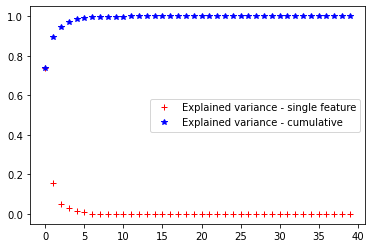

In [38]:
%%time
N_PCA=40
p = PCA(n_components=N_PCA).fit(X_to_reduce)
ns = list(range(N_PCA))

plt.figure()
plt.plot(ns, [ p.explained_variance_ratio_[n] for n in ns], 
         'r+', label="Explained variance - single feature")
plt.plot(ns, [ p.explained_variance_ratio_.cumsum()[n] for n in ns], 
         'b*', label="Explained variance - cumulative")
_ = plt.legend()


In [63]:
pca40 = PCA(n_components = 100)
X_reduced = pca40.fit_transform(X_to_reduce)

In [64]:
df_reduced = pd.DataFrame(X_reduced)
df_reduced

0           1           2          3           4          5   \
0     -297.545486   72.935606   15.220546   2.680500   16.687012  -0.973792   
1     -297.537496   72.987396   15.313183   2.845524   15.434343  -1.342194   
2     -298.907014   68.892921    7.879666  -9.719862   88.780826  16.146196   
3     -326.140594   20.187487  -32.699240 -45.773255  213.358555  49.091522   
4      -78.537496  -66.364641   51.562655  12.993161   98.965031  67.746233   
...           ...         ...         ...        ...         ...        ...   
16065 -302.443423   60.643478   -9.393265 -36.238774   97.173571  38.906783   
16066  194.643050   82.977317 -184.629105  57.475740  120.963506  36.118978   
16067 -320.843725   37.114062   -5.047384  -1.704369 -152.107224 -62.821520   
16068  193.790474   80.872721 -188.395318  49.878258  144.441115  32.712876   
16069    8.693973 -144.876332   34.261342 -39.044655   67.877521  27.519986   

              6          7          8          9   ...        90        91  \
0       7.515218  11.287338   6.939310 -28.672172  ...  0.322106  0.498107   
1       7.792448  11.316733   7.205318 -29.283738  ... -0.007573  0.377953   
2      23.339601   4.772889  11.314403  -9.295850  ...  0.838204  0.031221   
3     -42.042402  -3.025443  16.949185  20.462931  ... -0.007342 -0.226765   
4      36.313448  17.694191 -53.698748  14.487776  ... -0.214775  0.272986   
...          ...        ...        ...        ...  ...       ...       ...   
16065  19.587164   2.342164  11.556710  13.059468  ... -0.117861  0.125711   
16066  13.117549  15.184232 -26.788367  15.436581  ... -0.000565 -0.434606   
16067 -31.729101 -17.035192  15.900588  15.121485  ...  0.792332  0.141632   
16068   8.920838   1.470768 -34.631523  22.267755  ...  1.549406  0.075698   
16069  16.069026   2.741802   8.025205   3.316346  ...  0.406022  0.564709   

             92        93        94        95        96        97        98  \
0     -0.128689 -0.092069  0.191491 -0.101166 -0.192496 -0.252689  0.339866   
1     -0.180701 -0.087263 -0.170374  0.196271 -0.498567 -0.382748 -0.124727   
2     -0.454339 -0.073564  0.194132  0.220901 -0.216450  0.380417 -0.229503   
3     -0.366002  0.157419 -0.194849 -0.200592  0.155057 -0.008236 -0.010450   
4     -0.017454  0.297154 -0.252233  0.341340 -0.096715 -0.022931 -0.454163   
...         ...       ...       ...       ...       ...       ...       ...   
16065 -0.019699 -0.670862  0.655087  0.261547 -0.128117 -0.163153  0.086390   
16066 -0.338468 -0.388109  0.598427 -0.416663  0.111233  0.100120  0.027952   
16067 -0.201503 -0.339770 -0.682468  1.213081 -0.464570 -0.491751  0.461078   
16068  0.302702  0.549773  0.060522 -0.351112  0.187499  0.033725  0.156194   
16069  0.357260 -0.100433 -0.003376  0.580345 -0.228946 -0.283473 -0.015714   

             99  
0      0.670703  
1      0.705456  
2      0.205728  
3      0.105825  
4     -0.658316  
...         ...  
16065  0.295729  
16066 -0.674854  
16067 -0.583637  
16068  0.332480  
16069 -0.575849  

[16070 rows x 100 columns]

In [65]:
df_reduced['En'] = data_en[:ind]

In [66]:
df_reduced

0           1           2          3           4          5  \
0     -297.545486   72.935606   15.220546   2.680500   16.687012  -0.973792   
1     -297.537496   72.987396   15.313183   2.845524   15.434343  -1.342194   
2     -298.907014   68.892921    7.879666  -9.719862   88.780826  16.146196   
3     -326.140594   20.187487  -32.699240 -45.773255  213.358555  49.091522   
4      -78.537496  -66.364641   51.562655  12.993161   98.965031  67.746233   
...           ...         ...         ...        ...         ...        ...   
16065 -302.443423   60.643478   -9.393265 -36.238774   97.173571  38.906783   
16066  194.643050   82.977317 -184.629105  57.475740  120.963506  36.118978   
16067 -320.843725   37.114062   -5.047384  -1.704369 -152.107224 -62.821520   
16068  193.790474   80.872721 -188.395318  49.878258  144.441115  32.712876   
16069    8.693973 -144.876332   34.261342 -39.044655   67.877521  27.519986   

               6          7          8          9  ...        91        92  \
0       7.515218  11.287338   6.939310 -28.672172  ...  0.498107 -0.128689   
1       7.792448  11.316733   7.205318 -29.283738  ...  0.377953 -0.180701   
2      23.339601   4.772889  11.314403  -9.295850  ...  0.031221 -0.454339   
3     -42.042402  -3.025443  16.949185  20.462931  ... -0.226765 -0.366002   
4      36.313448  17.694191 -53.698748  14.487776  ...  0.272986 -0.017454   
...          ...        ...        ...        ...  ...       ...       ...   
16065  19.587164   2.342164  11.556710  13.059468  ...  0.125711 -0.019699   
16066  13.117549  15.184232 -26.788367  15.436581  ... -0.434606 -0.338468   
16067 -31.729101 -17.035192  15.900588  15.121485  ...  0.141632 -0.201503   
16068   8.920838   1.470768 -34.631523  22.267755  ...  0.075698  0.302702   
16069  16.069026   2.741802   8.025205   3.316346  ...  0.564709  0.357260   

             93        94        95        96        97        98        99  \
0     -0.092069  0.191491 -0.101166 -0.192496 -0.252689  0.339866  0.670703   
1     -0.087263 -0.170374  0.196271 -0.498567 -0.382748 -0.124727  0.705456   
2     -0.073564  0.194132  0.220901 -0.216450  0.380417 -0.229503  0.205728   
3      0.157419 -0.194849 -0.200592  0.155057 -0.008236 -0.010450  0.105825   
4      0.297154 -0.252233  0.341340 -0.096715 -0.022931 -0.454163 -0.658316   
...         ...       ...       ...       ...       ...       ...       ...   
16065 -0.670862  0.655087  0.261547 -0.128117 -0.163153  0.086390  0.295729   
16066 -0.388109  0.598427 -0.416663  0.111233  0.100120  0.027952 -0.674854   
16067 -0.339770 -0.682468  1.213081 -0.464570 -0.491751  0.461078 -0.583637   
16068  0.549773  0.060522 -0.351112  0.187499  0.033725  0.156194  0.332480   
16069 -0.100433 -0.003376  0.580345 -0.228946 -0.283473 -0.015714 -0.575849   

            En  
0      37.8010  
1      44.1107  
2      19.4085  
3      -0.1086  
4     -23.8799  
...        ...  
16065  30.1280  
16066   6.8265  
16067  67.1569  
16068   8.0652  
16069   2.9916  

[16070 rows x 101 columns]

In [68]:
X_train, X_test, y_train, y_test = train_test_split(df_reduced.drop('En', axis = 1), df['En'], test_size=0.3, random_state=42)

In [61]:
%%time
ridge = Ridge()
params_ridge = {'alpha': [1.0, 0.5, 3.0]}
ridge_grid = GridSearchCV(ridge, params_ridge)
ridge_grid.fit(X_train, y_train)

Wall time: 217 ms


GridSearchCV(estimator=Ridge(), param_grid={'alpha': [1.0, 0.5, 3.0]})

In [62]:
print(ridge_grid.best_params_)
print(ridge_grid.best_score_)

{'alpha': 3.0}
0.7336399659064828


In [63]:
%%time
lasso = Lasso(max_iter = 2000)
params_lasso = {'alpha': [1.0, 0.5, 3.0]}
lasso_grid = GridSearchCV(lasso, params_lasso)
lasso_grid.fit(X_train, y_train)

Wall time: 412 ms


GridSearchCV(estimator=Lasso(max_iter=2000),
             param_grid={'alpha': [1.0, 0.5, 3.0]})

In [64]:
print(lasso_grid.best_params_)
print(lasso_grid.best_score_)

{'alpha': 0.5}
0.733763338070775


In [65]:
%%time
rand_forest_regr = RandomForestRegressor(max_depth = 30)
rand_forest_regr.fit(X_train, y_train)

Wall time: 39.2 s


RandomForestRegressor(max_depth=30)

In [66]:
rand_forest_regr.score(X_test, y_test)

0.8206153078127382

In [67]:
%%time
knn_regr = KNeighborsRegressor()
params_knn = {'n_neighbors': [2, 5, 12, 25, 33]}
knn_grid = GridSearchCV(knn_regr, params_knn, verbose = 1)
knn_grid.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Wall time: 6.27 s


[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    6.1s finished


GridSearchCV(estimator=KNeighborsRegressor(),
             param_grid={'n_neighbors': [2, 5, 12, 25, 33]}, verbose=1)

In [68]:
print(knn_grid.best_params_)
print(knn_grid.best_score_)

{'n_neighbors': 5}
0.7503579055098994


In [52]:
%%time
xgb_model = XGBRegressor(objective='reg:squarederror', max_depth = 5, grow_policy='lossguide')
xgb_model.fit(X_train, y_train)

Wall time: 2.42 s


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='lossguide',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [53]:
predict = xgb_model.predict(X_test)
r2_score(y_test, predict)

0.810728090526375